Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

* https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92

* https://github.com/nejumi/tools_for_kaggle/blob/master/semi_supervised_learner.py

* https://upura.hatenablog.com/entry/2019/03/03/233534

* https://pompom168.hatenablog.com/entry/2019/07/22/113433


In [1]:
# Version = "v1" # starter model
# Version = "v2" # Compare treat Vs. ctrl and minor modifications, StratifiedKFold
# Version = "v3" # Add debug mode and minor modifications
# Version = "v4" # Clipping a control with an outlier(25-75)
# Version = "v5" # Clipping a control with an outlier(20-80)
# Version = "v6" # under sampling 500 → oversamplling 500, lipping a control with an outlier(10-90)
# Version = "v7" # Use anotated data, under sampling 500 → oversamplling 500, clipping a control with an outlier(10-90)
# Version = "v8" # pasude labeling (thresholds:0.5), timeout
# Version = "v9" # pasude labeling (thresholds:0.6), timeout
# Version = "v10" # pasude labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP
# Version = "v11" # pasude labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP, lgbm parames adjust
# Version = "v12" # Feature engineering based on feature importance
# Version = "v13" # Calibration, SMOTE(k_neighbors=5→1)
# Version = "v14" # Removed the Calibration, SMOTE(k_neighbors=1), pasude labeling (thresholds:0.7)
# Version = "v15" # Updata anotated data
# Version = "v16" # Remove noisy label(confidence: 0.5)
# Version = "v17" # Modifications with remove noisy label func, Calibration, confidence = y_prob.probability.max()*0.3
# Version = "v18" # SMOTE(k_neighbors=1→2), confidence = y_prob.probability.max()*0.2
# Version = "v19" # SMOTE(k_neighbors=2→3),

Version = "v20" # Modifications with confidence, Removed the Calibration, SMOTE(k_neighbors=2), 

In [2]:
DEBUG = True

# Library

In [3]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
import imblearn
from imblearn.over_sampling import SMOTE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

print("lightgbm Version: ", lgb.__version__)
print("numpy Version: ", np.__version__)
print("pandas Version: ", pd.__version__)
print("imblearn Version: ", imblearn.__version__)

lightgbm Version:  2.3.1
numpy Version:  1.18.5
pandas Version:  1.1.1
imblearn Version:  0.7.0


# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
    Learning_rate = 0.03
else:
    N_FOLD = 4
    Num_boost_round=10000
    Early_stopping_rounds=39
    Learning_rate = 0.01

SEED = 42
seed_everything(seed=SEED)

Max_depth = 7

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

In [7]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

In [8]:
annot = pd.read_csv("../input/moa-annot-data/20201024_moa_sig_list.v2.csv")
annot

,sig_id,nonscored1,nonscored2
0,adenylyl_cyclase_activator,adenylyl_cyclase_inhibitor,NaN
1,aldehyde_dehydrogenase_inhibitor,alcohol_dehydrogenase_inhibitor,NaN
2,antiarrhythmic,na_k-atpase_inhibitor,potassium_channel_blocker
3,anticonvulsant,gaba_gated_chloride_channel_blocker,NaN
4,antifungal,fungal_ergosterol_inhibitor,fungal_lanosterol_demethylase_inhibitor
5,antihistamine,histamine_release_inhibitor,NaN
6,atp-sensitive_potassium_channel_antagonist,atp-sensitive_potassium_channel_inhibitor,NaN
7,bacterial_membrane_integrity_inhibitor,bacterial_protein_synthesis_inhibitor,NaN
8,calcineurin_inhibitor,t_cell_inhibitor,NaN
9,catechol_o_methyltransferase_inhibitor,dopamine_release_enhancer,NaN


In [9]:
annot_sig = []
annot_sig = annot.sig_id.tolist()
print(annot_sig)

['adenylyl_cyclase_activator', 'aldehyde_dehydrogenase_inhibitor', 'antiarrhythmic', 'anticonvulsant', 'antifungal', 'antihistamine', 'atp-sensitive_potassium_channel_antagonist', 'bacterial_membrane_integrity_inhibitor', 'calcineurin_inhibitor', 'catechol_o_methyltransferase_inhibitor', 'cdk_inhibitor', 'coagulation_factor_inhibitor', 'elastase_inhibitor', 'erbb2_inhibitor', 'nicotinic_receptor_agonist', 'nitric_oxide_production_inhibitor', 'protein_phosphatase_inhibitor', 'sphingosine_receptor_agonist', 'steroid', 'ubiquitin_specific_protease_inhibitor']


In [10]:
train_target = pd.concat([train_targets_scored, train_targets_nonscored], axis=1)
train_target.head() 

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Training Utils

In [11]:
def get_target(target_col, annot_sig):
    if target_col in annot_sig:
        t_cols = []
        for t_col in list(annot[annot.sig_id == target_col].iloc[0]):
            if t_col is not np.nan:
                t_cols.append(t_col)
                target = train_target[t_cols]
                target = target.sum(axis=1)
                #1 or more, replace it with 1.
                target = target.where(target < 1, 1)
    else:
        target = train_targets_scored[target_col]
    
    return target

In [12]:
#def calibration(y_pred, target_rate):
#    return y_pred / (y_pred + (1 - y_pred) / target_rate)

In [13]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str):
    target = get_target(target_col, annot_sig)
    target_rate = target.sum() / len(target)
    
    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    trt = trt.drop("sig_id", axis=1)
    n_target = max(500,len(trt))
    
    logger.info(f"{target_col} , len(trt) : {len(trt)}")
        
    othr = train[target==0].copy().reset_index(drop=True)
    othr = othr.drop("sig_id", axis=1)
    othr = othr.sample(n=n_target, random_state=42)
    othr["target"] = 0
    
    X_train = pd.concat([trt, othr], axis=0, sort=False, ignore_index=True)
    X_train = X_train.replace([np.inf, -np.inf], np.nan)
    X_train = X_train.fillna(0)
    
    y_train = X_train["target"]
    X_train = X_train.drop("target", axis=1)


    if len(trt) < n_target:
        sm = SMOTE(k_neighbors=2, n_jobs=2, random_state=SEED)
        X_train, y_train = sm.fit_sample(X_train, y_train)
    
    X_test = test.drop("sig_id", axis=1)
    
    train_X, train_y = pseudo_labeling(X_train, y_train, X_test, target_rate)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(train_X),))
    score = 0
        
    for fold_, (train_index, valid_index) in enumerate(cv.split(train_X, train_y)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr = train_X.loc[train_index, :]
        X_val = train_X.loc[valid_index, :]
        y_tr = train_y[train_index]
        y_val = train_y[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        logger.info(f"================================= fold {fold_+1}/{cv.get_n_splits()} {target_col}=================================")
        
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=100,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)

        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        #y_pred = calibration(y_pred, target_rate)
        y_preds.append(y_pred)
        models.append(model)
    
    score = log_loss(train_y, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")

    return sum(y_preds) / len(y_preds), score, models, 

In [14]:
classifier_params = {
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'n_estimators': Num_boost_round,
    'learning_rate': Learning_rate,
    'objective': "binary",
    'subsample':0.7,
    'reg_alpha':0.1,
    'reg_lambda':0.1,
    'random_state':SEED,
    'n_jobs':2
}

In [15]:
def convert_label(df, conf_0, conf_1, threshold=0.5):
    df = df.copy()
    Probability = df.iloc[:,0]
    # Remove low confidence labels
    conf_index = df[(Probability <= conf_0) & (Probability >= conf_1)].index.values
    
    Probability = Probability.where(Probability < threshold, 1).copy()
    p_label = Probability.where(Probability >= threshold, 0).copy()
    
    return p_label, conf_index

In [16]:
def pseudo_labeling(X_train, y_train, X_test, target_rate, max_iter=3):
       
    X = X_train.copy()
    y = y_train.copy()
    
    Threshold = 0.5
    
    for iter_ in range(1, max_iter+1):
    
        logger.info(f"================= Pseudo labeling {iter_} / {max_iter} =================")
        
        y_preds = np.zeros((X.shape[0], 2))
        y_preds[:, 0] = y.copy()
        
        y_prob = np.zeros((X_test.shape[0]))
        
        X_conf = pd.DataFrame()
        y_conf = pd.DataFrame()
        
        for fold_, (train_idx, valid_idx) in enumerate(cv.split(X, y)):        
            X_tr, X_val = X.loc[train_idx, :], X.loc[valid_idx, :]
            y_tr, y_val = y[train_idx], y[valid_idx]
            
            clf = LGBMClassifier(**classifier_params)
            
            clf.fit(X_tr, y_tr,
                    eval_set=[(X_tr, y_tr), (X_val, y_val)],
                    eval_metric='logloss',
                    verbose=100,
                    early_stopping_rounds=Early_stopping_rounds)
            
            y_preds[valid_idx, 1] = clf.predict(X_val, num_iteration=clf.best_iteration_)
            y_prob += clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1] / N_FOLD
        
        y_preds = pd.DataFrame(y_preds, index=X.index, columns=[["Labels", "Preds"]])
        y_preds = y_preds.sum(axis=1)
                
        corect_idx = y_preds[y_preds != 1].index.values
        X_corect, y_corect = X[X.index.isin(corect_idx)], y[y.index.isin(corect_idx)]
        
        logger.info(f"Remove_noisy_labels: {len(y)-len(y_corect)} → positive_corect_labels: {sum(y_corect)}/{len(y_corect)}")
            
        # Remove low confidence labels
        y_prob = pd.DataFrame(y_prob, index=X_test.index, columns=["probability"])
        high_conf_0, high_conf_1 = y_prob.probability.min()*3, y_prob.probability.max()*0.7
        p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
        
        p_label_rate = sum(p_label)/len(p_label)        
        logger.info(f"p_label_rate: {p_label_rate:.5f} Vs.target_rate: {target_rate:.5f}, Num_p_label: {sum(p_label)}, conf_0:{high_conf_0:.5f}, conf_1:{high_conf_1:.5f}")
        
        # Set the params of threshold based on train labels rate (target_rate).
        # target_rate = target.sum() / len(target)
        if p_label_rate*3 < target_rate:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.2f}")
                if sum(p_label)*1.5 > check: break
                Threshold -= 0.04
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
               
                
        if p_label_rate > target_rate*3:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.2f}")
                if sum(p_label) < check*1.5: break
                Threshold += 0.04
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
                
        if iter_ == max_iter:
            X_conf = X_test.copy()
        else:
            X_conf = X_test[X_test.index.isin(conf_idx)].copy()
            
        logger.info(f"threshold:{Threshold:.2f}, positive p_label:{sum(p_label)}/{len(p_label)}, p_label_rate: {sum(p_label)/len(p_label):.5f}")
 
        X = pd.concat([X_corect, X_conf], axis=0, ignore_index=True)
        y = pd.concat([y_corect, p_label], axis=0, ignore_index=True)
        
        X = X.drop_duplicates().reset_index(drop=True)
        y = y[X.index.values].reset_index(drop=True)
        
    return X, y

In [17]:
def show_feature_importance(feature_importance_df, num=100):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(8, 30))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [18]:
train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [19]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [20]:
train, test = label_encoding(train, test, ['cp_type', 'cp_time', 'cp_dose'])

In [21]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,train
1,id_000779bfc,1,2,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,train
2,id_000a6266a,1,1,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,train
3,id_0015fd391,1,1,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,train
4,id_001626bd3,1,2,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_ff7004b87,1,0,0,0.4571,-0.5743,3.3930,-0.6202,0.8557,1.6240,...,-0.6422,-0.4367,0.0159,-0.6539,-0.4791,-1.2680,-1.1280,-0.4167,-0.6600,test
27792,id_ff925dd0d,1,0,0,-0.5885,-0.2548,2.5850,0.3456,0.4401,0.3107,...,0.5780,-0.5888,0.8057,0.9312,1.2730,0.2614,-0.2790,-0.0131,-0.0934,test
27793,id_ffb710450,1,2,0,-0.3985,-0.1554,0.2677,-0.6813,0.0152,0.4791,...,0.9153,-0.1862,0.4049,0.9568,0.4666,0.0461,0.5888,-0.4205,-0.1504,test
27794,id_ffbb869f2,1,1,1,-1.0960,-1.7750,-0.3977,1.0160,-1.3350,-0.2207,...,-0.4473,-0.8192,0.7785,0.3133,0.1286,-0.2618,0.5074,0.7430,-0.0484,test


In [22]:
# Select control data
ctl = train[(train.cp_type==0)]
ctl

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
25,id_0054388ec,0,1,0,-0.6696,-0.2718,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-0.6828,-0.6594,-0.2043,0.3571,-0.1319,0.2187,0.0737,0.6498,-1.4820,train
40,id_007bfbb91,0,0,1,-1.3200,-1.7340,-0.0741,1.5440,-1.8290,-0.0951,...,1.0340,0.7393,1.1020,0.3786,0.2636,-0.5751,0.3362,0.8543,0.9180,train
47,id_008a986b7,0,1,1,0.4860,0.1430,0.5281,-0.0022,-0.2334,-0.6607,...,-0.1866,0.7629,0.3288,-0.9915,-0.3694,-0.4979,0.5281,-0.9245,-0.9367,train
63,id_009d8340f,0,0,1,0.4471,-0.0839,-0.3864,0.3196,0.2584,-0.3156,...,0.3939,0.7665,0.7932,-0.6804,-0.0435,0.0949,0.2000,-0.4326,0.9364,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23729,id_ff1f9e5fc,0,0,0,0.0465,0.6430,-0.2453,0.3521,0.6195,-0.6659,...,0.1621,-0.2065,0.8314,-0.1891,-0.0074,0.2131,-0.1419,-0.2422,0.0457,train
23747,id_ff469c482,0,2,0,-0.6204,-1.3800,-1.1880,-0.6573,-0.8408,-0.2447,...,0.7366,0.5468,1.1450,0.5254,0.6224,-0.9630,0.8872,-0.0742,-0.6777,train
23768,id_ff89331ca,0,2,1,-0.1051,0.4335,0.3648,-0.0525,-0.3632,-0.3228,...,0.4885,0.4963,0.9434,-0.4779,0.6951,0.9517,-0.8110,-0.1748,-0.3626,train
23793,id_ffd26f361,0,1,1,0.6008,0.2781,-0.3319,-0.8782,0.9281,0.7535,...,0.9569,-0.2065,-0.4918,0.7863,0.0504,0.8813,0.7757,-0.5272,0.7082,train


In [23]:
# clipping

def outlaier_clip(df):
    df = df.copy()
    clipping = df.columns[4:6]
    for col in clipping:
        lower, upper= np.percentile(df[col], [10, 90])
        df[col] = np.clip(df[col], lower, upper)
    
    return df

ctl_df = pd.DataFrame(columns=train.columns)
for i in ctl.cp_time.unique():
    for j in ctl.cp_dose.unique():
        print(len(ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]))
        tmp_ctl = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]
        tmp_ctl = outlaier_clip(tmp_ctl)
        ctl_df = pd.concat([ctl_df, tmp_ctl], axis=0).reset_index(drop=True)
ctl_df

343
305
301
305
307
305


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_0054388ec,0,1,0,-0.6696,-0.27180,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
1,id_01b05de6c,0,1,0,-0.3176,0.48512,-0.3773,0.5555,-0.4877,0.3413,...,-0.6163,0.8001,0.3389,0.7437,0.7533,0.2406,0.5057,0.8017,1.0280,train
2,id_020ba48d9,0,1,0,0.8094,-0.33390,1.1130,-0.4192,0.4545,-0.4771,...,-0.4414,-0.2442,0.0557,-0.6597,-0.3713,-0.6929,-0.3258,0.3602,-0.0595,train
3,id_02c93b4a5,0,1,0,-0.0884,-1.54100,0.5562,0.4661,-0.1683,0.9515,...,0.4766,0.9697,0.4613,0.8957,0.8227,1.2300,1.7180,0.6542,0.0580,train
4,id_03bc6d412,0,1,0,0.8431,0.09310,-0.0958,-0.4337,1.0690,-0.6440,...,-1.1510,-0.5010,-0.2736,0.1270,0.3511,0.1233,-0.8520,0.1767,0.1153,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,id_fbb620181,0,2,1,-0.3490,0.72970,-4.1480,-1.0030,2.4070,-0.9784,...,-1.4260,-0.8613,-0.0243,-0.6109,0.6377,-1.2590,-0.7238,-0.7734,-0.1274,train
1862,id_fbba92030,0,2,1,-0.8921,1.13520,0.4227,1.3270,-0.9839,-0.8469,...,1.1340,0.7007,1.3320,0.6622,0.6167,0.9459,-0.0344,-0.0186,0.5173,train
1863,id_fbc0849ad,0,2,1,-0.2948,0.21960,-0.3252,-0.2084,-0.6518,0.3542,...,0.5014,0.6009,0.4560,-0.3360,-0.5091,0.6569,0.6203,0.6764,0.4504,train
1864,id_fd93fa37d,0,2,1,-0.2984,-0.47880,-2.3560,-0.6848,1.8700,1.0240,...,-0.4422,-0.6665,-0.8033,-1.0520,0.4103,0.4462,-1.1580,-1.3060,0.1925,train


In [24]:
col_list = list(data.columns)[:-1]
data_df = pd.DataFrame(columns=col_list)
Splitdata = []
d = 1e-6

for i in data.cp_time.unique():
    for j in data.cp_dose.unique():
        select = data[(data.cp_time==i) & (data.cp_dose==j)]
        print(len(select))
        
        for k in list(select['WHERE']):
                      Splitdata.append(k)
        
        select = select.drop(columns='WHERE')
        med = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)].iloc[:, 4:].median()
        f_div = lambda x: (x+d) / (abs(med)+d)
        select_d = select.iloc[:,4:].apply(f_div, axis=1).add_prefix('d_')
        tmp_data = pd.concat([select,select_d], axis=1, sort=False)
        data_df = pd.concat([data_df, tmp_data], axis=0)
data_df

4534
4538
4561
4536
5079
4548


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [25]:
# clipping
clipping = data_df.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data_df[col], [1, 99])
    data_df[col] = np.clip(data_df[col], lower, upper)
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [26]:
data_df.cp_type = data_df.cp_type.astype('int64')
data_df.cp_time = data_df.cp_time.astype('int64')
data_df.cp_dose = data_df.cp_dose.astype('int64')
data_df.dtypes

sig_id      object
cp_type      int64
cp_time      int64
cp_dose      int64
g-0        float64
            ...   
d_c-95     float64
d_c-96     float64
d_c-97     float64
d_c-98     float64
d_c-99     float64
Length: 1748, dtype: object

In [27]:
data_df = data_df.replace([np.inf, -np.inf], np.nan)
data_df = data_df.dropna(how='any', axis=1)
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [28]:
data_df['WHERE'] = Splitdata
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303,train
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866,train
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032,train
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519,train
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843,test
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932,test
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938,test
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391,test


In [29]:
train = data_df[data_df['WHERE']=="train"].drop('WHERE', axis=1)
test = data_df[data_df['WHERE']=="test"].drop('WHERE', axis=1)

In [30]:
# Kolmogorov-Smirnov test applied for train data and test data.

from scipy.stats import ks_2samp

tr = train.iloc[:, 4:]
ts = test.iloc[:, 4:]

list_p_value =[ks_2samp(ts[i], tr[i])[1] for i in tqdm(tr.columns)]
Se = pd.Series(list_p_value, index=tr.columns).sort_values() 
list_discarded = list(Se[Se < .1].index)

train = train.drop(list_discarded, axis=1)
test = test.drop(list_discarded, axis=1)

print(f"Removed {len(list_discarded)} columns")


Removed 408 columns


In [31]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

,sig_id,cp_type,cp_time,cp_dose,g-1,g-2,g-4,g-5,g-6,g-8,...,d_c-87,d_c-89,d_c-90,d_c-91,d_c-92,d_c-94,d_c-95,d_c-97,d_c-99,WHERE
0,id_000644bb2,1,0,0,0.5577,-0.2479,-0.1944,-1.0120,-1.0220,0.5548,...,-0.458706,3.210844,0.900850,0.827675,4.339584,-0.411268,1.931922,0.630788,1.125303,train
1,id_001762a82,1,0,0,0.2941,-0.9901,1.2810,0.5203,0.0543,-0.1586,...,4.198996,7.411112,5.788465,3.705949,-5.437902,3.069473,1.325997,1.110292,3.769866,train
2,id_00762e877,1,0,0,0.1662,-0.6307,-0.5992,-0.2523,-1.3770,-1.4880,...,2.130879,2.780971,-2.000935,-0.524979,-0.457811,0.017855,2.201874,2.479205,1.298032,train
3,id_0079af0fb,0,0,0,-1.8230,-0.5211,-1.1280,0.6041,0.3856,-0.5400,...,0.036750,2.267525,-1.221271,-2.187049,-3.543232,0.768123,-0.387026,0.217342,-3.993519,train
4,id_0079d45d3,1,0,0,-2.1430,-0.0943,0.4869,-0.0935,1.2090,-1.5450,...,-18.897523,-9.183429,-9.203619,-18.488086,-10.402948,-5.953954,-7.288708,-6.644035,-1.741033,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,-0.0461,-0.9751,-0.1861,0.3608,0.5174,0.9298,...,10.394855,-23.040415,3.364808,-2.944165,4.362395,-0.200288,3.648613,-1.381859,-2.753843,test
27792,id_fce497048,1,1,1,-0.3274,-0.0099,0.6673,-1.5380,-0.5368,2.1020,...,-53.796375,-33.477371,-6.666625,-2.994822,-108.965314,-19.418785,-5.186308,-3.400727,-6.611932,test
27793,id_fd75349b2,1,1,1,0.4437,-0.1530,-0.5804,0.0633,0.6952,-0.1058,...,110.075643,53.955575,1.461452,1.221387,-12.977688,-1.481351,-3.441418,1.214694,-2.167938,test
27794,id_fed0f2fe0,1,1,1,0.7350,0.3304,0.1435,-1.6810,-1.1370,-0.4083,...,-26.830434,-50.825426,-5.310498,-2.757956,9.262242,-2.189681,-6.566071,-3.150643,-5.960391,test


In [32]:
Splitdata = data["WHERE"]
data = data.drop('WHERE', axis=1)
data

,sig_id,cp_type,cp_time,cp_dose,g-1,g-2,g-4,g-5,g-6,g-8,...,d_c-85,d_c-87,d_c-89,d_c-90,d_c-91,d_c-92,d_c-94,d_c-95,d_c-97,d_c-99
0,id_000644bb2,1,0,0,0.5577,-0.2479,-0.1944,-1.0120,-1.0220,0.5548,...,0.610453,-0.458706,3.210844,0.900850,0.827675,4.339584,-0.411268,1.931922,0.630788,1.125303
1,id_001762a82,1,0,0,0.2941,-0.9901,1.2810,0.5203,0.0543,-0.1586,...,2.368506,4.198996,7.411112,5.788465,3.705949,-5.437902,3.069473,1.325997,1.110292,3.769866
2,id_00762e877,1,0,0,0.1662,-0.6307,-0.5992,-0.2523,-1.3770,-1.4880,...,-2.098055,2.130879,2.780971,-2.000935,-0.524979,-0.457811,0.017855,2.201874,2.479205,1.298032
3,id_0079af0fb,0,0,0,-1.8230,-0.5211,-1.1280,0.6041,0.3856,-0.5400,...,0.927045,0.036750,2.267525,-1.221271,-2.187049,-3.543232,0.768123,-0.387026,0.217342,-3.993519
4,id_0079d45d3,1,0,0,-2.1430,-0.0943,0.4869,-0.0935,1.2090,-1.5450,...,-12.466870,-18.897523,-9.183429,-9.203619,-18.488086,-10.402948,-5.953954,-7.288708,-6.644035,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,-0.0461,-0.9751,-0.1861,0.3608,0.5174,0.9298,...,0.977743,10.394855,-23.040415,3.364808,-2.944165,4.362395,-0.200288,3.648613,-1.381859,-2.753843
27792,id_fce497048,1,1,1,-0.3274,-0.0099,0.6673,-1.5380,-0.5368,2.1020,...,-3.525817,-53.796375,-33.477371,-6.666625,-2.994822,-108.965314,-19.418785,-5.186308,-3.400727,-6.611932
27793,id_fd75349b2,1,1,1,0.4437,-0.1530,-0.5804,0.0633,0.6952,-0.1058,...,2.350949,110.075643,53.955575,1.461452,1.221387,-12.977688,-1.481351,-3.441418,1.214694,-2.167938
27794,id_fed0f2fe0,1,1,1,0.7350,0.3304,0.1435,-1.6810,-1.1370,-0.4083,...,-6.247984,-26.830434,-50.825426,-5.310498,-2.757956,9.262242,-2.189681,-6.566071,-3.150643,-5.960391


In [33]:
# Based on v8 notebook with feature importance

def select_importance_cols(feature_importance_df, num=103):
    best_cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    return best_cols


Feature_importance_df = pd.read_csv("../input/../input/moa-annot-data/feature_importance_df.v8.colab.csv")
Feature_importance_df

importance_cols = select_importance_cols(Feature_importance_df)

len(importance_cols)

103

In [34]:
FI = data[importance_cols]
FI = FI.drop(["cp_type", "cp_time", "cp_dose"], axis=1)
FI

,c-98,g-763,g-231,g-178,g-91,g-635,d_g-87,g-254,d_g-202,g-207,...,d_g-39,g-569,g-65,d_g-743,d_g-580,g-105,d_g-157,g-201,d_g-435,c-67
0,0.3801,-0.3167,-1.6510,-0.6217,-1.1230,-0.2461,4.183851,-1.3310,20.720024,-0.22130,...,-0.463249,0.1242,0.0251,2.647177,-10.548861,-1.2560,-0.262194,0.4171,-2.345232,1.2570
1,0.7848,0.4842,0.0333,-0.5141,0.4944,-1.1160,-9.101135,0.5149,-121.467612,0.07920,...,0.712450,0.4590,-0.2584,1.543021,2.532123,-0.2533,-2.819025,-0.4584,3.110345,0.4290
2,0.3193,0.4587,-0.8791,0.2905,-0.1851,0.0860,-5.791252,-1.6090,134.510130,-0.07250,...,1.025284,-0.2491,0.1676,-3.476730,-1.085747,-0.5656,-3.664973,0.6659,-3.906875,-0.3232
3,0.6498,0.6086,-0.5522,0.4275,-0.7775,0.2270,-2.712772,0.8298,74.254500,-1.66400,...,-0.539958,1.3530,-0.2259,-0.720046,31.350629,0.3576,0.201876,0.0597,3.599244,-0.9233
4,-4.8360,-1.1320,2.3720,-0.8283,1.5840,-2.3630,-1.055764,-0.9043,140.770455,3.85415,...,3.627592,-4.4690,1.8870,-9.592403,43.259989,0.0328,-3.335726,4.2690,3.422303,-0.8781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.2310,-0.2914,0.1655,0.2242,0.1058,-1.0330,-2.921354,0.5788,-13.888734,-0.31340,...,-1.244962,-0.4987,-0.4098,0.769766,-155.100886,0.1914,-4.482931,-0.5465,0.340697,-0.6500
27792,-2.4700,1.0300,0.2641,-1.0190,5.7110,-2.3140,-19.551915,1.8170,56.104299,0.69710,...,1.129264,-4.7070,4.7440,2.384589,1016.814588,-0.1688,6.439848,0.8439,-2.063460,-5.1430
27793,-2.1970,0.0199,0.0428,0.7036,2.8370,0.9448,5.732132,-1.6010,-249.158505,-2.55600,...,-1.024153,-0.0303,0.7360,-5.974495,-110.383776,1.5240,9.631421,0.1586,1.600912,-0.7809
27794,-1.0450,-0.2809,-0.8224,0.2189,-1.0990,0.9241,-0.123390,-1.4440,-7.429982,0.82050,...,1.669632,0.6461,-0.4913,3.565008,253.578959,0.7208,5.579313,-0.2808,-0.563337,-0.8265


In [35]:
g_list = [col for col in data.columns[4:] if col.startswith("g-")]
c_list = [col for col in data.columns[4:] if col.startswith("c-")]
d_g_list = [col for col in data.columns[4:] if col.startswith("d_g-")]
d_c_list = [col for col in data.columns[4:] if col.startswith("d_c-")]

g_list

['g-1',
 'g-2',
 'g-4',
 'g-5',
 'g-6',
 'g-8',
 'g-9',
 'g-10',
 'g-12',
 'g-13',
 'g-14',
 'g-15',
 'g-16',
 'g-18',
 'g-19',
 'g-20',
 'g-23',
 'g-24',
 'g-25',
 'g-26',
 'g-27',
 'g-28',
 'g-29',
 'g-30',
 'g-31',
 'g-32',
 'g-33',
 'g-34',
 'g-35',
 'g-36',
 'g-38',
 'g-39',
 'g-40',
 'g-41',
 'g-42',
 'g-43',
 'g-44',
 'g-45',
 'g-46',
 'g-47',
 'g-48',
 'g-49',
 'g-50',
 'g-51',
 'g-53',
 'g-54',
 'g-55',
 'g-56',
 'g-57',
 'g-58',
 'g-59',
 'g-61',
 'g-62',
 'g-64',
 'g-65',
 'g-67',
 'g-69',
 'g-70',
 'g-71',
 'g-73',
 'g-74',
 'g-77',
 'g-78',
 'g-79',
 'g-81',
 'g-83',
 'g-87',
 'g-88',
 'g-89',
 'g-90',
 'g-91',
 'g-93',
 'g-94',
 'g-95',
 'g-96',
 'g-97',
 'g-99',
 'g-103',
 'g-104',
 'g-105',
 'g-106',
 'g-107',
 'g-108',
 'g-109',
 'g-110',
 'g-111',
 'g-113',
 'g-114',
 'g-115',
 'g-116',
 'g-117',
 'g-118',
 'g-119',
 'g-121',
 'g-122',
 'g-123',
 'g-124',
 'g-125',
 'g-126',
 'g-127',
 'g-128',
 'g-129',
 'g-130',
 'g-131',
 'g-132',
 'g-133',
 'g-136',
 'g-137',
 'g-

In [36]:
from sklearn.preprocessing import StandardScaler
    
# Z-score
scaler = StandardScaler(with_mean=True, with_std=True)
std_values = scaler.fit_transform(data.iloc[:, 4:])
std_df = pd.DataFrame(std_values, index=data.index, columns=data.columns[4:])
    

In [37]:
from sklearn.decomposition import PCA
from umap import UMAP

# PCA for all data
pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_all = pca_transformer.fit_transform(std_df)

# PCA → UMAP for all data
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_all = umap.fit_transform(pca_all)

print(pca_umap_all.shape)

(27796, 10)


In [38]:
# PCA for merged categories
g_d_g_list = g_list + d_g_list
c_d_c_list = c_list + d_c_list

pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_g_d_g = pca_transformer.fit_transform(std_df[g_d_g_list])
pca_c_d_c = pca_transformer.fit_transform(std_df[c_d_c_list])

# PCA → UMAP for merged categories
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_g_d_g = umap.fit_transform(pca_g_d_g)

umap = UMAP(n_components=2, random_state=SEED)
pca_umap_c_d_c = umap.fit_transform(pca_c_d_c)

print(pca_umap_g_d_g.shape)
print(pca_umap_c_d_c.shape)

(27796, 10)
(27796, 2)


In [39]:
# PCA for each category
pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_g = pca_transformer.fit_transform(std_df[g_list])
pca_c = pca_transformer.fit_transform(std_df[c_list])
pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])

print(pca_g.shape)
print(pca_c.shape)
print(pca_d_g.shape)
print(pca_d_c.shape)

# PCA → UMAP for each category
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_g = umap.fit_transform(pca_g)
pca_umap_d_g = umap.fit_transform(pca_d_g)

umap = UMAP(n_components=2, random_state=SEED)
pca_umap_c = umap.fit_transform(pca_c)
pca_umap_d_c = umap.fit_transform(pca_d_c)

print(pca_umap_g.shape)
print(pca_umap_c.shape)
print(pca_umap_d_g.shape)
print(pca_umap_d_c.shape)

(27796, 323)
(27796, 13)
(27796, 394)
(27796, 25)
(27796, 10)
(27796, 2)
(27796, 10)
(27796, 2)


In [40]:
# PCA for all categories
pca_transformer = PCA(n_components=3, whiten=True, random_state=SEED)

pca_all = pca_transformer.fit_transform(std_df)
pca_g_d_g = pca_transformer.fit_transform(std_df[g_d_g_list])
pca_c_d_c = pca_transformer.fit_transform(std_df[c_d_c_list])
pca_g = pca_transformer.fit_transform(std_df[g_list])
pca_c = pca_transformer.fit_transform(std_df[c_list])
pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])

print(pca_all.shape)
print(pca_g_d_g.shape)
print(pca_c_d_c.shape)
print(pca_g.shape)
print(pca_c.shape)
print(pca_d_g.shape)
print(pca_d_c.shape)

(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)


In [41]:
data_list = [ 
    pca_umap_all,
    pca_umap_g_d_g,
    pca_umap_c_d_c,
    pca_umap_g,
    pca_umap_c,
    pca_umap_d_g,
    pca_umap_d_c,
    pca_all,
    pca_g_d_g,
    pca_c_d_c,
    pca_g,
    pca_c,
    pca_d_g,
    pca_d_c,
]

data_names = [ 
    "pca_umap_all",
    "pca_umap_g_d_g",
    "pca_umap_c_d_c",
    "pca_umap_g",
    "pca_umap_c",
    "pca_umap_d_g",
    "pca_umap_d_c",
    "pca_all",
    "pca_g_d_g",
    "pca_c_d_c",
    "pca_g",
    "pca_c",
    "pca_d_g",
    "pca_d_c",
]

In [42]:
col_list = []
for i, d in enumerate(data_list):
    for j in range(d.shape[1]):
        col_list.append( f"{data_names[i]}_{j+1}")
col_list

['pca_umap_all_1',
 'pca_umap_all_2',
 'pca_umap_all_3',
 'pca_umap_all_4',
 'pca_umap_all_5',
 'pca_umap_all_6',
 'pca_umap_all_7',
 'pca_umap_all_8',
 'pca_umap_all_9',
 'pca_umap_all_10',
 'pca_umap_g_d_g_1',
 'pca_umap_g_d_g_2',
 'pca_umap_g_d_g_3',
 'pca_umap_g_d_g_4',
 'pca_umap_g_d_g_5',
 'pca_umap_g_d_g_6',
 'pca_umap_g_d_g_7',
 'pca_umap_g_d_g_8',
 'pca_umap_g_d_g_9',
 'pca_umap_g_d_g_10',
 'pca_umap_c_d_c_1',
 'pca_umap_c_d_c_2',
 'pca_umap_g_1',
 'pca_umap_g_2',
 'pca_umap_g_3',
 'pca_umap_g_4',
 'pca_umap_g_5',
 'pca_umap_g_6',
 'pca_umap_g_7',
 'pca_umap_g_8',
 'pca_umap_g_9',
 'pca_umap_g_10',
 'pca_umap_c_1',
 'pca_umap_c_2',
 'pca_umap_d_g_1',
 'pca_umap_d_g_2',
 'pca_umap_d_g_3',
 'pca_umap_d_g_4',
 'pca_umap_d_g_5',
 'pca_umap_d_g_6',
 'pca_umap_d_g_7',
 'pca_umap_d_g_8',
 'pca_umap_d_g_9',
 'pca_umap_d_g_10',
 'pca_umap_d_c_1',
 'pca_umap_d_c_2',
 'pca_all_1',
 'pca_all_2',
 'pca_all_3',
 'pca_g_d_g_1',
 'pca_g_d_g_2',
 'pca_g_d_g_3',
 'pca_c_d_c_1',
 'pca_c_d_c_2',


In [43]:
result_df = pd.DataFrame(data_list[0])
for d in data_list[1:]:
    tmp_df = pd.DataFrame(d)
    result_df = pd.concat([result_df, tmp_df], axis=1)
result_df.columns = col_list
result_df

,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,pca_umap_all_7,pca_umap_all_8,pca_umap_all_9,pca_umap_all_10,...,pca_g_3,pca_c_1,pca_c_2,pca_c_3,pca_d_g_1,pca_d_g_2,pca_d_g_3,pca_d_c_1,pca_d_c_2,pca_d_c_3
0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,-0.631963,0.520953,-0.489372,0.596058,...,-1.140890,-0.469951,0.099505,0.543770,-0.412404,0.344801,0.037566,-0.352178,0.185292,0.004245
1,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,-0.837569,0.656989,0.557744,0.862181,...,0.393231,-0.814709,0.613391,-0.238404,-0.522178,-0.182825,0.440264,-0.575022,0.122275,0.280131
2,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,-1.044028,0.611787,0.327000,0.522496,...,-0.603388,-0.262629,-0.104706,0.204114,-0.150261,0.224066,-0.477699,-0.254322,0.146491,-0.005201
3,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,-0.463792,0.222208,0.172640,0.482514,...,0.520171,-0.202956,-0.340746,-1.418043,-0.040187,-0.775782,-0.318853,-0.157597,-0.122486,-0.020528
4,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,-0.936194,0.003462,1.613957,0.086733,...,-2.687000,1.478095,0.804459,2.194776,1.834257,0.532104,-2.136533,0.808826,-0.534457,-0.547478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,-0.518431,0.616687,-0.967858,0.699507,...,0.282427,-0.124308,-0.178446,0.631366,-0.533474,1.250751,0.927038,-0.070210,0.002111,-0.157756
27792,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,-0.553066,0.555583,-0.925586,0.635752,...,-2.186621,0.986815,5.615881,-1.809798,1.305137,1.420641,-1.273816,1.123556,-2.183204,0.610776
27793,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,-1.325753,0.832510,0.902315,1.563123,...,-1.047883,-0.212064,0.409555,2.046140,-0.126035,0.358089,-0.604766,-0.223797,0.372728,0.561805
27794,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,-0.554051,0.652266,-0.881698,0.647011,...,0.111515,0.261040,-0.357443,0.309463,-0.092845,-0.936262,-0.360358,0.259394,-0.407341,0.143140


In [44]:
# Merge data
result_df = pd.concat([result_df, FI], axis=1)

In [45]:
# Add data with sig_id, cp_type, cp_time, and cp_dose
data = pd.concat([data.iloc[:, :4], result_df], axis=1)
data

,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,d_g-39,g-569,g-65,d_g-743,d_g-580,g-105,d_g-157,g-201,d_g-435,c-67
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,...,-0.463249,0.1242,0.0251,2.647177,-10.548861,-1.2560,-0.262194,0.4171,-2.345232,1.2570
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,0.712450,0.4590,-0.2584,1.543021,2.532123,-0.2533,-2.819025,-0.4584,3.110345,0.4290
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,1.025284,-0.2491,0.1676,-3.476730,-1.085747,-0.5656,-3.664973,0.6659,-3.906875,-0.3232
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,-0.539958,1.3530,-0.2259,-0.720046,31.350629,0.3576,0.201876,0.0597,3.599244,-0.9233
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,...,3.627592,-4.4690,1.8870,-9.592403,43.259989,0.0328,-3.335726,4.2690,3.422303,-0.8781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,-1.244962,-0.4987,-0.4098,0.769766,-155.100886,0.1914,-4.482931,-0.5465,0.340697,-0.6500
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,1.129264,-4.7070,4.7440,2.384589,1016.814588,-0.1688,6.439848,0.8439,-2.063460,-5.1430
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,...,-1.024153,-0.0303,0.7360,-5.974495,-110.383776,1.5240,9.631421,0.1586,1.600912,-0.7809
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,...,1.669632,0.6461,-0.4913,3.565008,253.578959,0.7208,5.579313,-0.2808,-0.563337,-0.8265


In [46]:
# clipping
clipping = data.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data[col], [1, 99])
    data[col] = np.clip(data[col], lower, upper)
data

,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,d_g-39,g-569,g-65,d_g-743,d_g-580,g-105,d_g-157,g-201,d_g-435,c-67
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.407962,0.927889,-0.848250,0.769027,...,-0.463249,0.1242,0.0251,2.647177,-10.548861,-1.2560,-0.262194,0.4171,-2.345232,1.2570
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,0.712450,0.4590,-0.2584,1.543021,2.532123,-0.2533,-2.819025,-0.4584,3.110345,0.4290
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,1.025284,-0.2491,0.1676,-3.476730,-1.085747,-0.5656,-3.664973,0.6659,-3.906875,-0.3232
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,-0.539958,1.3530,-0.2259,-0.720046,31.350629,0.3576,0.201876,0.0597,3.599244,-0.9233
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.923120,0.013562,...,3.627592,-4.4690,1.8870,-9.592403,43.259989,0.0328,-3.335726,4.2690,3.422303,-0.8781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,-1.244962,-0.4987,-0.4098,0.769766,-155.100886,0.1914,-4.482931,-0.5465,0.340697,-0.6500
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,1.129264,-4.7070,4.7440,2.384589,1016.814588,-0.1688,6.439848,0.8439,-2.063460,-5.1430
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.162132,-0.885569,-0.035729,...,-1.024153,-0.0303,0.7360,-5.974495,-110.383776,1.5240,9.631421,0.1586,1.600912,-0.7809
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.407962,0.766808,-0.643382,0.663832,...,1.669632,0.6461,-0.4913,3.565008,253.578959,0.7208,5.579313,-0.2808,-0.563337,-0.8265


In [47]:
data['WHERE'] = Splitdata
train = data[data['WHERE']=="train"].drop('WHERE', axis=1).reset_index(drop=True)
test = data[data['WHERE']=="test"].drop('WHERE', axis=1).reset_index(drop=True)

# Modeling

In [48]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'objective': 'binary',
    'learning_rate': Learning_rate,
    'num_threads': 2,
    'verbose': -1,
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'feature_fraction':0.7, # randomly select part of features on each iteration
    'lambda_l1':0.1,
    'lambda_l2':0.1

}

categorical_cols = []
feature_importance_df = pd.DataFrame()
models = []
scores = []

In [49]:
for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models = run_lgbm(target_col)

    sub[target_col] = _preds
    scores.append(_score)
        
    for model in models:
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = train.columns[1:]
        _importance_df["importance"] = model.feature_importance(importance_type='gain')
        feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)

5-alpha_reductase_inhibitor , len(trt) : 17
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0628328	valid_1's binary_logloss: 0.105352
[200]	training's binary_logloss: 0.010149	valid_1's binary_logloss: 0.0379678
[300]	training's binary_logloss: 0.00332679	valid_1's binary_logloss: 0.0238639
[400]	training's binary_logloss: 0.00187053	valid_1's binary_logloss: 0.0194539
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00155202	valid_1's binary_logloss: 0.0180295
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.064174	valid_1's binary_logloss: 0.10147
[200]	training's binary_logloss: 0.0105429	valid_1's binary_logloss: 0.0387175
[300]	training's binary_logloss: 0.00343374	valid_1's binary_logloss: 0.0263682
[400]	training's binary_logloss: 0.00190362	valid_1's binary_logloss: 0.0225987


Remove_noisy_labels: 5 → positive_corect_labels: 500/995
p_label_rate: 0.00276 Vs.target_rate: 0.00071, Num_p_label: 11.0, conf_0:0.00029, conf_1:0.61634
Num_p_label: 11.0, Expected: 2.8, Adj_threshold_1: 0.50
Num_p_label: 9.0, Expected: 2.8, Adj_threshold_2: 0.54
Num_p_label: 6.0, Expected: 2.8, Adj_threshold_3: 0.58
Num_p_label: 6.0, Expected: 2.8, Adj_threshold_4: 0.62
Num_p_label: 6.0, Expected: 2.8, Adj_threshold_5: 0.66
Num_p_label: 6.0, Expected: 2.8, Adj_threshold_6: 0.70
Num_p_label: 5.0, Expected: 2.8, Adj_threshold_7: 0.74
Num_p_label: 5.0, Expected: 2.8, Adj_threshold_8: 0.78
Num_p_label: 4.0, Expected: 2.8, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00148277	valid_1's binary_logloss: 0.0210405


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0605633	valid_1's binary_logloss: 0.104772
[200]	training's binary_logloss: 0.00960523	valid_1's binary_logloss: 0.0394732
[300]	training's binary_logloss: 0.00314883	valid_1's binary_logloss: 0.0244574
[400]	training's binary_logloss: 0.00179216	valid_1's binary_logloss: 0.0204076
[500]	training's binary_logloss: 0.00157532	valid_1's binary_logloss: 0.0193129
[600]	training's binary_logloss: 0.00157532	valid_1's binary_logloss: 0.0193128
[700]	training's binary_logloss: 0.00157532	valid_1's binary_logloss: 0.0193128
[800]	training's binary_logloss: 0.00157532	valid_1's binary_logloss: 0.0193128
[900]	training's binary_logloss: 0.00157532	valid_1's binary_logloss: 0.0193128
Early stopping, best iteration is:
[972]	training's binary_logloss: 0.00157532	valid_1's binary_logloss: 0.0193128
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0622268	va

Remove_noisy_labels: 4 → positive_corect_labels: 499.0/991
p_label_rate: 0.00100 Vs.target_rate: 0.00071, Num_p_label: 4.0, conf_0:0.00037, conf_1:0.64730
threshold:0.82, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00146618	valid_1's binary_logloss: 0.0156937
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0617487	valid_1's binary_logloss: 0.0975188
[200]	training's binary_logloss: 0.00999619	valid_1's binary_logloss: 0.0333731
[300]	training's binary_logloss: 0.00321604	valid_1's binary_logloss: 0.0200894
[400]	training's binary_logloss: 0.00179661	valid_1's binary_logloss: 0.0147304
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.00153045	valid_1's binary_logloss: 0.0132877
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0589214	valid_1's binary_logloss: 0.097986
[200]	training's binary_logloss: 0.00919179	valid_1's binary_logloss: 0.0318317
[300]	training's binary_logloss: 0.00302058	valid_1's binary_logloss: 0.0199845
[400]	training's binary_logloss: 0.00172791	valid_1's binary_logloss: 0.0161674
[500]	train

Remove_noisy_labels: 3 → positive_corect_labels: 497.0/988
p_label_rate: 0.00100 Vs.target_rate: 0.00071, Num_p_label: 4.0, conf_0:0.00037, conf_1:0.67806
threshold:0.82, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[983]	training's binary_logloss: 0.00144708	valid_1's binary_logloss: 0.0151104


len(train_index) : 2485
len(valid_index) : 2485
================================= fold 1/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01615	valid_1's binary_logloss: 0.0274572
[200]	training's binary_logloss: 0.00198283	valid_1's binary_logloss: 0.00945383
[300]	training's binary_logloss: 0.000614806	valid_1's binary_logloss: 0.00684707
[400]	training's binary_logloss: 0.000351712	valid_1's binary_logloss: 0.00599654
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000295866	valid_1's binary_logloss: 0.00585316


len(train_index) : 2485
len(valid_index) : 2485
================================= fold 2/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156024	valid_1's binary_logloss: 0.0237342
[200]	training's binary_logloss: 0.00196809	valid_1's binary_logloss: 0.00813219
[300]	training's binary_logloss: 0.000598353	valid_1's binary_logloss: 0.0052115
[400]	training's binary_logloss: 0.000339465	valid_1's binary_logloss: 0.00439025
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000288637	valid_1's binary_logloss: 0.00420078


5-alpha_reductase_inhibitor logloss: 0.005026967524170288
11-beta-hsd1_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.065411	valid_1's binary_logloss: 0.131447
[200]	training's binary_logloss: 0.0107508	valid_1's binary_logloss: 0.0624865
[300]	training's binary_logloss: 0.00350539	valid_1's binary_logloss: 0.0424781
[400]	training's binary_logloss: 0.00200342	valid_1's binary_logloss: 0.0349028
[500]	training's binary_logloss: 0.00152925	valid_1's binary_logloss: 0.0316688
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00152326	valid_1's binary_logloss: 0.0316073
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0612708	valid_1's binary_logloss: 0.147875
[200]	training's binary_logloss: 0.0100987	valid_1's binary_logloss: 0.0779824
[300]	training's binary_logloss: 0.00346084	valid_1's binary_logloss: 0.0523851
[400]	training's binary_logloss: 0.00195327	valid_1's binary_logloss: 0.0430884


Remove_noisy_labels: 14 → positive_corect_labels: 496/986
p_label_rate: 0.00804 Vs.target_rate: 0.00076, Num_p_label: 32.0, conf_0:0.00050, conf_1:0.66754
Num_p_label: 32.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:4.0/3982, p_label_rate: 0.00100


[500]	training's binary_logloss: 0.00151772	valid_1's binary_logloss: 0.0393067
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.00151772	valid_1's binary_logloss: 0.0393067


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0626172	valid_1's binary_logloss: 0.107295
[200]	training's binary_logloss: 0.0104705	valid_1's binary_logloss: 0.0415504
[300]	training's binary_logloss: 0.0034825	valid_1's binary_logloss: 0.0256778
[400]	training's binary_logloss: 0.00196256	valid_1's binary_logloss: 0.01962
[500]	training's binary_logloss: 0.00148701	valid_1's binary_logloss: 0.0172478
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.00143153	valid_1's binary_logloss: 0.0167543
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0604641	valid_1's binary_logloss: 0.10705
[200]	training's binary_logloss: 0.00978871	valid_1's binary_logloss: 0.0443024
[300]	training's binary_logloss: 0.00329403	valid_1's binary_logloss: 0.0321105
[400]	training's binary_logloss: 0.00193923	valid_1's binary_logloss: 0.0273841


Remove_noisy_labels: 5 → positive_corect_labels: 496.0/981
p_label_rate: 0.00075 Vs.target_rate: 0.00076, Num_p_label: 3.0, conf_0:0.00033, conf_1:0.65905
threshold:0.82, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


[500]	training's binary_logloss: 0.00150829	valid_1's binary_logloss: 0.0251038
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.00150676	valid_1's binary_logloss: 0.0250568
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0587142	valid_1's binary_logloss: 0.108918
[200]	training's binary_logloss: 0.00963074	valid_1's binary_logloss: 0.0421643
[300]	training's binary_logloss: 0.00328941	valid_1's binary_logloss: 0.0285119
[400]	training's binary_logloss: 0.00187592	valid_1's binary_logloss: 0.0235804
[500]	training's binary_logloss: 0.00145459	valid_1's binary_logloss: 0.0214548
[600]	training's binary_logloss: 0.00144576	valid_1's binary_logloss: 0.0214113
[700]	training's binary_logloss: 0.00144576	valid_1's binary_logloss: 0.0214112
[800]	training's binary_logloss: 0.00144575	valid_1's binary_logloss: 0.0214112
[900]	training's binary_logloss: 0.00144575	valid_1's binary_logloss: 0.0214112
Early stopping, best itera

Remove_noisy_labels: 8 → positive_corect_labels: 496.0/973
p_label_rate: 0.00126 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.00056, conf_1:0.65279
threshold:0.82, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 2477
len(valid_index) : 2478
================================= fold 1/2 11-beta-hsd1_inhibitor=================================


Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00168441	valid_1's binary_logloss: 0.0305072
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160108	valid_1's binary_logloss: 0.028882
[200]	training's binary_logloss: 0.00204197	valid_1's binary_logloss: 0.0126982
[300]	training's binary_logloss: 0.000666366	valid_1's binary_logloss: 0.00999375
[400]	training's binary_logloss: 0.000389013	valid_1's binary_logloss: 0.00957003
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.000309302	valid_1's binary_logloss: 0.00943206


len(train_index) : 2478
len(valid_index) : 2477
================================= fold 2/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159464	valid_1's binary_logloss: 0.0262119
[200]	training's binary_logloss: 0.00194294	valid_1's binary_logloss: 0.0122315
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.00127247	valid_1's binary_logloss: 0.0119301


11-beta-hsd1_inhibitor logloss: 0.010680836565493429
acat_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0743915	valid_1's binary_logloss: 0.139594
[200]	training's binary_logloss: 0.0134671	valid_1's binary_logloss: 0.0656457
[300]	training's binary_logloss: 0.0044038	valid_1's binary_logloss: 0.0478965
[400]	training's binary_logloss: 0.00237215	valid_1's binary_logloss: 0.0387332
[500]	training's binary_logloss: 0.00173244	valid_1's binary_logloss: 0.0341526
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.00162301	valid_1's binary_logloss: 0.0331838
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0695425	valid_1's binary_logloss: 0.151452
[200]	training's binary_logloss: 0.0123203	valid_1's binary_logloss: 0.0677907
[300]	training's binary_logloss: 0.00417083	valid_1's binary_logloss: 0.045945
[400]	training's binary_logloss: 0.00230087	valid_1's binary_logloss: 0.0376388
[500]	training's binary_logloss: 0.00170945	valid_1

Remove_noisy_labels: 13 → positive_corect_labels: 497/987
p_label_rate: 0.01105 Vs.target_rate: 0.00101, Num_p_label: 44.0, conf_0:0.00020, conf_1:0.60920
Num_p_label: 44.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 36.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 31.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 24.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 21.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_7: 0.74
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_8: 0.78
Num_p_label: 4.0, Expected: 4.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0656879	valid_1's binary_logloss: 0.177038
[200]	training's binary_logloss: 0.0117014	valid_1's binary_logloss: 0.121471
Early stopping, best iteration is:
[247]	training's binary_logloss: 0.00648237	valid_1's binary_logloss: 0.115749
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0714628	valid_1's binary_logloss: 0.12834
[200]	training's binary_logloss: 0.0129734	valid_1's binary_logloss: 0.0547799
[300]	training's binary_logloss: 0.00433534	valid_1's binary_logloss: 0.0368716
[400]	training's binary_logloss: 0.00235054	valid_1's binary_logloss: 0.0281796
[500]	training's binary_logloss: 0.00173353	valid_1's binary_logloss: 0.0241158
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.00165197	valid_1's binary_logloss: 0.0236311


Remove_noisy_labels: 16 → positive_corect_labels: 489.0/971
p_label_rate: 0.00226 Vs.target_rate: 0.00101, Num_p_label: 9.0, conf_0:0.00117, conf_1:0.66060
threshold:0.82, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0677294	valid_1's binary_logloss: 0.115159
[200]	training's binary_logloss: 0.0120673	valid_1's binary_logloss: 0.0439917
[300]	training's binary_logloss: 0.00397432	valid_1's binary_logloss: 0.0299055
[400]	training's binary_logloss: 0.00216945	valid_1's binary_logloss: 0.0238908
[500]	training's binary_logloss: 0.00160857	valid_1's binary_logloss: 0.0219614
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00152334	valid_1's binary_logloss: 0.02177
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0629772	valid_1's binary_logloss: 0.136829
[200]	training's binary_logloss: 0.0111421	valid_1's binary_logloss: 0.0650678
[300]	training's binary_logloss: 0.00373519	valid_1's binary_logloss: 0.0466956
[400]	training's binary_logloss: 0.00206733	valid_1's binary_logloss: 0.0401885
[500]	training's binary_logloss: 0.00155164	valid_1

Remove_noisy_labels: 8 → positive_corect_labels: 488.0/963
p_label_rate: 0.00377 Vs.target_rate: 0.00101, Num_p_label: 15.0, conf_0:0.00018, conf_1:0.67766
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_1: 0.82
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_2: 0.86
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_3: 0.90
Num_p_label: 2.0, Expected: 4.0, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 2472
len(valid_index) : 2473
================================= fold 1/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165008	valid_1's binary_logloss: 0.0256982
[200]	training's binary_logloss: 0.00218623	valid_1's binary_logloss: 0.00764486
[300]	training's binary_logloss: 0.000691029	valid_1's binary_logloss: 0.00508484


len(train_index) : 2473
len(valid_index) : 2472


[400]	training's binary_logloss: 0.00039813	valid_1's binary_logloss: 0.00453703
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.000359171	valid_1's binary_logloss: 0.00446707


================================= fold 2/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163159	valid_1's binary_logloss: 0.0273111
[200]	training's binary_logloss: 0.0021885	valid_1's binary_logloss: 0.00924608
[300]	training's binary_logloss: 0.000703824	valid_1's binary_logloss: 0.00580136
[400]	training's binary_logloss: 0.000402593	valid_1's binary_logloss: 0.0046955
[500]	training's binary_logloss: 0.000313836	valid_1's binary_logloss: 0.00437486


acat_inhibitor logloss: 0.004368342558123946
acetylcholine_receptor_agonist , len(trt) : 190


Early stopping, best iteration is:
[576]	training's binary_logloss: 0.000289839	valid_1's binary_logloss: 0.00426958


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.197619	valid_1's binary_logloss: 0.527182
[200]	training's binary_logloss: 0.0694691	valid_1's binary_logloss: 0.472945
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.0516859	valid_1's binary_logloss: 0.465264
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.214343	valid_1's binary_logloss: 0.556265
[200]	training's binary_logloss: 0.0816898	valid_1's binary_logloss: 0.514892


Remove_noisy_labels: 229 → positive_corect_labels: 397/771
p_label_rate: 0.28654 Vs.target_rate: 0.00798, Num_p_label: 1141.0, conf_0:0.10412, conf_1:0.65870
Num_p_label: 1141.0, Expected: 31.8, Adj_threshold_1: 0.50
Num_p_label: 881.0, Expected: 31.8, Adj_threshold_2: 0.54
Num_p_label: 666.0, Expected: 31.8, Adj_threshold_3: 0.58
Num_p_label: 476.0, Expected: 31.8, Adj_threshold_4: 0.62
Num_p_label: 344.0, Expected: 31.8, Adj_threshold_5: 0.66
Num_p_label: 234.0, Expected: 31.8, Adj_threshold_6: 0.70
Num_p_label: 156.0, Expected: 31.8, Adj_threshold_7: 0.74
Num_p_label: 89.0, Expected: 31.8, Adj_threshold_8: 0.78
Num_p_label: 47.0, Expected: 31.8, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:47.0/3982, p_label_rate: 0.01180
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[261]	training's binary_logloss: 0.0470884	valid_1's binary_logloss: 0.504217
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15959	valid_1's binary_logloss: 0.487983
[200]	training's binary_logloss: 0.0505526	valid_1's binary_logloss: 0.436523
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0434954	valid_1's binary_logloss: 0.432261
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167402	valid_1's binary_logloss: 0.438112
[200]	training's binary_logloss: 0.0542716	valid_1's binary_logloss: 0.368084


Remove_noisy_labels: 135 → positive_corect_labels: 355.0/636
p_label_rate: 0.04093 Vs.target_rate: 0.00798, Num_p_label: 163.0, conf_0:0.04078, conf_1:0.67255
Num_p_label: 163.0, Expected: 31.8, Adj_threshold_1: 0.82
Num_p_label: 103.0, Expected: 31.8, Adj_threshold_2: 0.86
Num_p_label: 49.0, Expected: 31.8, Adj_threshold_3: 0.90
Num_p_label: 11.0, Expected: 31.8, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0216796	valid_1's binary_logloss: 0.339182
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.0209844	valid_1's binary_logloss: 0.338685
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148206	valid_1's binary_logloss: 0.401291
[200]	training's binary_logloss: 0.0469747	valid_1's binary_logloss: 0.331221
[300]	training's binary_logloss: 0.0188856	valid_1's binary_logloss: 0.309266
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.0141567	valid_1's binary_logloss: 0.305694
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150105	valid_1's binary_logloss: 0.410487
[200]	training's binary_logloss: 0.0475122	valid_1's binary_logloss: 0.351716


Remove_noisy_labels: 85 → positive_corect_labels: 334.0/551
p_label_rate: 0.03214 Vs.target_rate: 0.00798, Num_p_label: 128.0, conf_0:0.03624, conf_1:0.69323
Num_p_label: 128.0, Expected: 31.8, Adj_threshold_1: 0.94
Num_p_label: 16.0, Expected: 31.8, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:16.0/3982, p_label_rate: 0.00402
len(train_index) : 2266
len(valid_index) : 2267
================================= fold 1/2 acetylcholine_receptor_agonist=================================


Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0369141	valid_1's binary_logloss: 0.346603
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259452	valid_1's binary_logloss: 0.102269


len(train_index) : 2267
len(valid_index) : 2266
================================= fold 2/2 acetylcholine_receptor_agonist=================================


Early stopping, best iteration is:
[154]	training's binary_logloss: 0.0110231	valid_1's binary_logloss: 0.0985034
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250224	valid_1's binary_logloss: 0.0901057


acetylcholine_receptor_agonist logloss: 0.08909012224883114
acetylcholine_receptor_antagonist , len(trt) : 301


[200]	training's binary_logloss: 0.0053151	valid_1's binary_logloss: 0.0799439
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.00576849	valid_1's binary_logloss: 0.0796727


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[77]	training's binary_logloss: 0.268748	valid_1's binary_logloss: 0.641638
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 395 → positive_corect_labels: 321/605
p_label_rate: 0.31341 Vs.target_rate: 0.01264, Num_p_label: 1248.0, conf_0:0.61464, conf_1:0.51650
Num_p_label: 1248.0, Expected: 50.3, Adj_threshold_1: 0.50
Num_p_label: 735.0, Expected: 50.3, Adj_threshold_2: 0.54
Num_p_label: 388.0, Expected: 50.3, Adj_threshold_3: 0.58
Num_p_label: 141.0, Expected: 50.3, Adj_threshold_4: 0.62
Num_p_label: 42.0, Expected: 50.3, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:42.0/3982, p_label_rate: 0.01055
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[26]	training's binary_logloss: 0.493537	valid_1's binary_logloss: 0.68416
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0998735	valid_1's binary_logloss: 0.298786
Early stopping, best iteration is:
[176]	training's binary_logloss: 0.0366141	valid_1's binary_logloss: 0.282136
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0971262	valid_1's binary_logloss: 0.28144


Remove_noisy_labels: 165 → positive_corect_labels: 226.0/1305
p_label_rate: 0.00025 Vs.target_rate: 0.01264, Num_p_label: 1.0, conf_0:0.00351, conf_1:0.49331
Num_p_label: 1.0, Expected: 50.3, Adj_threshold_1: 0.66
Num_p_label: 1.0, Expected: 50.3, Adj_threshold_2: 0.62
Num_p_label: 2.0, Expected: 50.3, Adj_threshold_3: 0.58


[200]	training's binary_logloss: 0.0265812	valid_1's binary_logloss: 0.260681
Early stopping, best iteration is:
[206]	training's binary_logloss: 0.0246431	valid_1's binary_logloss: 0.259644


Num_p_label: 2.0, Expected: 50.3, Adj_threshold_4: 0.54
Num_p_label: 4.0, Expected: 50.3, Adj_threshold_5: 0.50
Num_p_label: 11.0, Expected: 50.3, Adj_threshold_6: 0.46
Num_p_label: 18.0, Expected: 50.3, Adj_threshold_7: 0.42
Num_p_label: 28.0, Expected: 50.3, Adj_threshold_8: 0.38
Num_p_label: 38.0, Expected: 50.3, Adj_threshold_9: 0.34
threshold:0.34, positive p_label:38.0/3982, p_label_rate: 0.00954
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0536882	valid_1's binary_logloss: 0.176627
Early stopping, best iteration is:
[185]	training's binary_logloss: 0.01519	valid_1's binary_logloss: 0.161184
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0583738	valid_1's binary_logloss: 0.165838
[200]	training's binary_logloss: 0.0144754	valid_1's binary_logloss: 0.146766
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.00955364	valid_1's binary_logloss: 0.144871


Remove_noisy_labels: 77 → positive_corect_labels: 178.0/1228
p_label_rate: 0.00929 Vs.target_rate: 0.01264, Num_p_label: 37.0, conf_0:0.00181, conf_1:0.64672
threshold:0.34, positive p_label:37.0/3982, p_label_rate: 0.00929
len(train_index) : 2188
len(valid_index) : 2189
================================= fold 1/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2189
len(valid_index) : 2188
================================= fold 2/2 acetylcholine_receptor_antagonist=================================


[100]	training's binary_logloss: 0.0156799	valid_1's binary_logloss: 0.0892579
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.014277	valid_1's binary_logloss: 0.0891109
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015872	valid_1's binary_logloss: 0.0839267


acetylcholine_receptor_antagonist logloss: 0.08613211903932688
acetylcholinesterase_inhibitor , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[118]	training's binary_logloss: 0.0113869	valid_1's binary_logloss: 0.083152
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140353	valid_1's binary_logloss: 0.351737
[200]	training's binary_logloss: 0.0391273	valid_1's binary_logloss: 0.268216
[300]	training's binary_logloss: 0.0138877	valid_1's binary_logloss: 0.238991
[400]	training's binary_logloss: 0.00691853	valid_1's binary_logloss: 0.231812
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.004757	valid_1's binary_logloss: 0.226002
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148023	valid_1's binary_logloss: 0.337992
[200]	training's binary_logloss: 0.0414503	valid_1's binary_logloss: 0.239839
[300]	training's binary_logloss: 0.0148428	valid_1's binary_logloss: 0.200159
[400]	training's binary_logloss: 0.00719096	valid_1's binary_logloss: 0.183376
[500]	training's binary_loglo

Remove_noisy_labels: 78 → positive_corect_labels: 469/922
p_label_rate: 0.06781 Vs.target_rate: 0.00307, Num_p_label: 270.0, conf_0:0.00225, conf_1:0.68843
Num_p_label: 270.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 218.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 173.0, Expected: 12.2, Adj_threshold_3: 0.58
Num_p_label: 133.0, Expected: 12.2, Adj_threshold_4: 0.62
Num_p_label: 93.0, Expected: 12.2, Adj_threshold_5: 0.66
Num_p_label: 73.0, Expected: 12.2, Adj_threshold_6: 0.70
Num_p_label: 49.0, Expected: 12.2, Adj_threshold_7: 0.74
Num_p_label: 32.0, Expected: 12.2, Adj_threshold_8: 0.78
Num_p_label: 19.0, Expected: 12.2, Adj_threshold_9: 0.82
Num_p_label: 9.0, Expected: 12.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127573	valid_1's binary_logloss: 0.31806
[200]	training's binary_logloss: 0.0331973	valid_1's binary_logloss: 0.228278
[300]	training's binary_logloss: 0.0118575	valid_1's binary_logloss: 0.199004
[400]	training's binary_logloss: 0.00598993	valid_1's binary_logloss: 0.189552
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00469465	valid_1's binary_logloss: 0.186782
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124434	valid_1's binary_logloss: 0.304799
[200]	training's binary_logloss: 0.0320495	valid_1's binary_logloss: 0.21498
[300]	training's binary_logloss: 0.0115116	valid_1's binary_logloss: 0.182197
[400]	training's binary_logloss: 0.00589657	valid_1's binary_logloss: 0.167323
[500]	training's binary_logloss: 0.00385081	valid_1's binary_logloss: 0.16074
[600]	training's binary_logloss: 0.00297956	valid_1's binary_log

Remove_noisy_labels: 59 → positive_corect_labels: 444.0/863
p_label_rate: 0.01833 Vs.target_rate: 0.00307, Num_p_label: 73.0, conf_0:0.00127, conf_1:0.69708
Num_p_label: 73.0, Expected: 12.2, Adj_threshold_1: 0.86
Num_p_label: 48.0, Expected: 12.2, Adj_threshold_2: 0.90
Num_p_label: 18.0, Expected: 12.2, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119455	valid_1's binary_logloss: 0.295849
[200]	training's binary_logloss: 0.0299205	valid_1's binary_logloss: 0.198289
[300]	training's binary_logloss: 0.010686	valid_1's binary_logloss: 0.164102
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00766474	valid_1's binary_logloss: 0.156359
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122144	valid_1's binary_logloss: 0.283634
[200]	training's binary_logloss: 0.0314685	valid_1's binary_logloss: 0.185
[300]	training's binary_logloss: 0.0111898	valid_1's binary_logloss: 0.142306
[400]	training's binary_logloss: 0.00577554	valid_1's binary_logloss: 0.132127
[500]	training's binary_logloss: 0.00378771	valid_1's binary_logloss: 0.122601


Remove_noisy_labels: 46 → positive_corect_labels: 429.0/817
p_label_rate: 0.01632 Vs.target_rate: 0.00307, Num_p_label: 65.0, conf_0:0.00322, conf_1:0.69787
Num_p_label: 65.0, Expected: 12.2, Adj_threshold_1: 0.94
Num_p_label: 13.0, Expected: 12.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:13.0/3982, p_label_rate: 0.00326


[600]	training's binary_logloss: 0.00290089	valid_1's binary_logloss: 0.117896
Early stopping, best iteration is:
[591]	training's binary_logloss: 0.00295482	valid_1's binary_logloss: 0.117822


len(train_index) : 2399
len(valid_index) : 2400
================================= fold 1/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292391	valid_1's binary_logloss: 0.0744693
[200]	training's binary_logloss: 0.00521173	valid_1's binary_logloss: 0.051577


len(train_index) : 2400
len(valid_index) : 2399
================================= fold 2/2 acetylcholinesterase_inhibitor=================================


Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00277052	valid_1's binary_logloss: 0.0491244
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277117	valid_1's binary_logloss: 0.0680682
[200]	training's binary_logloss: 0.00497169	valid_1's binary_logloss: 0.0427695
[300]	training's binary_logloss: 0.0016212	valid_1's binary_logloss: 0.0367174
[400]	training's binary_logloss: 0.000868511	valid_1's binary_logloss: 0.0346686
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.000766842	valid_1's binary_logloss: 0.0342939


acetylcholinesterase_inhibitor logloss: 0.04171072446880335
adenosine_receptor_agonist , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123345	valid_1's binary_logloss: 0.285649
[200]	training's binary_logloss: 0.0320362	valid_1's binary_logloss: 0.187404
[300]	training's binary_logloss: 0.0112229	valid_1's binary_logloss: 0.143253
[400]	training's binary_logloss: 0.00572182	valid_1's binary_logloss: 0.124396
[500]	training's binary_logloss: 0.00370982	valid_1's binary_logloss: 0.114186
[600]	training's binary_logloss: 0.00284398	valid_1's binary_logloss: 0.110004
Early stopping, best iteration is:
[657]	training's binary_logloss: 0.002621	valid_1's binary_logloss: 0.109276
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124698	valid_1's binary_logloss: 0.275761
[200]	training's binary_logloss: 0.0320387	valid_1's binary_logloss: 0.180141
[300]	training's binary_logloss: 0.0109912	valid_1's binary_logloss: 0.146874
[400]	training's binary_logloss: 0.00554751	valid_1's binary_lo

Remove_noisy_labels: 39 → positive_corect_labels: 488/961
p_label_rate: 0.01557 Vs.target_rate: 0.00227, Num_p_label: 62.0, conf_0:0.00074, conf_1:0.64047
Num_p_label: 62.0, Expected: 9.0, Adj_threshold_1: 0.50
Num_p_label: 48.0, Expected: 9.0, Adj_threshold_2: 0.54
Num_p_label: 32.0, Expected: 9.0, Adj_threshold_3: 0.58
Num_p_label: 16.0, Expected: 9.0, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 9.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119328	valid_1's binary_logloss: 0.268252
[200]	training's binary_logloss: 0.0307737	valid_1's binary_logloss: 0.185743
[300]	training's binary_logloss: 0.0107	valid_1's binary_logloss: 0.150519
[400]	training's binary_logloss: 0.00538167	valid_1's binary_logloss: 0.133533
[500]	training's binary_logloss: 0.00355604	valid_1's binary_logloss: 0.122866
[600]	training's binary_logloss: 0.0028024	valid_1's binary_logloss: 0.117653
Early stopping, best iteration is:
[601]	training's binary_logloss: 0.00279797	valid_1's binary_logloss: 0.117585
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117514	valid_1's binary_logloss: 0.2439
[200]	training's binary_logloss: 0.0290963	valid_1's binary_logloss: 0.150822
[300]	training's binary_logloss: 0.0101733	valid_1's binary_logloss: 0.118126
[400]	training's binary_logloss: 0.0052039	valid_1's binary_logloss

Remove_noisy_labels: 39 → positive_corect_labels: 475.0/922
p_label_rate: 0.01632 Vs.target_rate: 0.00227, Num_p_label: 65.0, conf_0:0.00028, conf_1:0.68323
Num_p_label: 65.0, Expected: 9.0, Adj_threshold_1: 0.66
Num_p_label: 53.0, Expected: 9.0, Adj_threshold_2: 0.70
Num_p_label: 44.0, Expected: 9.0, Adj_threshold_3: 0.74
Num_p_label: 32.0, Expected: 9.0, Adj_threshold_4: 0.78
Num_p_label: 22.0, Expected: 9.0, Adj_threshold_5: 0.82
Num_p_label: 16.0, Expected: 9.0, Adj_threshold_6: 0.86
Num_p_label: 11.0, Expected: 9.0, Adj_threshold_7: 0.90
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111337	valid_1's binary_logloss: 0.245008
[200]	training's binary_logloss: 0.026419	valid_1's binary_logloss: 0.149317
[300]	training's binary_logloss: 0.00962263	valid_1's binary_logloss: 0.119477
[400]	training's binary_logloss: 0.00502966	valid_1's binary_logloss: 0.104345
[500]	training's binary_logloss: 0.00334335	valid_1's binary_logloss: 0.096794
[600]	training's binary_logloss: 0.00258351	valid_1's binary_logloss: 0.0919737
Early stopping, best iteration is:
[647]	training's binary_logloss: 0.00244244	valid_1's binary_logloss: 0.0910477
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107874	valid_1's binary_logloss: 0.273275
[200]	training's binary_logloss: 0.026048	valid_1's binary_logloss: 0.184866
[300]	training's binary_logloss: 0.00941486	valid_1's binary_logloss: 0.157466
[400]	training's binary_logloss: 0.00499235	valid_1's binar

Remove_noisy_labels: 49 → positive_corect_labels: 455.0/873
p_label_rate: 0.00502 Vs.target_rate: 0.00227, Num_p_label: 20.0, conf_0:0.00040, conf_1:0.68635
threshold:0.90, positive p_label:20.0/3982, p_label_rate: 0.00502


Early stopping, best iteration is:
[577]	training's binary_logloss: 0.00281493	valid_1's binary_logloss: 0.131967


len(train_index) : 2427
len(valid_index) : 2428
================================= fold 1/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263294	valid_1's binary_logloss: 0.070265
[200]	training's binary_logloss: 0.00450927	valid_1's binary_logloss: 0.0468934
[300]	training's binary_logloss: 0.00141748	valid_1's binary_logloss: 0.0417203


len(train_index) : 2428
len(valid_index) : 2427
================================= fold 2/2 adenosine_receptor_agonist=================================


Early stopping, best iteration is:
[362]	training's binary_logloss: 0.000927782	valid_1's binary_logloss: 0.0409903
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271328	valid_1's binary_logloss: 0.0684161
[200]	training's binary_logloss: 0.00484541	valid_1's binary_logloss: 0.0451549
[300]	training's binary_logloss: 0.00152977	valid_1's binary_logloss: 0.0400494


adenosine_receptor_agonist logloss: 0.040054170530859204
adenosine_receptor_antagonist , len(trt) : 96


Early stopping, best iteration is:
[362]	training's binary_logloss: 0.00100361	valid_1's binary_logloss: 0.0391176


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145957	valid_1's binary_logloss: 0.425937
[200]	training's binary_logloss: 0.0430754	valid_1's binary_logloss: 0.363497
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.0208147	valid_1's binary_logloss: 0.354072
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154566	valid_1's binary_logloss: 0.416715
[200]	training's binary_logloss: 0.0479237	valid_1's binary_logloss: 0.358734


Remove_noisy_labels: 141 → positive_corect_labels: 444/859
p_label_rate: 0.05500 Vs.target_rate: 0.00403, Num_p_label: 219.0, conf_0:0.01046, conf_1:0.67021
Num_p_label: 219.0, Expected: 16.1, Adj_threshold_1: 0.50
Num_p_label: 163.0, Expected: 16.1, Adj_threshold_2: 0.54
Num_p_label: 128.0, Expected: 16.1, Adj_threshold_3: 0.58
Num_p_label: 88.0, Expected: 16.1, Adj_threshold_4: 0.62
Num_p_label: 54.0, Expected: 16.1, Adj_threshold_5: 0.66
Num_p_label: 37.0, Expected: 16.1, Adj_threshold_6: 0.70
Num_p_label: 26.0, Expected: 16.1, Adj_threshold_7: 0.74
Num_p_label: 19.0, Expected: 16.1, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:19.0/3982, p_label_rate: 0.00477
================= Pseudo labeling 2 / 3 =================


[300]	training's binary_logloss: 0.0174698	valid_1's binary_logloss: 0.339834
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.0185628	valid_1's binary_logloss: 0.339689
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128978	valid_1's binary_logloss: 0.311436
[200]	training's binary_logloss: 0.0361891	valid_1's binary_logloss: 0.222718
[300]	training's binary_logloss: 0.0136827	valid_1's binary_logloss: 0.191726
[400]	training's binary_logloss: 0.00694198	valid_1's binary_logloss: 0.178766
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00585761	valid_1's binary_logloss: 0.17718
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122969	valid_1's binary_logloss: 0.304633
[200]	training's binary_logloss: 0.0327652	valid_1's binary_logloss: 0.223103


Remove_noisy_labels: 63 → positive_corect_labels: 426.0/796
p_label_rate: 0.01758 Vs.target_rate: 0.00403, Num_p_label: 70.0, conf_0:0.00192, conf_1:0.69069


[300]	training's binary_logloss: 0.0121812	valid_1's binary_logloss: 0.202997
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00935721	valid_1's binary_logloss: 0.200121


Num_p_label: 70.0, Expected: 16.1, Adj_threshold_1: 0.78
Num_p_label: 48.0, Expected: 16.1, Adj_threshold_2: 0.82
Num_p_label: 31.0, Expected: 16.1, Adj_threshold_3: 0.86
Num_p_label: 14.0, Expected: 16.1, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112902	valid_1's binary_logloss: 0.254858
[200]	training's binary_logloss: 0.0292098	valid_1's binary_logloss: 0.1607
[300]	training's binary_logloss: 0.011031	valid_1's binary_logloss: 0.133883
[400]	training's binary_logloss: 0.00587904	valid_1's binary_logloss: 0.123855
[500]	training's binary_logloss: 0.0038823	valid_1's binary_logloss: 0.117
[600]	training's binary_logloss: 0.00301765	valid_1's binary_logloss: 0.111638
Early stopping, best iteration is:
[663]	training's binary_logloss: 0.00274303	valid_1's binary_logloss: 0.109568
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110223	valid_1's binary_logloss: 0.249443
[200]	training's binary_logloss: 0.028341	valid_1's binary_logloss: 0.174546
[300]	training's binary_logloss: 0.0104979	valid_1's binary_logloss: 0.149979
[400]	training's binary_logloss: 0.00553762	valid_1's binary_logloss:

Remove_noisy_labels: 36 → positive_corect_labels: 415.0/760
p_label_rate: 0.03742 Vs.target_rate: 0.00403, Num_p_label: 149.0, conf_0:0.00052, conf_1:0.69839
Num_p_label: 149.0, Expected: 16.1, Adj_threshold_1: 0.90
Num_p_label: 91.0, Expected: 16.1, Adj_threshold_2: 0.94
Num_p_label: 25.0, Expected: 16.1, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 16.1, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2371
len(valid_index) : 2371
================================= fold 1/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212423	valid_1's binary_logloss: 0.0628176
[200]	training's binary_logloss: 0.00379131	valid_1's binary_logloss: 0.045891


len(train_index) : 2371
len(valid_index) : 2371
================================= fold 2/2 adenosine_receptor_antagonist=================================


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00157977	valid_1's binary_logloss: 0.0431747
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229794	valid_1's binary_logloss: 0.048773
[200]	training's binary_logloss: 0.00429261	valid_1's binary_logloss: 0.0262919
[300]	training's binary_logloss: 0.00142854	valid_1's binary_logloss: 0.0201427
[400]	training's binary_logloss: 0.000776233	valid_1's binary_logloss: 0.0179071
[500]	training's binary_logloss: 0.000550262	valid_1's binary_logloss: 0.0169941
[600]	training's binary_logloss: 0.00046818	valid_1's binary_logloss: 0.0166761
Early stopping, best iteration is:
[607]	training's binary_logloss: 0.000466546	valid_1's binary_logloss: 0.0166664


adenosine_receptor_antagonist logloss: 0.02992055943073896
adenylyl_cyclase_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0675923	valid_1's binary_logloss: 0.114453
[200]	training's binary_logloss: 0.0114518	valid_1's binary_logloss: 0.0403516
[300]	training's binary_logloss: 0.00372818	valid_1's binary_logloss: 0.0250785
[400]	training's binary_logloss: 0.00211214	valid_1's binary_logloss: 0.0204857
[500]	training's binary_logloss: 0.00159337	valid_1's binary_logloss: 0.0183921
[600]	training's binary_logloss: 0.00156865	valid_1's binary_logloss: 0.0182794
[700]	training's binary_logloss: 0.00156865	valid_1's binary_logloss: 0.0182794
[800]	training's binary_logloss: 0.00156865	valid_1's binary_logloss: 0.0182794
[900]	training's binary_logloss: 0.00156865	valid_1's binary_logloss: 0.0182794
Early stopping, best iteration is:
[916]	training's binary_logloss: 0.00156865	valid_1's binary_logloss: 0.0182794
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0658845	val

Remove_noisy_labels: 6 → positive_corect_labels: 497/994
p_label_rate: 0.01457 Vs.target_rate: 0.00076, Num_p_label: 58.0, conf_0:0.00031, conf_1:0.69278
Num_p_label: 58.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 50.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 46.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 42.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 39.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 32.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_10: 0.86


[500]	training's binary_logloss: 0.00154178	valid_1's binary_logloss: 0.0329845
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00150039	valid_1's binary_logloss: 0.0327832


threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0678514	valid_1's binary_logloss: 0.127553
[200]	training's binary_logloss: 0.0113367	valid_1's binary_logloss: 0.0518222
[300]	training's binary_logloss: 0.00366434	valid_1's binary_logloss: 0.032694
[400]	training's binary_logloss: 0.00205653	valid_1's binary_logloss: 0.0270726
[500]	training's binary_logloss: 0.00156009	valid_1's binary_logloss: 0.0250527
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.00146551	valid_1's binary_logloss: 0.0245058
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0656264	valid_1's binary_logloss: 0.118084
[200]	training's binary_logloss: 0.0112102	valid_1's binary_logloss: 0.0427853
[300]	training's binary_logloss: 0.00363894	valid_1's binary_logloss: 0.0252768
[400]	training's binary_logloss: 0.0020533	valid_1's binary_logloss: 0.0198766


Remove_noisy_labels: 4 → positive_corect_labels: 496.0/990
p_label_rate: 0.00201 Vs.target_rate: 0.00076, Num_p_label: 8.0, conf_0:0.00029, conf_1:0.69498
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


[500]	training's binary_logloss: 0.00154917	valid_1's binary_logloss: 0.0179793
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.00150908	valid_1's binary_logloss: 0.0177714
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0631736	valid_1's binary_logloss: 0.126386
[200]	training's binary_logloss: 0.0105086	valid_1's binary_logloss: 0.0487304
[300]	training's binary_logloss: 0.00346819	valid_1's binary_logloss: 0.031474
[400]	training's binary_logloss: 0.00195566	valid_1's binary_logloss: 0.0254493
[500]	training's binary_logloss: 0.00153453	valid_1's binary_logloss: 0.0227178
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00150367	valid_1's binary_logloss: 0.0224503
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0654775	valid_1's binary_logloss: 0.115052
[200]	training's binary_logloss: 0.0111211	valid_1's binary_logloss: 0.0465068
[300]	training'

Remove_noisy_labels: 6 → positive_corect_labels: 496.0/984
p_label_rate: 0.00477 Vs.target_rate: 0.00076, Num_p_label: 19.0, conf_0:0.00020, conf_1:0.69626
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_1: 0.90
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_2: 0.94
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075


[500]	training's binary_logloss: 0.00147975	valid_1's binary_logloss: 0.0217745
Early stopping, best iteration is:
[508]	training's binary_logloss: 0.0014626	valid_1's binary_logloss: 0.021687


len(train_index) : 2483
len(valid_index) : 2483
================================= fold 1/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166467	valid_1's binary_logloss: 0.0303115
[200]	training's binary_logloss: 0.00214341	valid_1's binary_logloss: 0.0110355
[300]	training's binary_logloss: 0.00066968	valid_1's binary_logloss: 0.00831104
[400]	training's binary_logloss: 0.000392379	valid_1's binary_logloss: 0.0075866
[500]	training's binary_logloss: 0.00031529	valid_1's binary_logloss: 0.00744803
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000318571	valid_1's binary_logloss: 0.00744065


len(train_index) : 2483
len(valid_index) : 2483
================================= fold 2/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164901	valid_1's binary_logloss: 0.0328871
[200]	training's binary_logloss: 0.00205067	valid_1's binary_logloss: 0.0126872
[300]	training's binary_logloss: 0.000662475	valid_1's binary_logloss: 0.00969018
[400]	training's binary_logloss: 0.000405111	valid_1's binary_logloss: 0.00907223
[500]	training's binary_logloss: 0.00031924	valid_1's binary_logloss: 0.00881135
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.000310581	valid_1's binary_logloss: 0.00879476


adenylyl_cyclase_activator logloss: 0.008117704474387593
adrenergic_receptor_agonist , len(trt) : 270
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[65]	training's binary_logloss: 0.315195	valid_1's binary_logloss: 0.650318
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.20595	valid_1's binary_logloss: 0.624137
Early stopping, best iteration is:
[129]	training's binary_logloss: 0.154823	valid_1's binary_logloss: 0.620477


Remove_noisy_labels: 371 → positive_corect_labels: 323/629
p_label_rate: 0.21873 Vs.target_rate: 0.01134, Num_p_label: 871.0, conf_0:0.39907, conf_1:0.54916
Num_p_label: 871.0, Expected: 45.1, Adj_threshold_1: 0.50
Num_p_label: 544.0, Expected: 45.1, Adj_threshold_2: 0.54
Num_p_label: 319.0, Expected: 45.1, Adj_threshold_3: 0.58
Num_p_label: 164.0, Expected: 45.1, Adj_threshold_4: 0.62
Num_p_label: 64.0, Expected: 45.1, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:64.0/3982, p_label_rate: 0.01607
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174328	valid_1's binary_logloss: 0.493533
[200]	training's binary_logloss: 0.0584259	valid_1's binary_logloss: 0.454915
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.0584259	valid_1's binary_logloss: 0.454915
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176006	valid_1's binary_logloss: 0.487735
[200]	training's binary_logloss: 0.0590959	valid_1's binary_logloss: 0.447674
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.0639876	valid_1's binary_logloss: 0.447238


Remove_noisy_labels: 134 → positive_corect_labels: 275.0/495
p_label_rate: 0.15696 Vs.target_rate: 0.01134, Num_p_label: 625.0, conf_0:0.05010, conf_1:0.67885
Num_p_label: 625.0, Expected: 45.1, Adj_threshold_1: 0.66
Num_p_label: 479.0, Expected: 45.1, Adj_threshold_2: 0.70
Num_p_label: 351.0, Expected: 45.1, Adj_threshold_3: 0.74
Num_p_label: 247.0, Expected: 45.1, Adj_threshold_4: 0.78
Num_p_label: 179.0, Expected: 45.1, Adj_threshold_5: 0.82
Num_p_label: 120.0, Expected: 45.1, Adj_threshold_6: 0.86
Num_p_label: 60.0, Expected: 45.1, Adj_threshold_7: 0.90
threshold:0.90, positive p_label:60.0/3982, p_label_rate: 0.01507
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144198	valid_1's binary_logloss: 0.410392
[200]	training's binary_logloss: 0.04312	valid_1's binary_logloss: 0.360999
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0316542	valid_1's binary_logloss: 0.355277
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154814	valid_1's binary_logloss: 0.363596
[200]	training's binary_logloss: 0.0488572	valid_1's binary_logloss: 0.301059


Remove_noisy_labels: 66 → positive_corect_labels: 250.0/429
p_label_rate: 0.12908 Vs.target_rate: 0.01134, Num_p_label: 514.0, conf_0:0.01921, conf_1:0.69577
Num_p_label: 514.0, Expected: 45.1, Adj_threshold_1: 0.90
Num_p_label: 337.0, Expected: 45.1, Adj_threshold_2: 0.94
Num_p_label: 92.0, Expected: 45.1, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 45.1, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2205
len(valid_index) : 2206
================================= fold 1/2 adrenergic_receptor_agonist=================================


Early stopping, best iteration is:
[269]	training's binary_logloss: 0.0254962	valid_1's binary_logloss: 0.285283
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01702	valid_1's binary_logloss: 0.0538153


len(train_index) : 2206
len(valid_index) : 2205
================================= fold 2/2 adrenergic_receptor_agonist=================================


[200]	training's binary_logloss: 0.00352664	valid_1's binary_logloss: 0.0430214
Early stopping, best iteration is:
[206]	training's binary_logloss: 0.00327747	valid_1's binary_logloss: 0.0430149
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171052	valid_1's binary_logloss: 0.0656192
[200]	training's binary_logloss: 0.00344038	valid_1's binary_logloss: 0.0551095
Early stopping, best iteration is:
[219]	training's binary_logloss: 0.00268259	valid_1's binary_logloss: 0.0542702


adrenergic_receptor_agonist logloss: 0.048641236311807834
adrenergic_receptor_antagonist , len(trt) : 360
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[74]	training's binary_logloss: 0.28241	valid_1's binary_logloss: 0.661264
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 410 → positive_corect_labels: 297/590
p_label_rate: 0.48242 Vs.target_rate: 0.01512, Num_p_label: 1921.0, conf_0:0.52427, conf_1:0.56687
Num_p_label: 1921.0, Expected: 60.2, Adj_threshold_1: 0.50
Num_p_label: 1372.0, Expected: 60.2, Adj_threshold_2: 0.54
Num_p_label: 889.0, Expected: 60.2, Adj_threshold_3: 0.58
Num_p_label: 501.0, Expected: 60.2, Adj_threshold_4: 0.62
Num_p_label: 232.0, Expected: 60.2, Adj_threshold_5: 0.66
Num_p_label: 64.0, Expected: 60.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:64.0/3982, p_label_rate: 0.01607
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[62]	training's binary_logloss: 0.327497	valid_1's binary_logloss: 0.669277
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160921	valid_1's binary_logloss: 0.465351
Early stopping, best iteration is:
[156]	training's binary_logloss: 0.0851389	valid_1's binary_logloss: 0.451941
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16626	valid_1's binary_logloss: 0.463163
[200]	training's binary_logloss: 0.0559249	valid_1's binary_logloss: 0.40556


Remove_noisy_labels: 119 → positive_corect_labels: 246.0/471
p_label_rate: 0.22928 Vs.target_rate: 0.01512, Num_p_label: 913.0, conf_0:0.03486, conf_1:0.68523
Num_p_label: 913.0, Expected: 60.2, Adj_threshold_1: 0.70
Num_p_label: 765.0, Expected: 60.2, Adj_threshold_2: 0.74
Num_p_label: 622.0, Expected: 60.2, Adj_threshold_3: 0.78
Num_p_label: 464.0, Expected: 60.2, Adj_threshold_4: 0.82
Num_p_label: 306.0, Expected: 60.2, Adj_threshold_5: 0.86
Num_p_label: 179.0, Expected: 60.2, Adj_threshold_6: 0.90
Num_p_label: 61.0, Expected: 60.2, Adj_threshold_7: 0.94
threshold:0.94, positive p_label:61.0/3982, p_label_rate: 0.01532
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0348588	valid_1's binary_logloss: 0.395636
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132623	valid_1's binary_logloss: 0.392982
[200]	training's binary_logloss: 0.0372819	valid_1's binary_logloss: 0.359878
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.035584	valid_1's binary_logloss: 0.35873
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12128	valid_1's binary_logloss: 0.327828
[200]	training's binary_logloss: 0.0337177	valid_1's binary_logloss: 0.274244
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.0199398	valid_1's binary_logloss: 0.267583


Remove_noisy_labels: 65 → positive_corect_labels: 225.0/406
p_label_rate: 0.15394 Vs.target_rate: 0.01512, Num_p_label: 613.0, conf_0:0.00638, conf_1:0.69801
Num_p_label: 613.0, Expected: 60.2, Adj_threshold_1: 0.94
Num_p_label: 262.0, Expected: 60.2, Adj_threshold_2: 0.98
Num_p_label: 0.0, Expected: 60.2, Adj_threshold_3: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2194
len(valid_index) : 2194
================================= fold 1/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01763	valid_1's binary_logloss: 0.065947


len(train_index) : 2194
len(valid_index) : 2194
================================= fold 2/2 adrenergic_receptor_antagonist=================================


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.00718377	valid_1's binary_logloss: 0.0594711
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0173138	valid_1's binary_logloss: 0.0719111


adrenergic_receptor_antagonist logloss: 0.06164730606357187


[200]	training's binary_logloss: 0.00356587	valid_1's binary_logloss: 0.064333
Early stopping, best iteration is:
[212]	training's binary_logloss: 0.0030602	valid_1's binary_logloss: 0.0638235


akt_inhibitor , len(trt) : 66
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12115	valid_1's binary_logloss: 0.316756
[200]	training's binary_logloss: 0.030996	valid_1's binary_logloss: 0.228515
[300]	training's binary_logloss: 0.0112211	valid_1's binary_logloss: 0.200324
[400]	training's binary_logloss: 0.00568462	valid_1's binary_logloss: 0.185203
[500]	training's binary_logloss: 0.00366098	valid_1's binary_logloss: 0.177804
[600]	training's binary_logloss: 0.00280919	valid_1's binary_logloss: 0.172329
Early stopping, best iteration is:
[630]	training's binary_logloss: 0.00265504	valid_1's binary_logloss: 0.171274
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140065	valid_1's binary_logloss: 0.282475
[200]	training's binary_logloss: 0.0376943	valid_1's binary_logloss: 0.179614
[300]	training's binary_logloss: 0.013339	valid_1's binary_logloss: 0.143162
[400]	training's binary_logloss: 0.00660993	valid_1's binary_log

Remove_noisy_labels: 53 → positive_corect_labels: 484/947
p_label_rate: 0.07032 Vs.target_rate: 0.00277, Num_p_label: 280.0, conf_0:0.00087, conf_1:0.68899
Num_p_label: 280.0, Expected: 11.0, Adj_threshold_1: 0.50
Num_p_label: 232.0, Expected: 11.0, Adj_threshold_2: 0.54
Num_p_label: 185.0, Expected: 11.0, Adj_threshold_3: 0.58
Num_p_label: 149.0, Expected: 11.0, Adj_threshold_4: 0.62
Num_p_label: 122.0, Expected: 11.0, Adj_threshold_5: 0.66


Early stopping, best iteration is:
[645]	training's binary_logloss: 0.00304466	valid_1's binary_logloss: 0.119396


Num_p_label: 96.0, Expected: 11.0, Adj_threshold_6: 0.70
Num_p_label: 74.0, Expected: 11.0, Adj_threshold_7: 0.74
Num_p_label: 56.0, Expected: 11.0, Adj_threshold_8: 0.78
Num_p_label: 41.0, Expected: 11.0, Adj_threshold_9: 0.82
Num_p_label: 21.0, Expected: 11.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112066	valid_1's binary_logloss: 0.305671
[200]	training's binary_logloss: 0.0282401	valid_1's binary_logloss: 0.198858
[300]	training's binary_logloss: 0.00998645	valid_1's binary_logloss: 0.158968
[400]	training's binary_logloss: 0.00509863	valid_1's binary_logloss: 0.13822
[500]	training's binary_logloss: 0.00338491	valid_1's binary_logloss: 0.128523
[600]	training's binary_logloss: 0.00264632	valid_1's binary_logloss: 0.123573
Early stopping, best iteration is:
[652]	training's binary_logloss: 0.00250289	valid_1's binary_logloss: 0.122876
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118882	valid_1's binary_logloss: 0.295115
[200]	training's binary_logloss: 0.0290696	valid_1's binary_logloss: 0.178847
[300]	training's binary_logloss: 0.0105056	valid_1's binary_logloss: 0.137097
[400]	training's binary_logloss: 0.00544396	valid_1's binary_

Remove_noisy_labels: 41 → positive_corect_labels: 472.0/906
p_label_rate: 0.00552 Vs.target_rate: 0.00277, Num_p_label: 22.0, conf_0:0.00068, conf_1:0.69890
threshold:0.90, positive p_label:22.0/3982, p_label_rate: 0.00552
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106525	valid_1's binary_logloss: 0.284231
[200]	training's binary_logloss: 0.0257094	valid_1's binary_logloss: 0.209181
[300]	training's binary_logloss: 0.00895628	valid_1's binary_logloss: 0.180841
[400]	training's binary_logloss: 0.00471675	valid_1's binary_logloss: 0.169208
[500]	training's binary_logloss: 0.00319908	valid_1's binary_logloss: 0.1631
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.00316401	valid_1's binary_logloss: 0.162852
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112897	valid_1's binary_logloss: 0.268011
[200]	training's binary_logloss: 0.0291087	valid_1's binary_logloss: 0.17528
[300]	training's binary_logloss: 0.0106739	valid_1's binary_logloss: 0.137606
[400]	training's binary_logloss: 0.00550327	valid_1's binary_logloss: 0.120224


Remove_noisy_labels: 45 → positive_corect_labels: 455.0/861
p_label_rate: 0.00779 Vs.target_rate: 0.00277, Num_p_label: 31.0, conf_0:0.00095, conf_1:0.69883
threshold:0.90, positive p_label:31.0/3982, p_label_rate: 0.00779


[500]	training's binary_logloss: 0.0035693	valid_1's binary_logloss: 0.112577
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.00328588	valid_1's binary_logloss: 0.111109


len(train_index) : 2421
len(valid_index) : 2422
================================= fold 1/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302921	valid_1's binary_logloss: 0.0755563
[200]	training's binary_logloss: 0.00567077	valid_1's binary_logloss: 0.0541688
[300]	training's binary_logloss: 0.00184689	valid_1's binary_logloss: 0.0500928


len(train_index) : 2422
len(valid_index) : 2421
================================= fold 2/2 akt_inhibitor=================================


[400]	training's binary_logloss: 0.000969343	valid_1's binary_logloss: 0.0491336
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00101771	valid_1's binary_logloss: 0.049
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278601	valid_1's binary_logloss: 0.0803395
[200]	training's binary_logloss: 0.00514723	valid_1's binary_logloss: 0.0594081
[300]	training's binary_logloss: 0.00164975	valid_1's binary_logloss: 0.0545269
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00127534	valid_1's binary_logloss: 0.0539433


akt_inhibitor logloss: 0.05147115030794049
aldehyde_dehydrogenase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0649901	valid_1's binary_logloss: 0.142582
[200]	training's binary_logloss: 0.0115304	valid_1's binary_logloss: 0.0646634
[300]	training's binary_logloss: 0.00387075	valid_1's binary_logloss: 0.0467356
[400]	training's binary_logloss: 0.00216304	valid_1's binary_logloss: 0.0402987
[500]	training's binary_logloss: 0.00162161	valid_1's binary_logloss: 0.0373234
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00162161	valid_1's binary_logloss: 0.0373234
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.070226	valid_1's binary_logloss: 0.138345
[200]	training's binary_logloss: 0.0117787	valid_1's binary_logloss: 0.0599862
[300]	training's binary_logloss: 0.00381918	valid_1's binary_logloss: 0.0448607
[400]	training's binary_logloss: 0.00213547	valid_1's binary_logloss: 0.038283
Early stopping, best iteration is:
[478]	training's

Remove_noisy_labels: 13 → positive_corect_labels: 498/987
p_label_rate: 0.02185 Vs.target_rate: 0.00080, Num_p_label: 87.0, conf_0:0.00032, conf_1:0.67335
Num_p_label: 87.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 73.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 54.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 39.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 27.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 21.0, Expected: 3.2, Adj_threshold_6: 0.70
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_7: 0.74
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_8: 0.78
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_9: 0.82
Num_p_label: 4.0, Expected: 3.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0675973	valid_1's binary_logloss: 0.120181
[200]	training's binary_logloss: 0.0110801	valid_1's binary_logloss: 0.0421068
[300]	training's binary_logloss: 0.00364841	valid_1's binary_logloss: 0.0270626
[400]	training's binary_logloss: 0.00201435	valid_1's binary_logloss: 0.0214077
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.00161496	valid_1's binary_logloss: 0.0197364
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0721327	valid_1's binary_logloss: 0.122877
[200]	training's binary_logloss: 0.0122686	valid_1's binary_logloss: 0.0432027
[300]	training's binary_logloss: 0.00402587	valid_1's binary_logloss: 0.0274771
[400]	training's binary_logloss: 0.00219453	valid_1's binary_logloss: 0.0213472
[500]	training's binary_logloss: 0.00164014	valid_1's binary_logloss: 0.0186934
Early stopping, best iteration is:
[498]	training

Remove_noisy_labels: 4 → positive_corect_labels: 498.0/983
p_label_rate: 0.00226 Vs.target_rate: 0.00080, Num_p_label: 9.0, conf_0:0.00040, conf_1:0.68984
threshold:0.86, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0656859	valid_1's binary_logloss: 0.124619
[200]	training's binary_logloss: 0.010996	valid_1's binary_logloss: 0.0470989
[300]	training's binary_logloss: 0.00372364	valid_1's binary_logloss: 0.0317585
[400]	training's binary_logloss: 0.00207482	valid_1's binary_logloss: 0.0257049
[500]	training's binary_logloss: 0.00157466	valid_1's binary_logloss: 0.0235723
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00159187	valid_1's binary_logloss: 0.02357
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0679191	valid_1's binary_logloss: 0.134446
[200]	training's binary_logloss: 0.0117879	valid_1's binary_logloss: 0.0536627
[300]	training's binary_logloss: 0.00392476	valid_1's binary_logloss: 0.0338772
[400]	training's binary_logloss: 0.00216647	valid_1's binary_logloss: 0.0261677


Remove_noisy_labels: 6 → positive_corect_labels: 498.0/977
p_label_rate: 0.00326 Vs.target_rate: 0.00080, Num_p_label: 13.0, conf_0:0.00036, conf_1:0.69494
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_1: 0.86
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_2: 0.90
Num_p_label: 3.0, Expected: 3.2, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:3.0/3982, p_label_rate: 0.00075


[500]	training's binary_logloss: 0.00163148	valid_1's binary_logloss: 0.0228827
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.00163148	valid_1's binary_logloss: 0.0228827


len(train_index) : 2479
len(valid_index) : 2480
================================= fold 1/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174941	valid_1's binary_logloss: 0.0329194
[200]	training's binary_logloss: 0.002255	valid_1's binary_logloss: 0.0143182
[300]	training's binary_logloss: 0.000698338	valid_1's binary_logloss: 0.0107637
[400]	training's binary_logloss: 0.000396707	valid_1's binary_logloss: 0.00961125
[500]	training's binary_logloss: 0.000314883	valid_1's binary_logloss: 0.00931025


len(train_index) : 2480
len(valid_index) : 2479
================================= fold 2/2 aldehyde_dehydrogenase_inhibitor=================================


Early stopping, best iteration is:
[529]	training's binary_logloss: 0.00030509	valid_1's binary_logloss: 0.00927671
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176357	valid_1's binary_logloss: 0.0349882
[200]	training's binary_logloss: 0.0022079	valid_1's binary_logloss: 0.0158502
[300]	training's binary_logloss: 0.000672583	valid_1's binary_logloss: 0.0125271
[400]	training's binary_logloss: 0.000379922	valid_1's binary_logloss: 0.0116089
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000317724	valid_1's binary_logloss: 0.0114255


aldehyde_dehydrogenase_inhibitor logloss: 0.010350887192145976
alk_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100902	valid_1's binary_logloss: 0.226077
[200]	training's binary_logloss: 0.0234751	valid_1's binary_logloss: 0.128727
[300]	training's binary_logloss: 0.00800785	valid_1's binary_logloss: 0.094462
[400]	training's binary_logloss: 0.00410559	valid_1's binary_logloss: 0.0821971
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00353165	valid_1's binary_logloss: 0.0808691
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114918	valid_1's binary_logloss: 0.254665
[200]	training's binary_logloss: 0.0271156	valid_1's binary_logloss: 0.155746
[300]	training's binary_logloss: 0.00886695	valid_1's binary_logloss: 0.11955
[400]	training's binary_logloss: 0.0043982	valid_1's binary_logloss: 0.106302
[500]	training's binary_logloss: 0.00288547	valid_1's binary_logloss: 0.100038
Early stopping, best iteration is:
[580]	training's binary_

Remove_noisy_labels: 38 → positive_corect_labels: 490/962
p_label_rate: 0.02486 Vs.target_rate: 0.00176, Num_p_label: 99.0, conf_0:0.00077, conf_1:0.65602
Num_p_label: 99.0, Expected: 7.0, Adj_threshold_1: 0.50
Num_p_label: 78.0, Expected: 7.0, Adj_threshold_2: 0.54
Num_p_label: 63.0, Expected: 7.0, Adj_threshold_3: 0.58
Num_p_label: 55.0, Expected: 7.0, Adj_threshold_4: 0.62
Num_p_label: 40.0, Expected: 7.0, Adj_threshold_5: 0.66
Num_p_label: 27.0, Expected: 7.0, Adj_threshold_6: 0.70
Num_p_label: 19.0, Expected: 7.0, Adj_threshold_7: 0.74
Num_p_label: 15.0, Expected: 7.0, Adj_threshold_8: 0.78
Num_p_label: 13.0, Expected: 7.0, Adj_threshold_9: 0.82
Num_p_label: 8.0, Expected: 7.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0928606	valid_1's binary_logloss: 0.202946
[200]	training's binary_logloss: 0.0205989	valid_1's binary_logloss: 0.108687
[300]	training's binary_logloss: 0.00725672	valid_1's binary_logloss: 0.0823375
[400]	training's binary_logloss: 0.00383463	valid_1's binary_logloss: 0.0726805
[500]	training's binary_logloss: 0.00262536	valid_1's binary_logloss: 0.0676767
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.00233459	valid_1's binary_logloss: 0.066166
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0984042	valid_1's binary_logloss: 0.233138
[200]	training's binary_logloss: 0.0210945	valid_1's binary_logloss: 0.122971
[300]	training's binary_logloss: 0.0072162	valid_1's binary_logloss: 0.0955877
[400]	training's binary_logloss: 0.00374331	valid_1's binary_logloss: 0.0860958
[500]	training's binary_logloss: 0.00254865	valid_1's

Remove_noisy_labels: 21 → positive_corect_labels: 479.0/941
p_label_rate: 0.00226 Vs.target_rate: 0.00176, Num_p_label: 9.0, conf_0:0.00040, conf_1:0.67469
threshold:0.86, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[523]	training's binary_logloss: 0.00241167	valid_1's binary_logloss: 0.0809563
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0909434	valid_1's binary_logloss: 0.212782
[200]	training's binary_logloss: 0.0193754	valid_1's binary_logloss: 0.125569
[300]	training's binary_logloss: 0.00681472	valid_1's binary_logloss: 0.106569
[400]	training's binary_logloss: 0.00360125	valid_1's binary_logloss: 0.0967789
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.00356435	valid_1's binary_logloss: 0.0964638
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0915496	valid_1's binary_logloss: 0.197217
[200]	training's binary_logloss: 0.020016	valid_1's binary_logloss: 0.111383
[300]	training's binary_logloss: 0.00687872	valid_1's binary_logloss: 0.0854157
[400]	training's binary_logloss: 0.00372249	valid_1's binary_logloss: 0.0754952
[500]	training's b

Remove_noisy_labels: 28 → positive_corect_labels: 471.0/913
p_label_rate: 0.00301 Vs.target_rate: 0.00176, Num_p_label: 12.0, conf_0:0.00082, conf_1:0.69567
threshold:0.86, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[568]	training's binary_logloss: 0.0023039	valid_1's binary_logloss: 0.07022


len(train_index) : 2447
len(valid_index) : 2448
================================= fold 1/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208798	valid_1's binary_logloss: 0.0685148


len(train_index) : 2448
len(valid_index) : 2447
================================= fold 2/2 alk_inhibitor=================================


[200]	training's binary_logloss: 0.00344221	valid_1's binary_logloss: 0.0551927
Early stopping, best iteration is:
[199]	training's binary_logloss: 0.00349403	valid_1's binary_logloss: 0.0551864
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242513	valid_1's binary_logloss: 0.0398369
[200]	training's binary_logloss: 0.00397926	valid_1's binary_logloss: 0.0183189
[300]	training's binary_logloss: 0.00125353	valid_1's binary_logloss: 0.0149387


alk_inhibitor logloss: 0.034662787466886925
ampk_activator , len(trt) : 12


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000784796	valid_1's binary_logloss: 0.0141308


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0597389	valid_1's binary_logloss: 0.113444
[200]	training's binary_logloss: 0.00928748	valid_1's binary_logloss: 0.0505443
[300]	training's binary_logloss: 0.00294059	valid_1's binary_logloss: 0.0401459
[400]	training's binary_logloss: 0.00163039	valid_1's binary_logloss: 0.0368096
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00137851	valid_1's binary_logloss: 0.0352908
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0575058	valid_1's binary_logloss: 0.102083
[200]	training's binary_logloss: 0.00859647	valid_1's binary_logloss: 0.0384236
[300]	training's binary_logloss: 0.00282029	valid_1's binary_logloss: 0.0226491
[400]	training's binary_logloss: 0.00158178	valid_1's binary_logloss: 0.017236
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00146474	valid_1's binary_logloss: 0.0166926


Remove_noisy_labels: 9 → positive_corect_labels: 500/991
p_label_rate: 0.00879 Vs.target_rate: 0.00050, Num_p_label: 35.0, conf_0:0.00033, conf_1:0.66029
Num_p_label: 35.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 25.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 23.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_8: 0.78
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_9: 0.82
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0555126	valid_1's binary_logloss: 0.0916898
[200]	training's binary_logloss: 0.00841155	valid_1's binary_logloss: 0.0274587
[300]	training's binary_logloss: 0.00276178	valid_1's binary_logloss: 0.0148426
[400]	training's binary_logloss: 0.0015869	valid_1's binary_logloss: 0.0110018
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00143645	valid_1's binary_logloss: 0.0103059
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0544603	valid_1's binary_logloss: 0.109547
[200]	training's binary_logloss: 0.00809607	valid_1's binary_logloss: 0.0449938
[300]	training's binary_logloss: 0.00265231	valid_1's binary_logloss: 0.0294954
[400]	training's binary_logloss: 0.00153763	valid_1's binary_logloss: 0.0232443
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00131088	valid_1's binary_logloss: 0.0218485


Remove_noisy_labels: 5 → positive_corect_labels: 500.0/986
p_label_rate: 0.00251 Vs.target_rate: 0.00050, Num_p_label: 10.0, conf_0:0.00034, conf_1:0.69223
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_1: 0.86
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_2: 0.90
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_3: 0.94
Num_p_label: 1.0, Expected: 2.0, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0561508	valid_1's binary_logloss: 0.111435
[200]	training's binary_logloss: 0.00809268	valid_1's binary_logloss: 0.0360352
[300]	training's binary_logloss: 0.0027264	valid_1's binary_logloss: 0.0209168
[400]	training's binary_logloss: 0.00154183	valid_1's binary_logloss: 0.0157072
Early stopping, best iteration is:
[432]	training's binary_logloss: 0.0014363	valid_1's binary_logloss: 0.0150812
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0527193	valid_1's binary_logloss: 0.107334
[200]	training's binary_logloss: 0.00774875	valid_1's binary_logloss: 0.0472204
[300]	training's binary_logloss: 0.0026048	valid_1's binary_logloss: 0.0342844
[400]	training's binary_logloss: 0.00149886	valid_1's binary_logloss: 0.0298464
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.0013294	valid_1's binary_logloss: 0.0289934


Remove_noisy_labels: 5 → positive_corect_labels: 500.0/981
p_label_rate: 0.00075 Vs.target_rate: 0.00050, Num_p_label: 3.0, conf_0:0.00034, conf_1:0.69241
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 2481
len(valid_index) : 2482
================================= fold 1/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148846	valid_1's binary_logloss: 0.0220375
[200]	training's binary_logloss: 0.00182898	valid_1's binary_logloss: 0.00818629
[300]	training's binary_logloss: 0.000554953	valid_1's binary_logloss: 0.00620264
[400]	training's binary_logloss: 0.000316892	valid_1's binary_logloss: 0.00558753
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000265799	valid_1's binary_logloss: 0.005418


len(train_index) : 2482
len(valid_index) : 2481
================================= fold 2/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148647	valid_1's binary_logloss: 0.0256445
[200]	training's binary_logloss: 0.00173984	valid_1's binary_logloss: 0.0104382
[300]	training's binary_logloss: 0.000525095	valid_1's binary_logloss: 0.0079347


ampk_activator logloss: 0.0061443307034954615


[400]	training's binary_logloss: 0.000296109	valid_1's binary_logloss: 0.00704821
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.000262706	valid_1's binary_logloss: 0.00687095


analgesic , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0506897	valid_1's binary_logloss: 0.0794713
[200]	training's binary_logloss: 0.00751103	valid_1's binary_logloss: 0.0267065
[300]	training's binary_logloss: 0.00255472	valid_1's binary_logloss: 0.0161069
[400]	training's binary_logloss: 0.00149658	valid_1's binary_logloss: 0.0125875
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00134648	valid_1's binary_logloss: 0.0120302
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0496534	valid_1's binary_logloss: 0.0825784
[200]	training's binary_logloss: 0.00724378	valid_1's binary_logloss: 0.0263209
[300]	training's binary_logloss: 0.00244689	valid_1's binary_logloss: 0.017212
[400]	training's binary_logloss: 0.00146759	valid_1's binary_logloss: 0.014301


Remove_noisy_labels: 4 → positive_corect_labels: 499/996
p_label_rate: 0.00000 Vs.target_rate: 0.00050, Num_p_label: 0.0, conf_0:0.00023, conf_1:0.31252
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_2: 0.46
Num_p_label: 1.0, Expected: 2.0, Adj_threshold_3: 0.42
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_4: 0.38
threshold:0.38, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00126227	valid_1's binary_logloss: 0.0135789
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0474983	valid_1's binary_logloss: 0.0746199
[200]	training's binary_logloss: 0.00699946	valid_1's binary_logloss: 0.0226776
[300]	training's binary_logloss: 0.00235092	valid_1's binary_logloss: 0.0126607
[400]	training's binary_logloss: 0.00139171	valid_1's binary_logloss: 0.0101411
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00123437	valid_1's binary_logloss: 0.00967004
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0456184	valid_1's binary_logloss: 0.0815598
[200]	training's binary_logloss: 0.00655324	valid_1's binary_logloss: 0.0264687
[300]	training's binary_logloss: 0.00231112	valid_1's binary_logloss: 0.0145893
[400]	training's binary_logloss: 0.00139596	valid_1's binary_logloss: 0.0110104
Early sto

Remove_noisy_labels: 1 → positive_corect_labels: 498.0/995
p_label_rate: 0.00251 Vs.target_rate: 0.00050, Num_p_label: 10.0, conf_0:0.00034, conf_1:0.54681
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_1: 0.38
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_2: 0.42
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_3: 0.46
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_4: 0.50
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_5: 0.54
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_6: 0.58
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_7: 0.62
threshold:0.62, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0461899	valid_1's binary_logloss: 0.0746843
[200]	training's binary_logloss: 0.00682254	valid_1's binary_logloss: 0.0208111
[300]	training's binary_logloss: 0.00232924	valid_1's binary_logloss: 0.0107404
[400]	training's binary_logloss: 0.00138651	valid_1's binary_logloss: 0.0077279
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00121698	valid_1's binary_logloss: 0.00707226
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.048873	valid_1's binary_logloss: 0.083128
[200]	training's binary_logloss: 0.00708018	valid_1's binary_logloss: 0.0236079
[300]	training's binary_logloss: 0.002415	valid_1's binary_logloss: 0.0124122
[400]	training's binary_logloss: 0.00143123	valid_1's binary_logloss: 0.00892723
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00128041	valid_1's binary_logloss: 0.00834775


Remove_noisy_labels: 0 → positive_corect_labels: 498.0/995
p_label_rate: 0.00025 Vs.target_rate: 0.00050, Num_p_label: 1.0, conf_0:0.00030, conf_1:0.46641
threshold:0.62, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 2488
len(valid_index) : 2489
================================= fold 1/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0124856	valid_1's binary_logloss: 0.0244698
[200]	training's binary_logloss: 0.00137652	valid_1's binary_logloss: 0.00971706
[300]	training's binary_logloss: 0.000433018	valid_1's binary_logloss: 0.00745938


len(train_index) : 2489
len(valid_index) : 2488
================================= fold 2/2 analgesic=================================


[400]	training's binary_logloss: 0.000261344	valid_1's binary_logloss: 0.0068201
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.000235529	valid_1's binary_logloss: 0.00672148
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0135567	valid_1's binary_logloss: 0.0173776
[200]	training's binary_logloss: 0.00158887	valid_1's binary_logloss: 0.00341573
[300]	training's binary_logloss: 0.000488999	valid_1's binary_logloss: 0.0016198
[400]	training's binary_logloss: 0.000285095	valid_1's binary_logloss: 0.00114658
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000247203	valid_1's binary_logloss: 0.00103375


analgesic logloss: 0.0038781858720644963
androgen_receptor_agonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104437	valid_1's binary_logloss: 0.261409
[200]	training's binary_logloss: 0.0239798	valid_1's binary_logloss: 0.169042
[300]	training's binary_logloss: 0.00857277	valid_1's binary_logloss: 0.140939
[400]	training's binary_logloss: 0.0045087	valid_1's binary_logloss: 0.127182
[500]	training's binary_logloss: 0.00305096	valid_1's binary_logloss: 0.119935
[600]	training's binary_logloss: 0.00239176	valid_1's binary_logloss: 0.115244
Early stopping, best iteration is:
[668]	training's binary_logloss: 0.00224854	valid_1's binary_logloss: 0.114384
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108119	valid_1's binary_logloss: 0.258617
[200]	training's binary_logloss: 0.0249158	valid_1's binary_logloss: 0.154982
[300]	training's binary_logloss: 0.00864969	valid_1's binary_logloss: 0.121238
[400]	training's binary_logloss: 0.00446308	valid_1's binary

Remove_noisy_labels: 40 → positive_corect_labels: 484/960
p_label_rate: 0.02034 Vs.target_rate: 0.00202, Num_p_label: 81.0, conf_0:0.00083, conf_1:0.67284
Num_p_label: 81.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 62.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 44.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 39.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 29.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 24.0, Expected: 8.0, Adj_threshold_6: 0.70
Num_p_label: 19.0, Expected: 8.0, Adj_threshold_7: 0.74
Num_p_label: 18.0, Expected: 8.0, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 8.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101671	valid_1's binary_logloss: 0.248389
[200]	training's binary_logloss: 0.0238063	valid_1's binary_logloss: 0.166166
[300]	training's binary_logloss: 0.00821954	valid_1's binary_logloss: 0.147396
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.0048395	valid_1's binary_logloss: 0.14
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10318	valid_1's binary_logloss: 0.260471
[200]	training's binary_logloss: 0.0235597	valid_1's binary_logloss: 0.158978
[300]	training's binary_logloss: 0.00821197	valid_1's binary_logloss: 0.124601
[400]	training's binary_logloss: 0.00427006	valid_1's binary_logloss: 0.106936
[500]	training's binary_logloss: 0.00289413	valid_1's binary_logloss: 0.100084
Early stopping, best iteration is:
[562]	training's binary_logloss: 0.002499	valid_1's binary_logloss: 0.0975472


Remove_noisy_labels: 40 → positive_corect_labels: 463.0/920
p_label_rate: 0.00904 Vs.target_rate: 0.00202, Num_p_label: 36.0, conf_0:0.00102, conf_1:0.67980
Num_p_label: 36.0, Expected: 8.0, Adj_threshold_1: 0.82
Num_p_label: 23.0, Expected: 8.0, Adj_threshold_2: 0.86
Num_p_label: 15.0, Expected: 8.0, Adj_threshold_3: 0.90
Num_p_label: 8.0, Expected: 8.0, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100347	valid_1's binary_logloss: 0.203101
[200]	training's binary_logloss: 0.0236015	valid_1's binary_logloss: 0.1098
[300]	training's binary_logloss: 0.00817572	valid_1's binary_logloss: 0.0807547
[400]	training's binary_logloss: 0.00420701	valid_1's binary_logloss: 0.0683923
[500]	training's binary_logloss: 0.00282074	valid_1's binary_logloss: 0.063082
[600]	training's binary_logloss: 0.00229076	valid_1's binary_logloss: 0.0599523
Early stopping, best iteration is:
[632]	training's binary_logloss: 0.00220886	valid_1's binary_logloss: 0.0594687
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0923713	valid_1's binary_logloss: 0.23237
[200]	training's binary_logloss: 0.0202227	valid_1's binary_logloss: 0.135978
[300]	training's binary_logloss: 0.00699604	valid_1's binary_logloss: 0.105222
[400]	training's binary_logloss: 0.00374781	valid_1's bin

Remove_noisy_labels: 20 → positive_corect_labels: 456.0/900
p_label_rate: 0.00502 Vs.target_rate: 0.00202, Num_p_label: 20.0, conf_0:0.00072, conf_1:0.69159
threshold:0.94, positive p_label:20.0/3982, p_label_rate: 0.00502
len(train_index) : 2441
len(valid_index) : 2441
================================= fold 1/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212906	valid_1's binary_logloss: 0.0639691
[200]	training's binary_logloss: 0.00349444	valid_1's binary_logloss: 0.0467281
[300]	training's binary_logloss: 0.00117143	valid_1's binary_logloss: 0.0440145
[400]	training's binary_logloss: 0.000651061	valid_1's binary_logloss: 0.0430308
[500]	training's binary_logloss: 0.000476294	valid_1's binary_logloss: 0.0424542
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.000447129	valid_1's binary_logloss: 0.0423231


len(train_index) : 2441
len(valid_index) : 2441
================================= fold 2/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241108	valid_1's binary_logloss: 0.0589474
[200]	training's binary_logloss: 0.00403727	valid_1's binary_logloss: 0.0362477
[300]	training's binary_logloss: 0.00133035	valid_1's binary_logloss: 0.0307789
[400]	training's binary_logloss: 0.00074239	valid_1's binary_logloss: 0.0292266
[500]	training's binary_logloss: 0.000541371	valid_1's binary_logloss: 0.0285929
Early stopping, best iteration is:
[508]	training's binary_logloss: 0.000531406	valid_1's binary_logloss: 0.0285543


androgen_receptor_agonist logloss: 0.03543866555120162
androgen_receptor_antagonist , len(trt) : 89
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153994	valid_1's binary_logloss: 0.416068
[200]	training's binary_logloss: 0.0459847	valid_1's binary_logloss: 0.344218
[300]	training's binary_logloss: 0.0168945	valid_1's binary_logloss: 0.317946
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.0104863	valid_1's binary_logloss: 0.31402
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155284	valid_1's binary_logloss: 0.405414
[200]	training's binary_logloss: 0.045742	valid_1's binary_logloss: 0.313829
[300]	training's binary_logloss: 0.0166563	valid_1's binary_logloss: 0.285662


Remove_noisy_labels: 115 → positive_corect_labels: 449/885
p_label_rate: 0.03189 Vs.target_rate: 0.00374, Num_p_label: 127.0, conf_0:0.00560, conf_1:0.61283
Num_p_label: 127.0, Expected: 14.9, Adj_threshold_1: 0.50
Num_p_label: 86.0, Expected: 14.9, Adj_threshold_2: 0.54
Num_p_label: 62.0, Expected: 14.9, Adj_threshold_3: 0.58
Num_p_label: 48.0, Expected: 14.9, Adj_threshold_4: 0.62
Num_p_label: 40.0, Expected: 14.9, Adj_threshold_5: 0.66
Num_p_label: 29.0, Expected: 14.9, Adj_threshold_6: 0.70
Num_p_label: 16.0, Expected: 14.9, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:16.0/3982, p_label_rate: 0.00402


[400]	training's binary_logloss: 0.00819034	valid_1's binary_logloss: 0.272036
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00862901	valid_1's binary_logloss: 0.271963


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136412	valid_1's binary_logloss: 0.344245
[200]	training's binary_logloss: 0.0369582	valid_1's binary_logloss: 0.249988
[300]	training's binary_logloss: 0.0135638	valid_1's binary_logloss: 0.216065
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.00927789	valid_1's binary_logloss: 0.213023
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133471	valid_1's binary_logloss: 0.314064
[200]	training's binary_logloss: 0.0370571	valid_1's binary_logloss: 0.212027
[300]	training's binary_logloss: 0.0138908	valid_1's binary_logloss: 0.175192
[400]	training's binary_logloss: 0.00710597	valid_1's binary_logloss: 0.156098
[500]	training's binary_logloss: 0.00462324	valid_1's binary_logloss: 0.148037
[600]	training's binary_logloss: 0.00348048	valid_1's binary_logloss: 0.143573


Remove_noisy_labels: 60 → positive_corect_labels: 420.0/825
p_label_rate: 0.02235 Vs.target_rate: 0.00374, Num_p_label: 89.0, conf_0:0.00173, conf_1:0.68506
Num_p_label: 89.0, Expected: 14.9, Adj_threshold_1: 0.74
Num_p_label: 65.0, Expected: 14.9, Adj_threshold_2: 0.78
Num_p_label: 43.0, Expected: 14.9, Adj_threshold_3: 0.82
Num_p_label: 28.0, Expected: 14.9, Adj_threshold_4: 0.86


[700]	training's binary_logloss: 0.00295542	valid_1's binary_logloss: 0.141336
Early stopping, best iteration is:
[690]	training's binary_logloss: 0.00297838	valid_1's binary_logloss: 0.14128


Num_p_label: 11.0, Expected: 14.9, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123227	valid_1's binary_logloss: 0.297932
[200]	training's binary_logloss: 0.0325579	valid_1's binary_logloss: 0.223431
[300]	training's binary_logloss: 0.0121699	valid_1's binary_logloss: 0.212492
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.00997212	valid_1's binary_logloss: 0.210926
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122349	valid_1's binary_logloss: 0.318005
[200]	training's binary_logloss: 0.0326135	valid_1's binary_logloss: 0.215965
[300]	training's binary_logloss: 0.0120075	valid_1's binary_logloss: 0.174951
[400]	training's binary_logloss: 0.00628274	valid_1's binary_logloss: 0.152913
[500]	training's binary_logloss: 0.00418927	valid_1's binary_logloss: 0.143407
[600]	training's binary_logloss: 0.00319062	valid_1's binary_logloss: 0.137394
Early stopping, best iteration is:
[664]	training's binary_lo

Remove_noisy_labels: 62 → positive_corect_labels: 400.0/763
p_label_rate: 0.00402 Vs.target_rate: 0.00374, Num_p_label: 16.0, conf_0:0.00130, conf_1:0.68904
threshold:0.90, positive p_label:16.0/3982, p_label_rate: 0.00402
len(train_index) : 2372
len(valid_index) : 2373
================================= fold 1/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246928	valid_1's binary_logloss: 0.067877
[200]	training's binary_logloss: 0.0044256	valid_1's binary_logloss: 0.0487117
[300]	training's binary_logloss: 0.00150258	valid_1's binary_logloss: 0.0444323


len(train_index) : 2373
len(valid_index) : 2372
================================= fold 2/2 androgen_receptor_antagonist=================================


[400]	training's binary_logloss: 0.000822323	valid_1's binary_logloss: 0.0434012
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.000835053	valid_1's binary_logloss: 0.0433255
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242045	valid_1's binary_logloss: 0.0665297
[200]	training's binary_logloss: 0.00450128	valid_1's binary_logloss: 0.0473683
[300]	training's binary_logloss: 0.00156235	valid_1's binary_logloss: 0.0449911
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.0014207	valid_1's binary_logloss: 0.0446484


androgen_receptor_antagonist logloss: 0.043986825764058136
anesthetic_-_local , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144547	valid_1's binary_logloss: 0.351803
[200]	training's binary_logloss: 0.0426566	valid_1's binary_logloss: 0.257972
[300]	training's binary_logloss: 0.0158007	valid_1's binary_logloss: 0.223474
[400]	training's binary_logloss: 0.00788715	valid_1's binary_logloss: 0.212197
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.00561088	valid_1's binary_logloss: 0.206437
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158328	valid_1's binary_logloss: 0.37583
[200]	training's binary_logloss: 0.047559	valid_1's binary_logloss: 0.285467
[300]	training's binary_logloss: 0.0171105	valid_1's binary_logloss: 0.246625
[400]	training's binary_logloss: 0.00817292	valid_1's binary_logloss: 0.230303


Remove_noisy_labels: 91 → positive_corect_labels: 474/909
p_label_rate: 0.07358 Vs.target_rate: 0.00336, Num_p_label: 293.0, conf_0:0.00592, conf_1:0.66907
Num_p_label: 293.0, Expected: 13.4, Adj_threshold_1: 0.50
Num_p_label: 225.0, Expected: 13.4, Adj_threshold_2: 0.54
Num_p_label: 166.0, Expected: 13.4, Adj_threshold_3: 0.58
Num_p_label: 121.0, Expected: 13.4, Adj_threshold_4: 0.62
Num_p_label: 90.0, Expected: 13.4, Adj_threshold_5: 0.66
Num_p_label: 63.0, Expected: 13.4, Adj_threshold_6: 0.70
Num_p_label: 43.0, Expected: 13.4, Adj_threshold_7: 0.74
Num_p_label: 26.0, Expected: 13.4, Adj_threshold_8: 0.78
Num_p_label: 14.0, Expected: 13.4, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:14.0/3982, p_label_rate: 0.00352


Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00590358	valid_1's binary_logloss: 0.226788


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124948	valid_1's binary_logloss: 0.331881
[200]	training's binary_logloss: 0.0333544	valid_1's binary_logloss: 0.252993
[300]	training's binary_logloss: 0.0123617	valid_1's binary_logloss: 0.234891
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00794143	valid_1's binary_logloss: 0.229832
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133456	valid_1's binary_logloss: 0.334866
[200]	training's binary_logloss: 0.035969	valid_1's binary_logloss: 0.240855
[300]	training's binary_logloss: 0.0130213	valid_1's binary_logloss: 0.210835
[400]	training's binary_logloss: 0.00657703	valid_1's binary_logloss: 0.201057


Remove_noisy_labels: 80 → positive_corect_labels: 441.0/829
p_label_rate: 0.01833 Vs.target_rate: 0.00336, Num_p_label: 73.0, conf_0:0.00217, conf_1:0.68932
Num_p_label: 73.0, Expected: 13.4, Adj_threshold_1: 0.82
Num_p_label: 50.0, Expected: 13.4, Adj_threshold_2: 0.86
Num_p_label: 30.0, Expected: 13.4, Adj_threshold_3: 0.90
Num_p_label: 12.0, Expected: 13.4, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00463258	valid_1's binary_logloss: 0.191695
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120364	valid_1's binary_logloss: 0.300147
[200]	training's binary_logloss: 0.0306154	valid_1's binary_logloss: 0.203979
[300]	training's binary_logloss: 0.0112756	valid_1's binary_logloss: 0.178718
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.0115525	valid_1's binary_logloss: 0.178412
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118261	valid_1's binary_logloss: 0.263463
[200]	training's binary_logloss: 0.0310254	valid_1's binary_logloss: 0.178557
[300]	training's binary_logloss: 0.0114378	valid_1's binary_logloss: 0.154639
[400]	training's binary_logloss: 0.00598206	valid_1's binary_logloss: 0.147577
[500]	training's binary_logloss: 0.00396603	valid_1's binary_logloss: 0.141572
[600]	training's binary_log

Remove_noisy_labels: 61 → positive_corect_labels: 427.0/768
p_label_rate: 0.02461 Vs.target_rate: 0.00336, Num_p_label: 98.0, conf_0:0.00525, conf_1:0.69812
Num_p_label: 98.0, Expected: 13.4, Adj_threshold_1: 0.94
Num_p_label: 23.0, Expected: 13.4, Adj_threshold_2: 0.98
Num_p_label: 0.0, Expected: 13.4, Adj_threshold_3: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2375
len(valid_index) : 2375
================================= fold 1/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027663	valid_1's binary_logloss: 0.0625168
[200]	training's binary_logloss: 0.00515398	valid_1's binary_logloss: 0.0317008
[300]	training's binary_logloss: 0.00160096	valid_1's binary_logloss: 0.0230835
[400]	training's binary_logloss: 0.000851453	valid_1's binary_logloss: 0.0204243
[500]	training's binary_logloss: 0.000606321	valid_1's binary_logloss: 0.0191643
[600]	training's binary_logloss: 0.000501613	valid_1's binary_logloss: 0.0185795
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.000492869	valid_1's binary_logloss: 0.0185131


len(train_index) : 2375
len(valid_index) : 2375
================================= fold 2/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268128	valid_1's binary_logloss: 0.0620822
[200]	training's binary_logloss: 0.00486296	valid_1's binary_logloss: 0.0356566
[300]	training's binary_logloss: 0.00161516	valid_1's binary_logloss: 0.0294759
[400]	training's binary_logloss: 0.000868217	valid_1's binary_logloss: 0.027533
[500]	training's binary_logloss: 0.000608739	valid_1's binary_logloss: 0.0265334
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.000572879	valid_1's binary_logloss: 0.0263792


anesthetic_-_local logloss: 0.022446118364954037
angiogenesis_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101897	valid_1's binary_logloss: 0.197447
[200]	training's binary_logloss: 0.0221955	valid_1's binary_logloss: 0.109449
[300]	training's binary_logloss: 0.00739252	valid_1's binary_logloss: 0.0841987
[400]	training's binary_logloss: 0.00378328	valid_1's binary_logloss: 0.0756792
[500]	training's binary_logloss: 0.0025706	valid_1's binary_logloss: 0.0693997
[600]	training's binary_logloss: 0.00213056	valid_1's binary_logloss: 0.0663335
Early stopping, best iteration is:
[627]	training's binary_logloss: 0.00208525	valid_1's binary_logloss: 0.0660639
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104202	valid_1's binary_logloss: 0.217174
[200]	training's binary_logloss: 0.0225763	valid_1's binary_logloss: 0.115702
[300]	training's binary_logloss: 0.00763993	valid_1's binary_logloss: 0.0863365
[400]	training's binary_logloss: 0.00398464	valid_1's 

Remove_noisy_labels: 22 → positive_corect_labels: 496/978
p_label_rate: 0.02009 Vs.target_rate: 0.00151, Num_p_label: 80.0, conf_0:0.00056, conf_1:0.68294
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 72.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 56.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 46.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 35.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0937491	valid_1's binary_logloss: 0.181842
[200]	training's binary_logloss: 0.0194289	valid_1's binary_logloss: 0.0887645
[300]	training's binary_logloss: 0.00643378	valid_1's binary_logloss: 0.064174
[400]	training's binary_logloss: 0.00345766	valid_1's binary_logloss: 0.0543978
[500]	training's binary_logloss: 0.0024318	valid_1's binary_logloss: 0.0495473
[600]	training's binary_logloss: 0.0020456	valid_1's binary_logloss: 0.0474056
Early stopping, best iteration is:
[623]	training's binary_logloss: 0.00201148	valid_1's binary_logloss: 0.0472429
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0901669	valid_1's binary_logloss: 0.207312
[200]	training's binary_logloss: 0.0190586	valid_1's binary_logloss: 0.121651
[300]	training's binary_logloss: 0.006327	valid_1's binary_logloss: 0.0955061
[400]	training's binary_logloss: 0.00332725	valid_1's b

Remove_noisy_labels: 23 → positive_corect_labels: 487.0/955
p_label_rate: 0.00753 Vs.target_rate: 0.00151, Num_p_label: 30.0, conf_0:0.00024, conf_1:0.69770
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_1: 0.86
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_2: 0.90
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_3: 0.94
Num_p_label: 5.0, Expected: 6.0, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126


[600]	training's binary_logloss: 0.0019529	valid_1's binary_logloss: 0.0813032
Early stopping, best iteration is:
[604]	training's binary_logloss: 0.00194556	valid_1's binary_logloss: 0.0812158


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0900127	valid_1's binary_logloss: 0.197497
[200]	training's binary_logloss: 0.0181477	valid_1's binary_logloss: 0.102635
[300]	training's binary_logloss: 0.00609629	valid_1's binary_logloss: 0.0749979
[400]	training's binary_logloss: 0.0032767	valid_1's binary_logloss: 0.061175
[500]	training's binary_logloss: 0.00230984	valid_1's binary_logloss: 0.0548956
[600]	training's binary_logloss: 0.00193453	valid_1's binary_logloss: 0.0520546
Early stopping, best iteration is:
[601]	training's binary_logloss: 0.00193297	valid_1's binary_logloss: 0.0520267
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0860643	valid_1's binary_logloss: 0.190662
[200]	training's binary_logloss: 0.0173095	valid_1's binary_logloss: 0.100024
[300]	training's binary_logloss: 0.00591726	valid_1's binary_logloss: 0.0707239
[400]	training's binary_logloss: 0.00322162	valid_1's

Remove_noisy_labels: 14 → positive_corect_labels: 481.0/941
p_label_rate: 0.00226 Vs.target_rate: 0.00151, Num_p_label: 9.0, conf_0:0.00032, conf_1:0.69628


[600]	training's binary_logloss: 0.00197244	valid_1's binary_logloss: 0.0512249
Early stopping, best iteration is:
[656]	training's binary_logloss: 0.00189367	valid_1's binary_logloss: 0.0506467


threshold:0.98, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 2461
len(valid_index) : 2462
================================= fold 1/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020832	valid_1's binary_logloss: 0.0418993
[200]	training's binary_logloss: 0.00328223	valid_1's binary_logloss: 0.0214072
[300]	training's binary_logloss: 0.00109017	valid_1's binary_logloss: 0.017658
[400]	training's binary_logloss: 0.000620849	valid_1's binary_logloss: 0.01637
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000510146	valid_1's binary_logloss: 0.0159829


len(train_index) : 2462
len(valid_index) : 2461
================================= fold 2/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218399	valid_1's binary_logloss: 0.0424903
[200]	training's binary_logloss: 0.00348108	valid_1's binary_logloss: 0.020427
[300]	training's binary_logloss: 0.00112023	valid_1's binary_logloss: 0.015663
[400]	training's binary_logloss: 0.000616796	valid_1's binary_logloss: 0.0140465
[500]	training's binary_logloss: 0.000460019	valid_1's binary_logloss: 0.0133988
[600]	training's binary_logloss: 0.000396827	valid_1's binary_logloss: 0.0131382
Early stopping, best iteration is:
[594]	training's binary_logloss: 0.000398417	valid_1's binary_logloss: 0.0131297


angiogenesis_inhibitor logloss: 0.014556578075598485
angiotensin_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0970064	valid_1's binary_logloss: 0.187039
[200]	training's binary_logloss: 0.0216173	valid_1's binary_logloss: 0.0921324
[300]	training's binary_logloss: 0.00752474	valid_1's binary_logloss: 0.0628411
[400]	training's binary_logloss: 0.00386709	valid_1's binary_logloss: 0.0492124
[500]	training's binary_logloss: 0.0025932	valid_1's binary_logloss: 0.042591
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.00228465	valid_1's binary_logloss: 0.0411861
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0897685	valid_1's binary_logloss: 0.219833
[200]	training's binary_logloss: 0.0186625	valid_1's binary_logloss: 0.130286
[300]	training's binary_logloss: 0.00627867	valid_1's binary_logloss: 0.0986785
[400]	training's binary_logloss: 0.00334384	valid_1's binary_logloss: 0.0889069
[500]	training's binary_logloss: 0.00232723	valid_1'

Remove_noisy_labels: 21 → positive_corect_labels: 495/979
p_label_rate: 0.01909 Vs.target_rate: 0.00155, Num_p_label: 76.0, conf_0:0.00043, conf_1:0.66986
Num_p_label: 76.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 58.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 44.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 38.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 28.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_6: 0.70
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_7: 0.74


Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00221941	valid_1's binary_logloss: 0.0838575


Num_p_label: 9.0, Expected: 6.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0923169	valid_1's binary_logloss: 0.187321
[200]	training's binary_logloss: 0.0191928	valid_1's binary_logloss: 0.100985
[300]	training's binary_logloss: 0.00652943	valid_1's binary_logloss: 0.0729327
[400]	training's binary_logloss: 0.0034555	valid_1's binary_logloss: 0.060782
[500]	training's binary_logloss: 0.0024112	valid_1's binary_logloss: 0.0552177
[600]	training's binary_logloss: 0.00216473	valid_1's binary_logloss: 0.054088
[700]	training's binary_logloss: 0.00216472	valid_1's binary_logloss: 0.0540877
[800]	training's binary_logloss: 0.00216472	valid_1's binary_logloss: 0.0540877
[900]	training's binary_logloss: 0.00216472	valid_1's binary_logloss: 0.0540877
[1000]	training's binary_logloss: 0.00216472	valid_1's binary_logloss: 0.0540877
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00216472	valid_1's binary_logloss: 0.0540877
Training until va

Remove_noisy_labels: 21 → positive_corect_labels: 485.0/958
p_label_rate: 0.00929 Vs.target_rate: 0.00155, Num_p_label: 37.0, conf_0:0.00033, conf_1:0.68625
Num_p_label: 37.0, Expected: 6.2, Adj_threshold_1: 0.78
Num_p_label: 23.0, Expected: 6.2, Adj_threshold_2: 0.82
Num_p_label: 17.0, Expected: 6.2, Adj_threshold_3: 0.86
Num_p_label: 7.0, Expected: 6.2, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00201782	valid_1's binary_logloss: 0.0597162


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0859669	valid_1's binary_logloss: 0.179385
[200]	training's binary_logloss: 0.018271	valid_1's binary_logloss: 0.0912244
[300]	training's binary_logloss: 0.00625795	valid_1's binary_logloss: 0.0630012
[400]	training's binary_logloss: 0.00333868	valid_1's binary_logloss: 0.0520965
[500]	training's binary_logloss: 0.00232825	valid_1's binary_logloss: 0.0463077
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.0019843	valid_1's binary_logloss: 0.0443883
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0869568	valid_1's binary_logloss: 0.1918
[200]	training's binary_logloss: 0.0178386	valid_1's binary_logloss: 0.0968316
[300]	training's binary_logloss: 0.00603906	valid_1's binary_logloss: 0.0685408
[400]	training's binary_logloss: 0.00325194	valid_1's binary_logloss: 0.0574021
[500]	training's binary_logloss: 0.0022962	valid_1's 

Remove_noisy_labels: 14 → positive_corect_labels: 480.0/944
p_label_rate: 0.00352 Vs.target_rate: 0.00155, Num_p_label: 14.0, conf_0:0.00034, conf_1:0.69223
threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352


Early stopping, best iteration is:
[547]	training's binary_logloss: 0.00210172	valid_1's binary_logloss: 0.0517369


len(train_index) : 2463
len(valid_index) : 2463
================================= fold 1/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235307	valid_1's binary_logloss: 0.0603331
[200]	training's binary_logloss: 0.00365031	valid_1's binary_logloss: 0.0363583
[300]	training's binary_logloss: 0.00115422	valid_1's binary_logloss: 0.0305128
[400]	training's binary_logloss: 0.000626148	valid_1's binary_logloss: 0.028418
[500]	training's binary_logloss: 0.000451152	valid_1's binary_logloss: 0.027687
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.000399602	valid_1's binary_logloss: 0.027423


len(train_index) : 2463
len(valid_index) : 2463
================================= fold 2/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263387	valid_1's binary_logloss: 0.0540807
[200]	training's binary_logloss: 0.00421803	valid_1's binary_logloss: 0.0317541
[300]	training's binary_logloss: 0.00125743	valid_1's binary_logloss: 0.0269123


angiotensin_receptor_antagonist logloss: 0.026885931159935893
anti-inflammatory , len(trt) : 73


Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000864673	valid_1's binary_logloss: 0.0263489


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134703	valid_1's binary_logloss: 0.328922
[200]	training's binary_logloss: 0.0370458	valid_1's binary_logloss: 0.244323
[300]	training's binary_logloss: 0.0132554	valid_1's binary_logloss: 0.218454
[400]	training's binary_logloss: 0.00657644	valid_1's binary_logloss: 0.208407
[500]	training's binary_logloss: 0.00423315	valid_1's binary_logloss: 0.19989
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00342171	valid_1's binary_logloss: 0.197597
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140846	valid_1's binary_logloss: 0.352033
[200]	training's binary_logloss: 0.0375044	valid_1's binary_logloss: 0.269566
[300]	training's binary_logloss: 0.0132834	valid_1's binary_logloss: 0.241514


Remove_noisy_labels: 90 → positive_corect_labels: 458/910
p_label_rate: 0.02336 Vs.target_rate: 0.00307, Num_p_label: 93.0, conf_0:0.00320, conf_1:0.66428
Num_p_label: 93.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 76.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 56.0, Expected: 12.2, Adj_threshold_3: 0.58
Num_p_label: 46.0, Expected: 12.2, Adj_threshold_4: 0.62
Num_p_label: 38.0, Expected: 12.2, Adj_threshold_5: 0.66
Num_p_label: 34.0, Expected: 12.2, Adj_threshold_6: 0.70
Num_p_label: 27.0, Expected: 12.2, Adj_threshold_7: 0.74
Num_p_label: 21.0, Expected: 12.2, Adj_threshold_8: 0.78
Num_p_label: 15.0, Expected: 12.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:15.0/3982, p_label_rate: 0.00377


[400]	training's binary_logloss: 0.00656946	valid_1's binary_logloss: 0.233082
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00675737	valid_1's binary_logloss: 0.232797


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119317	valid_1's binary_logloss: 0.291982
[200]	training's binary_logloss: 0.0298458	valid_1's binary_logloss: 0.202697
[300]	training's binary_logloss: 0.0107738	valid_1's binary_logloss: 0.177254
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00624972	valid_1's binary_logloss: 0.167832
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12086	valid_1's binary_logloss: 0.303568
[200]	training's binary_logloss: 0.0309316	valid_1's binary_logloss: 0.20764
[300]	training's binary_logloss: 0.0110609	valid_1's binary_logloss: 0.183518
[400]	training's binary_logloss: 0.0056835	valid_1's binary_logloss: 0.173328
[500]	training's binary_logloss: 0.00374922	valid_1's binary_logloss: 0.168823
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00303704	valid_1's binary_logloss: 0.165372


Remove_noisy_labels: 49 → positive_corect_labels: 442.0/861
p_label_rate: 0.00402 Vs.target_rate: 0.00307, Num_p_label: 16.0, conf_0:0.00104, conf_1:0.66475
threshold:0.82, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108256	valid_1's binary_logloss: 0.265788
[200]	training's binary_logloss: 0.0267926	valid_1's binary_logloss: 0.182539
[300]	training's binary_logloss: 0.00959723	valid_1's binary_logloss: 0.156995
[400]	training's binary_logloss: 0.00501096	valid_1's binary_logloss: 0.146326
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00370979	valid_1's binary_logloss: 0.143113
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116208	valid_1's binary_logloss: 0.285658
[200]	training's binary_logloss: 0.0286842	valid_1's binary_logloss: 0.201993
[300]	training's binary_logloss: 0.0100434	valid_1's binary_logloss: 0.171541
[400]	training's binary_logloss: 0.0051938	valid_1's binary_logloss: 0.158089
[500]	training's binary_logloss: 0.00345082	valid_1's binary_logloss: 0.150553
[600]	training's binary_logloss: 0.00272935	valid_1's binary_

Remove_noisy_labels: 50 → positive_corect_labels: 431.0/811
p_label_rate: 0.01105 Vs.target_rate: 0.00307, Num_p_label: 44.0, conf_0:0.00053, conf_1:0.69848
Num_p_label: 44.0, Expected: 12.2, Adj_threshold_1: 0.82
Num_p_label: 31.0, Expected: 12.2, Adj_threshold_2: 0.86
Num_p_label: 22.0, Expected: 12.2, Adj_threshold_3: 0.90
Num_p_label: 12.0, Expected: 12.2, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:12.0/3982, p_label_rate: 0.00301
len(train_index) : 2396
len(valid_index) : 2397
================================= fold 1/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226359	valid_1's binary_logloss: 0.0538899
[200]	training's binary_logloss: 0.00403745	valid_1's binary_logloss: 0.0316331
[300]	training's binary_logloss: 0.00135298	valid_1's binary_logloss: 0.0271247
[400]	training's binary_logloss: 0.000748371	valid_1's binary_logloss: 0.0256761
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.000636541	valid_1's binary_logloss: 0.0254154


len(train_index) : 2397
len(valid_index) : 2396
================================= fold 2/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235179	valid_1's binary_logloss: 0.0563378
[200]	training's binary_logloss: 0.00426219	valid_1's binary_logloss: 0.0351469
[300]	training's binary_logloss: 0.00144233	valid_1's binary_logloss: 0.0297776
[400]	training's binary_logloss: 0.000785133	valid_1's binary_logloss: 0.0275942
[500]	training's binary_logloss: 0.000560843	valid_1's binary_logloss: 0.0266436
[600]	training's binary_logloss: 0.000472777	valid_1's binary_logloss: 0.0263115
Early stopping, best iteration is:
[613]	training's binary_logloss: 0.000466537	valid_1's binary_logloss: 0.0262643


anti-inflammatory logloss: 0.025839782153659882
antiarrhythmic , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0783674	valid_1's binary_logloss: 0.160094
[200]	training's binary_logloss: 0.014603	valid_1's binary_logloss: 0.0802307
[300]	training's binary_logloss: 0.00490635	valid_1's binary_logloss: 0.0591227
[400]	training's binary_logloss: 0.00271408	valid_1's binary_logloss: 0.0503976
[500]	training's binary_logloss: 0.0019572	valid_1's binary_logloss: 0.0463171
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.00179781	valid_1's binary_logloss: 0.0451147
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.079657	valid_1's binary_logloss: 0.159783
[200]	training's binary_logloss: 0.0153886	valid_1's binary_logloss: 0.0733412
[300]	training's binary_logloss: 0.00506409	valid_1's binary_logloss: 0.0466606
[400]	training's binary_logloss: 0.00270381	valid_1's binary_logloss: 0.0365199
[500]	training's binary_logloss: 0.00195314	valid_1'

Remove_noisy_labels: 10 → positive_corect_labels: 498/990
p_label_rate: 0.00126 Vs.target_rate: 0.00101, Num_p_label: 5.0, conf_0:0.00040, conf_1:0.51440
threshold:0.50, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.078455	valid_1's binary_logloss: 0.157036
[200]	training's binary_logloss: 0.0146579	valid_1's binary_logloss: 0.068482
[300]	training's binary_logloss: 0.00486345	valid_1's binary_logloss: 0.0452356
[400]	training's binary_logloss: 0.00272996	valid_1's binary_logloss: 0.0365761
[500]	training's binary_logloss: 0.00196508	valid_1's binary_logloss: 0.0314723
[600]	training's binary_logloss: 0.00175433	valid_1's binary_logloss: 0.0300089
[700]	training's binary_logloss: 0.00175431	valid_1's binary_logloss: 0.0300088
[800]	training's binary_logloss: 0.00175431	valid_1's binary_logloss: 0.0300088
[900]	training's binary_logloss: 0.00175431	valid_1's binary_logloss: 0.0300088
[1000]	training's binary_logloss: 0.00175431	valid_1's binary_logloss: 0.0300088
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00175431	valid_1's binary_logloss: 0.0300088
Training until

Remove_noisy_labels: 6 → positive_corect_labels: 498.0/984
p_label_rate: 0.00326 Vs.target_rate: 0.00101, Num_p_label: 13.0, conf_0:0.00025, conf_1:0.50274
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 6.0, Expected: 4.0, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0815582	valid_1's binary_logloss: 0.162702
[200]	training's binary_logloss: 0.0153762	valid_1's binary_logloss: 0.0801401
[300]	training's binary_logloss: 0.00500945	valid_1's binary_logloss: 0.0578878
[400]	training's binary_logloss: 0.00273271	valid_1's binary_logloss: 0.0492493
[500]	training's binary_logloss: 0.00192851	valid_1's binary_logloss: 0.0454045
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.0017091	valid_1's binary_logloss: 0.0444005
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0753846	valid_1's binary_logloss: 0.146751
[200]	training's binary_logloss: 0.0146679	valid_1's binary_logloss: 0.0665473
[300]	training's binary_logloss: 0.00485817	valid_1's binary_logloss: 0.0474337
[400]	training's binary_logloss: 0.00264321	valid_1's binary_logloss: 0.0386139
[500]	training's binary_logloss: 0.00189009	valid_

Remove_noisy_labels: 10 → positive_corect_labels: 497.0/974
p_label_rate: 0.00176 Vs.target_rate: 0.00101, Num_p_label: 7.0, conf_0:0.00031, conf_1:0.55116
threshold:0.58, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 2478
len(valid_index) : 2478
================================= fold 1/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180974	valid_1's binary_logloss: 0.0400268
[200]	training's binary_logloss: 0.00259567	valid_1's binary_logloss: 0.0197013
[300]	training's binary_logloss: 0.000833733	valid_1's binary_logloss: 0.0162648
[400]	training's binary_logloss: 0.000469277	valid_1's binary_logloss: 0.0150683
[500]	training's binary_logloss: 0.000357568	valid_1's binary_logloss: 0.0145849
Early stopping, best iteration is:
[568]	training's binary_logloss: 0.000333641	valid_1's binary_logloss: 0.0145157


len(train_index) : 2478
len(valid_index) : 2478
================================= fold 2/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177815	valid_1's binary_logloss: 0.0354366
[200]	training's binary_logloss: 0.00254709	valid_1's binary_logloss: 0.0173043


antiarrhythmic logloss: 0.0148433868793252
antibiotic , len(trt) : 43


[300]	training's binary_logloss: 0.000842543	valid_1's binary_logloss: 0.015181
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.000855257	valid_1's binary_logloss: 0.0151711


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109039	valid_1's binary_logloss: 0.251245
[200]	training's binary_logloss: 0.0249266	valid_1's binary_logloss: 0.143423
[300]	training's binary_logloss: 0.00876777	valid_1's binary_logloss: 0.113001
[400]	training's binary_logloss: 0.00457113	valid_1's binary_logloss: 0.102639
[500]	training's binary_logloss: 0.0030487	valid_1's binary_logloss: 0.0974954
[600]	training's binary_logloss: 0.00244112	valid_1's binary_logloss: 0.0947744
Early stopping, best iteration is:
[627]	training's binary_logloss: 0.00237536	valid_1's binary_logloss: 0.0943898
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114349	valid_1's binary_logloss: 0.269196
[200]	training's binary_logloss: 0.0269057	valid_1's binary_logloss: 0.16914
[300]	training's binary_logloss: 0.00932395	valid_1's binary_logloss: 0.140101
[400]	training's binary_logloss: 0.00478966	valid_1's bina

Remove_noisy_labels: 35 → positive_corect_labels: 489/965
p_label_rate: 0.00904 Vs.target_rate: 0.00181, Num_p_label: 36.0, conf_0:0.00051, conf_1:0.64001
Num_p_label: 36.0, Expected: 7.2, Adj_threshold_1: 0.50
Num_p_label: 24.0, Expected: 7.2, Adj_threshold_2: 0.54
Num_p_label: 17.0, Expected: 7.2, Adj_threshold_3: 0.58
Num_p_label: 11.0, Expected: 7.2, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 7.2, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 7.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106427	valid_1's binary_logloss: 0.249712
[200]	training's binary_logloss: 0.0253728	valid_1's binary_logloss: 0.154343
[300]	training's binary_logloss: 0.00893845	valid_1's binary_logloss: 0.127567
[400]	training's binary_logloss: 0.00465455	valid_1's binary_logloss: 0.121271
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00412117	valid_1's binary_logloss: 0.120653
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104498	valid_1's binary_logloss: 0.23257
[200]	training's binary_logloss: 0.0244273	valid_1's binary_logloss: 0.125201
[300]	training's binary_logloss: 0.00867334	valid_1's binary_logloss: 0.0866593
[400]	training's binary_logloss: 0.00450311	valid_1's binary_logloss: 0.0712214
[500]	training's binary_logloss: 0.00306444	valid_1's binary_logloss: 0.0627378
[600]	training's binary_logloss: 0.002455	valid_1's binar

Remove_noisy_labels: 31 → positive_corect_labels: 477.0/934
p_label_rate: 0.00226 Vs.target_rate: 0.00181, Num_p_label: 9.0, conf_0:0.00092, conf_1:0.59777
threshold:0.70, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100642	valid_1's binary_logloss: 0.265803
[200]	training's binary_logloss: 0.0234134	valid_1's binary_logloss: 0.184937
[300]	training's binary_logloss: 0.00816982	valid_1's binary_logloss: 0.16287
[400]	training's binary_logloss: 0.0043221	valid_1's binary_logloss: 0.155789
[500]	training's binary_logloss: 0.00294692	valid_1's binary_logloss: 0.149003
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00252481	valid_1's binary_logloss: 0.146759
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0989477	valid_1's binary_logloss: 0.232656
[200]	training's binary_logloss: 0.0230261	valid_1's binary_logloss: 0.139488
[300]	training's binary_logloss: 0.00820068	valid_1's binary_logloss: 0.102653
[400]	training's binary_logloss: 0.00430818	valid_1's binary_logloss: 0.0864577
[500]	training's binary_logloss: 0.00294041	valid_1's binar

Remove_noisy_labels: 39 → positive_corect_labels: 459.0/895
p_label_rate: 0.00603 Vs.target_rate: 0.00181, Num_p_label: 24.0, conf_0:0.00051, conf_1:0.67691
Num_p_label: 24.0, Expected: 7.2, Adj_threshold_1: 0.70
Num_p_label: 17.0, Expected: 7.2, Adj_threshold_2: 0.74
Num_p_label: 11.0, Expected: 7.2, Adj_threshold_3: 0.78
Num_p_label: 9.0, Expected: 7.2, Adj_threshold_4: 0.82
threshold:0.82, positive p_label:9.0/3982, p_label_rate: 0.00226


[600]	training's binary_logloss: 0.00243925	valid_1's binary_logloss: 0.0744502
Early stopping, best iteration is:
[603]	training's binary_logloss: 0.00243577	valid_1's binary_logloss: 0.074391


len(train_index) : 2438
len(valid_index) : 2439
================================= fold 1/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229408	valid_1's binary_logloss: 0.0502956
[200]	training's binary_logloss: 0.00378354	valid_1's binary_logloss: 0.0294057
[300]	training's binary_logloss: 0.00126204	valid_1's binary_logloss: 0.0263504
[400]	training's binary_logloss: 0.00069645	valid_1's binary_logloss: 0.0249708
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.000531295	valid_1's binary_logloss: 0.0244073


len(train_index) : 2439
len(valid_index) : 2438
================================= fold 2/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215483	valid_1's binary_logloss: 0.0515038
[200]	training's binary_logloss: 0.00361818	valid_1's binary_logloss: 0.0326933
[300]	training's binary_logloss: 0.0012096	valid_1's binary_logloss: 0.0297993


antibiotic logloss: 0.026367087147669638
anticonvulsant , len(trt) : 18


[400]	training's binary_logloss: 0.000674106	valid_1's binary_logloss: 0.028346
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.00067723	valid_1's binary_logloss: 0.0283277


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.062789	valid_1's binary_logloss: 0.114259
[200]	training's binary_logloss: 0.0102789	valid_1's binary_logloss: 0.0598453
[300]	training's binary_logloss: 0.00331648	valid_1's binary_logloss: 0.0493155
[400]	training's binary_logloss: 0.00184649	valid_1's binary_logloss: 0.0465627
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.00170724	valid_1's binary_logloss: 0.0462285
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0668795	valid_1's binary_logloss: 0.123284
[200]	training's binary_logloss: 0.010889	valid_1's binary_logloss: 0.0462521
[300]	training's binary_logloss: 0.00348259	valid_1's binary_logloss: 0.0282274
[400]	training's binary_logloss: 0.00190393	valid_1's binary_logloss: 0.0233723


Remove_noisy_labels: 8 → positive_corect_labels: 497/992
p_label_rate: 0.01105 Vs.target_rate: 0.00076, Num_p_label: 44.0, conf_0:0.00027, conf_1:0.66734
Num_p_label: 44.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 34.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:4.0/3982, p_label_rate: 0.00100


[500]	training's binary_logloss: 0.0014525	valid_1's binary_logloss: 0.0210259
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00144503	valid_1's binary_logloss: 0.0210022


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0569708	valid_1's binary_logloss: 0.0990714
[200]	training's binary_logloss: 0.00906959	valid_1's binary_logloss: 0.0460528
[300]	training's binary_logloss: 0.00299793	valid_1's binary_logloss: 0.032816
[400]	training's binary_logloss: 0.001717	valid_1's binary_logloss: 0.0292258
[500]	training's binary_logloss: 0.00134196	valid_1's binary_logloss: 0.02813
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.00134196	valid_1's binary_logloss: 0.02813
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0613552	valid_1's binary_logloss: 0.124058
[200]	training's binary_logloss: 0.00931661	valid_1's binary_logloss: 0.0536976
[300]	training's binary_logloss: 0.00303513	valid_1's binary_logloss: 0.0397373
[400]	training's binary_logloss: 0.00172266	valid_1's binary_logloss: 0.0348043


Remove_noisy_labels: 14 → positive_corect_labels: 493.0/978
p_label_rate: 0.00201 Vs.target_rate: 0.00076, Num_p_label: 8.0, conf_0:0.00022, conf_1:0.69026
threshold:0.82, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


[500]	training's binary_logloss: 0.00135971	valid_1's binary_logloss: 0.0331333
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.00135923	valid_1's binary_logloss: 0.0331266
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0520679	valid_1's binary_logloss: 0.0920143
[200]	training's binary_logloss: 0.00814895	valid_1's binary_logloss: 0.0399342
[300]	training's binary_logloss: 0.00275388	valid_1's binary_logloss: 0.0299145
[400]	training's binary_logloss: 0.00158982	valid_1's binary_logloss: 0.0263285
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.00133344	valid_1's binary_logloss: 0.0251827
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0604906	valid_1's binary_logloss: 0.106423
[200]	training's binary_logloss: 0.00955194	valid_1's binary_logloss: 0.0374929
[300]	training's binary_logloss: 0.00305694	valid_1's binary_logloss: 0.0236996
[400]	train

Remove_noisy_labels: 6 → positive_corect_labels: 493.0/972
p_label_rate: 0.00578 Vs.target_rate: 0.00076, Num_p_label: 23.0, conf_0:0.00022, conf_1:0.67842
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_1: 0.82
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_2: 0.86
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_3: 0.90
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_4: 0.94
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_5: 0.98
threshold:0.98, positive p_label:0.0/3982, p_label_rate: 0.00000


Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00137171	valid_1's binary_logloss: 0.0182911


len(train_index) : 2477
len(valid_index) : 2477
================================= fold 1/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156722	valid_1's binary_logloss: 0.0257562
[200]	training's binary_logloss: 0.00190145	valid_1's binary_logloss: 0.00680517
[300]	training's binary_logloss: 0.000569867	valid_1's binary_logloss: 0.00356374
[400]	training's binary_logloss: 0.000323137	valid_1's binary_logloss: 0.00264846
[500]	training's binary_logloss: 0.000264666	valid_1's binary_logloss: 0.00241159
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.000264666	valid_1's binary_logloss: 0.00241159


len(train_index) : 2477
len(valid_index) : 2477
================================= fold 2/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154991	valid_1's binary_logloss: 0.0222298
[200]	training's binary_logloss: 0.00184189	valid_1's binary_logloss: 0.00642635
[300]	training's binary_logloss: 0.000545432	valid_1's binary_logloss: 0.00401115
[400]	training's binary_logloss: 0.000312814	valid_1's binary_logloss: 0.0033471
[500]	training's binary_logloss: 0.000258037	valid_1's binary_logloss: 0.00316973
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.000254394	valid_1's binary_logloss: 0.00315828


anticonvulsant logloss: 0.0027849344999173417
antifungal , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0822524	valid_1's binary_logloss: 0.154343
[200]	training's binary_logloss: 0.0157271	valid_1's binary_logloss: 0.0818424
[300]	training's binary_logloss: 0.00515937	valid_1's binary_logloss: 0.0604614
[400]	training's binary_logloss: 0.00280879	valid_1's binary_logloss: 0.0506761
[500]	training's binary_logloss: 0.00204805	valid_1's binary_logloss: 0.0463477
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00195922	valid_1's binary_logloss: 0.0458125
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0796445	valid_1's binary_logloss: 0.177162
[200]	training's binary_logloss: 0.0152342	valid_1's binary_logloss: 0.0888326
[300]	training's binary_logloss: 0.00501295	valid_1's binary_logloss: 0.0689357


Remove_noisy_labels: 13 → positive_corect_labels: 500/987
p_label_rate: 0.01105 Vs.target_rate: 0.00109, Num_p_label: 44.0, conf_0:0.00036, conf_1:0.64970
Num_p_label: 44.0, Expected: 4.3, Adj_threshold_1: 0.50
Num_p_label: 29.0, Expected: 4.3, Adj_threshold_2: 0.54
Num_p_label: 23.0, Expected: 4.3, Adj_threshold_3: 0.58
Num_p_label: 16.0, Expected: 4.3, Adj_threshold_4: 0.62
Num_p_label: 9.0, Expected: 4.3, Adj_threshold_5: 0.66
Num_p_label: 7.0, Expected: 4.3, Adj_threshold_6: 0.70
Num_p_label: 5.0, Expected: 4.3, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:5.0/3982, p_label_rate: 0.00126


[400]	training's binary_logloss: 0.00272195	valid_1's binary_logloss: 0.064304
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00265676	valid_1's binary_logloss: 0.0640613


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0808399	valid_1's binary_logloss: 0.161109
[200]	training's binary_logloss: 0.0156165	valid_1's binary_logloss: 0.0769493
[300]	training's binary_logloss: 0.0051112	valid_1's binary_logloss: 0.052866
[400]	training's binary_logloss: 0.00275374	valid_1's binary_logloss: 0.0435181
[500]	training's binary_logloss: 0.00203477	valid_1's binary_logloss: 0.0393763
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00191202	valid_1's binary_logloss: 0.0387258
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0785789	valid_1's binary_logloss: 0.143327
[200]	training's binary_logloss: 0.0148253	valid_1's binary_logloss: 0.0592633
[300]	training's binary_logloss: 0.0048337	valid_1's binary_logloss: 0.0399341
[400]	training's binary_logloss: 0.00263029	valid_1's binary_logloss: 0.0331648
[500]	training's binary_logloss: 0.00192386	valid_1'

Remove_noisy_labels: 11 → positive_corect_labels: 500.0/976
p_label_rate: 0.00703 Vs.target_rate: 0.00109, Num_p_label: 28.0, conf_0:0.00032, conf_1:0.67074
Num_p_label: 28.0, Expected: 4.3, Adj_threshold_1: 0.74
Num_p_label: 21.0, Expected: 4.3, Adj_threshold_2: 0.78
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_3: 0.82
Num_p_label: 9.0, Expected: 4.3, Adj_threshold_4: 0.86
Num_p_label: 6.0, Expected: 4.3, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0744904	valid_1's binary_logloss: 0.15368
[200]	training's binary_logloss: 0.0141543	valid_1's binary_logloss: 0.0687086
[300]	training's binary_logloss: 0.00475804	valid_1's binary_logloss: 0.0467773
[400]	training's binary_logloss: 0.00258928	valid_1's binary_logloss: 0.0383573
[500]	training's binary_logloss: 0.0019	valid_1's binary_logloss: 0.0343413
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.00180551	valid_1's binary_logloss: 0.0338914
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0750155	valid_1's binary_logloss: 0.158097
[200]	training's binary_logloss: 0.0138817	valid_1's binary_logloss: 0.0668608
[300]	training's binary_logloss: 0.00472507	valid_1's binary_logloss: 0.044318
[400]	training's binary_logloss: 0.00257387	valid_1's binary_logloss: 0.037736
[500]	training's binary_logloss: 0.00189027	valid_1's bi

Remove_noisy_labels: 7 → positive_corect_labels: 500.0/969
p_label_rate: 0.00075 Vs.target_rate: 0.00109, Num_p_label: 3.0, conf_0:0.00033, conf_1:0.66728
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 2475
len(valid_index) : 2476
================================= fold 1/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205808	valid_1's binary_logloss: 0.0337274
[200]	training's binary_logloss: 0.00282069	valid_1's binary_logloss: 0.0124212
[300]	training's binary_logloss: 0.000874733	valid_1's binary_logloss: 0.00808074
[400]	training's binary_logloss: 0.000493707	valid_1's binary_logloss: 0.00685795
[500]	training's binary_logloss: 0.000377411	valid_1's binary_logloss: 0.0064041


len(train_index) : 2476
len(valid_index) : 2475
================================= fold 2/2 antifungal=================================


Early stopping, best iteration is:
[528]	training's binary_logloss: 0.000366054	valid_1's binary_logloss: 0.00635842
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202135	valid_1's binary_logloss: 0.0371989
[200]	training's binary_logloss: 0.00296817	valid_1's binary_logloss: 0.0171975
[300]	training's binary_logloss: 0.000894849	valid_1's binary_logloss: 0.0134445
[400]	training's binary_logloss: 0.00049553	valid_1's binary_logloss: 0.0122094
[500]	training's binary_logloss: 0.000379965	valid_1's binary_logloss: 0.011813


antifungal logloss: 0.00905271406367954
antihistamine , len(trt) : 18


Early stopping, best iteration is:
[532]	training's binary_logloss: 0.000363271	valid_1's binary_logloss: 0.0117481


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0636693	valid_1's binary_logloss: 0.120869
[200]	training's binary_logloss: 0.0101842	valid_1's binary_logloss: 0.0555472
[300]	training's binary_logloss: 0.0034323	valid_1's binary_logloss: 0.0468134
[400]	training's binary_logloss: 0.00193869	valid_1's binary_logloss: 0.0436123
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00193076	valid_1's binary_logloss: 0.043567
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0653485	valid_1's binary_logloss: 0.129437
[200]	training's binary_logloss: 0.0108296	valid_1's binary_logloss: 0.0613279
[300]	training's binary_logloss: 0.00353986	valid_1's binary_logloss: 0.0488915
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.0022757	valid_1's binary_logloss: 0.0458903


Remove_noisy_labels: 19 → positive_corect_labels: 489/981
p_label_rate: 0.02612 Vs.target_rate: 0.00076, Num_p_label: 104.0, conf_0:0.00057, conf_1:0.69722
Num_p_label: 104.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 90.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 68.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 59.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 54.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 32.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 27.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0602425	valid_1's binary_logloss: 0.105804
[200]	training's binary_logloss: 0.0100412	valid_1's binary_logloss: 0.0405559
[300]	training's binary_logloss: 0.00342146	valid_1's binary_logloss: 0.0253576
[400]	training's binary_logloss: 0.00192979	valid_1's binary_logloss: 0.0203452
[500]	training's binary_logloss: 0.00148892	valid_1's binary_logloss: 0.0181506
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.00149289	valid_1's binary_logloss: 0.0181488
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0620189	valid_1's binary_logloss: 0.11499
[200]	training's binary_logloss: 0.0100519	valid_1's binary_logloss: 0.0543305
[300]	training's binary_logloss: 0.00326391	valid_1's binary_logloss: 0.0425833
[400]	training's binary_logloss: 0.00186549	valid_1's binary_logloss: 0.0388697


Remove_noisy_labels: 5 → positive_corect_labels: 486.0/976
p_label_rate: 0.00804 Vs.target_rate: 0.00076, Num_p_label: 32.0, conf_0:0.00030, conf_1:0.69902
Num_p_label: 32.0, Expected: 3.0, Adj_threshold_1: 0.90
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_2: 0.94
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


[500]	training's binary_logloss: 0.00142523	valid_1's binary_logloss: 0.0371319
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.00141571	valid_1's binary_logloss: 0.037021
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0606682	valid_1's binary_logloss: 0.0973288
[200]	training's binary_logloss: 0.010087	valid_1's binary_logloss: 0.035826
[300]	training's binary_logloss: 0.00330835	valid_1's binary_logloss: 0.0231725
[400]	training's binary_logloss: 0.00185458	valid_1's binary_logloss: 0.0195409
[500]	training's binary_logloss: 0.00146259	valid_1's binary_logloss: 0.0184997
[600]	training's binary_logloss: 0.00146257	valid_1's binary_logloss: 0.0184993
[700]	training's binary_logloss: 0.00146257	valid_1's binary_logloss: 0.0184992
[800]	training's binary_logloss: 0.00146257	valid_1's binary_logloss: 0.0184992
[900]	training's binary_logloss: 0.00146257	valid_1's binary_logloss: 0.0184992
[1000]	training's binary_logl

Remove_noisy_labels: 3 → positive_corect_labels: 486.0/973
p_label_rate: 0.00000 Vs.target_rate: 0.00076, Num_p_label: 0.0, conf_0:0.00034, conf_1:0.69943
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_1: 1.02
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:12.0/3982, p_label_rate: 0.00301


[500]	training's binary_logloss: 0.00141913	valid_1's binary_logloss: 0.0142525
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.00141805	valid_1's binary_logloss: 0.0142433


len(train_index) : 2477
len(valid_index) : 2478
================================= fold 1/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168441	valid_1's binary_logloss: 0.0304981
[200]	training's binary_logloss: 0.00212413	valid_1's binary_logloss: 0.0128286
[300]	training's binary_logloss: 0.000651715	valid_1's binary_logloss: 0.0107996
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00048415	valid_1's binary_logloss: 0.0105528


len(train_index) : 2478
len(valid_index) : 2477
================================= fold 2/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165431	valid_1's binary_logloss: 0.0299342
[200]	training's binary_logloss: 0.00206649	valid_1's binary_logloss: 0.0114422


antihistamine logloss: 0.009814818645221907


[300]	training's binary_logloss: 0.000645309	valid_1's binary_logloss: 0.00915372
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000558625	valid_1's binary_logloss: 0.00907656


antimalarial , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0606603	valid_1's binary_logloss: 0.146195
[200]	training's binary_logloss: 0.0100202	valid_1's binary_logloss: 0.0802901
[300]	training's binary_logloss: 0.00339834	valid_1's binary_logloss: 0.0667919
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00277858	valid_1's binary_logloss: 0.065608
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0680238	valid_1's binary_logloss: 0.119015
[200]	training's binary_logloss: 0.0115866	valid_1's binary_logloss: 0.0509566
[300]	training's binary_logloss: 0.00373222	valid_1's binary_logloss: 0.0352447


Remove_noisy_labels: 18 → positive_corect_labels: 495/982
p_label_rate: 0.01256 Vs.target_rate: 0.00076, Num_p_label: 50.0, conf_0:0.00053, conf_1:0.67099
Num_p_label: 50.0, Expected: 3.0, Adj_threshold_1: 0.50


[400]	training's binary_logloss: 0.00208706	valid_1's binary_logloss: 0.0325577
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.00165516	valid_1's binary_logloss: 0.0311667


Num_p_label: 41.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 32.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0600404	valid_1's binary_logloss: 0.142905
[200]	training's binary_logloss: 0.00972304	valid_1's binary_logloss: 0.0645138
[300]	training's binary_logloss: 0.00326439	valid_1's binary_logloss: 0.0502389
[400]	training's binary_logloss: 0.00183635	valid_1's binary_logloss: 0.042935
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.0015854	valid_1's binary_logloss: 0.0415909
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0598025	valid_1's binary_logloss: 0.10795
[200]	training's binary_logloss: 0.00939797	valid_1's binary_logloss: 0.0574326
[300]	training's binary_logloss: 0.00322137	valid_1's binary_logloss: 0.0494909
[400]	training's binary_logloss: 0.00188071	valid_1's binary_logloss: 0.0444257


Remove_noisy_labels: 14 → positive_corect_labels: 489.0/968
p_label_rate: 0.00427 Vs.target_rate: 0.00076, Num_p_label: 17.0, conf_0:0.00034, conf_1:0.68673
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_1: 0.86
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_2: 0.90
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00152388	valid_1's binary_logloss: 0.0422722
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0592808	valid_1's binary_logloss: 0.10952
[200]	training's binary_logloss: 0.0091198	valid_1's binary_logloss: 0.0427661
[300]	training's binary_logloss: 0.00306482	valid_1's binary_logloss: 0.0290572
[400]	training's binary_logloss: 0.00179403	valid_1's binary_logloss: 0.0248259
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00151379	valid_1's binary_logloss: 0.0233703
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0608176	valid_1's binary_logloss: 0.126437
[200]	training's binary_logloss: 0.00975332	valid_1's binary_logloss: 0.0627178
[300]	training's binary_logloss: 0.00325561	valid_1's binary_logloss: 0.0443055
[400]	training's binary_logloss: 0.00184195	valid_1's binary_logloss: 0.0373803


Remove_noisy_labels: 10 → positive_corect_labels: 484.0/958
p_label_rate: 0.00251 Vs.target_rate: 0.00076, Num_p_label: 10.0, conf_0:0.00031, conf_1:0.68804
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_1: 0.94
Num_p_label: 1.0, Expected: 3.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025


[500]	training's binary_logloss: 0.00146034	valid_1's binary_logloss: 0.0354394
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.00146159	valid_1's binary_logloss: 0.0354348


len(train_index) : 2470
len(valid_index) : 2470
================================= fold 1/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0149417	valid_1's binary_logloss: 0.0244702
[200]	training's binary_logloss: 0.00190404	valid_1's binary_logloss: 0.00777241
[300]	training's binary_logloss: 0.000589264	valid_1's binary_logloss: 0.00490913
[400]	training's binary_logloss: 0.000344425	valid_1's binary_logloss: 0.00386509
[500]	training's binary_logloss: 0.000283505	valid_1's binary_logloss: 0.00357038
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.000281707	valid_1's binary_logloss: 0.00356324


len(train_index) : 2470
len(valid_index) : 2470
================================= fold 2/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0147225	valid_1's binary_logloss: 0.0262743
[200]	training's binary_logloss: 0.00186902	valid_1's binary_logloss: 0.00900992
[300]	training's binary_logloss: 0.000594549	valid_1's binary_logloss: 0.00563703
[400]	training's binary_logloss: 0.000346605	valid_1's binary_logloss: 0.00456211
[500]	training's binary_logloss: 0.000281786	valid_1's binary_logloss: 0.00414477
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.00027769	valid_1's binary_logloss: 0.00412481


antimalarial logloss: 0.0038440249876135705
antioxidant , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142195	valid_1's binary_logloss: 0.330583
[200]	training's binary_logloss: 0.0384203	valid_1's binary_logloss: 0.257459
[300]	training's binary_logloss: 0.0134773	valid_1's binary_logloss: 0.234535
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00745601	valid_1's binary_logloss: 0.224143
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151829	valid_1's binary_logloss: 0.302492
[200]	training's binary_logloss: 0.0413399	valid_1's binary_logloss: 0.221157


Remove_noisy_labels: 79 → positive_corect_labels: 477/921
p_label_rate: 0.04194 Vs.target_rate: 0.00307, Num_p_label: 167.0, conf_0:0.00394, conf_1:0.61935
Num_p_label: 167.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 127.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 100.0, Expected: 12.2, Adj_threshold_3: 0.58
Num_p_label: 83.0, Expected: 12.2, Adj_threshold_4: 0.62
Num_p_label: 57.0, Expected: 12.2, Adj_threshold_5: 0.66
Num_p_label: 43.0, Expected: 12.2, Adj_threshold_6: 0.70
Num_p_label: 30.0, Expected: 12.2, Adj_threshold_7: 0.74
Num_p_label: 21.0, Expected: 12.2, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 12.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.015975	valid_1's binary_logloss: 0.20277


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130336	valid_1's binary_logloss: 0.270854
[200]	training's binary_logloss: 0.0326413	valid_1's binary_logloss: 0.189832
[300]	training's binary_logloss: 0.0115153	valid_1's binary_logloss: 0.16822
[400]	training's binary_logloss: 0.00578642	valid_1's binary_logloss: 0.158626
[500]	training's binary_logloss: 0.0037654	valid_1's binary_logloss: 0.154254
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.00342684	valid_1's binary_logloss: 0.152364
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113829	valid_1's binary_logloss: 0.27809
[200]	training's binary_logloss: 0.0282204	valid_1's binary_logloss: 0.205261
[300]	training's binary_logloss: 0.010103	valid_1's binary_logloss: 0.191171


Remove_noisy_labels: 69 → positive_corect_labels: 469.0/852
p_label_rate: 0.01281 Vs.target_rate: 0.00307, Num_p_label: 51.0, conf_0:0.00107, conf_1:0.68655
Num_p_label: 51.0, Expected: 12.2, Adj_threshold_1: 0.82
Num_p_label: 36.0, Expected: 12.2, Adj_threshold_2: 0.86
Num_p_label: 17.0, Expected: 12.2, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00627971	valid_1's binary_logloss: 0.189584
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0971573	valid_1's binary_logloss: 0.200168
[200]	training's binary_logloss: 0.0222847	valid_1's binary_logloss: 0.122963
[300]	training's binary_logloss: 0.00791976	valid_1's binary_logloss: 0.104894
[400]	training's binary_logloss: 0.00427452	valid_1's binary_logloss: 0.0978701
[500]	training's binary_logloss: 0.00296871	valid_1's binary_logloss: 0.0934395
[600]	training's binary_logloss: 0.00243172	valid_1's binary_logloss: 0.0907675
Early stopping, best iteration is:
[616]	training's binary_logloss: 0.00238229	valid_1's binary_logloss: 0.0903663
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103737	valid_1's binary_logloss: 0.223568
[200]	training's binary_logloss: 0.0238569	valid_1's binary_logloss: 0.147033


Remove_noisy_labels: 37 → positive_corect_labels: 461.0/815
p_label_rate: 0.02737 Vs.target_rate: 0.00307, Num_p_label: 109.0, conf_0:0.00084, conf_1:0.69525
Num_p_label: 109.0, Expected: 12.2, Adj_threshold_1: 0.90
Num_p_label: 60.0, Expected: 12.2, Adj_threshold_2: 0.94
Num_p_label: 5.0, Expected: 12.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126


[300]	training's binary_logloss: 0.00863294	valid_1's binary_logloss: 0.130468
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00713571	valid_1's binary_logloss: 0.129086


len(train_index) : 2398
len(valid_index) : 2399
================================= fold 1/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214242	valid_1's binary_logloss: 0.0452402
[200]	training's binary_logloss: 0.00358058	valid_1's binary_logloss: 0.0290944
[300]	training's binary_logloss: 0.00118175	valid_1's binary_logloss: 0.026537
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0011336	valid_1's binary_logloss: 0.0263958


len(train_index) : 2399
len(valid_index) : 2398
================================= fold 2/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235082	valid_1's binary_logloss: 0.0455436
[200]	training's binary_logloss: 0.00402751	valid_1's binary_logloss: 0.0279939
[300]	training's binary_logloss: 0.00130627	valid_1's binary_logloss: 0.0242237
[400]	training's binary_logloss: 0.000710993	valid_1's binary_logloss: 0.0225954
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00062305	valid_1's binary_logloss: 0.0223281


antioxidant logloss: 0.02436237337689727
antiprotozoal , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0995653	valid_1's binary_logloss: 0.213436
[200]	training's binary_logloss: 0.0209459	valid_1's binary_logloss: 0.135267
[300]	training's binary_logloss: 0.00688853	valid_1's binary_logloss: 0.112009
[400]	training's binary_logloss: 0.00363267	valid_1's binary_logloss: 0.0983227
[500]	training's binary_logloss: 0.00250836	valid_1's binary_logloss: 0.0931443
[600]	training's binary_logloss: 0.00205286	valid_1's binary_logloss: 0.0911449
Early stopping, best iteration is:
[597]	training's binary_logloss: 0.00206029	valid_1's binary_logloss: 0.0910725
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0932886	valid_1's binary_logloss: 0.207734
[200]	training's binary_logloss: 0.0197092	valid_1's binary_logloss: 0.115958
[300]	training's binary_logloss: 0.00649173	valid_1's binary_logloss: 0.0879426
[400]	training's binary_logloss: 0.00332838	valid_1'

Remove_noisy_labels: 26 → positive_corect_labels: 488/974
p_label_rate: 0.00527 Vs.target_rate: 0.00151, Num_p_label: 21.0, conf_0:0.00034, conf_1:0.61813
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:8.0/3982, p_label_rate: 0.00201


[600]	training's binary_logloss: 0.00192798	valid_1's binary_logloss: 0.0715755
Early stopping, best iteration is:
[600]	training's binary_logloss: 0.00192798	valid_1's binary_logloss: 0.0715755


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0925116	valid_1's binary_logloss: 0.168987
[200]	training's binary_logloss: 0.0187551	valid_1's binary_logloss: 0.0782053
[300]	training's binary_logloss: 0.00619787	valid_1's binary_logloss: 0.0552085
[400]	training's binary_logloss: 0.00332212	valid_1's binary_logloss: 0.0481073
[500]	training's binary_logloss: 0.00232249	valid_1's binary_logloss: 0.0459842
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00215112	valid_1's binary_logloss: 0.0447973
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.09226	valid_1's binary_logloss: 0.202452
[200]	training's binary_logloss: 0.0185985	valid_1's binary_logloss: 0.111352
[300]	training's binary_logloss: 0.0061782	valid_1's binary_logloss: 0.0825415
[400]	training's binary_logloss: 0.00321726	valid_1's binary_logloss: 0.0702266
[500]	training's binary_logloss: 0.00227245	valid_1's

Remove_noisy_labels: 21 → positive_corect_labels: 481.0/953
p_label_rate: 0.00226 Vs.target_rate: 0.00151, Num_p_label: 9.0, conf_0:0.00031, conf_1:0.63382
threshold:0.66, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[573]	training's binary_logloss: 0.00203166	valid_1's binary_logloss: 0.0625144
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0852449	valid_1's binary_logloss: 0.170002
[200]	training's binary_logloss: 0.017123	valid_1's binary_logloss: 0.0869991
[300]	training's binary_logloss: 0.00580856	valid_1's binary_logloss: 0.0648277
[400]	training's binary_logloss: 0.00311512	valid_1's binary_logloss: 0.0569565
[500]	training's binary_logloss: 0.00220497	valid_1's binary_logloss: 0.050975
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.00207659	valid_1's binary_logloss: 0.0502362
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0834236	valid_1's binary_logloss: 0.202785
[200]	training's binary_logloss: 0.0164738	valid_1's binary_logloss: 0.126704
[300]	training's binary_logloss: 0.00555601	valid_1's binary_logloss: 0.0998912
[400]	training's 

Remove_noisy_labels: 22 → positive_corect_labels: 472.0/931
p_label_rate: 0.00226 Vs.target_rate: 0.00151, Num_p_label: 9.0, conf_0:0.00029, conf_1:0.69320
threshold:0.66, positive p_label:9.0/3982, p_label_rate: 0.00226


Early stopping, best iteration is:
[568]	training's binary_logloss: 0.00178766	valid_1's binary_logloss: 0.0821775


len(train_index) : 2456
len(valid_index) : 2457
================================= fold 1/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190294	valid_1's binary_logloss: 0.0380737
[200]	training's binary_logloss: 0.00288784	valid_1's binary_logloss: 0.0237084
[300]	training's binary_logloss: 0.000946701	valid_1's binary_logloss: 0.0214312


len(train_index) : 2457
len(valid_index) : 2456
================================= fold 2/2 antiprotozoal=================================


Early stopping, best iteration is:
[369]	training's binary_logloss: 0.000614216	valid_1's binary_logloss: 0.0208064
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190793	valid_1's binary_logloss: 0.0493514
[200]	training's binary_logloss: 0.00285562	valid_1's binary_logloss: 0.0327515
[300]	training's binary_logloss: 0.000903376	valid_1's binary_logloss: 0.0292956


antiprotozoal logloss: 0.024549084897041492
antiviral , len(trt) : 23


[400]	training's binary_logloss: 0.000512906	valid_1's binary_logloss: 0.0283234
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.000518066	valid_1's binary_logloss: 0.0282933


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0707824	valid_1's binary_logloss: 0.149528
[200]	training's binary_logloss: 0.0127497	valid_1's binary_logloss: 0.0705193
[300]	training's binary_logloss: 0.00416896	valid_1's binary_logloss: 0.0489904
[400]	training's binary_logloss: 0.00224671	valid_1's binary_logloss: 0.0411449
[500]	training's binary_logloss: 0.00167841	valid_1's binary_logloss: 0.0381108
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.0016313	valid_1's binary_logloss: 0.0379292
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.071721	valid_1's binary_logloss: 0.171375
[200]	training's binary_logloss: 0.0121912	valid_1's binary_logloss: 0.102641
[300]	training's binary_logloss: 0.00408011	valid_1's binary_logloss: 0.0853832
[400]	training's binary_logloss: 0.00221912	valid_1's binary_logloss: 0.0761553
[500]	training's binary_logloss: 0.00161543	valid_1'

Remove_noisy_labels: 21 → positive_corect_labels: 492/979
p_label_rate: 0.00603 Vs.target_rate: 0.00097, Num_p_label: 24.0, conf_0:0.00023, conf_1:0.63412
Num_p_label: 24.0, Expected: 3.8, Adj_threshold_1: 0.50
Num_p_label: 19.0, Expected: 3.8, Adj_threshold_2: 0.54
Num_p_label: 17.0, Expected: 3.8, Adj_threshold_3: 0.58
Num_p_label: 15.0, Expected: 3.8, Adj_threshold_4: 0.62
Num_p_label: 14.0, Expected: 3.8, Adj_threshold_5: 0.66
Num_p_label: 11.0, Expected: 3.8, Adj_threshold_6: 0.70
Num_p_label: 8.0, Expected: 3.8, Adj_threshold_7: 0.74
Num_p_label: 8.0, Expected: 3.8, Adj_threshold_8: 0.78
Num_p_label: 2.0, Expected: 3.8, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0662486	valid_1's binary_logloss: 0.134277
[200]	training's binary_logloss: 0.0116203	valid_1's binary_logloss: 0.0527775
[300]	training's binary_logloss: 0.00385339	valid_1's binary_logloss: 0.0343201
[400]	training's binary_logloss: 0.00210474	valid_1's binary_logloss: 0.0287394
[500]	training's binary_logloss: 0.00157633	valid_1's binary_logloss: 0.0256766
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.00148833	valid_1's binary_logloss: 0.0249907
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0751594	valid_1's binary_logloss: 0.134165
[200]	training's binary_logloss: 0.0128245	valid_1's binary_logloss: 0.0478473
[300]	training's binary_logloss: 0.00420699	valid_1's binary_logloss: 0.0299657
[400]	training's binary_logloss: 0.00230168	valid_1's binary_logloss: 0.0242898
[500]	training's binary_logloss: 0.00168994	valid

Remove_noisy_labels: 5 → positive_corect_labels: 492.0/974
p_label_rate: 0.00276 Vs.target_rate: 0.00097, Num_p_label: 11.0, conf_0:0.00027, conf_1:0.66144
threshold:0.82, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0677714	valid_1's binary_logloss: 0.113192
[200]	training's binary_logloss: 0.0121161	valid_1's binary_logloss: 0.0413142
[300]	training's binary_logloss: 0.00406321	valid_1's binary_logloss: 0.0267007
[400]	training's binary_logloss: 0.00220339	valid_1's binary_logloss: 0.0218198
[500]	training's binary_logloss: 0.00159505	valid_1's binary_logloss: 0.0188382
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00149893	valid_1's binary_logloss: 0.0181044
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.070553	valid_1's binary_logloss: 0.138119
[200]	training's binary_logloss: 0.0118344	valid_1's binary_logloss: 0.0519708
[300]	training's binary_logloss: 0.0039553	valid_1's binary_logloss: 0.0315035
[400]	training's binary_logloss: 0.00220081	valid_1's binary_logloss: 0.0239859
[500]	training's binary_logloss: 0.00164408	valid_1

Remove_noisy_labels: 4 → positive_corect_labels: 492.0/970
p_label_rate: 0.00226 Vs.target_rate: 0.00097, Num_p_label: 9.0, conf_0:0.00014, conf_1:0.68535
threshold:0.82, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 2476
len(valid_index) : 2476
================================= fold 1/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170917	valid_1's binary_logloss: 0.0415034
[200]	training's binary_logloss: 0.00229629	valid_1's binary_logloss: 0.0262783
[300]	training's binary_logloss: 0.000707919	valid_1's binary_logloss: 0.0246562
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000567816	valid_1's binary_logloss: 0.0244833


len(train_index) : 2476
len(valid_index) : 2476
================================= fold 2/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018007	valid_1's binary_logloss: 0.0386213
[200]	training's binary_logloss: 0.00235596	valid_1's binary_logloss: 0.0221764
[300]	training's binary_logloss: 0.000734212	valid_1's binary_logloss: 0.0203008
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.000565724	valid_1's binary_logloss: 0.0199564


antiviral logloss: 0.022219830680278423
apoptosis_stimulant , len(trt) : 49
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118955	valid_1's binary_logloss: 0.287295
[200]	training's binary_logloss: 0.0298648	valid_1's binary_logloss: 0.191702
[300]	training's binary_logloss: 0.0105403	valid_1's binary_logloss: 0.161444
[400]	training's binary_logloss: 0.00540934	valid_1's binary_logloss: 0.146721
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.00384553	valid_1's binary_logloss: 0.140907
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128684	valid_1's binary_logloss: 0.273956
[200]	training's binary_logloss: 0.0328884	valid_1's binary_logloss: 0.174745
[300]	training's binary_logloss: 0.0112697	valid_1's binary_logloss: 0.135389
[400]	training's binary_logloss: 0.00559546	valid_1's binary_logloss: 0.120887
[500]	training's binary_logloss: 0.00362083	valid_1's binary_logloss: 0.115692
[600]	training's binary_logloss: 0.00280979	valid_1's binary_

Remove_noisy_labels: 47 → positive_corect_labels: 484/953
p_label_rate: 0.05952 Vs.target_rate: 0.00206, Num_p_label: 237.0, conf_0:0.00090, conf_1:0.68089
Num_p_label: 237.0, Expected: 8.2, Adj_threshold_1: 0.50
Num_p_label: 186.0, Expected: 8.2, Adj_threshold_2: 0.54
Num_p_label: 154.0, Expected: 8.2, Adj_threshold_3: 0.58
Num_p_label: 127.0, Expected: 8.2, Adj_threshold_4: 0.62
Num_p_label: 92.0, Expected: 8.2, Adj_threshold_5: 0.66
Num_p_label: 64.0, Expected: 8.2, Adj_threshold_6: 0.70
Num_p_label: 53.0, Expected: 8.2, Adj_threshold_7: 0.74
Num_p_label: 38.0, Expected: 8.2, Adj_threshold_8: 0.78
Num_p_label: 24.0, Expected: 8.2, Adj_threshold_9: 0.82
Num_p_label: 17.0, Expected: 8.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108802	valid_1's binary_logloss: 0.259517
[200]	training's binary_logloss: 0.0267846	valid_1's binary_logloss: 0.171279
[300]	training's binary_logloss: 0.00954843	valid_1's binary_logloss: 0.142958
[400]	training's binary_logloss: 0.00491185	valid_1's binary_logloss: 0.129698
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00417687	valid_1's binary_logloss: 0.128188
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113658	valid_1's binary_logloss: 0.259938
[200]	training's binary_logloss: 0.0276267	valid_1's binary_logloss: 0.160193
[300]	training's binary_logloss: 0.00973709	valid_1's binary_logloss: 0.125282
[400]	training's binary_logloss: 0.00498268	valid_1's binary_logloss: 0.112887


Remove_noisy_labels: 38 → positive_corect_labels: 472.0/915
p_label_rate: 0.00452 Vs.target_rate: 0.00206, Num_p_label: 18.0, conf_0:0.00165, conf_1:0.68754
threshold:0.90, positive p_label:18.0/3982, p_label_rate: 0.00452


[500]	training's binary_logloss: 0.00330499	valid_1's binary_logloss: 0.105997
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.00315314	valid_1's binary_logloss: 0.105371


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106022	valid_1's binary_logloss: 0.232744
[200]	training's binary_logloss: 0.0245845	valid_1's binary_logloss: 0.136328
[300]	training's binary_logloss: 0.00873399	valid_1's binary_logloss: 0.107025
[400]	training's binary_logloss: 0.00457692	valid_1's binary_logloss: 0.0981942
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.00399913	valid_1's binary_logloss: 0.0965901
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110212	valid_1's binary_logloss: 0.240743
[200]	training's binary_logloss: 0.0265834	valid_1's binary_logloss: 0.149513
[300]	training's binary_logloss: 0.00930131	valid_1's binary_logloss: 0.116228
[400]	training's binary_logloss: 0.0048134	valid_1's binary_logloss: 0.1035
[500]	training's binary_logloss: 0.00320287	valid_1's binary_logloss: 0.0955378


Remove_noisy_labels: 34 → positive_corect_labels: 463.0/881
p_label_rate: 0.01406 Vs.target_rate: 0.00206, Num_p_label: 56.0, conf_0:0.00104, conf_1:0.69653
Num_p_label: 56.0, Expected: 8.2, Adj_threshold_1: 0.90
Num_p_label: 29.0, Expected: 8.2, Adj_threshold_2: 0.94
Num_p_label: 6.0, Expected: 8.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:6.0/3982, p_label_rate: 0.00151


[600]	training's binary_logloss: 0.00258473	valid_1's binary_logloss: 0.0926825
Early stopping, best iteration is:
[596]	training's binary_logloss: 0.00259526	valid_1's binary_logloss: 0.0926071


len(train_index) : 2431
len(valid_index) : 2432
================================= fold 1/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027069	valid_1's binary_logloss: 0.0645066
[200]	training's binary_logloss: 0.00464638	valid_1's binary_logloss: 0.0402433
[300]	training's binary_logloss: 0.00145374	valid_1's binary_logloss: 0.0334295
[400]	training's binary_logloss: 0.000781529	valid_1's binary_logloss: 0.0310692
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.000674096	valid_1's binary_logloss: 0.0305864


len(train_index) : 2432
len(valid_index) : 2431
================================= fold 2/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264844	valid_1's binary_logloss: 0.0631436
[200]	training's binary_logloss: 0.00474053	valid_1's binary_logloss: 0.040786
[300]	training's binary_logloss: 0.0014806	valid_1's binary_logloss: 0.034062
[400]	training's binary_logloss: 0.00078722	valid_1's binary_logloss: 0.0315733
[500]	training's binary_logloss: 0.00055743	valid_1's binary_logloss: 0.0306821
[600]	training's binary_logloss: 0.000475093	valid_1's binary_logloss: 0.0302451
Early stopping, best iteration is:
[600]	training's binary_logloss: 0.000475093	valid_1's binary_logloss: 0.0302451


apoptosis_stimulant logloss: 0.030415753770225866
aromatase_inhibitor , len(trt) : 47
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110649	valid_1's binary_logloss: 0.261149
[200]	training's binary_logloss: 0.0254422	valid_1's binary_logloss: 0.168308
[300]	training's binary_logloss: 0.00866066	valid_1's binary_logloss: 0.136954
[400]	training's binary_logloss: 0.00445653	valid_1's binary_logloss: 0.125152
[500]	training's binary_logloss: 0.00295174	valid_1's binary_logloss: 0.118176
[600]	training's binary_logloss: 0.00227724	valid_1's binary_logloss: 0.114322
Early stopping, best iteration is:
[616]	training's binary_logloss: 0.00221331	valid_1's binary_logloss: 0.113991
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108283	valid_1's binary_logloss: 0.246765
[200]	training's binary_logloss: 0.0256606	valid_1's binary_logloss: 0.148744
[300]	training's binary_logloss: 0.00892555	valid_1's binary_logloss: 0.113684
[400]	training's binary_logloss: 0.00451615	valid_1's binar

Remove_noisy_labels: 34 → positive_corect_labels: 490/966
p_label_rate: 0.04671 Vs.target_rate: 0.00197, Num_p_label: 186.0, conf_0:0.00029, conf_1:0.68468
Num_p_label: 186.0, Expected: 7.9, Adj_threshold_1: 0.50
Num_p_label: 160.0, Expected: 7.9, Adj_threshold_2: 0.54
Num_p_label: 128.0, Expected: 7.9, Adj_threshold_3: 0.58
Num_p_label: 99.0, Expected: 7.9, Adj_threshold_4: 0.62
Num_p_label: 75.0, Expected: 7.9, Adj_threshold_5: 0.66
Num_p_label: 67.0, Expected: 7.9, Adj_threshold_6: 0.70
Num_p_label: 56.0, Expected: 7.9, Adj_threshold_7: 0.74
Num_p_label: 34.0, Expected: 7.9, Adj_threshold_8: 0.78
Num_p_label: 24.0, Expected: 7.9, Adj_threshold_9: 0.82
Num_p_label: 19.0, Expected: 7.9, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101197	valid_1's binary_logloss: 0.263867
[200]	training's binary_logloss: 0.0230214	valid_1's binary_logloss: 0.173334
[300]	training's binary_logloss: 0.00802899	valid_1's binary_logloss: 0.148498
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00438042	valid_1's binary_logloss: 0.142463
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104347	valid_1's binary_logloss: 0.251465
[200]	training's binary_logloss: 0.0239292	valid_1's binary_logloss: 0.159199
[300]	training's binary_logloss: 0.00820491	valid_1's binary_logloss: 0.125467
[400]	training's binary_logloss: 0.00418029	valid_1's binary_logloss: 0.112632
[500]	training's binary_logloss: 0.00276785	valid_1's binary_logloss: 0.104593
[600]	training's binary_logloss: 0.00221787	valid_1's binary_logloss: 0.100191
Early stopping, best iteration is:
[646]	training's binary_

Remove_noisy_labels: 47 → positive_corect_labels: 478.0/919
p_label_rate: 0.00603 Vs.target_rate: 0.00197, Num_p_label: 24.0, conf_0:0.00067, conf_1:0.69143
Num_p_label: 24.0, Expected: 7.9, Adj_threshold_1: 0.90
Num_p_label: 13.0, Expected: 7.9, Adj_threshold_2: 0.94
Num_p_label: 2.0, Expected: 7.9, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0936792	valid_1's binary_logloss: 0.218628
[200]	training's binary_logloss: 0.0200483	valid_1's binary_logloss: 0.139332
[300]	training's binary_logloss: 0.00701541	valid_1's binary_logloss: 0.114079
[400]	training's binary_logloss: 0.00376638	valid_1's binary_logloss: 0.104859
[500]	training's binary_logloss: 0.00258326	valid_1's binary_logloss: 0.0972345
[600]	training's binary_logloss: 0.00208318	valid_1's binary_logloss: 0.0938676
Early stopping, best iteration is:
[639]	training's binary_logloss: 0.00198752	valid_1's binary_logloss: 0.0929545
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100747	valid_1's binary_logloss: 0.213921
[200]	training's binary_logloss: 0.0223043	valid_1's binary_logloss: 0.126992
[300]	training's binary_logloss: 0.00771687	valid_1's binary_logloss: 0.101846
[400]	training's binary_logloss: 0.00396785	valid_1's b

Remove_noisy_labels: 32 → positive_corect_labels: 463.0/887
p_label_rate: 0.00377 Vs.target_rate: 0.00197, Num_p_label: 15.0, conf_0:0.00040, conf_1:0.69762
threshold:0.98, positive p_label:15.0/3982, p_label_rate: 0.00377
len(train_index) : 2434
len(valid_index) : 2435
================================= fold 1/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232942	valid_1's binary_logloss: 0.0669974
[200]	training's binary_logloss: 0.00369957	valid_1's binary_logloss: 0.0441935


len(train_index) : 2435
len(valid_index) : 2434
================================= fold 2/2 aromatase_inhibitor=================================


[300]	training's binary_logloss: 0.00121241	valid_1's binary_logloss: 0.0406571
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00121241	valid_1's binary_logloss: 0.0406571
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220011	valid_1's binary_logloss: 0.0602017
[200]	training's binary_logloss: 0.00351667	valid_1's binary_logloss: 0.0411044
[300]	training's binary_logloss: 0.00120706	valid_1's binary_logloss: 0.0377744
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00101586	valid_1's binary_logloss: 0.0373658


aromatase_inhibitor logloss: 0.039011778663316336
atm_kinase_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03841	valid_1's binary_logloss: 0.047097
[200]	training's binary_logloss: 0.0042785	valid_1's binary_logloss: 0.00825627
[300]	training's binary_logloss: 0.00138273	valid_1's binary_logloss: 0.0038379
[400]	training's binary_logloss: 0.000871468	valid_1's binary_logloss: 0.00278165
[500]	training's binary_logloss: 0.000800101	valid_1's binary_logloss: 0.00263444
[600]	training's binary_logloss: 0.000800085	valid_1's binary_logloss: 0.00263434
[700]	training's binary_logloss: 0.000800083	valid_1's binary_logloss: 0.00263433
[800]	training's binary_logloss: 0.000800083	valid_1's binary_logloss: 0.00263432
[900]	training's binary_logloss: 0.000800083	valid_1's binary_logloss: 0.00263432
[1000]	training's binary_logloss: 0.000800083	valid_1's binary_logloss: 0.00263432
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000800083	valid_1's binary_logloss: 0.002634

Remove_noisy_labels: 1 → positive_corect_labels: 499/999
p_label_rate: 0.00276 Vs.target_rate: 0.00025, Num_p_label: 11.0, conf_0:0.00048, conf_1:0.68704
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359455	valid_1's binary_logloss: 0.0482974
[200]	training's binary_logloss: 0.00400205	valid_1's binary_logloss: 0.0117726
[300]	training's binary_logloss: 0.00133603	valid_1's binary_logloss: 0.00645243
[400]	training's binary_logloss: 0.000846429	valid_1's binary_logloss: 0.00501421
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.000792226	valid_1's binary_logloss: 0.00487915
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368313	valid_1's binary_logloss: 0.0543097
[200]	training's binary_logloss: 0.00418621	valid_1's binary_logloss: 0.011211


Remove_noisy_labels: 0 → positive_corect_labels: 499.0/999


[300]	training's binary_logloss: 0.0013515	valid_1's binary_logloss: 0.00532926
[400]	training's binary_logloss: 0.000852929	valid_1's binary_logloss: 0.00397682
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00079017	valid_1's binary_logloss: 0.00384413


p_label_rate: 0.00025 Vs.target_rate: 0.00025, Num_p_label: 1.0, conf_0:0.00044, conf_1:0.69216
threshold:0.78, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359455	valid_1's binary_logloss: 0.0482974
[200]	training's binary_logloss: 0.00400205	valid_1's binary_logloss: 0.0117726
[300]	training's binary_logloss: 0.00133603	valid_1's binary_logloss: 0.00645243
[400]	training's binary_logloss: 0.000846429	valid_1's binary_logloss: 0.00501421
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.000792226	valid_1's binary_logloss: 0.00487915
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368313	valid_1's binary_logloss: 0.0543097
[200]	training's binary_logloss: 0.00418621	valid_1's binary_logloss: 0.011211
[300]	training's binary_logloss: 0.0013515	valid_1's binary_logloss: 0.00532926
[400]	training's binary_logloss: 0.000852929	valid_1's binary_logloss: 0.00397682
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00079017	valid_1's binary_logloss: 0.00384413


Remove_noisy_labels: 0 → positive_corect_labels: 499.0/999
p_label_rate: 0.00025 Vs.target_rate: 0.00025, Num_p_label: 1.0, conf_0:0.00044, conf_1:0.69216
threshold:0.78, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 2490
len(valid_index) : 2491
================================= fold 1/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102936	valid_1's binary_logloss: 0.0218207
[200]	training's binary_logloss: 0.00089909	valid_1's binary_logloss: 0.0135073
[300]	training's binary_logloss: 0.000261346	valid_1's binary_logloss: 0.0116622
[400]	training's binary_logloss: 0.000163694	valid_1's binary_logloss: 0.0111511


len(train_index) : 2491
len(valid_index) : 2490
================================= fold 2/2 atm_kinase_inhibitor=================================


Early stopping, best iteration is:
[417]	training's binary_logloss: 0.000157225	valid_1's binary_logloss: 0.0111324
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0107517	valid_1's binary_logloss: 0.0111407
[200]	training's binary_logloss: 0.000951026	valid_1's binary_logloss: 0.00127322
[300]	training's binary_logloss: 0.00027238	valid_1's binary_logloss: 0.000501342
[400]	training's binary_logloss: 0.000167118	valid_1's binary_logloss: 0.000328721


atm_kinase_inhibitor logloss: 0.005717148112054196
atp-sensitive_potassium_channel_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000148861	valid_1's binary_logloss: 0.000299693
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363167	valid_1's binary_logloss: 0.0715655
[200]	training's binary_logloss: 0.00424146	valid_1's binary_logloss: 0.039491
[300]	training's binary_logloss: 0.00142469	valid_1's binary_logloss: 0.0310512
[400]	training's binary_logloss: 0.000909917	valid_1's binary_logloss: 0.0280777
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.000849494	valid_1's binary_logloss: 0.0276722
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403598	valid_1's binary_logloss: 0.0455779
[200]	training's binary_logloss: 0.00496446	valid_1's binary_logloss: 0.00787383
[300]	training's binary_logloss: 0.00163918	valid_1's binary_logloss: 0.00391586


Remove_noisy_labels: 6 → positive_corect_labels: 500/994
p_label_rate: 0.03039 Vs.target_rate: 0.00029, Num_p_label: 121.0, conf_0:0.00046, conf_1:0.69633
Num_p_label: 121.0, Expected: 1.2, Adj_threshold_1: 0.50
Num_p_label: 110.0, Expected: 1.2, Adj_threshold_2: 0.54
Num_p_label: 87.0, Expected: 1.2, Adj_threshold_3: 0.58
Num_p_label: 75.0, Expected: 1.2, Adj_threshold_4: 0.62
Num_p_label: 58.0, Expected: 1.2, Adj_threshold_5: 0.66
Num_p_label: 51.0, Expected: 1.2, Adj_threshold_6: 0.70
Num_p_label: 45.0, Expected: 1.2, Adj_threshold_7: 0.74
Num_p_label: 38.0, Expected: 1.2, Adj_threshold_8: 0.78
Num_p_label: 32.0, Expected: 1.2, Adj_threshold_9: 0.82
Num_p_label: 21.0, Expected: 1.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00102485	valid_1's binary_logloss: 0.00300133
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.0010138	valid_1's binary_logloss: 0.00297949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351271	valid_1's binary_logloss: 0.0603616
[200]	training's binary_logloss: 0.00407843	valid_1's binary_logloss: 0.027526
[300]	training's binary_logloss: 0.00141505	valid_1's binary_logloss: 0.0197472
[400]	training's binary_logloss: 0.000904783	valid_1's binary_logloss: 0.0163655
[500]	training's binary_logloss: 0.000847947	valid_1's binary_logloss: 0.015967
[600]	training's binary_logloss: 0.000847933	valid_1's binary_logloss: 0.0159669
[700]	training's binary_logloss: 0.000847931	valid_1's binary_logloss: 0.0159669
[800]	training's binary_logloss: 0.000847931	valid_1's binary_logloss: 0.0159669
[900]	training's binary_logloss: 0.000847931	valid_1's binary_logloss: 0.0159669
[1000]	training's bi

Remove_noisy_labels: 3 → positive_corect_labels: 499.0/991
p_label_rate: 0.00603 Vs.target_rate: 0.00029, Num_p_label: 24.0, conf_0:0.00048, conf_1:0.68704
Num_p_label: 24.0, Expected: 1.2, Adj_threshold_1: 0.90
Num_p_label: 13.0, Expected: 1.2, Adj_threshold_2: 0.94
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.000968949	valid_1's binary_logloss: 0.00346537
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.000903702	valid_1's binary_logloss: 0.00325969
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362603	valid_1's binary_logloss: 0.0537704
[200]	training's binary_logloss: 0.00448843	valid_1's binary_logloss: 0.0165162
[300]	training's binary_logloss: 0.00150703	valid_1's binary_logloss: 0.00866072
[400]	training's binary_logloss: 0.000952347	valid_1's binary_logloss: 0.00622868
[500]	training's binary_logloss: 0.000880368	valid_1's binary_logloss: 0.00589381
[600]	training's binary_logloss: 0.000880342	valid_1's binary_logloss: 0.00589373
[700]	training's binary_logloss: 0.000880337	valid_1's binary_logloss: 0.00589372
[800]	training's binary_logloss: 0.000880335	valid_1's binary_logloss: 0.00589371
[900]	training's binary_logloss: 0.000880335	valid_1's binary_logloss: 0.00589371
[1000]	t

Remove_noisy_labels: 4 → positive_corect_labels: 496.0/987
p_label_rate: 0.00000 Vs.target_rate: 0.00029, Num_p_label: 0.0, conf_0:0.00047, conf_1:0.69862
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_1: 1.02
Num_p_label: 14.0, Expected: 1.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:14.0/3982, p_label_rate: 0.00352
len(train_index) : 2484
len(valid_index) : 2485
================================= fold 1/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0135948	valid_1's binary_logloss: 0.0242072
[200]	training's binary_logloss: 0.00145513	valid_1's binary_logloss: 0.0125271


len(train_index) : 2485
len(valid_index) : 2484
================================= fold 2/2 atp-sensitive_potassium_channel_antagonist=================================


Early stopping, best iteration is:
[241]	training's binary_logloss: 0.000799925	valid_1's binary_logloss: 0.0121788
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.012995	valid_1's binary_logloss: 0.0294375
[200]	training's binary_logloss: 0.00137904	valid_1's binary_logloss: 0.0187266


atp-sensitive_potassium_channel_antagonist logloss: 0.014678856987579727
atp_synthase_inhibitor , len(trt) : 12


[300]	training's binary_logloss: 0.000408814	valid_1's binary_logloss: 0.0172929
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.000360166	valid_1's binary_logloss: 0.01718


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.055126	valid_1's binary_logloss: 0.0870115
[200]	training's binary_logloss: 0.00764193	valid_1's binary_logloss: 0.0297489
[300]	training's binary_logloss: 0.00243136	valid_1's binary_logloss: 0.018191
[400]	training's binary_logloss: 0.00142057	valid_1's binary_logloss: 0.0145018
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00121059	valid_1's binary_logloss: 0.0131561
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0516609	valid_1's binary_logloss: 0.108119
[200]	training's binary_logloss: 0.00696213	valid_1's binary_logloss: 0.0651059
[300]	training's binary_logloss: 0.00227915	valid_1's binary_logloss: 0.0535083
[400]	training's binary_logloss: 0.00133748	valid_1's binary_logloss: 0.0484116
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.0011936	valid_1's binary_logloss: 0.0469536


Remove_noisy_labels: 10 → positive_corect_labels: 500/990
p_label_rate: 0.02084 Vs.target_rate: 0.00050, Num_p_label: 83.0, conf_0:0.00034, conf_1:0.69519
Num_p_label: 83.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 73.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 68.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 56.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 50.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 38.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 31.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 25.0, Expected: 2.0, Adj_threshold_8: 0.78
Num_p_label: 20.0, Expected: 2.0, Adj_threshold_9: 0.82
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0511407	valid_1's binary_logloss: 0.0745225
[200]	training's binary_logloss: 0.00672417	valid_1's binary_logloss: 0.0210049
[300]	training's binary_logloss: 0.00220674	valid_1's binary_logloss: 0.0124064
[400]	training's binary_logloss: 0.00131319	valid_1's binary_logloss: 0.0095245
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.001169	valid_1's binary_logloss: 0.00902399
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0464221	valid_1's binary_logloss: 0.105336
[200]	training's binary_logloss: 0.00655704	valid_1's binary_logloss: 0.0743622
[300]	training's binary_logloss: 0.00209209	valid_1's binary_logloss: 0.0682703


Remove_noisy_labels: 14 → positive_corect_labels: 499.0/976
p_label_rate: 0.00954 Vs.target_rate: 0.00050, Num_p_label: 38.0, conf_0:0.00048, conf_1:0.69848
Num_p_label: 38.0, Expected: 2.0, Adj_threshold_1: 0.90
Num_p_label: 28.0, Expected: 2.0, Adj_threshold_2: 0.94
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00176418	valid_1's binary_logloss: 0.0673399
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0453648	valid_1's binary_logloss: 0.101652
[200]	training's binary_logloss: 0.00568714	valid_1's binary_logloss: 0.0672628
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00343553	valid_1's binary_logloss: 0.0632145
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.045638	valid_1's binary_logloss: 0.0904553
[200]	training's binary_logloss: 0.00585981	valid_1's binary_logloss: 0.0363467
[300]	training's binary_logloss: 0.00192175	valid_1's binary_logloss: 0.0277648


Remove_noisy_labels: 13 → positive_corect_labels: 490.0/963
p_label_rate: 0.00000 Vs.target_rate: 0.00050, Num_p_label: 0.0, conf_0:0.00141, conf_1:0.69892
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_1: 1.02
Num_p_label: 82.0, Expected: 2.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:82.0/3982, p_label_rate: 0.02059


[400]	training's binary_logloss: 0.00114403	valid_1's binary_logloss: 0.0256775
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00104116	valid_1's binary_logloss: 0.0249632


len(train_index) : 2472
len(valid_index) : 2473
================================= fold 1/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016175	valid_1's binary_logloss: 0.0433507
[200]	training's binary_logloss: 0.0019782	valid_1's binary_logloss: 0.0272716


len(train_index) : 2473
len(valid_index) : 2472
================================= fold 2/2 atp_synthase_inhibitor=================================


[300]	training's binary_logloss: 0.00058395	valid_1's binary_logloss: 0.0240637
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00061231	valid_1's binary_logloss: 0.024063
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159928	valid_1's binary_logloss: 0.0295279
[200]	training's binary_logloss: 0.00196346	valid_1's binary_logloss: 0.0151869


atp_synthase_inhibitor logloss: 0.01915722344975968
atpase_inhibitor , len(trt) : 97
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[242]	training's binary_logloss: 0.00106703	valid_1's binary_logloss: 0.0142495
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155697	valid_1's binary_logloss: 0.410374
[200]	training's binary_logloss: 0.0468479	valid_1's binary_logloss: 0.319425
[300]	training's binary_logloss: 0.0179114	valid_1's binary_logloss: 0.292914
[400]	training's binary_logloss: 0.00883739	valid_1's binary_logloss: 0.275455
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.00780382	valid_1's binary_logloss: 0.272888
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164482	valid_1's binary_logloss: 0.402332
[200]	training's binary_logloss: 0.0511086	valid_1's binary_logloss: 0.3109
[300]	training's binary_logloss: 0.0188807	valid_1's binary_logloss: 0.271377
[400]	training's binary_logloss: 0.00924018	valid_1's binary_logloss: 0.256177
[500]	training's binary_log

Remove_noisy_labels: 110 → positive_corect_labels: 460/890
p_label_rate: 0.09191 Vs.target_rate: 0.00407, Num_p_label: 366.0, conf_0:0.00176, conf_1:0.66319
Num_p_label: 366.0, Expected: 16.2, Adj_threshold_1: 0.50
Num_p_label: 293.0, Expected: 16.2, Adj_threshold_2: 0.54
Num_p_label: 226.0, Expected: 16.2, Adj_threshold_3: 0.58
Num_p_label: 165.0, Expected: 16.2, Adj_threshold_4: 0.62
Num_p_label: 130.0, Expected: 16.2, Adj_threshold_5: 0.66
Num_p_label: 99.0, Expected: 16.2, Adj_threshold_6: 0.70


[600]	training's binary_logloss: 0.00411625	valid_1's binary_logloss: 0.241907
Early stopping, best iteration is:
[592]	training's binary_logloss: 0.00420032	valid_1's binary_logloss: 0.241753


Num_p_label: 62.0, Expected: 16.2, Adj_threshold_7: 0.74
Num_p_label: 45.0, Expected: 16.2, Adj_threshold_8: 0.78
Num_p_label: 28.0, Expected: 16.2, Adj_threshold_9: 0.82
Num_p_label: 15.0, Expected: 16.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140556	valid_1's binary_logloss: 0.367022
[200]	training's binary_logloss: 0.0399773	valid_1's binary_logloss: 0.274746
[300]	training's binary_logloss: 0.0147929	valid_1's binary_logloss: 0.251591
[400]	training's binary_logloss: 0.00736545	valid_1's binary_logloss: 0.239365
[500]	training's binary_logloss: 0.00469332	valid_1's binary_logloss: 0.234296
[600]	training's binary_logloss: 0.00353025	valid_1's binary_logloss: 0.228756
Early stopping, best iteration is:
[682]	training's binary_logloss: 0.00311489	valid_1's binary_logloss: 0.225359
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13879	valid_1's binary_logloss: 0.386953
[200]	training's binary_logloss: 0.0392602	valid_1's binary_logloss: 0.312257
[300]	training's binary_logloss: 0.0147245	valid_1's binary_logloss: 0.291531
Early stopping, best iteration is:
[339]	training's binary_log

Remove_noisy_labels: 92 → positive_corect_labels: 434.0/798
p_label_rate: 0.01632 Vs.target_rate: 0.00407, Num_p_label: 65.0, conf_0:0.00434, conf_1:0.68880
Num_p_label: 65.0, Expected: 16.2, Adj_threshold_1: 0.86
Num_p_label: 37.0, Expected: 16.2, Adj_threshold_2: 0.90
Num_p_label: 13.0, Expected: 16.2, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12512	valid_1's binary_logloss: 0.3283
[200]	training's binary_logloss: 0.0349011	valid_1's binary_logloss: 0.25974
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.0144633	valid_1's binary_logloss: 0.241829
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128918	valid_1's binary_logloss: 0.333491


Remove_noisy_labels: 75 → positive_corect_labels: 404.0/723
p_label_rate: 0.00452 Vs.target_rate: 0.00407, Num_p_label: 18.0, conf_0:0.01196, conf_1:0.68720
threshold:0.94, positive p_label:18.0/3982, p_label_rate: 0.00452


[200]	training's binary_logloss: 0.0342641	valid_1's binary_logloss: 0.255263
Early stopping, best iteration is:
[223]	training's binary_logloss: 0.0264063	valid_1's binary_logloss: 0.248377


len(train_index) : 2352
len(valid_index) : 2353
================================= fold 1/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234604	valid_1's binary_logloss: 0.0749429
[200]	training's binary_logloss: 0.00429777	valid_1's binary_logloss: 0.0620069


len(train_index) : 2353
len(valid_index) : 2352
================================= fold 2/2 atpase_inhibitor=================================


Early stopping, best iteration is:
[243]	training's binary_logloss: 0.00252443	valid_1's binary_logloss: 0.0604358
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02446	valid_1's binary_logloss: 0.065906
[200]	training's binary_logloss: 0.00441388	valid_1's binary_logloss: 0.0445906
[300]	training's binary_logloss: 0.00153721	valid_1's binary_logloss: 0.0410116
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.00127469	valid_1's binary_logloss: 0.0406758


atpase_inhibitor logloss: 0.05055789864551473
atr_kinase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0659349	valid_1's binary_logloss: 0.13719
[200]	training's binary_logloss: 0.0112695	valid_1's binary_logloss: 0.0616456
[300]	training's binary_logloss: 0.00378075	valid_1's binary_logloss: 0.0456955
[400]	training's binary_logloss: 0.00210347	valid_1's binary_logloss: 0.0406338
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.00168766	valid_1's binary_logloss: 0.0391029
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0668119	valid_1's binary_logloss: 0.134678
[200]	training's binary_logloss: 0.0108554	valid_1's binary_logloss: 0.0545056
[300]	training's binary_logloss: 0.00372968	valid_1's binary_logloss: 0.0346069


Remove_noisy_labels: 8 → positive_corect_labels: 500/992


[400]	training's binary_logloss: 0.00213895	valid_1's binary_logloss: 0.0286373
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00170384	valid_1's binary_logloss: 0.0265157


p_label_rate: 0.00603 Vs.target_rate: 0.00080, Num_p_label: 24.0, conf_0:0.00031, conf_1:0.66604
Num_p_label: 24.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 18.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_6: 0.70
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_7: 0.74
Num_p_label: 4.0, Expected: 3.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0662291	valid_1's binary_logloss: 0.122133
[200]	training's binary_logloss: 0.0110516	valid_1's binary_logloss: 0.0588023
[300]	training's binary_logloss: 0.00373539	valid_1's binary_logloss: 0.0462597
[400]	training's binary_logloss: 0.00205912	valid_1's binary_logloss: 0.0417546
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.00166849	valid_1's binary_logloss: 0.0410607
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.068688	valid_1's binary_logloss: 0.117356
[200]	training's binary_logloss: 0.0117039	valid_1's binary_logloss: 0.0410523
[300]	training's binary_logloss: 0.0037987	valid_1's binary_logloss: 0.0222122
[400]	training's binary_logloss: 0.00207333	valid_1's binary_logloss: 0.0159002


Remove_noisy_labels: 9 → positive_corect_labels: 499.0/983
p_label_rate: 0.00176 Vs.target_rate: 0.00080, Num_p_label: 7.0, conf_0:0.00025, conf_1:0.67211
threshold:0.78, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00175844	valid_1's binary_logloss: 0.0142295
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0609214	valid_1's binary_logloss: 0.160411
[200]	training's binary_logloss: 0.0100359	valid_1's binary_logloss: 0.0813896
[300]	training's binary_logloss: 0.00335246	valid_1's binary_logloss: 0.0563557
[400]	training's binary_logloss: 0.00187915	valid_1's binary_logloss: 0.050081
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00161228	valid_1's binary_logloss: 0.049221
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0628991	valid_1's binary_logloss: 0.109292
[200]	training's binary_logloss: 0.0102843	valid_1's binary_logloss: 0.0465393
[300]	training's binary_logloss: 0.0034579	valid_1's binary_logloss: 0.0356185
[400]	training's binary_logloss: 0.0019102	valid_1's binary_logloss: 0.0322252


Remove_noisy_labels: 13 → positive_corect_labels: 497.0/970
p_label_rate: 0.00804 Vs.target_rate: 0.00080, Num_p_label: 32.0, conf_0:0.00025, conf_1:0.69542
Num_p_label: 32.0, Expected: 3.2, Adj_threshold_1: 0.78
Num_p_label: 18.0, Expected: 3.2, Adj_threshold_2: 0.82
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_3: 0.86
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_4: 0.90
Num_p_label: 3.0, Expected: 3.2, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00166903	valid_1's binary_logloss: 0.0307683


len(train_index) : 2476
len(valid_index) : 2476
================================= fold 1/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174328	valid_1's binary_logloss: 0.0321639
[200]	training's binary_logloss: 0.00221464	valid_1's binary_logloss: 0.0124547
[300]	training's binary_logloss: 0.000676197	valid_1's binary_logloss: 0.00919762
[400]	training's binary_logloss: 0.000378622	valid_1's binary_logloss: 0.00829222
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.00032528	valid_1's binary_logloss: 0.00811513


len(train_index) : 2476
len(valid_index) : 2476
================================= fold 2/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167906	valid_1's binary_logloss: 0.0251455
[200]	training's binary_logloss: 0.0022086	valid_1's binary_logloss: 0.00712009
[300]	training's binary_logloss: 0.000687201	valid_1's binary_logloss: 0.00427159
[400]	training's binary_logloss: 0.000384191	valid_1's binary_logloss: 0.00342876
[500]	training's binary_logloss: 0.000304498	valid_1's binary_logloss: 0.00318402
[600]	training's binary_logloss: 0.000296288	valid_1's binary_logloss: 0.00315535
[700]	training's binary_logloss: 0.000296282	valid_1's binary_logloss: 0.00315531
[800]	training's binary_logloss: 0.000296281	valid_1's binary_logloss: 0.0031553
[900]	training's binary_logloss: 0.000296281	valid_1's binary_logloss: 0.0031553
[1000]	training's binary_logloss: 0.000296281	valid_1's binary_logloss: 0.0031553
Did not meet early stopping. Best iteration is:
[999]	training's binary_logloss: 0.000296281	valid_1's binary_logloss: 0.00315

atr_kinase_inhibitor logloss: 0.0056352132285160525
aurora_kinase_inhibitor , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154491	valid_1's binary_logloss: 0.376511
[200]	training's binary_logloss: 0.0470236	valid_1's binary_logloss: 0.288254
[300]	training's binary_logloss: 0.0175833	valid_1's binary_logloss: 0.254572
[400]	training's binary_logloss: 0.00869352	valid_1's binary_logloss: 0.238733
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.00589649	valid_1's binary_logloss: 0.233488
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154782	valid_1's binary_logloss: 0.403762
[200]	training's binary_logloss: 0.0449019	valid_1's binary_logloss: 0.32877


Remove_noisy_labels: 121 → positive_corect_labels: 455/879
p_label_rate: 0.09694 Vs.target_rate: 0.00403, Num_p_label: 386.0, conf_0:0.00685, conf_1:0.64499
Num_p_label: 386.0, Expected: 16.1, Adj_threshold_1: 0.50
Num_p_label: 293.0, Expected: 16.1, Adj_threshold_2: 0.54
Num_p_label: 219.0, Expected: 16.1, Adj_threshold_3: 0.58
Num_p_label: 159.0, Expected: 16.1, Adj_threshold_4: 0.62
Num_p_label: 123.0, Expected: 16.1, Adj_threshold_5: 0.66
Num_p_label: 92.0, Expected: 16.1, Adj_threshold_6: 0.70
Num_p_label: 68.0, Expected: 16.1, Adj_threshold_7: 0.74
Num_p_label: 45.0, Expected: 16.1, Adj_threshold_8: 0.78
Num_p_label: 26.0, Expected: 16.1, Adj_threshold_9: 0.82
Num_p_label: 12.0, Expected: 16.1, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.020027	valid_1's binary_logloss: 0.312576
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125164	valid_1's binary_logloss: 0.312794
[200]	training's binary_logloss: 0.0333606	valid_1's binary_logloss: 0.24312
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.016461	valid_1's binary_logloss: 0.225199
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126187	valid_1's binary_logloss: 0.294035
[200]	training's binary_logloss: 0.0338481	valid_1's binary_logloss: 0.20429
[300]	training's binary_logloss: 0.0125746	valid_1's binary_logloss: 0.172583
[400]	training's binary_logloss: 0.00648727	valid_1's binary_logloss: 0.159827
[500]	training's binary_logloss: 0.00427282	valid_1's binary_logloss: 0.152057
[600]	training's binary_logloss: 0.00326898	valid_1's binary_logloss: 0.147434


Remove_noisy_labels: 68 → positive_corect_labels: 427.0/811
p_label_rate: 0.01030 Vs.target_rate: 0.00403, Num_p_label: 41.0, conf_0:0.00388, conf_1:0.69176
threshold:0.86, positive p_label:41.0/3982, p_label_rate: 0.01030


Early stopping, best iteration is:
[686]	training's binary_logloss: 0.00280097	valid_1's binary_logloss: 0.145481


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1143	valid_1's binary_logloss: 0.278662
[200]	training's binary_logloss: 0.0290485	valid_1's binary_logloss: 0.205933
[300]	training's binary_logloss: 0.0106665	valid_1's binary_logloss: 0.186894
[400]	training's binary_logloss: 0.00551857	valid_1's binary_logloss: 0.177876
[500]	training's binary_logloss: 0.0036379	valid_1's binary_logloss: 0.171032
[600]	training's binary_logloss: 0.00280012	valid_1's binary_logloss: 0.166238
Early stopping, best iteration is:
[668]	training's binary_logloss: 0.00255271	valid_1's binary_logloss: 0.164292
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112048	valid_1's binary_logloss: 0.241952
[200]	training's binary_logloss: 0.0284975	valid_1's binary_logloss: 0.164731
[300]	training's binary_logloss: 0.0105303	valid_1's binary_logloss: 0.139432
[400]	training's binary_logloss: 0.00560688	valid_1's binary_log

Remove_noisy_labels: 46 → positive_corect_labels: 402.0/765


[600]	training's binary_logloss: 0.00291087	valid_1's binary_logloss: 0.114673
Early stopping, best iteration is:
[650]	training's binary_logloss: 0.00266965	valid_1's binary_logloss: 0.113779


p_label_rate: 0.03466 Vs.target_rate: 0.00403, Num_p_label: 138.0, conf_0:0.00201, conf_1:0.69653
Num_p_label: 138.0, Expected: 16.1, Adj_threshold_1: 0.86
Num_p_label: 86.0, Expected: 16.1, Adj_threshold_2: 0.90
Num_p_label: 46.0, Expected: 16.1, Adj_threshold_3: 0.94
Num_p_label: 8.0, Expected: 16.1, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 2373
len(valid_index) : 2374
================================= fold 1/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225229	valid_1's binary_logloss: 0.0663
[200]	training's binary_logloss: 0.00414269	valid_1's binary_logloss: 0.0463119
[300]	training's binary_logloss: 0.00132564	valid_1's binary_logloss: 0.0417498


len(train_index) : 2374
len(valid_index) : 2373
================================= fold 2/2 aurora_kinase_inhibitor=================================


Early stopping, best iteration is:
[339]	training's binary_logloss: 0.00100104	valid_1's binary_logloss: 0.0411127
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239695	valid_1's binary_logloss: 0.0625975
[200]	training's binary_logloss: 0.00435691	valid_1's binary_logloss: 0.0409923


aurora_kinase_inhibitor logloss: 0.03901439494840566
autotaxin_inhibitor , len(trt) : 6


[300]	training's binary_logloss: 0.00143115	valid_1's binary_logloss: 0.0369834
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00155576	valid_1's binary_logloss: 0.0369152


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347395	valid_1's binary_logloss: 0.0732447
[200]	training's binary_logloss: 0.00388722	valid_1's binary_logloss: 0.0393543
[300]	training's binary_logloss: 0.00127123	valid_1's binary_logloss: 0.0326394
[400]	training's binary_logloss: 0.000832521	valid_1's binary_logloss: 0.0288488
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000738216	valid_1's binary_logloss: 0.0282564
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0398574	valid_1's binary_logloss: 0.0545786
[200]	training's binary_logloss: 0.0044631	valid_1's binary_logloss: 0.0150707


Remove_noisy_labels: 9 → positive_corect_labels: 496/991


[300]	training's binary_logloss: 0.00139372	valid_1's binary_logloss: 0.0105099
[400]	training's binary_logloss: 0.000878116	valid_1's binary_logloss: 0.00870503
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.000818572	valid_1's binary_logloss: 0.00858527


p_label_rate: 0.00578 Vs.target_rate: 0.00025, Num_p_label: 23.0, conf_0:0.00039, conf_1:0.62986
Num_p_label: 23.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 20.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 18.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_8: 0.78
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.036248	valid_1's binary_logloss: 0.0426931
[200]	training's binary_logloss: 0.0041221	valid_1's binary_logloss: 0.00765465
[300]	training's binary_logloss: 0.00131758	valid_1's binary_logloss: 0.0033786
[400]	training's binary_logloss: 0.000839105	valid_1's binary_logloss: 0.00242836
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000762977	valid_1's binary_logloss: 0.00227469
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03701	valid_1's binary_logloss: 0.0411111
[200]	training's binary_logloss: 0.00413151	valid_1's binary_logloss: 0.00674455
[300]	training's binary_logloss: 0.00130373	valid_1's binary_logloss: 0.00280668
[400]	training's binary_logloss: 0.0008512	valid_1's binary_logloss: 0.00198337
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.000762036	valid_1's binary_logloss: 0.00178982


Remove_noisy_labels: 0 → positive_corect_labels: 496.0/991
p_label_rate: 0.00126 Vs.target_rate: 0.00025, Num_p_label: 5.0, conf_0:0.00039, conf_1:0.67113
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_1: 0.82
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_2: 0.86
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_3: 0.90
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.036248	valid_1's binary_logloss: 0.0426931
[200]	training's binary_logloss: 0.0041221	valid_1's binary_logloss: 0.00765465
[300]	training's binary_logloss: 0.00131758	valid_1's binary_logloss: 0.0033786
[400]	training's binary_logloss: 0.000839105	valid_1's binary_logloss: 0.00242836
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000762977	valid_1's binary_logloss: 0.00227469
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03701	valid_1's binary_logloss: 0.0411111
[200]	training's binary_logloss: 0.00413151	valid_1's binary_logloss: 0.00674455
[300]	training's binary_logloss: 0.00130373	valid_1's binary_logloss: 0.00280668
[400]	training's binary_logloss: 0.0008512	valid_1's binary_logloss: 0.00198337
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.000762036	valid_1's binary_logloss: 0.00178982


Remove_noisy_labels: 0 → positive_corect_labels: 496.0/991
p_label_rate: 0.00025 Vs.target_rate: 0.00025, Num_p_label: 1.0, conf_0:0.00039, conf_1:0.67113
threshold:0.94, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 2486
len(valid_index) : 2487
================================= fold 1/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103297	valid_1's binary_logloss: 0.0145835
[200]	training's binary_logloss: 0.000910708	valid_1's binary_logloss: 0.00485016


len(train_index) : 2487
len(valid_index) : 2486
================================= fold 2/2 autotaxin_inhibitor=================================


[300]	training's binary_logloss: 0.000264791	valid_1's binary_logloss: 0.00422928
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.000250151	valid_1's binary_logloss: 0.0042062
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0106253	valid_1's binary_logloss: 0.0124912
[200]	training's binary_logloss: 0.000956085	valid_1's binary_logloss: 0.00144286
[300]	training's binary_logloss: 0.000271264	valid_1's binary_logloss: 0.000522773
[400]	training's binary_logloss: 0.000167157	valid_1's binary_logloss: 0.00036493


autotaxin_inhibitor logloss: 0.002269784911458289
bacterial_30s_ribosomal_subunit_inhibitor , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000148021	valid_1's binary_logloss: 0.000332591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131077	valid_1's binary_logloss: 0.385179
[200]	training's binary_logloss: 0.0358214	valid_1's binary_logloss: 0.312794
[300]	training's binary_logloss: 0.012484	valid_1's binary_logloss: 0.27991
[400]	training's binary_logloss: 0.00620322	valid_1's binary_logloss: 0.263158
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.00486205	valid_1's binary_logloss: 0.256313
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133555	valid_1's binary_logloss: 0.295667
[200]	training's binary_logloss: 0.036628	valid_1's binary_logloss: 0.191852
[300]	training's binary_logloss: 0.0133614	valid_1's binary_logloss: 0.150949
[400]	training's binary_logloss: 0.00673339	valid_1's binary_logloss: 0.133237
[500]	training's binary_l

Remove_noisy_labels: 73 → positive_corect_labels: 474/927
p_label_rate: 0.04043 Vs.target_rate: 0.00252, Num_p_label: 161.0, conf_0:0.00163, conf_1:0.66844
Num_p_label: 161.0, Expected: 10.0, Adj_threshold_1: 0.50
Num_p_label: 127.0, Expected: 10.0, Adj_threshold_2: 0.54
Num_p_label: 91.0, Expected: 10.0, Adj_threshold_3: 0.58


[700]	training's binary_logloss: 0.00290285	valid_1's binary_logloss: 0.117624
Early stopping, best iteration is:
[692]	training's binary_logloss: 0.00290285	valid_1's binary_logloss: 0.117624


Num_p_label: 60.0, Expected: 10.0, Adj_threshold_4: 0.62
Num_p_label: 44.0, Expected: 10.0, Adj_threshold_5: 0.66
Num_p_label: 33.0, Expected: 10.0, Adj_threshold_6: 0.70
Num_p_label: 21.0, Expected: 10.0, Adj_threshold_7: 0.74
Num_p_label: 15.0, Expected: 10.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129561	valid_1's binary_logloss: 0.299521
[200]	training's binary_logloss: 0.0337651	valid_1's binary_logloss: 0.209983
[300]	training's binary_logloss: 0.012078	valid_1's binary_logloss: 0.185586
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00666119	valid_1's binary_logloss: 0.179924
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125657	valid_1's binary_logloss: 0.283357
[200]	training's binary_logloss: 0.0321939	valid_1's binary_logloss: 0.190062
[300]	training's binary_logloss: 0.0117556	valid_1's binary_logloss: 0.156379
[400]	training's binary_logloss: 0.00599658	valid_1's binary_logloss: 0.140871
[500]	training's binary_logloss: 0.00390614	valid_1's binary_logloss: 0.131213
[600]	training's binary_logloss: 0.0030177	valid_1's binary_logloss: 0.125919


Remove_noisy_labels: 59 → positive_corect_labels: 449.0/868
p_label_rate: 0.00804 Vs.target_rate: 0.00252, Num_p_label: 32.0, conf_0:0.00155, conf_1:0.69064
Num_p_label: 32.0, Expected: 10.0, Adj_threshold_1: 0.78
Num_p_label: 22.0, Expected: 10.0, Adj_threshold_2: 0.82
Num_p_label: 14.0, Expected: 10.0, Adj_threshold_3: 0.86
threshold:0.86, positive p_label:14.0/3982, p_label_rate: 0.00352


Early stopping, best iteration is:
[662]	training's binary_logloss: 0.00273463	valid_1's binary_logloss: 0.123993


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11422	valid_1's binary_logloss: 0.309271
[200]	training's binary_logloss: 0.0295933	valid_1's binary_logloss: 0.224836
[300]	training's binary_logloss: 0.0106294	valid_1's binary_logloss: 0.190389
[400]	training's binary_logloss: 0.00537593	valid_1's binary_logloss: 0.175652
[500]	training's binary_logloss: 0.00354339	valid_1's binary_logloss: 0.167713
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00328052	valid_1's binary_logloss: 0.166423
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112747	valid_1's binary_logloss: 0.291531
[200]	training's binary_logloss: 0.0279855	valid_1's binary_logloss: 0.195784
[300]	training's binary_logloss: 0.0101008	valid_1's binary_logloss: 0.16642
[400]	training's binary_logloss: 0.00518119	valid_1's binary_logloss: 0.154876
Early stopping, best iteration is:
[453]	training's binary_logl

Remove_noisy_labels: 48 → positive_corect_labels: 432.0/820
p_label_rate: 0.01356 Vs.target_rate: 0.00252, Num_p_label: 54.0, conf_0:0.00112, conf_1:0.69191
Num_p_label: 54.0, Expected: 10.0, Adj_threshold_1: 0.86
Num_p_label: 31.0, Expected: 10.0, Adj_threshold_2: 0.90
Num_p_label: 16.0, Expected: 10.0, Adj_threshold_3: 0.94
Num_p_label: 1.0, Expected: 10.0, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 2401
len(valid_index) : 2401
================================= fold 1/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213551	valid_1's binary_logloss: 0.0517248
[200]	training's binary_logloss: 0.00375654	valid_1's binary_logloss: 0.0330375
[300]	training's binary_logloss: 0.00125868	valid_1's binary_logloss: 0.0270512


len(train_index) : 2401
len(valid_index) : 2401
================================= fold 2/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000815984	valid_1's binary_logloss: 0.0256021
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235595	valid_1's binary_logloss: 0.0481987
[200]	training's binary_logloss: 0.00414426	valid_1's binary_logloss: 0.0251956
[300]	training's binary_logloss: 0.00136581	valid_1's binary_logloss: 0.0194716
[400]	training's binary_logloss: 0.000738369	valid_1's binary_logloss: 0.0173613


bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.021180671773839484


[500]	training's binary_logloss: 0.000535349	valid_1's binary_logloss: 0.0167592
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000535349	valid_1's binary_logloss: 0.0167592


bacterial_50s_ribosomal_subunit_inhibitor , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143944	valid_1's binary_logloss: 0.351746
[200]	training's binary_logloss: 0.0407236	valid_1's binary_logloss: 0.260847
[300]	training's binary_logloss: 0.0153373	valid_1's binary_logloss: 0.230451
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0113064	valid_1's binary_logloss: 0.223648
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152435	valid_1's binary_logloss: 0.364503
[200]	training's binary_logloss: 0.04223	valid_1's binary_logloss: 0.27109
[300]	training's binary_logloss: 0.0154277	valid_1's binary_logloss: 0.238557
[400]	training's binary_logloss: 0.00763248	valid_1's binary_logloss: 0.224896


Remove_noisy_labels: 92 → positive_corect_labels: 469/908
p_label_rate: 0.11100 Vs.target_rate: 0.00336, Num_p_label: 442.0, conf_0:0.00439, conf_1:0.67051
Num_p_label: 442.0, Expected: 13.4, Adj_threshold_1: 0.50
Num_p_label: 349.0, Expected: 13.4, Adj_threshold_2: 0.54
Num_p_label: 271.0, Expected: 13.4, Adj_threshold_3: 0.58
Num_p_label: 207.0, Expected: 13.4, Adj_threshold_4: 0.62
Num_p_label: 162.0, Expected: 13.4, Adj_threshold_5: 0.66
Num_p_label: 119.0, Expected: 13.4, Adj_threshold_6: 0.70
Num_p_label: 86.0, Expected: 13.4, Adj_threshold_7: 0.74
Num_p_label: 57.0, Expected: 13.4, Adj_threshold_8: 0.78
Num_p_label: 34.0, Expected: 13.4, Adj_threshold_9: 0.82


Early stopping, best iteration is:
[448]	training's binary_logloss: 0.0059478	valid_1's binary_logloss: 0.221116


Num_p_label: 24.0, Expected: 13.4, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126097	valid_1's binary_logloss: 0.304312
[200]	training's binary_logloss: 0.0340327	valid_1's binary_logloss: 0.207334
[300]	training's binary_logloss: 0.0126074	valid_1's binary_logloss: 0.173966
[400]	training's binary_logloss: 0.00632288	valid_1's binary_logloss: 0.15746
[500]	training's binary_logloss: 0.00408175	valid_1's binary_logloss: 0.150952
[600]	training's binary_logloss: 0.00314489	valid_1's binary_logloss: 0.145846
Early stopping, best iteration is:
[653]	training's binary_logloss: 0.00289808	valid_1's binary_logloss: 0.143963
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124849	valid_1's binary_logloss: 0.327983
[200]	training's binary_logloss: 0.0331447	valid_1's binary_logloss: 0.251859


Remove_noisy_labels: 66 → positive_corect_labels: 448.0/842
p_label_rate: 0.02963 Vs.target_rate: 0.00336, Num_p_label: 118.0, conf_0:0.00154, conf_1:0.69634
Num_p_label: 118.0, Expected: 13.4, Adj_threshold_1: 0.90
Num_p_label: 55.0, Expected: 13.4, Adj_threshold_2: 0.94
Num_p_label: 8.0, Expected: 13.4, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:8.0/3982, p_label_rate: 0.00201


[300]	training's binary_logloss: 0.0122156	valid_1's binary_logloss: 0.232766
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0122156	valid_1's binary_logloss: 0.232766


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116185	valid_1's binary_logloss: 0.268939
[200]	training's binary_logloss: 0.0291965	valid_1's binary_logloss: 0.177404
[300]	training's binary_logloss: 0.0108206	valid_1's binary_logloss: 0.146716
[400]	training's binary_logloss: 0.00559926	valid_1's binary_logloss: 0.131963
[500]	training's binary_logloss: 0.00368334	valid_1's binary_logloss: 0.126137
[600]	training's binary_logloss: 0.00286103	valid_1's binary_logloss: 0.122229
Early stopping, best iteration is:
[662]	training's binary_logloss: 0.00264184	valid_1's binary_logloss: 0.121518
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111061	valid_1's binary_logloss: 0.270423
[200]	training's binary_logloss: 0.0286386	valid_1's binary_logloss: 0.188911
[300]	training's binary_logloss: 0.0104912	valid_1's binary_logloss: 0.165816
[400]	training's binary_logloss: 0.00533097	valid_1's binary_

Remove_noisy_labels: 48 → positive_corect_labels: 430.0/794
p_label_rate: 0.01256 Vs.target_rate: 0.00336, Num_p_label: 50.0, conf_0:0.00082, conf_1:0.69935
Num_p_label: 50.0, Expected: 13.4, Adj_threshold_1: 0.98
Num_p_label: 0.0, Expected: 13.4, Adj_threshold_2: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


Early stopping, best iteration is:
[586]	training's binary_logloss: 0.00282511	valid_1's binary_logloss: 0.144191


len(train_index) : 2388
len(valid_index) : 2388
================================= fold 1/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228095	valid_1's binary_logloss: 0.0585659
[200]	training's binary_logloss: 0.00397039	valid_1's binary_logloss: 0.0389797


len(train_index) : 2388
len(valid_index) : 2388
================================= fold 2/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00176613	valid_1's binary_logloss: 0.0359725
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226868	valid_1's binary_logloss: 0.0528105
[200]	training's binary_logloss: 0.00406991	valid_1's binary_logloss: 0.0322069
[300]	training's binary_logloss: 0.00136237	valid_1's binary_logloss: 0.0277843
[400]	training's binary_logloss: 0.000734228	valid_1's binary_logloss: 0.0267439
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.000583207	valid_1's binary_logloss: 0.0262589


bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.03111566759927561
bacterial_antifolate , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103537	valid_1's binary_logloss: 0.225307
[200]	training's binary_logloss: 0.0223514	valid_1's binary_logloss: 0.135664
[300]	training's binary_logloss: 0.00721676	valid_1's binary_logloss: 0.113461
[400]	training's binary_logloss: 0.00375738	valid_1's binary_logloss: 0.104879
[500]	training's binary_logloss: 0.00256917	valid_1's binary_logloss: 0.102382
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.00237532	valid_1's binary_logloss: 0.101311
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101323	valid_1's binary_logloss: 0.209448
[200]	training's binary_logloss: 0.0214842	valid_1's binary_logloss: 0.123107
[300]	training's binary_logloss: 0.00726564	valid_1's binary_logloss: 0.0963231
[400]	training's binary_logloss: 0.00376039	valid_1's binary_logloss: 0.0849362
[500]	training's binary_logloss: 0.00254794	valid_1's bin

Remove_noisy_labels: 30 → positive_corect_labels: 488/970
p_label_rate: 0.02938 Vs.target_rate: 0.00151, Num_p_label: 117.0, conf_0:0.00043, conf_1:0.64071
Num_p_label: 117.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 95.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 79.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 66.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 49.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 31.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0902052	valid_1's binary_logloss: 0.196282
[200]	training's binary_logloss: 0.0187129	valid_1's binary_logloss: 0.113246
[300]	training's binary_logloss: 0.00640764	valid_1's binary_logloss: 0.0856557
[400]	training's binary_logloss: 0.00341154	valid_1's binary_logloss: 0.0776997
[500]	training's binary_logloss: 0.00238965	valid_1's binary_logloss: 0.0745365
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.00221487	valid_1's binary_logloss: 0.07377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0860758	valid_1's binary_logloss: 0.176126
[200]	training's binary_logloss: 0.0175692	valid_1's binary_logloss: 0.0927647
[300]	training's binary_logloss: 0.00614081	valid_1's binary_logloss: 0.0678577
[400]	training's binary_logloss: 0.00332416	valid_1's binary_logloss: 0.0577112
[500]	training's binary_logloss: 0.00236021	valid_1'

Remove_noisy_labels: 24 → positive_corect_labels: 472.0/946
p_label_rate: 0.00578 Vs.target_rate: 0.00151, Num_p_label: 23.0, conf_0:0.00055, conf_1:0.69081
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_1: 0.90
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_2: 0.94
Num_p_label: 2.0, Expected: 6.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0848819	valid_1's binary_logloss: 0.183285
[200]	training's binary_logloss: 0.0170301	valid_1's binary_logloss: 0.0948975
[300]	training's binary_logloss: 0.00586114	valid_1's binary_logloss: 0.0673988
[400]	training's binary_logloss: 0.00315296	valid_1's binary_logloss: 0.0580499
[500]	training's binary_logloss: 0.00222224	valid_1's binary_logloss: 0.0526007
Early stopping, best iteration is:
[568]	training's binary_logloss: 0.00198567	valid_1's binary_logloss: 0.0514937
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0815236	valid_1's binary_logloss: 0.203933
[200]	training's binary_logloss: 0.0169569	valid_1's binary_logloss: 0.122119
[300]	training's binary_logloss: 0.0059401	valid_1's binary_logloss: 0.102363
[400]	training's binary_logloss: 0.00321485	valid_1's binary_logloss: 0.093985
[500]	training's binary_logloss: 0.00224245	valid_1's

Remove_noisy_labels: 27 → positive_corect_labels: 465.0/919
p_label_rate: 0.00075 Vs.target_rate: 0.00151, Num_p_label: 3.0, conf_0:0.00030, conf_1:0.69062
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 2450
len(valid_index) : 2451
================================= fold 1/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228656	valid_1's binary_logloss: 0.0459478
[200]	training's binary_logloss: 0.00359505	valid_1's binary_logloss: 0.0229031
[300]	training's binary_logloss: 0.00109019	valid_1's binary_logloss: 0.0163231
[400]	training's binary_logloss: 0.000596381	valid_1's binary_logloss: 0.0144462


len(train_index) : 2451
len(valid_index) : 2450


[500]	training's binary_logloss: 0.000440183	valid_1's binary_logloss: 0.0138974
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.000434376	valid_1's binary_logloss: 0.0138675


================================= fold 2/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021569	valid_1's binary_logloss: 0.0401605
[200]	training's binary_logloss: 0.00337422	valid_1's binary_logloss: 0.0185422
[300]	training's binary_logloss: 0.00104748	valid_1's binary_logloss: 0.0123439
[400]	training's binary_logloss: 0.00056837	valid_1's binary_logloss: 0.010243
[500]	training's binary_logloss: 0.000414693	valid_1's binary_logloss: 0.00946925
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.000380524	valid_1's binary_logloss: 0.00929638


bacterial_antifolate logloss: 0.011582395175792494
bacterial_cell_wall_synthesis_inhibitor , len(trt) : 192
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.200739	valid_1's binary_logloss: 0.598854
Early stopping, best iteration is:
[173]	training's binary_logloss: 0.0950486	valid_1's binary_logloss: 0.584405
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.187198	valid_1's binary_logloss: 0.580146


Remove_noisy_labels: 300 → positive_corect_labels: 356/700
p_label_rate: 0.15570 Vs.target_rate: 0.00806, Num_p_label: 620.0, conf_0:0.08106, conf_1:0.63364
Num_p_label: 620.0, Expected: 32.1, Adj_threshold_1: 0.50
Num_p_label: 433.0, Expected: 32.1, Adj_threshold_2: 0.54
Num_p_label: 309.0, Expected: 32.1, Adj_threshold_3: 0.58
Num_p_label: 197.0, Expected: 32.1, Adj_threshold_4: 0.62
Num_p_label: 119.0, Expected: 32.1, Adj_threshold_5: 0.66
Num_p_label: 72.0, Expected: 32.1, Adj_threshold_6: 0.70
Num_p_label: 32.0, Expected: 32.1, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:32.0/3982, p_label_rate: 0.00804
================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.069141	valid_1's binary_logloss: 0.551777
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.0718595	valid_1's binary_logloss: 0.551551
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159612	valid_1's binary_logloss: 0.490729
Early stopping, best iteration is:
[189]	training's binary_logloss: 0.0569778	valid_1's binary_logloss: 0.431914
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171523	valid_1's binary_logloss: 0.425285
[200]	training's binary_logloss: 0.0578875	valid_1's binary_logloss: 0.353715
[300]	training's binary_logloss: 0.0234244	valid_1's binary_logloss: 0.326672
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.0168479	valid_1's binary_logloss: 0.321798


Remove_noisy_labels: 127 → positive_corect_labels: 304.0/573
p_label_rate: 0.06580 Vs.target_rate: 0.00806, Num_p_label: 262.0, conf_0:0.02379, conf_1:0.68680
Num_p_label: 262.0, Expected: 32.1, Adj_threshold_1: 0.74
Num_p_label: 193.0, Expected: 32.1, Adj_threshold_2: 0.78
Num_p_label: 129.0, Expected: 32.1, Adj_threshold_3: 0.82
Num_p_label: 78.0, Expected: 32.1, Adj_threshold_4: 0.86
Num_p_label: 43.0, Expected: 32.1, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:43.0/3982, p_label_rate: 0.01080
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151735	valid_1's binary_logloss: 0.367047
[200]	training's binary_logloss: 0.0467857	valid_1's binary_logloss: 0.291219
[300]	training's binary_logloss: 0.0191344	valid_1's binary_logloss: 0.261531
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.0130874	valid_1's binary_logloss: 0.252466
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148666	valid_1's binary_logloss: 0.408976
[200]	training's binary_logloss: 0.0472876	valid_1's binary_logloss: 0.3243
[300]	training's binary_logloss: 0.018689	valid_1's binary_logloss: 0.295846
[400]	training's binary_logloss: 0.00968953	valid_1's binary_logloss: 0.28454
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.00900482	valid_1's binary_logloss: 0.283541


Remove_noisy_labels: 63 → positive_corect_labels: 284.0/510
p_label_rate: 0.04746 Vs.target_rate: 0.00806, Num_p_label: 189.0, conf_0:0.01093, conf_1:0.69667
Num_p_label: 189.0, Expected: 32.1, Adj_threshold_1: 0.90
Num_p_label: 107.0, Expected: 32.1, Adj_threshold_2: 0.94
Num_p_label: 33.0, Expected: 32.1, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:33.0/3982, p_label_rate: 0.00829
len(train_index) : 2246
len(valid_index) : 2246
================================= fold 1/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225329	valid_1's binary_logloss: 0.0765437
[200]	training's binary_logloss: 0.0048512	valid_1's binary_logloss: 0.0648506


len(train_index) : 2246
len(valid_index) : 2246
================================= fold 2/2 bacterial_cell_wall_synthesis_inhibitor=================================


Early stopping, best iteration is:
[241]	training's binary_logloss: 0.00297935	valid_1's binary_logloss: 0.0638918
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218938	valid_1's binary_logloss: 0.0804013
[200]	training's binary_logloss: 0.00441518	valid_1's binary_logloss: 0.0695844


bacterial_cell_wall_synthesis_inhibitor logloss: 0.06654865288274889
bacterial_dna_gyrase_inhibitor , len(trt) : 89
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[220]	training's binary_logloss: 0.00343515	valid_1's binary_logloss: 0.0692055
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155273	valid_1's binary_logloss: 0.366743
[200]	training's binary_logloss: 0.0478683	valid_1's binary_logloss: 0.27789
[300]	training's binary_logloss: 0.0176224	valid_1's binary_logloss: 0.247087
[400]	training's binary_logloss: 0.00860311	valid_1's binary_logloss: 0.232345
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00675282	valid_1's binary_logloss: 0.227387
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152055	valid_1's binary_logloss: 0.376027
[200]	training's binary_logloss: 0.0431711	valid_1's binary_logloss: 0.308285
[300]	training's binary_logloss: 0.0159777	valid_1's binary_logloss: 0.285572
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.0125658	valid_1's binary_logloss: 0

Remove_noisy_labels: 110 → positive_corect_labels: 454/890
p_label_rate: 0.08589 Vs.target_rate: 0.00374, Num_p_label: 342.0, conf_0:0.00751, conf_1:0.67135
Num_p_label: 342.0, Expected: 14.9, Adj_threshold_1: 0.50
Num_p_label: 257.0, Expected: 14.9, Adj_threshold_2: 0.54
Num_p_label: 194.0, Expected: 14.9, Adj_threshold_3: 0.58
Num_p_label: 157.0, Expected: 14.9, Adj_threshold_4: 0.62
Num_p_label: 113.0, Expected: 14.9, Adj_threshold_5: 0.66
Num_p_label: 93.0, Expected: 14.9, Adj_threshold_6: 0.70
Num_p_label: 72.0, Expected: 14.9, Adj_threshold_7: 0.74
Num_p_label: 47.0, Expected: 14.9, Adj_threshold_8: 0.78
Num_p_label: 34.0, Expected: 14.9, Adj_threshold_9: 0.82
Num_p_label: 17.0, Expected: 14.9, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131079	valid_1's binary_logloss: 0.322713
[200]	training's binary_logloss: 0.0342608	valid_1's binary_logloss: 0.239521
[300]	training's binary_logloss: 0.0123469	valid_1's binary_logloss: 0.216464
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.0103194	valid_1's binary_logloss: 0.215096
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134968	valid_1's binary_logloss: 0.29684
[200]	training's binary_logloss: 0.0362715	valid_1's binary_logloss: 0.222294
[300]	training's binary_logloss: 0.0134186	valid_1's binary_logloss: 0.202792
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.010291	valid_1's binary_logloss: 0.200767


Remove_noisy_labels: 77 → positive_corect_labels: 430.0/813
p_label_rate: 0.02210 Vs.target_rate: 0.00374, Num_p_label: 88.0, conf_0:0.00531, conf_1:0.69148
Num_p_label: 88.0, Expected: 14.9, Adj_threshold_1: 0.86
Num_p_label: 52.0, Expected: 14.9, Adj_threshold_2: 0.90
Num_p_label: 19.0, Expected: 14.9, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:19.0/3982, p_label_rate: 0.00477
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109376	valid_1's binary_logloss: 0.315208
[200]	training's binary_logloss: 0.0273058	valid_1's binary_logloss: 0.245645
[300]	training's binary_logloss: 0.0098847	valid_1's binary_logloss: 0.228298
[400]	training's binary_logloss: 0.00524136	valid_1's binary_logloss: 0.219478
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.00374536	valid_1's binary_logloss: 0.212738
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117153	valid_1's binary_logloss: 0.262044
[200]	training's binary_logloss: 0.0298379	valid_1's binary_logloss: 0.180793
[300]	training's binary_logloss: 0.0109028	valid_1's binary_logloss: 0.158484


Remove_noisy_labels: 62 → positive_corect_labels: 411.0/751
p_label_rate: 0.02536 Vs.target_rate: 0.00374, Num_p_label: 101.0, conf_0:0.00330, conf_1:0.69679
Num_p_label: 101.0, Expected: 14.9, Adj_threshold_1: 0.94
Num_p_label: 29.0, Expected: 14.9, Adj_threshold_2: 0.98
Num_p_label: 0.0, Expected: 14.9, Adj_threshold_3: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


[400]	training's binary_logloss: 0.0056837	valid_1's binary_logloss: 0.149871
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00583486	valid_1's binary_logloss: 0.149667


len(train_index) : 2366
len(valid_index) : 2367
================================= fold 1/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239267	valid_1's binary_logloss: 0.0635365
[200]	training's binary_logloss: 0.00416945	valid_1's binary_logloss: 0.041685
[300]	training's binary_logloss: 0.00138373	valid_1's binary_logloss: 0.0358986
[400]	training's binary_logloss: 0.000766361	valid_1's binary_logloss: 0.0343935
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.000778174	valid_1's binary_logloss: 0.0343259


len(train_index) : 2367
len(valid_index) : 2366
================================= fold 2/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02259	valid_1's binary_logloss: 0.0612305
[200]	training's binary_logloss: 0.00414189	valid_1's binary_logloss: 0.0421795


bacterial_dna_gyrase_inhibitor logloss: 0.03566512032629782
bacterial_dna_inhibitor , len(trt) : 115
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[284]	training's binary_logloss: 0.00156298	valid_1's binary_logloss: 0.0370049
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176352	valid_1's binary_logloss: 0.473379
[200]	training's binary_logloss: 0.0549631	valid_1's binary_logloss: 0.397285
[300]	training's binary_logloss: 0.0210035	valid_1's binary_logloss: 0.374116
[400]	training's binary_logloss: 0.0103058	valid_1's binary_logloss: 0.362744
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.0074567	valid_1's binary_logloss: 0.358565
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163817	valid_1's binary_logloss: 0.432322
[200]	training's binary_logloss: 0.0531295	valid_1's binary_logloss: 0.353483


Remove_noisy_labels: 152 → positive_corect_labels: 448/848
p_label_rate: 0.04897 Vs.target_rate: 0.00483, Num_p_label: 195.0, conf_0:0.00843, conf_1:0.64435
Num_p_label: 195.0, Expected: 19.2, Adj_threshold_1: 0.50
Num_p_label: 127.0, Expected: 19.2, Adj_threshold_2: 0.54
Num_p_label: 90.0, Expected: 19.2, Adj_threshold_3: 0.58
Num_p_label: 52.0, Expected: 19.2, Adj_threshold_4: 0.62
Num_p_label: 39.0, Expected: 19.2, Adj_threshold_5: 0.66
Num_p_label: 26.0, Expected: 19.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:26.0/3982, p_label_rate: 0.00653


[300]	training's binary_logloss: 0.0201601	valid_1's binary_logloss: 0.333811
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0193323	valid_1's binary_logloss: 0.332197


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144808	valid_1's binary_logloss: 0.390212
[200]	training's binary_logloss: 0.0401245	valid_1's binary_logloss: 0.323566
[300]	training's binary_logloss: 0.0151188	valid_1's binary_logloss: 0.303615
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.0154696	valid_1's binary_logloss: 0.303251
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140018	valid_1's binary_logloss: 0.385607
[200]	training's binary_logloss: 0.0396519	valid_1's binary_logloss: 0.311563
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0212686	valid_1's binary_logloss: 0.300844


Remove_noisy_labels: 100 → positive_corect_labels: 395.0/748
p_label_rate: 0.02260 Vs.target_rate: 0.00483, Num_p_label: 90.0, conf_0:0.01315, conf_1:0.65230
Num_p_label: 90.0, Expected: 19.2, Adj_threshold_1: 0.70
Num_p_label: 58.0, Expected: 19.2, Adj_threshold_2: 0.74
Num_p_label: 37.0, Expected: 19.2, Adj_threshold_3: 0.78
Num_p_label: 18.0, Expected: 19.2, Adj_threshold_4: 0.82
threshold:0.82, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129385	valid_1's binary_logloss: 0.31802
[200]	training's binary_logloss: 0.0352298	valid_1's binary_logloss: 0.225741
[300]	training's binary_logloss: 0.0133347	valid_1's binary_logloss: 0.192694
[400]	training's binary_logloss: 0.00689885	valid_1's binary_logloss: 0.181207
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.0057326	valid_1's binary_logloss: 0.179059
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130587	valid_1's binary_logloss: 0.334943


Remove_noisy_labels: 72 → positive_corect_labels: 370.0/676
p_label_rate: 0.01708 Vs.target_rate: 0.00483, Num_p_label: 68.0, conf_0:0.00745, conf_1:0.67376
Num_p_label: 68.0, Expected: 19.2, Adj_threshold_1: 0.82


[200]	training's binary_logloss: 0.0360371	valid_1's binary_logloss: 0.272257
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0221973	valid_1's binary_logloss: 0.264307


Num_p_label: 44.0, Expected: 19.2, Adj_threshold_2: 0.86
Num_p_label: 19.0, Expected: 19.2, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:19.0/3982, p_label_rate: 0.00477
len(train_index) : 2329
len(valid_index) : 2329
================================= fold 1/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219399	valid_1's binary_logloss: 0.0791164


len(train_index) : 2329
len(valid_index) : 2329
================================= fold 2/2 bacterial_dna_inhibitor=================================


Early stopping, best iteration is:
[188]	training's binary_logloss: 0.0046291	valid_1's binary_logloss: 0.0676086
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245502	valid_1's binary_logloss: 0.0653203
[200]	training's binary_logloss: 0.00455963	valid_1's binary_logloss: 0.0474943


bacterial_dna_inhibitor logloss: 0.05654157301249307
bacterial_membrane_integrity_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00184364	valid_1's binary_logloss: 0.0454745
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0583713	valid_1's binary_logloss: 0.129377
[200]	training's binary_logloss: 0.00936449	valid_1's binary_logloss: 0.0645627
[300]	training's binary_logloss: 0.00321313	valid_1's binary_logloss: 0.0454026
[400]	training's binary_logloss: 0.00188696	valid_1's binary_logloss: 0.0385183
[500]	training's binary_logloss: 0.00144178	valid_1's binary_logloss: 0.03543
Early stopping, best iteration is:
[503]	training's binary_logloss: 0.00144033	valid_1's binary_logloss: 0.0353996
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0624097	valid_1's binary_logloss: 0.115861
[200]	training's binary_logloss: 0.0104457	valid_1's binary_logloss: 0.051777
[300]	training's binary_logloss: 0.00343375	valid_1's binary_logloss: 0.0332405
[400]	training's

Remove_noisy_labels: 13 → positive_corect_labels: 496/987
p_label_rate: 0.01783 Vs.target_rate: 0.00080, Num_p_label: 71.0, conf_0:0.00043, conf_1:0.67122
Num_p_label: 71.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 59.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 50.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 42.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 30.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 24.0, Expected: 3.2, Adj_threshold_6: 0.70
Num_p_label: 19.0, Expected: 3.2, Adj_threshold_7: 0.74
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_8: 0.78
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_9: 0.82
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0533673	valid_1's binary_logloss: 0.119209
[200]	training's binary_logloss: 0.00827293	valid_1's binary_logloss: 0.0563693
[300]	training's binary_logloss: 0.00288209	valid_1's binary_logloss: 0.0383335
[400]	training's binary_logloss: 0.001693	valid_1's binary_logloss: 0.0309415
[500]	training's binary_logloss: 0.00136535	valid_1's binary_logloss: 0.0289273
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.00136535	valid_1's binary_logloss: 0.0289273
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0569664	valid_1's binary_logloss: 0.0962741
[200]	training's binary_logloss: 0.00885079	valid_1's binary_logloss: 0.0304174
[300]	training's binary_logloss: 0.00307836	valid_1's binary_logloss: 0.0189007
[400]	training's binary_logloss: 0.00185593	valid_1's binary_logloss: 0.0153637


Remove_noisy_labels: 6 → positive_corect_labels: 496.0/981
p_label_rate: 0.00100 Vs.target_rate: 0.00080, Num_p_label: 4.0, conf_0:0.00047, conf_1:0.67824
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


[500]	training's binary_logloss: 0.00144734	valid_1's binary_logloss: 0.0138847
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.00142276	valid_1's binary_logloss: 0.0137671
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0560331	valid_1's binary_logloss: 0.0928942
[200]	training's binary_logloss: 0.00919866	valid_1's binary_logloss: 0.0340969
[300]	training's binary_logloss: 0.00316173	valid_1's binary_logloss: 0.0202125
[400]	training's binary_logloss: 0.00180349	valid_1's binary_logloss: 0.0157287
[500]	training's binary_logloss: 0.00140313	valid_1's binary_logloss: 0.0136072
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00139383	valid_1's binary_logloss: 0.0135465
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.053388	valid_1's binary_logloss: 0.0967754
[200]	training's binary_logloss: 0.00843657	valid_1's binary_logloss: 0.0382831
[300]	train

Remove_noisy_labels: 4 → positive_corect_labels: 495.0/977
p_label_rate: 0.00276 Vs.target_rate: 0.00080, Num_p_label: 11.0, conf_0:0.00036, conf_1:0.67634
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_1: 0.90
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_2: 0.94
Num_p_label: 0.0, Expected: 3.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2479
len(valid_index) : 2480
================================= fold 1/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0147603	valid_1's binary_logloss: 0.022273
[200]	training's binary_logloss: 0.00186836	valid_1's binary_logloss: 0.00752925
[300]	training's binary_logloss: 0.000596125	valid_1's binary_logloss: 0.0050196
[400]	training's binary_logloss: 0.000348384	valid_1's binary_logloss: 0.00409303
[500]	training's binary_logloss: 0.000280793	valid_1's binary_logloss: 0.00384039
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.000273212	valid_1's binary_logloss: 0.00382049


len(train_index) : 2480
len(valid_index) : 2479
================================= fold 2/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0143208	valid_1's binary_logloss: 0.0251081
[200]	training's binary_logloss: 0.00180509	valid_1's binary_logloss: 0.0108334
[300]	training's binary_logloss: 0.000583492	valid_1's binary_logloss: 0.00769535
[400]	training's binary_logloss: 0.000347538	valid_1's binary_logloss: 0.00648828
[500]	training's binary_logloss: 0.000281129	valid_1's binary_logloss: 0.00608256
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.000274818	valid_1's binary_logloss: 0.00605139


bacterial_membrane_integrity_inhibitor logloss: 0.004935714357531086
bcl_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0880522	valid_1's binary_logloss: 0.177864
[200]	training's binary_logloss: 0.0176636	valid_1's binary_logloss: 0.0990416
[300]	training's binary_logloss: 0.00586967	valid_1's binary_logloss: 0.0791192
[400]	training's binary_logloss: 0.00309488	valid_1's binary_logloss: 0.072973
[500]	training's binary_logloss: 0.00218549	valid_1's binary_logloss: 0.0678287
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.00203404	valid_1's binary_logloss: 0.067009
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0857577	valid_1's binary_logloss: 0.174884
[200]	training's binary_logloss: 0.0169858	valid_1's binary_logloss: 0.0854323
[300]	training's binary_logloss: 0.00568048	valid_1's binary_logloss: 0.0605726
[400]	training's binary_logloss: 0.00306711	valid_1's binary_logloss: 0.0509918
[500]	training's binary_logloss: 0.00215598	valid_1

Remove_noisy_labels: 21 → positive_corect_labels: 497/979
p_label_rate: 0.01306 Vs.target_rate: 0.00130, Num_p_label: 52.0, conf_0:0.00034, conf_1:0.67477
Num_p_label: 52.0, Expected: 5.2, Adj_threshold_1: 0.50
Num_p_label: 40.0, Expected: 5.2, Adj_threshold_2: 0.54
Num_p_label: 35.0, Expected: 5.2, Adj_threshold_3: 0.58
Num_p_label: 26.0, Expected: 5.2, Adj_threshold_4: 0.62
Num_p_label: 25.0, Expected: 5.2, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 5.2, Adj_threshold_6: 0.70
Num_p_label: 15.0, Expected: 5.2, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 5.2, Adj_threshold_8: 0.78
Num_p_label: 9.0, Expected: 5.2, Adj_threshold_9: 0.82


[600]	training's binary_logloss: 0.00191578	valid_1's binary_logloss: 0.045158
Early stopping, best iteration is:
[618]	training's binary_logloss: 0.00191487	valid_1's binary_logloss: 0.0451496


Num_p_label: 8.0, Expected: 5.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0801976	valid_1's binary_logloss: 0.171534
[200]	training's binary_logloss: 0.0153804	valid_1's binary_logloss: 0.097098
[300]	training's binary_logloss: 0.00523649	valid_1's binary_logloss: 0.0763839
[400]	training's binary_logloss: 0.00282489	valid_1's binary_logloss: 0.0672108
[500]	training's binary_logloss: 0.00202051	valid_1's binary_logloss: 0.0635128
Early stopping, best iteration is:
[549]	training's binary_logloss: 0.00185374	valid_1's binary_logloss: 0.0624028
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0872481	valid_1's binary_logloss: 0.142234
[200]	training's binary_logloss: 0.0171968	valid_1's binary_logloss: 0.0631097
[300]	training's binary_logloss: 0.00579161	valid_1's binary_logloss: 0.0442877
[400]	training's binary_logloss: 0.00305029	valid_1's binary_logloss: 0.0361827
[500]	training's binary_logloss: 0.0021395	valid_1

Remove_noisy_labels: 20 → positive_corect_labels: 494.0/959
p_label_rate: 0.00151 Vs.target_rate: 0.00130, Num_p_label: 6.0, conf_0:0.00019, conf_1:0.69336
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0743654	valid_1's binary_logloss: 0.164944
[200]	training's binary_logloss: 0.0143475	valid_1's binary_logloss: 0.0929379
[300]	training's binary_logloss: 0.00471173	valid_1's binary_logloss: 0.0688419
[400]	training's binary_logloss: 0.00257257	valid_1's binary_logloss: 0.0593526
[500]	training's binary_logloss: 0.00188665	valid_1's binary_logloss: 0.0549543
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.0017503	valid_1's binary_logloss: 0.0539599
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0805779	valid_1's binary_logloss: 0.148359
[200]	training's binary_logloss: 0.0160712	valid_1's binary_logloss: 0.0694438
[300]	training's binary_logloss: 0.00537991	valid_1's binary_logloss: 0.0502457
[400]	training's binary_logloss: 0.00290088	valid_1's binary_logloss: 0.0449011
[500]	training's binary_logloss: 0.00205541	valid_

Remove_noisy_labels: 15 → positive_corect_labels: 488.0/944
p_label_rate: 0.00326 Vs.target_rate: 0.00130, Num_p_label: 13.0, conf_0:0.00013, conf_1:0.68936
threshold:0.90, positive p_label:13.0/3982, p_label_rate: 0.00326


[600]	training's binary_logloss: 0.00175585	valid_1's binary_logloss: 0.0402345
Early stopping, best iteration is:
[596]	training's binary_logloss: 0.00175585	valid_1's binary_logloss: 0.0402345


len(train_index) : 2463
len(valid_index) : 2463
================================= fold 1/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190326	valid_1's binary_logloss: 0.0418315
[200]	training's binary_logloss: 0.00282308	valid_1's binary_logloss: 0.0254281
[300]	training's binary_logloss: 0.000912939	valid_1's binary_logloss: 0.0227232
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.000755911	valid_1's binary_logloss: 0.0224616


len(train_index) : 2463
len(valid_index) : 2463
================================= fold 2/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197105	valid_1's binary_logloss: 0.0435198
[200]	training's binary_logloss: 0.00301364	valid_1's binary_logloss: 0.0238611
[300]	training's binary_logloss: 0.000975899	valid_1's binary_logloss: 0.0190078


bcl_inhibitor logloss: 0.020137017729601983


[400]	training's binary_logloss: 0.000554017	valid_1's binary_logloss: 0.017891
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000515985	valid_1's binary_logloss: 0.0178124


bcr-abl_inhibitor , len(trt) : 38
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100245	valid_1's binary_logloss: 0.220272
[200]	training's binary_logloss: 0.0216975	valid_1's binary_logloss: 0.119713
[300]	training's binary_logloss: 0.0074355	valid_1's binary_logloss: 0.0953189
[400]	training's binary_logloss: 0.00384316	valid_1's binary_logloss: 0.0875575
[500]	training's binary_logloss: 0.00263636	valid_1's binary_logloss: 0.083978
Early stopping, best iteration is:
[508]	training's binary_logloss: 0.00258127	valid_1's binary_logloss: 0.0836724
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104702	valid_1's binary_logloss: 0.222008
[200]	training's binary_logloss: 0.0239123	valid_1's binary_logloss: 0.114784
[300]	training's binary_logloss: 0.00811563	valid_1's binary_logloss: 0.0847257
[400]	training's binary_logloss: 0.00422434	valid_1's binary_logloss: 0.0737516
[500]	training's binary_logloss: 0.0028269	valid_1's bi

Remove_noisy_labels: 27 → positive_corect_labels: 494/973
p_label_rate: 0.04746 Vs.target_rate: 0.00160, Num_p_label: 189.0, conf_0:0.00055, conf_1:0.69493
Num_p_label: 189.0, Expected: 6.4, Adj_threshold_1: 0.50
Num_p_label: 162.0, Expected: 6.4, Adj_threshold_2: 0.54
Num_p_label: 139.0, Expected: 6.4, Adj_threshold_3: 0.58
Num_p_label: 112.0, Expected: 6.4, Adj_threshold_4: 0.62
Num_p_label: 94.0, Expected: 6.4, Adj_threshold_5: 0.66
Num_p_label: 77.0, Expected: 6.4, Adj_threshold_6: 0.70
Num_p_label: 57.0, Expected: 6.4, Adj_threshold_7: 0.74
Num_p_label: 44.0, Expected: 6.4, Adj_threshold_8: 0.78
Num_p_label: 32.0, Expected: 6.4, Adj_threshold_9: 0.82
Num_p_label: 23.0, Expected: 6.4, Adj_threshold_10: 0.86


Early stopping, best iteration is:
[546]	training's binary_logloss: 0.00252009	valid_1's binary_logloss: 0.0670212


threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0950161	valid_1's binary_logloss: 0.21159
[200]	training's binary_logloss: 0.0204739	valid_1's binary_logloss: 0.12418
[300]	training's binary_logloss: 0.00692411	valid_1's binary_logloss: 0.0961517
[400]	training's binary_logloss: 0.00365503	valid_1's binary_logloss: 0.0858433
[500]	training's binary_logloss: 0.00255622	valid_1's binary_logloss: 0.0799837
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.00238876	valid_1's binary_logloss: 0.0792091
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0994282	valid_1's binary_logloss: 0.213737
[200]	training's binary_logloss: 0.0219916	valid_1's binary_logloss: 0.114717
[300]	training's binary_logloss: 0.00754821	valid_1's binary_logloss: 0.0888292
[400]	training's binary_logloss: 0.00389834	valid_1's binary_logloss: 0.0799058
[500]	training's binary_logloss: 0.00259388	valid_1's

Remove_noisy_labels: 31 → positive_corect_labels: 481.0/942
p_label_rate: 0.00527 Vs.target_rate: 0.00160, Num_p_label: 21.0, conf_0:0.00052, conf_1:0.69701
Num_p_label: 21.0, Expected: 6.4, Adj_threshold_1: 0.90
Num_p_label: 13.0, Expected: 6.4, Adj_threshold_2: 0.94
Num_p_label: 2.0, Expected: 6.4, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050


Early stopping, best iteration is:
[566]	training's binary_logloss: 0.00226047	valid_1's binary_logloss: 0.0718391


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0930878	valid_1's binary_logloss: 0.222678
[200]	training's binary_logloss: 0.0199113	valid_1's binary_logloss: 0.1255
[300]	training's binary_logloss: 0.00683122	valid_1's binary_logloss: 0.0940839
[400]	training's binary_logloss: 0.00362986	valid_1's binary_logloss: 0.0832584
[500]	training's binary_logloss: 0.00253363	valid_1's binary_logloss: 0.0783567
[600]	training's binary_logloss: 0.00216831	valid_1's binary_logloss: 0.0759347
Early stopping, best iteration is:
[593]	training's binary_logloss: 0.00217101	valid_1's binary_logloss: 0.0759272
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0926229	valid_1's binary_logloss: 0.185235
[200]	training's binary_logloss: 0.0205953	valid_1's binary_logloss: 0.0892475
[300]	training's binary_logloss: 0.0070002	valid_1's binary_logloss: 0.0619388
[400]	training's binary_logloss: 0.00370784	valid_1's

Remove_noisy_labels: 22 → positive_corect_labels: 478.0/920
p_label_rate: 0.00100 Vs.target_rate: 0.00160, Num_p_label: 4.0, conf_0:0.00042, conf_1:0.69258
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00222463	valid_1's binary_logloss: 0.044752


len(train_index) : 2451
len(valid_index) : 2451
================================= fold 1/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218976	valid_1's binary_logloss: 0.0449206
[200]	training's binary_logloss: 0.00354569	valid_1's binary_logloss: 0.0242334
[300]	training's binary_logloss: 0.0011514	valid_1's binary_logloss: 0.0202895
[400]	training's binary_logloss: 0.000632204	valid_1's binary_logloss: 0.0187922
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.000546934	valid_1's binary_logloss: 0.0184918


len(train_index) : 2451
len(valid_index) : 2451
================================= fold 2/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231232	valid_1's binary_logloss: 0.0602555
[200]	training's binary_logloss: 0.00369191	valid_1's binary_logloss: 0.0364589
[300]	training's binary_logloss: 0.00115016	valid_1's binary_logloss: 0.0289819
[400]	training's binary_logloss: 0.000612467	valid_1's binary_logloss: 0.0262502
[500]	training's binary_logloss: 0.000451968	valid_1's binary_logloss: 0.025345
Early stopping, best iteration is:
[543]	training's binary_logloss: 0.000422039	valid_1's binary_logloss: 0.0252469


bcr-abl_inhibitor logloss: 0.02186934626012281
benzodiazepine_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121228	valid_1's binary_logloss: 0.313795
[200]	training's binary_logloss: 0.031294	valid_1's binary_logloss: 0.226309
[300]	training's binary_logloss: 0.0108713	valid_1's binary_logloss: 0.190441
[400]	training's binary_logloss: 0.00555281	valid_1's binary_logloss: 0.179512
[500]	training's binary_logloss: 0.00365821	valid_1's binary_logloss: 0.174377
[600]	training's binary_logloss: 0.0027962	valid_1's binary_logloss: 0.170338
Early stopping, best iteration is:
[689]	training's binary_logloss: 0.00248405	valid_1's binary_logloss: 0.167643
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130674	valid_1's binary_logloss: 0.331312
[200]	training's binary_logloss: 0.0349111	valid_1's binary_logloss: 0.237668
[300]	training's binary_logloss: 0.0121302	valid_1's binary_logloss: 0.205844
[400]	training's binary_logloss: 0.00596335	valid_1's binary_lo

Remove_noisy_labels: 69 → positive_corect_labels: 476/931
p_label_rate: 0.00904 Vs.target_rate: 0.00281, Num_p_label: 36.0, conf_0:0.00062, conf_1:0.66117
Num_p_label: 36.0, Expected: 11.2, Adj_threshold_1: 0.50
Num_p_label: 31.0, Expected: 11.2, Adj_threshold_2: 0.54
Num_p_label: 24.0, Expected: 11.2, Adj_threshold_3: 0.58
Num_p_label: 19.0, Expected: 11.2, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 11.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[643]	training's binary_logloss: 0.00270391	valid_1's binary_logloss: 0.182277


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116675	valid_1's binary_logloss: 0.265447
[200]	training's binary_logloss: 0.0300954	valid_1's binary_logloss: 0.176585
[300]	training's binary_logloss: 0.010736	valid_1's binary_logloss: 0.145018
[400]	training's binary_logloss: 0.00549481	valid_1's binary_logloss: 0.131604
[500]	training's binary_logloss: 0.00358484	valid_1's binary_logloss: 0.125085
[600]	training's binary_logloss: 0.00274542	valid_1's binary_logloss: 0.121049
Early stopping, best iteration is:
[681]	training's binary_logloss: 0.00244874	valid_1's binary_logloss: 0.119309
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110687	valid_1's binary_logloss: 0.255245
[200]	training's binary_logloss: 0.0278832	valid_1's binary_logloss: 0.165948
[300]	training's binary_logloss: 0.00973518	valid_1's binary_logloss: 0.140899
[400]	training's binary_logloss: 0.00503744	valid_1's binary_

Remove_noisy_labels: 42 → positive_corect_labels: 465.0/889
p_label_rate: 0.01482 Vs.target_rate: 0.00281, Num_p_label: 59.0, conf_0:0.00050, conf_1:0.69417
Num_p_label: 59.0, Expected: 11.2, Adj_threshold_1: 0.66
Num_p_label: 50.0, Expected: 11.2, Adj_threshold_2: 0.70
Num_p_label: 37.0, Expected: 11.2, Adj_threshold_3: 0.74
Num_p_label: 30.0, Expected: 11.2, Adj_threshold_4: 0.78
Num_p_label: 17.0, Expected: 11.2, Adj_threshold_5: 0.82
Num_p_label: 8.0, Expected: 11.2, Adj_threshold_6: 0.86
threshold:0.86, positive p_label:8.0/3982, p_label_rate: 0.00201


[500]	training's binary_logloss: 0.00332019	valid_1's binary_logloss: 0.126203
Early stopping, best iteration is:
[503]	training's binary_logloss: 0.00328821	valid_1's binary_logloss: 0.126019


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10434	valid_1's binary_logloss: 0.25407
[200]	training's binary_logloss: 0.0247736	valid_1's binary_logloss: 0.170953
[300]	training's binary_logloss: 0.00860682	valid_1's binary_logloss: 0.139276
[400]	training's binary_logloss: 0.00446398	valid_1's binary_logloss: 0.127133
[500]	training's binary_logloss: 0.00298745	valid_1's binary_logloss: 0.121014
[600]	training's binary_logloss: 0.00236625	valid_1's binary_logloss: 0.118322
[700]	training's binary_logloss: 0.00215002	valid_1's binary_logloss: 0.11736
[800]	training's binary_logloss: 0.00215001	valid_1's binary_logloss: 0.11736
[900]	training's binary_logloss: 0.00215001	valid_1's binary_logloss: 0.11736
[1000]	training's binary_logloss: 0.00215001	valid_1's binary_logloss: 0.11736
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00215001	valid_1's binary_logloss: 0.11736
Training until validation scor

Remove_noisy_labels: 34 → positive_corect_labels: 455.0/855
p_label_rate: 0.00829 Vs.target_rate: 0.00281, Num_p_label: 33.0, conf_0:0.00036, conf_1:0.69761
threshold:0.86, positive p_label:33.0/3982, p_label_rate: 0.00829
len(train_index) : 2418
len(valid_index) : 2419
================================= fold 1/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247435	valid_1's binary_logloss: 0.0710092
[200]	training's binary_logloss: 0.00442863	valid_1's binary_logloss: 0.0536697


len(train_index) : 2419
len(valid_index) : 2418
================================= fold 2/2 benzodiazepine_receptor_agonist=================================


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00206186	valid_1's binary_logloss: 0.0519502
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270972	valid_1's binary_logloss: 0.0795083
[200]	training's binary_logloss: 0.004734	valid_1's binary_logloss: 0.0605555


benzodiazepine_receptor_agonist logloss: 0.05524426127880574
beta_amyloid_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[262]	training's binary_logloss: 0.00220282	valid_1's binary_logloss: 0.0585397
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.078722	valid_1's binary_logloss: 0.152441
[200]	training's binary_logloss: 0.0144018	valid_1's binary_logloss: 0.0692438
[300]	training's binary_logloss: 0.0048144	valid_1's binary_logloss: 0.0466597
[400]	training's binary_logloss: 0.00263137	valid_1's binary_logloss: 0.0389489
[500]	training's binary_logloss: 0.00188968	valid_1's binary_logloss: 0.0355491
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.00169721	valid_1's binary_logloss: 0.0346505
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0742374	valid_1's binary_logloss: 0.195549
[200]	training's binary_logloss: 0.0135819	valid_1's binary_logloss: 0.102743
[300]	training's binary_logloss: 0.00451864	valid_1's binary_logloss: 0.0779123
[400]	training's 

Remove_noisy_labels: 18 → positive_corect_labels: 490/982
p_label_rate: 0.00628 Vs.target_rate: 0.00101, Num_p_label: 25.0, conf_0:0.00040, conf_1:0.67561
Num_p_label: 25.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 22.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 19.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 6.0, Expected: 4.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0741635	valid_1's binary_logloss: 0.144173
[200]	training's binary_logloss: 0.0137361	valid_1's binary_logloss: 0.0636823
[300]	training's binary_logloss: 0.00450717	valid_1's binary_logloss: 0.0415095
[400]	training's binary_logloss: 0.00244889	valid_1's binary_logloss: 0.0352328
[500]	training's binary_logloss: 0.00175257	valid_1's binary_logloss: 0.0336866
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.00164791	valid_1's binary_logloss: 0.0333195
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0752997	valid_1's binary_logloss: 0.143332
[200]	training's binary_logloss: 0.0134566	valid_1's binary_logloss: 0.0621738
[300]	training's binary_logloss: 0.00458044	valid_1's binary_logloss: 0.0424104
[400]	training's binary_logloss: 0.00247117	valid_1's binary_logloss: 0.0349088
[500]	training's binary_logloss: 0.00178196	valid

Remove_noisy_labels: 11 → positive_corect_labels: 488.0/971
p_label_rate: 0.00477 Vs.target_rate: 0.00101, Num_p_label: 19.0, conf_0:0.00025, conf_1:0.67449
Num_p_label: 19.0, Expected: 4.0, Adj_threshold_1: 0.74
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_2: 0.78
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_3: 0.82
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_4: 0.86
Num_p_label: 5.0, Expected: 4.0, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0749844	valid_1's binary_logloss: 0.151284
[200]	training's binary_logloss: 0.0134211	valid_1's binary_logloss: 0.073491
[300]	training's binary_logloss: 0.00435072	valid_1's binary_logloss: 0.0518373
[400]	training's binary_logloss: 0.00236827	valid_1's binary_logloss: 0.044991
[500]	training's binary_logloss: 0.00173335	valid_1's binary_logloss: 0.0412944
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00161739	valid_1's binary_logloss: 0.040543
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0728491	valid_1's binary_logloss: 0.167301
[200]	training's binary_logloss: 0.0127025	valid_1's binary_logloss: 0.0853162
[300]	training's binary_logloss: 0.00424887	valid_1's binary_logloss: 0.062669
[400]	training's binary_logloss: 0.00229744	valid_1's binary_logloss: 0.054674
[500]	training's binary_logloss: 0.00165026	valid_1's 

Remove_noisy_labels: 14 → positive_corect_labels: 479.0/957
p_label_rate: 0.00326 Vs.target_rate: 0.00101, Num_p_label: 13.0, conf_0:0.00021, conf_1:0.67730
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_1: 0.90
Num_p_label: 4.0, Expected: 4.0, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2469
len(valid_index) : 2470
================================= fold 1/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174583	valid_1's binary_logloss: 0.0294123
[200]	training's binary_logloss: 0.00238485	valid_1's binary_logloss: 0.0103541
[300]	training's binary_logloss: 0.000740559	valid_1's binary_logloss: 0.00679261
[400]	training's binary_logloss: 0.00041238	valid_1's binary_logloss: 0.00562783
[500]	training's binary_logloss: 0.000309969	valid_1's binary_logloss: 0.00521086


len(train_index) : 2470
len(valid_index) : 2469
================================= fold 2/2 beta_amyloid_inhibitor=================================


Early stopping, best iteration is:
[543]	training's binary_logloss: 0.000294199	valid_1's binary_logloss: 0.0051451
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172946	valid_1's binary_logloss: 0.03553
[200]	training's binary_logloss: 0.00235466	valid_1's binary_logloss: 0.0183993
[300]	training's binary_logloss: 0.000733019	valid_1's binary_logloss: 0.0153646
[400]	training's binary_logloss: 0.000417228	valid_1's binary_logloss: 0.0145302
[500]	training's binary_logloss: 0.000324668	valid_1's binary_logloss: 0.0142885


beta_amyloid_inhibitor logloss: 0.009684778249585031
bromodomain_inhibitor , len(trt) : 68


Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000309668	valid_1's binary_logloss: 0.0142263


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140025	valid_1's binary_logloss: 0.317667
[200]	training's binary_logloss: 0.039124	valid_1's binary_logloss: 0.230862
[300]	training's binary_logloss: 0.0139304	valid_1's binary_logloss: 0.198117
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.0078335	valid_1's binary_logloss: 0.184837
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140476	valid_1's binary_logloss: 0.358552
[200]	training's binary_logloss: 0.0372376	valid_1's binary_logloss: 0.274067
[300]	training's binary_logloss: 0.0129905	valid_1's binary_logloss: 0.251001
[400]	training's binary_logloss: 0.00629725	valid_1's binary_logloss: 0.239968
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00526485	valid_1's binary_logloss: 0.238154


Remove_noisy_labels: 88 → positive_corect_labels: 471/912
p_label_rate: 0.03767 Vs.target_rate: 0.00286, Num_p_label: 150.0, conf_0:0.00346, conf_1:0.63584
Num_p_label: 150.0, Expected: 11.4, Adj_threshold_1: 0.50
Num_p_label: 128.0, Expected: 11.4, Adj_threshold_2: 0.54
Num_p_label: 99.0, Expected: 11.4, Adj_threshold_3: 0.58
Num_p_label: 73.0, Expected: 11.4, Adj_threshold_4: 0.62
Num_p_label: 48.0, Expected: 11.4, Adj_threshold_5: 0.66
Num_p_label: 28.0, Expected: 11.4, Adj_threshold_6: 0.70
Num_p_label: 16.0, Expected: 11.4, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121101	valid_1's binary_logloss: 0.293398
[200]	training's binary_logloss: 0.0295299	valid_1's binary_logloss: 0.214363
[300]	training's binary_logloss: 0.0106564	valid_1's binary_logloss: 0.187148
[400]	training's binary_logloss: 0.00553611	valid_1's binary_logloss: 0.17572
[500]	training's binary_logloss: 0.00362168	valid_1's binary_logloss: 0.170416
[600]	training's binary_logloss: 0.00275321	valid_1's binary_logloss: 0.165256
Early stopping, best iteration is:
[679]	training's binary_logloss: 0.00244389	valid_1's binary_logloss: 0.162795
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124296	valid_1's binary_logloss: 0.282142
[200]	training's binary_logloss: 0.0320527	valid_1's binary_logloss: 0.188003
[300]	training's binary_logloss: 0.0114496	valid_1's binary_logloss: 0.155276
[400]	training's binary_logloss: 0.00576882	valid_1's binary_l

Remove_noisy_labels: 52 → positive_corect_labels: 455.0/860
p_label_rate: 0.01984 Vs.target_rate: 0.00286, Num_p_label: 79.0, conf_0:0.00070, conf_1:0.69630
Num_p_label: 79.0, Expected: 11.4, Adj_threshold_1: 0.74
Num_p_label: 64.0, Expected: 11.4, Adj_threshold_2: 0.78
Num_p_label: 47.0, Expected: 11.4, Adj_threshold_3: 0.82
Num_p_label: 32.0, Expected: 11.4, Adj_threshold_4: 0.86
Num_p_label: 18.0, Expected: 11.4, Adj_threshold_5: 0.90
Num_p_label: 9.0, Expected: 11.4, Adj_threshold_6: 0.94
threshold:0.94, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117285	valid_1's binary_logloss: 0.25629
[200]	training's binary_logloss: 0.0293719	valid_1's binary_logloss: 0.164548
[300]	training's binary_logloss: 0.0102569	valid_1's binary_logloss: 0.132403
[400]	training's binary_logloss: 0.00528664	valid_1's binary_logloss: 0.118149
[500]	training's binary_logloss: 0.0034574	valid_1's binary_logloss: 0.109124
[600]	training's binary_logloss: 0.00268512	valid_1's binary_logloss: 0.105005
Early stopping, best iteration is:
[686]	training's binary_logloss: 0.00242005	valid_1's binary_logloss: 0.10304
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108939	valid_1's binary_logloss: 0.313022
[200]	training's binary_logloss: 0.026073	valid_1's binary_logloss: 0.237157
[300]	training's binary_logloss: 0.00939051	valid_1's binary_logloss: 0.214997
Early stopping, best iteration is:
[324]	training's binary_loglo

Remove_noisy_labels: 56 → positive_corect_labels: 437.0/804
p_label_rate: 0.00628 Vs.target_rate: 0.00286, Num_p_label: 25.0, conf_0:0.00241, conf_1:0.68832
threshold:0.94, positive p_label:25.0/3982, p_label_rate: 0.00628
len(train_index) : 2393
len(valid_index) : 2393
================================= fold 1/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025041	valid_1's binary_logloss: 0.0631501
[200]	training's binary_logloss: 0.00444011	valid_1's binary_logloss: 0.044219
[300]	training's binary_logloss: 0.00150258	valid_1's binary_logloss: 0.0409815
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00135011	valid_1's binary_logloss: 0.0407399


len(train_index) : 2393
len(valid_index) : 2393
================================= fold 2/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237246	valid_1's binary_logloss: 0.0682809
[200]	training's binary_logloss: 0.0042241	valid_1's binary_logloss: 0.0537556


bromodomain_inhibitor logloss: 0.046728986596752134
btk_inhibitor , len(trt) : 29
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[236]	training's binary_logloss: 0.00268444	valid_1's binary_logloss: 0.0527181
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0860548	valid_1's binary_logloss: 0.163642
[200]	training's binary_logloss: 0.0172356	valid_1's binary_logloss: 0.0823825
[300]	training's binary_logloss: 0.00559544	valid_1's binary_logloss: 0.0592898
[400]	training's binary_logloss: 0.00292551	valid_1's binary_logloss: 0.0499521
[500]	training's binary_logloss: 0.00202014	valid_1's binary_logloss: 0.0467466
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.00180425	valid_1's binary_logloss: 0.0458317
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0746361	valid_1's binary_logloss: 0.178543
[200]	training's binary_logloss: 0.0142431	valid_1's binary_logloss: 0.0925689
[300]	training's binary_logloss: 0.00481816	valid_1's binary_logloss: 0.0692819
[400]	training

Remove_noisy_labels: 21 → positive_corect_labels: 491/979
p_label_rate: 0.02135 Vs.target_rate: 0.00122, Num_p_label: 85.0, conf_0:0.00012, conf_1:0.69519
Num_p_label: 85.0, Expected: 4.8, Adj_threshold_1: 0.50
Num_p_label: 73.0, Expected: 4.8, Adj_threshold_2: 0.54
Num_p_label: 63.0, Expected: 4.8, Adj_threshold_3: 0.58
Num_p_label: 59.0, Expected: 4.8, Adj_threshold_4: 0.62
Num_p_label: 47.0, Expected: 4.8, Adj_threshold_5: 0.66
Num_p_label: 39.0, Expected: 4.8, Adj_threshold_6: 0.70
Num_p_label: 30.0, Expected: 4.8, Adj_threshold_7: 0.74
Num_p_label: 24.0, Expected: 4.8, Adj_threshold_8: 0.78
Num_p_label: 17.0, Expected: 4.8, Adj_threshold_9: 0.82
Num_p_label: 14.0, Expected: 4.8, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0791004	valid_1's binary_logloss: 0.140384
[200]	training's binary_logloss: 0.0148488	valid_1's binary_logloss: 0.0611535
[300]	training's binary_logloss: 0.00487317	valid_1's binary_logloss: 0.0399817
[400]	training's binary_logloss: 0.00261709	valid_1's binary_logloss: 0.0326293
[500]	training's binary_logloss: 0.00188083	valid_1's binary_logloss: 0.0292165
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.00176639	valid_1's binary_logloss: 0.0285895
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0756385	valid_1's binary_logloss: 0.164831
[200]	training's binary_logloss: 0.0140062	valid_1's binary_logloss: 0.0850625
[300]	training's binary_logloss: 0.00463371	valid_1's binary_logloss: 0.0629247
[400]	training's binary_logloss: 0.00252048	valid_1's binary_logloss: 0.0542204
[500]	training's binary_logloss: 0.00181281	valid

Remove_noisy_labels: 12 → positive_corect_labels: 486.0/967
p_label_rate: 0.00377 Vs.target_rate: 0.00122, Num_p_label: 15.0, conf_0:0.00018, conf_1:0.69744
Num_p_label: 15.0, Expected: 4.8, Adj_threshold_1: 0.90
Num_p_label: 10.0, Expected: 4.8, Adj_threshold_2: 0.94
Num_p_label: 5.0, Expected: 4.8, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126


Early stopping, best iteration is:
[559]	training's binary_logloss: 0.0016672	valid_1's binary_logloss: 0.0494714


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0770829	valid_1's binary_logloss: 0.145776
[200]	training's binary_logloss: 0.0141297	valid_1's binary_logloss: 0.0573765
[300]	training's binary_logloss: 0.00475139	valid_1's binary_logloss: 0.0368529
[400]	training's binary_logloss: 0.00256988	valid_1's binary_logloss: 0.0292345
[500]	training's binary_logloss: 0.00181915	valid_1's binary_logloss: 0.0258263
Early stopping, best iteration is:
[543]	training's binary_logloss: 0.00170337	valid_1's binary_logloss: 0.0251498
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0704613	valid_1's binary_logloss: 0.156393
[200]	training's binary_logloss: 0.012778	valid_1's binary_logloss: 0.0800605
[300]	training's binary_logloss: 0.00433887	valid_1's binary_logloss: 0.0633223
[400]	training's binary_logloss: 0.00237951	valid_1's binary_logloss: 0.0572942
[500]	training's binary_logloss: 0.00174418	valid_

Remove_noisy_labels: 10 → positive_corect_labels: 483.0/957
p_label_rate: 0.00100 Vs.target_rate: 0.00122, Num_p_label: 4.0, conf_0:0.00020, conf_1:0.69816
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2469
len(valid_index) : 2470
================================= fold 1/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162943	valid_1's binary_logloss: 0.0355175
[200]	training's binary_logloss: 0.0022953	valid_1's binary_logloss: 0.016811
[300]	training's binary_logloss: 0.000760554	valid_1's binary_logloss: 0.0135503
[400]	training's binary_logloss: 0.00043345	valid_1's binary_logloss: 0.0123035
[500]	training's binary_logloss: 0.000335733	valid_1's binary_logloss: 0.0118459


len(train_index) : 2470
len(valid_index) : 2469
================================= fold 2/2 btk_inhibitor=================================


Early stopping, best iteration is:
[502]	training's binary_logloss: 0.000334663	valid_1's binary_logloss: 0.0118351
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176763	valid_1's binary_logloss: 0.0385067
[200]	training's binary_logloss: 0.00251364	valid_1's binary_logloss: 0.0181606
[300]	training's binary_logloss: 0.000821168	valid_1's binary_logloss: 0.0135964
[400]	training's binary_logloss: 0.000462007	valid_1's binary_logloss: 0.0120495
[500]	training's binary_logloss: 0.000351572	valid_1's binary_logloss: 0.0114895
Early stopping, best iteration is:
[552]	training's binary_logloss: 0.000330846	valid_1's binary_logloss: 0.0113152


btk_inhibitor logloss: 0.011575186791476781
calcineurin_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0488565	valid_1's binary_logloss: 0.0779011
[200]	training's binary_logloss: 0.00693585	valid_1's binary_logloss: 0.029977
[300]	training's binary_logloss: 0.00234543	valid_1's binary_logloss: 0.0231893
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00145449	valid_1's binary_logloss: 0.0219549
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0485993	valid_1's binary_logloss: 0.0821528
[200]	training's binary_logloss: 0.00684187	valid_1's binary_logloss: 0.0305171
[300]	training's binary_logloss: 0.00224903	valid_1's binary_logloss: 0.0216639
[400]	training's binary_logloss: 0.00135555	valid_1's binary_logloss: 0.0199158


Remove_noisy_labels: 6 → positive_corect_labels: 500/994
p_label_rate: 0.00678 Vs.target_rate: 0.00050, Num_p_label: 27.0, conf_0:0.00030, conf_1:0.69837
Num_p_label: 27.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 23.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 20.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_8: 0.78
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_9: 0.82
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100


[500]	training's binary_logloss: 0.00112001	valid_1's binary_logloss: 0.019505
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.00110384	valid_1's binary_logloss: 0.0194386


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0466813	valid_1's binary_logloss: 0.0822486
[200]	training's binary_logloss: 0.00659102	valid_1's binary_logloss: 0.0288081
[300]	training's binary_logloss: 0.00219963	valid_1's binary_logloss: 0.0193318
[400]	training's binary_logloss: 0.00130941	valid_1's binary_logloss: 0.0164579
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00111025	valid_1's binary_logloss: 0.0156548
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0505222	valid_1's binary_logloss: 0.0846724
[200]	training's binary_logloss: 0.0069997	valid_1's binary_logloss: 0.0296438
[300]	training's binary_logloss: 0.00225602	valid_1's binary_logloss: 0.0198415
[400]	training's binary_logloss: 0.001345	valid_1's binary_logloss: 0.0177518
[500]	training's binary_logloss: 0.00110612	valid_1's binary_logloss: 0.0171627
[600]	training's binary_logloss: 0.00109778	vali

Remove_noisy_labels: 5 → positive_corect_labels: 500.0/989
p_label_rate: 0.00075 Vs.target_rate: 0.00050, Num_p_label: 3.0, conf_0:0.00025, conf_1:0.69730
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075


[900]	training's binary_logloss: 0.00109778	valid_1's binary_logloss: 0.0171451
[1000]	training's binary_logloss: 0.00109778	valid_1's binary_logloss: 0.0171451
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00109778	valid_1's binary_logloss: 0.0171451


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0467092	valid_1's binary_logloss: 0.065687
[200]	training's binary_logloss: 0.00623861	valid_1's binary_logloss: 0.0152763
[300]	training's binary_logloss: 0.00210115	valid_1's binary_logloss: 0.00846808
[400]	training's binary_logloss: 0.00129429	valid_1's binary_logloss: 0.00677558
[500]	training's binary_logloss: 0.00113929	valid_1's binary_logloss: 0.00639811
[600]	training's binary_logloss: 0.00113928	valid_1's binary_logloss: 0.00639807
[700]	training's binary_logloss: 0.00113928	valid_1's binary_logloss: 0.00639806
[800]	training's binary_logloss: 0.00113928	valid_1's binary_logloss: 0.00639806
[900]	training's binary_logloss: 0.00113928	valid_1's binary_logloss: 0.00639806
[1000]	training's binary_logloss: 0.00113928	valid_1's binary_logloss: 0.00639806
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00113928	valid_1's binary_logloss: 0.00639806
Tr

Remove_noisy_labels: 2 → positive_corect_labels: 500.0/987
p_label_rate: 0.00251 Vs.target_rate: 0.00050, Num_p_label: 10.0, conf_0:0.00030, conf_1:0.69715
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_1: 0.90
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_2: 0.94
Num_p_label: 1.0, Expected: 2.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 2484
len(valid_index) : 2485
================================= fold 1/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0121282	valid_1's binary_logloss: 0.0200415
[200]	training's binary_logloss: 0.00127782	valid_1's binary_logloss: 0.00851072
[300]	training's binary_logloss: 0.000385645	valid_1's binary_logloss: 0.0071924
[400]	training's binary_logloss: 0.000238457	valid_1's binary_logloss: 0.00686827


len(train_index) : 2485
len(valid_index) : 2484
================================= fold 2/2 calcineurin_inhibitor=================================


Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000219058	valid_1's binary_logloss: 0.00680897
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0130609	valid_1's binary_logloss: 0.0154653
[200]	training's binary_logloss: 0.00140882	valid_1's binary_logloss: 0.00269084
[300]	training's binary_logloss: 0.000435526	valid_1's binary_logloss: 0.00137518
[400]	training's binary_logloss: 0.000262541	valid_1's binary_logloss: 0.00107526
[500]	training's binary_logloss: 0.000225058	valid_1's binary_logloss: 0.000999992
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.000221699	valid_1's binary_logloss: 0.000993256


calcineurin_inhibitor logloss: 0.0039017002650225023
calcium_channel_blocker , len(trt) : 281
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[55]	training's binary_logloss: 0.34509	valid_1's binary_logloss: 0.659266
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 403 → positive_corect_labels: 313/597
p_label_rate: 0.31818 Vs.target_rate: 0.01180, Num_p_label: 1267.0, conf_0:0.52788, conf_1:0.52001
Num_p_label: 1267.0, Expected: 47.0, Adj_threshold_1: 0.50
Num_p_label: 771.0, Expected: 47.0, Adj_threshold_2: 0.54
Num_p_label: 416.0, Expected: 47.0, Adj_threshold_3: 0.58
Num_p_label: 183.0, Expected: 47.0, Adj_threshold_4: 0.62
Num_p_label: 60.0, Expected: 47.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:60.0/3982, p_label_rate: 0.01507
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[53]	training's binary_logloss: 0.38037	valid_1's binary_logloss: 0.669338
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156324	valid_1's binary_logloss: 0.481833
[200]	training's binary_logloss: 0.0482671	valid_1's binary_logloss: 0.455947
Early stopping, best iteration is:
[193]	training's binary_logloss: 0.0520653	valid_1's binary_logloss: 0.455842
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16169	valid_1's binary_logloss: 0.456722


Remove_noisy_labels: 144 → positive_corect_labels: 241.0/545
p_label_rate: 0.01356 Vs.target_rate: 0.01180, Num_p_label: 54.0, conf_0:0.01520, conf_1:0.68537
threshold:0.66, positive p_label:54.0/3982, p_label_rate: 0.01356
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[178]	training's binary_logloss: 0.065967	valid_1's binary_logloss: 0.419791
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125942	valid_1's binary_logloss: 0.3466
[200]	training's binary_logloss: 0.0335066	valid_1's binary_logloss: 0.316312
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0211325	valid_1's binary_logloss: 0.311905
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133553	valid_1's binary_logloss: 0.305764
[200]	training's binary_logloss: 0.0382782	valid_1's binary_logloss: 0.240891


Remove_noisy_labels: 63 → positive_corect_labels: 204.0/482
p_label_rate: 0.02737 Vs.target_rate: 0.01180, Num_p_label: 109.0, conf_0:0.00392, conf_1:0.69726
threshold:0.66, positive p_label:109.0/3982, p_label_rate: 0.02737
len(train_index) : 2190
len(valid_index) : 2190
================================= fold 1/2 calcium_channel_blocker=================================


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0177752	valid_1's binary_logloss: 0.233378
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346552	valid_1's binary_logloss: 0.145209


len(train_index) : 2190
len(valid_index) : 2190
================================= fold 2/2 calcium_channel_blocker=================================


Early stopping, best iteration is:
[112]	training's binary_logloss: 0.0295294	valid_1's binary_logloss: 0.144789
Training until validation scores don't improve for 10 rounds


calcium_channel_blocker logloss: 0.15136679494791075
cannabinoid_receptor_agonist , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[86]	training's binary_logloss: 0.0387481	valid_1's binary_logloss: 0.157944
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110352	valid_1's binary_logloss: 0.228872
[200]	training's binary_logloss: 0.0253928	valid_1's binary_logloss: 0.146485
[300]	training's binary_logloss: 0.00863412	valid_1's binary_logloss: 0.114171
[400]	training's binary_logloss: 0.00442476	valid_1's binary_logloss: 0.104297
[500]	training's binary_logloss: 0.00293757	valid_1's binary_logloss: 0.0997241
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00249096	valid_1's binary_logloss: 0.0985924
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107027	valid_1's binary_logloss: 0.244535
[200]	training's binary_logloss: 0.023725	valid_1's binary_logloss: 0.145362
[300]	training's binary_logloss: 0.00794882	valid_1's binary_logloss: 0.116838
[400]	training's binary_l

Remove_noisy_labels: 41 → positive_corect_labels: 491/959
p_label_rate: 0.03139 Vs.target_rate: 0.00176, Num_p_label: 125.0, conf_0:0.00089, conf_1:0.67020
Num_p_label: 125.0, Expected: 7.0, Adj_threshold_1: 0.50
Num_p_label: 101.0, Expected: 7.0, Adj_threshold_2: 0.54
Num_p_label: 79.0, Expected: 7.0, Adj_threshold_3: 0.58
Num_p_label: 65.0, Expected: 7.0, Adj_threshold_4: 0.62
Num_p_label: 52.0, Expected: 7.0, Adj_threshold_5: 0.66
Num_p_label: 42.0, Expected: 7.0, Adj_threshold_6: 0.70
Num_p_label: 34.0, Expected: 7.0, Adj_threshold_7: 0.74
Num_p_label: 26.0, Expected: 7.0, Adj_threshold_8: 0.78
Num_p_label: 20.0, Expected: 7.0, Adj_threshold_9: 0.82


[500]	training's binary_logloss: 0.00278769	valid_1's binary_logloss: 0.104035
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00278769	valid_1's binary_logloss: 0.104035


Num_p_label: 13.0, Expected: 7.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100237	valid_1's binary_logloss: 0.195953
[200]	training's binary_logloss: 0.0218036	valid_1's binary_logloss: 0.10218
[300]	training's binary_logloss: 0.00734691	valid_1's binary_logloss: 0.0735039
[400]	training's binary_logloss: 0.00383947	valid_1's binary_logloss: 0.0661606
[500]	training's binary_logloss: 0.00259789	valid_1's binary_logloss: 0.0631993
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.00255481	valid_1's binary_logloss: 0.0630792
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0932141	valid_1's binary_logloss: 0.218619
[200]	training's binary_logloss: 0.0208119	valid_1's binary_logloss: 0.133993
[300]	training's binary_logloss: 0.0073947	valid_1's binary_logloss: 0.117077


Remove_noisy_labels: 33 → positive_corect_labels: 484.0/926
p_label_rate: 0.00628 Vs.target_rate: 0.00176, Num_p_label: 25.0, conf_0:0.00091, conf_1:0.68867
Num_p_label: 25.0, Expected: 7.0, Adj_threshold_1: 0.90
Num_p_label: 10.0, Expected: 7.0, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:10.0/3982, p_label_rate: 0.00251


Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00418114	valid_1's binary_logloss: 0.111434


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0845097	valid_1's binary_logloss: 0.195333
[200]	training's binary_logloss: 0.01749	valid_1's binary_logloss: 0.103879
[300]	training's binary_logloss: 0.00624738	valid_1's binary_logloss: 0.0805174
[400]	training's binary_logloss: 0.0033949	valid_1's binary_logloss: 0.070696
[500]	training's binary_logloss: 0.00239533	valid_1's binary_logloss: 0.0663987
Early stopping, best iteration is:
[559]	training's binary_logloss: 0.00215256	valid_1's binary_logloss: 0.0646629
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0914387	valid_1's binary_logloss: 0.217311
[200]	training's binary_logloss: 0.0191138	valid_1's binary_logloss: 0.129629
[300]	training's binary_logloss: 0.00662462	valid_1's binary_logloss: 0.109612
[400]	training's binary_logloss: 0.00353465	valid_1's binary_logloss: 0.102263
[500]	training's binary_logloss: 0.0024372	valid_1's bina

Remove_noisy_labels: 31 → positive_corect_labels: 472.0/895
p_label_rate: 0.00753 Vs.target_rate: 0.00176, Num_p_label: 30.0, conf_0:0.00063, conf_1:0.69302
Num_p_label: 30.0, Expected: 7.0, Adj_threshold_1: 0.94
Num_p_label: 8.0, Expected: 7.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:8.0/3982, p_label_rate: 0.00201


Early stopping, best iteration is:
[583]	training's binary_logloss: 0.00211113	valid_1's binary_logloss: 0.0946219


len(train_index) : 2438
len(valid_index) : 2439
================================= fold 1/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216623	valid_1's binary_logloss: 0.0483536
[200]	training's binary_logloss: 0.00358393	valid_1's binary_logloss: 0.0307816
[300]	training's binary_logloss: 0.00115055	valid_1's binary_logloss: 0.0273787
[400]	training's binary_logloss: 0.000632536	valid_1's binary_logloss: 0.0261724


len(train_index) : 2439
len(valid_index) : 2438
================================= fold 2/2 cannabinoid_receptor_agonist=================================


Early stopping, best iteration is:
[468]	training's binary_logloss: 0.000499645	valid_1's binary_logloss: 0.0257662
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213502	valid_1's binary_logloss: 0.0562442
[200]	training's binary_logloss: 0.00349147	valid_1's binary_logloss: 0.0363359
[300]	training's binary_logloss: 0.00115088	valid_1's binary_logloss: 0.0317843


cannabinoid_receptor_agonist logloss: 0.028304919216268706
cannabinoid_receptor_antagonist , len(trt) : 55


Early stopping, best iteration is:
[374]	training's binary_logloss: 0.000722784	valid_1's binary_logloss: 0.0308447


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120472	valid_1's binary_logloss: 0.274157
[200]	training's binary_logloss: 0.0312666	valid_1's binary_logloss: 0.172869
[300]	training's binary_logloss: 0.0108952	valid_1's binary_logloss: 0.1368
[400]	training's binary_logloss: 0.00546102	valid_1's binary_logloss: 0.124568
[500]	training's binary_logloss: 0.00353077	valid_1's binary_logloss: 0.119282
[600]	training's binary_logloss: 0.00273338	valid_1's binary_logloss: 0.115814
Early stopping, best iteration is:
[650]	training's binary_logloss: 0.00258062	valid_1's binary_logloss: 0.115139
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120577	valid_1's binary_logloss: 0.324228
[200]	training's binary_logloss: 0.0316629	valid_1's binary_logloss: 0.237686
[300]	training's binary_logloss: 0.0110823	valid_1's binary_logloss: 0.213994
Early stopping, best iteration is:
[340]	training's binary_logl

Remove_noisy_labels: 62 → positive_corect_labels: 478/938
p_label_rate: 0.00628 Vs.target_rate: 0.00231, Num_p_label: 25.0, conf_0:0.00171, conf_1:0.63541
threshold:0.50, positive p_label:25.0/3982, p_label_rate: 0.00628
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111327	valid_1's binary_logloss: 0.284443
[200]	training's binary_logloss: 0.0259704	valid_1's binary_logloss: 0.210203
[300]	training's binary_logloss: 0.00890518	valid_1's binary_logloss: 0.186962
[400]	training's binary_logloss: 0.00456906	valid_1's binary_logloss: 0.179548
[500]	training's binary_logloss: 0.00305799	valid_1's binary_logloss: 0.175787
Early stopping, best iteration is:
[503]	training's binary_logloss: 0.00302824	valid_1's binary_logloss: 0.175691
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117036	valid_1's binary_logloss: 0.271652
[200]	training's binary_logloss: 0.0301585	valid_1's binary_logloss: 0.177628
[300]	training's binary_logloss: 0.010516	valid_1's binary_logloss: 0.145332
[400]	training's binary_logloss: 0.00537188	valid_1's binary_logloss: 0.133258
[500]	training's binary_logloss: 0.0035289	valid_1's binary_l

Remove_noisy_labels: 48 → positive_corect_labels: 452.0/890
p_label_rate: 0.01281 Vs.target_rate: 0.00231, Num_p_label: 51.0, conf_0:0.00064, conf_1:0.67782
Num_p_label: 51.0, Expected: 9.2, Adj_threshold_1: 0.50
Num_p_label: 45.0, Expected: 9.2, Adj_threshold_2: 0.54
Num_p_label: 35.0, Expected: 9.2, Adj_threshold_3: 0.58
Num_p_label: 31.0, Expected: 9.2, Adj_threshold_4: 0.62
Num_p_label: 20.0, Expected: 9.2, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 9.2, Adj_threshold_6: 0.70
Num_p_label: 14.0, Expected: 9.2, Adj_threshold_7: 0.74
Num_p_label: 12.0, Expected: 9.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10434	valid_1's binary_logloss: 0.227536
[200]	training's binary_logloss: 0.0239524	valid_1's binary_logloss: 0.137374
[300]	training's binary_logloss: 0.00846432	valid_1's binary_logloss: 0.111996
[400]	training's binary_logloss: 0.00441666	valid_1's binary_logloss: 0.100965
[500]	training's binary_logloss: 0.00299963	valid_1's binary_logloss: 0.0952501
[600]	training's binary_logloss: 0.00237547	valid_1's binary_logloss: 0.0906881
Early stopping, best iteration is:
[642]	training's binary_logloss: 0.00226896	valid_1's binary_logloss: 0.0899369
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102113	valid_1's binary_logloss: 0.236905
[200]	training's binary_logloss: 0.0242673	valid_1's binary_logloss: 0.136549
[300]	training's binary_logloss: 0.0085288	valid_1's binary_logloss: 0.0998814
[400]	training's binary_logloss: 0.00442465	valid_1's bin

Remove_noisy_labels: 26 → positive_corect_labels: 445.0/864
p_label_rate: 0.00352 Vs.target_rate: 0.00231, Num_p_label: 14.0, conf_0:0.00029, conf_1:0.69243
threshold:0.78, positive p_label:14.0/3982, p_label_rate: 0.00352
len(train_index) : 2423
len(valid_index) : 2423
================================= fold 1/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233931	valid_1's binary_logloss: 0.0479091
[200]	training's binary_logloss: 0.00407754	valid_1's binary_logloss: 0.0287283
[300]	training's binary_logloss: 0.00132216	valid_1's binary_logloss: 0.0245524
[400]	training's binary_logloss: 0.000718295	valid_1's binary_logloss: 0.0228005
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000662625	valid_1's binary_logloss: 0.0225753


len(train_index) : 2423
len(valid_index) : 2423
================================= fold 2/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223927	valid_1's binary_logloss: 0.0606476
[200]	training's binary_logloss: 0.00381397	valid_1's binary_logloss: 0.0425357


cannabinoid_receptor_antagonist logloss: 0.03165315045852864
carbonic_anhydrase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[289]	training's binary_logloss: 0.00137519	valid_1's binary_logloss: 0.040731
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.099447	valid_1's binary_logloss: 0.217958
[200]	training's binary_logloss: 0.0217927	valid_1's binary_logloss: 0.122353
[300]	training's binary_logloss: 0.00746841	valid_1's binary_logloss: 0.0975575
[400]	training's binary_logloss: 0.00394212	valid_1's binary_logloss: 0.0901383
[500]	training's binary_logloss: 0.00266683	valid_1's binary_logloss: 0.0850652
Early stopping, best iteration is:
[563]	training's binary_logloss: 0.00229299	valid_1's binary_logloss: 0.0838484
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106621	valid_1's binary_logloss: 0.223456
[200]	training's binary_logloss: 0.0242523	valid_1's binary_logloss: 0.129394
[300]	training's binary_logloss: 0.00820322	valid_1's binary_logloss: 0.0974015
[400]	training's bi

Remove_noisy_labels: 23 → positive_corect_labels: 494/977
p_label_rate: 0.04345 Vs.target_rate: 0.00151, Num_p_label: 173.0, conf_0:0.00042, conf_1:0.66184
Num_p_label: 173.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 133.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 106.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 90.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 82.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 60.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 48.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 29.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0916072	valid_1's binary_logloss: 0.216182
[200]	training's binary_logloss: 0.0201238	valid_1's binary_logloss: 0.123995
[300]	training's binary_logloss: 0.00687078	valid_1's binary_logloss: 0.0951299
[400]	training's binary_logloss: 0.00362431	valid_1's binary_logloss: 0.0854172
[500]	training's binary_logloss: 0.00250375	valid_1's binary_logloss: 0.0808117
Early stopping, best iteration is:
[557]	training's binary_logloss: 0.00221223	valid_1's binary_logloss: 0.0794301
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107109	valid_1's binary_logloss: 0.194404
[200]	training's binary_logloss: 0.0229695	valid_1's binary_logloss: 0.0906764
[300]	training's binary_logloss: 0.00771169	valid_1's binary_logloss: 0.0619981
[400]	training's binary_logloss: 0.00403596	valid_1's binary_logloss: 0.0507907
[500]	training's binary_logloss: 0.00274945	valid_1

Remove_noisy_labels: 19 → positive_corect_labels: 488.0/958
p_label_rate: 0.00301 Vs.target_rate: 0.00151, Num_p_label: 12.0, conf_0:0.00027, conf_1:0.67903
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0904341	valid_1's binary_logloss: 0.222302
[200]	training's binary_logloss: 0.0190381	valid_1's binary_logloss: 0.138502
[300]	training's binary_logloss: 0.00651654	valid_1's binary_logloss: 0.111035
[400]	training's binary_logloss: 0.00347465	valid_1's binary_logloss: 0.103354
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00321067	valid_1's binary_logloss: 0.102778
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0942366	valid_1's binary_logloss: 0.205926
[200]	training's binary_logloss: 0.0203567	valid_1's binary_logloss: 0.110919
[300]	training's binary_logloss: 0.00682561	valid_1's binary_logloss: 0.0830716
[400]	training's binary_logloss: 0.00363025	valid_1's binary_logloss: 0.0741502
[500]	training's binary_logloss: 0.00256079	valid_1's binary_logloss: 0.0706748


Remove_noisy_labels: 32 → positive_corect_labels: 471.0/926
p_label_rate: 0.00954 Vs.target_rate: 0.00151, Num_p_label: 38.0, conf_0:0.00076, conf_1:0.68963
Num_p_label: 38.0, Expected: 6.0, Adj_threshold_1: 0.90
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_2: 0.94
Num_p_label: 2.0, Expected: 6.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050


Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00215274	valid_1's binary_logloss: 0.0690948


len(train_index) : 2454
len(valid_index) : 2454
================================= fold 1/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210878	valid_1's binary_logloss: 0.0478931
[200]	training's binary_logloss: 0.00322174	valid_1's binary_logloss: 0.022103
[300]	training's binary_logloss: 0.00101447	valid_1's binary_logloss: 0.0155911
[400]	training's binary_logloss: 0.000565526	valid_1's binary_logloss: 0.0138304
[500]	training's binary_logloss: 0.000420465	valid_1's binary_logloss: 0.013133
[600]	training's binary_logloss: 0.000374629	valid_1's binary_logloss: 0.0128444
Early stopping, best iteration is:
[593]	training's binary_logloss: 0.00037463	valid_1's binary_logloss: 0.0128444


len(train_index) : 2454
len(valid_index) : 2454
================================= fold 2/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223013	valid_1's binary_logloss: 0.0394507
[200]	training's binary_logloss: 0.00352838	valid_1's binary_logloss: 0.0192613


carbonic_anhydrase_inhibitor logloss: 0.014376518298006824
casein_kinase_inhibitor , len(trt) : 36


[300]	training's binary_logloss: 0.00111502	valid_1's binary_logloss: 0.0160621
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00108065	valid_1's binary_logloss: 0.0159087


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0937288	valid_1's binary_logloss: 0.234657
[200]	training's binary_logloss: 0.0195849	valid_1's binary_logloss: 0.159826
[300]	training's binary_logloss: 0.00649346	valid_1's binary_logloss: 0.143525
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00617526	valid_1's binary_logloss: 0.142746
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0886137	valid_1's binary_logloss: 0.221302
[200]	training's binary_logloss: 0.0182722	valid_1's binary_logloss: 0.136327
[300]	training's binary_logloss: 0.00614463	valid_1's binary_logloss: 0.109284
[400]	training's binary_logloss: 0.00326664	valid_1's binary_logloss: 0.100822
[500]	training's binary_logloss: 0.00225804	valid_1's binary_logloss: 0.0964828
[600]	training's binary_logloss: 0.00190881	valid_1's binary_logloss: 0.0941761
[700]	training's binary_logloss: 0.00187856	valid_1's b

Remove_noisy_labels: 48 → positive_corect_labels: 486/952
p_label_rate: 0.06253 Vs.target_rate: 0.00151, Num_p_label: 249.0, conf_0:0.00207, conf_1:0.68996
Num_p_label: 249.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 214.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 167.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 129.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 95.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 81.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 62.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 52.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0873896	valid_1's binary_logloss: 0.173878
[200]	training's binary_logloss: 0.0177919	valid_1's binary_logloss: 0.0836596
[300]	training's binary_logloss: 0.00605072	valid_1's binary_logloss: 0.0582392
[400]	training's binary_logloss: 0.00323594	valid_1's binary_logloss: 0.049435
[500]	training's binary_logloss: 0.00226983	valid_1's binary_logloss: 0.0439552
[600]	training's binary_logloss: 0.00192485	valid_1's binary_logloss: 0.0416006
Early stopping, best iteration is:
[612]	training's binary_logloss: 0.00192157	valid_1's binary_logloss: 0.0415869
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0820374	valid_1's binary_logloss: 0.194271
[200]	training's binary_logloss: 0.0163156	valid_1's binary_logloss: 0.121185
[300]	training's binary_logloss: 0.00561427	valid_1's binary_logloss: 0.101511
[400]	training's binary_logloss: 0.0029904	valid_1's

Remove_noisy_labels: 19 → positive_corect_labels: 483.0/933
p_label_rate: 0.02084 Vs.target_rate: 0.00151, Num_p_label: 83.0, conf_0:0.00058, conf_1:0.69560
Num_p_label: 83.0, Expected: 6.0, Adj_threshold_1: 0.90
Num_p_label: 50.0, Expected: 6.0, Adj_threshold_2: 0.94
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 6.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


Early stopping, best iteration is:
[549]	training's binary_logloss: 0.0018972	valid_1's binary_logloss: 0.0912056


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.074954	valid_1's binary_logloss: 0.168826
[200]	training's binary_logloss: 0.0139016	valid_1's binary_logloss: 0.0919912
[300]	training's binary_logloss: 0.00482636	valid_1's binary_logloss: 0.0721071
[400]	training's binary_logloss: 0.0027302	valid_1's binary_logloss: 0.0634057
[500]	training's binary_logloss: 0.00197131	valid_1's binary_logloss: 0.0596416
[600]	training's binary_logloss: 0.00170854	valid_1's binary_logloss: 0.0572308
[700]	training's binary_logloss: 0.00170546	valid_1's binary_logloss: 0.0572177
[800]	training's binary_logloss: 0.00170546	valid_1's binary_logloss: 0.0572176
[900]	training's binary_logloss: 0.00170545	valid_1's binary_logloss: 0.0572176
[1000]	training's binary_logloss: 0.00170545	valid_1's binary_logloss: 0.0572176
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00170545	valid_1's binary_logloss: 0.0572176
Training until

Remove_noisy_labels: 20 → positive_corect_labels: 479.0/913
p_label_rate: 0.00000 Vs.target_rate: 0.00151, Num_p_label: 0.0, conf_0:0.00075, conf_1:0.69813
Num_p_label: 0.0, Expected: 6.0, Adj_threshold_1: 1.02
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:17.0/3982, p_label_rate: 0.00427
len(train_index) : 2447
len(valid_index) : 2448
================================= fold 1/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222989	valid_1's binary_logloss: 0.0505627
[200]	training's binary_logloss: 0.00347952	valid_1's binary_logloss: 0.0305082


len(train_index) : 2448
len(valid_index) : 2447
================================= fold 2/2 casein_kinase_inhibitor=================================


Early stopping, best iteration is:
[268]	training's binary_logloss: 0.00152467	valid_1's binary_logloss: 0.028095
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212556	valid_1's binary_logloss: 0.0562707
[200]	training's binary_logloss: 0.0032705	valid_1's binary_logloss: 0.0347882
[300]	training's binary_logloss: 0.00109165	valid_1's binary_logloss: 0.0312864
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.000861641	valid_1's binary_logloss: 0.0308594


casein_kinase_inhibitor logloss: 0.029476903197948837
caspase_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0648233	valid_1's binary_logloss: 0.111666
[200]	training's binary_logloss: 0.0109654	valid_1's binary_logloss: 0.0392359
[300]	training's binary_logloss: 0.00366957	valid_1's binary_logloss: 0.02391
[400]	training's binary_logloss: 0.00208558	valid_1's binary_logloss: 0.0193066
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.00168208	valid_1's binary_logloss: 0.0179804
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0690097	valid_1's binary_logloss: 0.146869
[200]	training's binary_logloss: 0.0119785	valid_1's binary_logloss: 0.0697268
[300]	training's binary_logloss: 0.00384997	valid_1's binary_logloss: 0.0511175
[400]	training's binary_logloss: 0.00208038	valid_1's binary_logloss: 0.0454929


Remove_noisy_labels: 11 → positive_corect_labels: 492/989
p_label_rate: 0.00025 Vs.target_rate: 0.00076, Num_p_label: 1.0, conf_0:0.00027, conf_1:0.41815
Num_p_label: 1.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 2.0, Expected: 3.0, Adj_threshold_2: 0.46
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_3: 0.42
threshold:0.42, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00168381	valid_1's binary_logloss: 0.0435717
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0651603	valid_1's binary_logloss: 0.143411
[200]	training's binary_logloss: 0.0106969	valid_1's binary_logloss: 0.0652302
[300]	training's binary_logloss: 0.00349067	valid_1's binary_logloss: 0.0444307
[400]	training's binary_logloss: 0.00196201	valid_1's binary_logloss: 0.0383626
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.0016165	valid_1's binary_logloss: 0.0363802
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0692817	valid_1's binary_logloss: 0.116206
[200]	training's binary_logloss: 0.0118374	valid_1's binary_logloss: 0.0411907
[300]	training's binary_logloss: 0.0038226	valid_1's binary_logloss: 0.0251031
[400]	training's binary_logloss: 0.00210801	valid_1's binary_logloss: 0.0188243


Remove_noisy_labels: 9 → positive_corect_labels: 491.0/980
p_label_rate: 0.00075 Vs.target_rate: 0.00076, Num_p_label: 3.0, conf_0:0.00023, conf_1:0.43629
threshold:0.42, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00164597	valid_1's binary_logloss: 0.0161787
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0638006	valid_1's binary_logloss: 0.116997
[200]	training's binary_logloss: 0.0102739	valid_1's binary_logloss: 0.0446071
[300]	training's binary_logloss: 0.00347765	valid_1's binary_logloss: 0.0314822
[400]	training's binary_logloss: 0.00195604	valid_1's binary_logloss: 0.0245752
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00163072	valid_1's binary_logloss: 0.0228243
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0631174	valid_1's binary_logloss: 0.115542
[200]	training's binary_logloss: 0.0107894	valid_1's binary_logloss: 0.0422585
[300]	training's binary_logloss: 0.00353869	valid_1's binary_logloss: 0.0248361
[400]	training's binary_logloss: 0.00197114	valid_1's binary_logloss: 0.0196517


Remove_noisy_labels: 2 → positive_corect_labels: 491.0/978
p_label_rate: 0.00126 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.00029, conf_1:0.56404
threshold:0.42, positive p_label:5.0/3982, p_label_rate: 0.00126


Early stopping, best iteration is:
[479]	training's binary_logloss: 0.00158238	valid_1's binary_logloss: 0.0180723


len(train_index) : 2480
len(valid_index) : 2480
================================= fold 1/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162814	valid_1's binary_logloss: 0.0350419
[200]	training's binary_logloss: 0.00210557	valid_1's binary_logloss: 0.0173122
[300]	training's binary_logloss: 0.000646847	valid_1's binary_logloss: 0.0141302
[400]	training's binary_logloss: 0.00036225	valid_1's binary_logloss: 0.0131864
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000306397	valid_1's binary_logloss: 0.0129094


len(train_index) : 2480
len(valid_index) : 2480
================================= fold 2/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172556	valid_1's binary_logloss: 0.0286272
[200]	training's binary_logloss: 0.00220755	valid_1's binary_logloss: 0.0119162
[300]	training's binary_logloss: 0.000689028	valid_1's binary_logloss: 0.010142


caspase_activator logloss: 0.011388051453466731
catechol_o_methyltransferase_inhibitor , len(trt) : 18


Early stopping, best iteration is:
[364]	training's binary_logloss: 0.000457075	valid_1's binary_logloss: 0.00986668


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0666354	valid_1's binary_logloss: 0.124303
[200]	training's binary_logloss: 0.0116168	valid_1's binary_logloss: 0.0547121
[300]	training's binary_logloss: 0.00388807	valid_1's binary_logloss: 0.0386745
[400]	training's binary_logloss: 0.00215143	valid_1's binary_logloss: 0.0319932
[500]	training's binary_logloss: 0.00164574	valid_1's binary_logloss: 0.0295361
[600]	training's binary_logloss: 0.0016457	valid_1's binary_logloss: 0.0295354
[700]	training's binary_logloss: 0.0016457	valid_1's binary_logloss: 0.0295353
[800]	training's binary_logloss: 0.0016457	valid_1's binary_logloss: 0.0295353
[900]	training's binary_logloss: 0.0016457	valid_1's binary_logloss: 0.0295353
[1000]	training's binary_logloss: 0.0016457	valid_1's binary_logloss: 0.0295353
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0016457	valid_1's binary_logloss: 0.0295353
Training until val

Remove_noisy_labels: 10 → positive_corect_labels: 496/990
p_label_rate: 0.00703 Vs.target_rate: 0.00076, Num_p_label: 28.0, conf_0:0.00018, conf_1:0.66870
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0655177	valid_1's binary_logloss: 0.129503
[200]	training's binary_logloss: 0.0113084	valid_1's binary_logloss: 0.0542606
[300]	training's binary_logloss: 0.00373737	valid_1's binary_logloss: 0.0366065
[400]	training's binary_logloss: 0.00205361	valid_1's binary_logloss: 0.0303292
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00158231	valid_1's binary_logloss: 0.0280555
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0690469	valid_1's binary_logloss: 0.122908
[200]	training's binary_logloss: 0.0119265	valid_1's binary_logloss: 0.0496961
[300]	training's binary_logloss: 0.00390757	valid_1's binary_logloss: 0.0340349
[400]	training's binary_logloss: 0.00210086	valid_1's binary_logloss: 0.0285339
[500]	training's binary_logloss: 0.00156237	valid_1's binary_logloss: 0.025668
[600]	training's binary_logloss: 0.00152945	valid_

Remove_noisy_labels: 8 → positive_corect_labels: 494.0/982
p_label_rate: 0.00226 Vs.target_rate: 0.00076, Num_p_label: 9.0, conf_0:0.00014, conf_1:0.65535
threshold:0.70, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0646992	valid_1's binary_logloss: 0.119037
[200]	training's binary_logloss: 0.0110643	valid_1's binary_logloss: 0.0404255
[300]	training's binary_logloss: 0.00377141	valid_1's binary_logloss: 0.0218362
[400]	training's binary_logloss: 0.0020887	valid_1's binary_logloss: 0.0165395
[500]	training's binary_logloss: 0.00159342	valid_1's binary_logloss: 0.0144039
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.00159342	valid_1's binary_logloss: 0.0144039
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0688163	valid_1's binary_logloss: 0.116473
[200]	training's binary_logloss: 0.0114164	valid_1's binary_logloss: 0.0428018
[300]	training's binary_logloss: 0.00368709	valid_1's binary_logloss: 0.0253642
[400]	training's binary_logloss: 0.0020264	valid_1's binary_logloss: 0.0195401


Remove_noisy_labels: 3 → positive_corect_labels: 494.0/979
p_label_rate: 0.00377 Vs.target_rate: 0.00076, Num_p_label: 15.0, conf_0:0.00017, conf_1:0.68775
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_1: 0.70
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_2: 0.74
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_3: 0.78
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_4: 0.82
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100


[500]	training's binary_logloss: 0.00159543	valid_1's binary_logloss: 0.0175112
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.00159543	valid_1's binary_logloss: 0.0175112


len(train_index) : 2480
len(valid_index) : 2481
================================= fold 1/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172583	valid_1's binary_logloss: 0.0259876
[200]	training's binary_logloss: 0.00225976	valid_1's binary_logloss: 0.00721454
[300]	training's binary_logloss: 0.000708534	valid_1's binary_logloss: 0.00388257
[400]	training's binary_logloss: 0.000396153	valid_1's binary_logloss: 0.0030422
[500]	training's binary_logloss: 0.00030618	valid_1's binary_logloss: 0.00270974
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.000295803	valid_1's binary_logloss: 0.0026524


len(train_index) : 2481
len(valid_index) : 2480
================================= fold 2/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016338	valid_1's binary_logloss: 0.0402105
[200]	training's binary_logloss: 0.00210199	valid_1's binary_logloss: 0.022296
[300]	training's binary_logloss: 0.000659294	valid_1's binary_logloss: 0.0187772


catechol_o_methyltransferase_inhibitor logloss: 0.010372886992061693
cc_chemokine_receptor_antagonist , len(trt) : 102


Early stopping, best iteration is:
[369]	training's binary_logloss: 0.000421655	valid_1's binary_logloss: 0.0180965


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162777	valid_1's binary_logloss: 0.403607
[200]	training's binary_logloss: 0.0500838	valid_1's binary_logloss: 0.337701
[300]	training's binary_logloss: 0.0183028	valid_1's binary_logloss: 0.316203
[400]	training's binary_logloss: 0.00877054	valid_1's binary_logloss: 0.30853
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.0081994	valid_1's binary_logloss: 0.307996
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.169697	valid_1's binary_logloss: 0.411857
[200]	training's binary_logloss: 0.0525896	valid_1's binary_logloss: 0.334993
[300]	training's binary_logloss: 0.0191533	valid_1's binary_logloss: 0.308095


Remove_noisy_labels: 120 → positive_corect_labels: 446/880
p_label_rate: 0.08664 Vs.target_rate: 0.00428, Num_p_label: 345.0, conf_0:0.00857, conf_1:0.68499
Num_p_label: 345.0, Expected: 17.1, Adj_threshold_1: 0.50
Num_p_label: 272.0, Expected: 17.1, Adj_threshold_2: 0.54
Num_p_label: 212.0, Expected: 17.1, Adj_threshold_3: 0.58
Num_p_label: 157.0, Expected: 17.1, Adj_threshold_4: 0.62


[400]	training's binary_logloss: 0.00911876	valid_1's binary_logloss: 0.297114
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.00866838	valid_1's binary_logloss: 0.296365


Num_p_label: 121.0, Expected: 17.1, Adj_threshold_5: 0.66
Num_p_label: 95.0, Expected: 17.1, Adj_threshold_6: 0.70
Num_p_label: 67.0, Expected: 17.1, Adj_threshold_7: 0.74
Num_p_label: 50.0, Expected: 17.1, Adj_threshold_8: 0.78
Num_p_label: 30.0, Expected: 17.1, Adj_threshold_9: 0.82
Num_p_label: 11.0, Expected: 17.1, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131295	valid_1's binary_logloss: 0.365351
[200]	training's binary_logloss: 0.035992	valid_1's binary_logloss: 0.285776
[300]	training's binary_logloss: 0.0133365	valid_1's binary_logloss: 0.261891
[400]	training's binary_logloss: 0.00687822	valid_1's binary_logloss: 0.251707
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00577775	valid_1's binary_logloss: 0.248929
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139913	valid_1's binary_logloss: 0.334347
[200]	training's binary_logloss: 0.0397689	valid_1's binary_logloss: 0.246884
[300]	training's binary_logloss: 0.0146959	valid_1's binary_logloss: 0.208734


Remove_noisy_labels: 83 → positive_corect_labels: 408.0/797
p_label_rate: 0.01180 Vs.target_rate: 0.00428, Num_p_label: 47.0, conf_0:0.00473, conf_1:0.68123
threshold:0.86, positive p_label:47.0/3982, p_label_rate: 0.01180
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.00737912	valid_1's binary_logloss: 0.199212
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00781999	valid_1's binary_logloss: 0.19899
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114874	valid_1's binary_logloss: 0.329922
[200]	training's binary_logloss: 0.0288041	valid_1's binary_logloss: 0.257597
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.0136577	valid_1's binary_logloss: 0.246357
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130829	valid_1's binary_logloss: 0.314556
[200]	training's binary_logloss: 0.0359647	valid_1's binary_logloss: 0.212535
[300]	training's binary_logloss: 0.0133221	valid_1's binary_logloss: 0.181008
[400]	training's binary_logloss: 0.00681794	valid_1's binary_logloss: 0.165558
[500]	training's binary_logloss: 0.00443659	valid_1's binary_logloss: 0.15734
[600]	training's binary_logl

Remove_noisy_labels: 67 → positive_corect_labels: 381.0/730
p_label_rate: 0.03089 Vs.target_rate: 0.00428, Num_p_label: 123.0, conf_0:0.00405, conf_1:0.69785
Num_p_label: 123.0, Expected: 17.1, Adj_threshold_1: 0.86
Num_p_label: 85.0, Expected: 17.1, Adj_threshold_2: 0.90
Num_p_label: 44.0, Expected: 17.1, Adj_threshold_3: 0.94
Num_p_label: 14.0, Expected: 17.1, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:14.0/3982, p_label_rate: 0.00352
len(train_index) : 2356
len(valid_index) : 2356
================================= fold 1/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251441	valid_1's binary_logloss: 0.087309
[200]	training's binary_logloss: 0.00455574	valid_1's binary_logloss: 0.0721012


len(train_index) : 2356
len(valid_index) : 2356
================================= fold 2/2 cc_chemokine_receptor_antagonist=================================


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.0019334	valid_1's binary_logloss: 0.0696512
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237856	valid_1's binary_logloss: 0.0793554
[200]	training's binary_logloss: 0.00442953	valid_1's binary_logloss: 0.0615953
[300]	training's binary_logloss: 0.00149717	valid_1's binary_logloss: 0.0576377
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.0011773	valid_1's binary_logloss: 0.056978


cc_chemokine_receptor_antagonist logloss: 0.0633145928652625
cck_receptor_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0610422	valid_1's binary_logloss: 0.119466
[200]	training's binary_logloss: 0.0103169	valid_1's binary_logloss: 0.0726622
[300]	training's binary_logloss: 0.00330269	valid_1's binary_logloss: 0.0613868
[400]	training's binary_logloss: 0.00182717	valid_1's binary_logloss: 0.0577145
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00182717	valid_1's binary_logloss: 0.0577145
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.062345	valid_1's binary_logloss: 0.145826
[200]	training's binary_logloss: 0.0100216	valid_1's binary_logloss: 0.0800886
[300]	training's binary_logloss: 0.00328696	valid_1's binary_logloss: 0.0689493
[400]	training's binary_logloss: 0.0018676	valid_1's binary_logloss: 0.0651582


Remove_noisy_labels: 20 → positive_corect_labels: 493/980
p_label_rate: 0.03440 Vs.target_rate: 0.00076, Num_p_label: 137.0, conf_0:0.00037, conf_1:0.69424
Num_p_label: 137.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 114.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 100.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 68.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 53.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 42.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 32.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 30.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:18.0/3982, p_label_rate: 0.00452


[500]	training's binary_logloss: 0.00151081	valid_1's binary_logloss: 0.064347
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.00150059	valid_1's binary_logloss: 0.064262


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0530337	valid_1's binary_logloss: 0.111158
[200]	training's binary_logloss: 0.00799773	valid_1's binary_logloss: 0.0583914
[300]	training's binary_logloss: 0.00271939	valid_1's binary_logloss: 0.047927
[400]	training's binary_logloss: 0.00158179	valid_1's binary_logloss: 0.0440668
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.00138144	valid_1's binary_logloss: 0.0428756
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0548445	valid_1's binary_logloss: 0.100396
[200]	training's binary_logloss: 0.00882878	valid_1's binary_logloss: 0.0437465
[300]	training's binary_logloss: 0.00300824	valid_1's binary_logloss: 0.0315737
[400]	training's binary_logloss: 0.00168806	valid_1's binary_logloss: 0.0271159


Remove_noisy_labels: 15 → positive_corect_labels: 485.0/965
p_label_rate: 0.01055 Vs.target_rate: 0.00076, Num_p_label: 42.0, conf_0:0.00025, conf_1:0.69809
Num_p_label: 42.0, Expected: 3.0, Adj_threshold_1: 0.90
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_2: 0.94
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


[500]	training's binary_logloss: 0.001346	valid_1's binary_logloss: 0.0260672
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.00135591	valid_1's binary_logloss: 0.0260253
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0522985	valid_1's binary_logloss: 0.0819895
[200]	training's binary_logloss: 0.00801083	valid_1's binary_logloss: 0.0325193
[300]	training's binary_logloss: 0.00276231	valid_1's binary_logloss: 0.0213642
[400]	training's binary_logloss: 0.00160592	valid_1's binary_logloss: 0.0169918
[500]	training's binary_logloss: 0.00131089	valid_1's binary_logloss: 0.0158983
[600]	training's binary_logloss: 0.00128131	valid_1's binary_logloss: 0.0157642
[700]	training's binary_logloss: 0.00128129	valid_1's binary_logloss: 0.0157634
[800]	training's binary_logloss: 0.00128128	valid_1's binary_logloss: 0.0157632
[900]	training's binary_logloss: 0.00128128	valid_1's binary_logloss: 0.0157632
[1000]	training's binary_lo

Remove_noisy_labels: 7 → positive_corect_labels: 484.0/958
p_label_rate: 0.00000 Vs.target_rate: 0.00076, Num_p_label: 0.0, conf_0:0.00029, conf_1:0.69923
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_1: 1.02
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:19.0/3982, p_label_rate: 0.00477
len(train_index) : 2470
len(valid_index) : 2470
================================= fold 1/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153084	valid_1's binary_logloss: 0.0311352
[200]	training's binary_logloss: 0.00203246	valid_1's binary_logloss: 0.0188358


len(train_index) : 2470
len(valid_index) : 2470
================================= fold 2/2 cck_receptor_antagonist=================================


Early stopping, best iteration is:
[268]	training's binary_logloss: 0.000882614	valid_1's binary_logloss: 0.0180426
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156344	valid_1's binary_logloss: 0.0295965
[200]	training's binary_logloss: 0.00207008	valid_1's binary_logloss: 0.016897


cck_receptor_antagonist logloss: 0.01710191086650238
cdk_inhibitor , len(trt) : 352


Early stopping, best iteration is:
[256]	training's binary_logloss: 0.00100491	valid_1's binary_logloss: 0.0161612


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.473877	valid_1's binary_logloss: 0.669165
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 413 → positive_corect_labels: 325/587
p_label_rate: 0.45781 Vs.target_rate: 0.01478, Num_p_label: 1823.0, conf_0:0.80950, conf_1:0.51605
Num_p_label: 1823.0, Expected: 58.9, Adj_threshold_1: 0.50
Num_p_label: 1068.0, Expected: 58.9, Adj_threshold_2: 0.54
Num_p_label: 508.0, Expected: 58.9, Adj_threshold_3: 0.58
Num_p_label: 183.0, Expected: 58.9, Adj_threshold_4: 0.62
Num_p_label: 44.0, Expected: 58.9, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:44.0/3982, p_label_rate: 0.01105
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[64]	training's binary_logloss: 0.355388	valid_1's binary_logloss: 0.662995
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0730376	valid_1's binary_logloss: 0.2649
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.0625363	valid_1's binary_logloss: 0.262844
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0780055	valid_1's binary_logloss: 0.226921


Remove_noisy_labels: 214 → positive_corect_labels: 182.0/1884
p_label_rate: 0.00025 Vs.target_rate: 0.01478, Num_p_label: 1.0, conf_0:0.01182, conf_1:0.49662
Num_p_label: 1.0, Expected: 58.9, Adj_threshold_1: 0.66
Num_p_label: 1.0, Expected: 58.9, Adj_threshold_2: 0.62
Num_p_label: 2.0, Expected: 58.9, Adj_threshold_3: 0.58
Num_p_label: 4.0, Expected: 58.9, Adj_threshold_4: 0.54
Num_p_label: 5.0, Expected: 58.9, Adj_threshold_5: 0.50
Num_p_label: 7.0, Expected: 58.9, Adj_threshold_6: 0.46
Num_p_label: 9.0, Expected: 58.9, Adj_threshold_7: 0.42
Num_p_label: 16.0, Expected: 58.9, Adj_threshold_8: 0.38
Num_p_label: 31.0, Expected: 58.9, Adj_threshold_9: 0.34
Num_p_label: 49.0, Expected: 58.9, Adj_threshold_10: 0.30
threshold:0.30, positive p_label:49.0/3982, p_label_rate: 0.01231
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[146]	training's binary_logloss: 0.0412404	valid_1's binary_logloss: 0.216877
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305137	valid_1's binary_logloss: 0.131245
Early stopping, best iteration is:
[143]	training's binary_logloss: 0.0149951	valid_1's binary_logloss: 0.127077
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342408	valid_1's binary_logloss: 0.121181
[200]	training's binary_logloss: 0.0077349	valid_1's binary_logloss: 0.104653
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.00645261	valid_1's binary_logloss: 0.103291


Remove_noisy_labels: 87 → positive_corect_labels: 115.0/1797
p_label_rate: 0.00527 Vs.target_rate: 0.01478, Num_p_label: 21.0, conf_0:0.00261, conf_1:0.58614
threshold:0.30, positive p_label:21.0/3982, p_label_rate: 0.00527
len(train_index) : 2148
len(valid_index) : 2148
================================= fold 1/2 cdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00897387	valid_1's binary_logloss: 0.0397964


len(train_index) : 2148
len(valid_index) : 2148
================================= fold 2/2 cdk_inhibitor=================================


Early stopping, best iteration is:
[188]	training's binary_logloss: 0.00220041	valid_1's binary_logloss: 0.0372436
Training until validation scores don't improve for 10 rounds


cdk_inhibitor logloss: 0.045349184167755956
chelating_agent , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


[100]	training's binary_logloss: 0.00765041	valid_1's binary_logloss: 0.0535032
Early stopping, best iteration is:
[99]	training's binary_logloss: 0.00779352	valid_1's binary_logloss: 0.0534548
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120619	valid_1's binary_logloss: 0.272657
[200]	training's binary_logloss: 0.0288522	valid_1's binary_logloss: 0.175688
[300]	training's binary_logloss: 0.0101454	valid_1's binary_logloss: 0.145853
[400]	training's binary_logloss: 0.00518017	valid_1's binary_logloss: 0.139146
[500]	training's binary_logloss: 0.00342838	valid_1's binary_logloss: 0.133591
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.00296979	valid_1's binary_logloss: 0.131737
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121038	valid_1's binary_logloss: 0.290065
[200]	training's binary_logloss: 0.0312633	valid_1's binary_logloss: 0.209179
[300]	training's binary_

Remove_noisy_labels: 58 → positive_corect_labels: 480/942


[500]	training's binary_logloss: 0.00351873	valid_1's binary_logloss: 0.163167
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.00326566	valid_1's binary_logloss: 0.161392


p_label_rate: 0.04119 Vs.target_rate: 0.00227, Num_p_label: 164.0, conf_0:0.00082, conf_1:0.69268
Num_p_label: 164.0, Expected: 9.0, Adj_threshold_1: 0.50
Num_p_label: 137.0, Expected: 9.0, Adj_threshold_2: 0.54
Num_p_label: 109.0, Expected: 9.0, Adj_threshold_3: 0.58
Num_p_label: 96.0, Expected: 9.0, Adj_threshold_4: 0.62
Num_p_label: 82.0, Expected: 9.0, Adj_threshold_5: 0.66
Num_p_label: 71.0, Expected: 9.0, Adj_threshold_6: 0.70
Num_p_label: 63.0, Expected: 9.0, Adj_threshold_7: 0.74
Num_p_label: 49.0, Expected: 9.0, Adj_threshold_8: 0.78
Num_p_label: 43.0, Expected: 9.0, Adj_threshold_9: 0.82
Num_p_label: 33.0, Expected: 9.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:26.0/3982, p_label_rate: 0.00653
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110178	valid_1's binary_logloss: 0.258347
[200]	training's binary_logloss: 0.0261554	valid_1's binary_logloss: 0.186431
[300]	training's binary_logloss: 0.00910554	valid_1's binary_logloss: 0.166809
[400]	training's binary_logloss: 0.00469429	valid_1's binary_logloss: 0.158616
[500]	training's binary_logloss: 0.00313562	valid_1's binary_logloss: 0.151433
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00259317	valid_1's binary_logloss: 0.147969
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109078	valid_1's binary_logloss: 0.253761
[200]	training's binary_logloss: 0.0259095	valid_1's binary_logloss: 0.165591
[300]	training's binary_logloss: 0.00936539	valid_1's binary_logloss: 0.140044
[400]	training's binary_logloss: 0.00485511	valid_1's binary_logloss: 0.132752
[500]	training's binary_logloss: 0.00323297	valid_1's binar

Remove_noisy_labels: 49 → positive_corect_labels: 455.0/893
p_label_rate: 0.00804 Vs.target_rate: 0.00227, Num_p_label: 32.0, conf_0:0.00057, conf_1:0.69672
Num_p_label: 32.0, Expected: 9.0, Adj_threshold_1: 0.90
Num_p_label: 21.0, Expected: 9.0, Adj_threshold_2: 0.94
Num_p_label: 8.0, Expected: 9.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0977821	valid_1's binary_logloss: 0.270688
[200]	training's binary_logloss: 0.0227342	valid_1's binary_logloss: 0.187589
[300]	training's binary_logloss: 0.00786684	valid_1's binary_logloss: 0.153294
[400]	training's binary_logloss: 0.00416363	valid_1's binary_logloss: 0.138766
[500]	training's binary_logloss: 0.00287482	valid_1's binary_logloss: 0.130918
[600]	training's binary_logloss: 0.00228971	valid_1's binary_logloss: 0.126358
Early stopping, best iteration is:
[677]	training's binary_logloss: 0.00216608	valid_1's binary_logloss: 0.125463
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0995651	valid_1's binary_logloss: 0.254654


Remove_noisy_labels: 57 → positive_corect_labels: 443.0/836
p_label_rate: 0.00352 Vs.target_rate: 0.00227, Num_p_label: 14.0, conf_0:0.00254, conf_1:0.69804
threshold:0.98, positive p_label:14.0/3982, p_label_rate: 0.00352


[200]	training's binary_logloss: 0.0228458	valid_1's binary_logloss: 0.203254
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0158945	valid_1's binary_logloss: 0.199513


len(train_index) : 2409
len(valid_index) : 2409
================================= fold 1/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230684	valid_1's binary_logloss: 0.0616051
[200]	training's binary_logloss: 0.00408514	valid_1's binary_logloss: 0.041752
[300]	training's binary_logloss: 0.00134992	valid_1's binary_logloss: 0.0373595
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.00114332	valid_1's binary_logloss: 0.0368665


len(train_index) : 2409
len(valid_index) : 2409
================================= fold 2/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224516	valid_1's binary_logloss: 0.0569712
[200]	training's binary_logloss: 0.0039754	valid_1's binary_logloss: 0.0387475
[300]	training's binary_logloss: 0.00133398	valid_1's binary_logloss: 0.0354113


chelating_agent logloss: 0.03579996071362098
chk_inhibitor , len(trt) : 24


Early stopping, best iteration is:
[343]	training's binary_logloss: 0.000992678	valid_1's binary_logloss: 0.0347334


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0768536	valid_1's binary_logloss: 0.155128
[200]	training's binary_logloss: 0.0139926	valid_1's binary_logloss: 0.0775816
[300]	training's binary_logloss: 0.00464343	valid_1's binary_logloss: 0.0614995
[400]	training's binary_logloss: 0.00250813	valid_1's binary_logloss: 0.0554885
[500]	training's binary_logloss: 0.00186024	valid_1's binary_logloss: 0.0529565
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00179691	valid_1's binary_logloss: 0.0526502
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0767627	valid_1's binary_logloss: 0.198834
[200]	training's binary_logloss: 0.0138704	valid_1's binary_logloss: 0.133288
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.00671852	valid_1's binary_logloss: 0.125025


Remove_noisy_labels: 35 → positive_corect_labels: 496/965
p_label_rate: 0.03541 Vs.target_rate: 0.00101, Num_p_label: 141.0, conf_0:0.00116, conf_1:0.69200
Num_p_label: 141.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 117.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 90.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 65.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 55.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 47.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 39.0, Expected: 4.0, Adj_threshold_7: 0.74
Num_p_label: 28.0, Expected: 4.0, Adj_threshold_8: 0.78
Num_p_label: 21.0, Expected: 4.0, Adj_threshold_9: 0.82
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0662806	valid_1's binary_logloss: 0.161238
[200]	training's binary_logloss: 0.0116222	valid_1's binary_logloss: 0.0865011
[300]	training's binary_logloss: 0.00377797	valid_1's binary_logloss: 0.0739695
[400]	training's binary_logloss: 0.00206898	valid_1's binary_logloss: 0.0689412
[500]	training's binary_logloss: 0.00152528	valid_1's binary_logloss: 0.0668119
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.00153618	valid_1's binary_logloss: 0.0667056
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0757992	valid_1's binary_logloss: 0.133104
[200]	training's binary_logloss: 0.0135045	valid_1's binary_logloss: 0.0551745
[300]	training's binary_logloss: 0.00443773	valid_1's binary_logloss: 0.0378476
[400]	training's binary_logloss: 0.00238352	valid_1's binary_logloss: 0.0319465
[500]	training's binary_logloss: 0.00172204	valid

Remove_noisy_labels: 18 → positive_corect_labels: 494.0/947
p_label_rate: 0.02135 Vs.target_rate: 0.00101, Num_p_label: 85.0, conf_0:0.00015, conf_1:0.69735
Num_p_label: 85.0, Expected: 4.0, Adj_threshold_1: 0.90
Num_p_label: 66.0, Expected: 4.0, Adj_threshold_2: 0.94
Num_p_label: 33.0, Expected: 4.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 4.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0703044	valid_1's binary_logloss: 0.146983
[200]	training's binary_logloss: 0.0121598	valid_1's binary_logloss: 0.0683299
[300]	training's binary_logloss: 0.00394112	valid_1's binary_logloss: 0.0497359
[400]	training's binary_logloss: 0.00213537	valid_1's binary_logloss: 0.0428079
[500]	training's binary_logloss: 0.00157713	valid_1's binary_logloss: 0.0397934
[600]	training's binary_logloss: 0.00147441	valid_1's binary_logloss: 0.0388593
[700]	training's binary_logloss: 0.00147439	valid_1's binary_logloss: 0.0388582
[800]	training's binary_logloss: 0.00147439	valid_1's binary_logloss: 0.038858
[900]	training's binary_logloss: 0.00147439	valid_1's binary_logloss: 0.038858
[1000]	training's binary_logloss: 0.00147439	valid_1's binary_logloss: 0.038858
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00147439	valid_1's binary_logloss: 0.038858
Training until v

Remove_noisy_labels: 11 → positive_corect_labels: 494.0/936
p_label_rate: 0.00000 Vs.target_rate: 0.00101, Num_p_label: 0.0, conf_0:0.00019, conf_1:0.69847
Num_p_label: 0.0, Expected: 4.0, Adj_threshold_1: 1.02
Num_p_label: 63.0, Expected: 4.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:63.0/3982, p_label_rate: 0.01582


[500]	training's binary_logloss: 0.00159121	valid_1's binary_logloss: 0.0326831
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.00152742	valid_1's binary_logloss: 0.032234


len(train_index) : 2459
len(valid_index) : 2459
================================= fold 1/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206182	valid_1's binary_logloss: 0.0452787
[200]	training's binary_logloss: 0.00308131	valid_1's binary_logloss: 0.0263198


len(train_index) : 2459
len(valid_index) : 2459
================================= fold 2/2 chk_inhibitor=================================


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00122665	valid_1's binary_logloss: 0.0230891
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214377	valid_1's binary_logloss: 0.0411465
[200]	training's binary_logloss: 0.00316375	valid_1's binary_logloss: 0.0194052
[300]	training's binary_logloss: 0.00102498	valid_1's binary_logloss: 0.0156385


chk_inhibitor logloss: 0.01896322560066658
chloride_channel_blocker , len(trt) : 42


Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000609882	valid_1's binary_logloss: 0.0148374


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112234	valid_1's binary_logloss: 0.232112
[200]	training's binary_logloss: 0.0252978	valid_1's binary_logloss: 0.135803
[300]	training's binary_logloss: 0.00849554	valid_1's binary_logloss: 0.106589
[400]	training's binary_logloss: 0.00437449	valid_1's binary_logloss: 0.0966426
[500]	training's binary_logloss: 0.0029154	valid_1's binary_logloss: 0.0912399
[600]	training's binary_logloss: 0.00232471	valid_1's binary_logloss: 0.0883205
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.0022954	valid_1's binary_logloss: 0.0880749
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102223	valid_1's binary_logloss: 0.23543
[200]	training's binary_logloss: 0.0220211	valid_1's binary_logloss: 0.141966
[300]	training's binary_logloss: 0.00770021	valid_1's binary_logloss: 0.11589
[400]	training's binary_logloss: 0.00396889	valid_1's binar

Remove_noisy_labels: 35 → positive_corect_labels: 492/965
p_label_rate: 0.01055 Vs.target_rate: 0.00176, Num_p_label: 42.0, conf_0:0.00025, conf_1:0.60539
Num_p_label: 42.0, Expected: 7.0, Adj_threshold_1: 0.50
Num_p_label: 28.0, Expected: 7.0, Adj_threshold_2: 0.54
Num_p_label: 18.0, Expected: 7.0, Adj_threshold_3: 0.58
Num_p_label: 16.0, Expected: 7.0, Adj_threshold_4: 0.62
Num_p_label: 6.0, Expected: 7.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[587]	training's binary_logloss: 0.00225672	valid_1's binary_logloss: 0.0945573


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103175	valid_1's binary_logloss: 0.220403
[200]	training's binary_logloss: 0.0234378	valid_1's binary_logloss: 0.118712
[300]	training's binary_logloss: 0.00782911	valid_1's binary_logloss: 0.0850795
[400]	training's binary_logloss: 0.00397406	valid_1's binary_logloss: 0.0737353
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00320591	valid_1's binary_logloss: 0.071755
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103184	valid_1's binary_logloss: 0.203357
[200]	training's binary_logloss: 0.0233113	valid_1's binary_logloss: 0.115036
[300]	training's binary_logloss: 0.00793924	valid_1's binary_logloss: 0.0912181
[400]	training's binary_logloss: 0.00400071	valid_1's binary_logloss: 0.0853784
[500]	training's binary_logloss: 0.00267071	valid_1's binary_logloss: 0.0818472


Remove_noisy_labels: 27 → positive_corect_labels: 486.0/938
p_label_rate: 0.01080 Vs.target_rate: 0.00176, Num_p_label: 43.0, conf_0:0.00030, conf_1:0.67981
Num_p_label: 43.0, Expected: 7.0, Adj_threshold_1: 0.66
Num_p_label: 35.0, Expected: 7.0, Adj_threshold_2: 0.70
Num_p_label: 29.0, Expected: 7.0, Adj_threshold_3: 0.74
Num_p_label: 24.0, Expected: 7.0, Adj_threshold_4: 0.78
Num_p_label: 21.0, Expected: 7.0, Adj_threshold_5: 0.82
Num_p_label: 13.0, Expected: 7.0, Adj_threshold_6: 0.86
Num_p_label: 6.0, Expected: 7.0, Adj_threshold_7: 0.90
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00229316	valid_1's binary_logloss: 0.0803035


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100477	valid_1's binary_logloss: 0.2046
[200]	training's binary_logloss: 0.0224143	valid_1's binary_logloss: 0.109757
[300]	training's binary_logloss: 0.00741116	valid_1's binary_logloss: 0.0832333
[400]	training's binary_logloss: 0.00378975	valid_1's binary_logloss: 0.0705162
[500]	training's binary_logloss: 0.00253757	valid_1's binary_logloss: 0.064534
[600]	training's binary_logloss: 0.0021104	valid_1's binary_logloss: 0.0622131
Early stopping, best iteration is:
[599]	training's binary_logloss: 0.0021104	valid_1's binary_logloss: 0.0622131
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0939409	valid_1's binary_logloss: 0.225733
[200]	training's binary_logloss: 0.0204505	valid_1's binary_logloss: 0.123862
[300]	training's binary_logloss: 0.00696395	valid_1's binary_logloss: 0.0954018
[400]	training's binary_logloss: 0.0036292	valid_1's bina

Remove_noisy_labels: 24 → positive_corect_labels: 474.0/914
p_label_rate: 0.00326 Vs.target_rate: 0.00176, Num_p_label: 13.0, conf_0:0.00015, conf_1:0.68621
threshold:0.90, positive p_label:13.0/3982, p_label_rate: 0.00326


[600]	training's binary_logloss: 0.00204301	valid_1's binary_logloss: 0.0793449
Early stopping, best iteration is:
[599]	training's binary_logloss: 0.0020433	valid_1's binary_logloss: 0.0793423


len(train_index) : 2448
len(valid_index) : 2448
================================= fold 1/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218639	valid_1's binary_logloss: 0.048563
[200]	training's binary_logloss: 0.00357428	valid_1's binary_logloss: 0.0244324
[300]	training's binary_logloss: 0.00113453	valid_1's binary_logloss: 0.0184638
[400]	training's binary_logloss: 0.000617145	valid_1's binary_logloss: 0.0162929
[500]	training's binary_logloss: 0.000446818	valid_1's binary_logloss: 0.0155932
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.000402716	valid_1's binary_logloss: 0.0153826


len(train_index) : 2448
len(valid_index) : 2448
================================= fold 2/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228132	valid_1's binary_logloss: 0.047269
[200]	training's binary_logloss: 0.00388273	valid_1's binary_logloss: 0.0206957
[300]	training's binary_logloss: 0.00121334	valid_1's binary_logloss: 0.0146786
[400]	training's binary_logloss: 0.000647701	valid_1's binary_logloss: 0.0128725
[500]	training's binary_logloss: 0.000473977	valid_1's binary_logloss: 0.0123207
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00042397	valid_1's binary_logloss: 0.0120926


chloride_channel_blocker logloss: 0.01373761392486624
cholesterol_inhibitor , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109635	valid_1's binary_logloss: 0.272038
[200]	training's binary_logloss: 0.0258173	valid_1's binary_logloss: 0.186316
[300]	training's binary_logloss: 0.00885064	valid_1's binary_logloss: 0.165203
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.00746186	valid_1's binary_logloss: 0.163234
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115002	valid_1's binary_logloss: 0.254056
[200]	training's binary_logloss: 0.0270926	valid_1's binary_logloss: 0.15871
[300]	training's binary_logloss: 0.00932976	valid_1's binary_logloss: 0.133891
[400]	training's binary_logloss: 0.00477856	valid_1's binary_logloss: 0.122465


Remove_noisy_labels: 51 → positive_corect_labels: 482/949
p_label_rate: 0.04621 Vs.target_rate: 0.00202, Num_p_label: 184.0, conf_0:0.00154, conf_1:0.69395
Num_p_label: 184.0, Expected: 8.0, Adj_threshold_1: 0.50


[500]	training's binary_logloss: 0.00314829	valid_1's binary_logloss: 0.116327
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00292078	valid_1's binary_logloss: 0.115349


Num_p_label: 143.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 120.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 96.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 83.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 67.0, Expected: 8.0, Adj_threshold_6: 0.70
Num_p_label: 48.0, Expected: 8.0, Adj_threshold_7: 0.74
Num_p_label: 41.0, Expected: 8.0, Adj_threshold_8: 0.78
Num_p_label: 29.0, Expected: 8.0, Adj_threshold_9: 0.82
Num_p_label: 24.0, Expected: 8.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0996884	valid_1's binary_logloss: 0.234543
[200]	training's binary_logloss: 0.0227728	valid_1's binary_logloss: 0.138171
[300]	training's binary_logloss: 0.00796132	valid_1's binary_logloss: 0.107946
[400]	training's binary_logloss: 0.0041187	valid_1's binary_logloss: 0.0950166
[500]	training's binary_logloss: 0.00276527	valid_1's binary_logloss: 0.0890933
[600]	training's binary_logloss: 0.00223345	valid_1's binary_logloss: 0.0857632
Early stopping, best iteration is:
[635]	training's binary_logloss: 0.00215865	valid_1's binary_logloss: 0.085245
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100633	valid_1's binary_logloss: 0.221561
[200]	training's binary_logloss: 0.0239213	valid_1's binary_logloss: 0.137458
[300]	training's binary_logloss: 0.00844875	valid_1's binary_logloss: 0.111598
[400]	training's binary_logloss: 0.00435527	valid_1's bi

Remove_noisy_labels: 30 → positive_corect_labels: 474.0/919
p_label_rate: 0.00678 Vs.target_rate: 0.00202, Num_p_label: 27.0, conf_0:0.00047, conf_1:0.69952
Num_p_label: 27.0, Expected: 8.0, Adj_threshold_1: 0.90
Num_p_label: 18.0, Expected: 8.0, Adj_threshold_2: 0.94
Num_p_label: 10.0, Expected: 8.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0934089	valid_1's binary_logloss: 0.207487
[200]	training's binary_logloss: 0.0207805	valid_1's binary_logloss: 0.112115
[300]	training's binary_logloss: 0.00729468	valid_1's binary_logloss: 0.0828175
[400]	training's binary_logloss: 0.00384715	valid_1's binary_logloss: 0.0712371
[500]	training's binary_logloss: 0.00265078	valid_1's binary_logloss: 0.0655623
[600]	training's binary_logloss: 0.00218075	valid_1's binary_logloss: 0.0638197
Early stopping, best iteration is:
[593]	training's binary_logloss: 0.0021963	valid_1's binary_logloss: 0.0637934
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0969771	valid_1's binary_logloss: 0.205584
[200]	training's binary_logloss: 0.0215374	valid_1's binary_logloss: 0.113754
[300]	training's binary_logloss: 0.0075872	valid_1's binary_logloss: 0.0894848
[400]	training's binary_logloss: 0.00393202	valid_1's

Remove_noisy_labels: 26 → positive_corect_labels: 462.0/893
p_label_rate: 0.00251 Vs.target_rate: 0.00202, Num_p_label: 10.0, conf_0:0.00014, conf_1:0.69907
threshold:0.98, positive p_label:10.0/3982, p_label_rate: 0.00251


[600]	training's binary_logloss: 0.00225618	valid_1's binary_logloss: 0.0709656
Early stopping, best iteration is:
[632]	training's binary_logloss: 0.00219982	valid_1's binary_logloss: 0.070804


len(train_index) : 2437
len(valid_index) : 2438
================================= fold 1/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200647	valid_1's binary_logloss: 0.0585011
[200]	training's binary_logloss: 0.00326428	valid_1's binary_logloss: 0.0387122
[300]	training's binary_logloss: 0.00108725	valid_1's binary_logloss: 0.032749
[400]	training's binary_logloss: 0.000609455	valid_1's binary_logloss: 0.0310888
[500]	training's binary_logloss: 0.000443397	valid_1's binary_logloss: 0.0305587
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.000431355	valid_1's binary_logloss: 0.030501


len(train_index) : 2438
len(valid_index) : 2437
================================= fold 2/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229389	valid_1's binary_logloss: 0.0477302
[200]	training's binary_logloss: 0.0037387	valid_1's binary_logloss: 0.0266235
[300]	training's binary_logloss: 0.0012546	valid_1's binary_logloss: 0.0220165
[400]	training's binary_logloss: 0.000698981	valid_1's binary_logloss: 0.021022
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.000660211	valid_1's binary_logloss: 0.0208412


cholesterol_inhibitor logloss: 0.025672113916292587
cholinergic_receptor_antagonist , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11534	valid_1's binary_logloss: 0.293161
[200]	training's binary_logloss: 0.0286405	valid_1's binary_logloss: 0.197431
[300]	training's binary_logloss: 0.00996603	valid_1's binary_logloss: 0.169906
[400]	training's binary_logloss: 0.00502188	valid_1's binary_logloss: 0.156569
[500]	training's binary_logloss: 0.00328543	valid_1's binary_logloss: 0.148359
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.00278988	valid_1's binary_logloss: 0.14578
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117112	valid_1's binary_logloss: 0.287076
[200]	training's binary_logloss: 0.0293959	valid_1's binary_logloss: 0.197475
[300]	training's binary_logloss: 0.0101938	valid_1's binary_logloss: 0.168732
[400]	training's binary_logloss: 0.0050719	valid_1's binary_logloss: 0.154552
Early stopping, best iteration is:
[444]	training's binary_logl

Remove_noisy_labels: 52 → positive_corect_labels: 487/948
p_label_rate: 0.01356 Vs.target_rate: 0.00227, Num_p_label: 54.0, conf_0:0.00123, conf_1:0.61476
Num_p_label: 54.0, Expected: 9.0, Adj_threshold_1: 0.50
Num_p_label: 42.0, Expected: 9.0, Adj_threshold_2: 0.54
Num_p_label: 29.0, Expected: 9.0, Adj_threshold_3: 0.58
Num_p_label: 21.0, Expected: 9.0, Adj_threshold_4: 0.62
Num_p_label: 14.0, Expected: 9.0, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 9.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108195	valid_1's binary_logloss: 0.261862
[200]	training's binary_logloss: 0.025554	valid_1's binary_logloss: 0.161026
[300]	training's binary_logloss: 0.0089289	valid_1's binary_logloss: 0.129285
[400]	training's binary_logloss: 0.00463164	valid_1's binary_logloss: 0.113039
[500]	training's binary_logloss: 0.00310324	valid_1's binary_logloss: 0.10466
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.00269443	valid_1's binary_logloss: 0.102545
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106209	valid_1's binary_logloss: 0.268768
[200]	training's binary_logloss: 0.0260976	valid_1's binary_logloss: 0.193365
[300]	training's binary_logloss: 0.00906628	valid_1's binary_logloss: 0.173514


Remove_noisy_labels: 44 → positive_corect_labels: 476.0/904
p_label_rate: 0.00527 Vs.target_rate: 0.00227, Num_p_label: 21.0, conf_0:0.00092, conf_1:0.64318
threshold:0.70, positive p_label:21.0/3982, p_label_rate: 0.00527
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[356]	training's binary_logloss: 0.00591374	valid_1's binary_logloss: 0.169901
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102961	valid_1's binary_logloss: 0.268883
[200]	training's binary_logloss: 0.0235359	valid_1's binary_logloss: 0.193489
[300]	training's binary_logloss: 0.00809533	valid_1's binary_logloss: 0.16996
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00741929	valid_1's binary_logloss: 0.169651
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103157	valid_1's binary_logloss: 0.224761
[200]	training's binary_logloss: 0.0236182	valid_1's binary_logloss: 0.116823
[300]	training's binary_logloss: 0.0081997	valid_1's binary_logloss: 0.0800162
[400]	training's binary_logloss: 0.00424802	valid_1's binary_logloss: 0.0656403
[500]	training's binary_logloss: 0.00287959	valid_1's binary_logloss: 0.0608687
[600]	training's binary

Remove_noisy_labels: 37 → positive_corect_labels: 469.0/867
p_label_rate: 0.01205 Vs.target_rate: 0.00227, Num_p_label: 48.0, conf_0:0.00103, conf_1:0.69001
Num_p_label: 48.0, Expected: 9.0, Adj_threshold_1: 0.70
Num_p_label: 39.0, Expected: 9.0, Adj_threshold_2: 0.74
Num_p_label: 31.0, Expected: 9.0, Adj_threshold_3: 0.78
Num_p_label: 23.0, Expected: 9.0, Adj_threshold_4: 0.82
Num_p_label: 20.0, Expected: 9.0, Adj_threshold_5: 0.86
Num_p_label: 15.0, Expected: 9.0, Adj_threshold_6: 0.90
Num_p_label: 8.0, Expected: 9.0, Adj_threshold_7: 0.94
threshold:0.94, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 2424
len(valid_index) : 2425
================================= fold 1/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222929	valid_1's binary_logloss: 0.0564552
[200]	training's binary_logloss: 0.00352693	valid_1's binary_logloss: 0.0360263
[300]	training's binary_logloss: 0.00114197	valid_1's binary_logloss: 0.0319023


len(train_index) : 2425
len(valid_index) : 2424
================================= fold 2/2 cholinergic_receptor_antagonist=================================


Early stopping, best iteration is:
[369]	training's binary_logloss: 0.000735838	valid_1's binary_logloss: 0.0306061
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234468	valid_1's binary_logloss: 0.0464442
[200]	training's binary_logloss: 0.00405339	valid_1's binary_logloss: 0.0232678
[300]	training's binary_logloss: 0.00127805	valid_1's binary_logloss: 0.0184598
[400]	training's binary_logloss: 0.000696103	valid_1's binary_logloss: 0.0167517


cholinergic_receptor_antagonist logloss: 0.023282889258240694
coagulation_factor_inhibitor , len(trt) : 24


[500]	training's binary_logloss: 0.000507916	valid_1's binary_logloss: 0.0159738
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.000514178	valid_1's binary_logloss: 0.0159566


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.076857	valid_1's binary_logloss: 0.15034
[200]	training's binary_logloss: 0.0141479	valid_1's binary_logloss: 0.0649679
[300]	training's binary_logloss: 0.0047183	valid_1's binary_logloss: 0.0438856
[400]	training's binary_logloss: 0.00252616	valid_1's binary_logloss: 0.036257
[500]	training's binary_logloss: 0.00182957	valid_1's binary_logloss: 0.0327933
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.00177768	valid_1's binary_logloss: 0.0324984
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0807459	valid_1's binary_logloss: 0.165544
[200]	training's binary_logloss: 0.0157284	valid_1's binary_logloss: 0.0712595
[300]	training's binary_logloss: 0.00512465	valid_1's binary_logloss: 0.0508948
[400]	training's binary_logloss: 0.00271164	valid_1's binary_logloss: 0.0430099
[500]	training's binary_logloss: 0.00193161	valid_1's

Remove_noisy_labels: 11 → positive_corect_labels: 498/989
p_label_rate: 0.00753 Vs.target_rate: 0.00101, Num_p_label: 30.0, conf_0:0.00032, conf_1:0.63697
Num_p_label: 30.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 24.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 19.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_7: 0.74
Num_p_label: 4.0, Expected: 4.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0759862	valid_1's binary_logloss: 0.160298
[200]	training's binary_logloss: 0.0137717	valid_1's binary_logloss: 0.0766668
[300]	training's binary_logloss: 0.00457264	valid_1's binary_logloss: 0.0527962
[400]	training's binary_logloss: 0.00247216	valid_1's binary_logloss: 0.0430829
[500]	training's binary_logloss: 0.00179848	valid_1's binary_logloss: 0.0381393
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.00173092	valid_1's binary_logloss: 0.0379322
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0770085	valid_1's binary_logloss: 0.146046
[200]	training's binary_logloss: 0.0143575	valid_1's binary_logloss: 0.0592335
[300]	training's binary_logloss: 0.00482409	valid_1's binary_logloss: 0.0390049
[400]	training's binary_logloss: 0.00258941	valid_1's binary_logloss: 0.0307134
[500]	training's binary_logloss: 0.00184788	valid

Remove_noisy_labels: 7 → positive_corect_labels: 494.0/982
p_label_rate: 0.00226 Vs.target_rate: 0.00101, Num_p_label: 9.0, conf_0:0.00027, conf_1:0.61771
threshold:0.78, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0771181	valid_1's binary_logloss: 0.139287
[200]	training's binary_logloss: 0.0140735	valid_1's binary_logloss: 0.0507904
[300]	training's binary_logloss: 0.0046673	valid_1's binary_logloss: 0.0299008
[400]	training's binary_logloss: 0.00250895	valid_1's binary_logloss: 0.0237919
[500]	training's binary_logloss: 0.00181497	valid_1's binary_logloss: 0.0212095
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.00171119	valid_1's binary_logloss: 0.0206595
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0776727	valid_1's binary_logloss: 0.159551
[200]	training's binary_logloss: 0.0143341	valid_1's binary_logloss: 0.0715328
[300]	training's binary_logloss: 0.0047339	valid_1's binary_logloss: 0.0508976
[400]	training's binary_logloss: 0.00256592	valid_1's binary_logloss: 0.0431793
[500]	training's binary_logloss: 0.00185245	valid_1

Remove_noisy_labels: 6 → positive_corect_labels: 491.0/976
p_label_rate: 0.00100 Vs.target_rate: 0.00101, Num_p_label: 4.0, conf_0:0.00025, conf_1:0.60621
threshold:0.78, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2479
len(valid_index) : 2479
================================= fold 1/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188429	valid_1's binary_logloss: 0.0354143
[200]	training's binary_logloss: 0.00266282	valid_1's binary_logloss: 0.0159708
[300]	training's binary_logloss: 0.000853066	valid_1's binary_logloss: 0.011552
[400]	training's binary_logloss: 0.000478659	valid_1's binary_logloss: 0.0102104
[500]	training's binary_logloss: 0.000364476	valid_1's binary_logloss: 0.00979777
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000363591	valid_1's binary_logloss: 0.00979201


len(train_index) : 2479
len(valid_index) : 2479
================================= fold 2/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183407	valid_1's binary_logloss: 0.0431966
[200]	training's binary_logloss: 0.00248588	valid_1's binary_logloss: 0.0248554
[300]	training's binary_logloss: 0.000790699	valid_1's binary_logloss: 0.0211473


coagulation_factor_inhibitor logloss: 0.015030322833460157
corticosteroid_agonist , len(trt) : 36


[400]	training's binary_logloss: 0.000449212	valid_1's binary_logloss: 0.0203331
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.000433353	valid_1's binary_logloss: 0.0202686


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0999874	valid_1's binary_logloss: 0.218897
[200]	training's binary_logloss: 0.0207886	valid_1's binary_logloss: 0.122832
[300]	training's binary_logloss: 0.00670571	valid_1's binary_logloss: 0.0966193
[400]	training's binary_logloss: 0.00339359	valid_1's binary_logloss: 0.0871538
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00348049	valid_1's binary_logloss: 0.0869386
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0970709	valid_1's binary_logloss: 0.219735
[200]	training's binary_logloss: 0.0196592	valid_1's binary_logloss: 0.117968
[300]	training's binary_logloss: 0.00641644	valid_1's binary_logloss: 0.084391
[400]	training's binary_logloss: 0.00336258	valid_1's binary_logloss: 0.0710333
[500]	training's binary_logloss: 0.00238187	valid_1's binary_logloss: 0.0651222
Early stopping, best iteration is:
[571]	training's 

Remove_noisy_labels: 26 → positive_corect_labels: 492/974
p_label_rate: 0.03541 Vs.target_rate: 0.00151, Num_p_label: 141.0, conf_0:0.00063, conf_1:0.67942
Num_p_label: 141.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 116.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 93.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 71.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 56.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 42.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 33.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0911978	valid_1's binary_logloss: 0.174107
[200]	training's binary_logloss: 0.0194495	valid_1's binary_logloss: 0.0853499
[300]	training's binary_logloss: 0.00639108	valid_1's binary_logloss: 0.0586226
[400]	training's binary_logloss: 0.00332657	valid_1's binary_logloss: 0.0476357
[500]	training's binary_logloss: 0.00232024	valid_1's binary_logloss: 0.0419152
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00206101	valid_1's binary_logloss: 0.0404259
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.089058	valid_1's binary_logloss: 0.198363
[200]	training's binary_logloss: 0.018202	valid_1's binary_logloss: 0.124667
[300]	training's binary_logloss: 0.00588859	valid_1's binary_logloss: 0.103668
[400]	training's binary_logloss: 0.00311326	valid_1's binary_logloss: 0.0961181
Early stopping, best iteration is:
[464]	training's b

Remove_noisy_labels: 24 → positive_corect_labels: 482.0/950
p_label_rate: 0.00276 Vs.target_rate: 0.00151, Num_p_label: 11.0, conf_0:0.00062, conf_1:0.67943
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0833514	valid_1's binary_logloss: 0.156483
[200]	training's binary_logloss: 0.0167413	valid_1's binary_logloss: 0.0784379
[300]	training's binary_logloss: 0.00557455	valid_1's binary_logloss: 0.0565113
[400]	training's binary_logloss: 0.00297583	valid_1's binary_logloss: 0.049863
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.00251822	valid_1's binary_logloss: 0.0490615
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0835783	valid_1's binary_logloss: 0.178481
[200]	training's binary_logloss: 0.0162216	valid_1's binary_logloss: 0.0913002
[300]	training's binary_logloss: 0.00559672	valid_1's binary_logloss: 0.0650667
[400]	training's binary_logloss: 0.00304152	valid_1's binary_logloss: 0.0542953
[500]	training's binary_logloss: 0.00216049	valid_1's binary_logloss: 0.0493073
[600]	training's binary_logloss: 0.00192151	valid_

Remove_noisy_labels: 12 → positive_corect_labels: 480.0/938
p_label_rate: 0.00703 Vs.target_rate: 0.00151, Num_p_label: 28.0, conf_0:0.00031, conf_1:0.69036
Num_p_label: 28.0, Expected: 6.0, Adj_threshold_1: 0.90
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_2: 0.94
Num_p_label: 1.0, Expected: 6.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 2460
len(valid_index) : 2460
================================= fold 1/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192028	valid_1's binary_logloss: 0.0389462
[200]	training's binary_logloss: 0.00289925	valid_1's binary_logloss: 0.0166143
[300]	training's binary_logloss: 0.000897455	valid_1's binary_logloss: 0.0116967
[400]	training's binary_logloss: 0.000503973	valid_1's binary_logloss: 0.0102781
[500]	training's binary_logloss: 0.000379137	valid_1's binary_logloss: 0.00976181


len(train_index) : 2460
len(valid_index) : 2460
================================= fold 2/2 corticosteroid_agonist=================================


Early stopping, best iteration is:
[579]	training's binary_logloss: 0.000347308	valid_1's binary_logloss: 0.00963358
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206166	valid_1's binary_logloss: 0.0399351
[200]	training's binary_logloss: 0.00307138	valid_1's binary_logloss: 0.0174014
[300]	training's binary_logloss: 0.000941243	valid_1's binary_logloss: 0.0128898
[400]	training's binary_logloss: 0.000534519	valid_1's binary_logloss: 0.0110368
[500]	training's binary_logloss: 0.000406922	valid_1's binary_logloss: 0.010147
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.000368492	valid_1's binary_logloss: 0.00995029


corticosteroid_agonist logloss: 0.009791932580660512
cyclooxygenase_inhibitor , len(trt) : 435
================= Pseudo labeling 1 / 3 =================
Remove_noisy_labels: 533 → positive_corect_labels: 210/467
p_label_rate: 0.46911 Vs.target_rate: 0.01827, Num_p_label: 1868.0, conf_0:1.43878, conf_1:0.36308
Num_p_label: 1868.0, Expected: 72.7, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 72.7, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:0.0/3982, p_label_rate: 0.00000


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.675037	valid_1's binary_logloss: 0.693835
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.682826	valid_1's binary_logloss: 0.694374


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203601	valid_1's binary_logloss: 0.0992728
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.0197239	valid_1's binary_logloss: 0.0991347
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206863	valid_1's binary_logloss: 0.0977439
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.0197896	valid_1's binary_logloss: 0.0975369


Remove_noisy_labels: 193 → positive_corect_labels: 50.0/4256
p_label_rate: 0.00000 Vs.target_rate: 0.01827, Num_p_label: 0.0, conf_0:0.00670, conf_1:0.23989
Num_p_label: 0.0, Expected: 72.7, Adj_threshold_1: 0.54
Num_p_label: 0.0, Expected: 72.7, Adj_threshold_2: 0.50
Num_p_label: 0.0, Expected: 72.7, Adj_threshold_3: 0.46
Num_p_label: 0.0, Expected: 72.7, Adj_threshold_4: 0.42
Num_p_label: 0.0, Expected: 72.7, Adj_threshold_5: 0.38
Num_p_label: 1.0, Expected: 72.7, Adj_threshold_6: 0.34
Num_p_label: 3.0, Expected: 72.7, Adj_threshold_7: 0.30
Num_p_label: 6.0, Expected: 72.7, Adj_threshold_8: 0.26
Num_p_label: 10.0, Expected: 72.7, Adj_threshold_9: 0.22
Num_p_label: 17.0, Expected: 72.7, Adj_threshold_10: 0.18
threshold:0.14, positive p_label:26.0/3982, p_label_rate: 0.00653
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[55]	training's binary_logloss: 0.00735111	valid_1's binary_logloss: 0.0414243
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 50 → positive_corect_labels: 4.0/4206
p_label_rate: 0.00050 Vs.target_rate: 0.01827, Num_p_label: 2.0, conf_0:0.00556, conf_1:0.23677
Num_p_label: 2.0, Expected: 72.7, Adj_threshold_1: 0.14
Num_p_label: 4.0, Expected: 72.7, Adj_threshold_2: 0.10
Num_p_label: 8.0, Expected: 72.7, Adj_threshold_3: 0.06
Num_p_label: 38.0, Expected: 72.7, Adj_threshold_4: 0.02
Num_p_label: 3982.0, Expected: 72.7, Adj_threshold_5: -0.02
threshold:-0.02, positive p_label:3982.0/3982, p_label_rate: 1.00000
len(train_index) : 2106
len(valid_index) : 2106
================================= fold 1/2 cyclooxygenase_inhibitor=================================


Early stopping, best iteration is:
[74]	training's binary_logloss: 0.00548252	valid_1's binary_logloss: 0.0306061


len(train_index) : 2106
len(valid_index) : 2106
================================= fold 2/2 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.00247208	valid_1's binary_logloss: 0.0139174
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[89]	training's binary_logloss: 0.000760346	valid_1's binary_logloss: 0.0130779


cyclooxygenase_inhibitor logloss: 0.0134976166119157
cytochrome_p450_inhibitor , len(trt) : 104
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154733	valid_1's binary_logloss: 0.411515
[200]	training's binary_logloss: 0.0462374	valid_1's binary_logloss: 0.334786
[300]	training's binary_logloss: 0.0171322	valid_1's binary_logloss: 0.307405
[400]	training's binary_logloss: 0.0086428	valid_1's binary_logloss: 0.290368
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.00791101	valid_1's binary_logloss: 0.289924
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148193	valid_1's binary_logloss: 0.422391
[200]	training's binary_logloss: 0.0426883	valid_1's binary_logloss: 0.365461


Remove_noisy_labels: 138 → positive_corect_labels: 435/862
p_label_rate: 0.12280 Vs.target_rate: 0.00437, Num_p_label: 489.0, conf_0:0.00661, conf_1:0.66911
Num_p_label: 489.0, Expected: 17.4, Adj_threshold_1: 0.50
Num_p_label: 372.0, Expected: 17.4, Adj_threshold_2: 0.54
Num_p_label: 279.0, Expected: 17.4, Adj_threshold_3: 0.58
Num_p_label: 210.0, Expected: 17.4, Adj_threshold_4: 0.62
Num_p_label: 153.0, Expected: 17.4, Adj_threshold_5: 0.66
Num_p_label: 98.0, Expected: 17.4, Adj_threshold_6: 0.70
Num_p_label: 68.0, Expected: 17.4, Adj_threshold_7: 0.74
Num_p_label: 39.0, Expected: 17.4, Adj_threshold_8: 0.78
Num_p_label: 28.0, Expected: 17.4, Adj_threshold_9: 0.82
Num_p_label: 17.0, Expected: 17.4, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:17.0/3982, p_label_rate: 0.00427


[300]	training's binary_logloss: 0.0157205	valid_1's binary_logloss: 0.352867
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.0159878	valid_1's binary_logloss: 0.352586


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137114	valid_1's binary_logloss: 0.333676
[200]	training's binary_logloss: 0.0379762	valid_1's binary_logloss: 0.235182
[300]	training's binary_logloss: 0.0140992	valid_1's binary_logloss: 0.198909
[400]	training's binary_logloss: 0.00717617	valid_1's binary_logloss: 0.184869
[500]	training's binary_logloss: 0.00460487	valid_1's binary_logloss: 0.176437
[600]	training's binary_logloss: 0.0034864	valid_1's binary_logloss: 0.170782
[700]	training's binary_logloss: 0.00290025	valid_1's binary_logloss: 0.168002
Early stopping, best iteration is:
[754]	training's binary_logloss: 0.00275332	valid_1's binary_logloss: 0.166262
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125235	valid_1's binary_logloss: 0.328093
[200]	training's binary_logloss: 0.0337044	valid_1's binary_logloss: 0.248839
[300]	training's binary_logloss: 0.0124331	valid_1's binary_l

Remove_noisy_labels: 71 → positive_corect_labels: 412.0/791
p_label_rate: 0.02562 Vs.target_rate: 0.00437, Num_p_label: 102.0, conf_0:0.00056, conf_1:0.69308
Num_p_label: 102.0, Expected: 17.4, Adj_threshold_1: 0.86
Num_p_label: 67.0, Expected: 17.4, Adj_threshold_2: 0.90
Num_p_label: 36.0, Expected: 17.4, Adj_threshold_3: 0.94
Num_p_label: 4.0, Expected: 17.4, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


[500]	training's binary_logloss: 0.00418039	valid_1's binary_logloss: 0.207918
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.00428328	valid_1's binary_logloss: 0.207722
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115131	valid_1's binary_logloss: 0.279713
[200]	training's binary_logloss: 0.0297118	valid_1's binary_logloss: 0.193825
[300]	training's binary_logloss: 0.0109052	valid_1's binary_logloss: 0.166912
[400]	training's binary_logloss: 0.00577381	valid_1's binary_logloss: 0.154488
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00562618	valid_1's binary_logloss: 0.153974
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117272	valid_1's binary_logloss: 0.277532
[200]	training's binary_logloss: 0.0308487	valid_1's binary_logloss: 0.192716
[300]	training's binary_logloss: 0.0114318	valid_1's binary_logloss: 0.158498
[400]	training's binary_lo

Remove_noisy_labels: 43 → positive_corect_labels: 400.0/748
p_label_rate: 0.01055 Vs.target_rate: 0.00437, Num_p_label: 42.0, conf_0:0.00075, conf_1:0.69833
threshold:0.98, positive p_label:42.0/3982, p_label_rate: 0.01055


Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00343697	valid_1's binary_logloss: 0.135492


len(train_index) : 2365
len(valid_index) : 2365
================================= fold 1/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266526	valid_1's binary_logloss: 0.0924225
[200]	training's binary_logloss: 0.00524375	valid_1's binary_logloss: 0.0762629
Early stopping, best iteration is:
[206]	training's binary_logloss: 0.00481777	valid_1's binary_logloss: 0.0761549


len(train_index) : 2365
len(valid_index) : 2365
================================= fold 2/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274235	valid_1's binary_logloss: 0.0855776
[200]	training's binary_logloss: 0.00557889	valid_1's binary_logloss: 0.0674592


cytochrome_p450_inhibitor logloss: 0.07104746319902232
dihydrofolate_reductase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[248]	training's binary_logloss: 0.003062	valid_1's binary_logloss: 0.06594
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103784	valid_1's binary_logloss: 0.215275
[200]	training's binary_logloss: 0.023335	valid_1's binary_logloss: 0.114174
[300]	training's binary_logloss: 0.00787284	valid_1's binary_logloss: 0.0840892
[400]	training's binary_logloss: 0.00405273	valid_1's binary_logloss: 0.0716226
[500]	training's binary_logloss: 0.00272731	valid_1's binary_logloss: 0.0666096
[600]	training's binary_logloss: 0.00227015	valid_1's binary_logloss: 0.0647961
[700]	training's binary_logloss: 0.00226188	valid_1's binary_logloss: 0.0646312
[800]	training's binary_logloss: 0.00226187	valid_1's binary_logloss: 0.064631
[900]	training's binary_logloss: 0.00226187	valid_1's binary_logloss: 0.064631
[1000]	training's binary_logloss: 0.00226187	valid_1's binary_logloss: 0.064631
Did not meet early stopping. Best it

Remove_noisy_labels: 26 → positive_corect_labels: 492/974
p_label_rate: 0.02009 Vs.target_rate: 0.00151, Num_p_label: 80.0, conf_0:0.00040, conf_1:0.68789
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 56.0, Expected: 6.0, Adj_threshold_2: 0.54


Early stopping, best iteration is:
[583]	training's binary_logloss: 0.00219118	valid_1's binary_logloss: 0.0745184


Num_p_label: 47.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 41.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 32.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 5.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0971062	valid_1's binary_logloss: 0.203344
[200]	training's binary_logloss: 0.0204252	valid_1's binary_logloss: 0.107262
[300]	training's binary_logloss: 0.00704675	valid_1's binary_logloss: 0.0797371
[400]	training's binary_logloss: 0.0037567	valid_1's binary_logloss: 0.0659127
[500]	training's binary_logloss: 0.00259006	valid_1's binary_logloss: 0.0601718
Early stopping, best iteration is:
[589]	training's binary_logloss: 0.00217394	valid_1's binary_logloss: 0.058182
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0983549	valid_1's binary_logloss: 0.201605
[200]	training's binary_logloss: 0.0201643	valid_1's binary_logloss: 0.111387
[300]	training's binary_logloss: 0.00670168	valid_1's binary_logloss: 0.0841058
[400]	training's binary_logloss: 0.00360897	valid_1's binary_logloss: 0.0733822
[500]	training's binary_logloss: 0.00249984	valid_1's

Remove_noisy_labels: 22 → positive_corect_labels: 486.0/952
p_label_rate: 0.00251 Vs.target_rate: 0.00151, Num_p_label: 10.0, conf_0:0.00037, conf_1:0.66343
threshold:0.86, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00215198	valid_1's binary_logloss: 0.0629028
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0910364	valid_1's binary_logloss: 0.199598
[200]	training's binary_logloss: 0.0189971	valid_1's binary_logloss: 0.10091
[300]	training's binary_logloss: 0.00655142	valid_1's binary_logloss: 0.0642973
[400]	training's binary_logloss: 0.00351438	valid_1's binary_logloss: 0.052443
[500]	training's binary_logloss: 0.00248575	valid_1's binary_logloss: 0.0467807
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.00225273	valid_1's binary_logloss: 0.0453798
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0863252	valid_1's binary_logloss: 0.214492
[200]	training's binary_logloss: 0.0181233	valid_1's binary_logloss: 0.124913
[300]	training's binary_logloss: 0.00625937	valid_1's binary_logloss: 0.0981439
[400]	training's b

Remove_noisy_labels: 18 → positive_corect_labels: 480.0/934
p_label_rate: 0.00352 Vs.target_rate: 0.00151, Num_p_label: 14.0, conf_0:0.00089, conf_1:0.66327
threshold:0.86, positive p_label:14.0/3982, p_label_rate: 0.00352


[600]	training's binary_logloss: 0.00200497	valid_1's binary_logloss: 0.0810519
Early stopping, best iteration is:
[592]	training's binary_logloss: 0.00200497	valid_1's binary_logloss: 0.0810519


len(train_index) : 2458
len(valid_index) : 2458
================================= fold 1/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024813	valid_1's binary_logloss: 0.0562904
[200]	training's binary_logloss: 0.00423036	valid_1's binary_logloss: 0.032646
[300]	training's binary_logloss: 0.00128926	valid_1's binary_logloss: 0.0291561
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00103168	valid_1's binary_logloss: 0.028811


len(train_index) : 2458
len(valid_index) : 2458
================================= fold 2/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281333	valid_1's binary_logloss: 0.0521701
[200]	training's binary_logloss: 0.00452709	valid_1's binary_logloss: 0.024524
[300]	training's binary_logloss: 0.00134785	valid_1's binary_logloss: 0.0187287
[400]	training's binary_logloss: 0.00072535	valid_1's binary_logloss: 0.0169509
[500]	training's binary_logloss: 0.000517124	valid_1's binary_logloss: 0.0162668
Early stopping, best iteration is:
[589]	training's binary_logloss: 0.000443435	valid_1's binary_logloss: 0.0159906


dihydrofolate_reductase_inhibitor logloss: 0.022400781761412088
dipeptidyl_peptidase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0815111	valid_1's binary_logloss: 0.142043
[200]	training's binary_logloss: 0.0156655	valid_1's binary_logloss: 0.0588315
[300]	training's binary_logloss: 0.00518157	valid_1's binary_logloss: 0.0349286
[400]	training's binary_logloss: 0.00281713	valid_1's binary_logloss: 0.0272808
[500]	training's binary_logloss: 0.00203616	valid_1's binary_logloss: 0.0240562
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00194783	valid_1's binary_logloss: 0.0236892
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0732767	valid_1's binary_logloss: 0.186406
[200]	training's binary_logloss: 0.0130128	valid_1's binary_logloss: 0.116675
[300]	training's binary_logloss: 0.00449453	valid_1's binary_logloss: 0.104154


Remove_noisy_labels: 17 → positive_corect_labels: 488/983
p_label_rate: 0.00402 Vs.target_rate: 0.00105, Num_p_label: 16.0, conf_0:0.00035, conf_1:0.60113
Num_p_label: 16.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00252688	valid_1's binary_logloss: 0.0988361
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00255458	valid_1's binary_logloss: 0.0987809
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0753838	valid_1's binary_logloss: 0.146123
[200]	training's binary_logloss: 0.0141614	valid_1's binary_logloss: 0.0671083
[300]	training's binary_logloss: 0.00474457	valid_1's binary_logloss: 0.0468197
[400]	training's binary_logloss: 0.00261036	valid_1's binary_logloss: 0.0397442
[500]	training's binary_logloss: 0.0019009	valid_1's binary_logloss: 0.0370252
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.00179646	valid_1's binary_logloss: 0.0365559
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0752577	valid_1's binary_logloss: 0.166262
[200]	training's binary_logloss: 0.0141543	valid_1's binary_logloss: 0.072908
[300]	training's

Remove_noisy_labels: 14 → positive_corect_labels: 478.0/969
p_label_rate: 0.00276 Vs.target_rate: 0.00105, Num_p_label: 11.0, conf_0:0.00025, conf_1:0.59978
threshold:0.58, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0741896	valid_1's binary_logloss: 0.157192
[200]	training's binary_logloss: 0.0139971	valid_1's binary_logloss: 0.073389
[300]	training's binary_logloss: 0.00474249	valid_1's binary_logloss: 0.0531427
[400]	training's binary_logloss: 0.00258574	valid_1's binary_logloss: 0.0456127
[500]	training's binary_logloss: 0.00185206	valid_1's binary_logloss: 0.0423285
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.00171354	valid_1's binary_logloss: 0.0415123
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0755559	valid_1's binary_logloss: 0.172901
[200]	training's binary_logloss: 0.0136578	valid_1's binary_logloss: 0.104984


Remove_noisy_labels: 15 → positive_corect_labels: 471.0/954
p_label_rate: 0.00226 Vs.target_rate: 0.00105, Num_p_label: 9.0, conf_0:0.00112, conf_1:0.60784
threshold:0.58, positive p_label:9.0/3982, p_label_rate: 0.00226


Early stopping, best iteration is:
[264]	training's binary_logloss: 0.00638237	valid_1's binary_logloss: 0.0981311


len(train_index) : 2468
len(valid_index) : 2468
================================= fold 1/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172101	valid_1's binary_logloss: 0.0422488
[200]	training's binary_logloss: 0.0024328	valid_1's binary_logloss: 0.0274583
[300]	training's binary_logloss: 0.000785859	valid_1's binary_logloss: 0.0233752


len(train_index) : 2468
len(valid_index) : 2468
================================= fold 2/2 dipeptidyl_peptidase_inhibitor=================================


Early stopping, best iteration is:
[352]	training's binary_logloss: 0.000559069	valid_1's binary_logloss: 0.0227214
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188275	valid_1's binary_logloss: 0.0407136
[200]	training's binary_logloss: 0.00259711	valid_1's binary_logloss: 0.0199866
[300]	training's binary_logloss: 0.000831582	valid_1's binary_logloss: 0.0157443
[400]	training's binary_logloss: 0.00047792	valid_1's binary_logloss: 0.0150338
[500]	training's binary_logloss: 0.00036513	valid_1's binary_logloss: 0.0147903
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000370036	valid_1's binary_logloss: 0.014782


dipeptidyl_peptidase_inhibitor logloss: 0.018751722739868727
diuretic , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320894	valid_1's binary_logloss: 0.0849886
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.00944611	valid_1's binary_logloss: 0.063157
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0379527	valid_1's binary_logloss: 0.052316
[200]	training's binary_logloss: 0.00434846	valid_1's binary_logloss: 0.0125218
[300]	training's binary_logloss: 0.00144354	valid_1's binary_logloss: 0.00894258
[400]	training's binary_logloss: 0.000907298	valid_1's binary_logloss: 0.00786336
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.00082985	valid_1's binary_logloss: 0.00776108


Remove_noisy_labels: 11 → positive_corect_labels: 500/989
p_label_rate: 0.00728 Vs.target_rate: 0.00025, Num_p_label: 29.0, conf_0:0.00920, conf_1:0.69203
Num_p_label: 29.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 18.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_8: 0.78
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_9: 0.82
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.032604	valid_1's binary_logloss: 0.0441993
[200]	training's binary_logloss: 0.00359641	valid_1's binary_logloss: 0.0144609
[300]	training's binary_logloss: 0.00126077	valid_1's binary_logloss: 0.00982727
[400]	training's binary_logloss: 0.000847344	valid_1's binary_logloss: 0.00882701
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000776192	valid_1's binary_logloss: 0.00864969
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342347	valid_1's binary_logloss: 0.0408558
[200]	training's binary_logloss: 0.00386073	valid_1's binary_logloss: 0.00670941
[300]	training's binary_logloss: 0.00130522	valid_1's binary_logloss: 0.00296855
[400]	training's binary_logloss: 0.000864696	valid_1's binary_logloss: 0.00211896
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.000799773	valid_1's binary_logloss: 0.00198885


Remove_noisy_labels: 1 → positive_corect_labels: 499.0/988
p_label_rate: 0.00678 Vs.target_rate: 0.00025, Num_p_label: 27.0, conf_0:0.00057, conf_1:0.69876
Num_p_label: 27.0, Expected: 1.0, Adj_threshold_1: 0.90
Num_p_label: 13.0, Expected: 1.0, Adj_threshold_2: 0.94
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324508	valid_1's binary_logloss: 0.0371316
[200]	training's binary_logloss: 0.00367448	valid_1's binary_logloss: 0.00694833
[300]	training's binary_logloss: 0.0012789	valid_1's binary_logloss: 0.00349782
[400]	training's binary_logloss: 0.000849766	valid_1's binary_logloss: 0.00276624
[500]	training's binary_logloss: 0.000765739	valid_1's binary_logloss: 0.00256842
[600]	training's binary_logloss: 0.000765726	valid_1's binary_logloss: 0.00256839
[700]	training's binary_logloss: 0.000765723	valid_1's binary_logloss: 0.00256838
[800]	training's binary_logloss: 0.000765723	valid_1's binary_logloss: 0.00256838
[900]	training's binary_logloss: 0.000765723	valid_1's binary_logloss: 0.00256838
[1000]	training's binary_logloss: 0.000765723	valid_1's binary_logloss: 0.00256838
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000765723	valid_1's binary_logloss: 0.00

Remove_noisy_labels: 3 → positive_corect_labels: 496.0/985
p_label_rate: 0.00000 Vs.target_rate: 0.00025, Num_p_label: 0.0, conf_0:0.00066, conf_1:0.69883
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_1: 1.02
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075


[300]	training's binary_logloss: 0.00130001	valid_1's binary_logloss: 0.013472
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.000996936	valid_1's binary_logloss: 0.0129758


len(train_index) : 2483
len(valid_index) : 2484
================================= fold 1/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108761	valid_1's binary_logloss: 0.0125208
[200]	training's binary_logloss: 0.000988812	valid_1's binary_logloss: 0.00289814
[300]	training's binary_logloss: 0.000296546	valid_1's binary_logloss: 0.00225016
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.00019914	valid_1's binary_logloss: 0.00214744


len(train_index) : 2484
len(valid_index) : 2483
================================= fold 2/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102013	valid_1's binary_logloss: 0.0136606
[200]	training's binary_logloss: 0.000889076	valid_1's binary_logloss: 0.00573401
[300]	training's binary_logloss: 0.000271052	valid_1's binary_logloss: 0.00489121
[400]	training's binary_logloss: 0.000178919	valid_1's binary_logloss: 0.00455021
[500]	training's binary_logloss: 0.000155019	valid_1's binary_logloss: 0.00442103
[600]	training's binary_logloss: 0.000153452	valid_1's binary_logloss: 0.00440845
[700]	training's binary_logloss: 0.000153442	valid_1's binary_logloss: 0.00440844
[800]	training's binary_logloss: 0.000153438	valid_1's binary_logloss: 0.00440844
[900]	training's binary_logloss: 0.000153437	valid_1's binary_logloss: 0.00440844
[1000]	training's binary_logloss: 0.000153437	valid_1's binary_logloss: 0.00440843
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000153437	valid_1's binary_logloss: 0

diuretic logloss: 0.003277710744431423
dna_alkylating_agent , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117984	valid_1's binary_logloss: 0.27698
[200]	training's binary_logloss: 0.0289273	valid_1's binary_logloss: 0.186533
[300]	training's binary_logloss: 0.00985246	valid_1's binary_logloss: 0.160962
[400]	training's binary_logloss: 0.00494248	valid_1's binary_logloss: 0.149652
[500]	training's binary_logloss: 0.00328645	valid_1's binary_logloss: 0.143163
[600]	training's binary_logloss: 0.00259479	valid_1's binary_logloss: 0.140608
Early stopping, best iteration is:
[611]	training's binary_logloss: 0.00256771	valid_1's binary_logloss: 0.140275
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123789	valid_1's binary_logloss: 0.268332
[200]	training's binary_logloss: 0.0302994	valid_1's binary_logloss: 0.17574
[300]	training's binary_logloss: 0.0102432	valid_1's binary_logloss: 0.145316
[400]	training's binary_logloss: 0.00512159	valid_1's binary_l

Remove_noisy_labels: 42 → positive_corect_labels: 487/958
p_label_rate: 0.01306 Vs.target_rate: 0.00202, Num_p_label: 52.0, conf_0:0.00046, conf_1:0.68929
Num_p_label: 52.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 41.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 35.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 31.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 23.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 16.0, Expected: 8.0, Adj_threshold_6: 0.70
Num_p_label: 14.0, Expected: 8.0, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 8.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107205	valid_1's binary_logloss: 0.232595
[200]	training's binary_logloss: 0.0249401	valid_1's binary_logloss: 0.143484
[300]	training's binary_logloss: 0.0086756	valid_1's binary_logloss: 0.121441
[400]	training's binary_logloss: 0.00456993	valid_1's binary_logloss: 0.108629
[500]	training's binary_logloss: 0.00313106	valid_1's binary_logloss: 0.102426
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.00280417	valid_1's binary_logloss: 0.0994641
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10957	valid_1's binary_logloss: 0.254639
[200]	training's binary_logloss: 0.0251363	valid_1's binary_logloss: 0.164995
[300]	training's binary_logloss: 0.00866123	valid_1's binary_logloss: 0.138271
[400]	training's binary_logloss: 0.00452703	valid_1's binary_logloss: 0.124588
[500]	training's binary_logloss: 0.00307806	valid_1's binary

Remove_noisy_labels: 37 → positive_corect_labels: 478.0/921
p_label_rate: 0.00352 Vs.target_rate: 0.00202, Num_p_label: 14.0, conf_0:0.00040, conf_1:0.69370
threshold:0.78, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0945107	valid_1's binary_logloss: 0.218643
[200]	training's binary_logloss: 0.0210069	valid_1's binary_logloss: 0.131714
[300]	training's binary_logloss: 0.00761962	valid_1's binary_logloss: 0.101068
[400]	training's binary_logloss: 0.00408608	valid_1's binary_logloss: 0.0887191
[500]	training's binary_logloss: 0.00284557	valid_1's binary_logloss: 0.0827256
[600]	training's binary_logloss: 0.00226884	valid_1's binary_logloss: 0.0785825
Early stopping, best iteration is:
[640]	training's binary_logloss: 0.00217789	valid_1's binary_logloss: 0.0776957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100492	valid_1's binary_logloss: 0.20299
[200]	training's binary_logloss: 0.0229857	valid_1's binary_logloss: 0.104768
[300]	training's binary_logloss: 0.00796688	valid_1's binary_logloss: 0.0747972
[400]	training's binary_logloss: 0.00421721	valid_1's 

Remove_noisy_labels: 16 → positive_corect_labels: 477.0/905
p_label_rate: 0.00653 Vs.target_rate: 0.00202, Num_p_label: 26.0, conf_0:0.00026, conf_1:0.69641
Num_p_label: 26.0, Expected: 8.0, Adj_threshold_1: 0.78
Num_p_label: 22.0, Expected: 8.0, Adj_threshold_2: 0.82


[600]	training's binary_logloss: 0.00236697	valid_1's binary_logloss: 0.0543166
Early stopping, best iteration is:
[641]	training's binary_logloss: 0.00229949	valid_1's binary_logloss: 0.0537169


Num_p_label: 17.0, Expected: 8.0, Adj_threshold_3: 0.86
Num_p_label: 9.0, Expected: 8.0, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 2443
len(valid_index) : 2444
================================= fold 1/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239169	valid_1's binary_logloss: 0.0511536
[200]	training's binary_logloss: 0.00432937	valid_1's binary_logloss: 0.0291128
[300]	training's binary_logloss: 0.0013758	valid_1's binary_logloss: 0.0225255
[400]	training's binary_logloss: 0.000730678	valid_1's binary_logloss: 0.0198815
[500]	training's binary_logloss: 0.000527213	valid_1's binary_logloss: 0.0185586
[600]	training's binary_logloss: 0.000446157	valid_1's binary_logloss: 0.0181
Early stopping, best iteration is:
[616]	training's binary_logloss: 0.000440067	valid_1's binary_logloss: 0.0180251


len(train_index) : 2444
len(valid_index) : 2443
================================= fold 2/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268809	valid_1's binary_logloss: 0.0526713
[200]	training's binary_logloss: 0.00458483	valid_1's binary_logloss: 0.0259914
[300]	training's binary_logloss: 0.0014008	valid_1's binary_logloss: 0.0193155


dna_alkylating_agent logloss: 0.017858655032827353


[400]	training's binary_logloss: 0.000737498	valid_1's binary_logloss: 0.0177728
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.000713912	valid_1's binary_logloss: 0.0176921


dna_inhibitor , len(trt) : 402
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.683517	valid_1's binary_logloss: 0.694848
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.608263	valid_1's binary_logloss: 0.692195


Remove_noisy_labels: 508 → positive_corect_labels: 271/492
p_label_rate: 0.54972 Vs.target_rate: 0.01688, Num_p_label: 2189.0, conf_0:1.35154, conf_1:0.39052
Num_p_label: 2189.0, Expected: 67.2, Adj_threshold_1: 0.50
Num_p_label: 47.0, Expected: 67.2, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:47.0/3982, p_label_rate: 0.01180
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[76]	training's binary_logloss: 0.0467106	valid_1's binary_logloss: 0.158076
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035458	valid_1's binary_logloss: 0.150435


Remove_noisy_labels: 247 → positive_corect_labels: 102.0/4227
p_label_rate: 0.00075 Vs.target_rate: 0.01688, Num_p_label: 3.0, conf_0:0.01289, conf_1:0.45453
Num_p_label: 3.0, Expected: 67.2, Adj_threshold_1: 0.54
Num_p_label: 3.0, Expected: 67.2, Adj_threshold_2: 0.50
Num_p_label: 6.0, Expected: 67.2, Adj_threshold_3: 0.46
Num_p_label: 14.0, Expected: 67.2, Adj_threshold_4: 0.42
Num_p_label: 21.0, Expected: 67.2, Adj_threshold_5: 0.38
Num_p_label: 27.0, Expected: 67.2, Adj_threshold_6: 0.34
Num_p_label: 35.0, Expected: 67.2, Adj_threshold_7: 0.30
Num_p_label: 48.0, Expected: 67.2, Adj_threshold_8: 0.26
threshold:0.26, positive p_label:48.0/3982, p_label_rate: 0.01205


Early stopping, best iteration is:
[139]	training's binary_logloss: 0.0202364	valid_1's binary_logloss: 0.149252


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00551795	valid_1's binary_logloss: 0.0334601
Early stopping, best iteration is:
[142]	training's binary_logloss: 0.002534	valid_1's binary_logloss: 0.0319104
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00582117	valid_1's binary_logloss: 0.0300218


Remove_noisy_labels: 41 → positive_corect_labels: 69.0/4186
p_label_rate: 0.00025 Vs.target_rate: 0.01688, Num_p_label: 1.0, conf_0:0.00126, conf_1:0.19086
Num_p_label: 1.0, Expected: 67.2, Adj_threshold_1: 0.26
Num_p_label: 3.0, Expected: 67.2, Adj_threshold_2: 0.22
Num_p_label: 3.0, Expected: 67.2, Adj_threshold_3: 0.18
Num_p_label: 3.0, Expected: 67.2, Adj_threshold_4: 0.14
Num_p_label: 4.0, Expected: 67.2, Adj_threshold_5: 0.10
Num_p_label: 5.0, Expected: 67.2, Adj_threshold_6: 0.06
Num_p_label: 24.0, Expected: 67.2, Adj_threshold_7: 0.02
Num_p_label: 3982.0, Expected: 67.2, Adj_threshold_8: -0.02
threshold:-0.02, positive p_label:3982.0/3982, p_label_rate: 1.00000
len(train_index) : 2119
len(valid_index) : 2119


Early stopping, best iteration is:
[145]	training's binary_logloss: 0.00257198	valid_1's binary_logloss: 0.0278772


================================= fold 1/2 dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2119
len(valid_index) : 2119
================================= fold 2/2 dna_inhibitor=================================


Early stopping, best iteration is:
[84]	training's binary_logloss: 0.0129598	valid_1's binary_logloss: 0.07037
Training until validation scores don't improve for 10 rounds


dna_inhibitor logloss: 0.0735852546230724
dopamine_receptor_agonist , len(trt) : 121
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[84]	training's binary_logloss: 0.0129039	valid_1's binary_logloss: 0.0768005
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159025	valid_1's binary_logloss: 0.428569
[200]	training's binary_logloss: 0.0501372	valid_1's binary_logloss: 0.370512
[300]	training's binary_logloss: 0.0186661	valid_1's binary_logloss: 0.343651
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.0118614	valid_1's binary_logloss: 0.336396
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163505	valid_1's binary_logloss: 0.412932
[200]	training's binary_logloss: 0.0511073	valid_1's binary_logloss: 0.329764
[300]	training's binary_logloss: 0.0200525	valid_1's binary_logloss: 0.298588


Remove_noisy_labels: 135 → positive_corect_labels: 451/865
p_label_rate: 0.24535 Vs.target_rate: 0.00508, Num_p_label: 977.0, conf_0:0.01148, conf_1:0.68715
Num_p_label: 977.0, Expected: 20.2, Adj_threshold_1: 0.50
Num_p_label: 816.0, Expected: 20.2, Adj_threshold_2: 0.54
Num_p_label: 664.0, Expected: 20.2, Adj_threshold_3: 0.58
Num_p_label: 518.0, Expected: 20.2, Adj_threshold_4: 0.62
Num_p_label: 391.0, Expected: 20.2, Adj_threshold_5: 0.66
Num_p_label: 300.0, Expected: 20.2, Adj_threshold_6: 0.70
Num_p_label: 224.0, Expected: 20.2, Adj_threshold_7: 0.74
Num_p_label: 160.0, Expected: 20.2, Adj_threshold_8: 0.78
Num_p_label: 116.0, Expected: 20.2, Adj_threshold_9: 0.82
Num_p_label: 74.0, Expected: 20.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:32.0/3982, p_label_rate: 0.00804


Early stopping, best iteration is:
[379]	training's binary_logloss: 0.0114077	valid_1's binary_logloss: 0.285443


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133485	valid_1's binary_logloss: 0.337639
[200]	training's binary_logloss: 0.0364413	valid_1's binary_logloss: 0.255127
[300]	training's binary_logloss: 0.0135814	valid_1's binary_logloss: 0.232997
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.0117905	valid_1's binary_logloss: 0.231365
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134049	valid_1's binary_logloss: 0.364751
[200]	training's binary_logloss: 0.0381861	valid_1's binary_logloss: 0.293177


Remove_noisy_labels: 103 → positive_corect_labels: 406.0/762
p_label_rate: 0.04169 Vs.target_rate: 0.00508, Num_p_label: 166.0, conf_0:0.01504, conf_1:0.69554
Num_p_label: 166.0, Expected: 20.2, Adj_threshold_1: 0.90
Num_p_label: 72.0, Expected: 20.2, Adj_threshold_2: 0.94
Num_p_label: 13.0, Expected: 20.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[278]	training's binary_logloss: 0.0174046	valid_1's binary_logloss: 0.277442
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12223	valid_1's binary_logloss: 0.294849
[200]	training's binary_logloss: 0.0331004	valid_1's binary_logloss: 0.20397
[300]	training's binary_logloss: 0.0126332	valid_1's binary_logloss: 0.180435
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.00855964	valid_1's binary_logloss: 0.177048
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115371	valid_1's binary_logloss: 0.310306
[200]	training's binary_logloss: 0.0299281	valid_1's binary_logloss: 0.230746


Remove_noisy_labels: 59 → positive_corect_labels: 380.0/703
p_label_rate: 0.02285 Vs.target_rate: 0.00508, Num_p_label: 91.0, conf_0:0.00271, conf_1:0.69887
Num_p_label: 91.0, Expected: 20.2, Adj_threshold_1: 0.98
Num_p_label: 0.0, Expected: 20.2, Adj_threshold_2: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


[300]	training's binary_logloss: 0.0111674	valid_1's binary_logloss: 0.206671
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00873456	valid_1's binary_logloss: 0.205235


len(train_index) : 2342
len(valid_index) : 2343
================================= fold 1/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023181	valid_1's binary_logloss: 0.0614213
[200]	training's binary_logloss: 0.00437854	valid_1's binary_logloss: 0.0401426
[300]	training's binary_logloss: 0.00146136	valid_1's binary_logloss: 0.0366509


len(train_index) : 2343
len(valid_index) : 2342
================================= fold 2/2 dopamine_receptor_agonist=================================


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0011432	valid_1's binary_logloss: 0.0361649
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242596	valid_1's binary_logloss: 0.0627313
[200]	training's binary_logloss: 0.00453165	valid_1's binary_logloss: 0.0430444


dopamine_receptor_agonist logloss: 0.03806187993931369
dopamine_receptor_antagonist , len(trt) : 424


[300]	training's binary_logloss: 0.00150018	valid_1's binary_logloss: 0.0400304
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.00159015	valid_1's binary_logloss: 0.0399596


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.682826	valid_1's binary_logloss: 0.692778
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.68369	valid_1's binary_logloss: 0.69293


Remove_noisy_labels: 481 → positive_corect_labels: 236/519
p_label_rate: 0.42466 Vs.target_rate: 0.01780, Num_p_label: 1691.0, conf_0:1.45860, conf_1:0.36029
Num_p_label: 1691.0, Expected: 70.9, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 70.9, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238435	valid_1's binary_logloss: 0.116418
Early stopping, best iteration is:
[116]	training's binary_logloss: 0.0184166	valid_1's binary_logloss: 0.115515
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 213 → positive_corect_labels: 49.0/4288
p_label_rate: 0.00000 Vs.target_rate: 0.01780, Num_p_label: 0.0, conf_0:0.00648, conf_1:0.25230
Num_p_label: 0.0, Expected: 70.9, Adj_threshold_1: 0.54
Num_p_label: 0.0, Expected: 70.9, Adj_threshold_2: 0.50
Num_p_label: 0.0, Expected: 70.9, Adj_threshold_3: 0.46
Num_p_label: 0.0, Expected: 70.9, Adj_threshold_4: 0.42
Num_p_label: 0.0, Expected: 70.9, Adj_threshold_5: 0.38
Num_p_label: 1.0, Expected: 70.9, Adj_threshold_6: 0.34
Num_p_label: 4.0, Expected: 70.9, Adj_threshold_7: 0.30
Num_p_label: 7.0, Expected: 70.9, Adj_threshold_8: 0.26
Num_p_label: 14.0, Expected: 70.9, Adj_threshold_9: 0.22


[100]	training's binary_logloss: 0.0249422	valid_1's binary_logloss: 0.107358
Early stopping, best iteration is:
[101]	training's binary_logloss: 0.02464	valid_1's binary_logloss: 0.107098


Num_p_label: 28.0, Expected: 70.9, Adj_threshold_10: 0.18
threshold:0.14, positive p_label:45.0/3982, p_label_rate: 0.01130
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[60]	training's binary_logloss: 0.00689079	valid_1's binary_logloss: 0.0399294
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 46 → positive_corect_labels: 6.0/4242
p_label_rate: 0.00050 Vs.target_rate: 0.01780, Num_p_label: 2.0, conf_0:0.00500, conf_1:0.16452
Num_p_label: 2.0, Expected: 70.9, Adj_threshold_1: 0.14
Num_p_label: 2.0, Expected: 70.9, Adj_threshold_2: 0.10
Num_p_label: 9.0, Expected: 70.9, Adj_threshold_3: 0.06
Num_p_label: 47.0, Expected: 70.9, Adj_threshold_4: 0.02
Num_p_label: 3982.0, Expected: 70.9, Adj_threshold_5: -0.02
threshold:-0.02, positive p_label:3982.0/3982, p_label_rate: 1.00000
len(train_index) : 2122
len(valid_index) : 2123
================================= fold 1/2 dopamine_receptor_antagonist=================================


Early stopping, best iteration is:
[73]	training's binary_logloss: 0.00533831	valid_1's binary_logloss: 0.0318996


len(train_index) : 2123
len(valid_index) : 2122
================================= fold 2/2 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[73]	training's binary_logloss: 0.000901389	valid_1's binary_logloss: 0.0137058


dopamine_receptor_antagonist logloss: 0.011286884138037778
egfr_inhibitor , len(trt) : 336


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[59]	training's binary_logloss: 0.00139708	valid_1's binary_logloss: 0.00886685


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[57]	training's binary_logloss: 0.334808	valid_1's binary_logloss: 0.663898
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 394 → positive_corect_labels: 303/606
p_label_rate: 0.45329 Vs.target_rate: 0.01411, Num_p_label: 1805.0, conf_0:0.59237, conf_1:0.55243
Num_p_label: 1805.0, Expected: 56.2, Adj_threshold_1: 0.50
Num_p_label: 1175.0, Expected: 56.2, Adj_threshold_2: 0.54
Num_p_label: 641.0, Expected: 56.2, Adj_threshold_3: 0.58
Num_p_label: 310.0, Expected: 56.2, Adj_threshold_4: 0.62
Num_p_label: 133.0, Expected: 56.2, Adj_threshold_5: 0.66
Num_p_label: 45.0, Expected: 56.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:45.0/3982, p_label_rate: 0.01130
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[55]	training's binary_logloss: 0.351263	valid_1's binary_logloss: 0.653226
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120934	valid_1's binary_logloss: 0.426369
Early stopping, best iteration is:
[112]	training's binary_logloss: 0.103368	valid_1's binary_logloss: 0.42325
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143551	valid_1's binary_logloss: 0.404648


Remove_noisy_labels: 205 → positive_corect_labels: 188.0/874
p_label_rate: 0.00151 Vs.target_rate: 0.01411, Num_p_label: 6.0, conf_0:0.02266, conf_1:0.56760
Num_p_label: 6.0, Expected: 56.2, Adj_threshold_1: 0.70
Num_p_label: 9.0, Expected: 56.2, Adj_threshold_2: 0.66
Num_p_label: 17.0, Expected: 56.2, Adj_threshold_3: 0.62
Num_p_label: 24.0, Expected: 56.2, Adj_threshold_4: 0.58
Num_p_label: 33.0, Expected: 56.2, Adj_threshold_5: 0.54
Num_p_label: 44.0, Expected: 56.2, Adj_threshold_6: 0.50
threshold:0.50, positive p_label:44.0/3982, p_label_rate: 0.01105
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[163]	training's binary_logloss: 0.0686007	valid_1's binary_logloss: 0.38451
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0835034	valid_1's binary_logloss: 0.226161
[200]	training's binary_logloss: 0.0222835	valid_1's binary_logloss: 0.186787
[300]	training's binary_logloss: 0.00844581	valid_1's binary_logloss: 0.175405
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00820148	valid_1's binary_logloss: 0.175196
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 81 → positive_corect_labels: 133.0/793
p_label_rate: 0.01281 Vs.target_rate: 0.01411, Num_p_label: 51.0, conf_0:0.00702, conf_1:0.65882
threshold:0.50, positive p_label:51.0/3982, p_label_rate: 0.01281


[100]	training's binary_logloss: 0.0771804	valid_1's binary_logloss: 0.246255
Early stopping, best iteration is:
[131]	training's binary_logloss: 0.049205	valid_1's binary_logloss: 0.234512


len(train_index) : 2163
len(valid_index) : 2163
================================= fold 1/2 egfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2163
len(valid_index) : 2163
================================= fold 2/2 egfr_inhibitor=================================


[100]	training's binary_logloss: 0.0165296	valid_1's binary_logloss: 0.106261
Early stopping, best iteration is:
[91]	training's binary_logloss: 0.0192428	valid_1's binary_logloss: 0.106008
Training until validation scores don't improve for 10 rounds


egfr_inhibitor logloss: 0.10782204735530203
elastase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[79]	training's binary_logloss: 0.0242267	valid_1's binary_logloss: 0.109636
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0489437	valid_1's binary_logloss: 0.059252
[200]	training's binary_logloss: 0.00708659	valid_1's binary_logloss: 0.0147403
[300]	training's binary_logloss: 0.00233824	valid_1's binary_logloss: 0.00757117
[400]	training's binary_logloss: 0.00140801	valid_1's binary_logloss: 0.00584929
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.0012	valid_1's binary_logloss: 0.00536895
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0455224	valid_1's binary_logloss: 0.105826
[200]	training's binary_logloss: 0.00625213	valid_1's binary_logloss: 0.0501305
[300]	training's binary_logloss: 0.00214854	valid_1's binary_logloss: 0.0384732
[400]	training's binary_logloss: 0.00132107	valid_1's binary_logloss: 0.0338638


Remove_noisy_labels: 5 → positive_corect_labels: 499/995
p_label_rate: 0.00226 Vs.target_rate: 0.00050, Num_p_label: 9.0, conf_0:0.00029, conf_1:0.58840
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.0011103	valid_1's binary_logloss: 0.0328702
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.0011103	valid_1's binary_logloss: 0.0328702
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0452259	valid_1's binary_logloss: 0.0999101
[200]	training's binary_logloss: 0.00611118	valid_1's binary_logloss: 0.0479494
[300]	training's binary_logloss: 0.00214189	valid_1's binary_logloss: 0.0407805
[400]	training's binary_logloss: 0.00132978	valid_1's binary_logloss: 0.0352961
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00113548	valid_1's binary_logloss: 0.0340095
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0473535	valid_1's binary_logloss: 0.0722587
[200]	training's binary_logloss: 0.0067825	valid_1's binary_logloss: 0.0195332
[300]	training's binary_logloss: 0.00230209	valid_1's binary_logloss: 0.00967164
[400]	traini

Remove_noisy_labels: 6 → positive_corect_labels: 495.0/989
p_label_rate: 0.00100 Vs.target_rate: 0.00050, Num_p_label: 4.0, conf_0:0.00029, conf_1:0.61555
threshold:0.58, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[489]	training's binary_logloss: 0.00116974	valid_1's binary_logloss: 0.00637615
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0448986	valid_1's binary_logloss: 0.0786994
[200]	training's binary_logloss: 0.00610321	valid_1's binary_logloss: 0.0254446
[300]	training's binary_logloss: 0.00213452	valid_1's binary_logloss: 0.0149684
[400]	training's binary_logloss: 0.00135826	valid_1's binary_logloss: 0.0118363
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00116973	valid_1's binary_logloss: 0.0110667
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0471678	valid_1's binary_logloss: 0.065731
[200]	training's binary_logloss: 0.00665067	valid_1's binary_logloss: 0.0145713
[300]	training's binary_logloss: 0.0022627	valid_1's binary_logloss: 0.00748632
[400]	training's binary_logloss: 0.00136962	valid_1's binary_logloss: 0.0057635
Early stop

Remove_noisy_labels: 1 → positive_corect_labels: 494.0/988
p_label_rate: 0.00126 Vs.target_rate: 0.00050, Num_p_label: 5.0, conf_0:0.00036, conf_1:0.58972
threshold:0.58, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 2485
len(valid_index) : 2485
================================= fold 1/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0125059	valid_1's binary_logloss: 0.018893
[200]	training's binary_logloss: 0.00136596	valid_1's binary_logloss: 0.00734112
[300]	training's binary_logloss: 0.000422611	valid_1's binary_logloss: 0.0058835
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000282731	valid_1's binary_logloss: 0.00562015


len(train_index) : 2485
len(valid_index) : 2485
================================= fold 2/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127134	valid_1's binary_logloss: 0.0204469
[200]	training's binary_logloss: 0.00142046	valid_1's binary_logloss: 0.00943768


elastase_inhibitor logloss: 0.006920027414452116


[300]	training's binary_logloss: 0.00044383	valid_1's binary_logloss: 0.00828981
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00037769	valid_1's binary_logloss: 0.00821991


erbb2_inhibitor , len(trt) : 20
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0652273	valid_1's binary_logloss: 0.149749
[200]	training's binary_logloss: 0.0109896	valid_1's binary_logloss: 0.0804911
[300]	training's binary_logloss: 0.0036721	valid_1's binary_logloss: 0.0658524
[400]	training's binary_logloss: 0.00207698	valid_1's binary_logloss: 0.0592219
[500]	training's binary_logloss: 0.00154692	valid_1's binary_logloss: 0.0563598
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.00146721	valid_1's binary_logloss: 0.0559487
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0685095	valid_1's binary_logloss: 0.137834
[200]	training's binary_logloss: 0.0117158	valid_1's binary_logloss: 0.0541278
[300]	training's binary_logloss: 0.00384116	valid_1's binary_logloss: 0.0346376
[400]	training's binary_logloss: 0.00209804	valid_1's binary_logloss: 0.0287331
[500]	training's binary_logloss: 0.00159064	valid_

Remove_noisy_labels: 17 → positive_corect_labels: 492/983
p_label_rate: 0.00979 Vs.target_rate: 0.00084, Num_p_label: 39.0, conf_0:0.00034, conf_1:0.64297
Num_p_label: 39.0, Expected: 3.3, Adj_threshold_1: 0.50
Num_p_label: 30.0, Expected: 3.3, Adj_threshold_2: 0.54
Num_p_label: 26.0, Expected: 3.3, Adj_threshold_3: 0.58
Num_p_label: 21.0, Expected: 3.3, Adj_threshold_4: 0.62
Num_p_label: 16.0, Expected: 3.3, Adj_threshold_5: 0.66
Num_p_label: 14.0, Expected: 3.3, Adj_threshold_6: 0.70
Num_p_label: 9.0, Expected: 3.3, Adj_threshold_7: 0.74
Num_p_label: 5.0, Expected: 3.3, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0623397	valid_1's binary_logloss: 0.138745
[200]	training's binary_logloss: 0.0102439	valid_1's binary_logloss: 0.0553621
[300]	training's binary_logloss: 0.00338158	valid_1's binary_logloss: 0.0351654
[400]	training's binary_logloss: 0.00190062	valid_1's binary_logloss: 0.028083
[500]	training's binary_logloss: 0.00145003	valid_1's binary_logloss: 0.0252003
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.00140348	valid_1's binary_logloss: 0.0248654
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0657914	valid_1's binary_logloss: 0.131149
[200]	training's binary_logloss: 0.0112535	valid_1's binary_logloss: 0.0589149
[300]	training's binary_logloss: 0.00375244	valid_1's binary_logloss: 0.0408006
[400]	training's binary_logloss: 0.00209676	valid_1's binary_logloss: 0.0351183
Early stopping, best iteration is:
[485]	training'

Remove_noisy_labels: 9 → positive_corect_labels: 487.0/974
p_label_rate: 0.00050 Vs.target_rate: 0.00084, Num_p_label: 2.0, conf_0:0.00019, conf_1:0.57755
threshold:0.78, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0633571	valid_1's binary_logloss: 0.12422
[200]	training's binary_logloss: 0.010949	valid_1's binary_logloss: 0.0527787
[300]	training's binary_logloss: 0.00361848	valid_1's binary_logloss: 0.032857
[400]	training's binary_logloss: 0.00202002	valid_1's binary_logloss: 0.0256543
[500]	training's binary_logloss: 0.00149593	valid_1's binary_logloss: 0.0224041
[600]	training's binary_logloss: 0.00141589	valid_1's binary_logloss: 0.0219855
[700]	training's binary_logloss: 0.00141589	valid_1's binary_logloss: 0.0219855
[800]	training's binary_logloss: 0.00141588	valid_1's binary_logloss: 0.0219855
[900]	training's binary_logloss: 0.00141588	valid_1's binary_logloss: 0.0219855
[1000]	training's binary_logloss: 0.00141588	valid_1's binary_logloss: 0.0219855
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00141588	valid_1's binary_logloss: 0.0219855
Training until 

Remove_noisy_labels: 4 → positive_corect_labels: 485.0/970
p_label_rate: 0.00226 Vs.target_rate: 0.00084, Num_p_label: 9.0, conf_0:0.00024, conf_1:0.65559
threshold:0.78, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 2476
len(valid_index) : 2476
================================= fold 1/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167941	valid_1's binary_logloss: 0.0387299
[200]	training's binary_logloss: 0.00214277	valid_1's binary_logloss: 0.0234021


len(train_index) : 2476
len(valid_index) : 2476
================================= fold 2/2 erbb2_inhibitor=================================


Early stopping, best iteration is:
[281]	training's binary_logloss: 0.000787132	valid_1's binary_logloss: 0.0216124
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174833	valid_1's binary_logloss: 0.029797
[200]	training's binary_logloss: 0.00228821	valid_1's binary_logloss: 0.0136551
[300]	training's binary_logloss: 0.000740501	valid_1's binary_logloss: 0.0116707
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.000618064	valid_1's binary_logloss: 0.0115486


erbb2_inhibitor logloss: 0.01658053350841041
estrogen_receptor_agonist , len(trt) : 158
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.198838	valid_1's binary_logloss: 0.516574
[200]	training's binary_logloss: 0.0715091	valid_1's binary_logloss: 0.481461
Early stopping, best iteration is:
[208]	training's binary_logloss: 0.0661766	valid_1's binary_logloss: 0.479804
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1857	valid_1's binary_logloss: 0.514099
[200]	training's binary_logloss: 0.0647966	valid_1's binary_logloss: 0.460971
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0482057	valid_1's binary_logloss: 0.453106


Remove_noisy_labels: 217 → positive_corect_labels: 401/783
p_label_rate: 0.10397 Vs.target_rate: 0.00663, Num_p_label: 414.0, conf_0:0.06842, conf_1:0.64207
Num_p_label: 414.0, Expected: 26.4, Adj_threshold_1: 0.50
Num_p_label: 306.0, Expected: 26.4, Adj_threshold_2: 0.54
Num_p_label: 217.0, Expected: 26.4, Adj_threshold_3: 0.58
Num_p_label: 151.0, Expected: 26.4, Adj_threshold_4: 0.62
Num_p_label: 96.0, Expected: 26.4, Adj_threshold_5: 0.66
Num_p_label: 60.0, Expected: 26.4, Adj_threshold_6: 0.70
Num_p_label: 38.0, Expected: 26.4, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:38.0/3982, p_label_rate: 0.00954
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150375	valid_1's binary_logloss: 0.432806
[200]	training's binary_logloss: 0.0463053	valid_1's binary_logloss: 0.387044
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.0274127	valid_1's binary_logloss: 0.376249
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157511	valid_1's binary_logloss: 0.43922
[200]	training's binary_logloss: 0.0491822	valid_1's binary_logloss: 0.368984
[300]	training's binary_logloss: 0.0191552	valid_1's binary_logloss: 0.347833


Remove_noisy_labels: 129 → positive_corect_labels: 341.0/654
p_label_rate: 0.07057 Vs.target_rate: 0.00663, Num_p_label: 281.0, conf_0:0.01216, conf_1:0.69348
Num_p_label: 281.0, Expected: 26.4, Adj_threshold_1: 0.74
Num_p_label: 219.0, Expected: 26.4, Adj_threshold_2: 0.78
Num_p_label: 166.0, Expected: 26.4, Adj_threshold_3: 0.82
Num_p_label: 115.0, Expected: 26.4, Adj_threshold_4: 0.86
Num_p_label: 71.0, Expected: 26.4, Adj_threshold_5: 0.90
Num_p_label: 33.0, Expected: 26.4, Adj_threshold_6: 0.94
threshold:0.94, positive p_label:33.0/3982, p_label_rate: 0.00829


[400]	training's binary_logloss: 0.00977034	valid_1's binary_logloss: 0.335362
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.00910455	valid_1's binary_logloss: 0.334854


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14493	valid_1's binary_logloss: 0.356362
[200]	training's binary_logloss: 0.0423297	valid_1's binary_logloss: 0.272605
[300]	training's binary_logloss: 0.0166795	valid_1's binary_logloss: 0.249424
[400]	training's binary_logloss: 0.00882346	valid_1's binary_logloss: 0.240467
[500]	training's binary_logloss: 0.00571923	valid_1's binary_logloss: 0.23392
[600]	training's binary_logloss: 0.00422915	valid_1's binary_logloss: 0.228022
Early stopping, best iteration is:
[676]	training's binary_logloss: 0.00365981	valid_1's binary_logloss: 0.224917
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145548	valid_1's binary_logloss: 0.373794


Remove_noisy_labels: 74 → positive_corect_labels: 325.0/580
p_label_rate: 0.02336 Vs.target_rate: 0.00663, Num_p_label: 93.0, conf_0:0.00582, conf_1:0.69802
Num_p_label: 93.0, Expected: 26.4, Adj_threshold_1: 0.94


[200]	training's binary_logloss: 0.0425691	valid_1's binary_logloss: 0.288515
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.023437	valid_1's binary_logloss: 0.275584


Num_p_label: 22.0, Expected: 26.4, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:22.0/3982, p_label_rate: 0.00552
len(train_index) : 2281
len(valid_index) : 2281
================================= fold 1/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233303	valid_1's binary_logloss: 0.0805107
[200]	training's binary_logloss: 0.00469112	valid_1's binary_logloss: 0.0705491
Early stopping, best iteration is:
[214]	training's binary_logloss: 0.00390718	valid_1's binary_logloss: 0.0702694


len(train_index) : 2281
len(valid_index) : 2281
================================= fold 2/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250651	valid_1's binary_logloss: 0.0732656
[200]	training's binary_logloss: 0.00501325	valid_1's binary_logloss: 0.0575093


estrogen_receptor_agonist logloss: 0.06331975406233487
estrogen_receptor_antagonist , len(trt) : 48


Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00326942	valid_1's binary_logloss: 0.0563701


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109052	valid_1's binary_logloss: 0.259851
[200]	training's binary_logloss: 0.0267573	valid_1's binary_logloss: 0.154899
[300]	training's binary_logloss: 0.0092979	valid_1's binary_logloss: 0.118691
[400]	training's binary_logloss: 0.00472091	valid_1's binary_logloss: 0.103945
[500]	training's binary_logloss: 0.00311736	valid_1's binary_logloss: 0.0959687
[600]	training's binary_logloss: 0.00246694	valid_1's binary_logloss: 0.0917514
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00242228	valid_1's binary_logloss: 0.0914106
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11316	valid_1's binary_logloss: 0.272551
[200]	training's binary_logloss: 0.0268553	valid_1's binary_logloss: 0.171784
[300]	training's binary_logloss: 0.00931167	valid_1's binary_logloss: 0.1434
[400]	training's binary_logloss: 0.00486372	valid_1's binary

Remove_noisy_labels: 38 → positive_corect_labels: 487/962
p_label_rate: 0.00628 Vs.target_rate: 0.00202, Num_p_label: 25.0, conf_0:0.00037, conf_1:0.65517
Num_p_label: 25.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 19.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 16.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 8.0, Expected: 8.0, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112135	valid_1's binary_logloss: 0.230569
[200]	training's binary_logloss: 0.0266165	valid_1's binary_logloss: 0.129562
[300]	training's binary_logloss: 0.00938387	valid_1's binary_logloss: 0.0982036
[400]	training's binary_logloss: 0.0049157	valid_1's binary_logloss: 0.0834415
[500]	training's binary_logloss: 0.00329951	valid_1's binary_logloss: 0.0753212
[600]	training's binary_logloss: 0.00256224	valid_1's binary_logloss: 0.0702194
Early stopping, best iteration is:
[677]	training's binary_logloss: 0.00230916	valid_1's binary_logloss: 0.0681939
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107271	valid_1's binary_logloss: 0.249706
[200]	training's binary_logloss: 0.0247866	valid_1's binary_logloss: 0.15657
[300]	training's binary_logloss: 0.00853727	valid_1's binary_logloss: 0.128537
[400]	training's binary_logloss: 0.00435503	valid_1's bi

Remove_noisy_labels: 34 → positive_corect_labels: 475.0/928
p_label_rate: 0.00578 Vs.target_rate: 0.00202, Num_p_label: 23.0, conf_0:0.00034, conf_1:0.69379
threshold:0.62, positive p_label:23.0/3982, p_label_rate: 0.00578
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103101	valid_1's binary_logloss: 0.24106
[200]	training's binary_logloss: 0.02347	valid_1's binary_logloss: 0.138158
[300]	training's binary_logloss: 0.00818148	valid_1's binary_logloss: 0.110299
[400]	training's binary_logloss: 0.00429571	valid_1's binary_logloss: 0.100887
[500]	training's binary_logloss: 0.00291078	valid_1's binary_logloss: 0.0964796
[600]	training's binary_logloss: 0.00230725	valid_1's binary_logloss: 0.093162
Early stopping, best iteration is:
[648]	training's binary_logloss: 0.00218995	valid_1's binary_logloss: 0.0920225
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113268	valid_1's binary_logloss: 0.226722
[200]	training's binary_logloss: 0.0261344	valid_1's binary_logloss: 0.130909
[300]	training's binary_logloss: 0.00874493	valid_1's binary_logloss: 0.10089
[400]	training's binary_logloss: 0.0044338	valid_1's binary_l

Remove_noisy_labels: 33 → positive_corect_labels: 462.0/895
p_label_rate: 0.01155 Vs.target_rate: 0.00202, Num_p_label: 46.0, conf_0:0.00041, conf_1:0.69634
Num_p_label: 46.0, Expected: 8.0, Adj_threshold_1: 0.62
Num_p_label: 42.0, Expected: 8.0, Adj_threshold_2: 0.66
Num_p_label: 34.0, Expected: 8.0, Adj_threshold_3: 0.70
Num_p_label: 29.0, Expected: 8.0, Adj_threshold_4: 0.74
Num_p_label: 20.0, Expected: 8.0, Adj_threshold_5: 0.78
Num_p_label: 18.0, Expected: 8.0, Adj_threshold_6: 0.82
Num_p_label: 8.0, Expected: 8.0, Adj_threshold_7: 0.86
threshold:0.86, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 2438
len(valid_index) : 2439
================================= fold 1/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229405	valid_1's binary_logloss: 0.0445983
[200]	training's binary_logloss: 0.00387072	valid_1's binary_logloss: 0.023289
[300]	training's binary_logloss: 0.00125986	valid_1's binary_logloss: 0.0189053
[400]	training's binary_logloss: 0.00069541	valid_1's binary_logloss: 0.0178335
[500]	training's binary_logloss: 0.000510025	valid_1's binary_logloss: 0.0172899
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.00049377	valid_1's binary_logloss: 0.0172314


len(train_index) : 2439
len(valid_index) : 2438
================================= fold 2/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218429	valid_1's binary_logloss: 0.0508893
[200]	training's binary_logloss: 0.00367017	valid_1's binary_logloss: 0.0302567
[300]	training's binary_logloss: 0.00122127	valid_1's binary_logloss: 0.0259772


estrogen_receptor_antagonist logloss: 0.02086108477762393
faah_inhibitor , len(trt) : 36


Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000741656	valid_1's binary_logloss: 0.0244922


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101068	valid_1's binary_logloss: 0.197661
[200]	training's binary_logloss: 0.0221942	valid_1's binary_logloss: 0.0939779
[300]	training's binary_logloss: 0.00742186	valid_1's binary_logloss: 0.0640906
[400]	training's binary_logloss: 0.00385799	valid_1's binary_logloss: 0.0529093
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.00278257	valid_1's binary_logloss: 0.0486725
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0998427	valid_1's binary_logloss: 0.209065
[200]	training's binary_logloss: 0.0217145	valid_1's binary_logloss: 0.111767
[300]	training's binary_logloss: 0.00753311	valid_1's binary_logloss: 0.0869262
[400]	training's binary_logloss: 0.00389658	valid_1's binary_logloss: 0.0742179
[500]	training's binary_logloss: 0.00264084	valid_1's binary_logloss: 0.067094


Remove_noisy_labels: 13 → positive_corect_labels: 498/987
p_label_rate: 0.01582 Vs.target_rate: 0.00151, Num_p_label: 63.0, conf_0:0.00107, conf_1:0.63709
Num_p_label: 63.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 48.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 35.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 7.0, Expected: 6.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00228757	valid_1's binary_logloss: 0.0651569


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.099239	valid_1's binary_logloss: 0.211869
[200]	training's binary_logloss: 0.0213671	valid_1's binary_logloss: 0.115387
[300]	training's binary_logloss: 0.00711227	valid_1's binary_logloss: 0.0852385
[400]	training's binary_logloss: 0.00371232	valid_1's binary_logloss: 0.0731841
[500]	training's binary_logloss: 0.00254661	valid_1's binary_logloss: 0.0696347
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.00253305	valid_1's binary_logloss: 0.069527
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0962434	valid_1's binary_logloss: 0.207414
[200]	training's binary_logloss: 0.0201274	valid_1's binary_logloss: 0.111119
[300]	training's binary_logloss: 0.00683974	valid_1's binary_logloss: 0.0801535
[400]	training's binary_logloss: 0.00362177	valid_1's binary_logloss: 0.0686719
[500]	training's binary_logloss: 0.00252963	valid_1's

Remove_noisy_labels: 26 → positive_corect_labels: 485.0/961
p_label_rate: 0.00276 Vs.target_rate: 0.00151, Num_p_label: 11.0, conf_0:0.00082, conf_1:0.65027
threshold:0.78, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00226919	valid_1's binary_logloss: 0.0617211
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0922506	valid_1's binary_logloss: 0.195898
[200]	training's binary_logloss: 0.019415	valid_1's binary_logloss: 0.0915954
[300]	training's binary_logloss: 0.00658706	valid_1's binary_logloss: 0.0601963
[400]	training's binary_logloss: 0.00354996	valid_1's binary_logloss: 0.0501947
[500]	training's binary_logloss: 0.00244064	valid_1's binary_logloss: 0.0450087
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.00213863	valid_1's binary_logloss: 0.0433651
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0958855	valid_1's binary_logloss: 0.224608
[200]	training's binary_logloss: 0.0205395	valid_1's binary_logloss: 0.128533
[300]	training's binary_logloss: 0.00696051	valid_1's binary_logloss: 0.0977545
[400]	training's

Remove_noisy_labels: 17 → positive_corect_labels: 482.0/944
p_label_rate: 0.00452 Vs.target_rate: 0.00151, Num_p_label: 18.0, conf_0:0.00046, conf_1:0.67607
threshold:0.78, positive p_label:18.0/3982, p_label_rate: 0.00452


Early stopping, best iteration is:
[561]	training's binary_logloss: 0.00220367	valid_1's binary_logloss: 0.0761605


len(train_index) : 2463
len(valid_index) : 2463
================================= fold 1/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232982	valid_1's binary_logloss: 0.0584007
[200]	training's binary_logloss: 0.00385651	valid_1's binary_logloss: 0.0380796


len(train_index) : 2463
len(valid_index) : 2463
================================= fold 2/2 faah_inhibitor=================================


[300]	training's binary_logloss: 0.00123493	valid_1's binary_logloss: 0.0347412
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.0012999	valid_1's binary_logloss: 0.0346579
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262567	valid_1's binary_logloss: 0.0519592
[200]	training's binary_logloss: 0.00440228	valid_1's binary_logloss: 0.0299899
[300]	training's binary_logloss: 0.00132958	valid_1's binary_logloss: 0.0266925


faah_inhibitor logloss: 0.030422641207148212
farnesyltransferase_inhibitor , len(trt) : 18


Early stopping, best iteration is:
[352]	training's binary_logloss: 0.000910035	valid_1's binary_logloss: 0.0261874


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.065559	valid_1's binary_logloss: 0.112597
[200]	training's binary_logloss: 0.0107857	valid_1's binary_logloss: 0.0387503
[300]	training's binary_logloss: 0.00354426	valid_1's binary_logloss: 0.0217665
[400]	training's binary_logloss: 0.00204948	valid_1's binary_logloss: 0.0171478
[500]	training's binary_logloss: 0.00155063	valid_1's binary_logloss: 0.0153488
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00143051	valid_1's binary_logloss: 0.0148045
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0555667	valid_1's binary_logloss: 0.125012
[200]	training's binary_logloss: 0.00902371	valid_1's binary_logloss: 0.0643933
[300]	training's binary_logloss: 0.00312713	valid_1's binary_logloss: 0.0491092
[400]	training's binary_logloss: 0.00185571	valid_1's binary_logloss: 0.0431509
[500]	training's binary_logloss: 0.00143852	valid

Remove_noisy_labels: 11 → positive_corect_labels: 498/989
p_label_rate: 0.00075 Vs.target_rate: 0.00076, Num_p_label: 3.0, conf_0:0.00019, conf_1:0.55987
threshold:0.50, positive p_label:3.0/3982, p_label_rate: 0.00075


[1000]	training's binary_logloss: 0.00133462	valid_1's binary_logloss: 0.0391245
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00133462	valid_1's binary_logloss: 0.0391245


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0570252	valid_1's binary_logloss: 0.105366
[200]	training's binary_logloss: 0.00890044	valid_1's binary_logloss: 0.0404664
[300]	training's binary_logloss: 0.00299192	valid_1's binary_logloss: 0.0241786
[400]	training's binary_logloss: 0.00177704	valid_1's binary_logloss: 0.0186343
[500]	training's binary_logloss: 0.00138624	valid_1's binary_logloss: 0.0166685
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.00136153	valid_1's binary_logloss: 0.0165395
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0612223	valid_1's binary_logloss: 0.109217
[200]	training's binary_logloss: 0.00998597	valid_1's binary_logloss: 0.0444883
[300]	training's binary_logloss: 0.00330703	valid_1's binary_logloss: 0.0307392
[400]	training's binary_logloss: 0.00187051	valid_1's binary_logloss: 0.0265142
[500]	training's binary_logloss: 0.00143277	val

Remove_noisy_labels: 6 → positive_corect_labels: 497.0/983
p_label_rate: 0.00126 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.00020, conf_1:0.66859
threshold:0.50, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0590521	valid_1's binary_logloss: 0.108795
[200]	training's binary_logloss: 0.00977059	valid_1's binary_logloss: 0.0415912
[300]	training's binary_logloss: 0.00321577	valid_1's binary_logloss: 0.0255219
[400]	training's binary_logloss: 0.00183816	valid_1's binary_logloss: 0.0203629
[500]	training's binary_logloss: 0.00140947	valid_1's binary_logloss: 0.0186458
Early stopping, best iteration is:
[553]	training's binary_logloss: 0.00131883	valid_1's binary_logloss: 0.0183482
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.057661	valid_1's binary_logloss: 0.104771
[200]	training's binary_logloss: 0.00952209	valid_1's binary_logloss: 0.0474262
[300]	training's binary_logloss: 0.00324874	valid_1's binary_logloss: 0.0342411
[400]	training's binary_logloss: 0.00193524	valid_1's binary_logloss: 0.0299707
[500]	training's binary_logloss: 0.00149042	vali

Remove_noisy_labels: 9 → positive_corect_labels: 496.0/974
p_label_rate: 0.00100 Vs.target_rate: 0.00076, Num_p_label: 4.0, conf_0:0.00023, conf_1:0.65431
threshold:0.50, positive p_label:4.0/3982, p_label_rate: 0.00100


[1000]	training's binary_logloss: 0.00137946	valid_1's binary_logloss: 0.0267902
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00137946	valid_1's binary_logloss: 0.0267902


len(train_index) : 2478
len(valid_index) : 2478
================================= fold 1/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0138454	valid_1's binary_logloss: 0.0282379
[200]	training's binary_logloss: 0.00174853	valid_1's binary_logloss: 0.011187
[300]	training's binary_logloss: 0.000551401	valid_1's binary_logloss: 0.00739264
[400]	training's binary_logloss: 0.000325659	valid_1's binary_logloss: 0.00642709
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000290682	valid_1's binary_logloss: 0.00629854


len(train_index) : 2478
len(valid_index) : 2478
================================= fold 2/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0139713	valid_1's binary_logloss: 0.0232815
[200]	training's binary_logloss: 0.00173382	valid_1's binary_logloss: 0.0101666
[300]	training's binary_logloss: 0.000554822	valid_1's binary_logloss: 0.00921836
[400]	training's binary_logloss: 0.000334302	valid_1's binary_logloss: 0.00879008
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000277546	valid_1's binary_logloss: 0.00851742


farnesyltransferase_inhibitor logloss: 0.007407982297075866
fatty_acid_receptor_agonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0797484	valid_1's binary_logloss: 0.158947
[200]	training's binary_logloss: 0.0153128	valid_1's binary_logloss: 0.0729929
[300]	training's binary_logloss: 0.00506037	valid_1's binary_logloss: 0.0478646
[400]	training's binary_logloss: 0.00270867	valid_1's binary_logloss: 0.0388168
[500]	training's binary_logloss: 0.00192112	valid_1's binary_logloss: 0.0348874
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00183164	valid_1's binary_logloss: 0.0343061
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0739189	valid_1's binary_logloss: 0.16919
[200]	training's binary_logloss: 0.0142143	valid_1's binary_logloss: 0.0917335
[300]	training's binary_logloss: 0.00479662	valid_1's binary_logloss: 0.0728055
[400]	training's binary_logloss: 0.00260706	valid_1's binary_logloss: 0.066019
[500]	training's binary_logloss: 0.00187121	valid_1

Remove_noisy_labels: 16 → positive_corect_labels: 492/984
p_label_rate: 0.00502 Vs.target_rate: 0.00105, Num_p_label: 20.0, conf_0:0.00029, conf_1:0.60879
Num_p_label: 20.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 4.0, Expected: 4.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0727936	valid_1's binary_logloss: 0.170747
[200]	training's binary_logloss: 0.0134859	valid_1's binary_logloss: 0.0793056
[300]	training's binary_logloss: 0.00466827	valid_1's binary_logloss: 0.0509744
[400]	training's binary_logloss: 0.00252989	valid_1's binary_logloss: 0.0419264
[500]	training's binary_logloss: 0.00182759	valid_1's binary_logloss: 0.0368071
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00177389	valid_1's binary_logloss: 0.0364419
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0758536	valid_1's binary_logloss: 0.182684
[200]	training's binary_logloss: 0.0145204	valid_1's binary_logloss: 0.0870538
[300]	training's binary_logloss: 0.00488069	valid_1's binary_logloss: 0.0606007
[400]	training's binary_logloss: 0.00257067	valid_1's binary_logloss: 0.0509384
[500]	training's binary_logloss: 0.00181549	valid

Remove_noisy_labels: 9 → positive_corect_labels: 487.0/975
p_label_rate: 0.00151 Vs.target_rate: 0.00105, Num_p_label: 6.0, conf_0:0.00024, conf_1:0.59576
threshold:0.70, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0753965	valid_1's binary_logloss: 0.181734
[200]	training's binary_logloss: 0.0142477	valid_1's binary_logloss: 0.0968274
[300]	training's binary_logloss: 0.00473572	valid_1's binary_logloss: 0.0656393
[400]	training's binary_logloss: 0.00253991	valid_1's binary_logloss: 0.0537303
[500]	training's binary_logloss: 0.00181879	valid_1's binary_logloss: 0.0497286
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.00179647	valid_1's binary_logloss: 0.0496077
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0779578	valid_1's binary_logloss: 0.15426
[200]	training's binary_logloss: 0.014647	valid_1's binary_logloss: 0.0679356
[300]	training's binary_logloss: 0.00482757	valid_1's binary_logloss: 0.0455618
[400]	training's binary_logloss: 0.00258224	valid_1's binary_logloss: 0.0387711
[500]	training's binary_logloss: 0.00187884	valid_1

Remove_noisy_labels: 16 → positive_corect_labels: 479.0/959
p_label_rate: 0.00100 Vs.target_rate: 0.00105, Num_p_label: 4.0, conf_0:0.00028, conf_1:0.61406
threshold:0.70, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2470
len(valid_index) : 2471
================================= fold 1/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177269	valid_1's binary_logloss: 0.0390675
[200]	training's binary_logloss: 0.0025208	valid_1's binary_logloss: 0.0199076
[300]	training's binary_logloss: 0.000794749	valid_1's binary_logloss: 0.016991
[400]	training's binary_logloss: 0.000444754	valid_1's binary_logloss: 0.0162912
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.000357719	valid_1's binary_logloss: 0.0159021


len(train_index) : 2471
len(valid_index) : 2470
================================= fold 2/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185816	valid_1's binary_logloss: 0.038494
[200]	training's binary_logloss: 0.00262193	valid_1's binary_logloss: 0.0172018
[300]	training's binary_logloss: 0.000813618	valid_1's binary_logloss: 0.0134378
[400]	training's binary_logloss: 0.000442757	valid_1's binary_logloss: 0.0120284
[500]	training's binary_logloss: 0.000333952	valid_1's binary_logloss: 0.011558


fatty_acid_receptor_agonist logloss: 0.013728627257956854
fgfr_inhibitor , len(trt) : 50


Early stopping, best iteration is:
[506]	training's binary_logloss: 0.000331786	valid_1's binary_logloss: 0.0115543


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106287	valid_1's binary_logloss: 0.289948
[200]	training's binary_logloss: 0.0256466	valid_1's binary_logloss: 0.218233
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.0104598	valid_1's binary_logloss: 0.203589
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121533	valid_1's binary_logloss: 0.264121
[200]	training's binary_logloss: 0.030841	valid_1's binary_logloss: 0.146548
[300]	training's binary_logloss: 0.0107063	valid_1's binary_logloss: 0.107253
[400]	training's binary_logloss: 0.00539137	valid_1's binary_logloss: 0.088008
[500]	training's binary_logloss: 0.00358405	valid_1's binary_logloss: 0.0818946
[600]	training's binary_logloss: 0.00285187	valid_1's binary_logloss: 0.0779441
Early stopping, best iteration is:
[627]	training's binary_logloss: 0.00275687	valid_1's binary_logloss: 0.0776294


Remove_noisy_labels: 49 → positive_corect_labels: 476/951
p_label_rate: 0.02662 Vs.target_rate: 0.00210, Num_p_label: 106.0, conf_0:0.00262, conf_1:0.64849
Num_p_label: 106.0, Expected: 8.4, Adj_threshold_1: 0.50
Num_p_label: 87.0, Expected: 8.4, Adj_threshold_2: 0.54
Num_p_label: 64.0, Expected: 8.4, Adj_threshold_3: 0.58
Num_p_label: 51.0, Expected: 8.4, Adj_threshold_4: 0.62
Num_p_label: 43.0, Expected: 8.4, Adj_threshold_5: 0.66
Num_p_label: 33.0, Expected: 8.4, Adj_threshold_6: 0.70
Num_p_label: 16.0, Expected: 8.4, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 8.4, Adj_threshold_8: 0.78
Num_p_label: 7.0, Expected: 8.4, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110326	valid_1's binary_logloss: 0.24175
[200]	training's binary_logloss: 0.0251794	valid_1's binary_logloss: 0.135086
[300]	training's binary_logloss: 0.00863641	valid_1's binary_logloss: 0.0969673
[400]	training's binary_logloss: 0.00441005	valid_1's binary_logloss: 0.0849617
[500]	training's binary_logloss: 0.00294031	valid_1's binary_logloss: 0.0801391
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00250694	valid_1's binary_logloss: 0.0784152
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102989	valid_1's binary_logloss: 0.254201
[200]	training's binary_logloss: 0.0238747	valid_1's binary_logloss: 0.168174
[300]	training's binary_logloss: 0.00818729	valid_1's binary_logloss: 0.142937
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.00543353	valid_1's binary_logloss: 0.137877


Remove_noisy_labels: 35 → positive_corect_labels: 469.0/916
p_label_rate: 0.00427 Vs.target_rate: 0.00210, Num_p_label: 17.0, conf_0:0.00082, conf_1:0.68488
threshold:0.82, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0966089	valid_1's binary_logloss: 0.20914
[200]	training's binary_logloss: 0.0218792	valid_1's binary_logloss: 0.114952
[300]	training's binary_logloss: 0.00775054	valid_1's binary_logloss: 0.085338
[400]	training's binary_logloss: 0.00414386	valid_1's binary_logloss: 0.0751622
[500]	training's binary_logloss: 0.00287363	valid_1's binary_logloss: 0.0692757
[600]	training's binary_logloss: 0.00236987	valid_1's binary_logloss: 0.06601
Early stopping, best iteration is:
[594]	training's binary_logloss: 0.00236987	valid_1's binary_logloss: 0.06601
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103813	valid_1's binary_logloss: 0.267559
[200]	training's binary_logloss: 0.0238172	valid_1's binary_logloss: 0.173006
[300]	training's binary_logloss: 0.00824361	valid_1's binary_logloss: 0.14064
[400]	training's binary_logloss: 0.00422878	valid_1's binary

Remove_noisy_labels: 30 → positive_corect_labels: 460.0/886
p_label_rate: 0.02210 Vs.target_rate: 0.00210, Num_p_label: 88.0, conf_0:0.00037, conf_1:0.69604
Num_p_label: 88.0, Expected: 8.4, Adj_threshold_1: 0.82
Num_p_label: 65.0, Expected: 8.4, Adj_threshold_2: 0.86
Num_p_label: 49.0, Expected: 8.4, Adj_threshold_3: 0.90
Num_p_label: 25.0, Expected: 8.4, Adj_threshold_4: 0.94
Num_p_label: 9.0, Expected: 8.4, Adj_threshold_5: 0.98
threshold:0.98, positive p_label:9.0/3982, p_label_rate: 0.00226


[600]	training's binary_logloss: 0.00232638	valid_1's binary_logloss: 0.118429
Early stopping, best iteration is:
[619]	training's binary_logloss: 0.00228233	valid_1's binary_logloss: 0.117962


len(train_index) : 2434
len(valid_index) : 2434
================================= fold 1/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228147	valid_1's binary_logloss: 0.0670409
[200]	training's binary_logloss: 0.00381303	valid_1's binary_logloss: 0.049855
[300]	training's binary_logloss: 0.00121462	valid_1's binary_logloss: 0.0461588
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00110427	valid_1's binary_logloss: 0.0458615


len(train_index) : 2434
len(valid_index) : 2434
================================= fold 2/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246115	valid_1's binary_logloss: 0.0526948
[200]	training's binary_logloss: 0.00418507	valid_1's binary_logloss: 0.0315087
[300]	training's binary_logloss: 0.00135348	valid_1's binary_logloss: 0.0267793


fgfr_inhibitor logloss: 0.03572172898811776


[400]	training's binary_logloss: 0.00072914	valid_1's binary_logloss: 0.0256457
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.000707281	valid_1's binary_logloss: 0.0255819


flt3_inhibitor , len(trt) : 279
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.598577	valid_1's binary_logloss: 0.684829
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 400 → positive_corect_labels: 323/600
p_label_rate: 0.41738 Vs.target_rate: 0.01172, Num_p_label: 1662.0, conf_0:0.80508, conf_1:0.50908
Num_p_label: 1662.0, Expected: 46.7, Adj_threshold_1: 0.50
Num_p_label: 994.0, Expected: 46.7, Adj_threshold_2: 0.54
Num_p_label: 498.0, Expected: 46.7, Adj_threshold_3: 0.58
Num_p_label: 180.0, Expected: 46.7, Adj_threshold_4: 0.62
Num_p_label: 38.0, Expected: 46.7, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:38.0/3982, p_label_rate: 0.00954


[100]	training's binary_logloss: 0.227805	valid_1's binary_logloss: 0.626742
Early stopping, best iteration is:
[106]	training's binary_logloss: 0.214127	valid_1's binary_logloss: 0.62507


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0717004	valid_1's binary_logloss: 0.239716
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.0619049	valid_1's binary_logloss: 0.238103
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0768273	valid_1's binary_logloss: 0.218453


Remove_noisy_labels: 193 → positive_corect_labels: 216.0/1895
p_label_rate: 0.00000 Vs.target_rate: 0.01172, Num_p_label: 0.0, conf_0:0.01142, conf_1:0.43407
Num_p_label: 0.0, Expected: 46.7, Adj_threshold_1: 0.66
Num_p_label: 1.0, Expected: 46.7, Adj_threshold_2: 0.62
Num_p_label: 1.0, Expected: 46.7, Adj_threshold_3: 0.58
Num_p_label: 6.0, Expected: 46.7, Adj_threshold_4: 0.54
Num_p_label: 9.0, Expected: 46.7, Adj_threshold_5: 0.50
Num_p_label: 12.0, Expected: 46.7, Adj_threshold_6: 0.46
Num_p_label: 19.0, Expected: 46.7, Adj_threshold_7: 0.42
Num_p_label: 36.0, Expected: 46.7, Adj_threshold_8: 0.38
threshold:0.38, positive p_label:36.0/3982, p_label_rate: 0.00904
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[154]	training's binary_logloss: 0.0350518	valid_1's binary_logloss: 0.210486
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354427	valid_1's binary_logloss: 0.125063
Early stopping, best iteration is:
[147]	training's binary_logloss: 0.0167602	valid_1's binary_logloss: 0.120239
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359626	valid_1's binary_logloss: 0.108917


Remove_noisy_labels: 68 → positive_corect_labels: 170.0/1827
p_label_rate: 0.00527 Vs.target_rate: 0.01172, Num_p_label: 21.0, conf_0:0.00344, conf_1:0.62335
threshold:0.38, positive p_label:21.0/3982, p_label_rate: 0.00527
len(train_index) : 2175
len(valid_index) : 2176
================================= fold 1/2 flt3_inhibitor=================================


Early stopping, best iteration is:
[173]	training's binary_logloss: 0.0116295	valid_1's binary_logloss: 0.0961526
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108625	valid_1's binary_logloss: 0.0536544


len(train_index) : 2176
len(valid_index) : 2175
================================= fold 2/2 flt3_inhibitor=================================


Early stopping, best iteration is:
[130]	training's binary_logloss: 0.00614755	valid_1's binary_logloss: 0.0525697
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0115269	valid_1's binary_logloss: 0.0452301


flt3_inhibitor logloss: 0.04804206086031836
focal_adhesion_kinase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[142]	training's binary_logloss: 0.0054164	valid_1's binary_logloss: 0.0435124
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0638543	valid_1's binary_logloss: 0.128112
[200]	training's binary_logloss: 0.0104374	valid_1's binary_logloss: 0.0683018
[300]	training's binary_logloss: 0.00345942	valid_1's binary_logloss: 0.0499774
[400]	training's binary_logloss: 0.00195092	valid_1's binary_logloss: 0.0444205
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.00152811	valid_1's binary_logloss: 0.0429944
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0595071	valid_1's binary_logloss: 0.13637
[200]	training's binary_logloss: 0.00944404	valid_1's binary_logloss: 0.068282
[300]	training's binary_logloss: 0.003168	valid_1's binary_logloss: 0.051054
[400]	training's binary_logloss: 0.00181929	valid_1's binary_logloss: 0.0455501


Remove_noisy_labels: 14 → positive_corect_labels: 493/986
p_label_rate: 0.01356 Vs.target_rate: 0.00076, Num_p_label: 54.0, conf_0:0.00038, conf_1:0.63814
Num_p_label: 54.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 42.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 37.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00153667	valid_1's binary_logloss: 0.0442918


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0596769	valid_1's binary_logloss: 0.0936498
[200]	training's binary_logloss: 0.00976773	valid_1's binary_logloss: 0.0346703
[300]	training's binary_logloss: 0.00324884	valid_1's binary_logloss: 0.0215465
[400]	training's binary_logloss: 0.0018402	valid_1's binary_logloss: 0.0175293
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00155424	valid_1's binary_logloss: 0.0158044
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0554775	valid_1's binary_logloss: 0.113638
[200]	training's binary_logloss: 0.00891273	valid_1's binary_logloss: 0.0495699
[300]	training's binary_logloss: 0.00308919	valid_1's binary_logloss: 0.0320093
[400]	training's binary_logloss: 0.00182932	valid_1's binary_logloss: 0.0265264
[500]	training's binary_logloss: 0.00146859	valid_1's binary_logloss: 0.0240471
[600]	training's binary_logloss: 0.00146859	val

Remove_noisy_labels: 8 → positive_corect_labels: 489.0/978
p_label_rate: 0.00126 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.00046, conf_1:0.65645
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.056329	valid_1's binary_logloss: 0.100892
[200]	training's binary_logloss: 0.00925601	valid_1's binary_logloss: 0.0382485
[300]	training's binary_logloss: 0.00316931	valid_1's binary_logloss: 0.0248902
[400]	training's binary_logloss: 0.00185337	valid_1's binary_logloss: 0.0198225
[500]	training's binary_logloss: 0.00145725	valid_1's binary_logloss: 0.0177496
Early stopping, best iteration is:
[508]	training's binary_logloss: 0.00143973	valid_1's binary_logloss: 0.0176642
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0564928	valid_1's binary_logloss: 0.103155
[200]	training's binary_logloss: 0.0092376	valid_1's binary_logloss: 0.0394479
[300]	training's binary_logloss: 0.00307855	valid_1's binary_logloss: 0.0229228
[400]	training's binary_logloss: 0.00179459	valid_1's binary_logloss: 0.0174865


Remove_noisy_labels: 3 → positive_corect_labels: 487.0/975
p_label_rate: 0.00201 Vs.target_rate: 0.00076, Num_p_label: 8.0, conf_0:0.00041, conf_1:0.66825
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 2478
len(valid_index) : 2479
================================= fold 1/2 focal_adhesion_kinase_inhibitor=================================


Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00149787	valid_1's binary_logloss: 0.0159305
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150865	valid_1's binary_logloss: 0.0306812
[200]	training's binary_logloss: 0.00186404	valid_1's binary_logloss: 0.0180698


len(train_index) : 2479
len(valid_index) : 2478
================================= fold 2/2 focal_adhesion_kinase_inhibitor=================================


Early stopping, best iteration is:
[232]	training's binary_logloss: 0.00118996	valid_1's binary_logloss: 0.0177087
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016264	valid_1's binary_logloss: 0.0340162
[200]	training's binary_logloss: 0.00209942	valid_1's binary_logloss: 0.017949
[300]	training's binary_logloss: 0.000662264	valid_1's binary_logloss: 0.0157614
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.000531512	valid_1's binary_logloss: 0.0156031


focal_adhesion_kinase_inhibitor logloss: 0.016656097339670127
free_radical_scavenger , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0590281	valid_1's binary_logloss: 0.115074
[200]	training's binary_logloss: 0.00977666	valid_1's binary_logloss: 0.0434797
[300]	training's binary_logloss: 0.00341005	valid_1's binary_logloss: 0.0291464
[400]	training's binary_logloss: 0.00192387	valid_1's binary_logloss: 0.0244251
[500]	training's binary_logloss: 0.00144605	valid_1's binary_logloss: 0.0222632
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00141194	valid_1's binary_logloss: 0.0220766
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0611488	valid_1's binary_logloss: 0.111898
[200]	training's binary_logloss: 0.0102436	valid_1's binary_logloss: 0.0452337
[300]	training's binary_logloss: 0.00352351	valid_1's binary_logloss: 0.0312872
[400]	training's binary_logloss: 0.00198031	valid_1's binary_logloss: 0.0259191


Remove_noisy_labels: 5 → positive_corect_labels: 496/995
p_label_rate: 0.01457 Vs.target_rate: 0.00076, Num_p_label: 58.0, conf_0:0.00030, conf_1:0.62205
Num_p_label: 58.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 47.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 37.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:4.0/3982, p_label_rate: 0.00100


[500]	training's binary_logloss: 0.0015105	valid_1's binary_logloss: 0.0229723
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.00151107	valid_1's binary_logloss: 0.0229654


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0620828	valid_1's binary_logloss: 0.117033
[200]	training's binary_logloss: 0.0102322	valid_1's binary_logloss: 0.0457108
[300]	training's binary_logloss: 0.00348464	valid_1's binary_logloss: 0.0309533
[400]	training's binary_logloss: 0.00193567	valid_1's binary_logloss: 0.0238308
[500]	training's binary_logloss: 0.00147295	valid_1's binary_logloss: 0.0207564
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.00144369	valid_1's binary_logloss: 0.0205913
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0632019	valid_1's binary_logloss: 0.119227
[200]	training's binary_logloss: 0.0103455	valid_1's binary_logloss: 0.0456449
[300]	training's binary_logloss: 0.00349296	valid_1's binary_logloss: 0.0291837
[400]	training's binary_logloss: 0.00197367	valid_1's binary_logloss: 0.0232012


Remove_noisy_labels: 5 → positive_corect_labels: 495.0/990
p_label_rate: 0.00126 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.00030, conf_1:0.64040
threshold:0.78, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


[500]	training's binary_logloss: 0.00148526	valid_1's binary_logloss: 0.0205099
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.00145863	valid_1's binary_logloss: 0.0203456
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0629548	valid_1's binary_logloss: 0.116603
[200]	training's binary_logloss: 0.0103619	valid_1's binary_logloss: 0.0397888
[300]	training's binary_logloss: 0.00343835	valid_1's binary_logloss: 0.0242849
[400]	training's binary_logloss: 0.00192394	valid_1's binary_logloss: 0.0199094
[500]	training's binary_logloss: 0.0015363	valid_1's binary_logloss: 0.0183072
[600]	training's binary_logloss: 0.00153605	valid_1's binary_logloss: 0.0183001
[700]	training's binary_logloss: 0.00153604	valid_1's binary_logloss: 0.0182999
[800]	training's binary_logloss: 0.00153604	valid_1's binary_logloss: 0.0182999
[900]	training's binary_logloss: 0.00153604	valid_1's binary_logloss: 0.0182999
[1000]	training's binary_log

Remove_noisy_labels: 5 → positive_corect_labels: 493.0/985
p_label_rate: 0.00100 Vs.target_rate: 0.00076, Num_p_label: 4.0, conf_0:0.00025, conf_1:0.59424
threshold:0.78, positive p_label:4.0/3982, p_label_rate: 0.00100


[1000]	training's binary_logloss: 0.00144336	valid_1's binary_logloss: 0.026314
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00144336	valid_1's binary_logloss: 0.026314


len(train_index) : 2483
len(valid_index) : 2484
================================= fold 1/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161485	valid_1's binary_logloss: 0.027901
[200]	training's binary_logloss: 0.00209245	valid_1's binary_logloss: 0.00973736
[300]	training's binary_logloss: 0.000665716	valid_1's binary_logloss: 0.00622514
[400]	training's binary_logloss: 0.000380485	valid_1's binary_logloss: 0.00521111
[500]	training's binary_logloss: 0.000297698	valid_1's binary_logloss: 0.00485437
[600]	training's binary_logloss: 0.000292586	valid_1's binary_logloss: 0.00483182
[700]	training's binary_logloss: 0.00029258	valid_1's binary_logloss: 0.00483182
[800]	training's binary_logloss: 0.000292579	valid_1's binary_logloss: 0.00483182
[900]	training's binary_logloss: 0.000292579	valid_1's binary_logloss: 0.00483182
[1000]	training's binary_logloss: 0.000292579	valid_1's binary_logloss: 0.00483182
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000292579	valid_1's binary_logloss: 0.00

len(train_index) : 2484
len(valid_index) : 2483
================================= fold 2/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159112	valid_1's binary_logloss: 0.0302939
[200]	training's binary_logloss: 0.00199888	valid_1's binary_logloss: 0.0151292
[300]	training's binary_logloss: 0.00063948	valid_1's binary_logloss: 0.0130011


free_radical_scavenger logloss: 0.008604814889474632
fungal_squalene_epoxidase_inhibitor , len(trt) : 23


[400]	training's binary_logloss: 0.000367651	valid_1's binary_logloss: 0.0123946
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.000349173	valid_1's binary_logloss: 0.0123793


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0757224	valid_1's binary_logloss: 0.159579
[200]	training's binary_logloss: 0.0148532	valid_1's binary_logloss: 0.0789547
[300]	training's binary_logloss: 0.00502835	valid_1's binary_logloss: 0.0537973
[400]	training's binary_logloss: 0.00272626	valid_1's binary_logloss: 0.0459599
[500]	training's binary_logloss: 0.00198313	valid_1's binary_logloss: 0.0435871
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00189391	valid_1's binary_logloss: 0.0433695
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0770598	valid_1's binary_logloss: 0.164337
[200]	training's binary_logloss: 0.0146413	valid_1's binary_logloss: 0.0823176
[300]	training's binary_logloss: 0.00494461	valid_1's binary_logloss: 0.0591751


Remove_noisy_labels: 19 → positive_corect_labels: 491/981
p_label_rate: 0.00377 Vs.target_rate: 0.00097, Num_p_label: 15.0, conf_0:0.00077, conf_1:0.53726
Num_p_label: 15.0, Expected: 3.8, Adj_threshold_1: 0.50
Num_p_label: 8.0, Expected: 3.8, Adj_threshold_2: 0.54
Num_p_label: 5.0, Expected: 3.8, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00302997	valid_1's binary_logloss: 0.0536824
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0692785	valid_1's binary_logloss: 0.137377
[200]	training's binary_logloss: 0.0128378	valid_1's binary_logloss: 0.065225
[300]	training's binary_logloss: 0.00442826	valid_1's binary_logloss: 0.0473942
[400]	training's binary_logloss: 0.00248508	valid_1's binary_logloss: 0.041164
[500]	training's binary_logloss: 0.00184008	valid_1's binary_logloss: 0.0380861
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.00177796	valid_1's binary_logloss: 0.037932
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0684249	valid_1's binary_logloss: 0.137626
[200]	training's binary_logloss: 0.0126984	valid_1's binary_logloss: 0.0614945
[300]	training's binary_logloss: 0.00434002	valid_1's binary_logloss: 0.0424342
[400]	training's 

Remove_noisy_labels: 15 → positive_corect_labels: 487.0/966
p_label_rate: 0.00402 Vs.target_rate: 0.00097, Num_p_label: 16.0, conf_0:0.00038, conf_1:0.59647
Num_p_label: 16.0, Expected: 3.8, Adj_threshold_1: 0.58
Num_p_label: 14.0, Expected: 3.8, Adj_threshold_2: 0.62
Num_p_label: 8.0, Expected: 3.8, Adj_threshold_3: 0.66
Num_p_label: 5.0, Expected: 3.8, Adj_threshold_4: 0.70
threshold:0.70, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.06726	valid_1's binary_logloss: 0.124911
[200]	training's binary_logloss: 0.0120593	valid_1's binary_logloss: 0.0517711
[300]	training's binary_logloss: 0.00424848	valid_1's binary_logloss: 0.034047
[400]	training's binary_logloss: 0.00241301	valid_1's binary_logloss: 0.0270355
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.00188078	valid_1's binary_logloss: 0.0247054
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0685773	valid_1's binary_logloss: 0.130739
[200]	training's binary_logloss: 0.0124319	valid_1's binary_logloss: 0.0567057
[300]	training's binary_logloss: 0.00415001	valid_1's binary_logloss: 0.0336192
[400]	training's binary_logloss: 0.00236351	valid_1's binary_logloss: 0.0265736


Remove_noisy_labels: 7 → positive_corect_labels: 486.0/959
p_label_rate: 0.00126 Vs.target_rate: 0.00097, Num_p_label: 5.0, conf_0:0.00040, conf_1:0.61277
threshold:0.70, positive p_label:5.0/3982, p_label_rate: 0.00126


[500]	training's binary_logloss: 0.00179386	valid_1's binary_logloss: 0.0237083
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.0017533	valid_1's binary_logloss: 0.0234326


len(train_index) : 2470
len(valid_index) : 2471
================================= fold 1/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180805	valid_1's binary_logloss: 0.0422113
[200]	training's binary_logloss: 0.00247571	valid_1's binary_logloss: 0.0232292


len(train_index) : 2471
len(valid_index) : 2470
================================= fold 2/2 fungal_squalene_epoxidase_inhibitor=================================


[300]	training's binary_logloss: 0.00077228	valid_1's binary_logloss: 0.0207958
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.000752408	valid_1's binary_logloss: 0.0207451
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191623	valid_1's binary_logloss: 0.0334409
[200]	training's binary_logloss: 0.00261107	valid_1's binary_logloss: 0.0131234
[300]	training's binary_logloss: 0.000803538	valid_1's binary_logloss: 0.0101607


fungal_squalene_epoxidase_inhibitor logloss: 0.015223400011297253
gaba_receptor_agonist , len(trt) : 106


Early stopping, best iteration is:
[379]	training's binary_logloss: 0.000505082	valid_1's binary_logloss: 0.00969948


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164414	valid_1's binary_logloss: 0.423473
[200]	training's binary_logloss: 0.0513371	valid_1's binary_logloss: 0.357047
[300]	training's binary_logloss: 0.0195602	valid_1's binary_logloss: 0.343211
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.018115	valid_1's binary_logloss: 0.341911
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177584	valid_1's binary_logloss: 0.430837
[200]	training's binary_logloss: 0.0554215	valid_1's binary_logloss: 0.355985
[300]	training's binary_logloss: 0.0207853	valid_1's binary_logloss: 0.329143
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0173783	valid_1's binary_logloss: 0.327526


Remove_noisy_labels: 135 → positive_corect_labels: 449/865
p_label_rate: 0.19613 Vs.target_rate: 0.00445, Num_p_label: 781.0, conf_0:0.01298, conf_1:0.67005
Num_p_label: 781.0, Expected: 17.7, Adj_threshold_1: 0.50
Num_p_label: 649.0, Expected: 17.7, Adj_threshold_2: 0.54
Num_p_label: 522.0, Expected: 17.7, Adj_threshold_3: 0.58
Num_p_label: 399.0, Expected: 17.7, Adj_threshold_4: 0.62
Num_p_label: 278.0, Expected: 17.7, Adj_threshold_5: 0.66
Num_p_label: 198.0, Expected: 17.7, Adj_threshold_6: 0.70
Num_p_label: 150.0, Expected: 17.7, Adj_threshold_7: 0.74
Num_p_label: 96.0, Expected: 17.7, Adj_threshold_8: 0.78
Num_p_label: 52.0, Expected: 17.7, Adj_threshold_9: 0.82
Num_p_label: 33.0, Expected: 17.7, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135769	valid_1's binary_logloss: 0.366229
[200]	training's binary_logloss: 0.0381555	valid_1's binary_logloss: 0.298152
Early stopping, best iteration is:
[239]	training's binary_logloss: 0.0253604	valid_1's binary_logloss: 0.289653
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144908	valid_1's binary_logloss: 0.337546
[200]	training's binary_logloss: 0.04129	valid_1's binary_logloss: 0.249338
[300]	training's binary_logloss: 0.0153983	valid_1's binary_logloss: 0.216224
[400]	training's binary_logloss: 0.00769381	valid_1's binary_logloss: 0.202669


Remove_noisy_labels: 92 → positive_corect_labels: 418.0/773
p_label_rate: 0.02361 Vs.target_rate: 0.00445, Num_p_label: 94.0, conf_0:0.00590, conf_1:0.69143
Num_p_label: 94.0, Expected: 17.7, Adj_threshold_1: 0.90
Num_p_label: 33.0, Expected: 17.7, Adj_threshold_2: 0.94
Num_p_label: 2.0, Expected: 17.7, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050


Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00533044	valid_1's binary_logloss: 0.197964


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123931	valid_1's binary_logloss: 0.290631
[200]	training's binary_logloss: 0.0332818	valid_1's binary_logloss: 0.215314
[300]	training's binary_logloss: 0.0123949	valid_1's binary_logloss: 0.196183
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.0106471	valid_1's binary_logloss: 0.193426
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121021	valid_1's binary_logloss: 0.303216
[200]	training's binary_logloss: 0.0319127	valid_1's binary_logloss: 0.223667
[300]	training's binary_logloss: 0.0117456	valid_1's binary_logloss: 0.204786
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00716924	valid_1's binary_logloss: 0.197108


Remove_noisy_labels: 67 → positive_corect_labels: 389.0/706
p_label_rate: 0.02813 Vs.target_rate: 0.00445, Num_p_label: 112.0, conf_0:0.00413, conf_1:0.69925
Num_p_label: 112.0, Expected: 17.7, Adj_threshold_1: 0.98
Num_p_label: 0.0, Expected: 17.7, Adj_threshold_2: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2344
len(valid_index) : 2344
================================= fold 1/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242475	valid_1's binary_logloss: 0.0649838
[200]	training's binary_logloss: 0.00458677	valid_1's binary_logloss: 0.0435743
[300]	training's binary_logloss: 0.00151509	valid_1's binary_logloss: 0.0390341
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.00127376	valid_1's binary_logloss: 0.0385407


len(train_index) : 2344
len(valid_index) : 2344
================================= fold 2/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251727	valid_1's binary_logloss: 0.05357
[200]	training's binary_logloss: 0.00477431	valid_1's binary_logloss: 0.0294184
[300]	training's binary_logloss: 0.0015821	valid_1's binary_logloss: 0.0232485
[400]	training's binary_logloss: 0.000848234	valid_1's binary_logloss: 0.020834
[500]	training's binary_logloss: 0.000606565	valid_1's binary_logloss: 0.0196885
[600]	training's binary_logloss: 0.000511369	valid_1's binary_logloss: 0.0192192
Early stopping, best iteration is:
[616]	training's binary_logloss: 0.000503884	valid_1's binary_logloss: 0.019176


gaba_receptor_agonist logloss: 0.028858323972073857
gaba_receptor_antagonist , len(trt) : 165
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172586	valid_1's binary_logloss: 0.55851
Early stopping, best iteration is:
[164]	training's binary_logloss: 0.08541	valid_1's binary_logloss: 0.538931
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185069	valid_1's binary_logloss: 0.525


Remove_noisy_labels: 256 → positive_corect_labels: 377/744
p_label_rate: 0.05349 Vs.target_rate: 0.00693, Num_p_label: 213.0, conf_0:0.09815, conf_1:0.59308
Num_p_label: 213.0, Expected: 27.6, Adj_threshold_1: 0.50
Num_p_label: 143.0, Expected: 27.6, Adj_threshold_2: 0.54
Num_p_label: 86.0, Expected: 27.6, Adj_threshold_3: 0.58
Num_p_label: 56.0, Expected: 27.6, Adj_threshold_4: 0.62
Num_p_label: 28.0, Expected: 27.6, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:28.0/3982, p_label_rate: 0.00703
================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0650254	valid_1's binary_logloss: 0.486501
Early stopping, best iteration is:
[198]	training's binary_logloss: 0.0664387	valid_1's binary_logloss: 0.485939
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152529	valid_1's binary_logloss: 0.453221
[200]	training's binary_logloss: 0.0462268	valid_1's binary_logloss: 0.410245
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.0457188	valid_1's binary_logloss: 0.40925
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156045	valid_1's binary_logloss: 0.445751
[200]	training's binary_logloss: 0.0492643	valid_1's binary_logloss: 0.374448


Remove_noisy_labels: 118 → positive_corect_labels: 332.0/626
p_label_rate: 0.00904 Vs.target_rate: 0.00693, Num_p_label: 36.0, conf_0:0.02030, conf_1:0.65259
threshold:0.66, positive p_label:36.0/3982, p_label_rate: 0.00904
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[283]	training's binary_logloss: 0.0225389	valid_1's binary_logloss: 0.35459
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139793	valid_1's binary_logloss: 0.329184
[200]	training's binary_logloss: 0.0406353	valid_1's binary_logloss: 0.259318
[300]	training's binary_logloss: 0.0159092	valid_1's binary_logloss: 0.241817
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0172734	valid_1's binary_logloss: 0.24114
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142314	valid_1's binary_logloss: 0.379221
[200]	training's binary_logloss: 0.0426702	valid_1's binary_logloss: 0.315571


Remove_noisy_labels: 76 → positive_corect_labels: 306.0/550
p_label_rate: 0.02260 Vs.target_rate: 0.00693, Num_p_label: 90.0, conf_0:0.00417, conf_1:0.69468
Num_p_label: 90.0, Expected: 27.6, Adj_threshold_1: 0.66
Num_p_label: 76.0, Expected: 27.6, Adj_threshold_2: 0.70
Num_p_label: 65.0, Expected: 27.6, Adj_threshold_3: 0.74
Num_p_label: 60.0, Expected: 27.6, Adj_threshold_4: 0.78
Num_p_label: 51.0, Expected: 27.6, Adj_threshold_5: 0.82
Num_p_label: 44.0, Expected: 27.6, Adj_threshold_6: 0.86
Num_p_label: 37.0, Expected: 27.6, Adj_threshold_7: 0.90
threshold:0.90, positive p_label:37.0/3982, p_label_rate: 0.00929


[300]	training's binary_logloss: 0.0165164	valid_1's binary_logloss: 0.298083
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0171858	valid_1's binary_logloss: 0.296903


len(train_index) : 2266
len(valid_index) : 2266
================================= fold 1/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193095	valid_1's binary_logloss: 0.0675861


len(train_index) : 2266
len(valid_index) : 2266
================================= fold 2/2 gaba_receptor_antagonist=================================


[200]	training's binary_logloss: 0.00389419	valid_1's binary_logloss: 0.0529911
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.00338686	valid_1's binary_logloss: 0.0526213
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201691	valid_1's binary_logloss: 0.0497945
[200]	training's binary_logloss: 0.00430443	valid_1's binary_logloss: 0.0342152
[300]	training's binary_logloss: 0.00152732	valid_1's binary_logloss: 0.0312236


gaba_receptor_antagonist logloss: 0.04164174258388432
gamma_secretase_inhibitor , len(trt) : 56


Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00100084	valid_1's binary_logloss: 0.0306622


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11528	valid_1's binary_logloss: 0.321638
[200]	training's binary_logloss: 0.0285129	valid_1's binary_logloss: 0.247807
[300]	training's binary_logloss: 0.0100121	valid_1's binary_logloss: 0.222613
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.00588646	valid_1's binary_logloss: 0.218548
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116515	valid_1's binary_logloss: 0.270802
[200]	training's binary_logloss: 0.0283893	valid_1's binary_logloss: 0.180565
[300]	training's binary_logloss: 0.010022	valid_1's binary_logloss: 0.153452
[400]	training's binary_logloss: 0.00507804	valid_1's binary_logloss: 0.14244


Remove_noisy_labels: 74 → positive_corect_labels: 477/926
p_label_rate: 0.00929 Vs.target_rate: 0.00235, Num_p_label: 37.0, conf_0:0.00099, conf_1:0.57436
Num_p_label: 37.0, Expected: 9.4, Adj_threshold_1: 0.50
Num_p_label: 27.0, Expected: 9.4, Adj_threshold_2: 0.54
Num_p_label: 22.0, Expected: 9.4, Adj_threshold_3: 0.58
Num_p_label: 11.0, Expected: 9.4, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:11.0/3982, p_label_rate: 0.00276


[500]	training's binary_logloss: 0.00333117	valid_1's binary_logloss: 0.138052
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00333117	valid_1's binary_logloss: 0.138052


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105013	valid_1's binary_logloss: 0.257464
[200]	training's binary_logloss: 0.0245879	valid_1's binary_logloss: 0.176517
[300]	training's binary_logloss: 0.00849518	valid_1's binary_logloss: 0.151961
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00534852	valid_1's binary_logloss: 0.144321
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113733	valid_1's binary_logloss: 0.242095
[200]	training's binary_logloss: 0.0271018	valid_1's binary_logloss: 0.148249
[300]	training's binary_logloss: 0.00949653	valid_1's binary_logloss: 0.116494
[400]	training's binary_logloss: 0.00486197	valid_1's binary_logloss: 0.103402
[500]	training's binary_logloss: 0.00327965	valid_1's binary_logloss: 0.0973252
[600]	training's binary_logloss: 0.00260415	valid_1's binary_logloss: 0.0930358
[700]	training's binary_logloss: 0.00251177	valid_1's bin

Remove_noisy_labels: 40 → positive_corect_labels: 460.0/886
p_label_rate: 0.00477 Vs.target_rate: 0.00235, Num_p_label: 19.0, conf_0:0.00073, conf_1:0.59757
threshold:0.62, positive p_label:19.0/3982, p_label_rate: 0.00477
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102451	valid_1's binary_logloss: 0.229459
[200]	training's binary_logloss: 0.0240156	valid_1's binary_logloss: 0.132598
[300]	training's binary_logloss: 0.00842411	valid_1's binary_logloss: 0.102038
[400]	training's binary_logloss: 0.00440584	valid_1's binary_logloss: 0.089951
[500]	training's binary_logloss: 0.00300959	valid_1's binary_logloss: 0.0851982
[600]	training's binary_logloss: 0.00238423	valid_1's binary_logloss: 0.0823518
Early stopping, best iteration is:
[599]	training's binary_logloss: 0.00238793	valid_1's binary_logloss: 0.0823266
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102312	valid_1's binary_logloss: 0.244749
[200]	training's binary_logloss: 0.0234465	valid_1's binary_logloss: 0.166976


Remove_noisy_labels: 42 → positive_corect_labels: 439.0/844
p_label_rate: 0.00502 Vs.target_rate: 0.00235, Num_p_label: 20.0, conf_0:0.00059, conf_1:0.66663
threshold:0.62, positive p_label:20.0/3982, p_label_rate: 0.00502


[300]	training's binary_logloss: 0.00815458	valid_1's binary_logloss: 0.148208
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00625926	valid_1's binary_logloss: 0.144893


len(train_index) : 2413
len(valid_index) : 2413
================================= fold 1/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222748	valid_1's binary_logloss: 0.052435
[200]	training's binary_logloss: 0.00379724	valid_1's binary_logloss: 0.0365157


len(train_index) : 2413
len(valid_index) : 2413
================================= fold 2/2 gamma_secretase_inhibitor=================================


[300]	training's binary_logloss: 0.00121778	valid_1's binary_logloss: 0.0354665
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00117699	valid_1's binary_logloss: 0.0353606
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214844	valid_1's binary_logloss: 0.056068
[200]	training's binary_logloss: 0.00353571	valid_1's binary_logloss: 0.0366709
[300]	training's binary_logloss: 0.00114937	valid_1's binary_logloss: 0.0335702


gamma_secretase_inhibitor logloss: 0.03440749686457795
glucocorticoid_receptor_agonist , len(trt) : 266


Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000984766	valid_1's binary_logloss: 0.0334544


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[58]	training's binary_logloss: 0.323366	valid_1's binary_logloss: 0.659924
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 386 → positive_corect_labels: 335/614
p_label_rate: 0.39302 Vs.target_rate: 0.01117, Num_p_label: 1565.0, conf_0:0.48268, conf_1:0.57320
Num_p_label: 1565.0, Expected: 44.5, Adj_threshold_1: 0.50
Num_p_label: 1063.0, Expected: 44.5, Adj_threshold_2: 0.54
Num_p_label: 631.0, Expected: 44.5, Adj_threshold_3: 0.58
Num_p_label: 329.0, Expected: 44.5, Adj_threshold_4: 0.62
Num_p_label: 153.0, Expected: 44.5, Adj_threshold_5: 0.66
Num_p_label: 57.0, Expected: 44.5, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:57.0/3982, p_label_rate: 0.01431
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[73]	training's binary_logloss: 0.289018	valid_1's binary_logloss: 0.645248
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182672	valid_1's binary_logloss: 0.462707
Early stopping, best iteration is:
[144]	training's binary_logloss: 0.111864	valid_1's binary_logloss: 0.453086
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 152 → positive_corect_labels: 277.0/462
p_label_rate: 0.33300 Vs.target_rate: 0.01117, Num_p_label: 1326.0, conf_0:0.08743, conf_1:0.68103
Num_p_label: 1326.0, Expected: 44.5, Adj_threshold_1: 0.70


[100]	training's binary_logloss: 0.154995	valid_1's binary_logloss: 0.494835
Early stopping, best iteration is:
[148]	training's binary_logloss: 0.0860631	valid_1's binary_logloss: 0.480531


Num_p_label: 1103.0, Expected: 44.5, Adj_threshold_2: 0.74
Num_p_label: 865.0, Expected: 44.5, Adj_threshold_3: 0.78
Num_p_label: 619.0, Expected: 44.5, Adj_threshold_4: 0.82
Num_p_label: 387.0, Expected: 44.5, Adj_threshold_5: 0.86
Num_p_label: 176.0, Expected: 44.5, Adj_threshold_6: 0.90
Num_p_label: 36.0, Expected: 44.5, Adj_threshold_7: 0.94
threshold:0.94, positive p_label:36.0/3982, p_label_rate: 0.00904
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131616	valid_1's binary_logloss: 0.300699
[200]	training's binary_logloss: 0.0387035	valid_1's binary_logloss: 0.249638
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.0188117	valid_1's binary_logloss: 0.234198
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118382	valid_1's binary_logloss: 0.312928
[200]	training's binary_logloss: 0.0328992	valid_1's binary_logloss: 0.261498
[300]	training's binary_logloss: 0.0126974	valid_1's binary_logloss: 0.245285


Remove_noisy_labels: 51 → positive_corect_labels: 260.0/411
p_label_rate: 0.28076 Vs.target_rate: 0.01117, Num_p_label: 1118.0, conf_0:0.00407, conf_1:0.69903
Num_p_label: 1118.0, Expected: 44.5, Adj_threshold_1: 0.94
Num_p_label: 615.0, Expected: 44.5, Adj_threshold_2: 0.98
Num_p_label: 0.0, Expected: 44.5, Adj_threshold_3: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2196
len(valid_index) : 2197
================================= fold 1/2 glucocorticoid_receptor_agonist=================================


Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0107963	valid_1's binary_logloss: 0.244228
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174247	valid_1's binary_logloss: 0.048804
[200]	training's binary_logloss: 0.00328677	valid_1's binary_logloss: 0.0343541
[300]	training's binary_logloss: 0.0012094	valid_1's binary_logloss: 0.0309659


len(train_index) : 2197
len(valid_index) : 2196
================================= fold 2/2 glucocorticoid_receptor_agonist=================================


Early stopping, best iteration is:
[358]	training's binary_logloss: 0.000844931	valid_1's binary_logloss: 0.030451
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166021	valid_1's binary_logloss: 0.0595584
[200]	training's binary_logloss: 0.00326572	valid_1's binary_logloss: 0.0488936


glucocorticoid_receptor_agonist logloss: 0.0386408945272224
glutamate_inhibitor , len(trt) : 13


[300]	training's binary_logloss: 0.00117669	valid_1's binary_logloss: 0.0470243
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.00124119	valid_1's binary_logloss: 0.0468345


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0513848	valid_1's binary_logloss: 0.107108
[200]	training's binary_logloss: 0.006794	valid_1's binary_logloss: 0.0378356
[300]	training's binary_logloss: 0.00221032	valid_1's binary_logloss: 0.0264884
[400]	training's binary_logloss: 0.00133298	valid_1's binary_logloss: 0.0230405
[500]	training's binary_logloss: 0.00111161	valid_1's binary_logloss: 0.0217244
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.00111161	valid_1's binary_logloss: 0.0217244
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0534164	valid_1's binary_logloss: 0.0833168
[200]	training's binary_logloss: 0.00737969	valid_1's binary_logloss: 0.0318211
[300]	training's binary_logloss: 0.00229382	valid_1's binary_logloss: 0.0204214
[400]	training's binary_logloss: 0.00134154	valid_1's binary_logloss: 0.0168429


Remove_noisy_labels: 6 → positive_corect_labels: 497/994
p_label_rate: 0.00151 Vs.target_rate: 0.00055, Num_p_label: 6.0, conf_0:0.00032, conf_1:0.54187
threshold:0.50, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[477]	training's binary_logloss: 0.00114407	valid_1's binary_logloss: 0.0157198
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.052631	valid_1's binary_logloss: 0.107764
[200]	training's binary_logloss: 0.00703463	valid_1's binary_logloss: 0.0446699
[300]	training's binary_logloss: 0.00223109	valid_1's binary_logloss: 0.0306969
[400]	training's binary_logloss: 0.00130003	valid_1's binary_logloss: 0.0271825
[500]	training's binary_logloss: 0.00106936	valid_1's binary_logloss: 0.0260453
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.00106553	valid_1's binary_logloss: 0.025992
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0500346	valid_1's binary_logloss: 0.0750355
[200]	training's binary_logloss: 0.00686756	valid_1's binary_logloss: 0.026907
[300]	training's binary_logloss: 0.00217592	valid_1's binary_logloss: 0.0160146
[400]	training

Remove_noisy_labels: 9 → positive_corect_labels: 494.0/985
p_label_rate: 0.00201 Vs.target_rate: 0.00055, Num_p_label: 8.0, conf_0:0.00059, conf_1:0.49364
Num_p_label: 8.0, Expected: 2.2, Adj_threshold_1: 0.50
Num_p_label: 6.0, Expected: 2.2, Adj_threshold_2: 0.54
Num_p_label: 4.0, Expected: 2.2, Adj_threshold_3: 0.58
Num_p_label: 3.0, Expected: 2.2, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.048532	valid_1's binary_logloss: 0.0885548
[200]	training's binary_logloss: 0.00618568	valid_1's binary_logloss: 0.0300555
[300]	training's binary_logloss: 0.00200914	valid_1's binary_logloss: 0.0194462
[400]	training's binary_logloss: 0.00123205	valid_1's binary_logloss: 0.0170072
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.0010713	valid_1's binary_logloss: 0.0163729
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0503256	valid_1's binary_logloss: 0.071634
[200]	training's binary_logloss: 0.006822	valid_1's binary_logloss: 0.0160355
[300]	training's binary_logloss: 0.00219046	valid_1's binary_logloss: 0.00760614
[400]	training's binary_logloss: 0.00128153	valid_1's binary_logloss: 0.00539745
[500]	training's binary_logloss: 0.0011101	valid_1's binary_logloss: 0.00493473
[600]	training's binary_logloss: 0.00111009	vali

Remove_noisy_labels: 2 → positive_corect_labels: 492.0/983
p_label_rate: 0.00126 Vs.target_rate: 0.00055, Num_p_label: 5.0, conf_0:0.00029, conf_1:0.59996
threshold:0.62, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 2482
len(valid_index) : 2483
================================= fold 1/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122314	valid_1's binary_logloss: 0.0210076
[200]	training's binary_logloss: 0.00132463	valid_1's binary_logloss: 0.00729552
[300]	training's binary_logloss: 0.000400853	valid_1's binary_logloss: 0.00529251
[400]	training's binary_logloss: 0.000246245	valid_1's binary_logloss: 0.00494325


len(train_index) : 2483
len(valid_index) : 2482
================================= fold 2/2 glutamate_inhibitor=================================


Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000218003	valid_1's binary_logloss: 0.00488635
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0124874	valid_1's binary_logloss: 0.0184006
[200]	training's binary_logloss: 0.0013431	valid_1's binary_logloss: 0.00747359


glutamate_inhibitor logloss: 0.005755935812010474
glutamate_receptor_agonist , len(trt) : 74


[300]	training's binary_logloss: 0.000399639	valid_1's binary_logloss: 0.00666066
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.000343034	valid_1's binary_logloss: 0.00662587


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138659	valid_1's binary_logloss: 0.339146
[200]	training's binary_logloss: 0.0380734	valid_1's binary_logloss: 0.260528
[300]	training's binary_logloss: 0.0134797	valid_1's binary_logloss: 0.231086
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.00825318	valid_1's binary_logloss: 0.219707
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139189	valid_1's binary_logloss: 0.345827
[200]	training's binary_logloss: 0.0397717	valid_1's binary_logloss: 0.262055
[300]	training's binary_logloss: 0.0142771	valid_1's binary_logloss: 0.237835


Remove_noisy_labels: 91 → positive_corect_labels: 454/909
p_label_rate: 0.03390 Vs.target_rate: 0.00311, Num_p_label: 135.0, conf_0:0.00257, conf_1:0.67016
Num_p_label: 135.0, Expected: 12.4, Adj_threshold_1: 0.50
Num_p_label: 109.0, Expected: 12.4, Adj_threshold_2: 0.54
Num_p_label: 79.0, Expected: 12.4, Adj_threshold_3: 0.58


[400]	training's binary_logloss: 0.00705519	valid_1's binary_logloss: 0.232359
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00651518	valid_1's binary_logloss: 0.231186


Num_p_label: 62.0, Expected: 12.4, Adj_threshold_4: 0.62
Num_p_label: 49.0, Expected: 12.4, Adj_threshold_5: 0.66
Num_p_label: 36.0, Expected: 12.4, Adj_threshold_6: 0.70
Num_p_label: 27.0, Expected: 12.4, Adj_threshold_7: 0.74
Num_p_label: 18.0, Expected: 12.4, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119287	valid_1's binary_logloss: 0.289612
[200]	training's binary_logloss: 0.0313113	valid_1's binary_logloss: 0.203939
[300]	training's binary_logloss: 0.0110159	valid_1's binary_logloss: 0.178838
[400]	training's binary_logloss: 0.00556723	valid_1's binary_logloss: 0.168135
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.00407023	valid_1's binary_logloss: 0.165002
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118702	valid_1's binary_logloss: 0.317634
[200]	training's binary_logloss: 0.0299716	valid_1's binary_logloss: 0.235129
[300]	training's binary_logloss: 0.0105548	valid_1's binary_logloss: 0.205357
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00739185	valid_1's binary_logloss: 0.20173


Remove_noisy_labels: 62 → positive_corect_labels: 422.0/847
p_label_rate: 0.01482 Vs.target_rate: 0.00311, Num_p_label: 59.0, conf_0:0.00152, conf_1:0.68489
Num_p_label: 59.0, Expected: 12.4, Adj_threshold_1: 0.78
Num_p_label: 43.0, Expected: 12.4, Adj_threshold_2: 0.82
Num_p_label: 30.0, Expected: 12.4, Adj_threshold_3: 0.86
Num_p_label: 24.0, Expected: 12.4, Adj_threshold_4: 0.90
Num_p_label: 8.0, Expected: 12.4, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106904	valid_1's binary_logloss: 0.257826
[200]	training's binary_logloss: 0.025305	valid_1's binary_logloss: 0.166233
[300]	training's binary_logloss: 0.00890946	valid_1's binary_logloss: 0.134719
[400]	training's binary_logloss: 0.00466241	valid_1's binary_logloss: 0.122425
[500]	training's binary_logloss: 0.0031761	valid_1's binary_logloss: 0.115928
[600]	training's binary_logloss: 0.00252565	valid_1's binary_logloss: 0.111167
Early stopping, best iteration is:
[641]	training's binary_logloss: 0.00238743	valid_1's binary_logloss: 0.110131
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103529	valid_1's binary_logloss: 0.261177
[200]	training's binary_logloss: 0.0240523	valid_1's binary_logloss: 0.182263


Remove_noisy_labels: 42 → positive_corect_labels: 404.0/805
p_label_rate: 0.01683 Vs.target_rate: 0.00311, Num_p_label: 67.0, conf_0:0.00174, conf_1:0.69716
Num_p_label: 67.0, Expected: 12.4, Adj_threshold_1: 0.94
Num_p_label: 19.0, Expected: 12.4, Adj_threshold_2: 0.98
Num_p_label: 0.0, Expected: 12.4, Adj_threshold_3: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


[300]	training's binary_logloss: 0.00831634	valid_1's binary_logloss: 0.162221
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.0067677	valid_1's binary_logloss: 0.157979


len(train_index) : 2393
len(valid_index) : 2394
================================= fold 1/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219307	valid_1's binary_logloss: 0.0437588
[200]	training's binary_logloss: 0.00415889	valid_1's binary_logloss: 0.0226088
[300]	training's binary_logloss: 0.00135319	valid_1's binary_logloss: 0.0172586
[400]	training's binary_logloss: 0.000742424	valid_1's binary_logloss: 0.015632
[500]	training's binary_logloss: 0.000539295	valid_1's binary_logloss: 0.0150877
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.000498609	valid_1's binary_logloss: 0.0149591


len(train_index) : 2394
len(valid_index) : 2393
================================= fold 2/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204068	valid_1's binary_logloss: 0.0453029
[200]	training's binary_logloss: 0.00361803	valid_1's binary_logloss: 0.0268107
[300]	training's binary_logloss: 0.00121611	valid_1's binary_logloss: 0.0221603
[400]	training's binary_logloss: 0.000676967	valid_1's binary_logloss: 0.0205532
[500]	training's binary_logloss: 0.000499723	valid_1's binary_logloss: 0.0200093
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.000501255	valid_1's binary_logloss: 0.0200089


glutamate_receptor_agonist logloss: 0.017483460453755376
glutamate_receptor_antagonist , len(trt) : 367
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.414156	valid_1's binary_logloss: 0.682272
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 438 → positive_corect_labels: 285/562
p_label_rate: 0.40784 Vs.target_rate: 0.01541, Num_p_label: 1624.0, conf_0:0.70516, conf_1:0.51918
Num_p_label: 1624.0, Expected: 61.4, Adj_threshold_1: 0.50
Num_p_label: 966.0, Expected: 61.4, Adj_threshold_2: 0.54
Num_p_label: 500.0, Expected: 61.4, Adj_threshold_3: 0.58
Num_p_label: 219.0, Expected: 61.4, Adj_threshold_4: 0.62
Num_p_label: 59.0, Expected: 61.4, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:59.0/3982, p_label_rate: 0.01482


Early stopping, best iteration is:
[65]	training's binary_logloss: 0.325679	valid_1's binary_logloss: 0.672069


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0812703	valid_1's binary_logloss: 0.31012
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.0705405	valid_1's binary_logloss: 0.309273
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 234 → positive_corect_labels: 133.0/1598
p_label_rate: 0.00000 Vs.target_rate: 0.01541, Num_p_label: 0.0, conf_0:0.02146, conf_1:0.42370
Num_p_label: 0.0, Expected: 61.4, Adj_threshold_1: 0.66
Num_p_label: 0.0, Expected: 61.4, Adj_threshold_2: 0.62
Num_p_label: 1.0, Expected: 61.4, Adj_threshold_3: 0.58
Num_p_label: 1.0, Expected: 61.4, Adj_threshold_4: 0.54
Num_p_label: 2.0, Expected: 61.4, Adj_threshold_5: 0.50
Num_p_label: 9.0, Expected: 61.4, Adj_threshold_6: 0.46
Num_p_label: 16.0, Expected: 61.4, Adj_threshold_7: 0.42
Num_p_label: 32.0, Expected: 61.4, Adj_threshold_8: 0.38


[100]	training's binary_logloss: 0.0886122	valid_1's binary_logloss: 0.305327
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.0869479	valid_1's binary_logloss: 0.304838


Num_p_label: 53.0, Expected: 61.4, Adj_threshold_9: 0.34
threshold:0.34, positive p_label:53.0/3982, p_label_rate: 0.01331
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027227	valid_1's binary_logloss: 0.137386
Early stopping, best iteration is:
[126]	training's binary_logloss: 0.0177141	valid_1's binary_logloss: 0.134563
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289124	valid_1's binary_logloss: 0.117862


Remove_noisy_labels: 82 → positive_corect_labels: 70.0/1516
p_label_rate: 0.00126 Vs.target_rate: 0.01541, Num_p_label: 5.0, conf_0:0.00461, conf_1:0.48484
Num_p_label: 5.0, Expected: 61.4, Adj_threshold_1: 0.34
Num_p_label: 8.0, Expected: 61.4, Adj_threshold_2: 0.30
Num_p_label: 15.0, Expected: 61.4, Adj_threshold_3: 0.26
Num_p_label: 26.0, Expected: 61.4, Adj_threshold_4: 0.22
Num_p_label: 34.0, Expected: 61.4, Adj_threshold_5: 0.18
Num_p_label: 46.0, Expected: 61.4, Adj_threshold_6: 0.14
threshold:0.14, positive p_label:46.0/3982, p_label_rate: 0.01155
len(train_index) : 2138
len(valid_index) : 2139
================================= fold 1/2 glutamate_receptor_antagonist=================================


Early stopping, best iteration is:
[157]	training's binary_logloss: 0.0117971	valid_1's binary_logloss: 0.112862
Training until validation scores don't improve for 10 rounds


len(train_index) : 2139
len(valid_index) : 2138
================================= fold 2/2 glutamate_receptor_antagonist=================================


Early stopping, best iteration is:
[58]	training's binary_logloss: 0.0194079	valid_1's binary_logloss: 0.0811829
Training until validation scores don't improve for 10 rounds


glutamate_receptor_antagonist logloss: 0.0811063450085461
gonadotropin_receptor_agonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[54]	training's binary_logloss: 0.0207922	valid_1's binary_logloss: 0.0810298
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0616735	valid_1's binary_logloss: 0.0998759
[200]	training's binary_logloss: 0.0103743	valid_1's binary_logloss: 0.0342818
[300]	training's binary_logloss: 0.00346873	valid_1's binary_logloss: 0.020555
[400]	training's binary_logloss: 0.00194866	valid_1's binary_logloss: 0.0163967
[500]	training's binary_logloss: 0.00147725	valid_1's binary_logloss: 0.0150006
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00145447	valid_1's binary_logloss: 0.0148871
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0612161	valid_1's binary_logloss: 0.117411
[200]	training's binary_logloss: 0.0102914	valid_1's binary_logloss: 0.0530088
[300]	training's binary_logloss: 0.00341994	valid_1's binary_logloss: 0.0398797
[400]	training's

Remove_noisy_labels: 8 → positive_corect_labels: 498/992
p_label_rate: 0.00176 Vs.target_rate: 0.00076, Num_p_label: 7.0, conf_0:0.00022, conf_1:0.68742
threshold:0.50, positive p_label:7.0/3982, p_label_rate: 0.00176


[500]	training's binary_logloss: 0.0014204	valid_1's binary_logloss: 0.0334197
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00138035	valid_1's binary_logloss: 0.0332611


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0625368	valid_1's binary_logloss: 0.132172
[200]	training's binary_logloss: 0.0100558	valid_1's binary_logloss: 0.0476219
[300]	training's binary_logloss: 0.00326118	valid_1's binary_logloss: 0.0249693
[400]	training's binary_logloss: 0.00185325	valid_1's binary_logloss: 0.0185189
[500]	training's binary_logloss: 0.00141904	valid_1's binary_logloss: 0.0161946
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00139532	valid_1's binary_logloss: 0.0160253
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0630738	valid_1's binary_logloss: 0.124851
[200]	training's binary_logloss: 0.0103099	valid_1's binary_logloss: 0.0505577
[300]	training's binary_logloss: 0.00329948	valid_1's binary_logloss: 0.0308182
[400]	training's binary_logloss: 0.00183231	valid_1's binary_logloss: 0.0246856


Remove_noisy_labels: 4 → positive_corect_labels: 497.0/988
p_label_rate: 0.00226 Vs.target_rate: 0.00076, Num_p_label: 9.0, conf_0:0.00019, conf_1:0.65911
threshold:0.50, positive p_label:9.0/3982, p_label_rate: 0.00226


[500]	training's binary_logloss: 0.00139404	valid_1's binary_logloss: 0.022575
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.0013374	valid_1's binary_logloss: 0.0221193


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0587733	valid_1's binary_logloss: 0.112685
[200]	training's binary_logloss: 0.00965394	valid_1's binary_logloss: 0.0409555
[300]	training's binary_logloss: 0.00323756	valid_1's binary_logloss: 0.0265106
[400]	training's binary_logloss: 0.0018071	valid_1's binary_logloss: 0.0213243
[500]	training's binary_logloss: 0.00136485	valid_1's binary_logloss: 0.0193352
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.00131027	valid_1's binary_logloss: 0.0191305
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0584501	valid_1's binary_logloss: 0.0898598
[200]	training's binary_logloss: 0.00953333	valid_1's binary_logloss: 0.0253833
[300]	training's binary_logloss: 0.00323173	valid_1's binary_logloss: 0.0136277
[400]	training's binary_logloss: 0.00184914	valid_1's binary_logloss: 0.00986509


Remove_noisy_labels: 2 → positive_corect_labels: 497.0/986
p_label_rate: 0.00377 Vs.target_rate: 0.00076, Num_p_label: 15.0, conf_0:0.00016, conf_1:0.68971
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:4.0/3982, p_label_rate: 0.00100


[500]	training's binary_logloss: 0.00142713	valid_1's binary_logloss: 0.00861578
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.00137237	valid_1's binary_logloss: 0.00842653


len(train_index) : 2484
len(valid_index) : 2484
================================= fold 1/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01507	valid_1's binary_logloss: 0.0278412
[200]	training's binary_logloss: 0.00185425	valid_1's binary_logloss: 0.0113805
[300]	training's binary_logloss: 0.000578034	valid_1's binary_logloss: 0.00803521
[400]	training's binary_logloss: 0.000338305	valid_1's binary_logloss: 0.00682634
[500]	training's binary_logloss: 0.000274219	valid_1's binary_logloss: 0.00649077
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.000267859	valid_1's binary_logloss: 0.00644403


len(train_index) : 2484
len(valid_index) : 2484
================================= fold 2/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151817	valid_1's binary_logloss: 0.0246891
[200]	training's binary_logloss: 0.00189058	valid_1's binary_logloss: 0.0102488
[300]	training's binary_logloss: 0.000601687	valid_1's binary_logloss: 0.0091237


gonadotropin_receptor_agonist logloss: 0.007580268354324527
gsk_inhibitor , len(trt) : 60


[400]	training's binary_logloss: 0.000351772	valid_1's binary_logloss: 0.00872772
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.000342223	valid_1's binary_logloss: 0.00871651


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126883	valid_1's binary_logloss: 0.30073
[200]	training's binary_logloss: 0.0323085	valid_1's binary_logloss: 0.220723
[300]	training's binary_logloss: 0.0112103	valid_1's binary_logloss: 0.200228
[400]	training's binary_logloss: 0.00557415	valid_1's binary_logloss: 0.186119
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00503953	valid_1's binary_logloss: 0.18446
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129167	valid_1's binary_logloss: 0.263215
[200]	training's binary_logloss: 0.0327418	valid_1's binary_logloss: 0.167683
[300]	training's binary_logloss: 0.0114027	valid_1's binary_logloss: 0.13146
[400]	training's binary_logloss: 0.00573031	valid_1's binary_logloss: 0.11261
[500]	training's binary_logloss: 0.00375361	valid_1's binary_logloss: 0.105843
[600]	training's binary_logloss: 0.00290018	valid_1's binary_logl

Remove_noisy_labels: 54 → positive_corect_labels: 486/946
p_label_rate: 0.01683 Vs.target_rate: 0.00252, Num_p_label: 67.0, conf_0:0.00082, conf_1:0.65387
Num_p_label: 67.0, Expected: 10.0, Adj_threshold_1: 0.50
Num_p_label: 44.0, Expected: 10.0, Adj_threshold_2: 0.54
Num_p_label: 40.0, Expected: 10.0, Adj_threshold_3: 0.58
Num_p_label: 32.0, Expected: 10.0, Adj_threshold_4: 0.62
Num_p_label: 27.0, Expected: 10.0, Adj_threshold_5: 0.66
Num_p_label: 20.0, Expected: 10.0, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 10.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105399	valid_1's binary_logloss: 0.284163
[200]	training's binary_logloss: 0.0231383	valid_1's binary_logloss: 0.21367
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.0121127	valid_1's binary_logloss: 0.206057
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113737	valid_1's binary_logloss: 0.254316
[200]	training's binary_logloss: 0.0274692	valid_1's binary_logloss: 0.158016
[300]	training's binary_logloss: 0.00963056	valid_1's binary_logloss: 0.127921
[400]	training's binary_logloss: 0.00496118	valid_1's binary_logloss: 0.114748
[500]	training's binary_logloss: 0.00327316	valid_1's binary_logloss: 0.10594
[600]	training's binary_logloss: 0.00258325	valid_1's binary_logloss: 0.100402
Early stopping, best iteration is:
[614]	training's binary_logloss: 0.0025515	valid_1's binary_logloss: 0.100026


Remove_noisy_labels: 48 → positive_corect_labels: 463.0/898
p_label_rate: 0.00779 Vs.target_rate: 0.00252, Num_p_label: 31.0, conf_0:0.00252, conf_1:0.65709
Num_p_label: 31.0, Expected: 10.0, Adj_threshold_1: 0.74
Num_p_label: 23.0, Expected: 10.0, Adj_threshold_2: 0.78
Num_p_label: 16.0, Expected: 10.0, Adj_threshold_3: 0.82
Num_p_label: 12.0, Expected: 10.0, Adj_threshold_4: 0.86
threshold:0.86, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100866	valid_1's binary_logloss: 0.235336
[200]	training's binary_logloss: 0.021984	valid_1's binary_logloss: 0.149484
[300]	training's binary_logloss: 0.00786254	valid_1's binary_logloss: 0.13055
[400]	training's binary_logloss: 0.00421211	valid_1's binary_logloss: 0.123227
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.00309266	valid_1's binary_logloss: 0.119509
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0971547	valid_1's binary_logloss: 0.244681
[200]	training's binary_logloss: 0.0218419	valid_1's binary_logloss: 0.171733
[300]	training's binary_logloss: 0.00759645	valid_1's binary_logloss: 0.150703
[400]	training's binary_logloss: 0.00403398	valid_1's binary_logloss: 0.141654
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00310953	valid_1's binary_logloss: 0.138302


Remove_noisy_labels: 45 → positive_corect_labels: 446.0/853
p_label_rate: 0.00804 Vs.target_rate: 0.00252, Num_p_label: 32.0, conf_0:0.00052, conf_1:0.68734
Num_p_label: 32.0, Expected: 10.0, Adj_threshold_1: 0.86
Num_p_label: 20.0, Expected: 10.0, Adj_threshold_2: 0.90
Num_p_label: 11.0, Expected: 10.0, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:11.0/3982, p_label_rate: 0.00276
len(train_index) : 2417
len(valid_index) : 2418
================================= fold 1/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234025	valid_1's binary_logloss: 0.0565382
[200]	training's binary_logloss: 0.00374889	valid_1's binary_logloss: 0.0348931
[300]	training's binary_logloss: 0.00123384	valid_1's binary_logloss: 0.0308216
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00101229	valid_1's binary_logloss: 0.0302325


len(train_index) : 2418
len(valid_index) : 2417
================================= fold 2/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231721	valid_1's binary_logloss: 0.0500115
[200]	training's binary_logloss: 0.00389288	valid_1's binary_logloss: 0.0316873
[300]	training's binary_logloss: 0.00125234	valid_1's binary_logloss: 0.0264987
[400]	training's binary_logloss: 0.000680963	valid_1's binary_logloss: 0.0248692
[500]	training's binary_logloss: 0.000491345	valid_1's binary_logloss: 0.0239755
[600]	training's binary_logloss: 0.00042017	valid_1's binary_logloss: 0.0235484
[700]	training's binary_logloss: 0.000415471	valid_1's binary_logloss: 0.0235193
[800]	training's binary_logloss: 0.000415471	valid_1's binary_logloss: 0.0235193
[900]	training's binary_logloss: 0.000415471	valid_1's binary_logloss: 0.0235193
[1000]	training's binary_logloss: 0.000415471	valid_1's binary_logloss: 0.0235193
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000415471	valid_1's binary_logloss: 0.0235193


gsk_inhibitor logloss: 0.026876582019831095
hcv_inhibitor , len(trt) : 72
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140911	valid_1's binary_logloss: 0.349001
[200]	training's binary_logloss: 0.0393651	valid_1's binary_logloss: 0.264308
[300]	training's binary_logloss: 0.0137913	valid_1's binary_logloss: 0.228184
[400]	training's binary_logloss: 0.00674462	valid_1's binary_logloss: 0.214868
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00507801	valid_1's binary_logloss: 0.210627
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133232	valid_1's binary_logloss: 0.309922
[200]	training's binary_logloss: 0.0356901	valid_1's binary_logloss: 0.233449
[300]	training's binary_logloss: 0.0128355	valid_1's binary_logloss: 0.204833


Remove_noisy_labels: 71 → positive_corect_labels: 469/929
p_label_rate: 0.07659 Vs.target_rate: 0.00302, Num_p_label: 305.0, conf_0:0.00578, conf_1:0.67716
Num_p_label: 305.0, Expected: 12.0, Adj_threshold_1: 0.50
Num_p_label: 250.0, Expected: 12.0, Adj_threshold_2: 0.54
Num_p_label: 203.0, Expected: 12.0, Adj_threshold_3: 0.58
Num_p_label: 157.0, Expected: 12.0, Adj_threshold_4: 0.62
Num_p_label: 107.0, Expected: 12.0, Adj_threshold_5: 0.66
Num_p_label: 83.0, Expected: 12.0, Adj_threshold_6: 0.70
Num_p_label: 59.0, Expected: 12.0, Adj_threshold_7: 0.74
Num_p_label: 38.0, Expected: 12.0, Adj_threshold_8: 0.78
Num_p_label: 25.0, Expected: 12.0, Adj_threshold_9: 0.82
Num_p_label: 16.0, Expected: 12.0, Adj_threshold_10: 0.86


Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00737771	valid_1's binary_logloss: 0.198783


threshold:0.86, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112884	valid_1's binary_logloss: 0.338159
[200]	training's binary_logloss: 0.027629	valid_1's binary_logloss: 0.254527
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0113432	valid_1's binary_logloss: 0.232872
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124464	valid_1's binary_logloss: 0.28343
[200]	training's binary_logloss: 0.0321666	valid_1's binary_logloss: 0.190791
[300]	training's binary_logloss: 0.0116194	valid_1's binary_logloss: 0.162852
[400]	training's binary_logloss: 0.00594901	valid_1's binary_logloss: 0.147338
[500]	training's binary_logloss: 0.00386285	valid_1's binary_logloss: 0.141767
Early stopping, best iteration is:
[553]	training's binary_logloss: 0.00331122	valid_1's binary_logloss: 0.139531


Remove_noisy_labels: 70 → positive_corect_labels: 448.0/859
p_label_rate: 0.01708 Vs.target_rate: 0.00302, Num_p_label: 68.0, conf_0:0.00280, conf_1:0.69454
Num_p_label: 68.0, Expected: 12.0, Adj_threshold_1: 0.86
Num_p_label: 40.0, Expected: 12.0, Adj_threshold_2: 0.90
Num_p_label: 22.0, Expected: 12.0, Adj_threshold_3: 0.94
Num_p_label: 4.0, Expected: 12.0, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104354	valid_1's binary_logloss: 0.275014
[200]	training's binary_logloss: 0.0247538	valid_1's binary_logloss: 0.188592
[300]	training's binary_logloss: 0.00878688	valid_1's binary_logloss: 0.161483
[400]	training's binary_logloss: 0.00459065	valid_1's binary_logloss: 0.14879
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.0032459	valid_1's binary_logloss: 0.141879
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116427	valid_1's binary_logloss: 0.233356
[200]	training's binary_logloss: 0.0288832	valid_1's binary_logloss: 0.136036
[300]	training's binary_logloss: 0.0104255	valid_1's binary_logloss: 0.107074
[400]	training's binary_logloss: 0.00539912	valid_1's binary_logloss: 0.0961656
[500]	training's binary_logloss: 0.00354411	valid_1's binary_logloss: 0.0883332


Remove_noisy_labels: 43 → positive_corect_labels: 429.0/816
p_label_rate: 0.00502 Vs.target_rate: 0.00302, Num_p_label: 20.0, conf_0:0.00083, conf_1:0.69868
threshold:0.98, positive p_label:20.0/3982, p_label_rate: 0.00502


[600]	training's binary_logloss: 0.00279349	valid_1's binary_logloss: 0.0854189
Early stopping, best iteration is:
[650]	training's binary_logloss: 0.00261185	valid_1's binary_logloss: 0.0840868


len(train_index) : 2399
len(valid_index) : 2399
================================= fold 1/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241401	valid_1's binary_logloss: 0.0625013
[200]	training's binary_logloss: 0.00438206	valid_1's binary_logloss: 0.0444382


len(train_index) : 2399
len(valid_index) : 2399
================================= fold 2/2 hcv_inhibitor=================================


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.0017771	valid_1's binary_logloss: 0.0423515
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239328	valid_1's binary_logloss: 0.0634479
[200]	training's binary_logloss: 0.00435434	valid_1's binary_logloss: 0.0456544
[300]	training's binary_logloss: 0.00147173	valid_1's binary_logloss: 0.043471


hcv_inhibitor logloss: 0.04281580372239216
hdac_inhibitor , len(trt) : 106


Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00119589	valid_1's binary_logloss: 0.0432801


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158806	valid_1's binary_logloss: 0.415286
[200]	training's binary_logloss: 0.0501854	valid_1's binary_logloss: 0.340219
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.0215402	valid_1's binary_logloss: 0.322083
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147438	valid_1's binary_logloss: 0.464856


Remove_noisy_labels: 165 → positive_corect_labels: 438/835
p_label_rate: 0.10271 Vs.target_rate: 0.00445, Num_p_label: 409.0, conf_0:0.02829, conf_1:0.65316
Num_p_label: 409.0, Expected: 17.7, Adj_threshold_1: 0.50
Num_p_label: 309.0, Expected: 17.7, Adj_threshold_2: 0.54
Num_p_label: 230.0, Expected: 17.7, Adj_threshold_3: 0.58
Num_p_label: 169.0, Expected: 17.7, Adj_threshold_4: 0.62
Num_p_label: 110.0, Expected: 17.7, Adj_threshold_5: 0.66
Num_p_label: 76.0, Expected: 17.7, Adj_threshold_6: 0.70
Num_p_label: 45.0, Expected: 17.7, Adj_threshold_7: 0.74
Num_p_label: 25.0, Expected: 17.7, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:25.0/3982, p_label_rate: 0.00628
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[188]	training's binary_logloss: 0.0517348	valid_1's binary_logloss: 0.41863
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136408	valid_1's binary_logloss: 0.347282
[200]	training's binary_logloss: 0.0388179	valid_1's binary_logloss: 0.256187
[300]	training's binary_logloss: 0.015076	valid_1's binary_logloss: 0.228355
[400]	training's binary_logloss: 0.00778574	valid_1's binary_logloss: 0.221371
[500]	training's binary_logloss: 0.00502302	valid_1's binary_logloss: 0.217479
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00477965	valid_1's binary_logloss: 0.217044
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125758	valid_1's binary_logloss: 0.38137
[200]	training's binary_logloss: 0.0337586	valid_1's binary_logloss: 0.323056


Remove_noisy_labels: 86 → positive_corect_labels: 392.0/749
p_label_rate: 0.06781 Vs.target_rate: 0.00445, Num_p_label: 270.0, conf_0:0.00400, conf_1:0.69407
Num_p_label: 270.0, Expected: 17.7, Adj_threshold_1: 0.78
Num_p_label: 207.0, Expected: 17.7, Adj_threshold_2: 0.82
Num_p_label: 150.0, Expected: 17.7, Adj_threshold_3: 0.86
Num_p_label: 87.0, Expected: 17.7, Adj_threshold_4: 0.90
Num_p_label: 42.0, Expected: 17.7, Adj_threshold_5: 0.94
Num_p_label: 8.0, Expected: 17.7, Adj_threshold_6: 0.98
threshold:0.98, positive p_label:8.0/3982, p_label_rate: 0.00201


[300]	training's binary_logloss: 0.0128706	valid_1's binary_logloss: 0.298723
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.0113251	valid_1's binary_logloss: 0.297958


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120643	valid_1's binary_logloss: 0.301947
[200]	training's binary_logloss: 0.0327051	valid_1's binary_logloss: 0.227251
[300]	training's binary_logloss: 0.012213	valid_1's binary_logloss: 0.200554
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.00888821	valid_1's binary_logloss: 0.196199
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125745	valid_1's binary_logloss: 0.299008
[200]	training's binary_logloss: 0.0342285	valid_1's binary_logloss: 0.222534


Remove_noisy_labels: 65 → positive_corect_labels: 370.0/684
p_label_rate: 0.00326 Vs.target_rate: 0.00445, Num_p_label: 13.0, conf_0:0.00411, conf_1:0.69711
threshold:0.98, positive p_label:13.0/3982, p_label_rate: 0.00326


[300]	training's binary_logloss: 0.0130724	valid_1's binary_logloss: 0.201666
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.0112412	valid_1's binary_logloss: 0.200639


len(train_index) : 2333
len(valid_index) : 2333
================================= fold 1/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230294	valid_1's binary_logloss: 0.0761428
[200]	training's binary_logloss: 0.00436796	valid_1's binary_logloss: 0.0607195


len(train_index) : 2333
len(valid_index) : 2333
================================= fold 2/2 hdac_inhibitor=================================


Early stopping, best iteration is:
[268]	training's binary_logloss: 0.00201743	valid_1's binary_logloss: 0.0597199
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233608	valid_1's binary_logloss: 0.0710043
[200]	training's binary_logloss: 0.00442077	valid_1's binary_logloss: 0.0552375
[300]	training's binary_logloss: 0.00155912	valid_1's binary_logloss: 0.0529679


hdac_inhibitor logloss: 0.056155735829833894
histamine_receptor_agonist , len(trt) : 59


Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00125155	valid_1's binary_logloss: 0.0525915


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117179	valid_1's binary_logloss: 0.352065
[200]	training's binary_logloss: 0.0291693	valid_1's binary_logloss: 0.266718
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.0117699	valid_1's binary_logloss: 0.249528
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133377	valid_1's binary_logloss: 0.318887
[200]	training's binary_logloss: 0.0344117	valid_1's binary_logloss: 0.225448
[300]	training's binary_logloss: 0.0117388	valid_1's binary_logloss: 0.192108
[400]	training's binary_logloss: 0.00587288	valid_1's binary_logloss: 0.178109
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.00456184	valid_1's binary_logloss: 0.173571


Remove_noisy_labels: 71 → positive_corect_labels: 479/929
p_label_rate: 0.02059 Vs.target_rate: 0.00248, Num_p_label: 82.0, conf_0:0.00354, conf_1:0.61795
Num_p_label: 82.0, Expected: 9.9, Adj_threshold_1: 0.50
Num_p_label: 55.0, Expected: 9.9, Adj_threshold_2: 0.54
Num_p_label: 42.0, Expected: 9.9, Adj_threshold_3: 0.58
Num_p_label: 32.0, Expected: 9.9, Adj_threshold_4: 0.62
Num_p_label: 24.0, Expected: 9.9, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 9.9, Adj_threshold_6: 0.70
Num_p_label: 11.0, Expected: 9.9, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107177	valid_1's binary_logloss: 0.290972
[200]	training's binary_logloss: 0.0249865	valid_1's binary_logloss: 0.211274
[300]	training's binary_logloss: 0.00875325	valid_1's binary_logloss: 0.18977
[400]	training's binary_logloss: 0.00458234	valid_1's binary_logloss: 0.17991
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.00472248	valid_1's binary_logloss: 0.17961
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115044	valid_1's binary_logloss: 0.275948
[200]	training's binary_logloss: 0.0279175	valid_1's binary_logloss: 0.188886


Remove_noisy_labels: 71 → positive_corect_labels: 446.0/858
p_label_rate: 0.00452 Vs.target_rate: 0.00248, Num_p_label: 18.0, conf_0:0.00297, conf_1:0.63458
threshold:0.74, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[276]	training's binary_logloss: 0.0121071	valid_1's binary_logloss: 0.170053
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102252	valid_1's binary_logloss: 0.246235
[200]	training's binary_logloss: 0.0231257	valid_1's binary_logloss: 0.162823
[300]	training's binary_logloss: 0.00799678	valid_1's binary_logloss: 0.135912
[400]	training's binary_logloss: 0.00424134	valid_1's binary_logloss: 0.125688
[500]	training's binary_logloss: 0.00293755	valid_1's binary_logloss: 0.120295
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00302165	valid_1's binary_logloss: 0.120163
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.099469	valid_1's binary_logloss: 0.238969
[200]	training's binary_logloss: 0.0237845	valid_1's binary_logloss: 0.159873
[300]	training's binary_logloss: 0.00862962	valid_1's binary_logloss: 0.134015
[400]	training's binary_l

Remove_noisy_labels: 40 → positive_corect_labels: 434.0/818
p_label_rate: 0.01231 Vs.target_rate: 0.00248, Num_p_label: 49.0, conf_0:0.00030, conf_1:0.68243


[600]	training's binary_logloss: 0.00239631	valid_1's binary_logloss: 0.11186
Early stopping, best iteration is:
[652]	training's binary_logloss: 0.00225725	valid_1's binary_logloss: 0.111143


Num_p_label: 49.0, Expected: 9.9, Adj_threshold_1: 0.74
Num_p_label: 35.0, Expected: 9.9, Adj_threshold_2: 0.78
Num_p_label: 26.0, Expected: 9.9, Adj_threshold_3: 0.82
Num_p_label: 17.0, Expected: 9.9, Adj_threshold_4: 0.86
Num_p_label: 9.0, Expected: 9.9, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 2400
len(valid_index) : 2400
================================= fold 1/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021382	valid_1's binary_logloss: 0.0576792
[200]	training's binary_logloss: 0.00349005	valid_1's binary_logloss: 0.0366743
[300]	training's binary_logloss: 0.00115234	valid_1's binary_logloss: 0.0328518
[400]	training's binary_logloss: 0.000639449	valid_1's binary_logloss: 0.0322204
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.000565952	valid_1's binary_logloss: 0.0320334


len(train_index) : 2400
len(valid_index) : 2400
================================= fold 2/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212868	valid_1's binary_logloss: 0.0556831
[200]	training's binary_logloss: 0.00341611	valid_1's binary_logloss: 0.0375891


histamine_receptor_agonist logloss: 0.03363916816219148
histamine_receptor_antagonist , len(trt) : 241


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00131242	valid_1's binary_logloss: 0.0352449


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.211951	valid_1's binary_logloss: 0.601185
Early stopping, best iteration is:
[107]	training's binary_logloss: 0.197352	valid_1's binary_logloss: 0.598024
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.216727	valid_1's binary_logloss: 0.586506


Remove_noisy_labels: 321 → positive_corect_labels: 336/679
p_label_rate: 0.15294 Vs.target_rate: 0.01012, Num_p_label: 609.0, conf_0:0.27240, conf_1:0.56220
Num_p_label: 609.0, Expected: 40.3, Adj_threshold_1: 0.50
Num_p_label: 357.0, Expected: 40.3, Adj_threshold_2: 0.54
Num_p_label: 211.0, Expected: 40.3, Adj_threshold_3: 0.58
Num_p_label: 100.0, Expected: 40.3, Adj_threshold_4: 0.62
Num_p_label: 54.0, Expected: 40.3, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:54.0/3982, p_label_rate: 0.01356
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[133]	training's binary_logloss: 0.158816	valid_1's binary_logloss: 0.57932
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160135	valid_1's binary_logloss: 0.525034
Early stopping, best iteration is:
[118]	training's binary_logloss: 0.128696	valid_1's binary_logloss: 0.519574
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.178707	valid_1's binary_logloss: 0.503455


Remove_noisy_labels: 165 → positive_corect_labels: 266.0/514
p_label_rate: 0.05173 Vs.target_rate: 0.01012, Num_p_label: 206.0, conf_0:0.07636, conf_1:0.65032
Num_p_label: 206.0, Expected: 40.3, Adj_threshold_1: 0.66
Num_p_label: 147.0, Expected: 40.3, Adj_threshold_2: 0.70
Num_p_label: 98.0, Expected: 40.3, Adj_threshold_3: 0.74
Num_p_label: 52.0, Expected: 40.3, Adj_threshold_4: 0.78
threshold:0.78, positive p_label:52.0/3982, p_label_rate: 0.01306
================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0587299	valid_1's binary_logloss: 0.451242
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0507181	valid_1's binary_logloss: 0.446955
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150521	valid_1's binary_logloss: 0.383911
[200]	training's binary_logloss: 0.0473714	valid_1's binary_logloss: 0.315181
[300]	training's binary_logloss: 0.0191726	valid_1's binary_logloss: 0.287317
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.0142953	valid_1's binary_logloss: 0.278408
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144552	valid_1's binary_logloss: 0.437917


Remove_noisy_labels: 79 → positive_corect_labels: 233.0/435
p_label_rate: 0.07383 Vs.target_rate: 0.01012, Num_p_label: 294.0, conf_0:0.00742, conf_1:0.69690
Num_p_label: 294.0, Expected: 40.3, Adj_threshold_1: 0.78
Num_p_label: 225.0, Expected: 40.3, Adj_threshold_2: 0.82
Num_p_label: 176.0, Expected: 40.3, Adj_threshold_3: 0.86
Num_p_label: 125.0, Expected: 40.3, Adj_threshold_4: 0.90
Num_p_label: 62.0, Expected: 40.3, Adj_threshold_5: 0.94
Num_p_label: 10.0, Expected: 40.3, Adj_threshold_6: 0.98
threshold:0.98, positive p_label:10.0/3982, p_label_rate: 0.00251


[200]	training's binary_logloss: 0.0441542	valid_1's binary_logloss: 0.38413
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.0337476	valid_1's binary_logloss: 0.380571


len(train_index) : 2208
len(valid_index) : 2209
================================= fold 1/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154681	valid_1's binary_logloss: 0.0745602


len(train_index) : 2209
len(valid_index) : 2208
================================= fold 2/2 histamine_receptor_antagonist=================================


Early stopping, best iteration is:
[151]	training's binary_logloss: 0.00625683	valid_1's binary_logloss: 0.0699301
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152489	valid_1's binary_logloss: 0.0618024


histamine_receptor_antagonist logloss: 0.061767704667676594
histone_lysine_demethylase_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


[200]	training's binary_logloss: 0.0030386	valid_1's binary_logloss: 0.0536252
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.00346942	valid_1's binary_logloss: 0.0536016
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.083283	valid_1's binary_logloss: 0.16417
[200]	training's binary_logloss: 0.016207	valid_1's binary_logloss: 0.0754162
[300]	training's binary_logloss: 0.00544037	valid_1's binary_logloss: 0.0520332
[400]	training's binary_logloss: 0.00290313	valid_1's binary_logloss: 0.0440692
[500]	training's binary_logloss: 0.00208753	valid_1's binary_logloss: 0.0410028
Early stopping, best iteration is:
[557]	training's binary_logloss: 0.00191677	valid_1's binary_logloss: 0.0403238
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0780529	valid_1's binary_logloss: 0.154884
[200]	training's binary_logloss: 0.0148683	valid_1's binary_logloss: 0.07281
[300]	training's bin

Remove_noisy_labels: 16 → positive_corect_labels: 493/984
p_label_rate: 0.00829 Vs.target_rate: 0.00101, Num_p_label: 33.0, conf_0:0.00017, conf_1:0.59472
Num_p_label: 33.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 29.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 22.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 4.0, Expected: 4.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0790899	valid_1's binary_logloss: 0.169167
[200]	training's binary_logloss: 0.0150454	valid_1's binary_logloss: 0.0955909
[300]	training's binary_logloss: 0.00491426	valid_1's binary_logloss: 0.0768352
[400]	training's binary_logloss: 0.00263178	valid_1's binary_logloss: 0.0703549
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00219901	valid_1's binary_logloss: 0.0690268
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0793238	valid_1's binary_logloss: 0.160803
[200]	training's binary_logloss: 0.0158156	valid_1's binary_logloss: 0.0697879
[300]	training's binary_logloss: 0.00521329	valid_1's binary_logloss: 0.0444037
[400]	training's binary_logloss: 0.00279542	valid_1's binary_logloss: 0.0354209
[500]	training's binary_logloss: 0.00200884	valid_1's binary_logloss: 0.0317038
Early stopping, best iteration is:
[534]	training

Remove_noisy_labels: 13 → positive_corect_labels: 487.0/971
p_label_rate: 0.00352 Vs.target_rate: 0.00101, Num_p_label: 14.0, conf_0:0.00035, conf_1:0.64892
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_1: 0.74
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_2: 0.78
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_3: 0.82
Num_p_label: 5.0, Expected: 4.0, Adj_threshold_4: 0.86
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0734986	valid_1's binary_logloss: 0.148042
[200]	training's binary_logloss: 0.0139199	valid_1's binary_logloss: 0.0710671
[300]	training's binary_logloss: 0.00478033	valid_1's binary_logloss: 0.0519157
[400]	training's binary_logloss: 0.00259985	valid_1's binary_logloss: 0.0453658
[500]	training's binary_logloss: 0.00186062	valid_1's binary_logloss: 0.0409929
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.00175752	valid_1's binary_logloss: 0.0403405
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0844239	valid_1's binary_logloss: 0.169697
[200]	training's binary_logloss: 0.0164865	valid_1's binary_logloss: 0.0792131
[300]	training's binary_logloss: 0.0054096	valid_1's binary_logloss: 0.0579287
[400]	training's binary_logloss: 0.00279011	valid_1's binary_logloss: 0.0500727
[500]	training's binary_logloss: 0.00196238	valid_

Remove_noisy_labels: 12 → positive_corect_labels: 485.0/959
p_label_rate: 0.00075 Vs.target_rate: 0.00101, Num_p_label: 3.0, conf_0:0.00031, conf_1:0.66214
threshold:0.86, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 2470
len(valid_index) : 2471
================================= fold 1/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184031	valid_1's binary_logloss: 0.0333867
[200]	training's binary_logloss: 0.00271971	valid_1's binary_logloss: 0.0142677
[300]	training's binary_logloss: 0.000853546	valid_1's binary_logloss: 0.0103489
[400]	training's binary_logloss: 0.000477847	valid_1's binary_logloss: 0.00929914
[500]	training's binary_logloss: 0.000360116	valid_1's binary_logloss: 0.00889066
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.000335228	valid_1's binary_logloss: 0.00877379


len(train_index) : 2471
len(valid_index) : 2470
================================= fold 2/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188389	valid_1's binary_logloss: 0.0322305
[200]	training's binary_logloss: 0.00281986	valid_1's binary_logloss: 0.0123261
[300]	training's binary_logloss: 0.000903184	valid_1's binary_logloss: 0.00790058
[400]	training's binary_logloss: 0.000507606	valid_1's binary_logloss: 0.0065754
[500]	training's binary_logloss: 0.000378122	valid_1's binary_logloss: 0.00614846
[600]	training's binary_logloss: 0.000345425	valid_1's binary_logloss: 0.00602941
[700]	training's binary_logloss: 0.000345419	valid_1's binary_logloss: 0.00602936
[800]	training's binary_logloss: 0.000345418	valid_1's binary_logloss: 0.00602936
[900]	training's binary_logloss: 0.000345418	valid_1's binary_logloss: 0.00602935
[1000]	training's binary_logloss: 0.000345418	valid_1's binary_logloss: 0.00602935
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000345418	valid_1's binary_logloss: 0.00

histone_lysine_demethylase_inhibitor logloss: 0.0074018476155765615
histone_lysine_methyltransferase_inhibitor , len(trt) : 32
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0882547	valid_1's binary_logloss: 0.169846
[200]	training's binary_logloss: 0.0184689	valid_1's binary_logloss: 0.0819942
[300]	training's binary_logloss: 0.0061575	valid_1's binary_logloss: 0.055656
[400]	training's binary_logloss: 0.00329882	valid_1's binary_logloss: 0.0463866
[500]	training's binary_logloss: 0.00226665	valid_1's binary_logloss: 0.0413354
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.00200143	valid_1's binary_logloss: 0.0403513
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0886215	valid_1's binary_logloss: 0.219709
[200]	training's binary_logloss: 0.0176603	valid_1's binary_logloss: 0.12492
[300]	training's binary_logloss: 0.00573435	valid_1's binary_logloss: 0.0946855
[400]	training's binary_logloss: 0.00305807	valid_1's binary_logloss: 0.0810458
[500]	training's binary_logloss: 0.00215963	valid_1's

Remove_noisy_labels: 21 → positive_corect_labels: 492/979
p_label_rate: 0.01256 Vs.target_rate: 0.00134, Num_p_label: 50.0, conf_0:0.00043, conf_1:0.66537
Num_p_label: 50.0, Expected: 5.4, Adj_threshold_1: 0.50
Num_p_label: 35.0, Expected: 5.4, Adj_threshold_2: 0.54
Num_p_label: 25.0, Expected: 5.4, Adj_threshold_3: 0.58
Num_p_label: 14.0, Expected: 5.4, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 5.4, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 5.4, Adj_threshold_6: 0.70
Num_p_label: 8.0, Expected: 5.4, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0822556	valid_1's binary_logloss: 0.169037
[200]	training's binary_logloss: 0.016399	valid_1's binary_logloss: 0.0824956
[300]	training's binary_logloss: 0.00544624	valid_1's binary_logloss: 0.0538633
[400]	training's binary_logloss: 0.00296602	valid_1's binary_logloss: 0.0443244
[500]	training's binary_logloss: 0.00210565	valid_1's binary_logloss: 0.039033
Early stopping, best iteration is:
[562]	training's binary_logloss: 0.00190135	valid_1's binary_logloss: 0.0381296
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0852739	valid_1's binary_logloss: 0.173594
[200]	training's binary_logloss: 0.0172106	valid_1's binary_logloss: 0.0840958
[300]	training's binary_logloss: 0.00582166	valid_1's binary_logloss: 0.0585274
[400]	training's binary_logloss: 0.00308972	valid_1's binary_logloss: 0.0488422
[500]	training's binary_logloss: 0.00220065	valid_1

Remove_noisy_labels: 13 → positive_corect_labels: 489.0/966
p_label_rate: 0.00176 Vs.target_rate: 0.00134, Num_p_label: 7.0, conf_0:0.00055, conf_1:0.66233
threshold:0.74, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0802994	valid_1's binary_logloss: 0.169498
[200]	training's binary_logloss: 0.0152288	valid_1's binary_logloss: 0.0903579
[300]	training's binary_logloss: 0.00514383	valid_1's binary_logloss: 0.0669587
[400]	training's binary_logloss: 0.00283437	valid_1's binary_logloss: 0.0578669
[500]	training's binary_logloss: 0.0020594	valid_1's binary_logloss: 0.0533418
Early stopping, best iteration is:
[553]	training's binary_logloss: 0.00187241	valid_1's binary_logloss: 0.0518991
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0855154	valid_1's binary_logloss: 0.152358
[200]	training's binary_logloss: 0.0171086	valid_1's binary_logloss: 0.0615974
[300]	training's binary_logloss: 0.00571844	valid_1's binary_logloss: 0.0373202
[400]	training's binary_logloss: 0.00311061	valid_1's binary_logloss: 0.0294554
[500]	training's binary_logloss: 0.00223945	valid_

Remove_noisy_labels: 14 → positive_corect_labels: 480.0/952
p_label_rate: 0.00477 Vs.target_rate: 0.00134, Num_p_label: 19.0, conf_0:0.00065, conf_1:0.66981
Num_p_label: 19.0, Expected: 5.4, Adj_threshold_1: 0.74
Num_p_label: 13.0, Expected: 5.4, Adj_threshold_2: 0.78
Num_p_label: 7.0, Expected: 5.4, Adj_threshold_3: 0.82
threshold:0.82, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[574]	training's binary_logloss: 0.00193266	valid_1's binary_logloss: 0.0242072


len(train_index) : 2467
len(valid_index) : 2467
================================= fold 1/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200421	valid_1's binary_logloss: 0.0441234
[200]	training's binary_logloss: 0.00307653	valid_1's binary_logloss: 0.0254621
[300]	training's binary_logloss: 0.000967801	valid_1's binary_logloss: 0.0217056


len(train_index) : 2467
len(valid_index) : 2467
================================= fold 2/2 histone_lysine_methyltransferase_inhibitor=================================


[400]	training's binary_logloss: 0.000547209	valid_1's binary_logloss: 0.020771
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.000523971	valid_1's binary_logloss: 0.0206735
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021185	valid_1's binary_logloss: 0.0468107
[200]	training's binary_logloss: 0.00326753	valid_1's binary_logloss: 0.0283593
[300]	training's binary_logloss: 0.00100597	valid_1's binary_logloss: 0.023929


histone_lysine_methyltransferase_inhibitor logloss: 0.02168336716835275
hiv_inhibitor , len(trt) : 72


Early stopping, best iteration is:
[376]	training's binary_logloss: 0.000622029	valid_1's binary_logloss: 0.0226932


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133619	valid_1's binary_logloss: 0.315591
[200]	training's binary_logloss: 0.0366657	valid_1's binary_logloss: 0.213987
[300]	training's binary_logloss: 0.0133217	valid_1's binary_logloss: 0.181431
[400]	training's binary_logloss: 0.00680186	valid_1's binary_logloss: 0.174546
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00467071	valid_1's binary_logloss: 0.171298
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139386	valid_1's binary_logloss: 0.342955
[200]	training's binary_logloss: 0.0384188	valid_1's binary_logloss: 0.240505
[300]	training's binary_logloss: 0.0138039	valid_1's binary_logloss: 0.201225
[400]	training's binary_logloss: 0.00693443	valid_1's binary_logloss: 0.188943
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.0059056	valid_1's binary_logloss: 0.186228


Remove_noisy_labels: 73 → positive_corect_labels: 478/927
p_label_rate: 0.08990 Vs.target_rate: 0.00302, Num_p_label: 358.0, conf_0:0.00503, conf_1:0.67460
Num_p_label: 358.0, Expected: 12.0, Adj_threshold_1: 0.50
Num_p_label: 285.0, Expected: 12.0, Adj_threshold_2: 0.54
Num_p_label: 221.0, Expected: 12.0, Adj_threshold_3: 0.58
Num_p_label: 182.0, Expected: 12.0, Adj_threshold_4: 0.62
Num_p_label: 146.0, Expected: 12.0, Adj_threshold_5: 0.66
Num_p_label: 111.0, Expected: 12.0, Adj_threshold_6: 0.70
Num_p_label: 86.0, Expected: 12.0, Adj_threshold_7: 0.74
Num_p_label: 59.0, Expected: 12.0, Adj_threshold_8: 0.78
Num_p_label: 38.0, Expected: 12.0, Adj_threshold_9: 0.82
Num_p_label: 22.0, Expected: 12.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130818	valid_1's binary_logloss: 0.330152
[200]	training's binary_logloss: 0.0340021	valid_1's binary_logloss: 0.244301
[300]	training's binary_logloss: 0.0120636	valid_1's binary_logloss: 0.20827
[400]	training's binary_logloss: 0.00603774	valid_1's binary_logloss: 0.191611
[500]	training's binary_logloss: 0.0039478	valid_1's binary_logloss: 0.182296
[600]	training's binary_logloss: 0.00302756	valid_1's binary_logloss: 0.174159
Early stopping, best iteration is:
[660]	training's binary_logloss: 0.00278665	valid_1's binary_logloss: 0.171637
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121939	valid_1's binary_logloss: 0.326895
[200]	training's binary_logloss: 0.0311774	valid_1's binary_logloss: 0.218649
[300]	training's binary_logloss: 0.0114079	valid_1's binary_logloss: 0.186265
Early stopping, best iteration is:
[346]	training's binary_logl

Remove_noisy_labels: 70 → positive_corect_labels: 446.0/857
p_label_rate: 0.01105 Vs.target_rate: 0.00302, Num_p_label: 44.0, conf_0:0.00277, conf_1:0.69349
Num_p_label: 44.0, Expected: 12.0, Adj_threshold_1: 0.90
Num_p_label: 20.0, Expected: 12.0, Adj_threshold_2: 0.94
Num_p_label: 2.0, Expected: 12.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1184	valid_1's binary_logloss: 0.270665
[200]	training's binary_logloss: 0.0307003	valid_1's binary_logloss: 0.171534
[300]	training's binary_logloss: 0.011225	valid_1's binary_logloss: 0.140779
[400]	training's binary_logloss: 0.00581555	valid_1's binary_logloss: 0.126474
[500]	training's binary_logloss: 0.00382696	valid_1's binary_logloss: 0.119628
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.0030416	valid_1's binary_logloss: 0.115129
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119099	valid_1's binary_logloss: 0.296785
[200]	training's binary_logloss: 0.0292973	valid_1's binary_logloss: 0.202706


Remove_noisy_labels: 54 → positive_corect_labels: 432.0/803
p_label_rate: 0.00126 Vs.target_rate: 0.00302, Num_p_label: 5.0, conf_0:0.00154, conf_1:0.69313
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126


[300]	training's binary_logloss: 0.0106494	valid_1's binary_logloss: 0.173923
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00876912	valid_1's binary_logloss: 0.17018


len(train_index) : 2392
len(valid_index) : 2393
================================= fold 1/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255378	valid_1's binary_logloss: 0.065181
[200]	training's binary_logloss: 0.00477872	valid_1's binary_logloss: 0.0481898
[300]	training's binary_logloss: 0.00152786	valid_1's binary_logloss: 0.0445477


len(train_index) : 2393
len(valid_index) : 2392
================================= fold 2/2 hiv_inhibitor=================================


Early stopping, best iteration is:
[387]	training's binary_logloss: 0.000871215	valid_1's binary_logloss: 0.0437709
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257756	valid_1's binary_logloss: 0.0565353
[200]	training's binary_logloss: 0.00478435	valid_1's binary_logloss: 0.0322139
[300]	training's binary_logloss: 0.00157445	valid_1's binary_logloss: 0.0262069
[400]	training's binary_logloss: 0.00085856	valid_1's binary_logloss: 0.0250256
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.000886939	valid_1's binary_logloss: 0.0250037


hiv_inhibitor logloss: 0.03438926258988928
hmgcr_inhibitor , len(trt) : 283
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.209466	valid_1's binary_logloss: 0.630038
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.232012	valid_1's binary_logloss: 0.628865
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 359 → positive_corect_labels: 326/641
p_label_rate: 0.23807 Vs.target_rate: 0.01188, Num_p_label: 948.0, conf_0:0.40981, conf_1:0.55737
Num_p_label: 948.0, Expected: 47.3, Adj_threshold_1: 0.50
Num_p_label: 612.0, Expected: 47.3, Adj_threshold_2: 0.54
Num_p_label: 361.0, Expected: 47.3, Adj_threshold_3: 0.58
Num_p_label: 216.0, Expected: 47.3, Adj_threshold_4: 0.62
Num_p_label: 95.0, Expected: 47.3, Adj_threshold_5: 0.66
Num_p_label: 34.0, Expected: 47.3, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:34.0/3982, p_label_rate: 0.00854
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[82]	training's binary_logloss: 0.275884	valid_1's binary_logloss: 0.635584
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166665	valid_1's binary_logloss: 0.550999
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.0933431	valid_1's binary_logloss: 0.534821
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 158 → positive_corect_labels: 253.0/483
p_label_rate: 0.11678 Vs.target_rate: 0.01188, Num_p_label: 465.0, conf_0:0.07706, conf_1:0.64771
Num_p_label: 465.0, Expected: 47.3, Adj_threshold_1: 0.70
Num_p_label: 311.0, Expected: 47.3, Adj_threshold_2: 0.74
Num_p_label: 204.0, Expected: 47.3, Adj_threshold_3: 0.78
Num_p_label: 105.0, Expected: 47.3, Adj_threshold_4: 0.82
Num_p_label: 37.0, Expected: 47.3, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:37.0/3982, p_label_rate: 0.00929
================= Pseudo labeling 3 / 3 =================


[100]	training's binary_logloss: 0.16753	valid_1's binary_logloss: 0.522395
Early stopping, best iteration is:
[128]	training's binary_logloss: 0.121064	valid_1's binary_logloss: 0.509919
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139029	valid_1's binary_logloss: 0.328118
[200]	training's binary_logloss: 0.0413183	valid_1's binary_logloss: 0.260092
[300]	training's binary_logloss: 0.0168474	valid_1's binary_logloss: 0.240247
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0162496	valid_1's binary_logloss: 0.239067
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145447	valid_1's binary_logloss: 0.345555


Remove_noisy_labels: 49 → positive_corect_labels: 235.0/434
p_label_rate: 0.17278 Vs.target_rate: 0.01188, Num_p_label: 688.0, conf_0:0.02716, conf_1:0.69415
Num_p_label: 688.0, Expected: 47.3, Adj_threshold_1: 0.86
Num_p_label: 535.0, Expected: 47.3, Adj_threshold_2: 0.90
Num_p_label: 297.0, Expected: 47.3, Adj_threshold_3: 0.94
Num_p_label: 29.0, Expected: 47.3, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:29.0/3982, p_label_rate: 0.00728
len(train_index) : 2208
len(valid_index) : 2208
================================= fold 1/2 hmgcr_inhibitor=================================


Early stopping, best iteration is:
[173]	training's binary_logloss: 0.0647195	valid_1's binary_logloss: 0.317229
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184376	valid_1's binary_logloss: 0.0884262


len(train_index) : 2208
len(valid_index) : 2208
================================= fold 2/2 hmgcr_inhibitor=================================


Early stopping, best iteration is:
[158]	training's binary_logloss: 0.00680244	valid_1's binary_logloss: 0.0823811
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180558	valid_1's binary_logloss: 0.0844883
[200]	training's binary_logloss: 0.00367771	valid_1's binary_logloss: 0.0772919
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.00354065	valid_1's binary_logloss: 0.0772024


hmgcr_inhibitor logloss: 0.07979172718467585
hsp_inhibitor , len(trt) : 93
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153161	valid_1's binary_logloss: 0.422498
[200]	training's binary_logloss: 0.0469416	valid_1's binary_logloss: 0.343442
[300]	training's binary_logloss: 0.0177726	valid_1's binary_logloss: 0.314418
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.012487	valid_1's binary_logloss: 0.308194
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162122	valid_1's binary_logloss: 0.424788
[200]	training's binary_logloss: 0.0504598	valid_1's binary_logloss: 0.334694
[300]	training's binary_logloss: 0.0189038	valid_1's binary_logloss: 0.303282
[400]	training's binary_logloss: 0.00921762	valid_1's binary_logloss: 0.288465


Remove_noisy_labels: 120 → positive_corect_labels: 458/880
p_label_rate: 0.10849 Vs.target_rate: 0.00391, Num_p_label: 432.0, conf_0:0.01140, conf_1:0.68448
Num_p_label: 432.0, Expected: 15.6, Adj_threshold_1: 0.50
Num_p_label: 340.0, Expected: 15.6, Adj_threshold_2: 0.54
Num_p_label: 273.0, Expected: 15.6, Adj_threshold_3: 0.58
Num_p_label: 225.0, Expected: 15.6, Adj_threshold_4: 0.62
Num_p_label: 170.0, Expected: 15.6, Adj_threshold_5: 0.66
Num_p_label: 130.0, Expected: 15.6, Adj_threshold_6: 0.70
Num_p_label: 98.0, Expected: 15.6, Adj_threshold_7: 0.74
Num_p_label: 68.0, Expected: 15.6, Adj_threshold_8: 0.78
Num_p_label: 45.0, Expected: 15.6, Adj_threshold_9: 0.82
Num_p_label: 29.0, Expected: 15.6, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352


Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00681081	valid_1's binary_logloss: 0.284012


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131002	valid_1's binary_logloss: 0.35359
[200]	training's binary_logloss: 0.0345161	valid_1's binary_logloss: 0.277126
[300]	training's binary_logloss: 0.0127838	valid_1's binary_logloss: 0.257827
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.0100125	valid_1's binary_logloss: 0.255853
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137138	valid_1's binary_logloss: 0.334222
[200]	training's binary_logloss: 0.0388177	valid_1's binary_logloss: 0.238931
[300]	training's binary_logloss: 0.0145422	valid_1's binary_logloss: 0.2074
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0110083	valid_1's binary_logloss: 0.199535


Remove_noisy_labels: 89 → positive_corect_labels: 426.0/791
p_label_rate: 0.01507 Vs.target_rate: 0.00391, Num_p_label: 60.0, conf_0:0.00699, conf_1:0.68808
Num_p_label: 60.0, Expected: 15.6, Adj_threshold_1: 0.90
Num_p_label: 25.0, Expected: 15.6, Adj_threshold_2: 0.94
Num_p_label: 3.0, Expected: 15.6, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112107	valid_1's binary_logloss: 0.283571
[200]	training's binary_logloss: 0.0280811	valid_1's binary_logloss: 0.193031
[300]	training's binary_logloss: 0.0103251	valid_1's binary_logloss: 0.168124
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00733754	valid_1's binary_logloss: 0.162236
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115675	valid_1's binary_logloss: 0.290042
[200]	training's binary_logloss: 0.0302473	valid_1's binary_logloss: 0.214759
[300]	training's binary_logloss: 0.0110924	valid_1's binary_logloss: 0.1846
[400]	training's binary_logloss: 0.00574037	valid_1's binary_logloss: 0.174374


Remove_noisy_labels: 51 → positive_corect_labels: 408.0/740
p_label_rate: 0.02938 Vs.target_rate: 0.00391, Num_p_label: 117.0, conf_0:0.00254, conf_1:0.69922
Num_p_label: 117.0, Expected: 15.6, Adj_threshold_1: 0.98
Num_p_label: 0.0, Expected: 15.6, Adj_threshold_2: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


Early stopping, best iteration is:
[433]	training's binary_logloss: 0.00491155	valid_1's binary_logloss: 0.172051


len(train_index) : 2361
len(valid_index) : 2361
================================= fold 1/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241053	valid_1's binary_logloss: 0.0685847
[200]	training's binary_logloss: 0.00480232	valid_1's binary_logloss: 0.046844
[300]	training's binary_logloss: 0.0015774	valid_1's binary_logloss: 0.0438881


len(train_index) : 2361
len(valid_index) : 2361
================================= fold 2/2 hsp_inhibitor=================================


Early stopping, best iteration is:
[342]	training's binary_logloss: 0.00116524	valid_1's binary_logloss: 0.0431593
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256972	valid_1's binary_logloss: 0.0626974
[200]	training's binary_logloss: 0.00519744	valid_1's binary_logloss: 0.0409658
[300]	training's binary_logloss: 0.00175043	valid_1's binary_logloss: 0.034201
[400]	training's binary_logloss: 0.00093592	valid_1's binary_logloss: 0.0316682
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.000867516	valid_1's binary_logloss: 0.0312999


hsp_inhibitor logloss: 0.037229569784031045
igf-1_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109951	valid_1's binary_logloss: 0.245968
[200]	training's binary_logloss: 0.0257442	valid_1's binary_logloss: 0.140598
[300]	training's binary_logloss: 0.00882114	valid_1's binary_logloss: 0.109922
[400]	training's binary_logloss: 0.00448476	valid_1's binary_logloss: 0.0970189
[500]	training's binary_logloss: 0.00296446	valid_1's binary_logloss: 0.0878094
[600]	training's binary_logloss: 0.00238971	valid_1's binary_logloss: 0.0826262
Early stopping, best iteration is:
[618]	training's binary_logloss: 0.0023519	valid_1's binary_logloss: 0.0823967
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102923	valid_1's binary_logloss: 0.219476
[200]	training's binary_logloss: 0.0233158	valid_1's binary_logloss: 0.128842
[300]	training's binary_logloss: 0.00793673	valid_1's binary_logloss: 0.0984257
[400]	training's binary_logloss: 0.00412486	valid_1's b

Remove_noisy_labels: 33 → positive_corect_labels: 493/967
p_label_rate: 0.02009 Vs.target_rate: 0.00155, Num_p_label: 80.0, conf_0:0.00045, conf_1:0.67464
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 54.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 44.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 35.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 27.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 21.0, Expected: 6.2, Adj_threshold_6: 0.70
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_7: 0.74
Num_p_label: 10.0, Expected: 6.2, Adj_threshold_8: 0.78
Num_p_label: 9.0, Expected: 6.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104973	valid_1's binary_logloss: 0.223032
[200]	training's binary_logloss: 0.0235268	valid_1's binary_logloss: 0.128537
[300]	training's binary_logloss: 0.00794424	valid_1's binary_logloss: 0.0948428
[400]	training's binary_logloss: 0.00410754	valid_1's binary_logloss: 0.0808984
[500]	training's binary_logloss: 0.00274526	valid_1's binary_logloss: 0.0742875
[600]	training's binary_logloss: 0.00219248	valid_1's binary_logloss: 0.071937
Early stopping, best iteration is:
[617]	training's binary_logloss: 0.0021415	valid_1's binary_logloss: 0.071659
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101876	valid_1's binary_logloss: 0.235764
[200]	training's binary_logloss: 0.0227783	valid_1's binary_logloss: 0.132459
[300]	training's binary_logloss: 0.00780267	valid_1's binary_logloss: 0.0962083
[400]	training's binary_logloss: 0.00405713	valid_1's bi

Remove_noisy_labels: 28 → positive_corect_labels: 485.0/939
p_label_rate: 0.00427 Vs.target_rate: 0.00155, Num_p_label: 17.0, conf_0:0.00021, conf_1:0.66840
threshold:0.82, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0993816	valid_1's binary_logloss: 0.237875
[200]	training's binary_logloss: 0.0213988	valid_1's binary_logloss: 0.13493
[300]	training's binary_logloss: 0.00747397	valid_1's binary_logloss: 0.0979392
[400]	training's binary_logloss: 0.00395463	valid_1's binary_logloss: 0.0825557
[500]	training's binary_logloss: 0.00268507	valid_1's binary_logloss: 0.0734935
[600]	training's binary_logloss: 0.00219704	valid_1's binary_logloss: 0.0692677
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.00217729	valid_1's binary_logloss: 0.0690775
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.09439	valid_1's binary_logloss: 0.251304
[200]	training's binary_logloss: 0.0207144	valid_1's binary_logloss: 0.162782
[300]	training's binary_logloss: 0.00711806	valid_1's binary_logloss: 0.125914
[400]	training's binary_logloss: 0.00377606	valid_1's b

Remove_noisy_labels: 22 → positive_corect_labels: 473.0/917
p_label_rate: 0.00929 Vs.target_rate: 0.00155, Num_p_label: 37.0, conf_0:0.00056, conf_1:0.68556
Num_p_label: 37.0, Expected: 6.2, Adj_threshold_1: 0.82
Num_p_label: 28.0, Expected: 6.2, Adj_threshold_2: 0.86
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_3: 0.90
Num_p_label: 9.0, Expected: 6.2, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 2449
len(valid_index) : 2450
================================= fold 1/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221467	valid_1's binary_logloss: 0.0524513
[200]	training's binary_logloss: 0.00355675	valid_1's binary_logloss: 0.0308707
[300]	training's binary_logloss: 0.00116996	valid_1's binary_logloss: 0.026411
[400]	training's binary_logloss: 0.000648891	valid_1's binary_logloss: 0.0252281
[500]	training's binary_logloss: 0.000479766	valid_1's binary_logloss: 0.0246846
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.000457959	valid_1's binary_logloss: 0.0246241


len(train_index) : 2450
len(valid_index) : 2449
================================= fold 2/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237407	valid_1's binary_logloss: 0.0523798
[200]	training's binary_logloss: 0.00391467	valid_1's binary_logloss: 0.0306583
[300]	training's binary_logloss: 0.00125505	valid_1's binary_logloss: 0.0254807
[400]	training's binary_logloss: 0.000675792	valid_1's binary_logloss: 0.0243997
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.000623873	valid_1's binary_logloss: 0.0242773


igf-1_inhibitor logloss: 0.02445071319503712
ikk_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0848953	valid_1's binary_logloss: 0.173749
[200]	training's binary_logloss: 0.0157078	valid_1's binary_logloss: 0.0832296
[300]	training's binary_logloss: 0.0052996	valid_1's binary_logloss: 0.064892
[400]	training's binary_logloss: 0.00282422	valid_1's binary_logloss: 0.058544
[500]	training's binary_logloss: 0.00199865	valid_1's binary_logloss: 0.055084
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.00185148	valid_1's binary_logloss: 0.054461
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.075441	valid_1's binary_logloss: 0.182437
[200]	training's binary_logloss: 0.0141448	valid_1's binary_logloss: 0.100801
[300]	training's binary_logloss: 0.00485491	valid_1's binary_logloss: 0.0784391
[400]	training's binary_logloss: 0.00265675	valid_1's binary_logloss: 0.0713722
[500]	training's binary_logloss: 0.00189552	valid_1's bi

Remove_noisy_labels: 22 → positive_corect_labels: 495/978
p_label_rate: 0.01532 Vs.target_rate: 0.00126, Num_p_label: 61.0, conf_0:0.00068, conf_1:0.65867
Num_p_label: 61.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 47.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 40.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 32.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 27.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 22.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_7: 0.74
Num_p_label: 7.0, Expected: 5.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0780595	valid_1's binary_logloss: 0.142214
[200]	training's binary_logloss: 0.0144219	valid_1's binary_logloss: 0.0639266
[300]	training's binary_logloss: 0.0047913	valid_1's binary_logloss: 0.0459429
[400]	training's binary_logloss: 0.00258502	valid_1's binary_logloss: 0.0407544
[500]	training's binary_logloss: 0.0018905	valid_1's binary_logloss: 0.0375458
[600]	training's binary_logloss: 0.00177151	valid_1's binary_logloss: 0.0367061
[700]	training's binary_logloss: 0.0017715	valid_1's binary_logloss: 0.0367057
[800]	training's binary_logloss: 0.0017715	valid_1's binary_logloss: 0.0367057
[900]	training's binary_logloss: 0.0017715	valid_1's binary_logloss: 0.0367057
[1000]	training's binary_logloss: 0.0017715	valid_1's binary_logloss: 0.0367057
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0017715	valid_1's binary_logloss: 0.0367057
Training until vali

Remove_noisy_labels: 12 → positive_corect_labels: 495.0/966
p_label_rate: 0.00477 Vs.target_rate: 0.00126, Num_p_label: 19.0, conf_0:0.00029, conf_1:0.69453
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_1: 0.78
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_2: 0.82
Num_p_label: 11.0, Expected: 5.0, Adj_threshold_3: 0.86
Num_p_label: 8.0, Expected: 5.0, Adj_threshold_4: 0.90
Num_p_label: 3.0, Expected: 5.0, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0729669	valid_1's binary_logloss: 0.143287
[200]	training's binary_logloss: 0.0135643	valid_1's binary_logloss: 0.0658992
[300]	training's binary_logloss: 0.00462858	valid_1's binary_logloss: 0.044485
[400]	training's binary_logloss: 0.00253658	valid_1's binary_logloss: 0.0370356
[500]	training's binary_logloss: 0.00184438	valid_1's binary_logloss: 0.033026
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.00168984	valid_1's binary_logloss: 0.0318805
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0768642	valid_1's binary_logloss: 0.156136
[200]	training's binary_logloss: 0.0141854	valid_1's binary_logloss: 0.070356
[300]	training's binary_logloss: 0.00485868	valid_1's binary_logloss: 0.0512429
[400]	training's binary_logloss: 0.0026005	valid_1's binary_logloss: 0.045345
[500]	training's binary_logloss: 0.00184351	valid_1's 

Remove_noisy_labels: 12 → positive_corect_labels: 493.0/954
p_label_rate: 0.00075 Vs.target_rate: 0.00126, Num_p_label: 3.0, conf_0:0.00021, conf_1:0.68651
threshold:0.94, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 2468
len(valid_index) : 2468
================================= fold 1/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179728	valid_1's binary_logloss: 0.03845
[200]	training's binary_logloss: 0.0025208	valid_1's binary_logloss: 0.0170064
[300]	training's binary_logloss: 0.000807029	valid_1's binary_logloss: 0.0128632
[400]	training's binary_logloss: 0.000450894	valid_1's binary_logloss: 0.0117839
[500]	training's binary_logloss: 0.000340019	valid_1's binary_logloss: 0.0113163


len(train_index) : 2468
len(valid_index) : 2468
================================= fold 2/2 ikk_inhibitor=================================


Early stopping, best iteration is:
[539]	training's binary_logloss: 0.000323061	valid_1's binary_logloss: 0.0112271
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185641	valid_1's binary_logloss: 0.0371805
[200]	training's binary_logloss: 0.00259723	valid_1's binary_logloss: 0.0171018
[300]	training's binary_logloss: 0.000803549	valid_1's binary_logloss: 0.0127822
[400]	training's binary_logloss: 0.000447228	valid_1's binary_logloss: 0.0114014
[500]	training's binary_logloss: 0.000337766	valid_1's binary_logloss: 0.0109818


ikk_inhibitor logloss: 0.011068691372260865
imidazoline_receptor_agonist , len(trt) : 31


Early stopping, best iteration is:
[544]	training's binary_logloss: 0.000322435	valid_1's binary_logloss: 0.0109103


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0902932	valid_1's binary_logloss: 0.182134
[200]	training's binary_logloss: 0.0181277	valid_1's binary_logloss: 0.0932989
[300]	training's binary_logloss: 0.00609451	valid_1's binary_logloss: 0.0716946
[400]	training's binary_logloss: 0.00322857	valid_1's binary_logloss: 0.0625466
[500]	training's binary_logloss: 0.00228721	valid_1's binary_logloss: 0.0586147
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.002167	valid_1's binary_logloss: 0.0579389
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0874174	valid_1's binary_logloss: 0.189641
[200]	training's binary_logloss: 0.0170722	valid_1's binary_logloss: 0.0994161
[300]	training's binary_logloss: 0.00571136	valid_1's binary_logloss: 0.0730984
[400]	training's binary_logloss: 0.00304025	valid_1's binary_logloss: 0.0638948
[500]	training's binary_logloss: 0.00221635	valid_1

Remove_noisy_labels: 21 → positive_corect_labels: 497/979
p_label_rate: 0.01934 Vs.target_rate: 0.00130, Num_p_label: 77.0, conf_0:0.00027, conf_1:0.60892
Num_p_label: 77.0, Expected: 5.2, Adj_threshold_1: 0.50
Num_p_label: 55.0, Expected: 5.2, Adj_threshold_2: 0.54
Num_p_label: 45.0, Expected: 5.2, Adj_threshold_3: 0.58
Num_p_label: 40.0, Expected: 5.2, Adj_threshold_4: 0.62
Num_p_label: 29.0, Expected: 5.2, Adj_threshold_5: 0.66
Num_p_label: 20.0, Expected: 5.2, Adj_threshold_6: 0.70
Num_p_label: 15.0, Expected: 5.2, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 5.2, Adj_threshold_8: 0.78
Num_p_label: 3.0, Expected: 5.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0871417	valid_1's binary_logloss: 0.185088
[200]	training's binary_logloss: 0.0162347	valid_1's binary_logloss: 0.0936458
[300]	training's binary_logloss: 0.00528203	valid_1's binary_logloss: 0.0692685
[400]	training's binary_logloss: 0.00284357	valid_1's binary_logloss: 0.0596062
[500]	training's binary_logloss: 0.00205516	valid_1's binary_logloss: 0.0562811
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.0019981	valid_1's binary_logloss: 0.0558664
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0863212	valid_1's binary_logloss: 0.171835
[200]	training's binary_logloss: 0.0170779	valid_1's binary_logloss: 0.0792623
[300]	training's binary_logloss: 0.00567757	valid_1's binary_logloss: 0.0531261
[400]	training's binary_logloss: 0.0029867	valid_1's binary_logloss: 0.043654
[500]	training's binary_logloss: 0.00213585	valid_1'

Remove_noisy_labels: 10 → positive_corect_labels: 493.0/969
p_label_rate: 0.00326 Vs.target_rate: 0.00130, Num_p_label: 13.0, conf_0:0.00025, conf_1:0.67577
threshold:0.82, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0879402	valid_1's binary_logloss: 0.182032
[200]	training's binary_logloss: 0.0171035	valid_1's binary_logloss: 0.095422
[300]	training's binary_logloss: 0.00561178	valid_1's binary_logloss: 0.0714325
[400]	training's binary_logloss: 0.00295388	valid_1's binary_logloss: 0.0607544
[500]	training's binary_logloss: 0.00210766	valid_1's binary_logloss: 0.056081
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.00205093	valid_1's binary_logloss: 0.0555287
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0822625	valid_1's binary_logloss: 0.201167
[200]	training's binary_logloss: 0.0161155	valid_1's binary_logloss: 0.106694
[300]	training's binary_logloss: 0.00531738	valid_1's binary_logloss: 0.0800703
[400]	training's binary_logloss: 0.00284357	valid_1's binary_logloss: 0.0733638
[500]	training's binary_logloss: 0.00205562	valid_1'

Remove_noisy_labels: 23 → positive_corect_labels: 492.0/946
p_label_rate: 0.00527 Vs.target_rate: 0.00130, Num_p_label: 21.0, conf_0:0.00036, conf_1:0.67711
Num_p_label: 21.0, Expected: 5.2, Adj_threshold_1: 0.82
Num_p_label: 13.0, Expected: 5.2, Adj_threshold_2: 0.86
Num_p_label: 6.0, Expected: 5.2, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 2464
len(valid_index) : 2464
================================= fold 1/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215445	valid_1's binary_logloss: 0.0435765
[200]	training's binary_logloss: 0.00310558	valid_1's binary_logloss: 0.0206799
[300]	training's binary_logloss: 0.000961373	valid_1's binary_logloss: 0.0163673
[400]	training's binary_logloss: 0.000532176	valid_1's binary_logloss: 0.015107


len(train_index) : 2464
len(valid_index) : 2464
================================= fold 2/2 imidazoline_receptor_agonist=================================


Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000402992	valid_1's binary_logloss: 0.0147373
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221403	valid_1's binary_logloss: 0.0391546
[200]	training's binary_logloss: 0.00319935	valid_1's binary_logloss: 0.0162584
[300]	training's binary_logloss: 0.000998086	valid_1's binary_logloss: 0.0121307
[400]	training's binary_logloss: 0.000550101	valid_1's binary_logloss: 0.0110345
[500]	training's binary_logloss: 0.000416956	valid_1's binary_logloss: 0.0107088
Early stopping, best iteration is:
[503]	training's binary_logloss: 0.000414629	valid_1's binary_logloss: 0.0107026


imidazoline_receptor_agonist logloss: 0.01271996750072745
immunosuppressant , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133374	valid_1's binary_logloss: 0.363803
[200]	training's binary_logloss: 0.0367907	valid_1's binary_logloss: 0.290311
[300]	training's binary_logloss: 0.0132314	valid_1's binary_logloss: 0.264639
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.0080648	valid_1's binary_logloss: 0.254608
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136614	valid_1's binary_logloss: 0.345844
[200]	training's binary_logloss: 0.0372711	valid_1's binary_logloss: 0.273867
[300]	training's binary_logloss: 0.0130444	valid_1's binary_logloss: 0.249521
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.0108258	valid_1's binary_logloss: 0.245224


Remove_noisy_labels: 97 → positive_corect_labels: 453/903
p_label_rate: 0.03566 Vs.target_rate: 0.00307, Num_p_label: 142.0, conf_0:0.00297, conf_1:0.64831
Num_p_label: 142.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 104.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 70.0, Expected: 12.2, Adj_threshold_3: 0.58
Num_p_label: 56.0, Expected: 12.2, Adj_threshold_4: 0.62
Num_p_label: 43.0, Expected: 12.2, Adj_threshold_5: 0.66
Num_p_label: 27.0, Expected: 12.2, Adj_threshold_6: 0.70
Num_p_label: 18.0, Expected: 12.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117402	valid_1's binary_logloss: 0.271208
[200]	training's binary_logloss: 0.0289328	valid_1's binary_logloss: 0.196475
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.0166215	valid_1's binary_logloss: 0.183548
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119565	valid_1's binary_logloss: 0.263279
[200]	training's binary_logloss: 0.0293527	valid_1's binary_logloss: 0.179469


Remove_noisy_labels: 57 → positive_corect_labels: 430.0/846
p_label_rate: 0.00427 Vs.target_rate: 0.00307, Num_p_label: 17.0, conf_0:0.00405, conf_1:0.62453
threshold:0.74, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0101379	valid_1's binary_logloss: 0.160566
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.0108071	valid_1's binary_logloss: 0.159892
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104397	valid_1's binary_logloss: 0.253365
[200]	training's binary_logloss: 0.024214	valid_1's binary_logloss: 0.166055
[300]	training's binary_logloss: 0.00862518	valid_1's binary_logloss: 0.13926
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00517159	valid_1's binary_logloss: 0.131414
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103969	valid_1's binary_logloss: 0.221807
[200]	training's binary_logloss: 0.0258665	valid_1's binary_logloss: 0.130834
[300]	training's binary_logloss: 0.00948679	valid_1's binary_logloss: 0.105368
[400]	training's binary_logloss: 0.00498521	valid_1's binary_logloss: 0.0923371
[500]	training's binary_log

Remove_noisy_labels: 31 → positive_corect_labels: 428.0/815
p_label_rate: 0.00979 Vs.target_rate: 0.00307, Num_p_label: 39.0, conf_0:0.00138, conf_1:0.68370
Num_p_label: 39.0, Expected: 12.2, Adj_threshold_1: 0.74
Num_p_label: 30.0, Expected: 12.2, Adj_threshold_2: 0.78
Num_p_label: 23.0, Expected: 12.2, Adj_threshold_3: 0.82
Num_p_label: 14.0, Expected: 12.2, Adj_threshold_4: 0.86
threshold:0.86, positive p_label:14.0/3982, p_label_rate: 0.00352
len(train_index) : 2398
len(valid_index) : 2399
================================= fold 1/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224128	valid_1's binary_logloss: 0.0620372
[200]	training's binary_logloss: 0.00405111	valid_1's binary_logloss: 0.0436419


len(train_index) : 2399
len(valid_index) : 2398
================================= fold 2/2 immunosuppressant=================================


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.0015986	valid_1's binary_logloss: 0.0413069
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224714	valid_1's binary_logloss: 0.0596035
[200]	training's binary_logloss: 0.0040623	valid_1's binary_logloss: 0.0404055


immunosuppressant logloss: 0.03918307876027413
insulin_secretagogue , len(trt) : 30


[300]	training's binary_logloss: 0.00136001	valid_1's binary_logloss: 0.037143
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00145006	valid_1's binary_logloss: 0.0370584


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0914875	valid_1's binary_logloss: 0.198779
[200]	training's binary_logloss: 0.0189897	valid_1's binary_logloss: 0.0972672
[300]	training's binary_logloss: 0.0062955	valid_1's binary_logloss: 0.0698743
[400]	training's binary_logloss: 0.00326496	valid_1's binary_logloss: 0.0587888
[500]	training's binary_logloss: 0.00228938	valid_1's binary_logloss: 0.0538741
Early stopping, best iteration is:
[549]	training's binary_logloss: 0.00209687	valid_1's binary_logloss: 0.0529792
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.086305	valid_1's binary_logloss: 0.194735
[200]	training's binary_logloss: 0.0175893	valid_1's binary_logloss: 0.122845
[300]	training's binary_logloss: 0.00576314	valid_1's binary_logloss: 0.106564


Remove_noisy_labels: 27 → positive_corect_labels: 490/973
p_label_rate: 0.03842 Vs.target_rate: 0.00126, Num_p_label: 153.0, conf_0:0.00056, conf_1:0.69315
Num_p_label: 153.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 120.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 95.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 82.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 70.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 59.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 51.0, Expected: 5.0, Adj_threshold_7: 0.74
Num_p_label: 38.0, Expected: 5.0, Adj_threshold_8: 0.78
Num_p_label: 28.0, Expected: 5.0, Adj_threshold_9: 0.82
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276


[400]	training's binary_logloss: 0.00303189	valid_1's binary_logloss: 0.101127
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.00305903	valid_1's binary_logloss: 0.100973


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0852328	valid_1's binary_logloss: 0.158395
[200]	training's binary_logloss: 0.0173795	valid_1's binary_logloss: 0.0865311
[300]	training's binary_logloss: 0.0057312	valid_1's binary_logloss: 0.0643441
[400]	training's binary_logloss: 0.00298951	valid_1's binary_logloss: 0.0585249
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00242408	valid_1's binary_logloss: 0.057082
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0810696	valid_1's binary_logloss: 0.17338
[200]	training's binary_logloss: 0.0159171	valid_1's binary_logloss: 0.0880702
[300]	training's binary_logloss: 0.00531851	valid_1's binary_logloss: 0.0621708
[400]	training's binary_logloss: 0.00293015	valid_1's binary_logloss: 0.0537664
[500]	training's binary_logloss: 0.00208753	valid_1's binary_logloss: 0.0494311
[600]	training's binary_logloss: 0.00195232	valid_1'

Remove_noisy_labels: 15 → positive_corect_labels: 486.0/958
p_label_rate: 0.00427 Vs.target_rate: 0.00126, Num_p_label: 17.0, conf_0:0.00056, conf_1:0.68241
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_1: 0.90
Num_p_label: 8.0, Expected: 5.0, Adj_threshold_2: 0.94
Num_p_label: 0.0, Expected: 5.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0831002	valid_1's binary_logloss: 0.175516
[200]	training's binary_logloss: 0.016272	valid_1's binary_logloss: 0.0911474
[300]	training's binary_logloss: 0.00546272	valid_1's binary_logloss: 0.0642426
[400]	training's binary_logloss: 0.00289084	valid_1's binary_logloss: 0.0546715
[500]	training's binary_logloss: 0.00204526	valid_1's binary_logloss: 0.05104
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00204526	valid_1's binary_logloss: 0.05104
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0771574	valid_1's binary_logloss: 0.173748
[200]	training's binary_logloss: 0.0150395	valid_1's binary_logloss: 0.0908332
[300]	training's binary_logloss: 0.00508715	valid_1's binary_logloss: 0.065149
[400]	training's binary_logloss: 0.00273295	valid_1's binary_logloss: 0.0544344
[500]	training's binary_logloss: 0.00199678	valid_1's b

Remove_noisy_labels: 17 → positive_corect_labels: 485.0/941
p_label_rate: 0.00025 Vs.target_rate: 0.00126, Num_p_label: 1.0, conf_0:0.00051, conf_1:0.69456
Num_p_label: 1.0, Expected: 5.0, Adj_threshold_1: 0.98
Num_p_label: 7.0, Expected: 5.0, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 2461
len(valid_index) : 2462
================================= fold 1/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200305	valid_1's binary_logloss: 0.040761
[200]	training's binary_logloss: 0.0029723	valid_1's binary_logloss: 0.0242802
[300]	training's binary_logloss: 0.000957285	valid_1's binary_logloss: 0.021969
[400]	training's binary_logloss: 0.000529523	valid_1's binary_logloss: 0.0210061
[500]	training's binary_logloss: 0.000399655	valid_1's binary_logloss: 0.0206498
Early stopping, best iteration is:
[549]	training's binary_logloss: 0.000379941	valid_1's binary_logloss: 0.0205503


len(train_index) : 2462
len(valid_index) : 2461
================================= fold 2/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203509	valid_1's binary_logloss: 0.0422638
[200]	training's binary_logloss: 0.0029394	valid_1's binary_logloss: 0.0199652
[300]	training's binary_logloss: 0.000972273	valid_1's binary_logloss: 0.0161092
[400]	training's binary_logloss: 0.000541628	valid_1's binary_logloss: 0.0149897
[500]	training's binary_logloss: 0.00040559	valid_1's binary_logloss: 0.0144218
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000394331	valid_1's binary_logloss: 0.0143588


insulin_secretagogue logloss: 0.017455185401858975
insulin_sensitizer , len(trt) : 51
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106342	valid_1's binary_logloss: 0.27403
[200]	training's binary_logloss: 0.024176	valid_1's binary_logloss: 0.180893
[300]	training's binary_logloss: 0.00836371	valid_1's binary_logloss: 0.151582
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00458444	valid_1's binary_logloss: 0.141476
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112967	valid_1's binary_logloss: 0.244278
[200]	training's binary_logloss: 0.0262301	valid_1's binary_logloss: 0.152607
[300]	training's binary_logloss: 0.00904808	valid_1's binary_logloss: 0.128276
[400]	training's binary_logloss: 0.00462853	valid_1's binary_logloss: 0.119541
[500]	training's binary_logloss: 0.00302267	valid_1's binary_logloss: 0.1143
Early stopping, best iteration is:
[583]	training's binary_logloss: 0.00244609	valid_1's binary_logloss: 0.111835


Remove_noisy_labels: 49 → positive_corect_labels: 480/951
p_label_rate: 0.03240 Vs.target_rate: 0.00214, Num_p_label: 129.0, conf_0:0.00087, conf_1:0.66225
Num_p_label: 129.0, Expected: 8.5, Adj_threshold_1: 0.50
Num_p_label: 107.0, Expected: 8.5, Adj_threshold_2: 0.54
Num_p_label: 82.0, Expected: 8.5, Adj_threshold_3: 0.58
Num_p_label: 67.0, Expected: 8.5, Adj_threshold_4: 0.62
Num_p_label: 55.0, Expected: 8.5, Adj_threshold_5: 0.66
Num_p_label: 43.0, Expected: 8.5, Adj_threshold_6: 0.70
Num_p_label: 27.0, Expected: 8.5, Adj_threshold_7: 0.74
Num_p_label: 16.0, Expected: 8.5, Adj_threshold_8: 0.78
Num_p_label: 13.0, Expected: 8.5, Adj_threshold_9: 0.82
Num_p_label: 11.0, Expected: 8.5, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0925431	valid_1's binary_logloss: 0.237505
[200]	training's binary_logloss: 0.0198696	valid_1's binary_logloss: 0.16838
[300]	training's binary_logloss: 0.00709042	valid_1's binary_logloss: 0.150766
[400]	training's binary_logloss: 0.00378669	valid_1's binary_logloss: 0.138636
[500]	training's binary_logloss: 0.00255683	valid_1's binary_logloss: 0.133932
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.00242852	valid_1's binary_logloss: 0.13297
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0996656	valid_1's binary_logloss: 0.218206
[200]	training's binary_logloss: 0.022216	valid_1's binary_logloss: 0.129841
[300]	training's binary_logloss: 0.00759331	valid_1's binary_logloss: 0.104468
[400]	training's binary_logloss: 0.00401114	valid_1's binary_logloss: 0.0950641
Early stopping, best iteration is:
[478]	training's binary_

Remove_noisy_labels: 41 → positive_corect_labels: 470.0/910
p_label_rate: 0.00653 Vs.target_rate: 0.00214, Num_p_label: 26.0, conf_0:0.00033, conf_1:0.69387
Num_p_label: 26.0, Expected: 8.5, Adj_threshold_1: 0.86
Num_p_label: 15.0, Expected: 8.5, Adj_threshold_2: 0.90
Num_p_label: 6.0, Expected: 8.5, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.088584	valid_1's binary_logloss: 0.222933
[200]	training's binary_logloss: 0.0193036	valid_1's binary_logloss: 0.130739
[300]	training's binary_logloss: 0.00675792	valid_1's binary_logloss: 0.104962
[400]	training's binary_logloss: 0.00355674	valid_1's binary_logloss: 0.0919264
[500]	training's binary_logloss: 0.00244339	valid_1's binary_logloss: 0.0843522
[600]	training's binary_logloss: 0.00199454	valid_1's binary_logloss: 0.0815623
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.00195704	valid_1's binary_logloss: 0.0813744
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0927356	valid_1's binary_logloss: 0.21453
[200]	training's binary_logloss: 0.0201501	valid_1's binary_logloss: 0.125699
[300]	training's binary_logloss: 0.00705337	valid_1's binary_logloss: 0.0951469
[400]	training's binary_logloss: 0.00374608	valid_1's 

Remove_noisy_labels: 30 → positive_corect_labels: 462.0/880
p_label_rate: 0.00477 Vs.target_rate: 0.00214, Num_p_label: 19.0, conf_0:0.00019, conf_1:0.69894
threshold:0.94, positive p_label:19.0/3982, p_label_rate: 0.00477
len(train_index) : 2431
len(valid_index) : 2431
================================= fold 1/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256863	valid_1's binary_logloss: 0.0729922
[200]	training's binary_logloss: 0.00419707	valid_1's binary_logloss: 0.0582885


len(train_index) : 2431
len(valid_index) : 2431
================================= fold 2/2 insulin_sensitizer=================================


Early stopping, best iteration is:
[264]	training's binary_logloss: 0.00184078	valid_1's binary_logloss: 0.0560141
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248153	valid_1's binary_logloss: 0.0576041
[200]	training's binary_logloss: 0.00403504	valid_1's binary_logloss: 0.0327305
[300]	training's binary_logloss: 0.00130477	valid_1's binary_logloss: 0.0273459


insulin_sensitizer logloss: 0.04114657635456485
integrin_inhibitor , len(trt) : 42


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000777827	valid_1's binary_logloss: 0.026279


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113554	valid_1's binary_logloss: 0.231924
[200]	training's binary_logloss: 0.0257419	valid_1's binary_logloss: 0.141823
[300]	training's binary_logloss: 0.00852975	valid_1's binary_logloss: 0.114574
[400]	training's binary_logloss: 0.00434074	valid_1's binary_logloss: 0.105586
[500]	training's binary_logloss: 0.00286714	valid_1's binary_logloss: 0.101294
[600]	training's binary_logloss: 0.00230745	valid_1's binary_logloss: 0.0980371
Early stopping, best iteration is:
[600]	training's binary_logloss: 0.00230745	valid_1's binary_logloss: 0.0980371
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110057	valid_1's binary_logloss: 0.233124
[200]	training's binary_logloss: 0.0248783	valid_1's binary_logloss: 0.128609
[300]	training's binary_logloss: 0.00854644	valid_1's binary_logloss: 0.0932512
[400]	training's binary_logloss: 0.00441884	valid_1's bi

Remove_noisy_labels: 28 → positive_corect_labels: 491/972
p_label_rate: 0.00879 Vs.target_rate: 0.00176, Num_p_label: 35.0, conf_0:0.00088, conf_1:0.65077
Num_p_label: 35.0, Expected: 7.0, Adj_threshold_1: 0.50
Num_p_label: 24.0, Expected: 7.0, Adj_threshold_2: 0.54
Num_p_label: 18.0, Expected: 7.0, Adj_threshold_3: 0.58
Num_p_label: 14.0, Expected: 7.0, Adj_threshold_4: 0.62
Num_p_label: 10.0, Expected: 7.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103983	valid_1's binary_logloss: 0.210567
[200]	training's binary_logloss: 0.0243367	valid_1's binary_logloss: 0.130998
[300]	training's binary_logloss: 0.00818484	valid_1's binary_logloss: 0.104102
[400]	training's binary_logloss: 0.00421828	valid_1's binary_logloss: 0.0905609
[500]	training's binary_logloss: 0.00288133	valid_1's binary_logloss: 0.0860555
[600]	training's binary_logloss: 0.00231251	valid_1's binary_logloss: 0.0837876
Early stopping, best iteration is:
[607]	training's binary_logloss: 0.00229395	valid_1's binary_logloss: 0.0835538
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107806	valid_1's binary_logloss: 0.228587
[200]	training's binary_logloss: 0.0240669	valid_1's binary_logloss: 0.124913
[300]	training's binary_logloss: 0.00807702	valid_1's binary_logloss: 0.0917055
[400]	training's binary_logloss: 0.00407235	valid_1's 

Remove_noisy_labels: 21 → positive_corect_labels: 483.0/951
p_label_rate: 0.00251 Vs.target_rate: 0.00176, Num_p_label: 10.0, conf_0:0.00084, conf_1:0.67170
threshold:0.66, positive p_label:10.0/3982, p_label_rate: 0.00251


[600]	training's binary_logloss: 0.00223767	valid_1's binary_logloss: 0.066038
Early stopping, best iteration is:
[621]	training's binary_logloss: 0.00219805	valid_1's binary_logloss: 0.0656831


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100401	valid_1's binary_logloss: 0.208807
[200]	training's binary_logloss: 0.0224565	valid_1's binary_logloss: 0.118186
[300]	training's binary_logloss: 0.00770778	valid_1's binary_logloss: 0.0918431
[400]	training's binary_logloss: 0.00404326	valid_1's binary_logloss: 0.0842912
[500]	training's binary_logloss: 0.00272394	valid_1's binary_logloss: 0.0816978
Early stopping, best iteration is:
[583]	training's binary_logloss: 0.00226554	valid_1's binary_logloss: 0.0799835
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100898	valid_1's binary_logloss: 0.212882
[200]	training's binary_logloss: 0.0212424	valid_1's binary_logloss: 0.111591
[300]	training's binary_logloss: 0.00715555	valid_1's binary_logloss: 0.0821223
[400]	training's binary_logloss: 0.00380614	valid_1's binary_logloss: 0.0712905
[500]	training's binary_logloss: 0.00259311	valid_1's

Remove_noisy_labels: 20 → positive_corect_labels: 477.0/931
p_label_rate: 0.00678 Vs.target_rate: 0.00176, Num_p_label: 27.0, conf_0:0.00101, conf_1:0.68558
Num_p_label: 27.0, Expected: 7.0, Adj_threshold_1: 0.66
Num_p_label: 20.0, Expected: 7.0, Adj_threshold_2: 0.70
Num_p_label: 12.0, Expected: 7.0, Adj_threshold_3: 0.74
Num_p_label: 11.0, Expected: 7.0, Adj_threshold_4: 0.78
Num_p_label: 8.0, Expected: 7.0, Adj_threshold_5: 0.82
threshold:0.82, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 2456
len(valid_index) : 2457
================================= fold 1/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224124	valid_1's binary_logloss: 0.0534096
[200]	training's binary_logloss: 0.00360625	valid_1's binary_logloss: 0.0343692
[300]	training's binary_logloss: 0.00115144	valid_1's binary_logloss: 0.0304317
[400]	training's binary_logloss: 0.000622579	valid_1's binary_logloss: 0.0287853
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.000523	valid_1's binary_logloss: 0.0283418


len(train_index) : 2457
len(valid_index) : 2456
================================= fold 2/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238975	valid_1's binary_logloss: 0.0506872
[200]	training's binary_logloss: 0.00384295	valid_1's binary_logloss: 0.0280074
[300]	training's binary_logloss: 0.0011978	valid_1's binary_logloss: 0.0226243
[400]	training's binary_logloss: 0.000639213	valid_1's binary_logloss: 0.0209638
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000611739	valid_1's binary_logloss: 0.0209404


integrin_inhibitor logloss: 0.024641832344181883
jak_inhibitor , len(trt) : 92
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143722	valid_1's binary_logloss: 0.352936
[200]	training's binary_logloss: 0.0411608	valid_1's binary_logloss: 0.26985
[300]	training's binary_logloss: 0.0153117	valid_1's binary_logloss: 0.242913
[400]	training's binary_logloss: 0.00772995	valid_1's binary_logloss: 0.234747
[500]	training's binary_logloss: 0.00494708	valid_1's binary_logloss: 0.231876
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.00481843	valid_1's binary_logloss: 0.231669
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153674	valid_1's binary_logloss: 0.39107
[200]	training's binary_logloss: 0.0456547	valid_1's binary_logloss: 0.314413
[300]	training's binary_logloss: 0.0166563	valid_1's binary_logloss: 0.289113
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.0137736	valid_1's binary_logloss: 0.286849


Remove_noisy_labels: 107 → positive_corect_labels: 463/893
p_label_rate: 0.05927 Vs.target_rate: 0.00386, Num_p_label: 236.0, conf_0:0.00370, conf_1:0.67748
Num_p_label: 236.0, Expected: 15.4, Adj_threshold_1: 0.50
Num_p_label: 176.0, Expected: 15.4, Adj_threshold_2: 0.54
Num_p_label: 145.0, Expected: 15.4, Adj_threshold_3: 0.58
Num_p_label: 106.0, Expected: 15.4, Adj_threshold_4: 0.62
Num_p_label: 80.0, Expected: 15.4, Adj_threshold_5: 0.66
Num_p_label: 60.0, Expected: 15.4, Adj_threshold_6: 0.70
Num_p_label: 38.0, Expected: 15.4, Adj_threshold_7: 0.74
Num_p_label: 27.0, Expected: 15.4, Adj_threshold_8: 0.78
Num_p_label: 17.0, Expected: 15.4, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131877	valid_1's binary_logloss: 0.33716
[200]	training's binary_logloss: 0.0362526	valid_1's binary_logloss: 0.239152
[300]	training's binary_logloss: 0.01353	valid_1's binary_logloss: 0.207113
[400]	training's binary_logloss: 0.00682554	valid_1's binary_logloss: 0.189655
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.00592346	valid_1's binary_logloss: 0.188036
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13615	valid_1's binary_logloss: 0.340166
[200]	training's binary_logloss: 0.0373517	valid_1's binary_logloss: 0.250062
[300]	training's binary_logloss: 0.0139515	valid_1's binary_logloss: 0.218505


Remove_noisy_labels: 74 → positive_corect_labels: 439.0/819
p_label_rate: 0.00829 Vs.target_rate: 0.00386, Num_p_label: 33.0, conf_0:0.00271, conf_1:0.68989
threshold:0.82, positive p_label:33.0/3982, p_label_rate: 0.00829


[400]	training's binary_logloss: 0.00697477	valid_1's binary_logloss: 0.206158
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.00613938	valid_1's binary_logloss: 0.204759


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126809	valid_1's binary_logloss: 0.296409
[200]	training's binary_logloss: 0.0330092	valid_1's binary_logloss: 0.212821
[300]	training's binary_logloss: 0.0119856	valid_1's binary_logloss: 0.184251
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.00853936	valid_1's binary_logloss: 0.178752
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129259	valid_1's binary_logloss: 0.32393
[200]	training's binary_logloss: 0.0345598	valid_1's binary_logloss: 0.23147
[300]	training's binary_logloss: 0.0128669	valid_1's binary_logloss: 0.209487
[400]	training's binary_logloss: 0.00647681	valid_1's binary_logloss: 0.197557
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.00458152	valid_1's binary_logloss: 0.193384


Remove_noisy_labels: 66 → positive_corect_labels: 421.0/753
p_label_rate: 0.01055 Vs.target_rate: 0.00386, Num_p_label: 42.0, conf_0:0.00199, conf_1:0.69260
threshold:0.82, positive p_label:42.0/3982, p_label_rate: 0.01055
len(train_index) : 2367
len(valid_index) : 2368
================================= fold 1/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272611	valid_1's binary_logloss: 0.0762308
[200]	training's binary_logloss: 0.00532474	valid_1's binary_logloss: 0.0600746


len(train_index) : 2368
len(valid_index) : 2367
================================= fold 2/2 jak_inhibitor=================================


Early stopping, best iteration is:
[226]	training's binary_logloss: 0.00379359	valid_1's binary_logloss: 0.0589028
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274074	valid_1's binary_logloss: 0.0685362
[200]	training's binary_logloss: 0.00545244	valid_1's binary_logloss: 0.0508747
[300]	training's binary_logloss: 0.00180383	valid_1's binary_logloss: 0.0482887


jak_inhibitor logloss: 0.05343228812874602
kit_inhibitor , len(trt) : 273


Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00143958	valid_1's binary_logloss: 0.0479595


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[85]	training's binary_logloss: 0.266728	valid_1's binary_logloss: 0.637458
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 367 → positive_corect_labels: 353/633
p_label_rate: 0.17303 Vs.target_rate: 0.01146, Num_p_label: 689.0, conf_0:0.33361, conf_1:0.54256
Num_p_label: 689.0, Expected: 45.6, Adj_threshold_1: 0.50
Num_p_label: 416.0, Expected: 45.6, Adj_threshold_2: 0.54
Num_p_label: 202.0, Expected: 45.6, Adj_threshold_3: 0.58
Num_p_label: 100.0, Expected: 45.6, Adj_threshold_4: 0.62
Num_p_label: 45.0, Expected: 45.6, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:45.0/3982, p_label_rate: 0.01130
================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.222803	valid_1's binary_logloss: 0.6559
Early stopping, best iteration is:
[97]	training's binary_logloss: 0.229286	valid_1's binary_logloss: 0.654989
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.169483	valid_1's binary_logloss: 0.496064
Early stopping, best iteration is:
[177]	training's binary_logloss: 0.071852	valid_1's binary_logloss: 0.471617
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173306	valid_1's binary_logloss: 0.522699


Remove_noisy_labels: 148 → positive_corect_labels: 297.0/485
p_label_rate: 0.06906 Vs.target_rate: 0.01146, Num_p_label: 275.0, conf_0:0.07274, conf_1:0.65961
Num_p_label: 275.0, Expected: 45.6, Adj_threshold_1: 0.66
Num_p_label: 194.0, Expected: 45.6, Adj_threshold_2: 0.70
Num_p_label: 119.0, Expected: 45.6, Adj_threshold_3: 0.74
Num_p_label: 73.0, Expected: 45.6, Adj_threshold_4: 0.78
Num_p_label: 37.0, Expected: 45.6, Adj_threshold_5: 0.82
threshold:0.82, positive p_label:37.0/3982, p_label_rate: 0.00929
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[144]	training's binary_logloss: 0.105877	valid_1's binary_logloss: 0.513272
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146792	valid_1's binary_logloss: 0.401266
[200]	training's binary_logloss: 0.0449523	valid_1's binary_logloss: 0.341769
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.0376299	valid_1's binary_logloss: 0.33987
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140452	valid_1's binary_logloss: 0.367342


Remove_noisy_labels: 70 → positive_corect_labels: 271.0/415
p_label_rate: 0.05148 Vs.target_rate: 0.01146, Num_p_label: 205.0, conf_0:0.02346, conf_1:0.69064
Num_p_label: 205.0, Expected: 45.6, Adj_threshold_1: 0.82
Num_p_label: 146.0, Expected: 45.6, Adj_threshold_2: 0.86
Num_p_label: 88.0, Expected: 45.6, Adj_threshold_3: 0.90
Num_p_label: 49.0, Expected: 45.6, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:49.0/3982, p_label_rate: 0.01231
len(train_index) : 2198
len(valid_index) : 2199
================================= fold 1/2 kit_inhibitor=================================


Early stopping, best iteration is:
[180]	training's binary_logloss: 0.0532323	valid_1's binary_logloss: 0.335598
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204613	valid_1's binary_logloss: 0.0640973


len(train_index) : 2199
len(valid_index) : 2198
================================= fold 2/2 kit_inhibitor=================================


[200]	training's binary_logloss: 0.00421496	valid_1's binary_logloss: 0.0526815
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.00438071	valid_1's binary_logloss: 0.0526677
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204249	valid_1's binary_logloss: 0.0706576


kit_inhibitor logloss: 0.057085774868598727
laxative , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[181]	training's binary_logloss: 0.00535507	valid_1's binary_logloss: 0.0615058
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374019	valid_1's binary_logloss: 0.0604079
[200]	training's binary_logloss: 0.00425085	valid_1's binary_logloss: 0.0188052
[300]	training's binary_logloss: 0.00140862	valid_1's binary_logloss: 0.0138002
[400]	training's binary_logloss: 0.000886943	valid_1's binary_logloss: 0.012437
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.000784635	valid_1's binary_logloss: 0.0120711
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0393722	valid_1's binary_logloss: 0.0677232
[200]	training's binary_logloss: 0.00461728	valid_1's binary_logloss: 0.021547
[300]	training's binary_logloss: 0.00146461	valid_1's binary_logloss: 0.0168716


Remove_noisy_labels: 5 → positive_corect_labels: 498/995
p_label_rate: 0.00804 Vs.target_rate: 0.00025, Num_p_label: 32.0, conf_0:0.00054, conf_1:0.63768
Num_p_label: 32.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 24.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 20.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 18.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_8: 0.78
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_9: 0.82
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:1.0/3982, p_label_rate: 0.00025


[400]	training's binary_logloss: 0.000910408	valid_1's binary_logloss: 0.0153683
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.000857259	valid_1's binary_logloss: 0.0152231


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0364219	valid_1's binary_logloss: 0.0543486
[200]	training's binary_logloss: 0.00427367	valid_1's binary_logloss: 0.0110226
[300]	training's binary_logloss: 0.0014048	valid_1's binary_logloss: 0.00551136
[400]	training's binary_logloss: 0.00089345	valid_1's binary_logloss: 0.00405082
[500]	training's binary_logloss: 0.00078251	valid_1's binary_logloss: 0.00366753
[600]	training's binary_logloss: 0.000779054	valid_1's binary_logloss: 0.00365321
Early stopping, best iteration is:
[667]	training's binary_logloss: 0.000779041	valid_1's binary_logloss: 0.00365312
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0388331	valid_1's binary_logloss: 0.0509281
[200]	training's binary_logloss: 0.00453708	valid_1's binary_logloss: 0.00910853
[300]	training's binary_logloss: 0.00145792	valid_1's binary_logloss: 0.00445791
[400]	training's binary_logloss: 0.00

Remove_noisy_labels: 0 → positive_corect_labels: 498.0/995
p_label_rate: 0.00050 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.00038, conf_1:0.64628
threshold:0.90, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0364219	valid_1's binary_logloss: 0.0543486
[200]	training's binary_logloss: 0.00427367	valid_1's binary_logloss: 0.0110226
[300]	training's binary_logloss: 0.0014048	valid_1's binary_logloss: 0.00551136
[400]	training's binary_logloss: 0.00089345	valid_1's binary_logloss: 0.00405082
[500]	training's binary_logloss: 0.00078251	valid_1's binary_logloss: 0.00366753
[600]	training's binary_logloss: 0.000779054	valid_1's binary_logloss: 0.00365321
Early stopping, best iteration is:
[667]	training's binary_logloss: 0.000779041	valid_1's binary_logloss: 0.00365312
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0388331	valid_1's binary_logloss: 0.0509281
[200]	training's binary_logloss: 0.00453708	valid_1's binary_logloss: 0.00910853
[300]	training's binary_logloss: 0.00145792	valid_1's binary_logloss: 0.00445791
[400]	training's binary_logloss: 0.00

Remove_noisy_labels: 0 → positive_corect_labels: 498.0/995
p_label_rate: 0.00050 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.00038, conf_1:0.64628
threshold:0.90, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 2488
len(valid_index) : 2489
================================= fold 1/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0116341	valid_1's binary_logloss: 0.0163079
[200]	training's binary_logloss: 0.00108335	valid_1's binary_logloss: 0.00485597


len(train_index) : 2489
len(valid_index) : 2488
================================= fold 2/2 laxative=================================


Early stopping, best iteration is:
[261]	training's binary_logloss: 0.000449014	valid_1's binary_logloss: 0.00411695
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0114989	valid_1's binary_logloss: 0.014131
[200]	training's binary_logloss: 0.0010714	valid_1's binary_logloss: 0.00421297


laxative logloss: 0.0037742439586808106
leukotriene_inhibitor , len(trt) : 6


[300]	training's binary_logloss: 0.000311049	valid_1's binary_logloss: 0.00345869
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.000273625	valid_1's binary_logloss: 0.0034314


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353984	valid_1's binary_logloss: 0.0520412
[200]	training's binary_logloss: 0.00398015	valid_1's binary_logloss: 0.0162099
[300]	training's binary_logloss: 0.00136854	valid_1's binary_logloss: 0.0114616
[400]	training's binary_logloss: 0.000889726	valid_1's binary_logloss: 0.00991957
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000796852	valid_1's binary_logloss: 0.00963107
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365708	valid_1's binary_logloss: 0.0493153
[200]	training's binary_logloss: 0.0042482	valid_1's binary_logloss: 0.0112417
[300]	training's binary_logloss: 0.00142466	valid_1's binary_logloss: 0.00665325
[400]	training's binary_logloss: 0.000886345	valid_1's binary_logloss: 0.00555071
[500]	training's binary_logloss: 0.000760371	valid_1's binary_logloss: 0.00526263
Early stopping, best iteration is:
[5

Remove_noisy_labels: 3 → positive_corect_labels: 499/997
p_label_rate: 0.00050 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.00041, conf_1:0.52933
threshold:0.50, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034789	valid_1's binary_logloss: 0.0506939
[200]	training's binary_logloss: 0.00391013	valid_1's binary_logloss: 0.0122371
[300]	training's binary_logloss: 0.00130934	valid_1's binary_logloss: 0.00724311
[400]	training's binary_logloss: 0.000856138	valid_1's binary_logloss: 0.00602909
[500]	training's binary_logloss: 0.000743506	valid_1's binary_logloss: 0.00569034
[600]	training's binary_logloss: 0.00073593	valid_1's binary_logloss: 0.00566705
[700]	training's binary_logloss: 0.000735928	valid_1's binary_logloss: 0.00566702
[800]	training's binary_logloss: 0.000735927	valid_1's binary_logloss: 0.00566702
[900]	training's binary_logloss: 0.000735927	valid_1's binary_logloss: 0.00566701
[1000]	training's binary_logloss: 0.000735927	valid_1's binary_logloss: 0.00566701
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000735927	valid_1's binary_logloss: 0.0056

Remove_noisy_labels: 1 → positive_corect_labels: 499.0/996
p_label_rate: 0.00201 Vs.target_rate: 0.00025, Num_p_label: 8.0, conf_0:0.00041, conf_1:0.53769
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_2: 0.54


[1000]	training's binary_logloss: 0.000787035	valid_1's binary_logloss: 0.00258659
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000787035	valid_1's binary_logloss: 0.00258659


Num_p_label: 4.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347932	valid_1's binary_logloss: 0.0555337
[200]	training's binary_logloss: 0.0039508	valid_1's binary_logloss: 0.0173206
[300]	training's binary_logloss: 0.00132174	valid_1's binary_logloss: 0.0114731
[400]	training's binary_logloss: 0.000864501	valid_1's binary_logloss: 0.00950802
[500]	training's binary_logloss: 0.00074805	valid_1's binary_logloss: 0.00903718
[600]	training's binary_logloss: 0.000730478	valid_1's binary_logloss: 0.00896207
Early stopping, best iteration is:
[594]	training's binary_logloss: 0.000730478	valid_1's binary_logloss: 0.00896207
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355923	valid_1's binary_logloss: 0.0522381
[200]	training's binary_logloss: 0.00407497	valid_1's binary_logloss: 0.0110874
[300]	training's binary_logloss: 0.00138831	valid_1's binary_logloss: 0.00634406
[400]	training's binary_logloss: 0.000

Remove_noisy_labels: 2 → positive_corect_labels: 498.0/994
p_label_rate: 0.00050 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.00042, conf_1:0.63798
threshold:0.70, positive p_label:2.0/3982, p_label_rate: 0.00050


Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000776174	valid_1's binary_logloss: 0.00459811


len(train_index) : 2488
len(valid_index) : 2488
================================= fold 1/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0107373	valid_1's binary_logloss: 0.0137317
[200]	training's binary_logloss: 0.000936283	valid_1's binary_logloss: 0.00439008


len(train_index) : 2488
len(valid_index) : 2488
================================= fold 2/2 leukotriene_inhibitor=================================


[300]	training's binary_logloss: 0.000281102	valid_1's binary_logloss: 0.00374484
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.000252519	valid_1's binary_logloss: 0.00372342
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109662	valid_1's binary_logloss: 0.0128476
[200]	training's binary_logloss: 0.00099973	valid_1's binary_logloss: 0.00366535


leukotriene_inhibitor logloss: 0.003443295773588154
leukotriene_receptor_antagonist , len(trt) : 62
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[261]	training's binary_logloss: 0.000412232	valid_1's binary_logloss: 0.00316317
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128457	valid_1's binary_logloss: 0.348347
[200]	training's binary_logloss: 0.0326086	valid_1's binary_logloss: 0.258443
[300]	training's binary_logloss: 0.0115851	valid_1's binary_logloss: 0.232016
[400]	training's binary_logloss: 0.00595842	valid_1's binary_logloss: 0.22458
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.00574162	valid_1's binary_logloss: 0.223734
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139194	valid_1's binary_logloss: 0.344718
[200]	training's binary_logloss: 0.0380499	valid_1's binary_logloss: 0.229991
[300]	training's binary_logloss: 0.0134526	valid_1's binary_logloss: 0.183456
[400]	training's binary_logloss: 0.00667009	valid_1's binary_logloss: 0.164115
[500]	training's binary_

Remove_noisy_labels: 73 → positive_corect_labels: 480/927
p_label_rate: 0.03265 Vs.target_rate: 0.00260, Num_p_label: 130.0, conf_0:0.00270, conf_1:0.62758
Num_p_label: 130.0, Expected: 10.4, Adj_threshold_1: 0.50
Num_p_label: 99.0, Expected: 10.4, Adj_threshold_2: 0.54
Num_p_label: 80.0, Expected: 10.4, Adj_threshold_3: 0.58
Num_p_label: 62.0, Expected: 10.4, Adj_threshold_4: 0.62
Num_p_label: 47.0, Expected: 10.4, Adj_threshold_5: 0.66


Early stopping, best iteration is:
[653]	training's binary_logloss: 0.00292111	valid_1's binary_logloss: 0.144561


Num_p_label: 32.0, Expected: 10.4, Adj_threshold_6: 0.70
Num_p_label: 20.0, Expected: 10.4, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 10.4, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12316	valid_1's binary_logloss: 0.294793
[200]	training's binary_logloss: 0.0313037	valid_1's binary_logloss: 0.177989
[300]	training's binary_logloss: 0.0110523	valid_1's binary_logloss: 0.135007
[400]	training's binary_logloss: 0.00570247	valid_1's binary_logloss: 0.120806
[500]	training's binary_logloss: 0.0037656	valid_1's binary_logloss: 0.112393
[600]	training's binary_logloss: 0.00290269	valid_1's binary_logloss: 0.107706
Early stopping, best iteration is:
[684]	training's binary_logloss: 0.00256661	valid_1's binary_logloss: 0.104973
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126803	valid_1's binary_logloss: 0.279167
[200]	training's binary_logloss: 0.032266	valid_1's binary_logloss: 0.182815
[300]	training's binary_logloss: 0.011467	valid_1's binary_logloss: 0.138999
[400]	training's binary_logloss: 0.00583966	valid_1's binary_logl

Remove_noisy_labels: 35 → positive_corect_labels: 470.0/892
p_label_rate: 0.02310 Vs.target_rate: 0.00260, Num_p_label: 92.0, conf_0:0.00040, conf_1:0.69074
Num_p_label: 92.0, Expected: 10.4, Adj_threshold_1: 0.78
Num_p_label: 71.0, Expected: 10.4, Adj_threshold_2: 0.82
Num_p_label: 46.0, Expected: 10.4, Adj_threshold_3: 0.86
Num_p_label: 30.0, Expected: 10.4, Adj_threshold_4: 0.90


Early stopping, best iteration is:
[662]	training's binary_logloss: 0.00270062	valid_1's binary_logloss: 0.106434


Num_p_label: 15.0, Expected: 10.4, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115373	valid_1's binary_logloss: 0.271495
[200]	training's binary_logloss: 0.0286468	valid_1's binary_logloss: 0.179635
[300]	training's binary_logloss: 0.0103231	valid_1's binary_logloss: 0.154617
[400]	training's binary_logloss: 0.00530543	valid_1's binary_logloss: 0.143308
[500]	training's binary_logloss: 0.00352435	valid_1's binary_logloss: 0.136838
[600]	training's binary_logloss: 0.00274733	valid_1's binary_logloss: 0.132975
Early stopping, best iteration is:
[622]	training's binary_logloss: 0.00265245	valid_1's binary_logloss: 0.131953
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12262	valid_1's binary_logloss: 0.272687
[200]	training's binary_logloss: 0.0314624	valid_1's binary_logloss: 0.184961
[300]	training's binary_logloss: 0.011245	valid_1's binary_logloss: 0.154396
[400]	training's binary_logloss: 0.00567542	valid_1's binary_lo

Remove_noisy_labels: 45 → positive_corect_labels: 460.0/847
p_label_rate: 0.01231 Vs.target_rate: 0.00260, Num_p_label: 49.0, conf_0:0.00054, conf_1:0.69570
Num_p_label: 49.0, Expected: 10.4, Adj_threshold_1: 0.94
Num_p_label: 15.0, Expected: 10.4, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:15.0/3982, p_label_rate: 0.00377


Early stopping, best iteration is:
[689]	training's binary_logloss: 0.00249065	valid_1's binary_logloss: 0.125487


len(train_index) : 2414
len(valid_index) : 2415
================================= fold 1/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303167	valid_1's binary_logloss: 0.0690771
[200]	training's binary_logloss: 0.00577483	valid_1's binary_logloss: 0.0437018
[300]	training's binary_logloss: 0.00177328	valid_1's binary_logloss: 0.0379599


len(train_index) : 2415
len(valid_index) : 2414
================================= fold 2/2 leukotriene_receptor_antagonist=================================


Early stopping, best iteration is:
[326]	training's binary_logloss: 0.00143619	valid_1's binary_logloss: 0.0375381
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290667	valid_1's binary_logloss: 0.0704767
[200]	training's binary_logloss: 0.00548618	valid_1's binary_logloss: 0.0419701
[300]	training's binary_logloss: 0.0017382	valid_1's binary_logloss: 0.0336604


leukotriene_receptor_antagonist logloss: 0.03417404214617782


[400]	training's binary_logloss: 0.00092251	valid_1's binary_logloss: 0.0308596
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.000913882	valid_1's binary_logloss: 0.0308086


lipase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0464141	valid_1's binary_logloss: 0.0803095
[200]	training's binary_logloss: 0.00639591	valid_1's binary_logloss: 0.0234374
[300]	training's binary_logloss: 0.00215732	valid_1's binary_logloss: 0.012314
[400]	training's binary_logloss: 0.00130684	valid_1's binary_logloss: 0.00893309
[500]	training's binary_logloss: 0.00107708	valid_1's binary_logloss: 0.00773799
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.00107708	valid_1's binary_logloss: 0.00773799
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0470653	valid_1's binary_logloss: 0.0746664
[200]	training's binary_logloss: 0.00660965	valid_1's binary_logloss: 0.0223344
[300]	training's binary_logloss: 0.00222099	valid_1's binary_logloss: 0.0133902
[400]	training's binary_logloss: 0.0013171	valid_1's binary_logloss: 0.0107042


Remove_noisy_labels: 2 → positive_corect_labels: 499/998
p_label_rate: 0.00377 Vs.target_rate: 0.00050, Num_p_label: 15.0, conf_0:0.00037, conf_1:0.63980
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:2.0/3982, p_label_rate: 0.00050


Early stopping, best iteration is:
[478]	training's binary_logloss: 0.00110244	valid_1's binary_logloss: 0.00981968


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0441117	valid_1's binary_logloss: 0.101074
[200]	training's binary_logloss: 0.00608149	valid_1's binary_logloss: 0.0401461
[300]	training's binary_logloss: 0.00211435	valid_1's binary_logloss: 0.0266406
[400]	training's binary_logloss: 0.00127704	valid_1's binary_logloss: 0.0219223
[500]	training's binary_logloss: 0.00106964	valid_1's binary_logloss: 0.0205048
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.00106964	valid_1's binary_logloss: 0.0205048
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.048509	valid_1's binary_logloss: 0.0719598
[200]	training's binary_logloss: 0.0064168	valid_1's binary_logloss: 0.018407
[300]	training's binary_logloss: 0.00210213	valid_1's binary_logloss: 0.00900204
[400]	training's binary_logloss: 0.00127327	valid_1's binary_logloss: 0.00673375


Remove_noisy_labels: 2 → positive_corect_labels: 498.0/996
p_label_rate: 0.00000 Vs.target_rate: 0.00050, Num_p_label: 0.0, conf_0:0.00052, conf_1:0.52717
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_1: 0.78
Num_p_label: 1.0, Expected: 2.0, Adj_threshold_2: 0.74
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_3: 0.70
threshold:0.70, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00109788	valid_1's binary_logloss: 0.00595162
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0444931	valid_1's binary_logloss: 0.0799892
[200]	training's binary_logloss: 0.00624797	valid_1's binary_logloss: 0.0243191
[300]	training's binary_logloss: 0.00210492	valid_1's binary_logloss: 0.0137938
[400]	training's binary_logloss: 0.00126489	valid_1's binary_logloss: 0.0103667
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.0010677	valid_1's binary_logloss: 0.00930791
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0467256	valid_1's binary_logloss: 0.0709968
[200]	training's binary_logloss: 0.00665638	valid_1's binary_logloss: 0.0210233
[300]	training's binary_logloss: 0.00217018	valid_1's binary_logloss: 0.0122549
[400]	training's binary_logloss: 0.00129079	valid_1's binary_logloss: 0.00931103
[500]	tr

Remove_noisy_labels: 2 → positive_corect_labels: 498.0/994
p_label_rate: 0.00075 Vs.target_rate: 0.00050, Num_p_label: 3.0, conf_0:0.00046, conf_1:0.57398
threshold:0.70, positive p_label:3.0/3982, p_label_rate: 0.00075


[1000]	training's binary_logloss: 0.00108397	valid_1's binary_logloss: 0.00823284
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00108397	valid_1's binary_logloss: 0.00823284


len(train_index) : 2488
len(valid_index) : 2488
================================= fold 1/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127755	valid_1's binary_logloss: 0.02601
[200]	training's binary_logloss: 0.00141424	valid_1's binary_logloss: 0.0126478
[300]	training's binary_logloss: 0.000432951	valid_1's binary_logloss: 0.00980676
[400]	training's binary_logloss: 0.000255222	valid_1's binary_logloss: 0.00889566
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000222794	valid_1's binary_logloss: 0.00879306


len(train_index) : 2488
len(valid_index) : 2488
================================= fold 2/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0126026	valid_1's binary_logloss: 0.0193054
[200]	training's binary_logloss: 0.00135129	valid_1's binary_logloss: 0.00899131


lipase_inhibitor logloss: 0.008499971131647646
lipoxygenase_inhibitor , len(trt) : 61


Early stopping, best iteration is:
[286]	training's binary_logloss: 0.000463498	valid_1's binary_logloss: 0.00820688


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114191	valid_1's binary_logloss: 0.313013
[200]	training's binary_logloss: 0.0281429	valid_1's binary_logloss: 0.232638
[300]	training's binary_logloss: 0.0101005	valid_1's binary_logloss: 0.203903
[400]	training's binary_logloss: 0.00520227	valid_1's binary_logloss: 0.19568
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.00526222	valid_1's binary_logloss: 0.195331
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13463	valid_1's binary_logloss: 0.307131
[200]	training's binary_logloss: 0.0361529	valid_1's binary_logloss: 0.206172
[300]	training's binary_logloss: 0.0128743	valid_1's binary_logloss: 0.167079
[400]	training's binary_logloss: 0.00636218	valid_1's binary_logloss: 0.14831
[500]	training's binary_logloss: 0.00406495	valid_1's binary_logloss: 0.139661
[600]	training's binary_logloss: 0.00304978	valid_1's binary_log

Remove_noisy_labels: 70 → positive_corect_labels: 477/930
p_label_rate: 0.01331 Vs.target_rate: 0.00256, Num_p_label: 53.0, conf_0:0.00110, conf_1:0.67423
Num_p_label: 53.0, Expected: 10.2, Adj_threshold_1: 0.50
Num_p_label: 43.0, Expected: 10.2, Adj_threshold_2: 0.54
Num_p_label: 36.0, Expected: 10.2, Adj_threshold_3: 0.58
Num_p_label: 26.0, Expected: 10.2, Adj_threshold_4: 0.62


Early stopping, best iteration is:
[648]	training's binary_logloss: 0.00282807	valid_1's binary_logloss: 0.13196


Num_p_label: 21.0, Expected: 10.2, Adj_threshold_5: 0.66
Num_p_label: 16.0, Expected: 10.2, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 10.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111909	valid_1's binary_logloss: 0.287097
[200]	training's binary_logloss: 0.0273252	valid_1's binary_logloss: 0.196925
[300]	training's binary_logloss: 0.00980372	valid_1's binary_logloss: 0.171237
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.0060215	valid_1's binary_logloss: 0.163966
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11323	valid_1's binary_logloss: 0.271714
[200]	training's binary_logloss: 0.0273307	valid_1's binary_logloss: 0.176587
[300]	training's binary_logloss: 0.00977627	valid_1's binary_logloss: 0.147822


Remove_noisy_labels: 60 → positive_corect_labels: 450.0/870
p_label_rate: 0.01155 Vs.target_rate: 0.00256, Num_p_label: 46.0, conf_0:0.00139, conf_1:0.68193
Num_p_label: 46.0, Expected: 10.2, Adj_threshold_1: 0.74
Num_p_label: 35.0, Expected: 10.2, Adj_threshold_2: 0.78


[400]	training's binary_logloss: 0.00504369	valid_1's binary_logloss: 0.137738
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.00450269	valid_1's binary_logloss: 0.136219


Num_p_label: 22.0, Expected: 10.2, Adj_threshold_3: 0.82
Num_p_label: 14.0, Expected: 10.2, Adj_threshold_4: 0.86
threshold:0.86, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100451	valid_1's binary_logloss: 0.238765
[200]	training's binary_logloss: 0.02427	valid_1's binary_logloss: 0.140447
[300]	training's binary_logloss: 0.00861967	valid_1's binary_logloss: 0.107223
[400]	training's binary_logloss: 0.00448627	valid_1's binary_logloss: 0.0948381
[500]	training's binary_logloss: 0.00300189	valid_1's binary_logloss: 0.0899912
Early stopping, best iteration is:
[559]	training's binary_logloss: 0.00255677	valid_1's binary_logloss: 0.0882883
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102167	valid_1's binary_logloss: 0.272319
[200]	training's binary_logloss: 0.0237502	valid_1's binary_logloss: 0.182696


Remove_noisy_labels: 43 → positive_corect_labels: 438.0/827
p_label_rate: 0.01733 Vs.target_rate: 0.00256, Num_p_label: 69.0, conf_0:0.00110, conf_1:0.69189
Num_p_label: 69.0, Expected: 10.2, Adj_threshold_1: 0.86
Num_p_label: 45.0, Expected: 10.2, Adj_threshold_2: 0.90
Num_p_label: 21.0, Expected: 10.2, Adj_threshold_3: 0.94
Num_p_label: 2.0, Expected: 10.2, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050


[300]	training's binary_logloss: 0.00842854	valid_1's binary_logloss: 0.163507
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.0070609	valid_1's binary_logloss: 0.16059


len(train_index) : 2404
len(valid_index) : 2405
================================= fold 1/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232797	valid_1's binary_logloss: 0.0488531
[200]	training's binary_logloss: 0.00402986	valid_1's binary_logloss: 0.0231016
[300]	training's binary_logloss: 0.00131781	valid_1's binary_logloss: 0.0169702
[400]	training's binary_logloss: 0.000709566	valid_1's binary_logloss: 0.0149547
[500]	training's binary_logloss: 0.00050614	valid_1's binary_logloss: 0.0139233
[600]	training's binary_logloss: 0.000434595	valid_1's binary_logloss: 0.0135824
Early stopping, best iteration is:
[593]	training's binary_logloss: 0.000437954	valid_1's binary_logloss: 0.0135616


len(train_index) : 2405
len(valid_index) : 2404
================================= fold 2/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246796	valid_1's binary_logloss: 0.0544784
[200]	training's binary_logloss: 0.0043463	valid_1's binary_logloss: 0.0302133
[300]	training's binary_logloss: 0.00140754	valid_1's binary_logloss: 0.0249193
[400]	training's binary_logloss: 0.000760688	valid_1's binary_logloss: 0.0235926


lipoxygenase_inhibitor logloss: 0.018435740541737456


Early stopping, best iteration is:
[453]	training's binary_logloss: 0.00061779	valid_1's binary_logloss: 0.023312


lxr_agonist , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0360557	valid_1's binary_logloss: 0.0428158
[200]	training's binary_logloss: 0.00431032	valid_1's binary_logloss: 0.0109527
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.001691	valid_1's binary_logloss: 0.00882874
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354771	valid_1's binary_logloss: 0.065202
[200]	training's binary_logloss: 0.00392371	valid_1's binary_logloss: 0.0320495
[300]	training's binary_logloss: 0.00128426	valid_1's binary_logloss: 0.0286579


Remove_noisy_labels: 5 → positive_corect_labels: 500/995
p_label_rate: 0.00276 Vs.target_rate: 0.00025, Num_p_label: 11.0, conf_0:0.00087, conf_1:0.64480
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_8: 0.78
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:1.0/3982, p_label_rate: 0.00025


[400]	training's binary_logloss: 0.000847081	valid_1's binary_logloss: 0.0272228
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.000790993	valid_1's binary_logloss: 0.0270603


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347262	valid_1's binary_logloss: 0.0461847
[200]	training's binary_logloss: 0.00380348	valid_1's binary_logloss: 0.00937947
[300]	training's binary_logloss: 0.00128831	valid_1's binary_logloss: 0.00529135
[400]	training's binary_logloss: 0.000849435	valid_1's binary_logloss: 0.00433547
[500]	training's binary_logloss: 0.000756801	valid_1's binary_logloss: 0.00415107
[600]	training's binary_logloss: 0.000756794	valid_1's binary_logloss: 0.00415104
[700]	training's binary_logloss: 0.000756793	valid_1's binary_logloss: 0.00415103
[800]	training's binary_logloss: 0.000756793	valid_1's binary_logloss: 0.00415103
[900]	training's binary_logloss: 0.000756793	valid_1's binary_logloss: 0.00415103
[1000]	training's binary_logloss: 0.000756793	valid_1's binary_logloss: 0.00415103
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000756793	valid_1's binary_logloss: 0.0

Remove_noisy_labels: 1 → positive_corect_labels: 499.0/994
p_label_rate: 0.00226 Vs.target_rate: 0.00025, Num_p_label: 9.0, conf_0:0.00040, conf_1:0.68193
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_1: 0.82
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_2: 0.86
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_3: 0.90
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_4: 0.94
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_5: 0.98
threshold:0.98, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346763	valid_1's binary_logloss: 0.0455234
[200]	training's binary_logloss: 0.00374928	valid_1's binary_logloss: 0.00974917
[300]	training's binary_logloss: 0.00127842	valid_1's binary_logloss: 0.00601007
[400]	training's binary_logloss: 0.000849806	valid_1's binary_logloss: 0.00511461
[500]	training's binary_logloss: 0.000754325	valid_1's binary_logloss: 0.0049416
[600]	training's binary_logloss: 0.000754324	valid_1's binary_logloss: 0.00494159
[700]	training's binary_logloss: 0.000754323	valid_1's binary_logloss: 0.00494159
[800]	training's binary_logloss: 0.000754323	valid_1's binary_logloss: 0.00494159
[900]	training's binary_logloss: 0.000754323	valid_1's binary_logloss: 0.00494159
Early stopping, best iteration is:
[966]	training's binary_logloss: 0.000754323	valid_1's binary_logloss: 0.00494159
Training until validation scores don't improve for 10 rounds
[100]	training's binary_loglo

Remove_noisy_labels: 0 → positive_corect_labels: 499.0/994
p_label_rate: 0.00000 Vs.target_rate: 0.00025, Num_p_label: 0.0, conf_0:0.00040, conf_1:0.67899
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_1: 0.98
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 2488
len(valid_index) : 2488
================================= fold 1/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103692	valid_1's binary_logloss: 0.014642
[200]	training's binary_logloss: 0.000923683	valid_1's binary_logloss: 0.00373018
[300]	training's binary_logloss: 0.000267191	valid_1's binary_logloss: 0.00251403
[400]	training's binary_logloss: 0.00017313	valid_1's binary_logloss: 0.00224652
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.000163521	valid_1's binary_logloss: 0.00222532


len(train_index) : 2488
len(valid_index) : 2488
================================= fold 2/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104101	valid_1's binary_logloss: 0.0120364
[200]	training's binary_logloss: 0.000930475	valid_1's binary_logloss: 0.00261952
[300]	training's binary_logloss: 0.000274108	valid_1's binary_logloss: 0.001782
[400]	training's binary_logloss: 0.000180241	valid_1's binary_logloss: 0.00161871


lxr_agonist logloss: 0.0018956848555676355
mdm_inhibitor , len(trt) : 31


[500]	training's binary_logloss: 0.000157723	valid_1's binary_logloss: 0.00157144
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.000155389	valid_1's binary_logloss: 0.00156605


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0843945	valid_1's binary_logloss: 0.170684
[200]	training's binary_logloss: 0.0163333	valid_1's binary_logloss: 0.0856349
[300]	training's binary_logloss: 0.00546964	valid_1's binary_logloss: 0.062058
[400]	training's binary_logloss: 0.00288388	valid_1's binary_logloss: 0.0527466
[500]	training's binary_logloss: 0.00207729	valid_1's binary_logloss: 0.0484761
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.00207832	valid_1's binary_logloss: 0.0484453
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0882508	valid_1's binary_logloss: 0.170616
[200]	training's binary_logloss: 0.0170952	valid_1's binary_logloss: 0.0759706
[300]	training's binary_logloss: 0.0057102	valid_1's binary_logloss: 0.0503413
[400]	training's binary_logloss: 0.00302642	valid_1's binary_logloss: 0.041384
[500]	training's binary_logloss: 0.00214178	valid_1'

Remove_noisy_labels: 15 → positive_corect_labels: 500/985
p_label_rate: 0.00829 Vs.target_rate: 0.00130, Num_p_label: 33.0, conf_0:0.00036, conf_1:0.68086
Num_p_label: 33.0, Expected: 5.2, Adj_threshold_1: 0.50
Num_p_label: 31.0, Expected: 5.2, Adj_threshold_2: 0.54
Num_p_label: 23.0, Expected: 5.2, Adj_threshold_3: 0.58
Num_p_label: 22.0, Expected: 5.2, Adj_threshold_4: 0.62
Num_p_label: 18.0, Expected: 5.2, Adj_threshold_5: 0.66
Num_p_label: 14.0, Expected: 5.2, Adj_threshold_6: 0.70
Num_p_label: 11.0, Expected: 5.2, Adj_threshold_7: 0.74
Num_p_label: 8.0, Expected: 5.2, Adj_threshold_8: 0.78
Num_p_label: 5.0, Expected: 5.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:5.0/3982, p_label_rate: 0.00126


Early stopping, best iteration is:
[563]	training's binary_logloss: 0.00195585	valid_1's binary_logloss: 0.0359714


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0758725	valid_1's binary_logloss: 0.182903
[200]	training's binary_logloss: 0.0144569	valid_1's binary_logloss: 0.107253
[300]	training's binary_logloss: 0.00491284	valid_1's binary_logloss: 0.0838576
[400]	training's binary_logloss: 0.00270234	valid_1's binary_logloss: 0.0732845
[500]	training's binary_logloss: 0.0019927	valid_1's binary_logloss: 0.0680043
[600]	training's binary_logloss: 0.00193491	valid_1's binary_logloss: 0.0677494
[700]	training's binary_logloss: 0.00193489	valid_1's binary_logloss: 0.0677483
[800]	training's binary_logloss: 0.00193489	valid_1's binary_logloss: 0.0677482
[900]	training's binary_logloss: 0.00193489	valid_1's binary_logloss: 0.0677482
[1000]	training's binary_logloss: 0.00193489	valid_1's binary_logloss: 0.0677482
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00193489	valid_1's binary_logloss: 0.0677482
Training until

Remove_noisy_labels: 18 → positive_corect_labels: 499.0/967
p_label_rate: 0.00326 Vs.target_rate: 0.00130, Num_p_label: 13.0, conf_0:0.00046, conf_1:0.69345
threshold:0.82, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0769304	valid_1's binary_logloss: 0.163003
[200]	training's binary_logloss: 0.0143198	valid_1's binary_logloss: 0.0878227
[300]	training's binary_logloss: 0.00489242	valid_1's binary_logloss: 0.0670526
[400]	training's binary_logloss: 0.0026463	valid_1's binary_logloss: 0.0576505
[500]	training's binary_logloss: 0.0019164	valid_1's binary_logloss: 0.0530542
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.00189773	valid_1's binary_logloss: 0.0529023
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0779175	valid_1's binary_logloss: 0.15901
[200]	training's binary_logloss: 0.0146446	valid_1's binary_logloss: 0.0761753
[300]	training's binary_logloss: 0.00497293	valid_1's binary_logloss: 0.0522152
[400]	training's binary_logloss: 0.00275514	valid_1's binary_logloss: 0.04319
[500]	training's binary_logloss: 0.00198436	valid_1's 

Remove_noisy_labels: 17 → positive_corect_labels: 491.0/950
p_label_rate: 0.00552 Vs.target_rate: 0.00130, Num_p_label: 22.0, conf_0:0.00061, conf_1:0.69490
Num_p_label: 22.0, Expected: 5.2, Adj_threshold_1: 0.82
Num_p_label: 17.0, Expected: 5.2, Adj_threshold_2: 0.86
Num_p_label: 14.0, Expected: 5.2, Adj_threshold_3: 0.90
Num_p_label: 11.0, Expected: 5.2, Adj_threshold_4: 0.94
Num_p_label: 4.0, Expected: 5.2, Adj_threshold_5: 0.98
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2466
len(valid_index) : 2466
================================= fold 1/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202214	valid_1's binary_logloss: 0.0373138
[200]	training's binary_logloss: 0.00306407	valid_1's binary_logloss: 0.018366
[300]	training's binary_logloss: 0.00097578	valid_1's binary_logloss: 0.0133911
[400]	training's binary_logloss: 0.000542965	valid_1's binary_logloss: 0.0113331
[500]	training's binary_logloss: 0.000404755	valid_1's binary_logloss: 0.010283
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000386358	valid_1's binary_logloss: 0.0101173


len(train_index) : 2466
len(valid_index) : 2466
================================= fold 2/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201839	valid_1's binary_logloss: 0.0378474
[200]	training's binary_logloss: 0.00294328	valid_1's binary_logloss: 0.0194852
[300]	training's binary_logloss: 0.000917067	valid_1's binary_logloss: 0.0153406
[400]	training's binary_logloss: 0.000506047	valid_1's binary_logloss: 0.0139014
[500]	training's binary_logloss: 0.000386154	valid_1's binary_logloss: 0.0133548


mdm_inhibitor logloss: 0.011718567049796048
mek_inhibitor , len(trt) : 72


Early stopping, best iteration is:
[511]	training's binary_logloss: 0.000381695	valid_1's binary_logloss: 0.0133198


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162536	valid_1's binary_logloss: 0.365402
[200]	training's binary_logloss: 0.0483437	valid_1's binary_logloss: 0.257974
[300]	training's binary_logloss: 0.0167569	valid_1's binary_logloss: 0.218372
[400]	training's binary_logloss: 0.00782853	valid_1's binary_logloss: 0.199093
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.0061547	valid_1's binary_logloss: 0.19514
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157238	valid_1's binary_logloss: 0.346548
[200]	training's binary_logloss: 0.0465475	valid_1's binary_logloss: 0.247628
[300]	training's binary_logloss: 0.0164545	valid_1's binary_logloss: 0.213205
[400]	training's binary_logloss: 0.00768726	valid_1's binary_logloss: 0.200359
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00629609	valid_1's binary_logloss: 0.19663


Remove_noisy_labels: 74 → positive_corect_labels: 472/926
p_label_rate: 0.04018 Vs.target_rate: 0.00302, Num_p_label: 160.0, conf_0:0.00364, conf_1:0.64340
Num_p_label: 160.0, Expected: 12.0, Adj_threshold_1: 0.50
Num_p_label: 116.0, Expected: 12.0, Adj_threshold_2: 0.54
Num_p_label: 77.0, Expected: 12.0, Adj_threshold_3: 0.58
Num_p_label: 56.0, Expected: 12.0, Adj_threshold_4: 0.62
Num_p_label: 34.0, Expected: 12.0, Adj_threshold_5: 0.66
Num_p_label: 27.0, Expected: 12.0, Adj_threshold_6: 0.70
Num_p_label: 18.0, Expected: 12.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13249	valid_1's binary_logloss: 0.318839
[200]	training's binary_logloss: 0.0366362	valid_1's binary_logloss: 0.226013
[300]	training's binary_logloss: 0.0131925	valid_1's binary_logloss: 0.187187
[400]	training's binary_logloss: 0.00638911	valid_1's binary_logloss: 0.1634
[500]	training's binary_logloss: 0.00408556	valid_1's binary_logloss: 0.156352
[600]	training's binary_logloss: 0.00315035	valid_1's binary_logloss: 0.152988
Early stopping, best iteration is:
[657]	training's binary_logloss: 0.00289146	valid_1's binary_logloss: 0.151392
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137052	valid_1's binary_logloss: 0.335563
[200]	training's binary_logloss: 0.0367169	valid_1's binary_logloss: 0.250136
[300]	training's binary_logloss: 0.0131191	valid_1's binary_logloss: 0.215461
[400]	training's binary_logloss: 0.00646397	valid_1's binary_log

Remove_noisy_labels: 64 → positive_corect_labels: 449.0/862
p_label_rate: 0.00854 Vs.target_rate: 0.00302, Num_p_label: 34.0, conf_0:0.00159, conf_1:0.68958
threshold:0.74, positive p_label:34.0/3982, p_label_rate: 0.00854
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121506	valid_1's binary_logloss: 0.304027
[200]	training's binary_logloss: 0.0312072	valid_1's binary_logloss: 0.217973
[300]	training's binary_logloss: 0.0112487	valid_1's binary_logloss: 0.172655
[400]	training's binary_logloss: 0.005739	valid_1's binary_logloss: 0.158194
[500]	training's binary_logloss: 0.00376318	valid_1's binary_logloss: 0.148862
[600]	training's binary_logloss: 0.00297624	valid_1's binary_logloss: 0.142916
Early stopping, best iteration is:
[680]	training's binary_logloss: 0.00270862	valid_1's binary_logloss: 0.140823
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116782	valid_1's binary_logloss: 0.318659
[200]	training's binary_logloss: 0.0297681	valid_1's binary_logloss: 0.244259
[300]	training's binary_logloss: 0.0106923	valid_1's binary_logloss: 0.210075


Remove_noisy_labels: 60 → positive_corect_labels: 431.0/802
p_label_rate: 0.01005 Vs.target_rate: 0.00302, Num_p_label: 40.0, conf_0:0.00085, conf_1:0.68088
Num_p_label: 40.0, Expected: 12.0, Adj_threshold_1: 0.74


[400]	training's binary_logloss: 0.00551496	valid_1's binary_logloss: 0.194295
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.00479887	valid_1's binary_logloss: 0.192937


Num_p_label: 29.0, Expected: 12.0, Adj_threshold_2: 0.78
Num_p_label: 20.0, Expected: 12.0, Adj_threshold_3: 0.82
Num_p_label: 14.0, Expected: 12.0, Adj_threshold_4: 0.86
threshold:0.86, positive p_label:14.0/3982, p_label_rate: 0.00352
len(train_index) : 2392
len(valid_index) : 2392
================================= fold 1/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257973	valid_1's binary_logloss: 0.0660768
[200]	training's binary_logloss: 0.00460997	valid_1's binary_logloss: 0.0515712
[300]	training's binary_logloss: 0.00148519	valid_1's binary_logloss: 0.0490046
[400]	training's binary_logloss: 0.000802254	valid_1's binary_logloss: 0.0472766
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000737876	valid_1's binary_logloss: 0.0469617


len(train_index) : 2392
len(valid_index) : 2392
================================= fold 2/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271818	valid_1's binary_logloss: 0.0643786
[200]	training's binary_logloss: 0.00495251	valid_1's binary_logloss: 0.0422645
[300]	training's binary_logloss: 0.00156823	valid_1's binary_logloss: 0.0368162
[400]	training's binary_logloss: 0.000845029	valid_1's binary_logloss: 0.0349923
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.000766206	valid_1's binary_logloss: 0.0348886


mek_inhibitor logloss: 0.04092515591327939
membrane_integrity_inhibitor , len(trt) : 74
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127959	valid_1's binary_logloss: 0.327346
[200]	training's binary_logloss: 0.0338271	valid_1's binary_logloss: 0.230394
[300]	training's binary_logloss: 0.0124269	valid_1's binary_logloss: 0.194246
[400]	training's binary_logloss: 0.00639764	valid_1's binary_logloss: 0.181584
[500]	training's binary_logloss: 0.00414549	valid_1's binary_logloss: 0.173141
[600]	training's binary_logloss: 0.00317621	valid_1's binary_logloss: 0.166487
[700]	training's binary_logloss: 0.00273033	valid_1's binary_logloss: 0.163695
Early stopping, best iteration is:
[722]	training's binary_logloss: 0.00267924	valid_1's binary_logloss: 0.16338
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130786	valid_1's binary_logloss: 0.363794
[200]	training's binary_logloss: 0.0350534	valid_1's binary_logloss: 0.295903
[300]	training's binary_logloss: 0.0124862	valid_1's binary_l

Remove_noisy_labels: 89 → positive_corect_labels: 468/911
p_label_rate: 0.05048 Vs.target_rate: 0.00311, Num_p_label: 201.0, conf_0:0.00054, conf_1:0.67802
Num_p_label: 201.0, Expected: 12.4, Adj_threshold_1: 0.50
Num_p_label: 157.0, Expected: 12.4, Adj_threshold_2: 0.54
Num_p_label: 126.0, Expected: 12.4, Adj_threshold_3: 0.58
Num_p_label: 97.0, Expected: 12.4, Adj_threshold_4: 0.62
Num_p_label: 72.0, Expected: 12.4, Adj_threshold_5: 0.66
Num_p_label: 55.0, Expected: 12.4, Adj_threshold_6: 0.70
Num_p_label: 42.0, Expected: 12.4, Adj_threshold_7: 0.74
Num_p_label: 31.0, Expected: 12.4, Adj_threshold_8: 0.78
Num_p_label: 18.0, Expected: 12.4, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:18.0/3982, p_label_rate: 0.00452


[400]	training's binary_logloss: 0.00628581	valid_1's binary_logloss: 0.267459
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00618279	valid_1's binary_logloss: 0.267191


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118692	valid_1's binary_logloss: 0.283726
[200]	training's binary_logloss: 0.0302257	valid_1's binary_logloss: 0.190798
[300]	training's binary_logloss: 0.0110289	valid_1's binary_logloss: 0.160419
[400]	training's binary_logloss: 0.00569051	valid_1's binary_logloss: 0.148655
[500]	training's binary_logloss: 0.00372868	valid_1's binary_logloss: 0.141959
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.00347108	valid_1's binary_logloss: 0.140786
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120692	valid_1's binary_logloss: 0.252433
[200]	training's binary_logloss: 0.0308535	valid_1's binary_logloss: 0.165337
[300]	training's binary_logloss: 0.0109536	valid_1's binary_logloss: 0.138812
[400]	training's binary_logloss: 0.00559527	valid_1's binary_logloss: 0.125852
[500]	training's binary_logloss: 0.0036761	valid_1's binary_l

Remove_noisy_labels: 40 → positive_corect_labels: 451.0/871
p_label_rate: 0.02612 Vs.target_rate: 0.00311, Num_p_label: 104.0, conf_0:0.00042, conf_1:0.69377
Num_p_label: 104.0, Expected: 12.4, Adj_threshold_1: 0.82
Num_p_label: 76.0, Expected: 12.4, Adj_threshold_2: 0.86
Num_p_label: 47.0, Expected: 12.4, Adj_threshold_3: 0.90
Num_p_label: 20.0, Expected: 12.4, Adj_threshold_4: 0.94
Num_p_label: 4.0, Expected: 12.4, Adj_threshold_5: 0.98
threshold:0.98, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106868	valid_1's binary_logloss: 0.256379
[200]	training's binary_logloss: 0.0263878	valid_1's binary_logloss: 0.153811
[300]	training's binary_logloss: 0.00952646	valid_1's binary_logloss: 0.118414
[400]	training's binary_logloss: 0.00503539	valid_1's binary_logloss: 0.104442
[500]	training's binary_logloss: 0.00338299	valid_1's binary_logloss: 0.0954001
[600]	training's binary_logloss: 0.00270338	valid_1's binary_logloss: 0.0908782
[700]	training's binary_logloss: 0.00247724	valid_1's binary_logloss: 0.0888728
[800]	training's binary_logloss: 0.00247718	valid_1's binary_logloss: 0.088869
[900]	training's binary_logloss: 0.00247717	valid_1's binary_logloss: 0.0888686
[1000]	training's binary_logloss: 0.00247717	valid_1's binary_logloss: 0.0888686
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00247717	valid_1's binary_logloss: 0.0888686
Training until va

Remove_noisy_labels: 31 → positive_corect_labels: 443.0/840
p_label_rate: 0.00050 Vs.target_rate: 0.00311, Num_p_label: 2.0, conf_0:0.00058, conf_1:0.69550
Num_p_label: 2.0, Expected: 12.4, Adj_threshold_1: 0.98
Num_p_label: 33.0, Expected: 12.4, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:33.0/3982, p_label_rate: 0.00829
len(train_index) : 2411
len(valid_index) : 2411
================================= fold 1/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030676	valid_1's binary_logloss: 0.0789944
[200]	training's binary_logloss: 0.00560641	valid_1's binary_logloss: 0.0563292


len(train_index) : 2411
len(valid_index) : 2411
================================= fold 2/2 membrane_integrity_inhibitor=================================


Early stopping, best iteration is:
[227]	training's binary_logloss: 0.00387935	valid_1's binary_logloss: 0.0549413
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030523	valid_1's binary_logloss: 0.0860385
[200]	training's binary_logloss: 0.00535898	valid_1's binary_logloss: 0.0634729


membrane_integrity_inhibitor logloss: 0.05776821413726585
mineralocorticoid_receptor_antagonist , len(trt) : 25


Early stopping, best iteration is:
[257]	training's binary_logloss: 0.0026244	valid_1's binary_logloss: 0.0605952


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0793939	valid_1's binary_logloss: 0.154662
[200]	training's binary_logloss: 0.0146424	valid_1's binary_logloss: 0.0636624
[300]	training's binary_logloss: 0.00488645	valid_1's binary_logloss: 0.0413528
[400]	training's binary_logloss: 0.00263703	valid_1's binary_logloss: 0.0341064
[500]	training's binary_logloss: 0.00187855	valid_1's binary_logloss: 0.0305177
[600]	training's binary_logloss: 0.00163843	valid_1's binary_logloss: 0.0290847
[700]	training's binary_logloss: 0.00163839	valid_1's binary_logloss: 0.0290835
[800]	training's binary_logloss: 0.00163838	valid_1's binary_logloss: 0.0290833
[900]	training's binary_logloss: 0.00163838	valid_1's binary_logloss: 0.0290833
[1000]	training's binary_logloss: 0.00163838	valid_1's binary_logloss: 0.0290833
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00163838	valid_1's binary_logloss: 0.0290833
Training unt

Remove_noisy_labels: 17 → positive_corect_labels: 498/983
p_label_rate: 0.01457 Vs.target_rate: 0.00105, Num_p_label: 58.0, conf_0:0.00027, conf_1:0.66341
Num_p_label: 58.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 46.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 35.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 25.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 22.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 13.0, Expected: 4.2, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0740543	valid_1's binary_logloss: 0.166986
[200]	training's binary_logloss: 0.0140471	valid_1's binary_logloss: 0.0818117
[300]	training's binary_logloss: 0.00478605	valid_1's binary_logloss: 0.0577097
[400]	training's binary_logloss: 0.00255683	valid_1's binary_logloss: 0.0481306
[500]	training's binary_logloss: 0.00184104	valid_1's binary_logloss: 0.0437697
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00166615	valid_1's binary_logloss: 0.04266
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0698636	valid_1's binary_logloss: 0.134764
[200]	training's binary_logloss: 0.0125586	valid_1's binary_logloss: 0.0563654
[300]	training's binary_logloss: 0.00415377	valid_1's binary_logloss: 0.0402827
[400]	training's binary_logloss: 0.00230341	valid_1's binary_logloss: 0.033942
[500]	training's binary_logloss: 0.00167568	valid_1'

Remove_noisy_labels: 8 → positive_corect_labels: 496.0/975
p_label_rate: 0.00276 Vs.target_rate: 0.00105, Num_p_label: 11.0, conf_0:0.00033, conf_1:0.66912
threshold:0.82, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0724122	valid_1's binary_logloss: 0.142486
[200]	training's binary_logloss: 0.0135537	valid_1's binary_logloss: 0.0578528
[300]	training's binary_logloss: 0.00455672	valid_1's binary_logloss: 0.0359904
[400]	training's binary_logloss: 0.0024773	valid_1's binary_logloss: 0.027931
[500]	training's binary_logloss: 0.00181894	valid_1's binary_logloss: 0.0241375
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00161366	valid_1's binary_logloss: 0.0228665
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.073974	valid_1's binary_logloss: 0.147785
[200]	training's binary_logloss: 0.0132187	valid_1's binary_logloss: 0.0572704
[300]	training's binary_logloss: 0.00435989	valid_1's binary_logloss: 0.0387349
[400]	training's binary_logloss: 0.00237944	valid_1's binary_logloss: 0.03296
[500]	training's binary_logloss: 0.00170386	valid_1's 

Remove_noisy_labels: 6 → positive_corect_labels: 496.0/969
p_label_rate: 0.00427 Vs.target_rate: 0.00105, Num_p_label: 17.0, conf_0:0.00025, conf_1:0.67824
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_1: 0.82
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_2: 0.86
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_3: 0.90
Num_p_label: 3.0, Expected: 4.2, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 2475
len(valid_index) : 2476
================================= fold 1/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017917	valid_1's binary_logloss: 0.0360858
[200]	training's binary_logloss: 0.00246882	valid_1's binary_logloss: 0.0160087
[300]	training's binary_logloss: 0.000784482	valid_1's binary_logloss: 0.011771
[400]	training's binary_logloss: 0.000450425	valid_1's binary_logloss: 0.0104411
[500]	training's binary_logloss: 0.000350509	valid_1's binary_logloss: 0.00991498
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00034004	valid_1's binary_logloss: 0.00987068


len(train_index) : 2476
len(valid_index) : 2475
================================= fold 2/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201302	valid_1's binary_logloss: 0.0381256
[200]	training's binary_logloss: 0.00279109	valid_1's binary_logloss: 0.0168842
[300]	training's binary_logloss: 0.000847673	valid_1's binary_logloss: 0.0123865
[400]	training's binary_logloss: 0.000472322	valid_1's binary_logloss: 0.0111689
[500]	training's binary_logloss: 0.000353875	valid_1's binary_logloss: 0.0107553
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000344096	valid_1's binary_logloss: 0.010729


mineralocorticoid_receptor_antagonist logloss: 0.010299733930501688
monoacylglycerol_lipase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0472962	valid_1's binary_logloss: 0.154745
[200]	training's binary_logloss: 0.00638827	valid_1's binary_logloss: 0.0726462
[300]	training's binary_logloss: 0.00218147	valid_1's binary_logloss: 0.058601
[400]	training's binary_logloss: 0.00132702	valid_1's binary_logloss: 0.0511929
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00117434	valid_1's binary_logloss: 0.049259
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0540508	valid_1's binary_logloss: 0.0951924
[200]	training's binary_logloss: 0.00775176	valid_1's binary_logloss: 0.0411023


Remove_noisy_labels: 18 → positive_corect_labels: 496/982
p_label_rate: 0.00502 Vs.target_rate: 0.00050, Num_p_label: 20.0, conf_0:0.00083, conf_1:0.60253
Num_p_label: 20.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[288]	training's binary_logloss: 0.0027855	valid_1's binary_logloss: 0.0345836
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0481117	valid_1's binary_logloss: 0.0821846
[200]	training's binary_logloss: 0.00659592	valid_1's binary_logloss: 0.0325768
[300]	training's binary_logloss: 0.00223291	valid_1's binary_logloss: 0.022728
[400]	training's binary_logloss: 0.00133375	valid_1's binary_logloss: 0.0189611
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.00115851	valid_1's binary_logloss: 0.0181707
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.049545	valid_1's binary_logloss: 0.106432
[200]	training's binary_logloss: 0.00667987	valid_1's binary_logloss: 0.0472828
[300]	training's binary_logloss: 0.00221166	valid_1's binary_logloss: 0.0384214
[400]	training's binary_logloss: 0.00132664	valid_1's binary_logloss: 0.0344974


Remove_noisy_labels: 10 → positive_corect_labels: 494.0/972
p_label_rate: 0.00502 Vs.target_rate: 0.00050, Num_p_label: 20.0, conf_0:0.00037, conf_1:0.64850
Num_p_label: 20.0, Expected: 2.0, Adj_threshold_1: 0.70
Num_p_label: 18.0, Expected: 2.0, Adj_threshold_2: 0.74
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_3: 0.78
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_4: 0.82
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_5: 0.86
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_6: 0.90
threshold:0.90, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[487]	training's binary_logloss: 0.00111601	valid_1's binary_logloss: 0.0332653
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0452774	valid_1's binary_logloss: 0.091396
[200]	training's binary_logloss: 0.00610228	valid_1's binary_logloss: 0.035759
[300]	training's binary_logloss: 0.00207959	valid_1's binary_logloss: 0.0237934
[400]	training's binary_logloss: 0.00126521	valid_1's binary_logloss: 0.0195527
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.00107544	valid_1's binary_logloss: 0.0181888
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0492628	valid_1's binary_logloss: 0.0736095
[200]	training's binary_logloss: 0.0064027	valid_1's binary_logloss: 0.0197476
[300]	training's binary_logloss: 0.00213642	valid_1's binary_logloss: 0.0110209
[400]	training's binary_logloss: 0.001311	valid_1's binary_logloss: 0.00820427
Early stopping

Remove_noisy_labels: 5 → positive_corect_labels: 494.0/967
p_label_rate: 0.00100 Vs.target_rate: 0.00050, Num_p_label: 4.0, conf_0:0.00039, conf_1:0.67933
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2474
len(valid_index) : 2475
================================= fold 1/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0130116	valid_1's binary_logloss: 0.0215768
[200]	training's binary_logloss: 0.00143611	valid_1's binary_logloss: 0.0072694
[300]	training's binary_logloss: 0.000437736	valid_1's binary_logloss: 0.0052828
[400]	training's binary_logloss: 0.000265009	valid_1's binary_logloss: 0.00486526
[500]	training's binary_logloss: 0.000225898	valid_1's binary_logloss: 0.00477955


len(train_index) : 2475
len(valid_index) : 2474
================================= fold 2/2 monoacylglycerol_lipase_inhibitor=================================


Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000221355	valid_1's binary_logloss: 0.00476976
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0129936	valid_1's binary_logloss: 0.0216047
[200]	training's binary_logloss: 0.00140354	valid_1's binary_logloss: 0.0116749


monoacylglycerol_lipase_inhibitor logloss: 0.00800337902572256
monoamine_oxidase_inhibitor , len(trt) : 85
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[248]	training's binary_logloss: 0.000707824	valid_1's binary_logloss: 0.0112383
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160203	valid_1's binary_logloss: 0.403502
[200]	training's binary_logloss: 0.0463288	valid_1's binary_logloss: 0.325873
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.0188665	valid_1's binary_logloss: 0.310361
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155677	valid_1's binary_logloss: 0.391582
[200]	training's binary_logloss: 0.0448562	valid_1's binary_logloss: 0.308128


Remove_noisy_labels: 116 → positive_corect_labels: 445/884
p_label_rate: 0.03717 Vs.target_rate: 0.00357, Num_p_label: 148.0, conf_0:0.00659, conf_1:0.67924
Num_p_label: 148.0, Expected: 14.2, Adj_threshold_1: 0.50
Num_p_label: 110.0, Expected: 14.2, Adj_threshold_2: 0.54
Num_p_label: 72.0, Expected: 14.2, Adj_threshold_3: 0.58
Num_p_label: 49.0, Expected: 14.2, Adj_threshold_4: 0.62
Num_p_label: 31.0, Expected: 14.2, Adj_threshold_5: 0.66
Num_p_label: 19.0, Expected: 14.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:19.0/3982, p_label_rate: 0.00477


[300]	training's binary_logloss: 0.0162536	valid_1's binary_logloss: 0.286896
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.0165405	valid_1's binary_logloss: 0.286476


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136324	valid_1's binary_logloss: 0.323627
[200]	training's binary_logloss: 0.0377226	valid_1's binary_logloss: 0.233072
[300]	training's binary_logloss: 0.0136701	valid_1's binary_logloss: 0.197689
[400]	training's binary_logloss: 0.00692929	valid_1's binary_logloss: 0.180058
[500]	training's binary_logloss: 0.00446846	valid_1's binary_logloss: 0.171704
[600]	training's binary_logloss: 0.00339441	valid_1's binary_logloss: 0.168394
Early stopping, best iteration is:
[643]	training's binary_logloss: 0.00313505	valid_1's binary_logloss: 0.167559
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137459	valid_1's binary_logloss: 0.340518
[200]	training's binary_logloss: 0.0364858	valid_1's binary_logloss: 0.245137
[300]	training's binary_logloss: 0.0129811	valid_1's binary_logloss: 0.214504
[400]	training's binary_logloss: 0.00642105	valid_1's binary_

Remove_noisy_labels: 68 → positive_corect_labels: 420.0/816
p_label_rate: 0.02235 Vs.target_rate: 0.00357, Num_p_label: 89.0, conf_0:0.00283, conf_1:0.69016
Num_p_label: 89.0, Expected: 14.2, Adj_threshold_1: 0.70
Num_p_label: 70.0, Expected: 14.2, Adj_threshold_2: 0.74
Num_p_label: 52.0, Expected: 14.2, Adj_threshold_3: 0.78
Num_p_label: 35.0, Expected: 14.2, Adj_threshold_4: 0.82
Num_p_label: 22.0, Expected: 14.2, Adj_threshold_5: 0.86
Num_p_label: 13.0, Expected: 14.2, Adj_threshold_6: 0.90
threshold:0.90, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119888	valid_1's binary_logloss: 0.287964
[200]	training's binary_logloss: 0.0306778	valid_1's binary_logloss: 0.196573
[300]	training's binary_logloss: 0.0111818	valid_1's binary_logloss: 0.166997
[400]	training's binary_logloss: 0.0058006	valid_1's binary_logloss: 0.157366
[500]	training's binary_logloss: 0.00382907	valid_1's binary_logloss: 0.151765
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.00362883	valid_1's binary_logloss: 0.151146
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121511	valid_1's binary_logloss: 0.302791
[200]	training's binary_logloss: 0.0315624	valid_1's binary_logloss: 0.215321
[300]	training's binary_logloss: 0.0113689	valid_1's binary_logloss: 0.188973


Remove_noisy_labels: 64 → positive_corect_labels: 402.0/752
p_label_rate: 0.01130 Vs.target_rate: 0.00357, Num_p_label: 45.0, conf_0:0.00169, conf_1:0.68390
Num_p_label: 45.0, Expected: 14.2, Adj_threshold_1: 0.90
Num_p_label: 22.0, Expected: 14.2, Adj_threshold_2: 0.94
Num_p_label: 0.0, Expected: 14.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:0.0/3982, p_label_rate: 0.00000


[400]	training's binary_logloss: 0.00589161	valid_1's binary_logloss: 0.177676
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.00577565	valid_1's binary_logloss: 0.177419


len(train_index) : 2367
len(valid_index) : 2367
================================= fold 1/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241535	valid_1's binary_logloss: 0.0531029
[200]	training's binary_logloss: 0.00455382	valid_1's binary_logloss: 0.0316726
[300]	training's binary_logloss: 0.00145534	valid_1's binary_logloss: 0.0263063
[400]	training's binary_logloss: 0.000777382	valid_1's binary_logloss: 0.0242481
[500]	training's binary_logloss: 0.000552056	valid_1's binary_logloss: 0.0233908
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.000521858	valid_1's binary_logloss: 0.0232302


len(train_index) : 2367
len(valid_index) : 2367
================================= fold 2/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241526	valid_1's binary_logloss: 0.0591304
[200]	training's binary_logloss: 0.00434854	valid_1's binary_logloss: 0.0387992
[300]	training's binary_logloss: 0.00135517	valid_1's binary_logloss: 0.0320514
[400]	training's binary_logloss: 0.000731204	valid_1's binary_logloss: 0.0298204
[500]	training's binary_logloss: 0.000524231	valid_1's binary_logloss: 0.0288283
[600]	training's binary_logloss: 0.000456884	valid_1's binary_logloss: 0.0283154
Early stopping, best iteration is:
[596]	training's binary_logloss: 0.000457062	valid_1's binary_logloss: 0.0283114


monoamine_oxidase_inhibitor logloss: 0.025770818051481875
monopolar_spindle_1_kinase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0674396	valid_1's binary_logloss: 0.127176
[200]	training's binary_logloss: 0.0103508	valid_1's binary_logloss: 0.052691
[300]	training's binary_logloss: 0.00336475	valid_1's binary_logloss: 0.0354057
[400]	training's binary_logloss: 0.00192283	valid_1's binary_logloss: 0.0299742
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00162886	valid_1's binary_logloss: 0.0288876
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0607193	valid_1's binary_logloss: 0.14842
[200]	training's binary_logloss: 0.00965655	valid_1's binary_logloss: 0.0983881
[300]	training's binary_logloss: 0.00314403	valid_1's binary_logloss: 0.0882867
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00198124	valid_1's binary_logloss: 0.0857355


Remove_noisy_labels: 23 → positive_corect_labels: 496/977
p_label_rate: 0.02009 Vs.target_rate: 0.00076, Num_p_label: 80.0, conf_0:0.00047, conf_1:0.68091
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 62.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 47.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 37.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.059905	valid_1's binary_logloss: 0.100153
[200]	training's binary_logloss: 0.00904606	valid_1's binary_logloss: 0.0427459
[300]	training's binary_logloss: 0.00295246	valid_1's binary_logloss: 0.0332775
[400]	training's binary_logloss: 0.00170145	valid_1's binary_logloss: 0.0300505
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.00156359	valid_1's binary_logloss: 0.0296725
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0610244	valid_1's binary_logloss: 0.107496
[200]	training's binary_logloss: 0.00934179	valid_1's binary_logloss: 0.0399689
[300]	training's binary_logloss: 0.00311525	valid_1's binary_logloss: 0.0252872
[400]	training's binary_logloss: 0.00178507	valid_1's binary_logloss: 0.0203409


Remove_noisy_labels: 7 → positive_corect_labels: 494.0/970
p_label_rate: 0.00276 Vs.target_rate: 0.00076, Num_p_label: 11.0, conf_0:0.00032, conf_1:0.69029
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_1: 0.90
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_2: 0.94
Num_p_label: 1.0, Expected: 3.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


[500]	training's binary_logloss: 0.00140956	valid_1's binary_logloss: 0.0192882
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.00141228	valid_1's binary_logloss: 0.0192824
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0581831	valid_1's binary_logloss: 0.118927
[200]	training's binary_logloss: 0.00871843	valid_1's binary_logloss: 0.0575052
[300]	training's binary_logloss: 0.00289807	valid_1's binary_logloss: 0.0396013
[400]	training's binary_logloss: 0.00166584	valid_1's binary_logloss: 0.0316547
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00143114	valid_1's binary_logloss: 0.0304672
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0610685	valid_1's binary_logloss: 0.104656
[200]	training's binary_logloss: 0.00892988	valid_1's binary_logloss: 0.0381806
[300]	training's binary_logloss: 0.00296329	valid_1's binary_logloss: 0.0262641
[400]	traini

Remove_noisy_labels: 11 → positive_corect_labels: 486.0/959
p_label_rate: 0.00000 Vs.target_rate: 0.00076, Num_p_label: 0.0, conf_0:0.00033, conf_1:0.68214
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_1: 0.98
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:8.0/3982, p_label_rate: 0.00201


Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00143501	valid_1's binary_logloss: 0.0218615


len(train_index) : 2470
len(valid_index) : 2471
================================= fold 1/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157733	valid_1's binary_logloss: 0.0370172
[200]	training's binary_logloss: 0.00196848	valid_1's binary_logloss: 0.0193258


len(train_index) : 2471
len(valid_index) : 2470
================================= fold 2/2 monopolar_spindle_1_kinase_inhibitor=================================


[300]	training's binary_logloss: 0.000623048	valid_1's binary_logloss: 0.017232
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.000600124	valid_1's binary_logloss: 0.0171712
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170769	valid_1's binary_logloss: 0.028694
[200]	training's binary_logloss: 0.00217691	valid_1's binary_logloss: 0.0115553
[300]	training's binary_logloss: 0.000671089	valid_1's binary_logloss: 0.00974031


monopolar_spindle_1_kinase_inhibitor logloss: 0.013232530628739242
mtor_inhibitor , len(trt) : 130


Early stopping, best iteration is:
[383]	training's binary_logloss: 0.000411864	valid_1's binary_logloss: 0.00929226


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173025	valid_1's binary_logloss: 0.451385
[200]	training's binary_logloss: 0.0566315	valid_1's binary_logloss: 0.402166
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.0307859	valid_1's binary_logloss: 0.389574
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164636	valid_1's binary_logloss: 0.480183


Remove_noisy_labels: 193 → positive_corect_labels: 419/807
p_label_rate: 0.12381 Vs.target_rate: 0.00546, Num_p_label: 493.0, conf_0:0.03378, conf_1:0.66396
Num_p_label: 493.0, Expected: 21.7, Adj_threshold_1: 0.50
Num_p_label: 351.0, Expected: 21.7, Adj_threshold_2: 0.54
Num_p_label: 242.0, Expected: 21.7, Adj_threshold_3: 0.58
Num_p_label: 186.0, Expected: 21.7, Adj_threshold_4: 0.62
Num_p_label: 126.0, Expected: 21.7, Adj_threshold_5: 0.66
Num_p_label: 81.0, Expected: 21.7, Adj_threshold_6: 0.70
Num_p_label: 48.0, Expected: 21.7, Adj_threshold_7: 0.74
Num_p_label: 25.0, Expected: 21.7, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:25.0/3982, p_label_rate: 0.00628
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[184]	training's binary_logloss: 0.0620046	valid_1's binary_logloss: 0.437135
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136578	valid_1's binary_logloss: 0.374783
[200]	training's binary_logloss: 0.0394122	valid_1's binary_logloss: 0.308608
Early stopping, best iteration is:
[209]	training's binary_logloss: 0.0358139	valid_1's binary_logloss: 0.307053
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139406	valid_1's binary_logloss: 0.376355
[200]	training's binary_logloss: 0.0404085	valid_1's binary_logloss: 0.291361
[300]	training's binary_logloss: 0.0154555	valid_1's binary_logloss: 0.261657
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.0115883	valid_1's binary_logloss: 0.256915


Remove_noisy_labels: 99 → positive_corect_labels: 379.0/708
p_label_rate: 0.01657 Vs.target_rate: 0.00546, Num_p_label: 66.0, conf_0:0.01525, conf_1:0.68303
Num_p_label: 66.0, Expected: 21.7, Adj_threshold_1: 0.78
Num_p_label: 41.0, Expected: 21.7, Adj_threshold_2: 0.82
Num_p_label: 26.0, Expected: 21.7, Adj_threshold_3: 0.86
threshold:0.86, positive p_label:26.0/3982, p_label_rate: 0.00653
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124013	valid_1's binary_logloss: 0.343154
[200]	training's binary_logloss: 0.0336149	valid_1's binary_logloss: 0.274076
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.0153509	valid_1's binary_logloss: 0.259727
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131168	valid_1's binary_logloss: 0.28369
[200]	training's binary_logloss: 0.0356342	valid_1's binary_logloss: 0.19819
[300]	training's binary_logloss: 0.0136257	valid_1's binary_logloss: 0.176221
[400]	training's binary_logloss: 0.00728715	valid_1's binary_logloss: 0.168717
[500]	training's binary_logloss: 0.00479156	valid_1's binary_logloss: 0.162751
[600]	training's binary_logloss: 0.00361237	valid_1's binary_logloss: 0.158942
Early stopping, best iteration is:
[670]	training's binary_logloss: 0.00318438	valid_1's binary_logloss: 0.157657


Remove_noisy_labels: 64 → positive_corect_labels: 352.0/644
p_label_rate: 0.02411 Vs.target_rate: 0.00546, Num_p_label: 96.0, conf_0:0.00489, conf_1:0.69545
Num_p_label: 96.0, Expected: 21.7, Adj_threshold_1: 0.86
Num_p_label: 66.0, Expected: 21.7, Adj_threshold_2: 0.90
Num_p_label: 36.0, Expected: 21.7, Adj_threshold_3: 0.94
Num_p_label: 11.0, Expected: 21.7, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:11.0/3982, p_label_rate: 0.00276
len(train_index) : 2313
len(valid_index) : 2313
================================= fold 1/2 mtor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215889	valid_1's binary_logloss: 0.0598005
[200]	training's binary_logloss: 0.00428443	valid_1's binary_logloss: 0.0442738


len(train_index) : 2313
len(valid_index) : 2313
================================= fold 2/2 mtor_inhibitor=================================


Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00165228	valid_1's binary_logloss: 0.0416139
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021017	valid_1's binary_logloss: 0.0581255
[200]	training's binary_logloss: 0.00409655	valid_1's binary_logloss: 0.0426908
[300]	training's binary_logloss: 0.00142177	valid_1's binary_logloss: 0.0396824
[400]	training's binary_logloss: 0.000794367	valid_1's binary_logloss: 0.0386102
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000648659	valid_1's binary_logloss: 0.0382814


mtor_inhibitor logloss: 0.03994765852443309
mucolytic_agent , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11183	valid_1's binary_logloss: 0.24314
[200]	training's binary_logloss: 0.026431	valid_1's binary_logloss: 0.144449
[300]	training's binary_logloss: 0.00912173	valid_1's binary_logloss: 0.112769
[400]	training's binary_logloss: 0.0047181	valid_1's binary_logloss: 0.101045
[500]	training's binary_logloss: 0.00314077	valid_1's binary_logloss: 0.0953573
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00284234	valid_1's binary_logloss: 0.0941182
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108106	valid_1's binary_logloss: 0.252068
[200]	training's binary_logloss: 0.0241944	valid_1's binary_logloss: 0.154374
[300]	training's binary_logloss: 0.00835476	valid_1's binary_logloss: 0.125091
[400]	training's binary_logloss: 0.00439685	valid_1's binary_logloss: 0.112455
[500]	training's binary_logloss: 0.00296575	valid_1's binary_

Remove_noisy_labels: 38 → positive_corect_labels: 490/962
p_label_rate: 0.04244 Vs.target_rate: 0.00202, Num_p_label: 169.0, conf_0:0.00048, conf_1:0.68585
Num_p_label: 169.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 134.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 114.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 95.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 72.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 55.0, Expected: 8.0, Adj_threshold_6: 0.70
Num_p_label: 44.0, Expected: 8.0, Adj_threshold_7: 0.74
Num_p_label: 36.0, Expected: 8.0, Adj_threshold_8: 0.78
Num_p_label: 21.0, Expected: 8.0, Adj_threshold_9: 0.82
Num_p_label: 14.0, Expected: 8.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0966773	valid_1's binary_logloss: 0.228504
[200]	training's binary_logloss: 0.0217255	valid_1's binary_logloss: 0.134701
[300]	training's binary_logloss: 0.0077659	valid_1's binary_logloss: 0.10861
[400]	training's binary_logloss: 0.00414244	valid_1's binary_logloss: 0.0963199
[500]	training's binary_logloss: 0.00283406	valid_1's binary_logloss: 0.0913122
[600]	training's binary_logloss: 0.00228942	valid_1's binary_logloss: 0.0892686
Early stopping, best iteration is:
[633]	training's binary_logloss: 0.00220489	valid_1's binary_logloss: 0.0887187
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0984447	valid_1's binary_logloss: 0.227319
[200]	training's binary_logloss: 0.021581	valid_1's binary_logloss: 0.141685
[300]	training's binary_logloss: 0.00749727	valid_1's binary_logloss: 0.122003
[400]	training's binary_logloss: 0.0039829	valid_1's bin

Remove_noisy_labels: 34 → positive_corect_labels: 476.0/928
p_label_rate: 0.00678 Vs.target_rate: 0.00202, Num_p_label: 27.0, conf_0:0.00037, conf_1:0.69030
Num_p_label: 27.0, Expected: 8.0, Adj_threshold_1: 0.90
Num_p_label: 15.0, Expected: 8.0, Adj_threshold_2: 0.94
Num_p_label: 3.0, Expected: 8.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[577]	training's binary_logloss: 0.00231788	valid_1's binary_logloss: 0.108721


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0913822	valid_1's binary_logloss: 0.197573
[200]	training's binary_logloss: 0.0191247	valid_1's binary_logloss: 0.104774
[300]	training's binary_logloss: 0.00664881	valid_1's binary_logloss: 0.0744293
[400]	training's binary_logloss: 0.00361528	valid_1's binary_logloss: 0.0637295
[500]	training's binary_logloss: 0.00255723	valid_1's binary_logloss: 0.0579295
[600]	training's binary_logloss: 0.00220363	valid_1's binary_logloss: 0.0551575
[700]	training's binary_logloss: 0.0022035	valid_1's binary_logloss: 0.0551544
[800]	training's binary_logloss: 0.00220348	valid_1's binary_logloss: 0.055154
[900]	training's binary_logloss: 0.00220348	valid_1's binary_logloss: 0.0551539
[1000]	training's binary_logloss: 0.00220348	valid_1's binary_logloss: 0.0551539
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00220348	valid_1's binary_logloss: 0.0551539
Training until 

Remove_noisy_labels: 20 → positive_corect_labels: 471.0/908
p_label_rate: 0.00578 Vs.target_rate: 0.00202, Num_p_label: 23.0, conf_0:0.00031, conf_1:0.69519
threshold:0.98, positive p_label:23.0/3982, p_label_rate: 0.00578


[600]	training's binary_logloss: 0.00222506	valid_1's binary_logloss: 0.0714168
Early stopping, best iteration is:
[630]	training's binary_logloss: 0.00216107	valid_1's binary_logloss: 0.0710228


len(train_index) : 2445
len(valid_index) : 2445
================================= fold 1/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254435	valid_1's binary_logloss: 0.067438
[200]	training's binary_logloss: 0.00420504	valid_1's binary_logloss: 0.0477105


len(train_index) : 2445
len(valid_index) : 2445
================================= fold 2/2 mucolytic_agent=================================


Early stopping, best iteration is:
[240]	training's binary_logloss: 0.00245657	valid_1's binary_logloss: 0.0462847
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243243	valid_1's binary_logloss: 0.0628501
[200]	training's binary_logloss: 0.00405723	valid_1's binary_logloss: 0.0410456
[300]	training's binary_logloss: 0.00135835	valid_1's binary_logloss: 0.0363019


mucolytic_agent logloss: 0.04088576779583557
neuropeptide_receptor_antagonist , len(trt) : 37


Early stopping, best iteration is:
[376]	training's binary_logloss: 0.000857043	valid_1's binary_logloss: 0.0354868


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0991501	valid_1's binary_logloss: 0.20302
[200]	training's binary_logloss: 0.0221981	valid_1's binary_logloss: 0.124983
[300]	training's binary_logloss: 0.00750274	valid_1's binary_logloss: 0.104217
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00428802	valid_1's binary_logloss: 0.0984957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0950065	valid_1's binary_logloss: 0.217587
[200]	training's binary_logloss: 0.0208664	valid_1's binary_logloss: 0.122624
[300]	training's binary_logloss: 0.00702398	valid_1's binary_logloss: 0.0913668
[400]	training's binary_logloss: 0.00362732	valid_1's binary_logloss: 0.0800619
[500]	training's binary_logloss: 0.00248986	valid_1's binary_logloss: 0.0721885


Remove_noisy_labels: 24 → positive_corect_labels: 488/976
p_label_rate: 0.04872 Vs.target_rate: 0.00155, Num_p_label: 194.0, conf_0:0.00166, conf_1:0.68875
Num_p_label: 194.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 164.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 137.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 102.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 75.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 58.0, Expected: 6.2, Adj_threshold_6: 0.70
Num_p_label: 43.0, Expected: 6.2, Adj_threshold_7: 0.74
Num_p_label: 34.0, Expected: 6.2, Adj_threshold_8: 0.78
Num_p_label: 25.0, Expected: 6.2, Adj_threshold_9: 0.82
Num_p_label: 21.0, Expected: 6.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276


Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00217835	valid_1's binary_logloss: 0.0694455


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0953858	valid_1's binary_logloss: 0.189029
[200]	training's binary_logloss: 0.0203835	valid_1's binary_logloss: 0.0786657
[300]	training's binary_logloss: 0.00684494	valid_1's binary_logloss: 0.0484969
[400]	training's binary_logloss: 0.00360907	valid_1's binary_logloss: 0.0374301
[500]	training's binary_logloss: 0.00248141	valid_1's binary_logloss: 0.031486
[600]	training's binary_logloss: 0.0021085	valid_1's binary_logloss: 0.0294008
Early stopping, best iteration is:
[597]	training's binary_logloss: 0.0021085	valid_1's binary_logloss: 0.0294008
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0900774	valid_1's binary_logloss: 0.205726
[200]	training's binary_logloss: 0.0188929	valid_1's binary_logloss: 0.123361
[300]	training's binary_logloss: 0.00636719	valid_1's binary_logloss: 0.0939047
[400]	training's binary_logloss: 0.00335877	valid_1's

Remove_noisy_labels: 14 → positive_corect_labels: 484.0/962
p_label_rate: 0.00452 Vs.target_rate: 0.00155, Num_p_label: 18.0, conf_0:0.00043, conf_1:0.68649
threshold:0.90, positive p_label:18.0/3982, p_label_rate: 0.00452


Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00199108	valid_1's binary_logloss: 0.0741058


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0926532	valid_1's binary_logloss: 0.197817
[200]	training's binary_logloss: 0.0201506	valid_1's binary_logloss: 0.103988
[300]	training's binary_logloss: 0.00669384	valid_1's binary_logloss: 0.075592
[400]	training's binary_logloss: 0.00345867	valid_1's binary_logloss: 0.0616916
[500]	training's binary_logloss: 0.00236888	valid_1's binary_logloss: 0.0536879
[600]	training's binary_logloss: 0.0019577	valid_1's binary_logloss: 0.0514867
[700]	training's binary_logloss: 0.00191301	valid_1's binary_logloss: 0.051056
[800]	training's binary_logloss: 0.00191301	valid_1's binary_logloss: 0.0510559
[900]	training's binary_logloss: 0.001913	valid_1's binary_logloss: 0.0510559
[1000]	training's binary_logloss: 0.001913	valid_1's binary_logloss: 0.0510559
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.001913	valid_1's binary_logloss: 0.0510559
Training until validat

Remove_noisy_labels: 17 → positive_corect_labels: 479.0/945
p_label_rate: 0.00477 Vs.target_rate: 0.00155, Num_p_label: 19.0, conf_0:0.00041, conf_1:0.68844
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_1: 0.90
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_2: 0.94
Num_p_label: 1.0, Expected: 6.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
len(train_index) : 2463
len(valid_index) : 2464
================================= fold 1/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214414	valid_1's binary_logloss: 0.0440202
[200]	training's binary_logloss: 0.0032474	valid_1's binary_logloss: 0.0213578
[300]	training's binary_logloss: 0.00100434	valid_1's binary_logloss: 0.0172833


len(train_index) : 2464
len(valid_index) : 2463
================================= fold 2/2 neuropeptide_receptor_antagonist=================================


Early stopping, best iteration is:
[362]	training's binary_logloss: 0.000659686	valid_1's binary_logloss: 0.0165161
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227115	valid_1's binary_logloss: 0.0418634
[200]	training's binary_logloss: 0.00356011	valid_1's binary_logloss: 0.019812
[300]	training's binary_logloss: 0.00107407	valid_1's binary_logloss: 0.0138896
[400]	training's binary_logloss: 0.000591383	valid_1's binary_logloss: 0.0122464
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000482984	valid_1's binary_logloss: 0.0118509


neuropeptide_receptor_antagonist logloss: 0.014183931233394866
nfkb_inhibitor , len(trt) : 832
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.683693	valid_1's binary_logloss: 0.693328
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 846 → positive_corect_labels: 349/818
p_label_rate: 0.49221 Vs.target_rate: 0.03494, Num_p_label: 1960.0, conf_0:1.45606, conf_1:0.36024
Num_p_label: 1960.0, Expected: 139.1, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 139.1, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.685532	valid_1's binary_logloss: 0.693733
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0495429	valid_1's binary_logloss: 0.158026
Early stopping, best iteration is:
[117]	training's binary_logloss: 0.0402598	valid_1's binary_logloss: 0.157618
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 338 → positive_corect_labels: 65.0/4462
p_label_rate: 0.00000 Vs.target_rate: 0.03494, Num_p_label: 0.0, conf_0:0.00882, conf_1:0.27815
Num_p_label: 0.0, Expected: 139.1, Adj_threshold_1: 0.54
Num_p_label: 0.0, Expected: 139.1, Adj_threshold_2: 0.50
Num_p_label: 0.0, Expected: 139.1, Adj_threshold_3: 0.46
Num_p_label: 0.0, Expected: 139.1, Adj_threshold_4: 0.42
Num_p_label: 2.0, Expected: 139.1, Adj_threshold_5: 0.38
Num_p_label: 5.0, Expected: 139.1, Adj_threshold_6: 0.34
Num_p_label: 8.0, Expected: 139.1, Adj_threshold_7: 0.30
Num_p_label: 13.0, Expected: 139.1, Adj_threshold_8: 0.26


[100]	training's binary_logloss: 0.0445625	valid_1's binary_logloss: 0.154225
Early stopping, best iteration is:
[100]	training's binary_logloss: 0.0445625	valid_1's binary_logloss: 0.154225


Num_p_label: 22.0, Expected: 139.1, Adj_threshold_9: 0.22
Num_p_label: 39.0, Expected: 139.1, Adj_threshold_10: 0.18
threshold:0.14, positive p_label:63.0/3982, p_label_rate: 0.01582
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[79]	training's binary_logloss: 0.00606619	valid_1's binary_logloss: 0.0476031
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 65 → positive_corect_labels: 2.0/4397
p_label_rate: 0.00050 Vs.target_rate: 0.03494, Num_p_label: 2.0, conf_0:0.00426, conf_1:0.13142
Num_p_label: 2.0, Expected: 139.1, Adj_threshold_1: 0.14
Num_p_label: 3.0, Expected: 139.1, Adj_threshold_2: 0.10
Num_p_label: 5.0, Expected: 139.1, Adj_threshold_3: 0.06
Num_p_label: 29.0, Expected: 139.1, Adj_threshold_4: 0.02
Num_p_label: 3982.0, Expected: 139.1, Adj_threshold_5: -0.02
threshold:-0.02, positive p_label:3982.0/3982, p_label_rate: 1.00000
len(train_index) : 2203
len(valid_index) : 2203
================================= fold 1/2 nfkb_inhibitor=================================


Early stopping, best iteration is:
[81]	training's binary_logloss: 0.00665837	valid_1's binary_logloss: 0.0467799


len(train_index) : 2203
len(valid_index) : 2203
================================= fold 2/2 nfkb_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.00247795	valid_1's binary_logloss: 0.018334


nfkb_inhibitor logloss: 0.01676646680338207
nicotinic_receptor_agonist , len(trt) : 12


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	training's binary_logloss: 0.00334634	valid_1's binary_logloss: 0.0151989


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0569241	valid_1's binary_logloss: 0.097886
[200]	training's binary_logloss: 0.0090494	valid_1's binary_logloss: 0.0441588
[300]	training's binary_logloss: 0.00300704	valid_1's binary_logloss: 0.0337827
[400]	training's binary_logloss: 0.00168924	valid_1's binary_logloss: 0.0301623
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.00170124	valid_1's binary_logloss: 0.0301355
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0583506	valid_1's binary_logloss: 0.114203
[200]	training's binary_logloss: 0.00904148	valid_1's binary_logloss: 0.0498111
[300]	training's binary_logloss: 0.0029184	valid_1's binary_logloss: 0.034957
[400]	training's binary_logloss: 0.00164932	valid_1's binary_logloss: 0.028969


Remove_noisy_labels: 12 → positive_corect_labels: 496/988
p_label_rate: 0.01833 Vs.target_rate: 0.00050, Num_p_label: 73.0, conf_0:0.00023, conf_1:0.66755
Num_p_label: 73.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 62.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 49.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 41.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 31.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 26.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_9: 0.82
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:2.0/3982, p_label_rate: 0.00050


Early stopping, best iteration is:
[473]	training's binary_logloss: 0.00136784	valid_1's binary_logloss: 0.0278422


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0550083	valid_1's binary_logloss: 0.0938736
[200]	training's binary_logloss: 0.0079365	valid_1's binary_logloss: 0.0361325
[300]	training's binary_logloss: 0.00263873	valid_1's binary_logloss: 0.0264481
[400]	training's binary_logloss: 0.00153591	valid_1's binary_logloss: 0.0221221
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.0013185	valid_1's binary_logloss: 0.0215696
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0578152	valid_1's binary_logloss: 0.0877521
[200]	training's binary_logloss: 0.00839382	valid_1's binary_logloss: 0.0257639
[300]	training's binary_logloss: 0.00275274	valid_1's binary_logloss: 0.0148508
[400]	training's binary_logloss: 0.00157252	valid_1's binary_logloss: 0.0117962
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.0013567	valid_1's binary_logloss: 0.0110987


Remove_noisy_labels: 3 → positive_corect_labels: 495.0/985
p_label_rate: 0.00603 Vs.target_rate: 0.00050, Num_p_label: 24.0, conf_0:0.00029, conf_1:0.67924
Num_p_label: 24.0, Expected: 2.0, Adj_threshold_1: 0.86
Num_p_label: 18.0, Expected: 2.0, Adj_threshold_2: 0.90
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_3: 0.94
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0580525	valid_1's binary_logloss: 0.0824166
[200]	training's binary_logloss: 0.00859043	valid_1's binary_logloss: 0.022731
[300]	training's binary_logloss: 0.00283004	valid_1's binary_logloss: 0.0114996
[400]	training's binary_logloss: 0.00161748	valid_1's binary_logloss: 0.00797184
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.0013437	valid_1's binary_logloss: 0.00707523
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0514656	valid_1's binary_logloss: 0.0955433
[200]	training's binary_logloss: 0.00747498	valid_1's binary_logloss: 0.0361013
[300]	training's binary_logloss: 0.00246023	valid_1's binary_logloss: 0.0249859
[400]	training's binary_logloss: 0.00143343	valid_1's binary_logloss: 0.0208734
Early stopping, best iteration is:
[432]	training's binary_logloss: 0.0013287	valid_1's binary_logloss: 0.0204279


Remove_noisy_labels: 3 → positive_corect_labels: 494.0/982
p_label_rate: 0.00000 Vs.target_rate: 0.00050, Num_p_label: 0.0, conf_0:0.00027, conf_1:0.68455
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_1: 0.98
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 2482
len(valid_index) : 2482
================================= fold 1/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153842	valid_1's binary_logloss: 0.0356547
[200]	training's binary_logloss: 0.00183334	valid_1's binary_logloss: 0.0191743
[300]	training's binary_logloss: 0.000578501	valid_1's binary_logloss: 0.016922
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.000463936	valid_1's binary_logloss: 0.0167151


len(train_index) : 2482
len(valid_index) : 2482
================================= fold 2/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166177	valid_1's binary_logloss: 0.0249187
[200]	training's binary_logloss: 0.00201899	valid_1's binary_logloss: 0.0112609
[300]	training's binary_logloss: 0.000630959	valid_1's binary_logloss: 0.00977199
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.000497398	valid_1's binary_logloss: 0.0096463


nicotinic_receptor_agonist logloss: 0.013180676602620747
nitric_oxide_donor , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0787843	valid_1's binary_logloss: 0.16013
[200]	training's binary_logloss: 0.0149905	valid_1's binary_logloss: 0.0739997
[300]	training's binary_logloss: 0.00498597	valid_1's binary_logloss: 0.0531876
[400]	training's binary_logloss: 0.00267779	valid_1's binary_logloss: 0.0486725
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.00270297	valid_1's binary_logloss: 0.0486121
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0797507	valid_1's binary_logloss: 0.161224
[200]	training's binary_logloss: 0.0148819	valid_1's binary_logloss: 0.0839216
[300]	training's binary_logloss: 0.00495181	valid_1's binary_logloss: 0.067713
[400]	training's binary_logloss: 0.00274863	valid_1's binary_logloss: 0.0626267
[500]	training's binary_logloss: 0.0019707	valid_1's binary_logloss: 0.0586193
Early stopping, best iteration is:
[547]	training's 

Remove_noisy_labels: 18 → positive_corect_labels: 497/982
p_label_rate: 0.01306 Vs.target_rate: 0.00109, Num_p_label: 52.0, conf_0:0.00061, conf_1:0.58293
Num_p_label: 52.0, Expected: 4.3, Adj_threshold_1: 0.50
Num_p_label: 41.0, Expected: 4.3, Adj_threshold_2: 0.54
Num_p_label: 31.0, Expected: 4.3, Adj_threshold_3: 0.58
Num_p_label: 21.0, Expected: 4.3, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 4.3, Adj_threshold_5: 0.66
Num_p_label: 8.0, Expected: 4.3, Adj_threshold_6: 0.70
Num_p_label: 5.0, Expected: 4.3, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0729164	valid_1's binary_logloss: 0.150817
[200]	training's binary_logloss: 0.0130276	valid_1's binary_logloss: 0.0786344
[300]	training's binary_logloss: 0.00437044	valid_1's binary_logloss: 0.0652409
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.0025621	valid_1's binary_logloss: 0.0616373
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0750119	valid_1's binary_logloss: 0.152133
[200]	training's binary_logloss: 0.0141027	valid_1's binary_logloss: 0.0734175
[300]	training's binary_logloss: 0.00468173	valid_1's binary_logloss: 0.0576199
[400]	training's binary_logloss: 0.00255275	valid_1's binary_logloss: 0.0514782
[500]	training's binary_logloss: 0.00186208	valid_1's binary_logloss: 0.0490485
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00176118	valid_1's binary_logloss: 0.0484295


Remove_noisy_labels: 17 → positive_corect_labels: 492.0/965
p_label_rate: 0.00377 Vs.target_rate: 0.00109, Num_p_label: 15.0, conf_0:0.00067, conf_1:0.66172
Num_p_label: 15.0, Expected: 4.3, Adj_threshold_1: 0.74
Num_p_label: 8.0, Expected: 4.3, Adj_threshold_2: 0.78
Num_p_label: 4.0, Expected: 4.3, Adj_threshold_3: 0.82
threshold:0.82, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.074915	valid_1's binary_logloss: 0.149397
[200]	training's binary_logloss: 0.0134688	valid_1's binary_logloss: 0.0634549
[300]	training's binary_logloss: 0.0044561	valid_1's binary_logloss: 0.0410175
[400]	training's binary_logloss: 0.00242637	valid_1's binary_logloss: 0.0332495
[500]	training's binary_logloss: 0.00176041	valid_1's binary_logloss: 0.0294832
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00166864	valid_1's binary_logloss: 0.0288547
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0672974	valid_1's binary_logloss: 0.11259
[200]	training's binary_logloss: 0.0120773	valid_1's binary_logloss: 0.0442354
[300]	training's binary_logloss: 0.00412371	valid_1's binary_logloss: 0.0300491
[400]	training's binary_logloss: 0.00233592	valid_1's binary_logloss: 0.0257194
[500]	training's binary_logloss: 0.00173508	valid_1'

Remove_noisy_labels: 5 → positive_corect_labels: 491.0/960
p_label_rate: 0.00603 Vs.target_rate: 0.00109, Num_p_label: 24.0, conf_0:0.00040, conf_1:0.68843
Num_p_label: 24.0, Expected: 4.3, Adj_threshold_1: 0.82
Num_p_label: 21.0, Expected: 4.3, Adj_threshold_2: 0.86
Num_p_label: 16.0, Expected: 4.3, Adj_threshold_3: 0.90
Num_p_label: 8.0, Expected: 4.3, Adj_threshold_4: 0.94
Num_p_label: 2.0, Expected: 4.3, Adj_threshold_5: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 2471
len(valid_index) : 2471
================================= fold 1/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172852	valid_1's binary_logloss: 0.0308977
[200]	training's binary_logloss: 0.00240366	valid_1's binary_logloss: 0.0129738
[300]	training's binary_logloss: 0.000762696	valid_1's binary_logloss: 0.00968859
[400]	training's binary_logloss: 0.000439793	valid_1's binary_logloss: 0.00845364
[500]	training's binary_logloss: 0.000344876	valid_1's binary_logloss: 0.0080684


len(train_index) : 2471
len(valid_index) : 2471
================================= fold 2/2 nitric_oxide_donor=================================


Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000321465	valid_1's binary_logloss: 0.00795481
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179536	valid_1's binary_logloss: 0.0359767
[200]	training's binary_logloss: 0.00246014	valid_1's binary_logloss: 0.0157956
[300]	training's binary_logloss: 0.000775973	valid_1's binary_logloss: 0.0119396
[400]	training's binary_logloss: 0.000450297	valid_1's binary_logloss: 0.0107411


nitric_oxide_donor logloss: 0.009194392040416112
nitric_oxide_production_inhibitor , len(trt) : 29


Early stopping, best iteration is:
[473]	training's binary_logloss: 0.00036951	valid_1's binary_logloss: 0.010434


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0841944	valid_1's binary_logloss: 0.190594
[200]	training's binary_logloss: 0.0163005	valid_1's binary_logloss: 0.108207
[300]	training's binary_logloss: 0.00532855	valid_1's binary_logloss: 0.0834238
[400]	training's binary_logloss: 0.00281284	valid_1's binary_logloss: 0.0748957
[500]	training's binary_logloss: 0.00195021	valid_1's binary_logloss: 0.0706805
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00170636	valid_1's binary_logloss: 0.0691783
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0850222	valid_1's binary_logloss: 0.183593
[200]	training's binary_logloss: 0.0167315	valid_1's binary_logloss: 0.100282
[300]	training's binary_logloss: 0.00557623	valid_1's binary_logloss: 0.0781005
[400]	training's binary_logloss: 0.00289618	valid_1's binary_logloss: 0.0710683
Early stopping, best iteration is:
[457]	training's

Remove_noisy_labels: 24 → positive_corect_labels: 486/976
p_label_rate: 0.02310 Vs.target_rate: 0.00122, Num_p_label: 92.0, conf_0:0.00032, conf_1:0.66639
Num_p_label: 92.0, Expected: 4.8, Adj_threshold_1: 0.50
Num_p_label: 68.0, Expected: 4.8, Adj_threshold_2: 0.54
Num_p_label: 50.0, Expected: 4.8, Adj_threshold_3: 0.58
Num_p_label: 39.0, Expected: 4.8, Adj_threshold_4: 0.62
Num_p_label: 37.0, Expected: 4.8, Adj_threshold_5: 0.66
Num_p_label: 31.0, Expected: 4.8, Adj_threshold_6: 0.70
Num_p_label: 26.0, Expected: 4.8, Adj_threshold_7: 0.74
Num_p_label: 15.0, Expected: 4.8, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 4.8, Adj_threshold_9: 0.82
Num_p_label: 9.0, Expected: 4.8, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0877658	valid_1's binary_logloss: 0.165631
[200]	training's binary_logloss: 0.0160546	valid_1's binary_logloss: 0.0775556
[300]	training's binary_logloss: 0.00533731	valid_1's binary_logloss: 0.0505524
[400]	training's binary_logloss: 0.00287347	valid_1's binary_logloss: 0.0401551
[500]	training's binary_logloss: 0.00203915	valid_1's binary_logloss: 0.0354296
Early stopping, best iteration is:
[543]	training's binary_logloss: 0.00190768	valid_1's binary_logloss: 0.0347669
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0803056	valid_1's binary_logloss: 0.178714
[200]	training's binary_logloss: 0.0156508	valid_1's binary_logloss: 0.0901192
[300]	training's binary_logloss: 0.00507907	valid_1's binary_logloss: 0.0620691
[400]	training's binary_logloss: 0.00265203	valid_1's binary_logloss: 0.0513624
[500]	training's binary_logloss: 0.00185596	valid

Remove_noisy_labels: 13 → positive_corect_labels: 480.0/963
p_label_rate: 0.00126 Vs.target_rate: 0.00122, Num_p_label: 5.0, conf_0:0.00032, conf_1:0.65833
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.077709	valid_1's binary_logloss: 0.175656
[200]	training's binary_logloss: 0.0148349	valid_1's binary_logloss: 0.0968716
[300]	training's binary_logloss: 0.00497985	valid_1's binary_logloss: 0.0785897
[400]	training's binary_logloss: 0.00268665	valid_1's binary_logloss: 0.0707179
[500]	training's binary_logloss: 0.00189105	valid_1's binary_logloss: 0.0677092
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.00193895	valid_1's binary_logloss: 0.0675546
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0794052	valid_1's binary_logloss: 0.191564
[200]	training's binary_logloss: 0.0155885	valid_1's binary_logloss: 0.106455
[300]	training's binary_logloss: 0.00523903	valid_1's binary_logloss: 0.0798319
[400]	training's binary_logloss: 0.00275648	valid_1's binary_logloss: 0.068347
[500]	training's binary_logloss: 0.00194329	valid_1'

Remove_noisy_labels: 29 → positive_corect_labels: 472.0/934
p_label_rate: 0.00326 Vs.target_rate: 0.00122, Num_p_label: 13.0, conf_0:0.00047, conf_1:0.68994
threshold:0.90, positive p_label:13.0/3982, p_label_rate: 0.00326
len(train_index) : 2458
len(valid_index) : 2458
================================= fold 1/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195174	valid_1's binary_logloss: 0.0457314
[200]	training's binary_logloss: 0.00275774	valid_1's binary_logloss: 0.0260416
[300]	training's binary_logloss: 0.000904676	valid_1's binary_logloss: 0.0239308


len(train_index) : 2458
len(valid_index) : 2458
================================= fold 2/2 nitric_oxide_production_inhibitor=================================


Early stopping, best iteration is:
[349]	training's binary_logloss: 0.000648873	valid_1's binary_logloss: 0.0236544
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189201	valid_1's binary_logloss: 0.0455338
[200]	training's binary_logloss: 0.00280556	valid_1's binary_logloss: 0.0242454
[300]	training's binary_logloss: 0.00090254	valid_1's binary_logloss: 0.0211297


nitric_oxide_production_inhibitor logloss: 0.02226352707436674
nitric_oxide_synthase_inhibitor , len(trt) : 26


Early stopping, best iteration is:
[354]	training's binary_logloss: 0.000631244	valid_1's binary_logloss: 0.0208726


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0820316	valid_1's binary_logloss: 0.166211
[200]	training's binary_logloss: 0.0156955	valid_1's binary_logloss: 0.078269
[300]	training's binary_logloss: 0.00523976	valid_1's binary_logloss: 0.054591
[400]	training's binary_logloss: 0.00281956	valid_1's binary_logloss: 0.0482138
[500]	training's binary_logloss: 0.00198254	valid_1's binary_logloss: 0.0457051
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00195356	valid_1's binary_logloss: 0.0456326
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.079644	valid_1's binary_logloss: 0.174482
[200]	training's binary_logloss: 0.0151063	valid_1's binary_logloss: 0.0887438
[300]	training's binary_logloss: 0.00502935	valid_1's binary_logloss: 0.0724793
[400]	training's binary_logloss: 0.00271179	valid_1's binary_logloss: 0.0671189
[500]	training's binary_logloss: 0.00193675	valid_1'

Remove_noisy_labels: 14 → positive_corect_labels: 498/986
p_label_rate: 0.00552 Vs.target_rate: 0.00109, Num_p_label: 22.0, conf_0:0.00027, conf_1:0.59709
Num_p_label: 22.0, Expected: 4.3, Adj_threshold_1: 0.50
Num_p_label: 17.0, Expected: 4.3, Adj_threshold_2: 0.54
Num_p_label: 15.0, Expected: 4.3, Adj_threshold_3: 0.58
Num_p_label: 13.0, Expected: 4.3, Adj_threshold_4: 0.62
Num_p_label: 8.0, Expected: 4.3, Adj_threshold_5: 0.66
Num_p_label: 4.0, Expected: 4.3, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0764387	valid_1's binary_logloss: 0.145015
[200]	training's binary_logloss: 0.0144129	valid_1's binary_logloss: 0.0612194
[300]	training's binary_logloss: 0.00484824	valid_1's binary_logloss: 0.0393564
[400]	training's binary_logloss: 0.00264654	valid_1's binary_logloss: 0.030982
[500]	training's binary_logloss: 0.00190856	valid_1's binary_logloss: 0.0282758
[600]	training's binary_logloss: 0.00181567	valid_1's binary_logloss: 0.0279856
[700]	training's binary_logloss: 0.00181567	valid_1's binary_logloss: 0.0279855
[800]	training's binary_logloss: 0.00181567	valid_1's binary_logloss: 0.0279855
[900]	training's binary_logloss: 0.00181567	valid_1's binary_logloss: 0.0279855
[1000]	training's binary_logloss: 0.00181567	valid_1's binary_logloss: 0.0279855
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00181567	valid_1's binary_logloss: 0.0279855
Training unti

Remove_noisy_labels: 15 → positive_corect_labels: 493.0/971
p_label_rate: 0.00276 Vs.target_rate: 0.00109, Num_p_label: 11.0, conf_0:0.00034, conf_1:0.65692
threshold:0.70, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0754141	valid_1's binary_logloss: 0.143736
[200]	training's binary_logloss: 0.0141661	valid_1's binary_logloss: 0.0567327
[300]	training's binary_logloss: 0.00472591	valid_1's binary_logloss: 0.0363437
[400]	training's binary_logloss: 0.00255123	valid_1's binary_logloss: 0.0312298
[500]	training's binary_logloss: 0.00186392	valid_1's binary_logloss: 0.0281424
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.00175577	valid_1's binary_logloss: 0.0276387
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0719977	valid_1's binary_logloss: 0.150345
[200]	training's binary_logloss: 0.0137088	valid_1's binary_logloss: 0.0715649
[300]	training's binary_logloss: 0.00461835	valid_1's binary_logloss: 0.0484002
[400]	training's binary_logloss: 0.00250249	valid_1's binary_logloss: 0.039345
Early stopping, best iteration is:
[473]	training'

Remove_noisy_labels: 8 → positive_corect_labels: 491.0/963
p_label_rate: 0.00377 Vs.target_rate: 0.00109, Num_p_label: 15.0, conf_0:0.00030, conf_1:0.68448
Num_p_label: 15.0, Expected: 4.3, Adj_threshold_1: 0.70
Num_p_label: 12.0, Expected: 4.3, Adj_threshold_2: 0.74
Num_p_label: 10.0, Expected: 4.3, Adj_threshold_3: 0.78
Num_p_label: 6.0, Expected: 4.3, Adj_threshold_4: 0.82
threshold:0.82, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 2472
len(valid_index) : 2473
================================= fold 1/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193537	valid_1's binary_logloss: 0.0415911
[200]	training's binary_logloss: 0.0027177	valid_1's binary_logloss: 0.01858
[300]	training's binary_logloss: 0.000834435	valid_1's binary_logloss: 0.0141431
[400]	training's binary_logloss: 0.000464123	valid_1's binary_logloss: 0.0129344
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000356329	valid_1's binary_logloss: 0.0125975


len(train_index) : 2473
len(valid_index) : 2472
================================= fold 2/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018925	valid_1's binary_logloss: 0.0312548
[200]	training's binary_logloss: 0.00263946	valid_1's binary_logloss: 0.0124658
[300]	training's binary_logloss: 0.000830997	valid_1's binary_logloss: 0.00975574
[400]	training's binary_logloss: 0.000460157	valid_1's binary_logloss: 0.00898188
[500]	training's binary_logloss: 0.000349848	valid_1's binary_logloss: 0.00870483
Early stopping, best iteration is:
[553]	training's binary_logloss: 0.000330142	valid_1's binary_logloss: 0.00866578


nitric_oxide_synthase_inhibitor logloss: 0.010632042564442406
norepinephrine_reuptake_inhibitor , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0439718	valid_1's binary_logloss: 0.064521
[200]	training's binary_logloss: 0.00559956	valid_1's binary_logloss: 0.0154617
[300]	training's binary_logloss: 0.0019038	valid_1's binary_logloss: 0.00817071
[400]	training's binary_logloss: 0.00117711	valid_1's binary_logloss: 0.00580994
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00109981	valid_1's binary_logloss: 0.0055423
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0405988	valid_1's binary_logloss: 0.0839635
[200]	training's binary_logloss: 0.00504734	valid_1's binary_logloss: 0.0365109
[300]	training's binary_logloss: 0.0017128	valid_1's binary_logloss: 0.0271033


Remove_noisy_labels: 5 → positive_corect_labels: 500/995
p_label_rate: 0.00176 Vs.target_rate: 0.00029, Num_p_label: 7.0, conf_0:0.00047, conf_1:0.51894
Num_p_label: 7.0, Expected: 1.2, Adj_threshold_1: 0.50
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_2: 0.54
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_3: 0.58
Num_p_label: 1.0, Expected: 1.2, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00108546	valid_1's binary_logloss: 0.0236905
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.0010686	valid_1's binary_logloss: 0.0236549
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.041122	valid_1's binary_logloss: 0.0755119
[200]	training's binary_logloss: 0.00527536	valid_1's binary_logloss: 0.024668
[300]	training's binary_logloss: 0.00176419	valid_1's binary_logloss: 0.0152066
[400]	training's binary_logloss: 0.00111488	valid_1's binary_logloss: 0.0127149
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00109179	valid_1's binary_logloss: 0.0126369
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406089	valid_1's binary_logloss: 0.0662541
[200]	training's binary_logloss: 0.00531817	valid_1's binary_logloss: 0.0196076
[300]	training's binary_logloss: 0.00179638	valid_1's binary_logloss: 0.0109565


Remove_noisy_labels: 4 → positive_corect_labels: 497.0/991
p_label_rate: 0.00226 Vs.target_rate: 0.00029, Num_p_label: 9.0, conf_0:0.00041, conf_1:0.63304
Num_p_label: 9.0, Expected: 1.2, Adj_threshold_1: 0.62
Num_p_label: 7.0, Expected: 1.2, Adj_threshold_2: 0.66
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_3: 0.70
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_4: 0.74
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_5: 0.78
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_6: 0.82
Num_p_label: 1.0, Expected: 1.2, Adj_threshold_7: 0.86
threshold:0.86, positive p_label:1.0/3982, p_label_rate: 0.00025


[400]	training's binary_logloss: 0.00113411	valid_1's binary_logloss: 0.00832801
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.0010271	valid_1's binary_logloss: 0.00815547


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0421443	valid_1's binary_logloss: 0.0732193
[200]	training's binary_logloss: 0.00535444	valid_1's binary_logloss: 0.0173943
[300]	training's binary_logloss: 0.00177918	valid_1's binary_logloss: 0.00797785
[400]	training's binary_logloss: 0.00110612	valid_1's binary_logloss: 0.00537498
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.0010879	valid_1's binary_logloss: 0.00532563
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399807	valid_1's binary_logloss: 0.0649334
[200]	training's binary_logloss: 0.00523743	valid_1's binary_logloss: 0.0170216
[300]	training's binary_logloss: 0.00175453	valid_1's binary_logloss: 0.00819082


Remove_noisy_labels: 0 → positive_corect_labels: 497.0/991
p_label_rate: 0.00126 Vs.target_rate: 0.00029, Num_p_label: 5.0, conf_0:0.00042, conf_1:0.65498
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_1: 0.86
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_2: 0.90
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:0.0/3982, p_label_rate: 0.00000


[400]	training's binary_logloss: 0.00110487	valid_1's binary_logloss: 0.00595169
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00102998	valid_1's binary_logloss: 0.00572124


len(train_index) : 2486
len(valid_index) : 2487
================================= fold 1/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0114011	valid_1's binary_logloss: 0.0159356
[200]	training's binary_logloss: 0.00113811	valid_1's binary_logloss: 0.0029795
[300]	training's binary_logloss: 0.000351074	valid_1's binary_logloss: 0.00135464


len(train_index) : 2487
len(valid_index) : 2486
================================= fold 2/2 norepinephrine_reuptake_inhibitor=================================


[400]	training's binary_logloss: 0.000219233	valid_1's binary_logloss: 0.00101936
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.000204879	valid_1's binary_logloss: 0.000981347
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0110794	valid_1's binary_logloss: 0.0159158
[200]	training's binary_logloss: 0.00111223	valid_1's binary_logloss: 0.00581343
[300]	training's binary_logloss: 0.000348463	valid_1's binary_logloss: 0.00418137


norepinephrine_reuptake_inhibitor logloss: 0.0022221756189591425
nrf2_activator , len(trt) : 18


[400]	training's binary_logloss: 0.000213657	valid_1's binary_logloss: 0.00354787
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000196636	valid_1's binary_logloss: 0.0034635


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0634424	valid_1's binary_logloss: 0.116345
[200]	training's binary_logloss: 0.0108139	valid_1's binary_logloss: 0.0450301
[300]	training's binary_logloss: 0.0035616	valid_1's binary_logloss: 0.0265407
[400]	training's binary_logloss: 0.00201868	valid_1's binary_logloss: 0.020539
[500]	training's binary_logloss: 0.00153681	valid_1's binary_logloss: 0.0182008
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.00144242	valid_1's binary_logloss: 0.0176319
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0598873	valid_1's binary_logloss: 0.112045
[200]	training's binary_logloss: 0.0098075	valid_1's binary_logloss: 0.045344
[300]	training's binary_logloss: 0.00334052	valid_1's binary_logloss: 0.0304715
[400]	training's binary_logloss: 0.00189723	valid_1's binary_logloss: 0.0246574
[500]	training's binary_logloss: 0.00145461	valid_1'

Remove_noisy_labels: 3 → positive_corect_labels: 500/997
p_label_rate: 0.00276 Vs.target_rate: 0.00076, Num_p_label: 11.0, conf_0:0.00033, conf_1:0.61985
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0629878	valid_1's binary_logloss: 0.108513
[200]	training's binary_logloss: 0.0103177	valid_1's binary_logloss: 0.0380726
[300]	training's binary_logloss: 0.00342858	valid_1's binary_logloss: 0.0213775
[400]	training's binary_logloss: 0.0019675	valid_1's binary_logloss: 0.0157939
[500]	training's binary_logloss: 0.00150841	valid_1's binary_logloss: 0.0135157
[600]	training's binary_logloss: 0.00144687	valid_1's binary_logloss: 0.0131507
[700]	training's binary_logloss: 0.00144686	valid_1's binary_logloss: 0.0131506
[800]	training's binary_logloss: 0.00144686	valid_1's binary_logloss: 0.0131506
[900]	training's binary_logloss: 0.00144686	valid_1's binary_logloss: 0.0131506
[1000]	training's binary_logloss: 0.00144686	valid_1's binary_logloss: 0.0131506
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00144686	valid_1's binary_logloss: 0.0131506
Training unti

Remove_noisy_labels: 3 → positive_corect_labels: 498.0/994
p_label_rate: 0.00050 Vs.target_rate: 0.00076, Num_p_label: 2.0, conf_0:0.00030, conf_1:0.54528
threshold:0.74, positive p_label:2.0/3982, p_label_rate: 0.00050


[500]	training's binary_logloss: 0.00149639	valid_1's binary_logloss: 0.0324299
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.00144408	valid_1's binary_logloss: 0.0321436


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0596677	valid_1's binary_logloss: 0.119019
[200]	training's binary_logloss: 0.00971639	valid_1's binary_logloss: 0.0513769
[300]	training's binary_logloss: 0.00320002	valid_1's binary_logloss: 0.0365141
[400]	training's binary_logloss: 0.00182588	valid_1's binary_logloss: 0.0318874
[500]	training's binary_logloss: 0.00140803	valid_1's binary_logloss: 0.0293672
[600]	training's binary_logloss: 0.00133426	valid_1's binary_logloss: 0.0287714
[700]	training's binary_logloss: 0.00133425	valid_1's binary_logloss: 0.0287712
[800]	training's binary_logloss: 0.00133425	valid_1's binary_logloss: 0.0287712
[900]	training's binary_logloss: 0.00133425	valid_1's binary_logloss: 0.0287712
[1000]	training's binary_logloss: 0.00133425	valid_1's binary_logloss: 0.0287712
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00133425	valid_1's binary_logloss: 0.0287712
Training un

Remove_noisy_labels: 5 → positive_corect_labels: 498.0/989
p_label_rate: 0.00075 Vs.target_rate: 0.00076, Num_p_label: 3.0, conf_0:0.00028, conf_1:0.62985
threshold:0.74, positive p_label:3.0/3982, p_label_rate: 0.00075


[500]	training's binary_logloss: 0.00151397	valid_1's binary_logloss: 0.012228
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.00146543	valid_1's binary_logloss: 0.0120356


len(train_index) : 2485
len(valid_index) : 2486
================================= fold 1/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152067	valid_1's binary_logloss: 0.0288397
[200]	training's binary_logloss: 0.00190833	valid_1's binary_logloss: 0.0127067
[300]	training's binary_logloss: 0.000605261	valid_1's binary_logloss: 0.00895609
[400]	training's binary_logloss: 0.000364105	valid_1's binary_logloss: 0.0076817
[500]	training's binary_logloss: 0.000290066	valid_1's binary_logloss: 0.00709369


len(train_index) : 2486
len(valid_index) : 2485
================================= fold 2/2 nrf2_activator=================================


[600]	training's binary_logloss: 0.000266067	valid_1's binary_logloss: 0.00691221
Early stopping, best iteration is:
[593]	training's binary_logloss: 0.000266067	valid_1's binary_logloss: 0.00691221
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015349	valid_1's binary_logloss: 0.0275595
[200]	training's binary_logloss: 0.00194146	valid_1's binary_logloss: 0.0133707
[300]	training's binary_logloss: 0.000611986	valid_1's binary_logloss: 0.0112741
[400]	training's binary_logloss: 0.000370728	valid_1's binary_logloss: 0.0107849
[500]	training's binary_logloss: 0.000297438	valid_1's binary_logloss: 0.010649


nrf2_activator logloss: 0.008752269746601853
opioid_receptor_agonist , len(trt) : 61


Early stopping, best iteration is:
[558]	training's binary_logloss: 0.000277492	valid_1's binary_logloss: 0.0105931


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123637	valid_1's binary_logloss: 0.351503
[200]	training's binary_logloss: 0.0325887	valid_1's binary_logloss: 0.281265
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.0127844	valid_1's binary_logloss: 0.26843
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123547	valid_1's binary_logloss: 0.313697
[200]	training's binary_logloss: 0.0316173	valid_1's binary_logloss: 0.232783
[300]	training's binary_logloss: 0.0110585	valid_1's binary_logloss: 0.200804
[400]	training's binary_logloss: 0.00562231	valid_1's binary_logloss: 0.186252


Remove_noisy_labels: 87 → positive_corect_labels: 459/913
p_label_rate: 0.03315 Vs.target_rate: 0.00256, Num_p_label: 132.0, conf_0:0.00245, conf_1:0.68647
Num_p_label: 132.0, Expected: 10.2, Adj_threshold_1: 0.50
Num_p_label: 111.0, Expected: 10.2, Adj_threshold_2: 0.54
Num_p_label: 94.0, Expected: 10.2, Adj_threshold_3: 0.58
Num_p_label: 77.0, Expected: 10.2, Adj_threshold_4: 0.62


[500]	training's binary_logloss: 0.00365576	valid_1's binary_logloss: 0.179766
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00353442	valid_1's binary_logloss: 0.179249


Num_p_label: 62.0, Expected: 10.2, Adj_threshold_5: 0.66
Num_p_label: 48.0, Expected: 10.2, Adj_threshold_6: 0.70
Num_p_label: 41.0, Expected: 10.2, Adj_threshold_7: 0.74
Num_p_label: 28.0, Expected: 10.2, Adj_threshold_8: 0.78
Num_p_label: 21.0, Expected: 10.2, Adj_threshold_9: 0.82
Num_p_label: 15.0, Expected: 10.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119982	valid_1's binary_logloss: 0.248254
[200]	training's binary_logloss: 0.0300612	valid_1's binary_logloss: 0.141648
[300]	training's binary_logloss: 0.0106098	valid_1's binary_logloss: 0.106114
[400]	training's binary_logloss: 0.00546556	valid_1's binary_logloss: 0.090945
[500]	training's binary_logloss: 0.00355176	valid_1's binary_logloss: 0.0813367
[600]	training's binary_logloss: 0.002788	valid_1's binary_logloss: 0.0769716
Early stopping, best iteration is:
[639]	training's binary_logloss: 0.00268859	valid_1's binary_logloss: 0.0763183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116498	valid_1's binary_logloss: 0.270301
[200]	training's binary_logloss: 0.0283501	valid_1's binary_logloss: 0.174045
[300]	training's binary_logloss: 0.00989749	valid_1's binary_logloss: 0.146525
[400]	training's binary_logloss: 0.00515168	valid_1's binar

Remove_noisy_labels: 27 → positive_corect_labels: 453.0/886
p_label_rate: 0.01356 Vs.target_rate: 0.00256, Num_p_label: 54.0, conf_0:0.00062, conf_1:0.69675
Num_p_label: 54.0, Expected: 10.2, Adj_threshold_1: 0.86
Num_p_label: 40.0, Expected: 10.2, Adj_threshold_2: 0.90
Num_p_label: 27.0, Expected: 10.2, Adj_threshold_3: 0.94
Num_p_label: 7.0, Expected: 10.2, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00299596	valid_1's binary_logloss: 0.127999


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115814	valid_1's binary_logloss: 0.25744
[200]	training's binary_logloss: 0.0279771	valid_1's binary_logloss: 0.1523
[300]	training's binary_logloss: 0.00979639	valid_1's binary_logloss: 0.116395
[400]	training's binary_logloss: 0.00504745	valid_1's binary_logloss: 0.0990464
[500]	training's binary_logloss: 0.00332296	valid_1's binary_logloss: 0.0898338
[600]	training's binary_logloss: 0.00262181	valid_1's binary_logloss: 0.0849182
Early stopping, best iteration is:
[619]	training's binary_logloss: 0.00256415	valid_1's binary_logloss: 0.0845905
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108443	valid_1's binary_logloss: 0.262457
[200]	training's binary_logloss: 0.0261391	valid_1's binary_logloss: 0.175467


Remove_noisy_labels: 42 → positive_corect_labels: 440.0/844
p_label_rate: 0.00201 Vs.target_rate: 0.00256, Num_p_label: 8.0, conf_0:0.00208, conf_1:0.69427
threshold:0.98, positive p_label:8.0/3982, p_label_rate: 0.00201


[300]	training's binary_logloss: 0.00935071	valid_1's binary_logloss: 0.147277
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00835634	valid_1's binary_logloss: 0.145517


len(train_index) : 2413
len(valid_index) : 2413
================================= fold 1/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275488	valid_1's binary_logloss: 0.0607802
[200]	training's binary_logloss: 0.00506854	valid_1's binary_logloss: 0.0357902
[300]	training's binary_logloss: 0.0015205	valid_1's binary_logloss: 0.0306887


len(train_index) : 2413
len(valid_index) : 2413
================================= fold 2/2 opioid_receptor_agonist=================================


Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00111002	valid_1's binary_logloss: 0.029844
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252207	valid_1's binary_logloss: 0.0709532
[200]	training's binary_logloss: 0.0045998	valid_1's binary_logloss: 0.0497244
[300]	training's binary_logloss: 0.00148134	valid_1's binary_logloss: 0.0431747
[400]	training's binary_logloss: 0.000794519	valid_1's binary_logloss: 0.0400211
[500]	training's binary_logloss: 0.000567711	valid_1's binary_logloss: 0.038777
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.000512338	valid_1's binary_logloss: 0.0384654


opioid_receptor_agonist logloss: 0.03415470000612142
opioid_receptor_antagonist , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158079	valid_1's binary_logloss: 0.430332
[200]	training's binary_logloss: 0.0465368	valid_1's binary_logloss: 0.354679
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.0277505	valid_1's binary_logloss: 0.33756
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164308	valid_1's binary_logloss: 0.410688
[200]	training's binary_logloss: 0.0500616	valid_1's binary_logloss: 0.337031


Remove_noisy_labels: 133 → positive_corect_labels: 427/867
p_label_rate: 0.05450 Vs.target_rate: 0.00403, Num_p_label: 217.0, conf_0:0.01447, conf_1:0.61450
Num_p_label: 217.0, Expected: 16.1, Adj_threshold_1: 0.50
Num_p_label: 168.0, Expected: 16.1, Adj_threshold_2: 0.54
Num_p_label: 116.0, Expected: 16.1, Adj_threshold_3: 0.58
Num_p_label: 85.0, Expected: 16.1, Adj_threshold_4: 0.62
Num_p_label: 65.0, Expected: 16.1, Adj_threshold_5: 0.66
Num_p_label: 47.0, Expected: 16.1, Adj_threshold_6: 0.70
Num_p_label: 27.0, Expected: 16.1, Adj_threshold_7: 0.74
Num_p_label: 16.0, Expected: 16.1, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0221081	valid_1's binary_logloss: 0.319279
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133534	valid_1's binary_logloss: 0.365032
[200]	training's binary_logloss: 0.036289	valid_1's binary_logloss: 0.30008
Early stopping, best iteration is:
[213]	training's binary_logloss: 0.0311916	valid_1's binary_logloss: 0.29779
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137212	valid_1's binary_logloss: 0.344613
[200]	training's binary_logloss: 0.0385463	valid_1's binary_logloss: 0.24552
[300]	training's binary_logloss: 0.0142009	valid_1's binary_logloss: 0.210572
[400]	training's binary_logloss: 0.00714086	valid_1's binary_logloss: 0.196398


Remove_noisy_labels: 84 → positive_corect_labels: 379.0/783
p_label_rate: 0.01457 Vs.target_rate: 0.00403, Num_p_label: 58.0, conf_0:0.01113, conf_1:0.67958
Num_p_label: 58.0, Expected: 16.1, Adj_threshold_1: 0.78
Num_p_label: 37.0, Expected: 16.1, Adj_threshold_2: 0.82
Num_p_label: 17.0, Expected: 16.1, Adj_threshold_3: 0.86
threshold:0.86, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00487343	valid_1's binary_logloss: 0.190238
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118887	valid_1's binary_logloss: 0.288923
[200]	training's binary_logloss: 0.0319929	valid_1's binary_logloss: 0.190646
[300]	training's binary_logloss: 0.0118194	valid_1's binary_logloss: 0.155456
[400]	training's binary_logloss: 0.00616459	valid_1's binary_logloss: 0.140838
[500]	training's binary_logloss: 0.00402493	valid_1's binary_logloss: 0.132348
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.0035875	valid_1's binary_logloss: 0.130768
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126109	valid_1's binary_logloss: 0.293827
[200]	training's binary_logloss: 0.0331152	valid_1's binary_logloss: 0.211054
[300]	training's binary_logloss: 0.0120379	valid_1's binary_logloss: 0.183141
[400]	training's binary_log

Remove_noisy_labels: 43 → positive_corect_labels: 357.0/740
p_label_rate: 0.01934 Vs.target_rate: 0.00403, Num_p_label: 77.0, conf_0:0.00081, conf_1:0.69268
Num_p_label: 77.0, Expected: 16.1, Adj_threshold_1: 0.86
Num_p_label: 54.0, Expected: 16.1, Adj_threshold_2: 0.90
Num_p_label: 26.0, Expected: 16.1, Adj_threshold_3: 0.94
Num_p_label: 5.0, Expected: 16.1, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 2361
len(valid_index) : 2361
================================= fold 1/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229445	valid_1's binary_logloss: 0.0588888
[200]	training's binary_logloss: 0.00438912	valid_1's binary_logloss: 0.0377161
[300]	training's binary_logloss: 0.0014737	valid_1's binary_logloss: 0.0331282


len(train_index) : 2361
len(valid_index) : 2361
================================= fold 2/2 opioid_receptor_antagonist=================================


[400]	training's binary_logloss: 0.000792878	valid_1's binary_logloss: 0.0318181
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.000771402	valid_1's binary_logloss: 0.0317111
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232604	valid_1's binary_logloss: 0.0603297
[200]	training's binary_logloss: 0.00445159	valid_1's binary_logloss: 0.0388441
[300]	training's binary_logloss: 0.00151912	valid_1's binary_logloss: 0.0345839


opioid_receptor_antagonist logloss: 0.032750930992213725
orexin_receptor_antagonist , len(trt) : 37


Early stopping, best iteration is:
[369]	training's binary_logloss: 0.000971545	valid_1's binary_logloss: 0.0337908


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0909627	valid_1's binary_logloss: 0.196907
[200]	training's binary_logloss: 0.019551	valid_1's binary_logloss: 0.107045
[300]	training's binary_logloss: 0.00671047	valid_1's binary_logloss: 0.0885443
[400]	training's binary_logloss: 0.00357681	valid_1's binary_logloss: 0.0805409
[500]	training's binary_logloss: 0.00246479	valid_1's binary_logloss: 0.0748219
[600]	training's binary_logloss: 0.00203426	valid_1's binary_logloss: 0.0728254
[700]	training's binary_logloss: 0.00197655	valid_1's binary_logloss: 0.0724515
[800]	training's binary_logloss: 0.00197654	valid_1's binary_logloss: 0.0724512
[900]	training's binary_logloss: 0.00197654	valid_1's binary_logloss: 0.0724511
[1000]	training's binary_logloss: 0.00197654	valid_1's binary_logloss: 0.0724511
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00197654	valid_1's binary_logloss: 0.0724511
Training until

Remove_noisy_labels: 28 → positive_corect_labels: 492/972
p_label_rate: 0.01557 Vs.target_rate: 0.00155, Num_p_label: 62.0, conf_0:0.00046, conf_1:0.65223
Num_p_label: 62.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 38.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 34.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 26.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 22.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 6.2, Adj_threshold_6: 0.70
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 6.2, Adj_threshold_8: 0.78
Num_p_label: 10.0, Expected: 6.2, Adj_threshold_9: 0.82
Num_p_label: 5.0, Expected: 6.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0880339	valid_1's binary_logloss: 0.208949
[200]	training's binary_logloss: 0.0174165	valid_1's binary_logloss: 0.128474
[300]	training's binary_logloss: 0.00593655	valid_1's binary_logloss: 0.114686
[400]	training's binary_logloss: 0.00323342	valid_1's binary_logloss: 0.1093
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00330797	valid_1's binary_logloss: 0.108979
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0862274	valid_1's binary_logloss: 0.193214
[200]	training's binary_logloss: 0.0178541	valid_1's binary_logloss: 0.0973603
[300]	training's binary_logloss: 0.00612023	valid_1's binary_logloss: 0.0732152
[400]	training's binary_logloss: 0.00327459	valid_1's binary_logloss: 0.0652957
[500]	training's binary_logloss: 0.00228284	valid_1's binary_logloss: 0.0609057
[600]	training's binary_logloss: 0.00189135	valid_1's b

Remove_noisy_labels: 27 → positive_corect_labels: 479.0/945
p_label_rate: 0.00025 Vs.target_rate: 0.00155, Num_p_label: 1.0, conf_0:0.00064, conf_1:0.66748
Num_p_label: 1.0, Expected: 6.2, Adj_threshold_1: 0.86
Num_p_label: 2.0, Expected: 6.2, Adj_threshold_2: 0.82
Num_p_label: 5.0, Expected: 6.2, Adj_threshold_3: 0.78
threshold:0.78, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0802276	valid_1's binary_logloss: 0.243215
[200]	training's binary_logloss: 0.0158798	valid_1's binary_logloss: 0.173181
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00691318	valid_1's binary_logloss: 0.161113
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0853921	valid_1's binary_logloss: 0.178729
[200]	training's binary_logloss: 0.0177286	valid_1's binary_logloss: 0.0927258
[300]	training's binary_logloss: 0.00615976	valid_1's binary_logloss: 0.0675889
[400]	training's binary_logloss: 0.00330095	valid_1's binary_logloss: 0.0572702
[500]	training's binary_logloss: 0.0022958	valid_1's binary_logloss: 0.0537408


Remove_noisy_labels: 42 → positive_corect_labels: 456.0/903
p_label_rate: 0.00276 Vs.target_rate: 0.00155, Num_p_label: 11.0, conf_0:0.00139, conf_1:0.65500
threshold:0.78, positive p_label:11.0/3982, p_label_rate: 0.00276


[600]	training's binary_logloss: 0.00191586	valid_1's binary_logloss: 0.051438
Early stopping, best iteration is:
[627]	training's binary_logloss: 0.00187047	valid_1's binary_logloss: 0.0511334


len(train_index) : 2442
len(valid_index) : 2443
================================= fold 1/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190692	valid_1's binary_logloss: 0.0514978
[200]	training's binary_logloss: 0.00272433	valid_1's binary_logloss: 0.0373908
[300]	training's binary_logloss: 0.000893486	valid_1's binary_logloss: 0.0350554
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.000747851	valid_1's binary_logloss: 0.0349712


len(train_index) : 2443
len(valid_index) : 2442
================================= fold 2/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201692	valid_1's binary_logloss: 0.0392246
[200]	training's binary_logloss: 0.00307286	valid_1's binary_logloss: 0.0211658
[300]	training's binary_logloss: 0.00100236	valid_1's binary_logloss: 0.0182451
[400]	training's binary_logloss: 0.00056107	valid_1's binary_logloss: 0.0177556
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00045934	valid_1's binary_logloss: 0.0175536


orexin_receptor_antagonist logloss: 0.026264189416666923
p38_mapk_inhibitor , len(trt) : 62
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120532	valid_1's binary_logloss: 0.330932
[200]	training's binary_logloss: 0.0297074	valid_1's binary_logloss: 0.266731
[300]	training's binary_logloss: 0.0102746	valid_1's binary_logloss: 0.246931
[400]	training's binary_logloss: 0.00522234	valid_1's binary_logloss: 0.235171
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00514215	valid_1's binary_logloss: 0.234896
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120311	valid_1's binary_logloss: 0.319759
[200]	training's binary_logloss: 0.0307917	valid_1's binary_logloss: 0.221456
[300]	training's binary_logloss: 0.0109184	valid_1's binary_logloss: 0.1875
[400]	training's binary_logloss: 0.00558192	valid_1's binary_logloss: 0.176771
[500]	training's binary_logloss: 0.00365529	valid_1's binary_logloss: 0.173124
Early stopping, best iteration is:
[529]	training's binary_logl

Remove_noisy_labels: 71 → positive_corect_labels: 454/929
p_label_rate: 0.03591 Vs.target_rate: 0.00260, Num_p_label: 143.0, conf_0:0.00173, conf_1:0.66716
Num_p_label: 143.0, Expected: 10.4, Adj_threshold_1: 0.50
Num_p_label: 107.0, Expected: 10.4, Adj_threshold_2: 0.54
Num_p_label: 90.0, Expected: 10.4, Adj_threshold_3: 0.58
Num_p_label: 75.0, Expected: 10.4, Adj_threshold_4: 0.62
Num_p_label: 57.0, Expected: 10.4, Adj_threshold_5: 0.66
Num_p_label: 45.0, Expected: 10.4, Adj_threshold_6: 0.70
Num_p_label: 34.0, Expected: 10.4, Adj_threshold_7: 0.74
Num_p_label: 26.0, Expected: 10.4, Adj_threshold_8: 0.78
Num_p_label: 18.0, Expected: 10.4, Adj_threshold_9: 0.82
Num_p_label: 9.0, Expected: 10.4, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114047	valid_1's binary_logloss: 0.228088
[200]	training's binary_logloss: 0.0289555	valid_1's binary_logloss: 0.137965
[300]	training's binary_logloss: 0.0100088	valid_1's binary_logloss: 0.107086
[400]	training's binary_logloss: 0.00515176	valid_1's binary_logloss: 0.0957314
[500]	training's binary_logloss: 0.00343318	valid_1's binary_logloss: 0.0914468
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.00333798	valid_1's binary_logloss: 0.0910633
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107133	valid_1's binary_logloss: 0.287064
[200]	training's binary_logloss: 0.0248671	valid_1's binary_logloss: 0.197612


Remove_noisy_labels: 38 → positive_corect_labels: 438.0/891
p_label_rate: 0.00628 Vs.target_rate: 0.00260, Num_p_label: 25.0, conf_0:0.00153, conf_1:0.69347
threshold:0.86, positive p_label:25.0/3982, p_label_rate: 0.00628
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00878819	valid_1's binary_logloss: 0.172288
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00821056	valid_1's binary_logloss: 0.171119
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100676	valid_1's binary_logloss: 0.224947
[200]	training's binary_logloss: 0.0222099	valid_1's binary_logloss: 0.137646
[300]	training's binary_logloss: 0.00801078	valid_1's binary_logloss: 0.110363
[400]	training's binary_logloss: 0.00425974	valid_1's binary_logloss: 0.0984028
[500]	training's binary_logloss: 0.0029487	valid_1's binary_logloss: 0.0902016
[600]	training's binary_logloss: 0.00244407	valid_1's binary_logloss: 0.0870332
[700]	training's binary_logloss: 0.00238714	valid_1's binary_logloss: 0.0866488
[800]	training's binary_logloss: 0.00238714	valid_1's binary_logloss: 0.0866487
[900]	training's binary_logloss: 0.00238714	valid_1's binary_logloss: 0.0866487
[1000]	training's binary_logloss:

Remove_noisy_labels: 29 → positive_corect_labels: 429.0/862
p_label_rate: 0.01306 Vs.target_rate: 0.00260, Num_p_label: 52.0, conf_0:0.00031, conf_1:0.69136
Num_p_label: 52.0, Expected: 10.4, Adj_threshold_1: 0.86
Num_p_label: 34.0, Expected: 10.4, Adj_threshold_2: 0.90
Num_p_label: 13.0, Expected: 10.4, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:13.0/3982, p_label_rate: 0.00326


[600]	training's binary_logloss: 0.00245857	valid_1's binary_logloss: 0.0841574
Early stopping, best iteration is:
[598]	training's binary_logloss: 0.00245857	valid_1's binary_logloss: 0.0841574


len(train_index) : 2422
len(valid_index) : 2422
================================= fold 1/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227999	valid_1's binary_logloss: 0.058656
[200]	training's binary_logloss: 0.00380975	valid_1's binary_logloss: 0.0403466
[300]	training's binary_logloss: 0.00127585	valid_1's binary_logloss: 0.0356803
[400]	training's binary_logloss: 0.000705657	valid_1's binary_logloss: 0.0341868
[500]	training's binary_logloss: 0.000509735	valid_1's binary_logloss: 0.0336303
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.000516989	valid_1's binary_logloss: 0.0336112


len(train_index) : 2422
len(valid_index) : 2422
================================= fold 2/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023468	valid_1's binary_logloss: 0.0572615
[200]	training's binary_logloss: 0.00388659	valid_1's binary_logloss: 0.0400309


p38_mapk_inhibitor logloss: 0.0351171407902616
p-glycoprotein_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[272]	training's binary_logloss: 0.0016557	valid_1's binary_logloss: 0.036623
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0779519	valid_1's binary_logloss: 0.163334
[200]	training's binary_logloss: 0.0149942	valid_1's binary_logloss: 0.0840734
[300]	training's binary_logloss: 0.005009	valid_1's binary_logloss: 0.0615016
[400]	training's binary_logloss: 0.00273681	valid_1's binary_logloss: 0.0547988
[500]	training's binary_logloss: 0.00195849	valid_1's binary_logloss: 0.0515795
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.00178238	valid_1's binary_logloss: 0.0511159
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0795723	valid_1's binary_logloss: 0.163901
[200]	training's binary_logloss: 0.0151252	valid_1's binary_logloss: 0.0797205
[300]	training's binary_logloss: 0.00491773	valid_1's binary_logloss: 0.0570871
[400]	training's b

Remove_noisy_labels: 16 → positive_corect_labels: 497/984
p_label_rate: 0.01306 Vs.target_rate: 0.00101, Num_p_label: 52.0, conf_0:0.00018, conf_1:0.66965
Num_p_label: 52.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 41.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 36.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 27.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 23.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 21.0, Expected: 4.0, Adj_threshold_6: 0.70
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_7: 0.74
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_8: 0.78
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_9: 0.82
Num_p_label: 4.0, Expected: 4.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[577]	training's binary_logloss: 0.00170848	valid_1's binary_logloss: 0.0450252


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0758012	valid_1's binary_logloss: 0.180189
[200]	training's binary_logloss: 0.0141543	valid_1's binary_logloss: 0.0963016
[300]	training's binary_logloss: 0.00466178	valid_1's binary_logloss: 0.0826857
[400]	training's binary_logloss: 0.00251951	valid_1's binary_logloss: 0.0772519
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00189159	valid_1's binary_logloss: 0.0755209
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0746434	valid_1's binary_logloss: 0.160039
[200]	training's binary_logloss: 0.0136374	valid_1's binary_logloss: 0.0819051
[300]	training's binary_logloss: 0.00461495	valid_1's binary_logloss: 0.0598686
[400]	training's binary_logloss: 0.00257997	valid_1's binary_logloss: 0.0528893
[500]	training's binary_logloss: 0.00188236	valid_1's binary_logloss: 0.0501218
Early stopping, best iteration is:
[577]	training

Remove_noisy_labels: 30 → positive_corect_labels: 490.0/954
p_label_rate: 0.00427 Vs.target_rate: 0.00101, Num_p_label: 17.0, conf_0:0.00016, conf_1:0.68561
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_1: 0.86
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_2: 0.90
Num_p_label: 5.0, Expected: 4.0, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0751476	valid_1's binary_logloss: 0.124088
[200]	training's binary_logloss: 0.0139144	valid_1's binary_logloss: 0.0467632
[300]	training's binary_logloss: 0.00468711	valid_1's binary_logloss: 0.0279334
[400]	training's binary_logloss: 0.00258184	valid_1's binary_logloss: 0.0218149
[500]	training's binary_logloss: 0.00187462	valid_1's binary_logloss: 0.0197339
[600]	training's binary_logloss: 0.00166865	valid_1's binary_logloss: 0.0191335
[700]	training's binary_logloss: 0.00166862	valid_1's binary_logloss: 0.0191331
[800]	training's binary_logloss: 0.00166862	valid_1's binary_logloss: 0.0191331
[900]	training's binary_logloss: 0.00166862	valid_1's binary_logloss: 0.0191331
[1000]	training's binary_logloss: 0.00166862	valid_1's binary_logloss: 0.0191331
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00166862	valid_1's binary_logloss: 0.0191331
Training unt

Remove_noisy_labels: 8 → positive_corect_labels: 489.0/946
p_label_rate: 0.00276 Vs.target_rate: 0.00101, Num_p_label: 11.0, conf_0:0.00018, conf_1:0.68516
threshold:0.94, positive p_label:11.0/3982, p_label_rate: 0.00276
len(train_index) : 2464
len(valid_index) : 2464
================================= fold 1/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178461	valid_1's binary_logloss: 0.0382503
[200]	training's binary_logloss: 0.00260484	valid_1's binary_logloss: 0.0237603
[300]	training's binary_logloss: 0.000842486	valid_1's binary_logloss: 0.0215109


len(train_index) : 2464
len(valid_index) : 2464


[400]	training's binary_logloss: 0.000476085	valid_1's binary_logloss: 0.0207232
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.000443831	valid_1's binary_logloss: 0.0206331


================================= fold 2/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183763	valid_1's binary_logloss: 0.0342722
[200]	training's binary_logloss: 0.00260056	valid_1's binary_logloss: 0.0179094
[300]	training's binary_logloss: 0.000839435	valid_1's binary_logloss: 0.015403


p-glycoprotein_inhibitor logloss: 0.01787604279336967
parp_inhibitor , len(trt) : 61


Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000600699	valid_1's binary_logloss: 0.015119


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116237	valid_1's binary_logloss: 0.336654
[200]	training's binary_logloss: 0.0297542	valid_1's binary_logloss: 0.24153
[300]	training's binary_logloss: 0.0105093	valid_1's binary_logloss: 0.213893
[400]	training's binary_logloss: 0.00534206	valid_1's binary_logloss: 0.202909
[500]	training's binary_logloss: 0.00351267	valid_1's binary_logloss: 0.197788
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.00333026	valid_1's binary_logloss: 0.19729
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121751	valid_1's binary_logloss: 0.298876
[200]	training's binary_logloss: 0.0300512	valid_1's binary_logloss: 0.216621
[300]	training's binary_logloss: 0.0107482	valid_1's binary_logloss: 0.193418


Remove_noisy_labels: 73 → positive_corect_labels: 475/927
p_label_rate: 0.01909 Vs.target_rate: 0.00256, Num_p_label: 76.0, conf_0:0.00102, conf_1:0.65292
Num_p_label: 76.0, Expected: 10.2, Adj_threshold_1: 0.50
Num_p_label: 60.0, Expected: 10.2, Adj_threshold_2: 0.54
Num_p_label: 52.0, Expected: 10.2, Adj_threshold_3: 0.58
Num_p_label: 41.0, Expected: 10.2, Adj_threshold_4: 0.62
Num_p_label: 32.0, Expected: 10.2, Adj_threshold_5: 0.66
Num_p_label: 24.0, Expected: 10.2, Adj_threshold_6: 0.70
Num_p_label: 18.0, Expected: 10.2, Adj_threshold_7: 0.74
Num_p_label: 15.0, Expected: 10.2, Adj_threshold_8: 0.78


[400]	training's binary_logloss: 0.00553137	valid_1's binary_logloss: 0.185628
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.00530743	valid_1's binary_logloss: 0.184979


threshold:0.78, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111514	valid_1's binary_logloss: 0.281989
[200]	training's binary_logloss: 0.026581	valid_1's binary_logloss: 0.189962
[300]	training's binary_logloss: 0.00924821	valid_1's binary_logloss: 0.163119
[400]	training's binary_logloss: 0.00480009	valid_1's binary_logloss: 0.149777
[500]	training's binary_logloss: 0.00320089	valid_1's binary_logloss: 0.140924
[600]	training's binary_logloss: 0.0025607	valid_1's binary_logloss: 0.136656
Early stopping, best iteration is:
[617]	training's binary_logloss: 0.00249396	valid_1's binary_logloss: 0.136277
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112014	valid_1's binary_logloss: 0.274293
[200]	training's binary_logloss: 0.027256	valid_1's binary_logloss: 0.188128
[300]	training's binary_logloss: 0.00966917	valid_1's binary_logloss: 0.168738


Remove_noisy_labels: 59 → positive_corect_labels: 457.0/868
p_label_rate: 0.00779 Vs.target_rate: 0.00256, Num_p_label: 31.0, conf_0:0.00053, conf_1:0.68409
Num_p_label: 31.0, Expected: 10.2, Adj_threshold_1: 0.78
Num_p_label: 24.0, Expected: 10.2, Adj_threshold_2: 0.82
Num_p_label: 16.0, Expected: 10.2, Adj_threshold_3: 0.86
Num_p_label: 8.0, Expected: 10.2, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.00500143	valid_1's binary_logloss: 0.160774
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.00518096	valid_1's binary_logloss: 0.160315
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103039	valid_1's binary_logloss: 0.235247
[200]	training's binary_logloss: 0.0235142	valid_1's binary_logloss: 0.141546
[300]	training's binary_logloss: 0.00825889	valid_1's binary_logloss: 0.120665
[400]	training's binary_logloss: 0.00438263	valid_1's binary_logloss: 0.112473
[500]	training's binary_logloss: 0.00293747	valid_1's binary_logloss: 0.10752
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00256145	valid_1's binary_logloss: 0.106709
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102278	valid_1's binary_logloss: 0.231397
[200]	training's binary_logloss: 0.0242226	valid_1's binary_logloss: 0.146724
[300]	training's binary_l

Remove_noisy_labels: 39 → positive_corect_labels: 446.0/829
p_label_rate: 0.01055 Vs.target_rate: 0.00256, Num_p_label: 42.0, conf_0:0.00016, conf_1:0.69377
Num_p_label: 42.0, Expected: 10.2, Adj_threshold_1: 0.90
Num_p_label: 22.0, Expected: 10.2, Adj_threshold_2: 0.94
Num_p_label: 5.0, Expected: 10.2, Adj_threshold_3: 0.98


[600]	training's binary_logloss: 0.00243683	valid_1's binary_logloss: 0.114426
Early stopping, best iteration is:
[642]	training's binary_logloss: 0.00229017	valid_1's binary_logloss: 0.113394


threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 2405
len(valid_index) : 2406
================================= fold 1/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230837	valid_1's binary_logloss: 0.0480737
[200]	training's binary_logloss: 0.00394053	valid_1's binary_logloss: 0.0259534
[300]	training's binary_logloss: 0.00127889	valid_1's binary_logloss: 0.02121
[400]	training's binary_logloss: 0.000700483	valid_1's binary_logloss: 0.0195131


len(train_index) : 2406
len(valid_index) : 2405


[500]	training's binary_logloss: 0.000502153	valid_1's binary_logloss: 0.0190893
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.000506495	valid_1's binary_logloss: 0.0190618


================================= fold 2/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224207	valid_1's binary_logloss: 0.0509855
[200]	training's binary_logloss: 0.00372092	valid_1's binary_logloss: 0.028611
[300]	training's binary_logloss: 0.0012363	valid_1's binary_logloss: 0.0244978


parp_inhibitor logloss: 0.021326096932084714
pdgfr_inhibitor , len(trt) : 297


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000730443	valid_1's binary_logloss: 0.0235913


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[79]	training's binary_logloss: 0.281223	valid_1's binary_logloss: 0.65556
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 384 → positive_corect_labels: 323/616
p_label_rate: 0.31190 Vs.target_rate: 0.01247, Num_p_label: 1242.0, conf_0:0.41983, conf_1:0.56409
Num_p_label: 1242.0, Expected: 49.7, Adj_threshold_1: 0.50
Num_p_label: 843.0, Expected: 49.7, Adj_threshold_2: 0.54
Num_p_label: 520.0, Expected: 49.7, Adj_threshold_3: 0.58
Num_p_label: 275.0, Expected: 49.7, Adj_threshold_4: 0.62
Num_p_label: 119.0, Expected: 49.7, Adj_threshold_5: 0.66
Num_p_label: 45.0, Expected: 49.7, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:45.0/3982, p_label_rate: 0.01130
================= Pseudo labeling 2 / 3 =================


[100]	training's binary_logloss: 0.219542	valid_1's binary_logloss: 0.636183
Early stopping, best iteration is:
[107]	training's binary_logloss: 0.205005	valid_1's binary_logloss: 0.635565
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161489	valid_1's binary_logloss: 0.503372
[200]	training's binary_logloss: 0.053337	valid_1's binary_logloss: 0.476611
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.0558985	valid_1's binary_logloss: 0.47579
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 134 → positive_corect_labels: 264.0/482
p_label_rate: 0.19638 Vs.target_rate: 0.01247, Num_p_label: 782.0, conf_0:0.09581, conf_1:0.67851
Num_p_label: 782.0, Expected: 49.7, Adj_threshold_1: 0.70
Num_p_label: 619.0, Expected: 49.7, Adj_threshold_2: 0.74
Num_p_label: 459.0, Expected: 49.7, Adj_threshold_3: 0.78
Num_p_label: 305.0, Expected: 49.7, Adj_threshold_4: 0.82
Num_p_label: 179.0, Expected: 49.7, Adj_threshold_5: 0.86
Num_p_label: 68.0, Expected: 49.7, Adj_threshold_6: 0.90


[100]	training's binary_logloss: 0.17525	valid_1's binary_logloss: 0.516573
Early stopping, best iteration is:
[149]	training's binary_logloss: 0.100715	valid_1's binary_logloss: 0.48993


threshold:0.90, positive p_label:68.0/3982, p_label_rate: 0.01708
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128959	valid_1's binary_logloss: 0.343211
[200]	training's binary_logloss: 0.0395853	valid_1's binary_logloss: 0.283474
[300]	training's binary_logloss: 0.0165367	valid_1's binary_logloss: 0.259679
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.0143672	valid_1's binary_logloss: 0.257545
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129438	valid_1's binary_logloss: 0.413011


Remove_noisy_labels: 55 → positive_corect_labels: 241.0/427
p_label_rate: 0.22325 Vs.target_rate: 0.01247, Num_p_label: 889.0, conf_0:0.01621, conf_1:0.69837
Num_p_label: 889.0, Expected: 49.7, Adj_threshold_1: 0.90
Num_p_label: 728.0, Expected: 49.7, Adj_threshold_2: 0.94
Num_p_label: 351.0, Expected: 49.7, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 49.7, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2204
len(valid_index) : 2205
================================= fold 1/2 pdgfr_inhibitor=================================


[200]	training's binary_logloss: 0.0386742	valid_1's binary_logloss: 0.38256
Early stopping, best iteration is:
[199]	training's binary_logloss: 0.0391565	valid_1's binary_logloss: 0.382515
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165945	valid_1's binary_logloss: 0.0700843
[200]	training's binary_logloss: 0.00337909	valid_1's binary_logloss: 0.0595923


len(train_index) : 2205
len(valid_index) : 2204
================================= fold 2/2 pdgfr_inhibitor=================================


Early stopping, best iteration is:
[234]	training's binary_logloss: 0.00226191	valid_1's binary_logloss: 0.0587005
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174518	valid_1's binary_logloss: 0.0583329
[200]	training's binary_logloss: 0.00360669	valid_1's binary_logloss: 0.0476981


pdgfr_inhibitor logloss: 0.05278832583163016
pdk_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[236]	training's binary_logloss: 0.00235006	valid_1's binary_logloss: 0.0468734
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0693532	valid_1's binary_logloss: 0.143475
[200]	training's binary_logloss: 0.0116065	valid_1's binary_logloss: 0.066395
[300]	training's binary_logloss: 0.00370389	valid_1's binary_logloss: 0.0463553
[400]	training's binary_logloss: 0.00200958	valid_1's binary_logloss: 0.0389794
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00157945	valid_1's binary_logloss: 0.0361286
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0696956	valid_1's binary_logloss: 0.121261
[200]	training's binary_logloss: 0.0116629	valid_1's binary_logloss: 0.0453478
[300]	training's binary_logloss: 0.00382709	valid_1's binary_logloss: 0.0295165
[400]	training's binary_logloss: 0.00214156	valid_1's binary_logloss: 0.0247131
Early stopping,

Remove_noisy_labels: 10 → positive_corect_labels: 497/990
p_label_rate: 0.01231 Vs.target_rate: 0.00076, Num_p_label: 49.0, conf_0:0.00026, conf_1:0.66834
Num_p_label: 49.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 42.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 34.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0637821	valid_1's binary_logloss: 0.148357
[200]	training's binary_logloss: 0.0108819	valid_1's binary_logloss: 0.0744708
[300]	training's binary_logloss: 0.00356033	valid_1's binary_logloss: 0.0512694
[400]	training's binary_logloss: 0.00196719	valid_1's binary_logloss: 0.0423892
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00156839	valid_1's binary_logloss: 0.0397966
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0667192	valid_1's binary_logloss: 0.114853
[200]	training's binary_logloss: 0.0115711	valid_1's binary_logloss: 0.0444333
[300]	training's binary_logloss: 0.00372609	valid_1's binary_logloss: 0.0323779
[400]	training's binary_logloss: 0.00202663	valid_1's binary_logloss: 0.0284847


Remove_noisy_labels: 8 → positive_corect_labels: 495.0/982
p_label_rate: 0.00352 Vs.target_rate: 0.00076, Num_p_label: 14.0, conf_0:0.00025, conf_1:0.68855
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_1: 0.86
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_2: 0.90
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_3: 0.94
Num_p_label: 2.0, Expected: 3.0, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 3 / 3 =================


[500]	training's binary_logloss: 0.00159344	valid_1's binary_logloss: 0.0275374
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.00159344	valid_1's binary_logloss: 0.0275374
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0624152	valid_1's binary_logloss: 0.12291
[200]	training's binary_logloss: 0.0105965	valid_1's binary_logloss: 0.0537395
[300]	training's binary_logloss: 0.00357599	valid_1's binary_logloss: 0.0355176
[400]	training's binary_logloss: 0.00198396	valid_1's binary_logloss: 0.0293993
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.00157151	valid_1's binary_logloss: 0.0272277
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0631131	valid_1's binary_logloss: 0.126949
[200]	training's binary_logloss: 0.0105345	valid_1's binary_logloss: 0.0634892
[300]	training's binary_logloss: 0.0034511	valid_1's binary_logloss: 0.0460928
[400]	training's

Remove_noisy_labels: 12 → positive_corect_labels: 493.0/970
p_label_rate: 0.00050 Vs.target_rate: 0.00076, Num_p_label: 2.0, conf_0:0.00026, conf_1:0.69118
threshold:0.98, positive p_label:2.0/3982, p_label_rate: 0.00050


[500]	training's binary_logloss: 0.00151289	valid_1's binary_logloss: 0.034574
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.00151289	valid_1's binary_logloss: 0.034574


len(train_index) : 2476
len(valid_index) : 2476
================================= fold 1/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157262	valid_1's binary_logloss: 0.0321655
[200]	training's binary_logloss: 0.00205971	valid_1's binary_logloss: 0.0149613
[300]	training's binary_logloss: 0.000641108	valid_1's binary_logloss: 0.0111301
[400]	training's binary_logloss: 0.000365181	valid_1's binary_logloss: 0.00998143
[500]	training's binary_logloss: 0.000293843	valid_1's binary_logloss: 0.0096745
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.000290536	valid_1's binary_logloss: 0.00964873


len(train_index) : 2476
len(valid_index) : 2476
================================= fold 2/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166003	valid_1's binary_logloss: 0.025956
[200]	training's binary_logloss: 0.0021966	valid_1's binary_logloss: 0.00866373
[300]	training's binary_logloss: 0.000683361	valid_1's binary_logloss: 0.00611782
[400]	training's binary_logloss: 0.000381744	valid_1's binary_logloss: 0.0054174
[500]	training's binary_logloss: 0.000299767	valid_1's binary_logloss: 0.00520047
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.000299769	valid_1's binary_logloss: 0.00520046


pdk_inhibitor logloss: 0.007424594792805154
phosphodiesterase_inhibitor , len(trt) : 264
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[86]	training's binary_logloss: 0.243146	valid_1's binary_logloss: 0.627379
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 356 → positive_corect_labels: 322/644
p_label_rate: 0.46660 Vs.target_rate: 0.01109, Num_p_label: 1858.0, conf_0:0.50162, conf_1:0.55531
Num_p_label: 1858.0, Expected: 44.1, Adj_threshold_1: 0.50
Num_p_label: 1318.0, Expected: 44.1, Adj_threshold_2: 0.54
Num_p_label: 855.0, Expected: 44.1, Adj_threshold_3: 0.58
Num_p_label: 482.0, Expected: 44.1, Adj_threshold_4: 0.62
Num_p_label: 224.0, Expected: 44.1, Adj_threshold_5: 0.66
Num_p_label: 75.0, Expected: 44.1, Adj_threshold_6: 0.70
Num_p_label: 18.0, Expected: 44.1, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:18.0/3982, p_label_rate: 0.00452
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[68]	training's binary_logloss: 0.311184	valid_1's binary_logloss: 0.632753
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172899	valid_1's binary_logloss: 0.514975
[200]	training's binary_logloss: 0.0578699	valid_1's binary_logloss: 0.484571
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.0427921	valid_1's binary_logloss: 0.479132
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167462	valid_1's binary_logloss: 0.504171
Early stopping, best iteration is:
[166]	training's binary_logloss: 0.0792886	valid_1's binary_logloss: 0.480301


Remove_noisy_labels: 142 → positive_corect_labels: 271.0/502
p_label_rate: 0.21622 Vs.target_rate: 0.01109, Num_p_label: 861.0, conf_0:0.08202, conf_1:0.67859
Num_p_label: 861.0, Expected: 44.1, Adj_threshold_1: 0.74
Num_p_label: 636.0, Expected: 44.1, Adj_threshold_2: 0.78
Num_p_label: 444.0, Expected: 44.1, Adj_threshold_3: 0.82
Num_p_label: 261.0, Expected: 44.1, Adj_threshold_4: 0.86
Num_p_label: 114.0, Expected: 44.1, Adj_threshold_5: 0.90
Num_p_label: 31.0, Expected: 44.1, Adj_threshold_6: 0.94
threshold:0.94, positive p_label:31.0/3982, p_label_rate: 0.00779
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138885	valid_1's binary_logloss: 0.389085
[200]	training's binary_logloss: 0.0421179	valid_1's binary_logloss: 0.353937
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.0244364	valid_1's binary_logloss: 0.347477
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143679	valid_1's binary_logloss: 0.435217
[200]	training's binary_logloss: 0.0429067	valid_1's binary_logloss: 0.39187
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.0324177	valid_1's binary_logloss: 0.388104


Remove_noisy_labels: 88 → positive_corect_labels: 243.0/414
p_label_rate: 0.11803 Vs.target_rate: 0.01109, Num_p_label: 470.0, conf_0:0.02260, conf_1:0.69827
Num_p_label: 470.0, Expected: 44.1, Adj_threshold_1: 0.94
Num_p_label: 82.0, Expected: 44.1, Adj_threshold_2: 0.98
Num_p_label: 0.0, Expected: 44.1, Adj_threshold_3: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2198
len(valid_index) : 2198
================================= fold 1/2 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190893	valid_1's binary_logloss: 0.0716565


len(train_index) : 2198
len(valid_index) : 2198
================================= fold 2/2 phosphodiesterase_inhibitor=================================


[200]	training's binary_logloss: 0.00397445	valid_1's binary_logloss: 0.0643108
Early stopping, best iteration is:
[193]	training's binary_logloss: 0.00436736	valid_1's binary_logloss: 0.0642105
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185206	valid_1's binary_logloss: 0.0652217


phosphodiesterase_inhibitor logloss: 0.06276080193547327
phospholipase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[138]	training's binary_logloss: 0.00959348	valid_1's binary_logloss: 0.0613111
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0800995	valid_1's binary_logloss: 0.167765
[200]	training's binary_logloss: 0.0151071	valid_1's binary_logloss: 0.0772304
[300]	training's binary_logloss: 0.00506557	valid_1's binary_logloss: 0.0544458
[400]	training's binary_logloss: 0.00275388	valid_1's binary_logloss: 0.0457856
[500]	training's binary_logloss: 0.0019681	valid_1's binary_logloss: 0.041184
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.00191963	valid_1's binary_logloss: 0.0408618
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0810373	valid_1's binary_logloss: 0.165891
[200]	training's binary_logloss: 0.0157824	valid_1's binary_logloss: 0.0756466
[300]	training's binary_logloss: 0.00525732	valid_1's binary_logloss: 0.0542497
[400]	training's

Remove_noisy_labels: 15 → positive_corect_labels: 494/985
p_label_rate: 0.01381 Vs.target_rate: 0.00105, Num_p_label: 55.0, conf_0:0.00027, conf_1:0.66106
Num_p_label: 55.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 42.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 32.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 24.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0842939	valid_1's binary_logloss: 0.157906
[200]	training's binary_logloss: 0.0163057	valid_1's binary_logloss: 0.0647618
[300]	training's binary_logloss: 0.00523723	valid_1's binary_logloss: 0.0361292
[400]	training's binary_logloss: 0.00274694	valid_1's binary_logloss: 0.0270641
[500]	training's binary_logloss: 0.00193949	valid_1's binary_logloss: 0.0231807
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.00189998	valid_1's binary_logloss: 0.0228335
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0790073	valid_1's binary_logloss: 0.152113
[200]	training's binary_logloss: 0.0151484	valid_1's binary_logloss: 0.0647468
[300]	training's binary_logloss: 0.00504211	valid_1's binary_logloss: 0.0423217
[400]	training's binary_logloss: 0.0027228	valid_1's binary_logloss: 0.0335971
[500]	training's binary_logloss: 0.0019541	valid_1

Remove_noisy_labels: 6 → positive_corect_labels: 493.0/979
p_label_rate: 0.00377 Vs.target_rate: 0.00105, Num_p_label: 15.0, conf_0:0.00031, conf_1:0.66738
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_1: 0.82
Num_p_label: 13.0, Expected: 4.2, Adj_threshold_2: 0.86
Num_p_label: 5.0, Expected: 4.2, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.076714	valid_1's binary_logloss: 0.156188
[200]	training's binary_logloss: 0.0148609	valid_1's binary_logloss: 0.0629675
[300]	training's binary_logloss: 0.00503666	valid_1's binary_logloss: 0.0409396
[400]	training's binary_logloss: 0.0027	valid_1's binary_logloss: 0.0329917
[500]	training's binary_logloss: 0.0019436	valid_1's binary_logloss: 0.0291032
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.00188971	valid_1's binary_logloss: 0.0289348
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0803081	valid_1's binary_logloss: 0.165785
[200]	training's binary_logloss: 0.0149924	valid_1's binary_logloss: 0.0765344
[300]	training's binary_logloss: 0.00491676	valid_1's binary_logloss: 0.0516012
[400]	training's binary_logloss: 0.00264708	valid_1's binary_logloss: 0.0428764
[500]	training's binary_logloss: 0.00189737	valid_1's b

Remove_noisy_labels: 7 → positive_corect_labels: 493.0/972
p_label_rate: 0.00176 Vs.target_rate: 0.00105, Num_p_label: 7.0, conf_0:0.00044, conf_1:0.67284
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 2477
len(valid_index) : 2477
================================= fold 1/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213832	valid_1's binary_logloss: 0.044289
[200]	training's binary_logloss: 0.00290175	valid_1's binary_logloss: 0.0214486
[300]	training's binary_logloss: 0.000905897	valid_1's binary_logloss: 0.0175477
[400]	training's binary_logloss: 0.000503952	valid_1's binary_logloss: 0.0165028
[500]	training's binary_logloss: 0.000371905	valid_1's binary_logloss: 0.0161148
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.000352947	valid_1's binary_logloss: 0.0160562


len(train_index) : 2477
len(valid_index) : 2477
================================= fold 2/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209895	valid_1's binary_logloss: 0.0385323
[200]	training's binary_logloss: 0.00305852	valid_1's binary_logloss: 0.0168977
[300]	training's binary_logloss: 0.000956273	valid_1's binary_logloss: 0.0132231
[400]	training's binary_logloss: 0.000521289	valid_1's binary_logloss: 0.0121665
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000421317	valid_1's binary_logloss: 0.0119538


phospholipase_inhibitor logloss: 0.01400499170644671
pi3k_inhibitor , len(trt) : 151
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.188946	valid_1's binary_logloss: 0.512558
[200]	training's binary_logloss: 0.0675733	valid_1's binary_logloss: 0.461731
Early stopping, best iteration is:
[259]	training's binary_logloss: 0.0390103	valid_1's binary_logloss: 0.445537
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.186555	valid_1's binary_logloss: 0.539916
[200]	training's binary_logloss: 0.0604326	valid_1's binary_logloss: 0.484263


Remove_noisy_labels: 222 → positive_corect_labels: 411/778
p_label_rate: 0.20367 Vs.target_rate: 0.00634, Num_p_label: 811.0, conf_0:0.02293, conf_1:0.64550
Num_p_label: 811.0, Expected: 25.2, Adj_threshold_1: 0.50
Num_p_label: 619.0, Expected: 25.2, Adj_threshold_2: 0.54
Num_p_label: 460.0, Expected: 25.2, Adj_threshold_3: 0.58
Num_p_label: 320.0, Expected: 25.2, Adj_threshold_4: 0.62
Num_p_label: 207.0, Expected: 25.2, Adj_threshold_5: 0.66
Num_p_label: 139.0, Expected: 25.2, Adj_threshold_6: 0.70
Num_p_label: 91.0, Expected: 25.2, Adj_threshold_7: 0.74
Num_p_label: 54.0, Expected: 25.2, Adj_threshold_8: 0.78
Num_p_label: 21.0, Expected: 25.2, Adj_threshold_9: 0.82


[300]	training's binary_logloss: 0.0234428	valid_1's binary_logloss: 0.465602
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.0226813	valid_1's binary_logloss: 0.465395


threshold:0.82, positive p_label:21.0/3982, p_label_rate: 0.00527
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163714	valid_1's binary_logloss: 0.450989
[200]	training's binary_logloss: 0.0498842	valid_1's binary_logloss: 0.385532
[300]	training's binary_logloss: 0.0194114	valid_1's binary_logloss: 0.361595
[400]	training's binary_logloss: 0.00956596	valid_1's binary_logloss: 0.347115
[500]	training's binary_logloss: 0.00599394	valid_1's binary_logloss: 0.340489
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.00617396	valid_1's binary_logloss: 0.340013
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16378	valid_1's binary_logloss: 0.432077
[200]	training's binary_logloss: 0.0497642	valid_1's binary_logloss: 0.374612


Remove_noisy_labels: 135 → positive_corect_labels: 367.0/643
p_label_rate: 0.03164 Vs.target_rate: 0.00634, Num_p_label: 126.0, conf_0:0.01209, conf_1:0.69318
Num_p_label: 126.0, Expected: 25.2, Adj_threshold_1: 0.82
Num_p_label: 72.0, Expected: 25.2, Adj_threshold_2: 0.86
Num_p_label: 29.0, Expected: 25.2, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:29.0/3982, p_label_rate: 0.00728
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[264]	training's binary_logloss: 0.0263472	valid_1's binary_logloss: 0.362751
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141753	valid_1's binary_logloss: 0.348712
[200]	training's binary_logloss: 0.0410999	valid_1's binary_logloss: 0.265677
[300]	training's binary_logloss: 0.0158592	valid_1's binary_logloss: 0.234225
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.00918733	valid_1's binary_logloss: 0.224686
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132736	valid_1's binary_logloss: 0.394238


Remove_noisy_labels: 70 → positive_corect_labels: 344.0/573
p_label_rate: 0.10974 Vs.target_rate: 0.00634, Num_p_label: 437.0, conf_0:0.00734, conf_1:0.69628
Num_p_label: 437.0, Expected: 25.2, Adj_threshold_1: 0.90
Num_p_label: 226.0, Expected: 25.2, Adj_threshold_2: 0.94
Num_p_label: 47.0, Expected: 25.2, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 25.2, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


[200]	training's binary_logloss: 0.0374564	valid_1's binary_logloss: 0.330382
Early stopping, best iteration is:
[243]	training's binary_logloss: 0.023881	valid_1's binary_logloss: 0.321756


len(train_index) : 2277
len(valid_index) : 2278
================================= fold 1/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200086	valid_1's binary_logloss: 0.0580187
[200]	training's binary_logloss: 0.00384773	valid_1's binary_logloss: 0.0423812
[300]	training's binary_logloss: 0.0013421	valid_1's binary_logloss: 0.0370507
[400]	training's binary_logloss: 0.000746633	valid_1's binary_logloss: 0.0346996


len(train_index) : 2278
len(valid_index) : 2277


[500]	training's binary_logloss: 0.000540642	valid_1's binary_logloss: 0.0336324
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.000535183	valid_1's binary_logloss: 0.0335789


================================= fold 2/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188163	valid_1's binary_logloss: 0.0656031
[200]	training's binary_logloss: 0.00347708	valid_1's binary_logloss: 0.0524926


pi3k_inhibitor logloss: 0.04198501769791387
pkc_inhibitor , len(trt) : 31


[300]	training's binary_logloss: 0.00123359	valid_1's binary_logloss: 0.0503949
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00123359	valid_1's binary_logloss: 0.0503949


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0882049	valid_1's binary_logloss: 0.188085
[200]	training's binary_logloss: 0.017814	valid_1's binary_logloss: 0.0903914
[300]	training's binary_logloss: 0.00608197	valid_1's binary_logloss: 0.0641303
[400]	training's binary_logloss: 0.00319923	valid_1's binary_logloss: 0.0534869
[500]	training's binary_logloss: 0.00220182	valid_1's binary_logloss: 0.047838
[600]	training's binary_logloss: 0.00201372	valid_1's binary_logloss: 0.0467151
[700]	training's binary_logloss: 0.00201371	valid_1's binary_logloss: 0.0467148
[800]	training's binary_logloss: 0.00201371	valid_1's binary_logloss: 0.0467147
[900]	training's binary_logloss: 0.00201371	valid_1's binary_logloss: 0.0467147
[1000]	training's binary_logloss: 0.00201371	valid_1's binary_logloss: 0.0467147
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00201371	valid_1's binary_logloss: 0.0467147
Training until

Remove_noisy_labels: 29 → positive_corect_labels: 487/971
p_label_rate: 0.01331 Vs.target_rate: 0.00130, Num_p_label: 53.0, conf_0:0.00021, conf_1:0.67617
Num_p_label: 53.0, Expected: 5.2, Adj_threshold_1: 0.50
Num_p_label: 49.0, Expected: 5.2, Adj_threshold_2: 0.54
Num_p_label: 41.0, Expected: 5.2, Adj_threshold_3: 0.58
Num_p_label: 33.0, Expected: 5.2, Adj_threshold_4: 0.62
Num_p_label: 29.0, Expected: 5.2, Adj_threshold_5: 0.66
Num_p_label: 23.0, Expected: 5.2, Adj_threshold_6: 0.70
Num_p_label: 17.0, Expected: 5.2, Adj_threshold_7: 0.74
Num_p_label: 15.0, Expected: 5.2, Adj_threshold_8: 0.78
Num_p_label: 9.0, Expected: 5.2, Adj_threshold_9: 0.82
Num_p_label: 6.0, Expected: 5.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0849819	valid_1's binary_logloss: 0.190021
[200]	training's binary_logloss: 0.0173836	valid_1's binary_logloss: 0.0975666
[300]	training's binary_logloss: 0.00593608	valid_1's binary_logloss: 0.069973
[400]	training's binary_logloss: 0.00318909	valid_1's binary_logloss: 0.0592542
[500]	training's binary_logloss: 0.00218569	valid_1's binary_logloss: 0.0533486
Early stopping, best iteration is:
[549]	training's binary_logloss: 0.00197509	valid_1's binary_logloss: 0.0519576
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0784765	valid_1's binary_logloss: 0.185892
[200]	training's binary_logloss: 0.0158629	valid_1's binary_logloss: 0.103011
[300]	training's binary_logloss: 0.00555196	valid_1's binary_logloss: 0.0811808
[400]	training's binary_logloss: 0.00299126	valid_1's binary_logloss: 0.0743921
[500]	training's binary_logloss: 0.00209938	valid_1

Remove_noisy_labels: 23 → positive_corect_labels: 474.0/948
p_label_rate: 0.00251 Vs.target_rate: 0.00130, Num_p_label: 10.0, conf_0:0.00040, conf_1:0.67703
threshold:0.86, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[549]	training's binary_logloss: 0.00188878	valid_1's binary_logloss: 0.0700031
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0866481	valid_1's binary_logloss: 0.180425
[200]	training's binary_logloss: 0.0173795	valid_1's binary_logloss: 0.100509
[300]	training's binary_logloss: 0.00580578	valid_1's binary_logloss: 0.0748797
[400]	training's binary_logloss: 0.00304545	valid_1's binary_logloss: 0.0669658
[500]	training's binary_logloss: 0.00210596	valid_1's binary_logloss: 0.0621247
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00182006	valid_1's binary_logloss: 0.0598252
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0810549	valid_1's binary_logloss: 0.16671
[200]	training's binary_logloss: 0.0160803	valid_1's binary_logloss: 0.0805793
[300]	training's binary_logloss: 0.00561888	valid_1's binary_logloss: 0.0589363
[400]	training's

Remove_noisy_labels: 15 → positive_corect_labels: 465.0/933
p_label_rate: 0.00301 Vs.target_rate: 0.00130, Num_p_label: 12.0, conf_0:0.00038, conf_1:0.68608
threshold:0.86, positive p_label:12.0/3982, p_label_rate: 0.00301
len(train_index) : 2457
len(valid_index) : 2458
================================= fold 1/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209871	valid_1's binary_logloss: 0.0478505
[200]	training's binary_logloss: 0.00325561	valid_1's binary_logloss: 0.0288968
[300]	training's binary_logloss: 0.00102915	valid_1's binary_logloss: 0.0259036
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.00086036	valid_1's binary_logloss: 0.0257549


len(train_index) : 2458
len(valid_index) : 2457
================================= fold 2/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212724	valid_1's binary_logloss: 0.0383019
[200]	training's binary_logloss: 0.00328146	valid_1's binary_logloss: 0.0171998
[300]	training's binary_logloss: 0.00105687	valid_1's binary_logloss: 0.0133908
[400]	training's binary_logloss: 0.00057339	valid_1's binary_logloss: 0.0124026
[500]	training's binary_logloss: 0.000413854	valid_1's binary_logloss: 0.0121196
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.000377005	valid_1's binary_logloss: 0.0120022


pkc_inhibitor logloss: 0.018879912680689108
potassium_channel_activator , len(trt) : 55
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122634	valid_1's binary_logloss: 0.289108
[200]	training's binary_logloss: 0.0309439	valid_1's binary_logloss: 0.18084
[300]	training's binary_logloss: 0.0111298	valid_1's binary_logloss: 0.142434
[400]	training's binary_logloss: 0.00560724	valid_1's binary_logloss: 0.127738
[500]	training's binary_logloss: 0.00365271	valid_1's binary_logloss: 0.11966
[600]	training's binary_logloss: 0.00283037	valid_1's binary_logloss: 0.11536
Early stopping, best iteration is:
[661]	training's binary_logloss: 0.00261454	valid_1's binary_logloss: 0.11442
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125655	valid_1's binary_logloss: 0.303377
[200]	training's binary_logloss: 0.0322032	valid_1's binary_logloss: 0.188567
[300]	training's binary_logloss: 0.0112	valid_1's binary_logloss: 0.145823
[400]	training's binary_logloss: 0.00562598	valid_1's binary_logloss

Remove_noisy_labels: 38 → positive_corect_labels: 490/962
p_label_rate: 0.01733 Vs.target_rate: 0.00231, Num_p_label: 69.0, conf_0:0.00102, conf_1:0.61996
Num_p_label: 69.0, Expected: 9.2, Adj_threshold_1: 0.50
Num_p_label: 50.0, Expected: 9.2, Adj_threshold_2: 0.54
Num_p_label: 37.0, Expected: 9.2, Adj_threshold_3: 0.58
Num_p_label: 26.0, Expected: 9.2, Adj_threshold_4: 0.62
Num_p_label: 15.0, Expected: 9.2, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 9.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117447	valid_1's binary_logloss: 0.263896
[200]	training's binary_logloss: 0.0282879	valid_1's binary_logloss: 0.157838
[300]	training's binary_logloss: 0.00991084	valid_1's binary_logloss: 0.123523
[400]	training's binary_logloss: 0.00506111	valid_1's binary_logloss: 0.110973
[500]	training's binary_logloss: 0.0033324	valid_1's binary_logloss: 0.104538
[600]	training's binary_logloss: 0.00263696	valid_1's binary_logloss: 0.101293
Early stopping, best iteration is:
[635]	training's binary_logloss: 0.00252671	valid_1's binary_logloss: 0.100701
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121215	valid_1's binary_logloss: 0.303896
[200]	training's binary_logloss: 0.0295907	valid_1's binary_logloss: 0.190576
[300]	training's binary_logloss: 0.0102792	valid_1's binary_logloss: 0.144472
[400]	training's binary_logloss: 0.00518396	valid_1's binary_

Remove_noisy_labels: 33 → positive_corect_labels: 477.0/929
p_label_rate: 0.00779 Vs.target_rate: 0.00231, Num_p_label: 31.0, conf_0:0.00041, conf_1:0.67061
Num_p_label: 31.0, Expected: 9.2, Adj_threshold_1: 0.70
Num_p_label: 22.0, Expected: 9.2, Adj_threshold_2: 0.74
Num_p_label: 17.0, Expected: 9.2, Adj_threshold_3: 0.78
Num_p_label: 11.0, Expected: 9.2, Adj_threshold_4: 0.82
threshold:0.82, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116766	valid_1's binary_logloss: 0.308769
[200]	training's binary_logloss: 0.0276205	valid_1's binary_logloss: 0.211439
[300]	training's binary_logloss: 0.00931972	valid_1's binary_logloss: 0.178168
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00633777	valid_1's binary_logloss: 0.173923
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119224	valid_1's binary_logloss: 0.254959
[200]	training's binary_logloss: 0.0295804	valid_1's binary_logloss: 0.151523
[300]	training's binary_logloss: 0.01037	valid_1's binary_logloss: 0.114236
[400]	training's binary_logloss: 0.00533553	valid_1's binary_logloss: 0.103913
[500]	training's binary_logloss: 0.00353027	valid_1's binary_logloss: 0.099359
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.00286799	valid_1's binary_logloss: 0.0967201


Remove_noisy_labels: 41 → positive_corect_labels: 456.0/888
p_label_rate: 0.01180 Vs.target_rate: 0.00231, Num_p_label: 47.0, conf_0:0.00151, conf_1:0.68817
Num_p_label: 47.0, Expected: 9.2, Adj_threshold_1: 0.82
Num_p_label: 30.0, Expected: 9.2, Adj_threshold_2: 0.86
Num_p_label: 16.0, Expected: 9.2, Adj_threshold_3: 0.90
Num_p_label: 6.0, Expected: 9.2, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 2435
len(valid_index) : 2435
================================= fold 1/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256308	valid_1's binary_logloss: 0.0524938
[200]	training's binary_logloss: 0.00474489	valid_1's binary_logloss: 0.0278477
[300]	training's binary_logloss: 0.00150799	valid_1's binary_logloss: 0.0214215
[400]	training's binary_logloss: 0.000786158	valid_1's binary_logloss: 0.0189189
[500]	training's binary_logloss: 0.000557903	valid_1's binary_logloss: 0.0178026
[600]	training's binary_logloss: 0.000467974	valid_1's binary_logloss: 0.0173746
Early stopping, best iteration is:
[629]	training's binary_logloss: 0.000456751	valid_1's binary_logloss: 0.01733


len(train_index) : 2435
len(valid_index) : 2435
================================= fold 2/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0260537	valid_1's binary_logloss: 0.055959
[200]	training's binary_logloss: 0.00477415	valid_1's binary_logloss: 0.032905
[300]	training's binary_logloss: 0.00150737	valid_1's binary_logloss: 0.0267394
[400]	training's binary_logloss: 0.000789623	valid_1's binary_logloss: 0.0248322


potassium_channel_activator logloss: 0.0208968269130573
potassium_channel_antagonist , len(trt) : 98


Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00058304	valid_1's binary_logloss: 0.0244637


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156701	valid_1's binary_logloss: 0.399951
[200]	training's binary_logloss: 0.0484976	valid_1's binary_logloss: 0.338358
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.0212756	valid_1's binary_logloss: 0.320647
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161461	valid_1's binary_logloss: 0.401676
[200]	training's binary_logloss: 0.0481824	valid_1's binary_logloss: 0.318845
[300]	training's binary_logloss: 0.0176071	valid_1's binary_logloss: 0.289769
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.0129554	valid_1's binary_logloss: 0.285216


Remove_noisy_labels: 148 → positive_corect_labels: 441/852
p_label_rate: 0.02762 Vs.target_rate: 0.00412, Num_p_label: 110.0, conf_0:0.01074, conf_1:0.56970
Num_p_label: 110.0, Expected: 16.4, Adj_threshold_1: 0.50
Num_p_label: 78.0, Expected: 16.4, Adj_threshold_2: 0.54
Num_p_label: 53.0, Expected: 16.4, Adj_threshold_3: 0.58
Num_p_label: 33.0, Expected: 16.4, Adj_threshold_4: 0.62
Num_p_label: 24.0, Expected: 16.4, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:24.0/3982, p_label_rate: 0.00603
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12739	valid_1's binary_logloss: 0.366798
[200]	training's binary_logloss: 0.0341918	valid_1's binary_logloss: 0.297977
[300]	training's binary_logloss: 0.0126241	valid_1's binary_logloss: 0.282422
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.0132653	valid_1's binary_logloss: 0.281705
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136745	valid_1's binary_logloss: 0.343675
[200]	training's binary_logloss: 0.0366855	valid_1's binary_logloss: 0.265465


Remove_noisy_labels: 104 → positive_corect_labels: 395.0/748
p_label_rate: 0.01683 Vs.target_rate: 0.00412, Num_p_label: 67.0, conf_0:0.00683, conf_1:0.66961
Num_p_label: 67.0, Expected: 16.4, Adj_threshold_1: 0.66
Num_p_label: 49.0, Expected: 16.4, Adj_threshold_2: 0.70
Num_p_label: 37.0, Expected: 16.4, Adj_threshold_3: 0.74
Num_p_label: 26.0, Expected: 16.4, Adj_threshold_4: 0.78
Num_p_label: 17.0, Expected: 16.4, Adj_threshold_5: 0.82
threshold:0.82, positive p_label:17.0/3982, p_label_rate: 0.00427


[300]	training's binary_logloss: 0.0133657	valid_1's binary_logloss: 0.242825
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.0124246	valid_1's binary_logloss: 0.242377


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116723	valid_1's binary_logloss: 0.318052
[200]	training's binary_logloss: 0.0304933	valid_1's binary_logloss: 0.236677
[300]	training's binary_logloss: 0.0112329	valid_1's binary_logloss: 0.20747
[400]	training's binary_logloss: 0.00591818	valid_1's binary_logloss: 0.190528
[500]	training's binary_logloss: 0.00401353	valid_1's binary_logloss: 0.17921
[600]	training's binary_logloss: 0.00312662	valid_1's binary_logloss: 0.168167
Early stopping, best iteration is:
[687]	training's binary_logloss: 0.00282734	valid_1's binary_logloss: 0.165024
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122883	valid_1's binary_logloss: 0.281146
[200]	training's binary_logloss: 0.0320326	valid_1's binary_logloss: 0.187689
[300]	training's binary_logloss: 0.0120244	valid_1's binary_logloss: 0.152818
[400]	training's binary_logloss: 0.00639385	valid_1's binary_lo

Remove_noisy_labels: 41 → positive_corect_labels: 384.0/707
p_label_rate: 0.01381 Vs.target_rate: 0.00412, Num_p_label: 55.0, conf_0:0.00172, conf_1:0.69713
Num_p_label: 55.0, Expected: 16.4, Adj_threshold_1: 0.82
Num_p_label: 41.0, Expected: 16.4, Adj_threshold_2: 0.86
Num_p_label: 34.0, Expected: 16.4, Adj_threshold_3: 0.90
Num_p_label: 21.0, Expected: 16.4, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:21.0/3982, p_label_rate: 0.00527
len(train_index) : 2344
len(valid_index) : 2345
================================= fold 1/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227372	valid_1's binary_logloss: 0.0630202
[200]	training's binary_logloss: 0.00443834	valid_1's binary_logloss: 0.0453005
[300]	training's binary_logloss: 0.00150757	valid_1's binary_logloss: 0.0427945
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00135511	valid_1's binary_logloss: 0.0426118


len(train_index) : 2345
len(valid_index) : 2344
================================= fold 2/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248698	valid_1's binary_logloss: 0.0564241
[200]	training's binary_logloss: 0.00490186	valid_1's binary_logloss: 0.0347293
[300]	training's binary_logloss: 0.0016107	valid_1's binary_logloss: 0.0295374
[400]	training's binary_logloss: 0.000871886	valid_1's binary_logloss: 0.0280214


potassium_channel_antagonist logloss: 0.03517081312993168
ppar_receptor_agonist , len(trt) : 115


Early stopping, best iteration is:
[472]	training's binary_logloss: 0.000669936	valid_1's binary_logloss: 0.0277266


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157515	valid_1's binary_logloss: 0.439548
[200]	training's binary_logloss: 0.0500123	valid_1's binary_logloss: 0.372109
[300]	training's binary_logloss: 0.0196062	valid_1's binary_logloss: 0.3597
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0212923	valid_1's binary_logloss: 0.359692
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.17469	valid_1's binary_logloss: 0.466441
[200]	training's binary_logloss: 0.0584538	valid_1's binary_logloss: 0.394353
[300]	training's binary_logloss: 0.0223905	valid_1's binary_logloss: 0.369863
[400]	training's binary_logloss: 0.0110027	valid_1's binary_logloss: 0.356472
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00883077	valid_1's binary_logloss: 0.351297


Remove_noisy_labels: 159 → positive_corect_labels: 445/841
p_label_rate: 0.14264 Vs.target_rate: 0.00483, Num_p_label: 568.0, conf_0:0.02604, conf_1:0.67985
Num_p_label: 568.0, Expected: 19.2, Adj_threshold_1: 0.50
Num_p_label: 453.0, Expected: 19.2, Adj_threshold_2: 0.54
Num_p_label: 356.0, Expected: 19.2, Adj_threshold_3: 0.58
Num_p_label: 281.0, Expected: 19.2, Adj_threshold_4: 0.62
Num_p_label: 210.0, Expected: 19.2, Adj_threshold_5: 0.66
Num_p_label: 151.0, Expected: 19.2, Adj_threshold_6: 0.70
Num_p_label: 102.0, Expected: 19.2, Adj_threshold_7: 0.74
Num_p_label: 71.0, Expected: 19.2, Adj_threshold_8: 0.78
Num_p_label: 47.0, Expected: 19.2, Adj_threshold_9: 0.82
Num_p_label: 27.0, Expected: 19.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:27.0/3982, p_label_rate: 0.00678
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148155	valid_1's binary_logloss: 0.426057
[200]	training's binary_logloss: 0.043045	valid_1's binary_logloss: 0.370967
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.043045	valid_1's binary_logloss: 0.370967
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143932	valid_1's binary_logloss: 0.388896
[200]	training's binary_logloss: 0.0414522	valid_1's binary_logloss: 0.314758
[300]	training's binary_logloss: 0.0157245	valid_1's binary_logloss: 0.283691


Remove_noisy_labels: 116 → positive_corect_labels: 398.0/725
p_label_rate: 0.03189 Vs.target_rate: 0.00483, Num_p_label: 127.0, conf_0:0.01871, conf_1:0.68608
Num_p_label: 127.0, Expected: 19.2, Adj_threshold_1: 0.86
Num_p_label: 59.0, Expected: 19.2, Adj_threshold_2: 0.90
Num_p_label: 21.0, Expected: 19.2, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:21.0/3982, p_label_rate: 0.00527
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[363]	training's binary_logloss: 0.0100195	valid_1's binary_logloss: 0.275495
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126062	valid_1's binary_logloss: 0.38633
[200]	training's binary_logloss: 0.0349409	valid_1's binary_logloss: 0.322967
[300]	training's binary_logloss: 0.0131322	valid_1's binary_logloss: 0.299564
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0104322	valid_1's binary_logloss: 0.29493
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135188	valid_1's binary_logloss: 0.343547
[200]	training's binary_logloss: 0.0391517	valid_1's binary_logloss: 0.259815
[300]	training's binary_logloss: 0.015045	valid_1's binary_logloss: 0.223787


Remove_noisy_labels: 93 → positive_corect_labels: 365.0/632
p_label_rate: 0.02310 Vs.target_rate: 0.00483, Num_p_label: 92.0, conf_0:0.00973, conf_1:0.69742
Num_p_label: 92.0, Expected: 19.2, Adj_threshold_1: 0.94
Num_p_label: 19.0, Expected: 19.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:19.0/3982, p_label_rate: 0.00477
len(train_index) : 2307


Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00830951	valid_1's binary_logloss: 0.214372


len(valid_index) : 2307
================================= fold 1/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257343	valid_1's binary_logloss: 0.0806443
[200]	training's binary_logloss: 0.00502709	valid_1's binary_logloss: 0.060697
[300]	training's binary_logloss: 0.00171772	valid_1's binary_logloss: 0.0566935


len(train_index) : 2307
len(valid_index) : 2307
================================= fold 2/2 ppar_receptor_agonist=================================


Early stopping, best iteration is:
[343]	training's binary_logloss: 0.00127259	valid_1's binary_logloss: 0.0559963
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244466	valid_1's binary_logloss: 0.0817964
[200]	training's binary_logloss: 0.00460515	valid_1's binary_logloss: 0.0644048
[300]	training's binary_logloss: 0.00162749	valid_1's binary_logloss: 0.059535


ppar_receptor_agonist logloss: 0.057226630734027284
ppar_receptor_antagonist , len(trt) : 30


Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00116618	valid_1's binary_logloss: 0.0584569


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0832394	valid_1's binary_logloss: 0.163012
[200]	training's binary_logloss: 0.0164094	valid_1's binary_logloss: 0.0767631
[300]	training's binary_logloss: 0.00556423	valid_1's binary_logloss: 0.0548634
[400]	training's binary_logloss: 0.00301161	valid_1's binary_logloss: 0.0470719
[500]	training's binary_logloss: 0.00214762	valid_1's binary_logloss: 0.0437351
[600]	training's binary_logloss: 0.00193962	valid_1's binary_logloss: 0.0426803
[700]	training's binary_logloss: 0.00193959	valid_1's binary_logloss: 0.0426795
[800]	training's binary_logloss: 0.00193959	valid_1's binary_logloss: 0.0426794
[900]	training's binary_logloss: 0.00193959	valid_1's binary_logloss: 0.0426794
[1000]	training's binary_logloss: 0.00193959	valid_1's binary_logloss: 0.0426794
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00193959	valid_1's binary_logloss: 0.0426794
Training unt

Remove_noisy_labels: 22 → positive_corect_labels: 489/978
p_label_rate: 0.00603 Vs.target_rate: 0.00126, Num_p_label: 24.0, conf_0:0.00031, conf_1:0.66067
Num_p_label: 24.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 9.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 8.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 6.0, Expected: 5.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0794739	valid_1's binary_logloss: 0.163625
[200]	training's binary_logloss: 0.0149672	valid_1's binary_logloss: 0.07945
[300]	training's binary_logloss: 0.00507396	valid_1's binary_logloss: 0.05837
[400]	training's binary_logloss: 0.00275482	valid_1's binary_logloss: 0.0512066
[500]	training's binary_logloss: 0.00201507	valid_1's binary_logloss: 0.0487958
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.00182875	valid_1's binary_logloss: 0.0475979
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0821527	valid_1's binary_logloss: 0.17463
[200]	training's binary_logloss: 0.0157948	valid_1's binary_logloss: 0.0849591
[300]	training's binary_logloss: 0.00518219	valid_1's binary_logloss: 0.0580861
[400]	training's binary_logloss: 0.00281925	valid_1's binary_logloss: 0.0498283
[500]	training's binary_logloss: 0.00205465	valid_1's 

Remove_noisy_labels: 16 → positive_corect_labels: 486.0/962
p_label_rate: 0.00176 Vs.target_rate: 0.00126, Num_p_label: 7.0, conf_0:0.00036, conf_1:0.66955
threshold:0.74, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[559]	training's binary_logloss: 0.00187312	valid_1's binary_logloss: 0.0440562
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0755823	valid_1's binary_logloss: 0.188811
[200]	training's binary_logloss: 0.0148207	valid_1's binary_logloss: 0.108035
[300]	training's binary_logloss: 0.0051548	valid_1's binary_logloss: 0.0793703
[400]	training's binary_logloss: 0.00287394	valid_1's binary_logloss: 0.0686475
[500]	training's binary_logloss: 0.00207081	valid_1's binary_logloss: 0.0642449
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00182785	valid_1's binary_logloss: 0.0627713
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0742312	valid_1's binary_logloss: 0.161012
[200]	training's binary_logloss: 0.0145443	valid_1's binary_logloss: 0.067158
[300]	training's binary_logloss: 0.00499659	valid_1's binary_logloss: 0.04176
[400]	training's bi

Remove_noisy_labels: 13 → positive_corect_labels: 486.0/949
p_label_rate: 0.00452 Vs.target_rate: 0.00126, Num_p_label: 18.0, conf_0:0.00041, conf_1:0.68764
Num_p_label: 18.0, Expected: 5.0, Adj_threshold_1: 0.74
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_2: 0.78
Num_p_label: 10.0, Expected: 5.0, Adj_threshold_3: 0.82
Num_p_label: 8.0, Expected: 5.0, Adj_threshold_4: 0.86
Num_p_label: 2.0, Expected: 5.0, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 2465
len(valid_index) : 2466
================================= fold 1/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208646	valid_1's binary_logloss: 0.0415004
[200]	training's binary_logloss: 0.00298779	valid_1's binary_logloss: 0.0190322
[300]	training's binary_logloss: 0.000908381	valid_1's binary_logloss: 0.0139045
[400]	training's binary_logloss: 0.000510011	valid_1's binary_logloss: 0.0122063
[500]	training's binary_logloss: 0.00038094	valid_1's binary_logloss: 0.0117781
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000370601	valid_1's binary_logloss: 0.0117182


len(train_index) : 2466
len(valid_index) : 2465
================================= fold 2/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204725	valid_1's binary_logloss: 0.0409949
[200]	training's binary_logloss: 0.00287962	valid_1's binary_logloss: 0.0149304
[300]	training's binary_logloss: 0.000899022	valid_1's binary_logloss: 0.0096345
[400]	training's binary_logloss: 0.000499614	valid_1's binary_logloss: 0.00770045
[500]	training's binary_logloss: 0.00037265	valid_1's binary_logloss: 0.007046
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000346221	valid_1's binary_logloss: 0.00688293


ppar_receptor_antagonist logloss: 0.009301069728390222
progesterone_receptor_agonist , len(trt) : 119
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171547	valid_1's binary_logloss: 0.432116
[200]	training's binary_logloss: 0.0561905	valid_1's binary_logloss: 0.370643
[300]	training's binary_logloss: 0.0213724	valid_1's binary_logloss: 0.356396
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0232956	valid_1's binary_logloss: 0.355154
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167398	valid_1's binary_logloss: 0.449707
[200]	training's binary_logloss: 0.0504972	valid_1's binary_logloss: 0.387316
[300]	training's binary_logloss: 0.0182718	valid_1's binary_logloss: 0.373534


Remove_noisy_labels: 164 → positive_corect_labels: 432/836
p_label_rate: 0.17855 Vs.target_rate: 0.00500, Num_p_label: 711.0, conf_0:0.01953, conf_1:0.67036
Num_p_label: 711.0, Expected: 19.9, Adj_threshold_1: 0.50
Num_p_label: 570.0, Expected: 19.9, Adj_threshold_2: 0.54
Num_p_label: 428.0, Expected: 19.9, Adj_threshold_3: 0.58
Num_p_label: 325.0, Expected: 19.9, Adj_threshold_4: 0.62
Num_p_label: 236.0, Expected: 19.9, Adj_threshold_5: 0.66
Num_p_label: 175.0, Expected: 19.9, Adj_threshold_6: 0.70
Num_p_label: 122.0, Expected: 19.9, Adj_threshold_7: 0.74
Num_p_label: 76.0, Expected: 19.9, Adj_threshold_8: 0.78
Num_p_label: 42.0, Expected: 19.9, Adj_threshold_9: 0.82
Num_p_label: 23.0, Expected: 19.9, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:23.0/3982, p_label_rate: 0.00578


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.0107518	valid_1's binary_logloss: 0.367054


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141623	valid_1's binary_logloss: 0.398552
[200]	training's binary_logloss: 0.04004	valid_1's binary_logloss: 0.329243
[300]	training's binary_logloss: 0.0149422	valid_1's binary_logloss: 0.310567
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.0120544	valid_1's binary_logloss: 0.307218
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144689	valid_1's binary_logloss: 0.344751
[200]	training's binary_logloss: 0.0420197	valid_1's binary_logloss: 0.261806
[300]	training's binary_logloss: 0.0157263	valid_1's binary_logloss: 0.234998


Remove_noisy_labels: 94 → positive_corect_labels: 393.0/742
p_label_rate: 0.02210 Vs.target_rate: 0.00500, Num_p_label: 88.0, conf_0:0.00770, conf_1:0.69377
Num_p_label: 88.0, Expected: 19.9, Adj_threshold_1: 0.86
Num_p_label: 47.0, Expected: 19.9, Adj_threshold_2: 0.90
Num_p_label: 16.0, Expected: 19.9, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00906656	valid_1's binary_logloss: 0.227614
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128435	valid_1's binary_logloss: 0.289763
[200]	training's binary_logloss: 0.035068	valid_1's binary_logloss: 0.210369
[300]	training's binary_logloss: 0.0134367	valid_1's binary_logloss: 0.193178
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.0118432	valid_1's binary_logloss: 0.192023
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122908	valid_1's binary_logloss: 0.313345
[200]	training's binary_logloss: 0.0330918	valid_1's binary_logloss: 0.232387


Remove_noisy_labels: 62 → positive_corect_labels: 376.0/680
p_label_rate: 0.01030 Vs.target_rate: 0.00500, Num_p_label: 41.0, conf_0:0.00395, conf_1:0.68957
threshold:0.94, positive p_label:41.0/3982, p_label_rate: 0.01030


[300]	training's binary_logloss: 0.0124546	valid_1's binary_logloss: 0.214616
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0105507	valid_1's binary_logloss: 0.212922


len(train_index) : 2331
len(valid_index) : 2331
================================= fold 1/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275644	valid_1's binary_logloss: 0.0928486


len(train_index) : 2331
len(valid_index) : 2331
================================= fold 2/2 progesterone_receptor_agonist=================================


Early stopping, best iteration is:
[186]	training's binary_logloss: 0.00671276	valid_1's binary_logloss: 0.0811733
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027106	valid_1's binary_logloss: 0.0853414
[200]	training's binary_logloss: 0.00545967	valid_1's binary_logloss: 0.0687807


progesterone_receptor_agonist logloss: 0.07467521134907523
progesterone_receptor_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0035359	valid_1's binary_logloss: 0.0681771
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0614701	valid_1's binary_logloss: 0.10304
[200]	training's binary_logloss: 0.0101157	valid_1's binary_logloss: 0.0400256
[300]	training's binary_logloss: 0.0033525	valid_1's binary_logloss: 0.0295412
[400]	training's binary_logloss: 0.00190172	valid_1's binary_logloss: 0.0267347
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.00153112	valid_1's binary_logloss: 0.0259966
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.060692	valid_1's binary_logloss: 0.127477
[200]	training's binary_logloss: 0.00978346	valid_1's binary_logloss: 0.0679834
[300]	training's binary_logloss: 0.00326051	valid_1's binary_logloss: 0.0547954
[400]	training's binary_logloss: 0.00182348	valid_1's binary_logloss: 0.0508682


Remove_noisy_labels: 10 → positive_corect_labels: 499/990
p_label_rate: 0.01532 Vs.target_rate: 0.00076, Num_p_label: 61.0, conf_0:0.00043, conf_1:0.68316
Num_p_label: 61.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 50.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 35.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[434]	training's binary_logloss: 0.0016415	valid_1's binary_logloss: 0.0503566


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0630079	valid_1's binary_logloss: 0.0988778
[200]	training's binary_logloss: 0.0103204	valid_1's binary_logloss: 0.0327782
[300]	training's binary_logloss: 0.00335059	valid_1's binary_logloss: 0.0183364
[400]	training's binary_logloss: 0.00186149	valid_1's binary_logloss: 0.013695
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.00148459	valid_1's binary_logloss: 0.0124955
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0609658	valid_1's binary_logloss: 0.125087
[200]	training's binary_logloss: 0.00987766	valid_1's binary_logloss: 0.0636355
[300]	training's binary_logloss: 0.00321685	valid_1's binary_logloss: 0.0431377
[400]	training's binary_logloss: 0.00180941	valid_1's binary_logloss: 0.0357043


Remove_noisy_labels: 5 → positive_corect_labels: 495.0/985
p_label_rate: 0.00226 Vs.target_rate: 0.00076, Num_p_label: 9.0, conf_0:0.00041, conf_1:0.68790
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00145043	valid_1's binary_logloss: 0.0330876
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0594031	valid_1's binary_logloss: 0.109694
[200]	training's binary_logloss: 0.00968641	valid_1's binary_logloss: 0.0489937
[300]	training's binary_logloss: 0.0032275	valid_1's binary_logloss: 0.0306332
[400]	training's binary_logloss: 0.00182454	valid_1's binary_logloss: 0.0245886
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.00146467	valid_1's binary_logloss: 0.0229482
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0573114	valid_1's binary_logloss: 0.100196
[200]	training's binary_logloss: 0.00867126	valid_1's binary_logloss: 0.0365236
[300]	training's binary_logloss: 0.00303703	valid_1's binary_logloss: 0.025554
[400]	training's binary_logloss: 0.00177899	valid_1's binary_logloss: 0.0214521


Remove_noisy_labels: 6 → positive_corect_labels: 491.0/979
p_label_rate: 0.00352 Vs.target_rate: 0.00076, Num_p_label: 14.0, conf_0:0.00040, conf_1:0.68947
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_1: 0.90
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_2: 0.94
Num_p_label: 1.0, Expected: 3.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025


Early stopping, best iteration is:
[481]	training's binary_logloss: 0.00145056	valid_1's binary_logloss: 0.0199862


len(train_index) : 2480
len(valid_index) : 2481
================================= fold 1/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0143362	valid_1's binary_logloss: 0.029172
[200]	training's binary_logloss: 0.00177652	valid_1's binary_logloss: 0.0158999


len(train_index) : 2481
len(valid_index) : 2480
================================= fold 2/2 progesterone_receptor_antagonist=================================


Early stopping, best iteration is:
[289]	training's binary_logloss: 0.000599368	valid_1's binary_logloss: 0.0147984
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154473	valid_1's binary_logloss: 0.0232184
[200]	training's binary_logloss: 0.00188681	valid_1's binary_logloss: 0.00702635
[300]	training's binary_logloss: 0.000602628	valid_1's binary_logloss: 0.00412064
[400]	training's binary_logloss: 0.000356012	valid_1's binary_logloss: 0.00325946
[500]	training's binary_logloss: 0.000286931	valid_1's binary_logloss: 0.00301004
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.000285808	valid_1's binary_logloss: 0.00300547


progesterone_receptor_antagonist logloss: 0.008903105097894968
prostaglandin_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0952609	valid_1's binary_logloss: 0.191972
[200]	training's binary_logloss: 0.0212331	valid_1's binary_logloss: 0.102777
[300]	training's binary_logloss: 0.0072845	valid_1's binary_logloss: 0.0754245
[400]	training's binary_logloss: 0.0038009	valid_1's binary_logloss: 0.0677404
[500]	training's binary_logloss: 0.00262551	valid_1's binary_logloss: 0.0647652
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.00235821	valid_1's binary_logloss: 0.0639013
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0910495	valid_1's binary_logloss: 0.219676
[200]	training's binary_logloss: 0.0197531	valid_1's binary_logloss: 0.137782
[300]	training's binary_logloss: 0.00671068	valid_1's binary_logloss: 0.119107
[400]	training's binary_logloss: 0.00353542	valid_1's binary_logloss: 0.113913
Early stopping, best iteration is:
[426]	training's bin

Remove_noisy_labels: 27 → positive_corect_labels: 488/973
p_label_rate: 0.00703 Vs.target_rate: 0.00151, Num_p_label: 28.0, conf_0:0.00049, conf_1:0.62236
Num_p_label: 28.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 6.0, Expected: 6.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0870673	valid_1's binary_logloss: 0.197047
[200]	training's binary_logloss: 0.0183573	valid_1's binary_logloss: 0.114529
[300]	training's binary_logloss: 0.00633081	valid_1's binary_logloss: 0.0926325
[400]	training's binary_logloss: 0.00332886	valid_1's binary_logloss: 0.0822637
[500]	training's binary_logloss: 0.00237433	valid_1's binary_logloss: 0.0781272
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.0022254	valid_1's binary_logloss: 0.0776066
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0850651	valid_1's binary_logloss: 0.183305
[200]	training's binary_logloss: 0.0176487	valid_1's binary_logloss: 0.0922059
[300]	training's binary_logloss: 0.00604413	valid_1's binary_logloss: 0.0662453
[400]	training's binary_logloss: 0.00327305	valid_1's binary_logloss: 0.0570226
[500]	training's binary_logloss: 0.00228022	valid_1

Remove_noisy_labels: 23 → positive_corect_labels: 484.0/950
p_label_rate: 0.00352 Vs.target_rate: 0.00151, Num_p_label: 14.0, conf_0:0.00026, conf_1:0.66288
threshold:0.66, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00199627	valid_1's binary_logloss: 0.0510876
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0897289	valid_1's binary_logloss: 0.177847
[200]	training's binary_logloss: 0.0181556	valid_1's binary_logloss: 0.0939323
[300]	training's binary_logloss: 0.00622904	valid_1's binary_logloss: 0.072508
[400]	training's binary_logloss: 0.00336098	valid_1's binary_logloss: 0.0621269
[500]	training's binary_logloss: 0.00236913	valid_1's binary_logloss: 0.0591813
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.00221078	valid_1's binary_logloss: 0.0584342
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0809022	valid_1's binary_logloss: 0.194767
[200]	training's binary_logloss: 0.0165491	valid_1's binary_logloss: 0.106489
[300]	training's binary_logloss: 0.00565033	valid_1's binary_logloss: 0.0854889
[400]	training's

Remove_noisy_labels: 22 → positive_corect_labels: 479.0/928
p_label_rate: 0.00603 Vs.target_rate: 0.00151, Num_p_label: 24.0, conf_0:0.00021, conf_1:0.66100
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_1: 0.66
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_2: 0.70
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_3: 0.74
Num_p_label: 7.0, Expected: 6.0, Adj_threshold_4: 0.78
threshold:0.78, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 2455
len(valid_index) : 2455
================================= fold 1/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189408	valid_1's binary_logloss: 0.0569462
[200]	training's binary_logloss: 0.00283835	valid_1's binary_logloss: 0.0418954


len(train_index) : 2455
len(valid_index) : 2455
================================= fold 2/2 prostaglandin_inhibitor=================================


Early stopping, best iteration is:
[271]	training's binary_logloss: 0.00117538	valid_1's binary_logloss: 0.040312
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193368	valid_1's binary_logloss: 0.0351319
[200]	training's binary_logloss: 0.00305405	valid_1's binary_logloss: 0.0160349
[300]	training's binary_logloss: 0.00100712	valid_1's binary_logloss: 0.0122016
[400]	training's binary_logloss: 0.00056824	valid_1's binary_logloss: 0.0111382


prostaglandin_inhibitor logloss: 0.025528944400220827


[500]	training's binary_logloss: 0.000423905	valid_1's binary_logloss: 0.0107894
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.000415215	valid_1's binary_logloss: 0.0107459


prostanoid_receptor_antagonist , len(trt) : 84
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1336	valid_1's binary_logloss: 0.350543
[200]	training's binary_logloss: 0.0385151	valid_1's binary_logloss: 0.273723
[300]	training's binary_logloss: 0.0142287	valid_1's binary_logloss: 0.250245
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.0106582	valid_1's binary_logloss: 0.247166
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142622	valid_1's binary_logloss: 0.39376
[200]	training's binary_logloss: 0.0398084	valid_1's binary_logloss: 0.32242
[300]	training's binary_logloss: 0.0145058	valid_1's binary_logloss: 0.300113
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.0135358	valid_1's binary_logloss: 0.298846


Remove_noisy_labels: 103 → positive_corect_labels: 459/897
p_label_rate: 0.20944 Vs.target_rate: 0.00353, Num_p_label: 834.0, conf_0:0.00580, conf_1:0.67863
Num_p_label: 834.0, Expected: 14.0, Adj_threshold_1: 0.50
Num_p_label: 684.0, Expected: 14.0, Adj_threshold_2: 0.54
Num_p_label: 565.0, Expected: 14.0, Adj_threshold_3: 0.58
Num_p_label: 449.0, Expected: 14.0, Adj_threshold_4: 0.62
Num_p_label: 353.0, Expected: 14.0, Adj_threshold_5: 0.66
Num_p_label: 271.0, Expected: 14.0, Adj_threshold_6: 0.70
Num_p_label: 184.0, Expected: 14.0, Adj_threshold_7: 0.74
Num_p_label: 123.0, Expected: 14.0, Adj_threshold_8: 0.78
Num_p_label: 70.0, Expected: 14.0, Adj_threshold_9: 0.82
Num_p_label: 31.0, Expected: 14.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:15.0/3982, p_label_rate: 0.00377
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122025	valid_1's binary_logloss: 0.325195
[200]	training's binary_logloss: 0.0321273	valid_1's binary_logloss: 0.252499
[300]	training's binary_logloss: 0.011526	valid_1's binary_logloss: 0.240055
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.0104379	valid_1's binary_logloss: 0.23899
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128684	valid_1's binary_logloss: 0.297561
[200]	training's binary_logloss: 0.0334672	valid_1's binary_logloss: 0.202798
[300]	training's binary_logloss: 0.0118168	valid_1's binary_logloss: 0.169664
[400]	training's binary_logloss: 0.00601692	valid_1's binary_logloss: 0.153488
[500]	training's binary_logloss: 0.00395747	valid_1's binary_logloss: 0.144486
[600]	training's binary_logloss: 0.00305125	valid_1's binary_logloss: 0.139824


Remove_noisy_labels: 66 → positive_corect_labels: 435.0/831
p_label_rate: 0.04319 Vs.target_rate: 0.00353, Num_p_label: 172.0, conf_0:0.00339, conf_1:0.69539
Num_p_label: 172.0, Expected: 14.0, Adj_threshold_1: 0.90
Num_p_label: 69.0, Expected: 14.0, Adj_threshold_2: 0.94
Num_p_label: 12.0, Expected: 14.0, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[684]	training's binary_logloss: 0.00270596	valid_1's binary_logloss: 0.137782


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103962	valid_1's binary_logloss: 0.291291
[200]	training's binary_logloss: 0.0246725	valid_1's binary_logloss: 0.225055
[300]	training's binary_logloss: 0.00878499	valid_1's binary_logloss: 0.195303
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00749747	valid_1's binary_logloss: 0.192038
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115424	valid_1's binary_logloss: 0.257478
[200]	training's binary_logloss: 0.029445	valid_1's binary_logloss: 0.179391
[300]	training's binary_logloss: 0.0104358	valid_1's binary_logloss: 0.156384
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00721901	valid_1's binary_logloss: 0.151525


Remove_noisy_labels: 62 → positive_corect_labels: 411.0/769
p_label_rate: 0.02737 Vs.target_rate: 0.00353, Num_p_label: 109.0, conf_0:0.00332, conf_1:0.69765
Num_p_label: 109.0, Expected: 14.0, Adj_threshold_1: 0.98
Num_p_label: 0.0, Expected: 14.0, Adj_threshold_2: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
len(train_index) : 2375
len(valid_index) : 2376
================================= fold 1/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022694	valid_1's binary_logloss: 0.0559299
[200]	training's binary_logloss: 0.00417041	valid_1's binary_logloss: 0.0361952
[300]	training's binary_logloss: 0.00137755	valid_1's binary_logloss: 0.0319566
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.00116219	valid_1's binary_logloss: 0.0314511


len(train_index) : 2376
len(valid_index) : 2375
================================= fold 2/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022783	valid_1's binary_logloss: 0.0602782
[200]	training's binary_logloss: 0.00410465	valid_1's binary_logloss: 0.0368451
[300]	training's binary_logloss: 0.00133769	valid_1's binary_logloss: 0.030018
[400]	training's binary_logloss: 0.000731896	valid_1's binary_logloss: 0.0273786
[500]	training's binary_logloss: 0.000531548	valid_1's binary_logloss: 0.0266633
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000506416	valid_1's binary_logloss: 0.0264964


prostanoid_receptor_antagonist logloss: 0.028974279305196738
proteasome_inhibitor , len(trt) : 726
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.682772	valid_1's binary_logloss: 0.693977
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 700 → positive_corect_labels: 361/752
p_label_rate: 0.57659 Vs.target_rate: 0.03049, Num_p_label: 2296.0, conf_0:1.43893, conf_1:0.36432
Num_p_label: 2296.0, Expected: 121.4, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 121.4, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[2]	training's binary_logloss: 0.677153	valid_1's binary_logloss: 0.6921
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0420609	valid_1's binary_logloss: 0.163364
Early stopping, best iteration is:
[95]	training's binary_logloss: 0.0451081	valid_1's binary_logloss: 0.163078
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 342 → positive_corect_labels: 93.0/4392
p_label_rate: 0.00000 Vs.target_rate: 0.03049, Num_p_label: 0.0, conf_0:0.01258, conf_1:0.27955
Num_p_label: 0.0, Expected: 121.4, Adj_threshold_1: 0.54
Num_p_label: 0.0, Expected: 121.4, Adj_threshold_2: 0.50
Num_p_label: 0.0, Expected: 121.4, Adj_threshold_3: 0.46
Num_p_label: 0.0, Expected: 121.4, Adj_threshold_4: 0.42
Num_p_label: 1.0, Expected: 121.4, Adj_threshold_5: 0.38
Num_p_label: 5.0, Expected: 121.4, Adj_threshold_6: 0.34
Num_p_label: 14.0, Expected: 121.4, Adj_threshold_7: 0.30


[100]	training's binary_logloss: 0.0491469	valid_1's binary_logloss: 0.150282
Early stopping, best iteration is:
[99]	training's binary_logloss: 0.0499068	valid_1's binary_logloss: 0.150224


Num_p_label: 19.0, Expected: 121.4, Adj_threshold_8: 0.26
Num_p_label: 37.0, Expected: 121.4, Adj_threshold_9: 0.22
Num_p_label: 55.0, Expected: 121.4, Adj_threshold_10: 0.18
threshold:0.14, positive p_label:87.0/3982, p_label_rate: 0.02185
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[76]	training's binary_logloss: 0.00960775	valid_1's binary_logloss: 0.0605248
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 90 → positive_corect_labels: 10.0/4302
p_label_rate: 0.00075 Vs.target_rate: 0.03049, Num_p_label: 3.0, conf_0:0.00489, conf_1:0.10689
Num_p_label: 3.0, Expected: 121.4, Adj_threshold_1: 0.14
Num_p_label: 6.0, Expected: 121.4, Adj_threshold_2: 0.10
Num_p_label: 16.0, Expected: 121.4, Adj_threshold_3: 0.06


[100]	training's binary_logloss: 0.00628684	valid_1's binary_logloss: 0.0615325
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.00569427	valid_1's binary_logloss: 0.0614949


Num_p_label: 58.0, Expected: 121.4, Adj_threshold_4: 0.02
Num_p_label: 3982.0, Expected: 121.4, Adj_threshold_5: -0.02
threshold:-0.02, positive p_label:3982.0/3982, p_label_rate: 1.00000
len(train_index) : 2155
len(valid_index) : 2155
================================= fold 1/2 proteasome_inhibitor=================================
len(train_index) : 2155
len(valid_index) : 2155
================================= fold 2/2 proteasome_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[31]	training's binary_logloss: 0.00523748	valid_1's binary_logloss: 0.0237033
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[73]	training's binary_logloss: 0.00182193	valid_1's binary_logloss: 0.0201777


proteasome_inhibitor logloss: 0.021940471946695225
protein_kinase_inhibitor , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11439	valid_1's binary_logloss: 0.282925
[200]	training's binary_logloss: 0.026579	valid_1's binary_logloss: 0.212037
[300]	training's binary_logloss: 0.00899377	valid_1's binary_logloss: 0.193468
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00703059	valid_1's binary_logloss: 0.190617
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110919	valid_1's binary_logloss: 0.284244
[200]	training's binary_logloss: 0.0254082	valid_1's binary_logloss: 0.192372
[300]	training's binary_logloss: 0.00879969	valid_1's binary_logloss: 0.16506


Remove_noisy_labels: 62 → positive_corect_labels: 471/938
p_label_rate: 0.01457 Vs.target_rate: 0.00202, Num_p_label: 58.0, conf_0:0.00109, conf_1:0.66095
Num_p_label: 58.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 45.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 36.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 26.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 20.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 16.0, Expected: 8.0, Adj_threshold_6: 0.70
Num_p_label: 10.0, Expected: 8.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:10.0/3982, p_label_rate: 0.00251


[400]	training's binary_logloss: 0.00459132	valid_1's binary_logloss: 0.156949
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.00450274	valid_1's binary_logloss: 0.156678


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0999981	valid_1's binary_logloss: 0.223506
[200]	training's binary_logloss: 0.0227579	valid_1's binary_logloss: 0.125546
[300]	training's binary_logloss: 0.00792407	valid_1's binary_logloss: 0.0903777
[400]	training's binary_logloss: 0.0041939	valid_1's binary_logloss: 0.0781929
[500]	training's binary_logloss: 0.00286749	valid_1's binary_logloss: 0.0712632
[600]	training's binary_logloss: 0.00233808	valid_1's binary_logloss: 0.0687701
Early stopping, best iteration is:
[593]	training's binary_logloss: 0.00235506	valid_1's binary_logloss: 0.0686873
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0956323	valid_1's binary_logloss: 0.248392
[200]	training's binary_logloss: 0.0201404	valid_1's binary_logloss: 0.174917
[300]	training's binary_logloss: 0.00704507	valid_1's binary_logloss: 0.15862
Early stopping, best iteration is:
[359]	training's bi

Remove_noisy_labels: 41 → positive_corect_labels: 456.0/897
p_label_rate: 0.00552 Vs.target_rate: 0.00202, Num_p_label: 22.0, conf_0:0.00035, conf_1:0.68541
threshold:0.74, positive p_label:22.0/3982, p_label_rate: 0.00552
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0912176	valid_1's binary_logloss: 0.199751
[200]	training's binary_logloss: 0.0194878	valid_1's binary_logloss: 0.123033
[300]	training's binary_logloss: 0.00673819	valid_1's binary_logloss: 0.103687
[400]	training's binary_logloss: 0.00360172	valid_1's binary_logloss: 0.0968525
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.00261249	valid_1's binary_logloss: 0.0945089
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0951287	valid_1's binary_logloss: 0.197103
[200]	training's binary_logloss: 0.0204433	valid_1's binary_logloss: 0.112006
[300]	training's binary_logloss: 0.00715087	valid_1's binary_logloss: 0.0840939
[400]	training's binary_logloss: 0.00379236	valid_1's binary_logloss: 0.0712155
[500]	training's binary_logloss: 0.00260046	valid_1's binary_logloss: 0.0652723


Remove_noisy_labels: 28 → positive_corect_labels: 447.0/869
p_label_rate: 0.00979 Vs.target_rate: 0.00202, Num_p_label: 39.0, conf_0:0.00022, conf_1:0.69457
Num_p_label: 39.0, Expected: 8.0, Adj_threshold_1: 0.74
Num_p_label: 33.0, Expected: 8.0, Adj_threshold_2: 0.78
Num_p_label: 27.0, Expected: 8.0, Adj_threshold_3: 0.82
Num_p_label: 19.0, Expected: 8.0, Adj_threshold_4: 0.86
Num_p_label: 16.0, Expected: 8.0, Adj_threshold_5: 0.90
Num_p_label: 7.0, Expected: 8.0, Adj_threshold_6: 0.94
threshold:0.94, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00223761	valid_1's binary_logloss: 0.0637246


len(train_index) : 2425
len(valid_index) : 2426
================================= fold 1/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219188	valid_1's binary_logloss: 0.0411711
[200]	training's binary_logloss: 0.00345311	valid_1's binary_logloss: 0.0208548
[300]	training's binary_logloss: 0.00112841	valid_1's binary_logloss: 0.0173252
[400]	training's binary_logloss: 0.000631421	valid_1's binary_logloss: 0.0163291
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.000559773	valid_1's binary_logloss: 0.0162177


len(train_index) : 2426
len(valid_index) : 2425
================================= fold 2/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209018	valid_1's binary_logloss: 0.0485357
[200]	training's binary_logloss: 0.00334697	valid_1's binary_logloss: 0.031067
[300]	training's binary_logloss: 0.00107595	valid_1's binary_logloss: 0.0274121


protein_kinase_inhibitor logloss: 0.02121459402369975


[400]	training's binary_logloss: 0.000593497	valid_1's binary_logloss: 0.0263338
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.000565855	valid_1's binary_logloss: 0.0262135


protein_phosphatase_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0731397	valid_1's binary_logloss: 0.146071
[200]	training's binary_logloss: 0.0125405	valid_1's binary_logloss: 0.0706175
[300]	training's binary_logloss: 0.0041407	valid_1's binary_logloss: 0.0524493
[400]	training's binary_logloss: 0.002287	valid_1's binary_logloss: 0.045926
[500]	training's binary_logloss: 0.00177989	valid_1's binary_logloss: 0.0434899
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00177989	valid_1's binary_logloss: 0.0434899
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0733122	valid_1's binary_logloss: 0.143676
[200]	training's binary_logloss: 0.0131234	valid_1's binary_logloss: 0.0666508
[300]	training's binary_logloss: 0.00439777	valid_1's binary_logloss: 0.0496274
[400]	training's binary_logloss: 0.002451	valid_1's binary_logloss: 0.0429472
[500]	training's binary_logloss: 0.00180766	valid_1's b

Remove_noisy_labels: 18 → positive_corect_labels: 500/982
p_label_rate: 0.03114 Vs.target_rate: 0.00101, Num_p_label: 124.0, conf_0:0.00048, conf_1:0.68807
Num_p_label: 124.0, Expected: 4.0, Adj_threshold_1: 0.50
Num_p_label: 94.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 74.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 67.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 54.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 44.0, Expected: 4.0, Adj_threshold_6: 0.70


Early stopping, best iteration is:
[549]	training's binary_logloss: 0.00166827	valid_1's binary_logloss: 0.0393009


Num_p_label: 36.0, Expected: 4.0, Adj_threshold_7: 0.74
Num_p_label: 29.0, Expected: 4.0, Adj_threshold_8: 0.78
Num_p_label: 23.0, Expected: 4.0, Adj_threshold_9: 0.82
Num_p_label: 16.0, Expected: 4.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0661247	valid_1's binary_logloss: 0.131943
[200]	training's binary_logloss: 0.0118087	valid_1's binary_logloss: 0.059466
[300]	training's binary_logloss: 0.00399563	valid_1's binary_logloss: 0.042576
[400]	training's binary_logloss: 0.00226988	valid_1's binary_logloss: 0.0370742
[500]	training's binary_logloss: 0.00174196	valid_1's binary_logloss: 0.0346993
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.00169571	valid_1's binary_logloss: 0.0344691
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0703959	valid_1's binary_logloss: 0.132534
[200]	training's binary_logloss: 0.0123452	valid_1's binary_logloss: 0.0571808
[300]	training's binary_logloss: 0.00409765	valid_1's binary_logloss: 0.0379098
[400]	training's binary_logloss: 0.00226379	valid_1's binary_logloss: 0.0317372
[500]	training's binary_logloss: 0.00171569	valid_1

Remove_noisy_labels: 13 → positive_corect_labels: 498.0/969
p_label_rate: 0.00804 Vs.target_rate: 0.00101, Num_p_label: 32.0, conf_0:0.00039, conf_1:0.69643
Num_p_label: 32.0, Expected: 4.0, Adj_threshold_1: 0.90
Num_p_label: 20.0, Expected: 4.0, Adj_threshold_2: 0.94
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 4.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.064964	valid_1's binary_logloss: 0.160211
[200]	training's binary_logloss: 0.0110686	valid_1's binary_logloss: 0.0809711
[300]	training's binary_logloss: 0.00376942	valid_1's binary_logloss: 0.057014
[400]	training's binary_logloss: 0.00216684	valid_1's binary_logloss: 0.048164
[500]	training's binary_logloss: 0.00164735	valid_1's binary_logloss: 0.0439113
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.00164052	valid_1's binary_logloss: 0.043867
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.063272	valid_1's binary_logloss: 0.14601
[200]	training's binary_logloss: 0.0107717	valid_1's binary_logloss: 0.0729799
[300]	training's binary_logloss: 0.00378709	valid_1's binary_logloss: 0.0507438
[400]	training's binary_logloss: 0.00217872	valid_1's binary_logloss: 0.042482


Remove_noisy_labels: 12 → positive_corect_labels: 496.0/957
p_label_rate: 0.00000 Vs.target_rate: 0.00101, Num_p_label: 0.0, conf_0:0.00032, conf_1:0.69823
Num_p_label: 0.0, Expected: 4.0, Adj_threshold_1: 1.02
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:13.0/3982, p_label_rate: 0.00326


[500]	training's binary_logloss: 0.0016591	valid_1's binary_logloss: 0.0397254
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.00164746	valid_1's binary_logloss: 0.0396257


len(train_index) : 2469
len(valid_index) : 2470
================================= fold 1/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197324	valid_1's binary_logloss: 0.0392461
[200]	training's binary_logloss: 0.00280823	valid_1's binary_logloss: 0.0220348


len(train_index) : 2470
len(valid_index) : 2469
================================= fold 2/2 protein_phosphatase_inhibitor=================================


Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00138833	valid_1's binary_logloss: 0.0212047
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199264	valid_1's binary_logloss: 0.0349578
[200]	training's binary_logloss: 0.00289109	valid_1's binary_logloss: 0.0169046
[300]	training's binary_logloss: 0.000888901	valid_1's binary_logloss: 0.0130224
[400]	training's binary_logloss: 0.000492633	valid_1's binary_logloss: 0.0122492
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.000450656	valid_1's binary_logloss: 0.0121305


protein_phosphatase_inhibitor logloss: 0.01666851378360558
protein_synthesis_inhibitor , len(trt) : 103
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182106	valid_1's binary_logloss: 0.448619
[200]	training's binary_logloss: 0.0582186	valid_1's binary_logloss: 0.376205
[300]	training's binary_logloss: 0.0214023	valid_1's binary_logloss: 0.349599
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0187739	valid_1's binary_logloss: 0.347086
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175333	valid_1's binary_logloss: 0.432194
[200]	training's binary_logloss: 0.0554183	valid_1's binary_logloss: 0.366941


Remove_noisy_labels: 151 → positive_corect_labels: 430/849
p_label_rate: 0.13536 Vs.target_rate: 0.00433, Num_p_label: 539.0, conf_0:0.01104, conf_1:0.67653
Num_p_label: 539.0, Expected: 17.2, Adj_threshold_1: 0.50
Num_p_label: 433.0, Expected: 17.2, Adj_threshold_2: 0.54
Num_p_label: 346.0, Expected: 17.2, Adj_threshold_3: 0.58
Num_p_label: 252.0, Expected: 17.2, Adj_threshold_4: 0.62
Num_p_label: 186.0, Expected: 17.2, Adj_threshold_5: 0.66
Num_p_label: 118.0, Expected: 17.2, Adj_threshold_6: 0.70
Num_p_label: 86.0, Expected: 17.2, Adj_threshold_7: 0.74
Num_p_label: 52.0, Expected: 17.2, Adj_threshold_8: 0.78
Num_p_label: 33.0, Expected: 17.2, Adj_threshold_9: 0.82
Num_p_label: 19.0, Expected: 17.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:19.0/3982, p_label_rate: 0.00477
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[273]	training's binary_logloss: 0.0260167	valid_1's binary_logloss: 0.351172
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147033	valid_1's binary_logloss: 0.363463
[200]	training's binary_logloss: 0.0424391	valid_1's binary_logloss: 0.277847
[300]	training's binary_logloss: 0.015366	valid_1's binary_logloss: 0.248372
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.0113198	valid_1's binary_logloss: 0.242504
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140189	valid_1's binary_logloss: 0.372528
[200]	training's binary_logloss: 0.0396396	valid_1's binary_logloss: 0.297574
[300]	training's binary_logloss: 0.0146142	valid_1's binary_logloss: 0.275574
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.00950563	valid_1's binary_logloss: 0.268273


Remove_noisy_labels: 88 → positive_corect_labels: 397.0/761
p_label_rate: 0.03139 Vs.target_rate: 0.00433, Num_p_label: 125.0, conf_0:0.00274, conf_1:0.69294
Num_p_label: 125.0, Expected: 17.2, Adj_threshold_1: 0.86
Num_p_label: 79.0, Expected: 17.2, Adj_threshold_2: 0.90
Num_p_label: 40.0, Expected: 17.2, Adj_threshold_3: 0.94
Num_p_label: 5.0, Expected: 17.2, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119666	valid_1's binary_logloss: 0.296911
[200]	training's binary_logloss: 0.0315162	valid_1's binary_logloss: 0.208893
[300]	training's binary_logloss: 0.0119427	valid_1's binary_logloss: 0.17578
[400]	training's binary_logloss: 0.00628792	valid_1's binary_logloss: 0.162332
[500]	training's binary_logloss: 0.00414172	valid_1's binary_logloss: 0.158414
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.00424945	valid_1's binary_logloss: 0.158106
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12455	valid_1's binary_logloss: 0.303453
[200]	training's binary_logloss: 0.0339994	valid_1's binary_logloss: 0.220343


Remove_noisy_labels: 59 → positive_corect_labels: 380.0/702
p_label_rate: 0.01657 Vs.target_rate: 0.00433, Num_p_label: 66.0, conf_0:0.00178, conf_1:0.69858
Num_p_label: 66.0, Expected: 17.2, Adj_threshold_1: 0.98
Num_p_label: 0.0, Expected: 17.2, Adj_threshold_2: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


[300]	training's binary_logloss: 0.0127704	valid_1's binary_logloss: 0.201618
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.0124548	valid_1's binary_logloss: 0.200914


len(train_index) : 2342
len(valid_index) : 2342
================================= fold 1/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215278	valid_1's binary_logloss: 0.0579067
[200]	training's binary_logloss: 0.00418894	valid_1's binary_logloss: 0.0367484
[300]	training's binary_logloss: 0.00142563	valid_1's binary_logloss: 0.0315406


len(train_index) : 2342
len(valid_index) : 2342
================================= fold 2/2 protein_synthesis_inhibitor=================================


Early stopping, best iteration is:
[389]	training's binary_logloss: 0.000831852	valid_1's binary_logloss: 0.0301099
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247335	valid_1's binary_logloss: 0.0586758
[200]	training's binary_logloss: 0.00475722	valid_1's binary_logloss: 0.03526
[300]	training's binary_logloss: 0.00153831	valid_1's binary_logloss: 0.0292598


protein_synthesis_inhibitor logloss: 0.029116558791274824
protein_tyrosine_kinase_inhibitor , len(trt) : 19


Early stopping, best iteration is:
[364]	training's binary_logloss: 0.000978323	valid_1's binary_logloss: 0.0281232


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0625521	valid_1's binary_logloss: 0.121251
[200]	training's binary_logloss: 0.0104906	valid_1's binary_logloss: 0.0470247
[300]	training's binary_logloss: 0.00351234	valid_1's binary_logloss: 0.0314487
[400]	training's binary_logloss: 0.00196409	valid_1's binary_logloss: 0.0260076
[500]	training's binary_logloss: 0.00148514	valid_1's binary_logloss: 0.0233722
[600]	training's binary_logloss: 0.00148514	valid_1's binary_logloss: 0.0233721
[700]	training's binary_logloss: 0.00148514	valid_1's binary_logloss: 0.0233721
[800]	training's binary_logloss: 0.00148514	valid_1's binary_logloss: 0.0233721
[900]	training's binary_logloss: 0.00148514	valid_1's binary_logloss: 0.0233721
[1000]	training's binary_logloss: 0.00148514	valid_1's binary_logloss: 0.0233721
Did not meet early stopping. Best iteration is:
[995]	training's binary_logloss: 0.00148514	valid_1's binary_logloss: 0.0233721
Training unti

Remove_noisy_labels: 11 → positive_corect_labels: 496/989
p_label_rate: 0.00628 Vs.target_rate: 0.00080, Num_p_label: 25.0, conf_0:0.00049, conf_1:0.60806
Num_p_label: 25.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 16.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_6: 0.70
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_7: 0.74
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_8: 0.78
Num_p_label: 3.0, Expected: 3.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00157297	valid_1's binary_logloss: 0.0430252


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0647966	valid_1's binary_logloss: 0.113058
[200]	training's binary_logloss: 0.010823	valid_1's binary_logloss: 0.0389675
[300]	training's binary_logloss: 0.00357988	valid_1's binary_logloss: 0.0239632
[400]	training's binary_logloss: 0.00199076	valid_1's binary_logloss: 0.0185896
[500]	training's binary_logloss: 0.00153435	valid_1's binary_logloss: 0.0171203
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.00153535	valid_1's binary_logloss: 0.0171179
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0647466	valid_1's binary_logloss: 0.125301
[200]	training's binary_logloss: 0.0107501	valid_1's binary_logloss: 0.0561141
[300]	training's binary_logloss: 0.00349564	valid_1's binary_logloss: 0.0413642
[400]	training's binary_logloss: 0.00192284	valid_1's binary_logloss: 0.0363829


Remove_noisy_labels: 8 → positive_corect_labels: 493.0/981
p_label_rate: 0.00126 Vs.target_rate: 0.00080, Num_p_label: 5.0, conf_0:0.00036, conf_1:0.64475
threshold:0.82, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


[500]	training's binary_logloss: 0.00144146	valid_1's binary_logloss: 0.0337572
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.00143042	valid_1's binary_logloss: 0.0336715
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.059917	valid_1's binary_logloss: 0.104143
[200]	training's binary_logloss: 0.0103902	valid_1's binary_logloss: 0.038208
[300]	training's binary_logloss: 0.00345596	valid_1's binary_logloss: 0.0223017
[400]	training's binary_logloss: 0.00191404	valid_1's binary_logloss: 0.0171903
[500]	training's binary_logloss: 0.00148337	valid_1's binary_logloss: 0.0153493
[600]	training's binary_logloss: 0.00148335	valid_1's binary_logloss: 0.0153489
[700]	training's binary_logloss: 0.00148335	valid_1's binary_logloss: 0.0153488
[800]	training's binary_logloss: 0.00148335	valid_1's binary_logloss: 0.0153488
[900]	training's binary_logloss: 0.00148335	valid_1's binary_logloss: 0.0153488
[1000]	training's binary_logl

Remove_noisy_labels: 4 → positive_corect_labels: 492.0/977
p_label_rate: 0.00151 Vs.target_rate: 0.00080, Num_p_label: 6.0, conf_0:0.00035, conf_1:0.65065
threshold:0.82, positive p_label:6.0/3982, p_label_rate: 0.00151
len(train_index) : 2479
len(valid_index) : 2480
================================= fold 1/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168519	valid_1's binary_logloss: 0.0313326
[200]	training's binary_logloss: 0.00214373	valid_1's binary_logloss: 0.0126922
[300]	training's binary_logloss: 0.000680054	valid_1's binary_logloss: 0.0102642


len(train_index) : 2480
len(valid_index) : 2479


[400]	training's binary_logloss: 0.000389752	valid_1's binary_logloss: 0.00981389
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000363255	valid_1's binary_logloss: 0.00976004


================================= fold 2/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171416	valid_1's binary_logloss: 0.0372698
[200]	training's binary_logloss: 0.00225728	valid_1's binary_logloss: 0.0219739
[300]	training's binary_logloss: 0.000692996	valid_1's binary_logloss: 0.018016
[400]	training's binary_logloss: 0.000389004	valid_1's binary_logloss: 0.0171405
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000350886	valid_1's binary_logloss: 0.0170564


protein_tyrosine_kinase_inhibitor logloss: 0.013407508295193061
radiopaque_medium , len(trt) : 56
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121335	valid_1's binary_logloss: 0.295288
[200]	training's binary_logloss: 0.0318554	valid_1's binary_logloss: 0.213431
[300]	training's binary_logloss: 0.0113483	valid_1's binary_logloss: 0.177805
[400]	training's binary_logloss: 0.00568626	valid_1's binary_logloss: 0.165914
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00536504	valid_1's binary_logloss: 0.165085
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121238	valid_1's binary_logloss: 0.293954
[200]	training's binary_logloss: 0.0299282	valid_1's binary_logloss: 0.219721
[300]	training's binary_logloss: 0.0104875	valid_1's binary_logloss: 0.193753
[400]	training's binary_logloss: 0.00530329	valid_1's binary_logloss: 0.186712
[500]	training's binary_logloss: 0.00350559	valid_1's binary_logloss: 0.180217
Early stopping, best iteration is:
[517]	training's binary_lo

Remove_noisy_labels: 72 → positive_corect_labels: 468/928
p_label_rate: 0.02411 Vs.target_rate: 0.00235, Num_p_label: 96.0, conf_0:0.00119, conf_1:0.66075
Num_p_label: 96.0, Expected: 9.4, Adj_threshold_1: 0.50
Num_p_label: 63.0, Expected: 9.4, Adj_threshold_2: 0.54
Num_p_label: 47.0, Expected: 9.4, Adj_threshold_3: 0.58
Num_p_label: 35.0, Expected: 9.4, Adj_threshold_4: 0.62
Num_p_label: 30.0, Expected: 9.4, Adj_threshold_5: 0.66
Num_p_label: 17.0, Expected: 9.4, Adj_threshold_6: 0.70
Num_p_label: 13.0, Expected: 9.4, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120567	valid_1's binary_logloss: 0.227912
[200]	training's binary_logloss: 0.0298388	valid_1's binary_logloss: 0.128666
[300]	training's binary_logloss: 0.0106586	valid_1's binary_logloss: 0.0994602
[400]	training's binary_logloss: 0.00546024	valid_1's binary_logloss: 0.0876081
[500]	training's binary_logloss: 0.00357716	valid_1's binary_logloss: 0.076478
[600]	training's binary_logloss: 0.00277756	valid_1's binary_logloss: 0.0708977
Early stopping, best iteration is:
[625]	training's binary_logloss: 0.00270186	valid_1's binary_logloss: 0.0702414
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105096	valid_1's binary_logloss: 0.266039
[200]	training's binary_logloss: 0.0251617	valid_1's binary_logloss: 0.194466
[300]	training's binary_logloss: 0.00904989	valid_1's binary_logloss: 0.17016
[400]	training's binary_logloss: 0.00467509	valid_1's bin

Remove_noisy_labels: 34 → positive_corect_labels: 459.0/894
p_label_rate: 0.00854 Vs.target_rate: 0.00235, Num_p_label: 34.0, conf_0:0.00041, conf_1:0.68137
Num_p_label: 34.0, Expected: 9.4, Adj_threshold_1: 0.74
Num_p_label: 28.0, Expected: 9.4, Adj_threshold_2: 0.78
Num_p_label: 17.0, Expected: 9.4, Adj_threshold_3: 0.82
Num_p_label: 14.0, Expected: 9.4, Adj_threshold_4: 0.86
threshold:0.86, positive p_label:14.0/3982, p_label_rate: 0.00352


Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00262095	valid_1's binary_logloss: 0.147527


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105557	valid_1's binary_logloss: 0.209934
[200]	training's binary_logloss: 0.0262345	valid_1's binary_logloss: 0.121746
[300]	training's binary_logloss: 0.00931277	valid_1's binary_logloss: 0.0914593
[400]	training's binary_logloss: 0.00479916	valid_1's binary_logloss: 0.077304
[500]	training's binary_logloss: 0.00320438	valid_1's binary_logloss: 0.0695392
[600]	training's binary_logloss: 0.00259765	valid_1's binary_logloss: 0.0664752
Early stopping, best iteration is:
[600]	training's binary_logloss: 0.00259765	valid_1's binary_logloss: 0.0664752
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0984671	valid_1's binary_logloss: 0.234934
[200]	training's binary_logloss: 0.0234219	valid_1's binary_logloss: 0.15209
[300]	training's binary_logloss: 0.00836887	valid_1's binary_logloss: 0.12144
[400]	training's binary_logloss: 0.00434921	valid_1's bi

Remove_noisy_labels: 26 → positive_corect_labels: 448.0/868
p_label_rate: 0.01055 Vs.target_rate: 0.00235, Num_p_label: 42.0, conf_0:0.00037, conf_1:0.69687
Num_p_label: 42.0, Expected: 9.4, Adj_threshold_1: 0.86
Num_p_label: 31.0, Expected: 9.4, Adj_threshold_2: 0.90
Num_p_label: 15.0, Expected: 9.4, Adj_threshold_3: 0.94
Num_p_label: 5.0, Expected: 9.4, Adj_threshold_4: 0.98
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 2425
len(valid_index) : 2425
================================= fold 1/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249485	valid_1's binary_logloss: 0.0457894
[200]	training's binary_logloss: 0.00411877	valid_1's binary_logloss: 0.023346
[300]	training's binary_logloss: 0.00131884	valid_1's binary_logloss: 0.0182469
[400]	training's binary_logloss: 0.000719245	valid_1's binary_logloss: 0.0165046
[500]	training's binary_logloss: 0.00051657	valid_1's binary_logloss: 0.0157307
[600]	training's binary_logloss: 0.000445615	valid_1's binary_logloss: 0.0154076
Early stopping, best iteration is:
[608]	training's binary_logloss: 0.000443832	valid_1's binary_logloss: 0.0154053


len(train_index) : 2425
len(valid_index) : 2425
================================= fold 2/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222064	valid_1's binary_logloss: 0.0575956
[200]	training's binary_logloss: 0.00375377	valid_1's binary_logloss: 0.0363735
[300]	training's binary_logloss: 0.00122821	valid_1's binary_logloss: 0.0301502
[400]	training's binary_logloss: 0.000679681	valid_1's binary_logloss: 0.0273968
[500]	training's binary_logloss: 0.000486564	valid_1's binary_logloss: 0.0259835
[600]	training's binary_logloss: 0.000412254	valid_1's binary_logloss: 0.0252227
Early stopping, best iteration is:
[631]	training's binary_logloss: 0.000403167	valid_1's binary_logloss: 0.0251443


radiopaque_medium logloss: 0.020274785053090986
raf_inhibitor , len(trt) : 223
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.211055	valid_1's binary_logloss: 0.590987
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.157935	valid_1's binary_logloss: 0.58099
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.220559	valid_1's binary_logloss: 0.591426


Remove_noisy_labels: 304 → positive_corect_labels: 357/696
p_label_rate: 0.35635 Vs.target_rate: 0.00936, Num_p_label: 1419.0, conf_0:0.26848, conf_1:0.62305
Num_p_label: 1419.0, Expected: 37.3, Adj_threshold_1: 0.50
Num_p_label: 1064.0, Expected: 37.3, Adj_threshold_2: 0.54
Num_p_label: 753.0, Expected: 37.3, Adj_threshold_3: 0.58
Num_p_label: 495.0, Expected: 37.3, Adj_threshold_4: 0.62
Num_p_label: 304.0, Expected: 37.3, Adj_threshold_5: 0.66
Num_p_label: 183.0, Expected: 37.3, Adj_threshold_6: 0.70
Num_p_label: 77.0, Expected: 37.3, Adj_threshold_7: 0.74
Num_p_label: 34.0, Expected: 37.3, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:34.0/3982, p_label_rate: 0.00854
================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0874951	valid_1's binary_logloss: 0.565987
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.0900495	valid_1's binary_logloss: 0.564058
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167678	valid_1's binary_logloss: 0.514779
Early stopping, best iteration is:
[180]	training's binary_logloss: 0.0689424	valid_1's binary_logloss: 0.479627
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173405	valid_1's binary_logloss: 0.493795


Remove_noisy_labels: 155 → positive_corect_labels: 292.0/541
p_label_rate: 0.12657 Vs.target_rate: 0.00936, Num_p_label: 504.0, conf_0:0.08606, conf_1:0.67781
Num_p_label: 504.0, Expected: 37.3, Adj_threshold_1: 0.78
Num_p_label: 329.0, Expected: 37.3, Adj_threshold_2: 0.82
Num_p_label: 186.0, Expected: 37.3, Adj_threshold_3: 0.86
Num_p_label: 81.0, Expected: 37.3, Adj_threshold_4: 0.90
Num_p_label: 27.0, Expected: 37.3, Adj_threshold_5: 0.94
threshold:0.94, positive p_label:27.0/3982, p_label_rate: 0.00678
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[181]	training's binary_logloss: 0.0706306	valid_1's binary_logloss: 0.44272
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149709	valid_1's binary_logloss: 0.373368
[200]	training's binary_logloss: 0.0483556	valid_1's binary_logloss: 0.306872
[300]	training's binary_logloss: 0.0193354	valid_1's binary_logloss: 0.287483
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.0143476	valid_1's binary_logloss: 0.284187
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 83 → positive_corect_labels: 264.0/458
p_label_rate: 0.11100 Vs.target_rate: 0.00936, Num_p_label: 442.0, conf_0:0.02902, conf_1:0.69419
Num_p_label: 442.0, Expected: 37.3, Adj_threshold_1: 0.94
Num_p_label: 40.0, Expected: 37.3, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:40.0/3982, p_label_rate: 0.01005


[100]	training's binary_logloss: 0.131206	valid_1's binary_logloss: 0.426306
Early stopping, best iteration is:
[144]	training's binary_logloss: 0.0749986	valid_1's binary_logloss: 0.408749


len(train_index) : 2220
len(valid_index) : 2220
================================= fold 1/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268813	valid_1's binary_logloss: 0.0987439


len(train_index) : 2220
len(valid_index) : 2220
================================= fold 2/2 raf_inhibitor=================================


Early stopping, best iteration is:
[188]	training's binary_logloss: 0.00728564	valid_1's binary_logloss: 0.0886731
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240411	valid_1's binary_logloss: 0.106381


raf_inhibitor logloss: 0.09450024369233453
ras_gtpase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[164]	training's binary_logloss: 0.00872589	valid_1's binary_logloss: 0.100327
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0545595	valid_1's binary_logloss: 0.0968502
[200]	training's binary_logloss: 0.00755063	valid_1's binary_logloss: 0.0317602
[300]	training's binary_logloss: 0.00250042	valid_1's binary_logloss: 0.0213229
[400]	training's binary_logloss: 0.00146941	valid_1's binary_logloss: 0.0174451
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.00137893	valid_1's binary_logloss: 0.0170474
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0540646	valid_1's binary_logloss: 0.0940302
[200]	training's binary_logloss: 0.00770971	valid_1's binary_logloss: 0.0298668
[300]	training's binary_logloss: 0.00252361	valid_1's binary_logloss: 0.0181465


Remove_noisy_labels: 4 → positive_corect_labels: 499/996


[400]	training's binary_logloss: 0.00144665	valid_1's binary_logloss: 0.0148945
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.00125146	valid_1's binary_logloss: 0.0136372


p_label_rate: 0.01406 Vs.target_rate: 0.00050, Num_p_label: 56.0, conf_0:0.00027, conf_1:0.69652
Num_p_label: 56.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 52.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 45.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 43.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 36.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 30.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 26.0, Expected: 2.0, Adj_threshold_7: 0.74
Num_p_label: 23.0, Expected: 2.0, Adj_threshold_8: 0.78
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_9: 0.82
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0542091	valid_1's binary_logloss: 0.0988979
[200]	training's binary_logloss: 0.00759785	valid_1's binary_logloss: 0.0336775
[300]	training's binary_logloss: 0.00242542	valid_1's binary_logloss: 0.0212763
[400]	training's binary_logloss: 0.0014015	valid_1's binary_logloss: 0.0179865
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00126202	valid_1's binary_logloss: 0.0177414
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0536941	valid_1's binary_logloss: 0.0841407
[200]	training's binary_logloss: 0.00802327	valid_1's binary_logloss: 0.0287157
[300]	training's binary_logloss: 0.00261255	valid_1's binary_logloss: 0.0197251


Remove_noisy_labels: 5 → positive_corect_labels: 498.0/991
p_label_rate: 0.00377 Vs.target_rate: 0.00050, Num_p_label: 15.0, conf_0:0.00027, conf_1:0.69749
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_1: 0.90
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_2: 0.94
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_3: 0.98
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000


[400]	training's binary_logloss: 0.00152428	valid_1's binary_logloss: 0.0164351
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00138813	valid_1's binary_logloss: 0.0157528


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0494063	valid_1's binary_logloss: 0.108505
[200]	training's binary_logloss: 0.00720901	valid_1's binary_logloss: 0.0424704
[300]	training's binary_logloss: 0.00237052	valid_1's binary_logloss: 0.0282291
[400]	training's binary_logloss: 0.00135144	valid_1's binary_logloss: 0.0222804
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.00127184	valid_1's binary_logloss: 0.0214349
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0522284	valid_1's binary_logloss: 0.0731089
[200]	training's binary_logloss: 0.00748489	valid_1's binary_logloss: 0.0209122
[300]	training's binary_logloss: 0.0024728	valid_1's binary_logloss: 0.012903
[400]	training's binary_logloss: 0.00144661	valid_1's binary_logloss: 0.0103568
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00128378	valid_1's binary_logloss: 0.0100401


Remove_noisy_labels: 5 → positive_corect_labels: 498.0/986
p_label_rate: 0.00000 Vs.target_rate: 0.00050, Num_p_label: 0.0, conf_0:0.00027, conf_1:0.69608
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_1: 1.02
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 2484
len(valid_index) : 2484
================================= fold 1/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0141933	valid_1's binary_logloss: 0.0262898
[200]	training's binary_logloss: 0.00165428	valid_1's binary_logloss: 0.0119121
[300]	training's binary_logloss: 0.000501609	valid_1's binary_logloss: 0.0102405


len(train_index) : 2484
len(valid_index) : 2484
================================= fold 2/2 ras_gtpase_inhibitor=================================


[400]	training's binary_logloss: 0.000294588	valid_1's binary_logloss: 0.00985206
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.000272099	valid_1's binary_logloss: 0.00979474
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152325	valid_1's binary_logloss: 0.0235384
[200]	training's binary_logloss: 0.00173894	valid_1's binary_logloss: 0.00746469
[300]	training's binary_logloss: 0.000539403	valid_1's binary_logloss: 0.00522654


ras_gtpase_inhibitor logloss: 0.007236418911722493
retinoid_receptor_agonist , len(trt) : 67


[400]	training's binary_logloss: 0.000315881	valid_1's binary_logloss: 0.00469179
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.000306716	valid_1's binary_logloss: 0.0046781


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124329	valid_1's binary_logloss: 0.319753
[200]	training's binary_logloss: 0.032932	valid_1's binary_logloss: 0.232163
[300]	training's binary_logloss: 0.0120028	valid_1's binary_logloss: 0.206835
[400]	training's binary_logloss: 0.00607082	valid_1's binary_logloss: 0.196695
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00497244	valid_1's binary_logloss: 0.195161
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126538	valid_1's binary_logloss: 0.334674
[200]	training's binary_logloss: 0.0336104	valid_1's binary_logloss: 0.260052


Remove_noisy_labels: 79 → positive_corect_labels: 473/921


[300]	training's binary_logloss: 0.0120289	valid_1's binary_logloss: 0.236857
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.00997193	valid_1's binary_logloss: 0.233346


p_label_rate: 0.01683 Vs.target_rate: 0.00281, Num_p_label: 67.0, conf_0:0.00207, conf_1:0.67162
Num_p_label: 67.0, Expected: 11.2, Adj_threshold_1: 0.50
Num_p_label: 51.0, Expected: 11.2, Adj_threshold_2: 0.54
Num_p_label: 34.0, Expected: 11.2, Adj_threshold_3: 0.58
Num_p_label: 29.0, Expected: 11.2, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 11.2, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 11.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116045	valid_1's binary_logloss: 0.284575
[200]	training's binary_logloss: 0.0298438	valid_1's binary_logloss: 0.184438
[300]	training's binary_logloss: 0.0107675	valid_1's binary_logloss: 0.149332
[400]	training's binary_logloss: 0.00551844	valid_1's binary_logloss: 0.133293
[500]	training's binary_logloss: 0.0037014	valid_1's binary_logloss: 0.126133
[600]	training's binary_logloss: 0.00288348	valid_1's binary_logloss: 0.121145
Early stopping, best iteration is:
[643]	training's binary_logloss: 0.00272057	valid_1's binary_logloss: 0.119574
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11688	valid_1's binary_logloss: 0.291123
[200]	training's binary_logloss: 0.0294241	valid_1's binary_logloss: 0.203101
[300]	training's binary_logloss: 0.0106512	valid_1's binary_logloss: 0.174969


Remove_noisy_labels: 47 → positive_corect_labels: 462.0/874
p_label_rate: 0.01507 Vs.target_rate: 0.00281, Num_p_label: 60.0, conf_0:0.00059, conf_1:0.69611
Num_p_label: 60.0, Expected: 11.2, Adj_threshold_1: 0.70
Num_p_label: 54.0, Expected: 11.2, Adj_threshold_2: 0.74
Num_p_label: 40.0, Expected: 11.2, Adj_threshold_3: 0.78
Num_p_label: 35.0, Expected: 11.2, Adj_threshold_4: 0.82
Num_p_label: 25.0, Expected: 11.2, Adj_threshold_5: 0.86
Num_p_label: 18.0, Expected: 11.2, Adj_threshold_6: 0.90
Num_p_label: 9.0, Expected: 11.2, Adj_threshold_7: 0.94
threshold:0.94, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00578923	valid_1's binary_logloss: 0.168145
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107089	valid_1's binary_logloss: 0.28584
[200]	training's binary_logloss: 0.0256414	valid_1's binary_logloss: 0.204915
[300]	training's binary_logloss: 0.00909325	valid_1's binary_logloss: 0.181812
[400]	training's binary_logloss: 0.00473884	valid_1's binary_logloss: 0.17214
[500]	training's binary_logloss: 0.00318188	valid_1's binary_logloss: 0.166625
[600]	training's binary_logloss: 0.00257041	valid_1's binary_logloss: 0.162085
Early stopping, best iteration is:
[600]	training's binary_logloss: 0.00257041	valid_1's binary_logloss: 0.162085
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116816	valid_1's binary_logloss: 0.31138
[200]	training's binary_logloss: 0.029566	valid_1's binary_logloss: 0.223344


Remove_noisy_labels: 54 → positive_corect_labels: 435.0/820
p_label_rate: 0.00352 Vs.target_rate: 0.00281, Num_p_label: 14.0, conf_0:0.00086, conf_1:0.69372
threshold:0.94, positive p_label:14.0/3982, p_label_rate: 0.00352


[300]	training's binary_logloss: 0.0103899	valid_1's binary_logloss: 0.194114
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00917146	valid_1's binary_logloss: 0.192152


len(train_index) : 2401
len(valid_index) : 2401
================================= fold 1/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240954	valid_1's binary_logloss: 0.0525264
[200]	training's binary_logloss: 0.00421039	valid_1's binary_logloss: 0.030636
[300]	training's binary_logloss: 0.00138645	valid_1's binary_logloss: 0.0249048
[400]	training's binary_logloss: 0.0007634	valid_1's binary_logloss: 0.0238805
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000660613	valid_1's binary_logloss: 0.0236841


len(train_index) : 2401
len(valid_index) : 2401
================================= fold 2/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244345	valid_1's binary_logloss: 0.057991
[200]	training's binary_logloss: 0.00441431	valid_1's binary_logloss: 0.0359837
[300]	training's binary_logloss: 0.00139253	valid_1's binary_logloss: 0.0308499
[400]	training's binary_logloss: 0.000751965	valid_1's binary_logloss: 0.0290323
[500]	training's binary_logloss: 0.000538222	valid_1's binary_logloss: 0.0283977
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.000513001	valid_1's binary_logloss: 0.0282625


retinoid_receptor_agonist logloss: 0.02597326828666315
retinoid_receptor_antagonist , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359529	valid_1's binary_logloss: 0.0783715
[200]	training's binary_logloss: 0.0039629	valid_1's binary_logloss: 0.0397924
[300]	training's binary_logloss: 0.00126877	valid_1's binary_logloss: 0.0336756
[400]	training's binary_logloss: 0.000807592	valid_1's binary_logloss: 0.0299944
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000747658	valid_1's binary_logloss: 0.0292047
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0387047	valid_1's binary_logloss: 0.0467756
[200]	training's binary_logloss: 0.00415285	valid_1's binary_logloss: 0.00977185


Remove_noisy_labels: 6 → positive_corect_labels: 500/994
p_label_rate: 0.01055 Vs.target_rate: 0.00025, Num_p_label: 42.0, conf_0:0.00044, conf_1:0.67125
Num_p_label: 42.0, Expected: 1.0, Adj_threshold_1: 0.50


[300]	training's binary_logloss: 0.00131273	valid_1's binary_logloss: 0.00517328
[400]	training's binary_logloss: 0.00084279	valid_1's binary_logloss: 0.0040171
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.000792693	valid_1's binary_logloss: 0.00388078


Num_p_label: 29.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 28.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 21.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 20.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 16.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_8: 0.78
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_9: 0.82
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0376176	valid_1's binary_logloss: 0.0527852
[200]	training's binary_logloss: 0.00388892	valid_1's binary_logloss: 0.0173545
[300]	training's binary_logloss: 0.00129371	valid_1's binary_logloss: 0.0114365
[400]	training's binary_logloss: 0.000839356	valid_1's binary_logloss: 0.0087481
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000745916	valid_1's binary_logloss: 0.00832489
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371942	valid_1's binary_logloss: 0.0573016
[200]	training's binary_logloss: 0.00404693	valid_1's binary_logloss: 0.0179237


Remove_noisy_labels: 5 → positive_corect_labels: 499.0/989
p_label_rate: 0.00326 Vs.target_rate: 0.00025, Num_p_label: 13.0, conf_0:0.00044, conf_1:0.69621
Num_p_label: 13.0, Expected: 1.0, Adj_threshold_1: 0.90
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_2: 0.94
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_3: 0.98


[300]	training's binary_logloss: 0.00126102	valid_1's binary_logloss: 0.012976
[400]	training's binary_logloss: 0.000809012	valid_1's binary_logloss: 0.0117679
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.000749865	valid_1's binary_logloss: 0.0116323


Num_p_label: 0.0, Expected: 1.0, Adj_threshold_4: 1.02
threshold:1.02, positive p_label:0.0/3982, p_label_rate: 0.00000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372956	valid_1's binary_logloss: 0.0521772
[200]	training's binary_logloss: 0.00399945	valid_1's binary_logloss: 0.0129758
[300]	training's binary_logloss: 0.00127162	valid_1's binary_logloss: 0.00746858
[400]	training's binary_logloss: 0.000815357	valid_1's binary_logloss: 0.00585776
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.000766084	valid_1's binary_logloss: 0.00568067
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0357195	valid_1's binary_logloss: 0.0531343
[200]	training's binary_logloss: 0.00403084	valid_1's binary_logloss: 0.0138646
[300]	training's binary_logloss: 0.0012659	valid_1's binary_logloss: 0.00761586
[400]	training's binary_logloss: 0.000811898	valid_1's binary_logloss: 0.00584288
[500]	training's binary_logloss: 0.000740092	valid_1's binary_logloss: 0.00552868
[600]	training's binary_logloss: 0.0

Remove_noisy_labels: 2 → positive_corect_labels: 498.0/987
p_label_rate: 0.00000 Vs.target_rate: 0.00025, Num_p_label: 0.0, conf_0:0.00044, conf_1:0.69060
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_1: 1.02
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 2484
len(valid_index) : 2485
================================= fold 1/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0110108	valid_1's binary_logloss: 0.0145203
[200]	training's binary_logloss: 0.00101422	valid_1's binary_logloss: 0.00416796


len(train_index) : 2485
len(valid_index) : 2484
================================= fold 2/2 retinoid_receptor_antagonist=================================


[300]	training's binary_logloss: 0.000286101	valid_1's binary_logloss: 0.00349849
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.000241366	valid_1's binary_logloss: 0.00346775
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0107192	valid_1's binary_logloss: 0.015008
[200]	training's binary_logloss: 0.000952588	valid_1's binary_logloss: 0.00463762


retinoid_receptor_antagonist logloss: 0.00354130632477128
rho_associated_kinase_inhibitor , len(trt) : 35


[300]	training's binary_logloss: 0.00026812	valid_1's binary_logloss: 0.00364439
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.0002446	valid_1's binary_logloss: 0.00361489


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.090714	valid_1's binary_logloss: 0.203662
[200]	training's binary_logloss: 0.0181298	valid_1's binary_logloss: 0.118391
[300]	training's binary_logloss: 0.00600784	valid_1's binary_logloss: 0.0963984
[400]	training's binary_logloss: 0.0032087	valid_1's binary_logloss: 0.0859093
[500]	training's binary_logloss: 0.00222466	valid_1's binary_logloss: 0.0796742
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.00191752	valid_1's binary_logloss: 0.0772503
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0917507	valid_1's binary_logloss: 0.183362
[200]	training's binary_logloss: 0.0189467	valid_1's binary_logloss: 0.102292
[300]	training's binary_logloss: 0.00626873	valid_1's binary_logloss: 0.0806889
[400]	training's binary_logloss: 0.00330815	valid_1's binary_logloss: 0.072357
[500]	training's binary_logloss: 0.00229635	valid_1's 

Remove_noisy_labels: 28 → positive_corect_labels: 487/972
p_label_rate: 0.03189 Vs.target_rate: 0.00147, Num_p_label: 127.0, conf_0:0.00041, conf_1:0.67892
Num_p_label: 127.0, Expected: 5.9, Adj_threshold_1: 0.50
Num_p_label: 100.0, Expected: 5.9, Adj_threshold_2: 0.54
Num_p_label: 84.0, Expected: 5.9, Adj_threshold_3: 0.58
Num_p_label: 70.0, Expected: 5.9, Adj_threshold_4: 0.62
Num_p_label: 61.0, Expected: 5.9, Adj_threshold_5: 0.66
Num_p_label: 47.0, Expected: 5.9, Adj_threshold_6: 0.70
Num_p_label: 41.0, Expected: 5.9, Adj_threshold_7: 0.74
Num_p_label: 31.0, Expected: 5.9, Adj_threshold_8: 0.78
Num_p_label: 24.0, Expected: 5.9, Adj_threshold_9: 0.82
Num_p_label: 15.0, Expected: 5.9, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.081659	valid_1's binary_logloss: 0.187099
[200]	training's binary_logloss: 0.0158859	valid_1's binary_logloss: 0.0998382
[300]	training's binary_logloss: 0.00542021	valid_1's binary_logloss: 0.078478
[400]	training's binary_logloss: 0.00292671	valid_1's binary_logloss: 0.0715558
[500]	training's binary_logloss: 0.00208061	valid_1's binary_logloss: 0.0660748
[600]	training's binary_logloss: 0.00176194	valid_1's binary_logloss: 0.0628949
[700]	training's binary_logloss: 0.00175585	valid_1's binary_logloss: 0.0628047
[800]	training's binary_logloss: 0.00175583	valid_1's binary_logloss: 0.0628046
[900]	training's binary_logloss: 0.00175582	valid_1's binary_logloss: 0.0628046
[1000]	training's binary_logloss: 0.00175582	valid_1's binary_logloss: 0.0628046
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00175582	valid_1's binary_logloss: 0.0628046
Training until

Remove_noisy_labels: 20 → positive_corect_labels: 479.0/952
p_label_rate: 0.00502 Vs.target_rate: 0.00147, Num_p_label: 20.0, conf_0:0.00023, conf_1:0.69513
Num_p_label: 20.0, Expected: 5.9, Adj_threshold_1: 0.90
Num_p_label: 6.0, Expected: 5.9, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:6.0/3982, p_label_rate: 0.00151


[600]	training's binary_logloss: 0.00182981	valid_1's binary_logloss: 0.0495943
Early stopping, best iteration is:
[594]	training's binary_logloss: 0.00183297	valid_1's binary_logloss: 0.0495857


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0839732	valid_1's binary_logloss: 0.172152
[200]	training's binary_logloss: 0.0165731	valid_1's binary_logloss: 0.0859784
[300]	training's binary_logloss: 0.00557077	valid_1's binary_logloss: 0.0620572
[400]	training's binary_logloss: 0.00297614	valid_1's binary_logloss: 0.053598
[500]	training's binary_logloss: 0.00212214	valid_1's binary_logloss: 0.0501398
[600]	training's binary_logloss: 0.00178069	valid_1's binary_logloss: 0.0480989
Early stopping, best iteration is:
[625]	training's binary_logloss: 0.00174332	valid_1's binary_logloss: 0.0479351
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0828906	valid_1's binary_logloss: 0.172406
[200]	training's binary_logloss: 0.0159204	valid_1's binary_logloss: 0.0786323
[300]	training's binary_logloss: 0.00542301	valid_1's binary_logloss: 0.0548097
[400]	training's binary_logloss: 0.00290682	valid_

Remove_noisy_labels: 12 → positive_corect_labels: 473.0/940
p_label_rate: 0.00377 Vs.target_rate: 0.00147, Num_p_label: 15.0, conf_0:0.00029, conf_1:0.69491
threshold:0.94, positive p_label:15.0/3982, p_label_rate: 0.00377
len(train_index) : 2461
len(valid_index) : 2461
================================= fold 1/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215234	valid_1's binary_logloss: 0.0516389
[200]	training's binary_logloss: 0.00329272	valid_1's binary_logloss: 0.0333107
[300]	training's binary_logloss: 0.00107894	valid_1's binary_logloss: 0.0287996
[400]	training's binary_logloss: 0.000597901	valid_1's binary_logloss: 0.0268776
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00050563	valid_1's binary_logloss: 0.0264879


len(train_index) : 2461
len(valid_index) : 2461
================================= fold 2/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206458	valid_1's binary_logloss: 0.0490661
[200]	training's binary_logloss: 0.00312289	valid_1's binary_logloss: 0.027804
[300]	training's binary_logloss: 0.0010293	valid_1's binary_logloss: 0.0234333
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.000775446	valid_1's binary_logloss: 0.0229251


rho_associated_kinase_inhibitor logloss: 0.024706471977441077
ribonucleoside_reductase_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0912968	valid_1's binary_logloss: 0.199118
[200]	training's binary_logloss: 0.0190724	valid_1's binary_logloss: 0.121567
[300]	training's binary_logloss: 0.00641574	valid_1's binary_logloss: 0.0995581
[400]	training's binary_logloss: 0.00339971	valid_1's binary_logloss: 0.0875209
[500]	training's binary_logloss: 0.00235838	valid_1's binary_logloss: 0.0824971
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.00211275	valid_1's binary_logloss: 0.0812297
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0948959	valid_1's binary_logloss: 0.212534
[200]	training's binary_logloss: 0.0197174	valid_1's binary_logloss: 0.111112
[300]	training's binary_logloss: 0.00649723	valid_1's binary_logloss: 0.0815977
[400]	training's binary_logloss: 0.00335475	valid_1's binary_logloss: 0.0748481
[500]	training's binary_logloss: 0.00232627	valid_1

Remove_noisy_labels: 24 → positive_corect_labels: 494/976
p_label_rate: 0.00251 Vs.target_rate: 0.00155, Num_p_label: 10.0, conf_0:0.00027, conf_1:0.67927
threshold:0.50, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00211721	valid_1's binary_logloss: 0.0700072
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0912139	valid_1's binary_logloss: 0.190098
[200]	training's binary_logloss: 0.0204308	valid_1's binary_logloss: 0.105886
[300]	training's binary_logloss: 0.00660415	valid_1's binary_logloss: 0.0740458
[400]	training's binary_logloss: 0.00334968	valid_1's binary_logloss: 0.0614592
[500]	training's binary_logloss: 0.00225635	valid_1's binary_logloss: 0.0560228
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00202979	valid_1's binary_logloss: 0.0547498
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0962811	valid_1's binary_logloss: 0.199009
[200]	training's binary_logloss: 0.020025	valid_1's binary_logloss: 0.105713
[300]	training's binary_logloss: 0.00670215	valid_1's binary_logloss: 0.0762958
[400]	training's 

Remove_noisy_labels: 18 → positive_corect_labels: 488.0/958
p_label_rate: 0.00477 Vs.target_rate: 0.00155, Num_p_label: 19.0, conf_0:0.00018, conf_1:0.68208
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 10.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 10.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 6.0, Expected: 6.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00202362	valid_1's binary_logloss: 0.0599608


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0889398	valid_1's binary_logloss: 0.197187
[200]	training's binary_logloss: 0.0183299	valid_1's binary_logloss: 0.113169
[300]	training's binary_logloss: 0.00619223	valid_1's binary_logloss: 0.0858642
[400]	training's binary_logloss: 0.00321502	valid_1's binary_logloss: 0.0726022
[500]	training's binary_logloss: 0.00223404	valid_1's binary_logloss: 0.0670501
Early stopping, best iteration is:
[562]	training's binary_logloss: 0.00198075	valid_1's binary_logloss: 0.0655821
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0828913	valid_1's binary_logloss: 0.197213
[200]	training's binary_logloss: 0.0172524	valid_1's binary_logloss: 0.103475
[300]	training's binary_logloss: 0.00591582	valid_1's binary_logloss: 0.072109
[400]	training's binary_logloss: 0.00312959	valid_1's binary_logloss: 0.0607249


Remove_noisy_labels: 20 → positive_corect_labels: 479.0/938
p_label_rate: 0.00126 Vs.target_rate: 0.00155, Num_p_label: 5.0, conf_0:0.00033, conf_1:0.68169


[500]	training's binary_logloss: 0.00220469	valid_1's binary_logloss: 0.0551869
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00194712	valid_1's binary_logloss: 0.0531556


threshold:0.70, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 2460
len(valid_index) : 2460
================================= fold 1/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203957	valid_1's binary_logloss: 0.0363122
[200]	training's binary_logloss: 0.00319662	valid_1's binary_logloss: 0.0161581
[300]	training's binary_logloss: 0.0010197	valid_1's binary_logloss: 0.0125826
[400]	training's binary_logloss: 0.000550482	valid_1's binary_logloss: 0.0114855
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.000468033	valid_1's binary_logloss: 0.0112079


len(train_index) : 2460
len(valid_index) : 2460
================================= fold 2/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185272	valid_1's binary_logloss: 0.0419151
[200]	training's binary_logloss: 0.00289043	valid_1's binary_logloss: 0.0236235
[300]	training's binary_logloss: 0.000938503	valid_1's binary_logloss: 0.0194196
[400]	training's binary_logloss: 0.000523808	valid_1's binary_logloss: 0.0176923
[500]	training's binary_logloss: 0.000389358	valid_1's binary_logloss: 0.0171796
[600]	training's binary_logloss: 0.000350718	valid_1's binary_logloss: 0.0169934
Early stopping, best iteration is:
[593]	training's binary_logloss: 0.000351041	valid_1's binary_logloss: 0.0169899


ribonucleoside_reductase_inhibitor logloss: 0.01409890391310459
rna_polymerase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0824443	valid_1's binary_logloss: 0.163304
[200]	training's binary_logloss: 0.0164058	valid_1's binary_logloss: 0.0738622
[300]	training's binary_logloss: 0.00547253	valid_1's binary_logloss: 0.048361
[400]	training's binary_logloss: 0.00290808	valid_1's binary_logloss: 0.0406925
[500]	training's binary_logloss: 0.00206487	valid_1's binary_logloss: 0.0370285
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00191986	valid_1's binary_logloss: 0.0364083
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0806689	valid_1's binary_logloss: 0.167208
[200]	training's binary_logloss: 0.0155763	valid_1's binary_logloss: 0.0869231
[300]	training's binary_logloss: 0.00502185	valid_1's binary_logloss: 0.0650206
[400]	training's binary_logloss: 0.00270599	valid_1's binary_logloss: 0.0577307
[500]	training's binary_logloss: 0.00193502	valid_

Remove_noisy_labels: 13 → positive_corect_labels: 494/987
p_label_rate: 0.01130 Vs.target_rate: 0.00105, Num_p_label: 45.0, conf_0:0.00029, conf_1:0.66116
Num_p_label: 45.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 30.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 24.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 16.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_7: 0.74
Num_p_label: 3.0, Expected: 4.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0781343	valid_1's binary_logloss: 0.175491
[200]	training's binary_logloss: 0.0152331	valid_1's binary_logloss: 0.0964195
[300]	training's binary_logloss: 0.00501825	valid_1's binary_logloss: 0.075996
[400]	training's binary_logloss: 0.00264432	valid_1's binary_logloss: 0.0663953
[500]	training's binary_logloss: 0.0018917	valid_1's binary_logloss: 0.0619883
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.0018553	valid_1's binary_logloss: 0.0617482
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0781733	valid_1's binary_logloss: 0.137538
[200]	training's binary_logloss: 0.0147073	valid_1's binary_logloss: 0.0525141
[300]	training's binary_logloss: 0.00483227	valid_1's binary_logloss: 0.031921
[400]	training's binary_logloss: 0.00263147	valid_1's binary_logloss: 0.0241864
[500]	training's binary_logloss: 0.00193196	valid_1's

Remove_noisy_labels: 15 → positive_corect_labels: 490.0/972
p_label_rate: 0.00251 Vs.target_rate: 0.00105, Num_p_label: 10.0, conf_0:0.00032, conf_1:0.64148
threshold:0.78, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0756161	valid_1's binary_logloss: 0.153154
[200]	training's binary_logloss: 0.014481	valid_1's binary_logloss: 0.0735305
[300]	training's binary_logloss: 0.00487369	valid_1's binary_logloss: 0.0485644
[400]	training's binary_logloss: 0.00261859	valid_1's binary_logloss: 0.037664
[500]	training's binary_logloss: 0.00187978	valid_1's binary_logloss: 0.0333056
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.00175744	valid_1's binary_logloss: 0.0324398
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.077315	valid_1's binary_logloss: 0.177598
[200]	training's binary_logloss: 0.0143924	valid_1's binary_logloss: 0.0876964
[300]	training's binary_logloss: 0.00465967	valid_1's binary_logloss: 0.0642062
[400]	training's binary_logloss: 0.00251445	valid_1's binary_logloss: 0.0560861
[500]	training's binary_logloss: 0.00180141	valid_1'

Remove_noisy_labels: 14 → positive_corect_labels: 484.0/958
p_label_rate: 0.00377 Vs.target_rate: 0.00105, Num_p_label: 15.0, conf_0:0.00039, conf_1:0.68119
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_1: 0.78
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_2: 0.82
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_3: 0.86
Num_p_label: 5.0, Expected: 4.2, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
len(train_index) : 2470
len(valid_index) : 2470
================================= fold 1/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180508	valid_1's binary_logloss: 0.0330543
[200]	training's binary_logloss: 0.00261419	valid_1's binary_logloss: 0.0150122
[300]	training's binary_logloss: 0.000837921	valid_1's binary_logloss: 0.0108294
[400]	training's binary_logloss: 0.000480728	valid_1's binary_logloss: 0.00924784
[500]	training's binary_logloss: 0.000371141	valid_1's binary_logloss: 0.00873286
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000352921	valid_1's binary_logloss: 0.00865031


len(train_index) : 2470
len(valid_index) : 2470
================================= fold 2/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186745	valid_1's binary_logloss: 0.0388686
[200]	training's binary_logloss: 0.00273659	valid_1's binary_logloss: 0.0181786
[300]	training's binary_logloss: 0.000851644	valid_1's binary_logloss: 0.0144537


rna_polymerase_inhibitor logloss: 0.011265955593282802
serotonin_receptor_agonist , len(trt) : 236


[400]	training's binary_logloss: 0.000475155	valid_1's binary_logloss: 0.0139128
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000466248	valid_1's binary_logloss: 0.0138816


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.197569	valid_1's binary_logloss: 0.619848
Early stopping, best iteration is:
[99]	training's binary_logloss: 0.199949	valid_1's binary_logloss: 0.618912
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.218846	valid_1's binary_logloss: 0.603959


Remove_noisy_labels: 337 → positive_corect_labels: 330/663
p_label_rate: 0.24184 Vs.target_rate: 0.00991, Num_p_label: 963.0, conf_0:0.29667, conf_1:0.56307
Num_p_label: 963.0, Expected: 39.5, Adj_threshold_1: 0.50
Num_p_label: 630.0, Expected: 39.5, Adj_threshold_2: 0.54
Num_p_label: 395.0, Expected: 39.5, Adj_threshold_3: 0.58
Num_p_label: 242.0, Expected: 39.5, Adj_threshold_4: 0.62
Num_p_label: 121.0, Expected: 39.5, Adj_threshold_5: 0.66
Num_p_label: 49.0, Expected: 39.5, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:49.0/3982, p_label_rate: 0.01231
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[146]	training's binary_logloss: 0.140232	valid_1's binary_logloss: 0.596528
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.169063	valid_1's binary_logloss: 0.471377
[200]	training's binary_logloss: 0.0558509	valid_1's binary_logloss: 0.437834
Early stopping, best iteration is:
[207]	training's binary_logloss: 0.0521207	valid_1's binary_logloss: 0.435815
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176295	valid_1's binary_logloss: 0.447871


Remove_noisy_labels: 125 → positive_corect_labels: 271.0/538
p_label_rate: 0.11803 Vs.target_rate: 0.00991, Num_p_label: 470.0, conf_0:0.04519, conf_1:0.68550
Num_p_label: 470.0, Expected: 39.5, Adj_threshold_1: 0.70
Num_p_label: 351.0, Expected: 39.5, Adj_threshold_2: 0.74
Num_p_label: 246.0, Expected: 39.5, Adj_threshold_3: 0.78
Num_p_label: 168.0, Expected: 39.5, Adj_threshold_4: 0.82
Num_p_label: 90.0, Expected: 39.5, Adj_threshold_5: 0.86
Num_p_label: 33.0, Expected: 39.5, Adj_threshold_6: 0.90
threshold:0.90, positive p_label:33.0/3982, p_label_rate: 0.00829


[200]	training's binary_logloss: 0.059473	valid_1's binary_logloss: 0.388898
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.0406754	valid_1's binary_logloss: 0.383713


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140672	valid_1's binary_logloss: 0.367073
[200]	training's binary_logloss: 0.0433221	valid_1's binary_logloss: 0.306117
Early stopping, best iteration is:
[259]	training's binary_logloss: 0.024288	valid_1's binary_logloss: 0.297464
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147311	valid_1's binary_logloss: 0.354205
[200]	training's binary_logloss: 0.043945	valid_1's binary_logloss: 0.288359


Remove_noisy_labels: 63 → positive_corect_labels: 243.0/475
p_label_rate: 0.03792 Vs.target_rate: 0.00991, Num_p_label: 151.0, conf_0:0.01196, conf_1:0.69779
Num_p_label: 151.0, Expected: 39.5, Adj_threshold_1: 0.90
Num_p_label: 72.0, Expected: 39.5, Adj_threshold_2: 0.94
Num_p_label: 7.0, Expected: 39.5, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 2228
len(valid_index) : 2229
================================= fold 1/2 serotonin_receptor_agonist=================================


[300]	training's binary_logloss: 0.0174517	valid_1's binary_logloss: 0.273934
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.0184911	valid_1's binary_logloss: 0.273654
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159015	valid_1's binary_logloss: 0.0653982


len(train_index) : 2229
len(valid_index) : 2228
================================= fold 2/2 serotonin_receptor_agonist=================================


[200]	training's binary_logloss: 0.00308736	valid_1's binary_logloss: 0.0584168
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.00320923	valid_1's binary_logloss: 0.0583273
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164349	valid_1's binary_logloss: 0.0668367


serotonin_receptor_agonist logloss: 0.05948866841593067
serotonin_receptor_antagonist , len(trt) : 404
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[177]	training's binary_logloss: 0.00448619	valid_1's binary_logloss: 0.0606506


Remove_noisy_labels: 491 → positive_corect_labels: 264/509
p_label_rate: 0.22627 Vs.target_rate: 0.01696, Num_p_label: 901.0, conf_0:1.33980, conf_1:0.38498
Num_p_label: 901.0, Expected: 67.6, Adj_threshold_1: 0.50


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.682926	valid_1's binary_logloss: 0.693429
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.623751	valid_1's binary_logloss: 0.690751


Num_p_label: 10.0, Expected: 67.6, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224096	valid_1's binary_logloss: 0.109918
Early stopping, best iteration is:
[104]	training's binary_logloss: 0.0209969	valid_1's binary_logloss: 0.109598
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 193 → positive_corect_labels: 118.0/4298
p_label_rate: 0.00025 Vs.target_rate: 0.01696, Num_p_label: 1.0, conf_0:0.00843, conf_1:0.38221
Num_p_label: 1.0, Expected: 67.6, Adj_threshold_1: 0.54
Num_p_label: 1.0, Expected: 67.6, Adj_threshold_2: 0.50


[100]	training's binary_logloss: 0.0257631	valid_1's binary_logloss: 0.109369
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.0244883	valid_1's binary_logloss: 0.109109


Num_p_label: 1.0, Expected: 67.6, Adj_threshold_3: 0.46
Num_p_label: 2.0, Expected: 67.6, Adj_threshold_4: 0.42
Num_p_label: 4.0, Expected: 67.6, Adj_threshold_5: 0.38
Num_p_label: 9.0, Expected: 67.6, Adj_threshold_6: 0.34
Num_p_label: 18.0, Expected: 67.6, Adj_threshold_7: 0.30
Num_p_label: 24.0, Expected: 67.6, Adj_threshold_8: 0.26
Num_p_label: 28.0, Expected: 67.6, Adj_threshold_9: 0.22
Num_p_label: 40.0, Expected: 67.6, Adj_threshold_10: 0.18
threshold:0.14, positive p_label:51.0/3982, p_label_rate: 0.01281
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00631367	valid_1's binary_logloss: 0.0376302
Early stopping, best iteration is:
[187]	training's binary_logloss: 0.00153488	valid_1's binary_logloss: 0.0352778
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0063312	valid_1's binary_logloss: 0.0351806


Remove_noisy_labels: 47 → positive_corect_labels: 75.0/4251
p_label_rate: 0.00226 Vs.target_rate: 0.01696, Num_p_label: 9.0, conf_0:0.00106, conf_1:0.18034
Num_p_label: 9.0, Expected: 67.6, Adj_threshold_1: 0.14
Num_p_label: 12.0, Expected: 67.6, Adj_threshold_2: 0.10
Num_p_label: 19.0, Expected: 67.6, Adj_threshold_3: 0.06
Num_p_label: 47.0, Expected: 67.6, Adj_threshold_4: 0.02
threshold:0.02, positive p_label:47.0/3982, p_label_rate: 0.01180
len(train_index) : 2135
len(valid_index) : 2135
================================= fold 1/2 serotonin_receptor_antagonist=================================


Early stopping, best iteration is:
[136]	training's binary_logloss: 0.00323666	valid_1's binary_logloss: 0.0331619
Training until validation scores don't improve for 10 rounds


len(train_index) : 2135
len(valid_index) : 2135
================================= fold 2/2 serotonin_receptor_antagonist=================================


[100]	training's binary_logloss: 0.00321516	valid_1's binary_logloss: 0.0300498
Early stopping, best iteration is:
[119]	training's binary_logloss: 0.00219402	valid_1's binary_logloss: 0.0295417
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00365066	valid_1's binary_logloss: 0.0253613


serotonin_receptor_antagonist logloss: 0.025508902066374472
serotonin_reuptake_inhibitor , len(trt) : 44
================= Pseudo labeling 1 / 3 =================


[200]	training's binary_logloss: 0.00072752	valid_1's binary_logloss: 0.0214994
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.000761129	valid_1's binary_logloss: 0.0214761
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104514	valid_1's binary_logloss: 0.242903
[200]	training's binary_logloss: 0.023807	valid_1's binary_logloss: 0.153645
[300]	training's binary_logloss: 0.00811019	valid_1's binary_logloss: 0.131326
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.00607817	valid_1's binary_logloss: 0.129135
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103721	valid_1's binary_logloss: 0.244376
[200]	training's binary_logloss: 0.0232935	valid_1's binary_logloss: 0.159306


Remove_noisy_labels: 49 → positive_corect_labels: 474/951
p_label_rate: 0.02361 Vs.target_rate: 0.00185, Num_p_label: 94.0, conf_0:0.00323, conf_1:0.64542
Num_p_label: 94.0, Expected: 7.4, Adj_threshold_1: 0.50
Num_p_label: 75.0, Expected: 7.4, Adj_threshold_2: 0.54
Num_p_label: 58.0, Expected: 7.4, Adj_threshold_3: 0.58
Num_p_label: 39.0, Expected: 7.4, Adj_threshold_4: 0.62
Num_p_label: 26.0, Expected: 7.4, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 7.4, Adj_threshold_6: 0.70
Num_p_label: 11.0, Expected: 7.4, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:11.0/3982, p_label_rate: 0.00276


[300]	training's binary_logloss: 0.00793749	valid_1's binary_logloss: 0.137146
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00766025	valid_1's binary_logloss: 0.13639


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0927283	valid_1's binary_logloss: 0.239024
[200]	training's binary_logloss: 0.0201619	valid_1's binary_logloss: 0.160162
[300]	training's binary_logloss: 0.00712316	valid_1's binary_logloss: 0.14856
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.00444732	valid_1's binary_logloss: 0.144809
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0942384	valid_1's binary_logloss: 0.197807
[200]	training's binary_logloss: 0.0209891	valid_1's binary_logloss: 0.113766
[300]	training's binary_logloss: 0.00725283	valid_1's binary_logloss: 0.091588
[400]	training's binary_logloss: 0.00379256	valid_1's binary_logloss: 0.0857448
[500]	training's binary_logloss: 0.00258251	valid_1's binary_logloss: 0.0806118
[600]	training's binary_logloss: 0.00211658	valid_1's binary_logloss: 0.0784314
Early stopping, best iteration is:
[623]	training's bin

Remove_noisy_labels: 36 → positive_corect_labels: 459.0/915
p_label_rate: 0.01080 Vs.target_rate: 0.00185, Num_p_label: 43.0, conf_0:0.00135, conf_1:0.67888
Num_p_label: 43.0, Expected: 7.4, Adj_threshold_1: 0.74
Num_p_label: 32.0, Expected: 7.4, Adj_threshold_2: 0.78
Num_p_label: 20.0, Expected: 7.4, Adj_threshold_3: 0.82
Num_p_label: 13.0, Expected: 7.4, Adj_threshold_4: 0.86
Num_p_label: 7.0, Expected: 7.4, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0858709	valid_1's binary_logloss: 0.19963
[200]	training's binary_logloss: 0.0179484	valid_1's binary_logloss: 0.123466
[300]	training's binary_logloss: 0.00621487	valid_1's binary_logloss: 0.103221
[400]	training's binary_logloss: 0.00331677	valid_1's binary_logloss: 0.0941654
[500]	training's binary_logloss: 0.00228956	valid_1's binary_logloss: 0.0883861
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.00196662	valid_1's binary_logloss: 0.0862046
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0900549	valid_1's binary_logloss: 0.188711
[200]	training's binary_logloss: 0.0199607	valid_1's binary_logloss: 0.0940972
[300]	training's binary_logloss: 0.00699876	valid_1's binary_logloss: 0.0648246
[400]	training's binary_logloss: 0.00373283	valid_1's binary_logloss: 0.0549531
[500]	training's binary_logloss: 0.00258808	valid_1'

Remove_noisy_labels: 19 → positive_corect_labels: 449.0/896
p_label_rate: 0.00301 Vs.target_rate: 0.00185, Num_p_label: 12.0, conf_0:0.00089, conf_1:0.68491
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301
len(train_index) : 2439
len(valid_index) : 2439
================================= fold 1/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184581	valid_1's binary_logloss: 0.0595273


len(train_index) : 2439
len(valid_index) : 2439
================================= fold 2/2 serotonin_reuptake_inhibitor=================================


[200]	training's binary_logloss: 0.00296454	valid_1's binary_logloss: 0.0480968
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.00291888	valid_1's binary_logloss: 0.0480217
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212378	valid_1's binary_logloss: 0.0464536
[200]	training's binary_logloss: 0.00338562	valid_1's binary_logloss: 0.0274325
[300]	training's binary_logloss: 0.00112169	valid_1's binary_logloss: 0.0240571


serotonin_reuptake_inhibitor logloss: 0.035696158378112686
sigma_receptor_agonist , len(trt) : 36


[400]	training's binary_logloss: 0.000643214	valid_1's binary_logloss: 0.0233979
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.000652652	valid_1's binary_logloss: 0.0233706


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106138	valid_1's binary_logloss: 0.199648
[200]	training's binary_logloss: 0.0228216	valid_1's binary_logloss: 0.103211
[300]	training's binary_logloss: 0.00758591	valid_1's binary_logloss: 0.0694318
[400]	training's binary_logloss: 0.00393662	valid_1's binary_logloss: 0.0572991
[500]	training's binary_logloss: 0.00270687	valid_1's binary_logloss: 0.0516739
[600]	training's binary_logloss: 0.00224095	valid_1's binary_logloss: 0.0486812
Early stopping, best iteration is:
[596]	training's binary_logloss: 0.00224095	valid_1's binary_logloss: 0.0486812
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0905367	valid_1's binary_logloss: 0.210869
[200]	training's binary_logloss: 0.0196761	valid_1's binary_logloss: 0.128584
[300]	training's binary_logloss: 0.00674894	valid_1's binary_logloss: 0.104013
[400]	training's binary_logloss: 0.00359745	valid_1's

Remove_noisy_labels: 22 → positive_corect_labels: 497/978
p_label_rate: 0.02963 Vs.target_rate: 0.00151, Num_p_label: 118.0, conf_0:0.00080, conf_1:0.67016
Num_p_label: 118.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 95.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 82.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 70.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 59.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 49.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 41.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 32.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0873703	valid_1's binary_logloss: 0.194154
[200]	training's binary_logloss: 0.0185888	valid_1's binary_logloss: 0.120929
[300]	training's binary_logloss: 0.00651027	valid_1's binary_logloss: 0.102179
[400]	training's binary_logloss: 0.00351831	valid_1's binary_logloss: 0.096202
[500]	training's binary_logloss: 0.00244347	valid_1's binary_logloss: 0.0923081
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00211798	valid_1's binary_logloss: 0.090486
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0871463	valid_1's binary_logloss: 0.196703
[200]	training's binary_logloss: 0.0180651	valid_1's binary_logloss: 0.106768
[300]	training's binary_logloss: 0.00623208	valid_1's binary_logloss: 0.0743335
[400]	training's binary_logloss: 0.00336178	valid_1's binary_logloss: 0.0616123
[500]	training's binary_logloss: 0.00235092	valid_1's 

Remove_noisy_labels: 24 → positive_corect_labels: 491.0/954
p_label_rate: 0.00301 Vs.target_rate: 0.00151, Num_p_label: 12.0, conf_0:0.00072, conf_1:0.67240
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[549]	training's binary_logloss: 0.00215185	valid_1's binary_logloss: 0.053999
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0856217	valid_1's binary_logloss: 0.183298
[200]	training's binary_logloss: 0.0183916	valid_1's binary_logloss: 0.10315
[300]	training's binary_logloss: 0.00640214	valid_1's binary_logloss: 0.0782602
[400]	training's binary_logloss: 0.003429	valid_1's binary_logloss: 0.0671723
[500]	training's binary_logloss: 0.00236754	valid_1's binary_logloss: 0.0623592
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00210019	valid_1's binary_logloss: 0.0605556
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.090541	valid_1's binary_logloss: 0.188456
[200]	training's binary_logloss: 0.0190151	valid_1's binary_logloss: 0.0960786
[300]	training's binary_logloss: 0.00649747	valid_1's binary_logloss: 0.0728972
[400]	training's bin

Remove_noisy_labels: 20 → positive_corect_labels: 489.0/934
p_label_rate: 0.00377 Vs.target_rate: 0.00151, Num_p_label: 15.0, conf_0:0.00057, conf_1:0.68655
threshold:0.90, positive p_label:15.0/3982, p_label_rate: 0.00377


[600]	training's binary_logloss: 0.00198056	valid_1's binary_logloss: 0.0534496
Early stopping, best iteration is:
[608]	training's binary_logloss: 0.0019694	valid_1's binary_logloss: 0.0533827


len(train_index) : 2458
len(valid_index) : 2458
================================= fold 1/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232986	valid_1's binary_logloss: 0.0509235
[200]	training's binary_logloss: 0.00368132	valid_1's binary_logloss: 0.0292987
[300]	training's binary_logloss: 0.00118154	valid_1's binary_logloss: 0.0252829


len(train_index) : 2458
len(valid_index) : 2458
================================= fold 2/2 sigma_receptor_agonist=================================


Early stopping, best iteration is:
[377]	training's binary_logloss: 0.000716546	valid_1's binary_logloss: 0.0245526
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225583	valid_1's binary_logloss: 0.0541617
[200]	training's binary_logloss: 0.00358271	valid_1's binary_logloss: 0.0326132
[300]	training's binary_logloss: 0.00115351	valid_1's binary_logloss: 0.0291446


sigma_receptor_agonist logloss: 0.026334290727073887
sigma_receptor_antagonist , len(trt) : 36


Early stopping, best iteration is:
[379]	training's binary_logloss: 0.000704242	valid_1's binary_logloss: 0.028116


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110643	valid_1's binary_logloss: 0.199761
[200]	training's binary_logloss: 0.0249745	valid_1's binary_logloss: 0.100358
[300]	training's binary_logloss: 0.00827062	valid_1's binary_logloss: 0.0717052
[400]	training's binary_logloss: 0.00419693	valid_1's binary_logloss: 0.0642523
[500]	training's binary_logloss: 0.00281899	valid_1's binary_logloss: 0.0598036
Early stopping, best iteration is:
[578]	training's binary_logloss: 0.00238908	valid_1's binary_logloss: 0.0580464
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100196	valid_1's binary_logloss: 0.217278
[200]	training's binary_logloss: 0.0223138	valid_1's binary_logloss: 0.12208
[300]	training's binary_logloss: 0.00765718	valid_1's binary_logloss: 0.0934942
[400]	training's binary_logloss: 0.00397065	valid_1's binary_logloss: 0.0816226
[500]	training's binary_logloss: 0.00265479	valid_1's 

Remove_noisy_labels: 25 → positive_corect_labels: 494/975
p_label_rate: 0.02587 Vs.target_rate: 0.00151, Num_p_label: 103.0, conf_0:0.00047, conf_1:0.67679
Num_p_label: 103.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 86.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 67.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 57.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 41.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 34.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 31.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101765	valid_1's binary_logloss: 0.203515
[200]	training's binary_logloss: 0.0225434	valid_1's binary_logloss: 0.100322
[300]	training's binary_logloss: 0.00757738	valid_1's binary_logloss: 0.0696186
[400]	training's binary_logloss: 0.00394995	valid_1's binary_logloss: 0.0592409
[500]	training's binary_logloss: 0.00265981	valid_1's binary_logloss: 0.0532159
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.00223492	valid_1's binary_logloss: 0.0509358
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0951255	valid_1's binary_logloss: 0.202847
[200]	training's binary_logloss: 0.0205093	valid_1's binary_logloss: 0.101856
[300]	training's binary_logloss: 0.00715784	valid_1's binary_logloss: 0.0718476
[400]	training's binary_logloss: 0.00372116	valid_1's binary_logloss: 0.0598551
[500]	training's binary_logloss: 0.00250095	valid_1'

Remove_noisy_labels: 13 → positive_corect_labels: 489.0/962
p_label_rate: 0.00728 Vs.target_rate: 0.00151, Num_p_label: 29.0, conf_0:0.00040, conf_1:0.69058
Num_p_label: 29.0, Expected: 6.0, Adj_threshold_1: 0.86
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_2: 0.90
Num_p_label: 7.0, Expected: 6.0, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:7.0/3982, p_label_rate: 0.00176


[600]	training's binary_logloss: 0.00209181	valid_1's binary_logloss: 0.0517236
Early stopping, best iteration is:
[596]	training's binary_logloss: 0.00209181	valid_1's binary_logloss: 0.0517236


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0920089	valid_1's binary_logloss: 0.24131
[200]	training's binary_logloss: 0.0199797	valid_1's binary_logloss: 0.151309
[300]	training's binary_logloss: 0.00694188	valid_1's binary_logloss: 0.118675
[400]	training's binary_logloss: 0.00364741	valid_1's binary_logloss: 0.111223
[500]	training's binary_logloss: 0.00249956	valid_1's binary_logloss: 0.106344
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.00219644	valid_1's binary_logloss: 0.104784
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0958123	valid_1's binary_logloss: 0.232159
[200]	training's binary_logloss: 0.0209239	valid_1's binary_logloss: 0.135529
[300]	training's binary_logloss: 0.00706936	valid_1's binary_logloss: 0.10888
[400]	training's binary_logloss: 0.00365979	valid_1's binary_logloss: 0.0950668
[500]	training's binary_logloss: 0.00251778	valid_1's bina

Remove_noisy_labels: 30 → positive_corect_labels: 480.0/932
p_label_rate: 0.00226 Vs.target_rate: 0.00151, Num_p_label: 9.0, conf_0:0.00020, conf_1:0.69214
threshold:0.94, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 2457
len(valid_index) : 2457
================================= fold 1/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253531	valid_1's binary_logloss: 0.0593
[200]	training's binary_logloss: 0.00406897	valid_1's binary_logloss: 0.0367129
[300]	training's binary_logloss: 0.00125179	valid_1's binary_logloss: 0.0328075


len(train_index) : 2457
len(valid_index) : 2457
================================= fold 2/2 sigma_receptor_antagonist=================================


Early stopping, best iteration is:
[334]	training's binary_logloss: 0.000967261	valid_1's binary_logloss: 0.0321897
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251082	valid_1's binary_logloss: 0.0521361
[200]	training's binary_logloss: 0.00409235	valid_1's binary_logloss: 0.0267522
[300]	training's binary_logloss: 0.00125131	valid_1's binary_logloss: 0.020652
[400]	training's binary_logloss: 0.000664762	valid_1's binary_logloss: 0.0186465
[500]	training's binary_logloss: 0.000480276	valid_1's binary_logloss: 0.0179986
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.000448501	valid_1's binary_logloss: 0.0178962


sigma_receptor_antagonist logloss: 0.02504293664705601
smoothened_receptor_antagonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0793929	valid_1's binary_logloss: 0.146728
[200]	training's binary_logloss: 0.0147553	valid_1's binary_logloss: 0.0631858
[300]	training's binary_logloss: 0.00476135	valid_1's binary_logloss: 0.0412043
[400]	training's binary_logloss: 0.00254376	valid_1's binary_logloss: 0.0340219
[500]	training's binary_logloss: 0.00180081	valid_1's binary_logloss: 0.0303183
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00169762	valid_1's binary_logloss: 0.0298067
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0726473	valid_1's binary_logloss: 0.163528
[200]	training's binary_logloss: 0.0130518	valid_1's binary_logloss: 0.089261
[300]	training's binary_logloss: 0.0042258	valid_1's binary_logloss: 0.0726406
[400]	training's binary_logloss: 0.00227797	valid_1's binary_logloss: 0.0662134
[500]	training's binary_logloss: 0.00168841	valid_1

Remove_noisy_labels: 14 → positive_corect_labels: 496/986
p_label_rate: 0.03440 Vs.target_rate: 0.00105, Num_p_label: 137.0, conf_0:0.00028, conf_1:0.68337
Num_p_label: 137.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 111.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 89.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 69.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 51.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 42.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 31.0, Expected: 4.2, Adj_threshold_7: 0.74
Num_p_label: 28.0, Expected: 4.2, Adj_threshold_8: 0.78
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_9: 0.82
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0751262	valid_1's binary_logloss: 0.142714
[200]	training's binary_logloss: 0.0134461	valid_1's binary_logloss: 0.0595645
[300]	training's binary_logloss: 0.00432035	valid_1's binary_logloss: 0.0371812
[400]	training's binary_logloss: 0.00233902	valid_1's binary_logloss: 0.0289982
[500]	training's binary_logloss: 0.00171036	valid_1's binary_logloss: 0.025309
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00166715	valid_1's binary_logloss: 0.0251076
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0705543	valid_1's binary_logloss: 0.155711
[200]	training's binary_logloss: 0.0122659	valid_1's binary_logloss: 0.0758162
[300]	training's binary_logloss: 0.00406423	valid_1's binary_logloss: 0.0550554
[400]	training's binary_logloss: 0.00218547	valid_1's binary_logloss: 0.0479681


Remove_noisy_labels: 10 → positive_corect_labels: 496.0/976
p_label_rate: 0.00276 Vs.target_rate: 0.00105, Num_p_label: 11.0, conf_0:0.00023, conf_1:0.69404
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
================= Pseudo labeling 3 / 3 =================


[500]	training's binary_logloss: 0.00163973	valid_1's binary_logloss: 0.0445715
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00161277	valid_1's binary_logloss: 0.0444681
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0674575	valid_1's binary_logloss: 0.144724
[200]	training's binary_logloss: 0.0118371	valid_1's binary_logloss: 0.0807253
[300]	training's binary_logloss: 0.00394377	valid_1's binary_logloss: 0.0610064
[400]	training's binary_logloss: 0.00217607	valid_1's binary_logloss: 0.0525009
[500]	training's binary_logloss: 0.00168718	valid_1's binary_logloss: 0.0484244
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.00168718	valid_1's binary_logloss: 0.0484244
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0700053	valid_1's binary_logloss: 0.1301
[200]	training's binary_logloss: 0.012807	valid_1's binary_logloss: 0.0551247
[300]	training's 

Remove_noisy_labels: 13 → positive_corect_labels: 496.0/963
p_label_rate: 0.00703 Vs.target_rate: 0.00105, Num_p_label: 28.0, conf_0:0.00035, conf_1:0.69368
Num_p_label: 28.0, Expected: 4.2, Adj_threshold_1: 0.90
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_2: 0.94
Num_p_label: 1.0, Expected: 4.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025


[500]	training's binary_logloss: 0.00167796	valid_1's binary_logloss: 0.0274231
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.00163641	valid_1's binary_logloss: 0.0271949


len(train_index) : 2472
len(valid_index) : 2473
================================= fold 1/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178899	valid_1's binary_logloss: 0.0315573
[200]	training's binary_logloss: 0.00240575	valid_1's binary_logloss: 0.0154737
[300]	training's binary_logloss: 0.000748086	valid_1's binary_logloss: 0.0126375
[400]	training's binary_logloss: 0.000419704	valid_1's binary_logloss: 0.0116375
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.00034198	valid_1's binary_logloss: 0.0113946


len(train_index) : 2473
len(valid_index) : 2472
================================= fold 2/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186895	valid_1's binary_logloss: 0.0381461
[200]	training's binary_logloss: 0.00255158	valid_1's binary_logloss: 0.0162415
[300]	training's binary_logloss: 0.000793438	valid_1's binary_logloss: 0.0122377
[400]	training's binary_logloss: 0.000451247	valid_1's binary_logloss: 0.0106014
[500]	training's binary_logloss: 0.000345253	valid_1's binary_logloss: 0.00998371
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000348686	valid_1's binary_logloss: 0.00997302


smoothened_receptor_antagonist logloss: 0.010683964021830786
sodium_channel_inhibitor , len(trt) : 267
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.205305	valid_1's binary_logloss: 0.599034
Early stopping, best iteration is:
[153]	training's binary_logloss: 0.120196	valid_1's binary_logloss: 0.587524
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 329 → positive_corect_labels: 353/671
p_label_rate: 0.26469 Vs.target_rate: 0.01121, Num_p_label: 1054.0, conf_0:0.23480, conf_1:0.58359
Num_p_label: 1054.0, Expected: 44.6, Adj_threshold_1: 0.50
Num_p_label: 753.0, Expected: 44.6, Adj_threshold_2: 0.54
Num_p_label: 511.0, Expected: 44.6, Adj_threshold_3: 0.58
Num_p_label: 321.0, Expected: 44.6, Adj_threshold_4: 0.62
Num_p_label: 190.0, Expected: 44.6, Adj_threshold_5: 0.66
Num_p_label: 100.0, Expected: 44.6, Adj_threshold_6: 0.70
Num_p_label: 51.0, Expected: 44.6, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:51.0/3982, p_label_rate: 0.01281


[100]	training's binary_logloss: 0.21286	valid_1's binary_logloss: 0.619078
Early stopping, best iteration is:
[112]	training's binary_logloss: 0.188624	valid_1's binary_logloss: 0.615346


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164655	valid_1's binary_logloss: 0.483539
[200]	training's binary_logloss: 0.0551783	valid_1's binary_logloss: 0.427147
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0306182	valid_1's binary_logloss: 0.415929
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173316	valid_1's binary_logloss: 0.480062
[200]	training's binary_logloss: 0.0583789	valid_1's binary_logloss: 0.405004
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.032354	valid_1's binary_logloss: 0.385357


Remove_noisy_labels: 115 → positive_corect_labels: 311.0/556
p_label_rate: 0.10422 Vs.target_rate: 0.01121, Num_p_label: 415.0, conf_0:0.02072, conf_1:0.68902
Num_p_label: 415.0, Expected: 44.6, Adj_threshold_1: 0.74
Num_p_label: 315.0, Expected: 44.6, Adj_threshold_2: 0.78
Num_p_label: 212.0, Expected: 44.6, Adj_threshold_3: 0.82
Num_p_label: 123.0, Expected: 44.6, Adj_threshold_4: 0.86
Num_p_label: 64.0, Expected: 44.6, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:64.0/3982, p_label_rate: 0.01607
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15733	valid_1's binary_logloss: 0.386667
[200]	training's binary_logloss: 0.0482279	valid_1's binary_logloss: 0.315521
Early stopping, best iteration is:
[262]	training's binary_logloss: 0.0260707	valid_1's binary_logloss: 0.293643
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152744	valid_1's binary_logloss: 0.403538


Remove_noisy_labels: 79 → positive_corect_labels: 285.0/477
p_label_rate: 0.05927 Vs.target_rate: 0.01121, Num_p_label: 236.0, conf_0:0.02308, conf_1:0.69250
Num_p_label: 236.0, Expected: 44.6, Adj_threshold_1: 0.90
Num_p_label: 105.0, Expected: 44.6, Adj_threshold_2: 0.94
Num_p_label: 10.0, Expected: 44.6, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:10.0/3982, p_label_rate: 0.00251


[200]	training's binary_logloss: 0.0475646	valid_1's binary_logloss: 0.342852
Early stopping, best iteration is:
[229]	training's binary_logloss: 0.0355779	valid_1's binary_logloss: 0.33608


len(train_index) : 2229
len(valid_index) : 2230
================================= fold 1/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205078	valid_1's binary_logloss: 0.0641827
[200]	training's binary_logloss: 0.00404983	valid_1's binary_logloss: 0.0505872


len(train_index) : 2230
len(valid_index) : 2229
================================= fold 2/2 sodium_channel_inhibitor=================================


Early stopping, best iteration is:
[247]	training's binary_logloss: 0.00236483	valid_1's binary_logloss: 0.049222
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206745	valid_1's binary_logloss: 0.0860584


sodium_channel_inhibitor logloss: 0.06239168655361831
sphingosine_receptor_agonist , len(trt) : 32
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[163]	training's binary_logloss: 0.00670669	valid_1's binary_logloss: 0.0755673
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0970836	valid_1's binary_logloss: 0.202705
[200]	training's binary_logloss: 0.0198808	valid_1's binary_logloss: 0.107672
[300]	training's binary_logloss: 0.00657353	valid_1's binary_logloss: 0.0759063
[400]	training's binary_logloss: 0.00340555	valid_1's binary_logloss: 0.0627626
[500]	training's binary_logloss: 0.00233589	valid_1's binary_logloss: 0.057054
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00204523	valid_1's binary_logloss: 0.0552498
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0896601	valid_1's binary_logloss: 0.187927
[200]	training's binary_logloss: 0.0181816	valid_1's binary_logloss: 0.100529
[300]	training's binary_logloss: 0.00609881	valid_1's binary_logloss: 0.0746995
[400]	training's 

Remove_noisy_labels: 21 → positive_corect_labels: 496/979
p_label_rate: 0.01205 Vs.target_rate: 0.00134, Num_p_label: 48.0, conf_0:0.00037, conf_1:0.68609
Num_p_label: 48.0, Expected: 5.4, Adj_threshold_1: 0.50
Num_p_label: 38.0, Expected: 5.4, Adj_threshold_2: 0.54
Num_p_label: 28.0, Expected: 5.4, Adj_threshold_3: 0.58
Num_p_label: 17.0, Expected: 5.4, Adj_threshold_4: 0.62
Num_p_label: 9.0, Expected: 5.4, Adj_threshold_5: 0.66
Num_p_label: 7.0, Expected: 5.4, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[568]	training's binary_logloss: 0.00193099	valid_1's binary_logloss: 0.060072


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0907262	valid_1's binary_logloss: 0.184669
[200]	training's binary_logloss: 0.0176598	valid_1's binary_logloss: 0.0984679
[300]	training's binary_logloss: 0.00586521	valid_1's binary_logloss: 0.0739409
[400]	training's binary_logloss: 0.00308337	valid_1's binary_logloss: 0.0656794
[500]	training's binary_logloss: 0.00215359	valid_1's binary_logloss: 0.0628992
Early stopping, best iteration is:
[553]	training's binary_logloss: 0.00194719	valid_1's binary_logloss: 0.0617413
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.083623	valid_1's binary_logloss: 0.211034
[200]	training's binary_logloss: 0.0161759	valid_1's binary_logloss: 0.15289
[300]	training's binary_logloss: 0.00546702	valid_1's binary_logloss: 0.137303


Remove_noisy_labels: 31 → positive_corect_labels: 489.0/948
p_label_rate: 0.00653 Vs.target_rate: 0.00134, Num_p_label: 26.0, conf_0:0.00066, conf_1:0.69150
Num_p_label: 26.0, Expected: 5.4, Adj_threshold_1: 0.70
Num_p_label: 23.0, Expected: 5.4, Adj_threshold_2: 0.74


[400]	training's binary_logloss: 0.00293654	valid_1's binary_logloss: 0.131794
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00286027	valid_1's binary_logloss: 0.13138


Num_p_label: 16.0, Expected: 5.4, Adj_threshold_3: 0.78
Num_p_label: 10.0, Expected: 5.4, Adj_threshold_4: 0.82
Num_p_label: 8.0, Expected: 5.4, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0791509	valid_1's binary_logloss: 0.189026
[200]	training's binary_logloss: 0.0155285	valid_1's binary_logloss: 0.101127
[300]	training's binary_logloss: 0.00534855	valid_1's binary_logloss: 0.079106
[400]	training's binary_logloss: 0.00285438	valid_1's binary_logloss: 0.0682198
[500]	training's binary_logloss: 0.0020334	valid_1's binary_logloss: 0.0619927
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.00186493	valid_1's binary_logloss: 0.060232
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0833716	valid_1's binary_logloss: 0.178421
[200]	training's binary_logloss: 0.0158708	valid_1's binary_logloss: 0.088533
[300]	training's binary_logloss: 0.00523805	valid_1's binary_logloss: 0.0601476
[400]	training's binary_logloss: 0.00278467	valid_1's binary_logloss: 0.0478094


Remove_noisy_labels: 14 → positive_corect_labels: 486.0/934
p_label_rate: 0.00452 Vs.target_rate: 0.00134, Num_p_label: 18.0, conf_0:0.00059, conf_1:0.68735
Num_p_label: 18.0, Expected: 5.4, Adj_threshold_1: 0.86
Num_p_label: 14.0, Expected: 5.4, Adj_threshold_2: 0.90
Num_p_label: 6.0, Expected: 5.4, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:6.0/3982, p_label_rate: 0.00151


[500]	training's binary_logloss: 0.00201835	valid_1's binary_logloss: 0.043234
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.00187063	valid_1's binary_logloss: 0.0420248


len(train_index) : 2458
len(valid_index) : 2458
================================= fold 1/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214495	valid_1's binary_logloss: 0.0381445
[200]	training's binary_logloss: 0.00312441	valid_1's binary_logloss: 0.0194872
[300]	training's binary_logloss: 0.000952912	valid_1's binary_logloss: 0.0165474
[400]	training's binary_logloss: 0.000514009	valid_1's binary_logloss: 0.0153977
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.00045806	valid_1's binary_logloss: 0.0152421


len(train_index) : 2458
len(valid_index) : 2458
================================= fold 2/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020571	valid_1's binary_logloss: 0.040092
[200]	training's binary_logloss: 0.00312263	valid_1's binary_logloss: 0.0203736
[300]	training's binary_logloss: 0.000965484	valid_1's binary_logloss: 0.0170313
[400]	training's binary_logloss: 0.000534247	valid_1's binary_logloss: 0.0157836
[500]	training's binary_logloss: 0.000396989	valid_1's binary_logloss: 0.0152583
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.000375187	valid_1's binary_logloss: 0.015191


sphingosine_receptor_agonist logloss: 0.015216575847252466
src_inhibitor , len(trt) : 71
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140776	valid_1's binary_logloss: 0.355764
[200]	training's binary_logloss: 0.0393424	valid_1's binary_logloss: 0.275781
[300]	training's binary_logloss: 0.0138839	valid_1's binary_logloss: 0.254705
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.0101559	valid_1's binary_logloss: 0.248252
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136856	valid_1's binary_logloss: 0.364255
[200]	training's binary_logloss: 0.0373294	valid_1's binary_logloss: 0.292481


Remove_noisy_labels: 101 → positive_corect_labels: 456/899
p_label_rate: 0.07157 Vs.target_rate: 0.00298, Num_p_label: 285.0, conf_0:0.00710, conf_1:0.66367
Num_p_label: 285.0, Expected: 11.9, Adj_threshold_1: 0.50
Num_p_label: 215.0, Expected: 11.9, Adj_threshold_2: 0.54
Num_p_label: 155.0, Expected: 11.9, Adj_threshold_3: 0.58
Num_p_label: 114.0, Expected: 11.9, Adj_threshold_4: 0.62
Num_p_label: 83.0, Expected: 11.9, Adj_threshold_5: 0.66
Num_p_label: 61.0, Expected: 11.9, Adj_threshold_6: 0.70
Num_p_label: 41.0, Expected: 11.9, Adj_threshold_7: 0.74
Num_p_label: 24.0, Expected: 11.9, Adj_threshold_8: 0.78
Num_p_label: 17.0, Expected: 11.9, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:17.0/3982, p_label_rate: 0.00427
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[274]	training's binary_logloss: 0.0169672	valid_1's binary_logloss: 0.274134
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129075	valid_1's binary_logloss: 0.290229
[200]	training's binary_logloss: 0.0332421	valid_1's binary_logloss: 0.19685
[300]	training's binary_logloss: 0.0119868	valid_1's binary_logloss: 0.172333
[400]	training's binary_logloss: 0.00601425	valid_1's binary_logloss: 0.162764
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00637623	valid_1's binary_logloss: 0.162726
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124	valid_1's binary_logloss: 0.289679
[200]	training's binary_logloss: 0.0329165	valid_1's binary_logloss: 0.204503
[300]	training's binary_logloss: 0.0117404	valid_1's binary_logloss: 0.17458
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.008098	valid_1's binary_logloss: 0.167572

Remove_noisy_labels: 51 → positive_corect_labels: 441.0/848
p_label_rate: 0.02260 Vs.target_rate: 0.00298, Num_p_label: 90.0, conf_0:0.00283, conf_1:0.69456
Num_p_label: 90.0, Expected: 11.9, Adj_threshold_1: 0.82
Num_p_label: 54.0, Expected: 11.9, Adj_threshold_2: 0.86
Num_p_label: 30.0, Expected: 11.9, Adj_threshold_3: 0.90
Num_p_label: 10.0, Expected: 11.9, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118571	valid_1's binary_logloss: 0.273265
[200]	training's binary_logloss: 0.0289792	valid_1's binary_logloss: 0.198112
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.0228748	valid_1's binary_logloss: 0.194275
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120903	valid_1's binary_logloss: 0.256461
[200]	training's binary_logloss: 0.0308632	valid_1's binary_logloss: 0.161451
[300]	training's binary_logloss: 0.0111016	valid_1's binary_logloss: 0.132332
[400]	training's binary_logloss: 0.00572963	valid_1's binary_logloss: 0.120842
[500]	training's binary_logloss: 0.00383898	valid_1's binary_logloss: 0.114132


Remove_noisy_labels: 48 → positive_corect_labels: 430.0/800
p_label_rate: 0.00326 Vs.target_rate: 0.00298, Num_p_label: 13.0, conf_0:0.00520, conf_1:0.69154
threshold:0.94, positive p_label:13.0/3982, p_label_rate: 0.00326


Early stopping, best iteration is:
[511]	training's binary_logloss: 0.003705	valid_1's binary_logloss: 0.113762


len(train_index) : 2391
len(valid_index) : 2391
================================= fold 1/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254643	valid_1's binary_logloss: 0.0613493
[200]	training's binary_logloss: 0.00471024	valid_1's binary_logloss: 0.0402668
[300]	training's binary_logloss: 0.00151363	valid_1's binary_logloss: 0.0357611
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.00127484	valid_1's binary_logloss: 0.0353229


len(train_index) : 2391
len(valid_index) : 2391
================================= fold 2/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268357	valid_1's binary_logloss: 0.0648947
[200]	training's binary_logloss: 0.00490989	valid_1's binary_logloss: 0.0414926
[300]	training's binary_logloss: 0.00160186	valid_1's binary_logloss: 0.0362332
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00131578	valid_1's binary_logloss: 0.0354698


src_inhibitor logloss: 0.035396333707542735
steroid , len(trt) : 79
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137448	valid_1's binary_logloss: 0.368012
[200]	training's binary_logloss: 0.0386393	valid_1's binary_logloss: 0.279552
[300]	training's binary_logloss: 0.0141706	valid_1's binary_logloss: 0.25262
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.0114175	valid_1's binary_logloss: 0.249449
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146553	valid_1's binary_logloss: 0.354155
[200]	training's binary_logloss: 0.0425416	valid_1's binary_logloss: 0.26034
[300]	training's binary_logloss: 0.0156678	valid_1's binary_logloss: 0.22887


Remove_noisy_labels: 98 → positive_corect_labels: 465/902
p_label_rate: 0.03390 Vs.target_rate: 0.00332, Num_p_label: 135.0, conf_0:0.00330, conf_1:0.65278
Num_p_label: 135.0, Expected: 13.2, Adj_threshold_1: 0.50
Num_p_label: 104.0, Expected: 13.2, Adj_threshold_2: 0.54
Num_p_label: 87.0, Expected: 13.2, Adj_threshold_3: 0.58
Num_p_label: 54.0, Expected: 13.2, Adj_threshold_4: 0.62
Num_p_label: 42.0, Expected: 13.2, Adj_threshold_5: 0.66
Num_p_label: 29.0, Expected: 13.2, Adj_threshold_6: 0.70
Num_p_label: 18.0, Expected: 13.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:18.0/3982, p_label_rate: 0.00452


[400]	training's binary_logloss: 0.00778421	valid_1's binary_logloss: 0.218058
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00791324	valid_1's binary_logloss: 0.21787


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131218	valid_1's binary_logloss: 0.322897
[200]	training's binary_logloss: 0.0345327	valid_1's binary_logloss: 0.225965
[300]	training's binary_logloss: 0.0126472	valid_1's binary_logloss: 0.190862
[400]	training's binary_logloss: 0.00633541	valid_1's binary_logloss: 0.182944
[500]	training's binary_logloss: 0.00414806	valid_1's binary_logloss: 0.177981
Early stopping, best iteration is:
[563]	training's binary_logloss: 0.00343129	valid_1's binary_logloss: 0.176099
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138538	valid_1's binary_logloss: 0.316608
[200]	training's binary_logloss: 0.0372594	valid_1's binary_logloss: 0.207916
[300]	training's binary_logloss: 0.0135298	valid_1's binary_logloss: 0.16483
[400]	training's binary_logloss: 0.00690801	valid_1's binary_logloss: 0.147202
[500]	training's binary_logloss: 0.00444872	valid_1's binary_l

Remove_noisy_labels: 52 → positive_corect_labels: 453.0/850
p_label_rate: 0.01482 Vs.target_rate: 0.00332, Num_p_label: 59.0, conf_0:0.00193, conf_1:0.68924
Num_p_label: 59.0, Expected: 13.2, Adj_threshold_1: 0.74
Num_p_label: 39.0, Expected: 13.2, Adj_threshold_2: 0.78
Num_p_label: 27.0, Expected: 13.2, Adj_threshold_3: 0.82
Num_p_label: 20.0, Expected: 13.2, Adj_threshold_4: 0.86
Num_p_label: 8.0, Expected: 13.2, Adj_threshold_5: 0.90
threshold:0.90, positive p_label:8.0/3982, p_label_rate: 0.00201


Early stopping, best iteration is:
[644]	training's binary_logloss: 0.00315032	valid_1's binary_logloss: 0.130857


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120077	valid_1's binary_logloss: 0.313732
[200]	training's binary_logloss: 0.0304952	valid_1's binary_logloss: 0.228952
[300]	training's binary_logloss: 0.0110136	valid_1's binary_logloss: 0.205356
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00874474	valid_1's binary_logloss: 0.202503
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125174	valid_1's binary_logloss: 0.324333
[200]	training's binary_logloss: 0.0311077	valid_1's binary_logloss: 0.232562
[300]	training's binary_logloss: 0.0114641	valid_1's binary_logloss: 0.198548
[400]	training's binary_logloss: 0.00586829	valid_1's binary_logloss: 0.18435
[500]	training's binary_logloss: 0.00389291	valid_1's binary_logloss: 0.175861
[600]	training's binary_logloss: 0.00308023	valid_1's binary_logloss: 0.171591
Early stopping, best iteration is:
[654]	training's binary_log

Remove_noisy_labels: 62 → positive_corect_labels: 436.0/788
p_label_rate: 0.00578 Vs.target_rate: 0.00332, Num_p_label: 23.0, conf_0:0.00349, conf_1:0.69127
threshold:0.90, positive p_label:23.0/3982, p_label_rate: 0.00578
len(train_index) : 2385
len(valid_index) : 2385
================================= fold 1/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235668	valid_1's binary_logloss: 0.0813081


len(train_index) : 2385
len(valid_index) : 2385
================================= fold 2/2 steroid=================================


Early stopping, best iteration is:
[184]	training's binary_logloss: 0.00524887	valid_1's binary_logloss: 0.0722275
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252421	valid_1's binary_logloss: 0.0701772
[200]	training's binary_logloss: 0.00463315	valid_1's binary_logloss: 0.0498252


steroid logloss: 0.05977153718276706
syk_inhibitor , len(trt) : 19


Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00174443	valid_1's binary_logloss: 0.0473155


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0644007	valid_1's binary_logloss: 0.13733
[200]	training's binary_logloss: 0.010578	valid_1's binary_logloss: 0.0760375
[300]	training's binary_logloss: 0.00346807	valid_1's binary_logloss: 0.0603376
[400]	training's binary_logloss: 0.00195942	valid_1's binary_logloss: 0.0551425
[500]	training's binary_logloss: 0.00150995	valid_1's binary_logloss: 0.0530382
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.00149215	valid_1's binary_logloss: 0.0529477
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0638797	valid_1's binary_logloss: 0.136486
[200]	training's binary_logloss: 0.0104208	valid_1's binary_logloss: 0.057718
[300]	training's binary_logloss: 0.0034169	valid_1's binary_logloss: 0.0361589
[400]	training's binary_logloss: 0.00188476	valid_1's binary_logloss: 0.0302482


Remove_noisy_labels: 14 → positive_corect_labels: 496/986
p_label_rate: 0.02210 Vs.target_rate: 0.00080, Num_p_label: 88.0, conf_0:0.00042, conf_1:0.67382
Num_p_label: 88.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 73.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 59.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 47.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 34.0, Expected: 3.2, Adj_threshold_5: 0.66
Num_p_label: 25.0, Expected: 3.2, Adj_threshold_6: 0.70
Num_p_label: 21.0, Expected: 3.2, Adj_threshold_7: 0.74
Num_p_label: 18.0, Expected: 3.2, Adj_threshold_8: 0.78
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_9: 0.82
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126


[500]	training's binary_logloss: 0.00147471	valid_1's binary_logloss: 0.0281192
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.00147471	valid_1's binary_logloss: 0.0281192


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0617736	valid_1's binary_logloss: 0.114019
[200]	training's binary_logloss: 0.0100398	valid_1's binary_logloss: 0.0523123
[300]	training's binary_logloss: 0.00338183	valid_1's binary_logloss: 0.039128
[400]	training's binary_logloss: 0.00190308	valid_1's binary_logloss: 0.0340676
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00157145	valid_1's binary_logloss: 0.0327832
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0595738	valid_1's binary_logloss: 0.104616
[200]	training's binary_logloss: 0.00990338	valid_1's binary_logloss: 0.038662
[300]	training's binary_logloss: 0.00337157	valid_1's binary_logloss: 0.0246873
[400]	training's binary_logloss: 0.00192988	valid_1's binary_logloss: 0.0212043


Remove_noisy_labels: 6 → positive_corect_labels: 492.0/980
p_label_rate: 0.00151 Vs.target_rate: 0.00080, Num_p_label: 6.0, conf_0:0.00036, conf_1:0.69038
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
================= Pseudo labeling 3 / 3 =================


[500]	training's binary_logloss: 0.00146623	valid_1's binary_logloss: 0.0196062
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.00145053	valid_1's binary_logloss: 0.0195275
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0552469	valid_1's binary_logloss: 0.112333
[200]	training's binary_logloss: 0.00896848	valid_1's binary_logloss: 0.0542553
[300]	training's binary_logloss: 0.00308839	valid_1's binary_logloss: 0.0405769
[400]	training's binary_logloss: 0.00178608	valid_1's binary_logloss: 0.0345912
[500]	training's binary_logloss: 0.00141253	valid_1's binary_logloss: 0.0323637
[600]	training's binary_logloss: 0.00141251	valid_1's binary_logloss: 0.0323629
[700]	training's binary_logloss: 0.00141251	valid_1's binary_logloss: 0.0323629
[800]	training's binary_logloss: 0.00141251	valid_1's binary_logloss: 0.0323628
[900]	training's binary_logloss: 0.00141251	valid_1's binary_logloss: 0.0323628
[1000]	training's binary_l

Remove_noisy_labels: 9 → positive_corect_labels: 491.0/971
p_label_rate: 0.00276 Vs.target_rate: 0.00080, Num_p_label: 11.0, conf_0:0.00023, conf_1:0.68791
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_1: 0.90
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_2: 0.94
Num_p_label: 1.0, Expected: 3.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025


[500]	training's binary_logloss: 0.00149261	valid_1's binary_logloss: 0.020367
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00146895	valid_1's binary_logloss: 0.0202892


len(train_index) : 2476
len(valid_index) : 2477
================================= fold 1/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156224	valid_1's binary_logloss: 0.0274479
[200]	training's binary_logloss: 0.00194861	valid_1's binary_logloss: 0.0101256
[300]	training's binary_logloss: 0.000602831	valid_1's binary_logloss: 0.00714145
[400]	training's binary_logloss: 0.000348493	valid_1's binary_logloss: 0.00629667
[500]	training's binary_logloss: 0.000276842	valid_1's binary_logloss: 0.00606298
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.000270215	valid_1's binary_logloss: 0.00604125


len(train_index) : 2477
len(valid_index) : 2476
================================= fold 2/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163656	valid_1's binary_logloss: 0.0282407
[200]	training's binary_logloss: 0.00206291	valid_1's binary_logloss: 0.00901134
[300]	training's binary_logloss: 0.000631509	valid_1's binary_logloss: 0.00521937
[400]	training's binary_logloss: 0.000363883	valid_1's binary_logloss: 0.00422235
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000297753	valid_1's binary_logloss: 0.00404487


syk_inhibitor logloss: 0.005043260820654967
tachykinin_antagonist , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12116	valid_1's binary_logloss: 0.328841
[200]	training's binary_logloss: 0.030809	valid_1's binary_logloss: 0.250003
[300]	training's binary_logloss: 0.0107846	valid_1's binary_logloss: 0.224204
[400]	training's binary_logloss: 0.00538225	valid_1's binary_logloss: 0.210972
[500]	training's binary_logloss: 0.00351703	valid_1's binary_logloss: 0.205621
Early stopping, best iteration is:
[503]	training's binary_logloss: 0.00348476	valid_1's binary_logloss: 0.205613
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120637	valid_1's binary_logloss: 0.302207
[200]	training's binary_logloss: 0.0297996	valid_1's binary_logloss: 0.223582
[300]	training's binary_logloss: 0.0104654	valid_1's binary_logloss: 0.202015


Remove_noisy_labels: 82 → positive_corect_labels: 470/918
p_label_rate: 0.02135 Vs.target_rate: 0.00252, Num_p_label: 85.0, conf_0:0.00188, conf_1:0.61457
Num_p_label: 85.0, Expected: 10.0, Adj_threshold_1: 0.50
Num_p_label: 66.0, Expected: 10.0, Adj_threshold_2: 0.54
Num_p_label: 50.0, Expected: 10.0, Adj_threshold_3: 0.58
Num_p_label: 42.0, Expected: 10.0, Adj_threshold_4: 0.62
Num_p_label: 33.0, Expected: 10.0, Adj_threshold_5: 0.66
Num_p_label: 24.0, Expected: 10.0, Adj_threshold_6: 0.70
Num_p_label: 20.0, Expected: 10.0, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 10.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00589372	valid_1's binary_logloss: 0.194882
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106219	valid_1's binary_logloss: 0.249553
[200]	training's binary_logloss: 0.0242903	valid_1's binary_logloss: 0.160655
[300]	training's binary_logloss: 0.0085173	valid_1's binary_logloss: 0.136578
[400]	training's binary_logloss: 0.00451565	valid_1's binary_logloss: 0.128594
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.0033693	valid_1's binary_logloss: 0.124672
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114286	valid_1's binary_logloss: 0.245512
[200]	training's binary_logloss: 0.026756	valid_1's binary_logloss: 0.149811
[300]	training's binary_logloss: 0.00937043	valid_1's binary_logloss: 0.117197
[400]	training's binary_logloss: 0.00481348	valid_1's binary_logloss: 0.106873
[500]	training's binary_log

Remove_noisy_labels: 37 → positive_corect_labels: 457.0/881
p_label_rate: 0.01406 Vs.target_rate: 0.00252, Num_p_label: 56.0, conf_0:0.00065, conf_1:0.69086
Num_p_label: 56.0, Expected: 10.0, Adj_threshold_1: 0.78
Num_p_label: 45.0, Expected: 10.0, Adj_threshold_2: 0.82
Num_p_label: 33.0, Expected: 10.0, Adj_threshold_3: 0.86
Num_p_label: 19.0, Expected: 10.0, Adj_threshold_4: 0.90
Num_p_label: 9.0, Expected: 10.0, Adj_threshold_5: 0.94


Early stopping, best iteration is:
[502]	training's binary_logloss: 0.00318356	valid_1's binary_logloss: 0.103405


threshold:0.94, positive p_label:9.0/3982, p_label_rate: 0.00226
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0979494	valid_1's binary_logloss: 0.222783
[200]	training's binary_logloss: 0.0223572	valid_1's binary_logloss: 0.143965
[300]	training's binary_logloss: 0.00783856	valid_1's binary_logloss: 0.119117
[400]	training's binary_logloss: 0.00413675	valid_1's binary_logloss: 0.109227
[500]	training's binary_logloss: 0.00275845	valid_1's binary_logloss: 0.10414
[600]	training's binary_logloss: 0.00223101	valid_1's binary_logloss: 0.102171
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.00226473	valid_1's binary_logloss: 0.102128
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0967724	valid_1's binary_logloss: 0.213029
[200]	training's binary_logloss: 0.0216819	valid_1's binary_logloss: 0.122015
[300]	training's binary_logloss: 0.0078355	valid_1's binary_logloss: 0.0942088
Early stopping, best iteration is:
[355]	training's binary

Remove_noisy_labels: 33 → positive_corect_labels: 446.0/848
p_label_rate: 0.00904 Vs.target_rate: 0.00252, Num_p_label: 36.0, conf_0:0.00085, conf_1:0.69745
Num_p_label: 36.0, Expected: 10.0, Adj_threshold_1: 0.94
Num_p_label: 9.0, Expected: 10.0, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:9.0/3982, p_label_rate: 0.00226
len(train_index) : 2415
len(valid_index) : 2415
================================= fold 1/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195592	valid_1's binary_logloss: 0.0575358
[200]	training's binary_logloss: 0.0031979	valid_1's binary_logloss: 0.040646


len(train_index) : 2415
len(valid_index) : 2415
================================= fold 2/2 tachykinin_antagonist=================================


Early stopping, best iteration is:
[261]	training's binary_logloss: 0.00153226	valid_1's binary_logloss: 0.0385147
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216711	valid_1's binary_logloss: 0.0486664
[200]	training's binary_logloss: 0.00373409	valid_1's binary_logloss: 0.0310978
[300]	training's binary_logloss: 0.00123049	valid_1's binary_logloss: 0.0274088
[400]	training's binary_logloss: 0.000680604	valid_1's binary_logloss: 0.0256108
[500]	training's binary_logloss: 0.000483448	valid_1's binary_logloss: 0.0250748
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.000461019	valid_1's binary_logloss: 0.0249624


tachykinin_antagonist logloss: 0.03173857650166333
tgf-beta_receptor_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102721	valid_1's binary_logloss: 0.195537
[200]	training's binary_logloss: 0.0230342	valid_1's binary_logloss: 0.103116
[300]	training's binary_logloss: 0.00757589	valid_1's binary_logloss: 0.0702351
[400]	training's binary_logloss: 0.00387378	valid_1's binary_logloss: 0.0577941
[500]	training's binary_logloss: 0.00259037	valid_1's binary_logloss: 0.0518091
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00219745	valid_1's binary_logloss: 0.049275
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0905274	valid_1's binary_logloss: 0.213832
[200]	training's binary_logloss: 0.0192819	valid_1's binary_logloss: 0.11696
[300]	training's binary_logloss: 0.00650338	valid_1's binary_logloss: 0.0916466
[400]	training's binary_logloss: 0.00344448	valid_1's binary_logloss: 0.0826833


Remove_noisy_labels: 27 → positive_corect_labels: 491/973
p_label_rate: 0.01130 Vs.target_rate: 0.00126, Num_p_label: 45.0, conf_0:0.00068, conf_1:0.62862
Num_p_label: 45.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 37.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 27.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_4: 0.62


Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00267125	valid_1's binary_logloss: 0.0797121


Num_p_label: 12.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 11.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 10.0, Expected: 5.0, Adj_threshold_7: 0.74
Num_p_label: 5.0, Expected: 5.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.094157	valid_1's binary_logloss: 0.185309
[200]	training's binary_logloss: 0.0202776	valid_1's binary_logloss: 0.0917837
[300]	training's binary_logloss: 0.0068063	valid_1's binary_logloss: 0.0680922
[400]	training's binary_logloss: 0.00362637	valid_1's binary_logloss: 0.0601133
[500]	training's binary_logloss: 0.00251886	valid_1's binary_logloss: 0.0550554
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.00235	valid_1's binary_logloss: 0.0538174
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0882536	valid_1's binary_logloss: 0.176716
[200]	training's binary_logloss: 0.0191369	valid_1's binary_logloss: 0.0936483
[300]	training's binary_logloss: 0.00647911	valid_1's binary_logloss: 0.0726351
[400]	training's binary_logloss: 0.0034357	valid_1's binary_logloss: 0.0642877
[500]	training's binary_logloss: 0.00236717	valid_1's b

Remove_noisy_labels: 19 → positive_corect_labels: 481.0/954
p_label_rate: 0.00251 Vs.target_rate: 0.00126, Num_p_label: 10.0, conf_0:0.00048, conf_1:0.64458
threshold:0.78, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0912617	valid_1's binary_logloss: 0.186921
[200]	training's binary_logloss: 0.0192584	valid_1's binary_logloss: 0.0973287
[300]	training's binary_logloss: 0.0064923	valid_1's binary_logloss: 0.0682409
[400]	training's binary_logloss: 0.00342324	valid_1's binary_logloss: 0.0589868
[500]	training's binary_logloss: 0.00235017	valid_1's binary_logloss: 0.0531324
Early stopping, best iteration is:
[549]	training's binary_logloss: 0.00212071	valid_1's binary_logloss: 0.0515672
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0872918	valid_1's binary_logloss: 0.181738
[200]	training's binary_logloss: 0.0184009	valid_1's binary_logloss: 0.100834
[300]	training's binary_logloss: 0.00620814	valid_1's binary_logloss: 0.077566


Remove_noisy_labels: 20 → positive_corect_labels: 469.0/934
p_label_rate: 0.00201 Vs.target_rate: 0.00126, Num_p_label: 8.0, conf_0:0.00078, conf_1:0.66397
threshold:0.78, positive p_label:8.0/3982, p_label_rate: 0.00201
len(train_index) : 2458


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00357681	valid_1's binary_logloss: 0.0710322


len(valid_index) : 2458
================================= fold 1/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219327	valid_1's binary_logloss: 0.0569791
[200]	training's binary_logloss: 0.00327447	valid_1's binary_logloss: 0.0331845
[300]	training's binary_logloss: 0.0010433	valid_1's binary_logloss: 0.0285592


len(train_index) : 2458
len(valid_index) : 2458
================================= fold 2/2 tgf-beta_receptor_inhibitor=================================


[400]	training's binary_logloss: 0.000570999	valid_1's binary_logloss: 0.0272839
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.000581341	valid_1's binary_logloss: 0.0272501
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219063	valid_1's binary_logloss: 0.0529702
[200]	training's binary_logloss: 0.00325284	valid_1's binary_logloss: 0.0288025
[300]	training's binary_logloss: 0.00102518	valid_1's binary_logloss: 0.0258724


tgf-beta_receptor_inhibitor logloss: 0.02625336450606316
thrombin_inhibitor , len(trt) : 19


Early stopping, best iteration is:
[379]	training's binary_logloss: 0.000626264	valid_1's binary_logloss: 0.0252566


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0630513	valid_1's binary_logloss: 0.128989
[200]	training's binary_logloss: 0.0107837	valid_1's binary_logloss: 0.0561135
[300]	training's binary_logloss: 0.00360434	valid_1's binary_logloss: 0.0389101
[400]	training's binary_logloss: 0.00197189	valid_1's binary_logloss: 0.031984
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.00160031	valid_1's binary_logloss: 0.0297239
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0674642	valid_1's binary_logloss: 0.130578
[200]	training's binary_logloss: 0.0115073	valid_1's binary_logloss: 0.0546471
[300]	training's binary_logloss: 0.00374666	valid_1's binary_logloss: 0.0334159
[400]	training's binary_logloss: 0.00204983	valid_1's binary_logloss: 0.0264647
[500]	training's binary_logloss: 0.00157625	valid_1's binary_logloss: 0.0246322
[600]	training's binary_logloss: 0.00151516	valid_

Remove_noisy_labels: 7 → positive_corect_labels: 496/993
p_label_rate: 0.00427 Vs.target_rate: 0.00080, Num_p_label: 17.0, conf_0:0.00049, conf_1:0.65913
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_1: 0.50
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_2: 0.54
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_3: 0.58
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_4: 0.62
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_5: 0.66


[1000]	training's binary_logloss: 0.00151515	valid_1's binary_logloss: 0.0244205
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00151515	valid_1's binary_logloss: 0.0244205


Num_p_label: 3.0, Expected: 3.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0640228	valid_1's binary_logloss: 0.112976
[200]	training's binary_logloss: 0.010703	valid_1's binary_logloss: 0.0455672
[300]	training's binary_logloss: 0.00363583	valid_1's binary_logloss: 0.0310486
[400]	training's binary_logloss: 0.00203529	valid_1's binary_logloss: 0.0264341
[500]	training's binary_logloss: 0.00155477	valid_1's binary_logloss: 0.0246154
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.00155613	valid_1's binary_logloss: 0.0246116
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0613038	valid_1's binary_logloss: 0.118546
[200]	training's binary_logloss: 0.0105485	valid_1's binary_logloss: 0.0470801
[300]	training's binary_logloss: 0.00350286	valid_1's binary_logloss: 0.0293669
[400]	training's binary_logloss: 0.00195137	valid_1's binary_logloss: 0.0218974


Remove_noisy_labels: 9 → positive_corect_labels: 491.0/984
p_label_rate: 0.00126 Vs.target_rate: 0.00080, Num_p_label: 5.0, conf_0:0.00052, conf_1:0.65338
threshold:0.70, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


[500]	training's binary_logloss: 0.00154565	valid_1's binary_logloss: 0.0200551
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.00154565	valid_1's binary_logloss: 0.0200551
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0625286	valid_1's binary_logloss: 0.102114
[200]	training's binary_logloss: 0.010632	valid_1's binary_logloss: 0.0315474
[300]	training's binary_logloss: 0.00358779	valid_1's binary_logloss: 0.0165846
[400]	training's binary_logloss: 0.00201015	valid_1's binary_logloss: 0.0119447
[500]	training's binary_logloss: 0.0015714	valid_1's binary_logloss: 0.0104242
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.0015714	valid_1's binary_logloss: 0.0104242
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0610402	valid_1's binary_logloss: 0.138102
[200]	training's binary_logloss: 0.0102456	valid_1's binary_logloss: 0.0731367
[300]	training's 

Remove_noisy_labels: 11 → positive_corect_labels: 485.0/973
p_label_rate: 0.00151 Vs.target_rate: 0.00080, Num_p_label: 6.0, conf_0:0.00040, conf_1:0.67701
threshold:0.70, positive p_label:6.0/3982, p_label_rate: 0.00151


[500]	training's binary_logloss: 0.00146184	valid_1's binary_logloss: 0.0443897
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00144062	valid_1's binary_logloss: 0.0442576


len(train_index) : 2477
len(valid_index) : 2478
================================= fold 1/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162186	valid_1's binary_logloss: 0.0279267
[200]	training's binary_logloss: 0.002106	valid_1's binary_logloss: 0.0123967
[300]	training's binary_logloss: 0.000665287	valid_1's binary_logloss: 0.0106975


len(train_index) : 2478
len(valid_index) : 2477
================================= fold 2/2 thrombin_inhibitor=================================


Early stopping, best iteration is:
[358]	training's binary_logloss: 0.000457509	valid_1's binary_logloss: 0.0105652
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163776	valid_1's binary_logloss: 0.0271185
[200]	training's binary_logloss: 0.00215218	valid_1's binary_logloss: 0.0102602
[300]	training's binary_logloss: 0.000677535	valid_1's binary_logloss: 0.00739807
[400]	training's binary_logloss: 0.000378976	valid_1's binary_logloss: 0.00658574
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000312284	valid_1's binary_logloss: 0.00644333


thrombin_inhibitor logloss: 0.008504662175337132
thymidylate_synthase_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101366	valid_1's binary_logloss: 0.223712
[200]	training's binary_logloss: 0.0220276	valid_1's binary_logloss: 0.133024
[300]	training's binary_logloss: 0.00757313	valid_1's binary_logloss: 0.109436
[400]	training's binary_logloss: 0.00394079	valid_1's binary_logloss: 0.101544
[500]	training's binary_logloss: 0.00266369	valid_1's binary_logloss: 0.0975257
[600]	training's binary_logloss: 0.00219686	valid_1's binary_logloss: 0.0939568
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.00219686	valid_1's binary_logloss: 0.0939568
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106993	valid_1's binary_logloss: 0.229994
[200]	training's binary_logloss: 0.0238357	valid_1's binary_logloss: 0.145997
[300]	training's binary_logloss: 0.00785795	valid_1's binary_logloss: 0.123289
[400]	training's binary_logloss: 0.00399437	valid_1's bi

Remove_noisy_labels: 34 → positive_corect_labels: 488/966
p_label_rate: 0.01306 Vs.target_rate: 0.00155, Num_p_label: 52.0, conf_0:0.00056, conf_1:0.63848
Num_p_label: 52.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 42.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 28.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 11.0, Expected: 6.2, Adj_threshold_6: 0.70
Num_p_label: 7.0, Expected: 6.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0929694	valid_1's binary_logloss: 0.199496
[200]	training's binary_logloss: 0.0201042	valid_1's binary_logloss: 0.110931
[300]	training's binary_logloss: 0.00697002	valid_1's binary_logloss: 0.0850853
[400]	training's binary_logloss: 0.00367949	valid_1's binary_logloss: 0.0741027
[500]	training's binary_logloss: 0.00249522	valid_1's binary_logloss: 0.0666908
[600]	training's binary_logloss: 0.00206992	valid_1's binary_logloss: 0.0632012
Early stopping, best iteration is:
[591]	training's binary_logloss: 0.00206992	valid_1's binary_logloss: 0.0632012
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0925429	valid_1's binary_logloss: 0.210927
[200]	training's binary_logloss: 0.0202124	valid_1's binary_logloss: 0.121251
[300]	training's binary_logloss: 0.00688345	valid_1's binary_logloss: 0.0927151
[400]	training's binary_logloss: 0.00360106	valid_1

Remove_noisy_labels: 27 → positive_corect_labels: 480.0/939
p_label_rate: 0.00678 Vs.target_rate: 0.00155, Num_p_label: 27.0, conf_0:0.00028, conf_1:0.67162
Num_p_label: 27.0, Expected: 6.2, Adj_threshold_1: 0.74
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_2: 0.78
Num_p_label: 11.0, Expected: 6.2, Adj_threshold_3: 0.82
Num_p_label: 7.0, Expected: 6.2, Adj_threshold_4: 0.86
threshold:0.86, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0929869	valid_1's binary_logloss: 0.178166
[200]	training's binary_logloss: 0.0196858	valid_1's binary_logloss: 0.0880572
[300]	training's binary_logloss: 0.00671156	valid_1's binary_logloss: 0.0614772
[400]	training's binary_logloss: 0.00353338	valid_1's binary_logloss: 0.0497068
[500]	training's binary_logloss: 0.00240649	valid_1's binary_logloss: 0.042687
[600]	training's binary_logloss: 0.00197432	valid_1's binary_logloss: 0.0392918
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.00195715	valid_1's binary_logloss: 0.0391148
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0888742	valid_1's binary_logloss: 0.211291
[200]	training's binary_logloss: 0.0186418	valid_1's binary_logloss: 0.112484
[300]	training's binary_logloss: 0.00628818	valid_1's binary_logloss: 0.0744724
[400]	training's binary_logloss: 0.00335429	valid_1

Remove_noisy_labels: 6 → positive_corect_labels: 479.0/933
p_label_rate: 0.00377 Vs.target_rate: 0.00155, Num_p_label: 15.0, conf_0:0.00055, conf_1:0.66947
threshold:0.86, positive p_label:15.0/3982, p_label_rate: 0.00377


Early stopping, best iteration is:
[586]	training's binary_logloss: 0.00196578	valid_1's binary_logloss: 0.0536573


len(train_index) : 2457
len(valid_index) : 2458
================================= fold 1/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229057	valid_1's binary_logloss: 0.053027
[200]	training's binary_logloss: 0.00359837	valid_1's binary_logloss: 0.0327998
[300]	training's binary_logloss: 0.00117254	valid_1's binary_logloss: 0.0296683


len(train_index) : 2458
len(valid_index) : 2457
================================= fold 2/2 thymidylate_synthase_inhibitor=================================


Early stopping, best iteration is:
[388]	training's binary_logloss: 0.000677998	valid_1's binary_logloss: 0.0286121
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236594	valid_1's binary_logloss: 0.0544529
[200]	training's binary_logloss: 0.00385922	valid_1's binary_logloss: 0.0337978
[300]	training's binary_logloss: 0.00121332	valid_1's binary_logloss: 0.0309047


thymidylate_synthase_inhibitor logloss: 0.02927349751435443


[400]	training's binary_logloss: 0.000655414	valid_1's binary_logloss: 0.029974
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.000635215	valid_1's binary_logloss: 0.0299352


tlr_agonist , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0900296	valid_1's binary_logloss: 0.184406
[200]	training's binary_logloss: 0.0186965	valid_1's binary_logloss: 0.0959694
[300]	training's binary_logloss: 0.00624935	valid_1's binary_logloss: 0.0685268
[400]	training's binary_logloss: 0.00332028	valid_1's binary_logloss: 0.0590093
[500]	training's binary_logloss: 0.00227957	valid_1's binary_logloss: 0.0548833
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00213325	valid_1's binary_logloss: 0.0543866
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.089371	valid_1's binary_logloss: 0.203833
[200]	training's binary_logloss: 0.0177614	valid_1's binary_logloss: 0.116877
[300]	training's binary_logloss: 0.00582861	valid_1's binary_logloss: 0.0956345


Remove_noisy_labels: 26 → positive_corect_labels: 490/974
p_label_rate: 0.01431 Vs.target_rate: 0.00126, Num_p_label: 57.0, conf_0:0.00060, conf_1:0.65579
Num_p_label: 57.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 45.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 32.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 24.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 18.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 14.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 9.0, Expected: 5.0, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 5.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:6.0/3982, p_label_rate: 0.00151


[400]	training's binary_logloss: 0.00309777	valid_1's binary_logloss: 0.0896188
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00313811	valid_1's binary_logloss: 0.0895613


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.08693	valid_1's binary_logloss: 0.16794
[200]	training's binary_logloss: 0.0171393	valid_1's binary_logloss: 0.0802518
[300]	training's binary_logloss: 0.00578233	valid_1's binary_logloss: 0.0546061
[400]	training's binary_logloss: 0.00313234	valid_1's binary_logloss: 0.0441893
[500]	training's binary_logloss: 0.00218734	valid_1's binary_logloss: 0.0382318
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.00202023	valid_1's binary_logloss: 0.0375091
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0889697	valid_1's binary_logloss: 0.187242
[200]	training's binary_logloss: 0.0181011	valid_1's binary_logloss: 0.0940686
[300]	training's binary_logloss: 0.00597531	valid_1's binary_logloss: 0.0667283
[400]	training's binary_logloss: 0.00311965	valid_1's binary_logloss: 0.0574308
[500]	training's binary_logloss: 0.00214284	valid_1'

Remove_noisy_labels: 11 → positive_corect_labels: 489.0/963
p_label_rate: 0.00603 Vs.target_rate: 0.00126, Num_p_label: 24.0, conf_0:0.00038, conf_1:0.65892
Num_p_label: 24.0, Expected: 5.0, Adj_threshold_1: 0.78
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_2: 0.82
Num_p_label: 9.0, Expected: 5.0, Adj_threshold_3: 0.86
Num_p_label: 4.0, Expected: 5.0, Adj_threshold_4: 0.90
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100


[600]	training's binary_logloss: 0.0017995	valid_1's binary_logloss: 0.0501999
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.00178502	valid_1's binary_logloss: 0.050084


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0845175	valid_1's binary_logloss: 0.184484
[200]	training's binary_logloss: 0.01658	valid_1's binary_logloss: 0.0917143
[300]	training's binary_logloss: 0.00555635	valid_1's binary_logloss: 0.0671195
[400]	training's binary_logloss: 0.00299219	valid_1's binary_logloss: 0.0587105
[500]	training's binary_logloss: 0.00208044	valid_1's binary_logloss: 0.053608
[600]	training's binary_logloss: 0.00175106	valid_1's binary_logloss: 0.0517513
Early stopping, best iteration is:
[597]	training's binary_logloss: 0.00175106	valid_1's binary_logloss: 0.0517513
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0822928	valid_1's binary_logloss: 0.165446
[200]	training's binary_logloss: 0.0165374	valid_1's binary_logloss: 0.0759426
[300]	training's binary_logloss: 0.0056189	valid_1's binary_logloss: 0.0534791
[400]	training's binary_logloss: 0.00302662	valid_1's

Remove_noisy_labels: 14 → positive_corect_labels: 488.0/949
p_label_rate: 0.00402 Vs.target_rate: 0.00126, Num_p_label: 16.0, conf_0:0.00023, conf_1:0.68348
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_1: 0.90
Num_p_label: 7.0, Expected: 5.0, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:7.0/3982, p_label_rate: 0.00176
len(train_index) : 2465
len(valid_index) : 2466
================================= fold 1/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201732	valid_1's binary_logloss: 0.0412389
[200]	training's binary_logloss: 0.00296209	valid_1's binary_logloss: 0.0212244
[300]	training's binary_logloss: 0.000953821	valid_1's binary_logloss: 0.0175436
[400]	training's binary_logloss: 0.000525739	valid_1's binary_logloss: 0.0164979
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.000488708	valid_1's binary_logloss: 0.0164167


len(train_index) : 2466
len(valid_index) : 2465
================================= fold 2/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206012	valid_1's binary_logloss: 0.0415459
[200]	training's binary_logloss: 0.00316692	valid_1's binary_logloss: 0.0201332
[300]	training's binary_logloss: 0.000985499	valid_1's binary_logloss: 0.0152399
[400]	training's binary_logloss: 0.000539488	valid_1's binary_logloss: 0.0139516
[500]	training's binary_logloss: 0.000398712	valid_1's binary_logloss: 0.0134112
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.000382271	valid_1's binary_logloss: 0.0133121


tlr_agonist logloss: 0.014864681020962714
tlr_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0400448	valid_1's binary_logloss: 0.0627245
[200]	training's binary_logloss: 0.00476498	valid_1's binary_logloss: 0.0156511
[300]	training's binary_logloss: 0.00157299	valid_1's binary_logloss: 0.00883544
[400]	training's binary_logloss: 0.000986676	valid_1's binary_logloss: 0.00698792
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.000908416	valid_1's binary_logloss: 0.00674449
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0370545	valid_1's binary_logloss: 0.0608421
[200]	training's binary_logloss: 0.00448044	valid_1's binary_logloss: 0.0215198
[300]	training's binary_logloss: 0.00148134	valid_1's binary_logloss: 0.0144933
[400]	training's binary_logloss: 0.000922549	valid_1's binary_logloss: 0.0119335
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000814246	valid_1's binary_logloss: 0.011605


Remove_noisy_labels: 2 → positive_corect_labels: 500/998
p_label_rate: 0.00000 Vs.target_rate: 0.00029, Num_p_label: 0.0, conf_0:0.00036, conf_1:0.26480
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_2: 0.46
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_3: 0.42
Num_p_label: 0.0, Expected: 1.2, Adj_threshold_4: 0.38
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_5: 0.34
threshold:0.34, positive p_label:2.0/3982, p_label_rate: 0.00050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395161	valid_1's binary_logloss: 0.0607013
[200]	training's binary_logloss: 0.00476668	valid_1's binary_logloss: 0.0154989
[300]	training's binary_logloss: 0.00156248	valid_1's binary_logloss: 0.00826027
[400]	training's binary_logloss: 0.000959025	valid_1's binary_logloss: 0.00576187
[500]	training's binary_logloss: 0.000843586	valid_1's binary_logloss: 0.00532424
[600]	training's binary_logloss: 0.000843582	valid_1's binary_logloss: 0.00532422
[700]	training's binary_logloss: 0.000843581	valid_1's binary_logloss: 0.00532422
[800]	training's binary_logloss: 0.000843581	valid_1's binary_logloss: 0.00532422
[900]	training's binary_logloss: 0.000843581	valid_1's binary_logloss: 0.00532422
[1000]	training's binary_logloss: 0.000843581	valid_1's binary_logloss: 0.00532422
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000843581	valid_1's binary_logloss: 0.00

Remove_noisy_labels: 0 → positive_corect_labels: 500.0/998
p_label_rate: 0.00075 Vs.target_rate: 0.00029, Num_p_label: 3.0, conf_0:0.00034, conf_1:0.28727
threshold:0.34, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395161	valid_1's binary_logloss: 0.0607013
[200]	training's binary_logloss: 0.00476668	valid_1's binary_logloss: 0.0154989
[300]	training's binary_logloss: 0.00156248	valid_1's binary_logloss: 0.00826027
[400]	training's binary_logloss: 0.000959025	valid_1's binary_logloss: 0.00576187
[500]	training's binary_logloss: 0.000843586	valid_1's binary_logloss: 0.00532424
[600]	training's binary_logloss: 0.000843582	valid_1's binary_logloss: 0.00532422
[700]	training's binary_logloss: 0.000843581	valid_1's binary_logloss: 0.00532422
[800]	training's binary_logloss: 0.000843581	valid_1's binary_logloss: 0.00532422
[900]	training's binary_logloss: 0.000843581	valid_1's binary_logloss: 0.00532422
[1000]	training's binary_logloss: 0.000843581	valid_1's binary_logloss: 0.00532422
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000843581	valid_1's binary_logloss: 0.00

Remove_noisy_labels: 0 → positive_corect_labels: 500.0/998
p_label_rate: 0.00075 Vs.target_rate: 0.00029, Num_p_label: 3.0, conf_0:0.00034, conf_1:0.28727
threshold:0.34, positive p_label:3.0/3982, p_label_rate: 0.00075
len(train_index) : 2490
len(valid_index) : 2490
================================= fold 1/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0115475	valid_1's binary_logloss: 0.0144131
[200]	training's binary_logloss: 0.00108967	valid_1's binary_logloss: 0.00476278
[300]	training's binary_logloss: 0.000313399	valid_1's binary_logloss: 0.00400379
[400]	training's binary_logloss: 0.000192558	valid_1's binary_logloss: 0.0038859
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000172932	valid_1's binary_logloss: 0.00386112


len(train_index) : 2490
len(valid_index) : 2490
================================= fold 2/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0115039	valid_1's binary_logloss: 0.027144


tlr_antagonist logloss: 0.011594790133671203
tnf_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[189]	training's binary_logloss: 0.00130631	valid_1's binary_logloss: 0.0193285
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0978084	valid_1's binary_logloss: 0.222707
[200]	training's binary_logloss: 0.0208417	valid_1's binary_logloss: 0.137194
[300]	training's binary_logloss: 0.00714688	valid_1's binary_logloss: 0.111057
[400]	training's binary_logloss: 0.00368778	valid_1's binary_logloss: 0.100035
[500]	training's binary_logloss: 0.00253135	valid_1's binary_logloss: 0.0955465
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.0021957	valid_1's binary_logloss: 0.0937207
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0987652	valid_1's binary_logloss: 0.209612
[200]	training's binary_logloss: 0.0220928	valid_1's binary_logloss: 0.104917
[300]	training's binary_logloss: 0.00744723	valid_1's binary_logloss: 0.0725631
[400]	training's bi

Remove_noisy_labels: 27 → positive_corect_labels: 493/973
p_label_rate: 0.01231 Vs.target_rate: 0.00151, Num_p_label: 49.0, conf_0:0.00072, conf_1:0.69227
Num_p_label: 49.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 37.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:8.0/3982, p_label_rate: 0.00201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0940102	valid_1's binary_logloss: 0.216546
[200]	training's binary_logloss: 0.0198964	valid_1's binary_logloss: 0.130244
[300]	training's binary_logloss: 0.0067992	valid_1's binary_logloss: 0.106639
[400]	training's binary_logloss: 0.00356861	valid_1's binary_logloss: 0.0947678
[500]	training's binary_logloss: 0.00245993	valid_1's binary_logloss: 0.0884615
[600]	training's binary_logloss: 0.00207264	valid_1's binary_logloss: 0.0862492
Early stopping, best iteration is:
[602]	training's binary_logloss: 0.00206992	valid_1's binary_logloss: 0.0861951
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0955368	valid_1's binary_logloss: 0.189061
[200]	training's binary_logloss: 0.021216	valid_1's binary_logloss: 0.0956677
[300]	training's binary_logloss: 0.00724371	valid_1's binary_logloss: 0.0668252
[400]	training's binary_logloss: 0.00372766	valid_1's

Remove_noisy_labels: 25 → positive_corect_labels: 484.0/948
p_label_rate: 0.00176 Vs.target_rate: 0.00151, Num_p_label: 7.0, conf_0:0.00049, conf_1:0.69347
threshold:0.78, positive p_label:7.0/3982, p_label_rate: 0.00176
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00228573	valid_1's binary_logloss: 0.0481317
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0906278	valid_1's binary_logloss: 0.204125
[200]	training's binary_logloss: 0.018735	valid_1's binary_logloss: 0.109094
[300]	training's binary_logloss: 0.00638311	valid_1's binary_logloss: 0.0851865
[400]	training's binary_logloss: 0.00340592	valid_1's binary_logloss: 0.0758208
[500]	training's binary_logloss: 0.0023721	valid_1's binary_logloss: 0.0704283
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.00208373	valid_1's binary_logloss: 0.0696396
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0936608	valid_1's binary_logloss: 0.190726
[200]	training's binary_logloss: 0.0198471	valid_1's binary_logloss: 0.0967804
[300]	training's binary_logloss: 0.00683514	valid_1's binary_logloss: 0.0699298
[400]	training's 

Remove_noisy_labels: 21 → positive_corect_labels: 477.0/927
p_label_rate: 0.00276 Vs.target_rate: 0.00151, Num_p_label: 11.0, conf_0:0.00035, conf_1:0.69635
threshold:0.78, positive p_label:11.0/3982, p_label_rate: 0.00276


Early stopping, best iteration is:
[561]	training's binary_logloss: 0.00220113	valid_1's binary_logloss: 0.0567107


len(train_index) : 2454
len(valid_index) : 2455
================================= fold 1/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204631	valid_1's binary_logloss: 0.0476472
[200]	training's binary_logloss: 0.00321944	valid_1's binary_logloss: 0.0293324
[300]	training's binary_logloss: 0.00105715	valid_1's binary_logloss: 0.0249103
[400]	training's binary_logloss: 0.00058273	valid_1's binary_logloss: 0.0224571
[500]	training's binary_logloss: 0.000430021	valid_1's binary_logloss: 0.0215025
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000408498	valid_1's binary_logloss: 0.0213546


len(train_index) : 2455
len(valid_index) : 2454
================================= fold 2/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221683	valid_1's binary_logloss: 0.0511116
[200]	training's binary_logloss: 0.00348689	valid_1's binary_logloss: 0.0335985
[300]	training's binary_logloss: 0.00110803	valid_1's binary_logloss: 0.0307827
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.000975198	valid_1's binary_logloss: 0.0305604


tnf_inhibitor logloss: 0.025956554716299388
topoisomerase_inhibitor , len(trt) : 127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160519	valid_1's binary_logloss: 0.476143
[200]	training's binary_logloss: 0.0502037	valid_1's binary_logloss: 0.4396
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0305851	valid_1's binary_logloss: 0.434495
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174641	valid_1's binary_logloss: 0.484075
[200]	training's binary_logloss: 0.0577108	valid_1's binary_logloss: 0.428695


Remove_noisy_labels: 178 → positive_corect_labels: 414/822
p_label_rate: 0.16951 Vs.target_rate: 0.00533, Num_p_label: 675.0, conf_0:0.01885, conf_1:0.64658
Num_p_label: 675.0, Expected: 21.2, Adj_threshold_1: 0.50
Num_p_label: 522.0, Expected: 21.2, Adj_threshold_2: 0.54
Num_p_label: 378.0, Expected: 21.2, Adj_threshold_3: 0.58
Num_p_label: 262.0, Expected: 21.2, Adj_threshold_4: 0.62
Num_p_label: 193.0, Expected: 21.2, Adj_threshold_5: 0.66


[300]	training's binary_logloss: 0.0226887	valid_1's binary_logloss: 0.40674
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.0210109	valid_1's binary_logloss: 0.405236


Num_p_label: 143.0, Expected: 21.2, Adj_threshold_6: 0.70
Num_p_label: 90.0, Expected: 21.2, Adj_threshold_7: 0.74
Num_p_label: 58.0, Expected: 21.2, Adj_threshold_8: 0.78
Num_p_label: 31.0, Expected: 21.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:31.0/3982, p_label_rate: 0.00779
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147905	valid_1's binary_logloss: 0.412394
[200]	training's binary_logloss: 0.0447025	valid_1's binary_logloss: 0.367568
Early stopping, best iteration is:
[247]	training's binary_logloss: 0.0279749	valid_1's binary_logloss: 0.362819
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137184	valid_1's binary_logloss: 0.397406
[200]	training's binary_logloss: 0.0395946	valid_1's binary_logloss: 0.322878


Remove_noisy_labels: 119 → positive_corect_labels: 366.0/703
p_label_rate: 0.04194 Vs.target_rate: 0.00533, Num_p_label: 167.0, conf_0:0.01103, conf_1:0.67989
Num_p_label: 167.0, Expected: 21.2, Adj_threshold_1: 0.82
Num_p_label: 101.0, Expected: 21.2, Adj_threshold_2: 0.86


[300]	training's binary_logloss: 0.0152906	valid_1's binary_logloss: 0.308682
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.0120224	valid_1's binary_logloss: 0.306495


Num_p_label: 56.0, Expected: 21.2, Adj_threshold_3: 0.90
Num_p_label: 16.0, Expected: 21.2, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125237	valid_1's binary_logloss: 0.35162
[200]	training's binary_logloss: 0.0342483	valid_1's binary_logloss: 0.282174
Early stopping, best iteration is:
[237]	training's binary_logloss: 0.0231834	valid_1's binary_logloss: 0.276142
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123836	valid_1's binary_logloss: 0.313068
[200]	training's binary_logloss: 0.0330506	valid_1's binary_logloss: 0.235309
[300]	training's binary_logloss: 0.0126298	valid_1's binary_logloss: 0.211998
[400]	training's binary_logloss: 0.00663379	valid_1's binary_logloss: 0.204832
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00500819	valid_1's binary_logloss: 0.202129


Remove_noisy_labels: 77 → positive_corect_labels: 339.0/626
p_label_rate: 0.03591 Vs.target_rate: 0.00533, Num_p_label: 143.0, conf_0:0.00386, conf_1:0.69652
Num_p_label: 143.0, Expected: 21.2, Adj_threshold_1: 0.94
Num_p_label: 28.0, Expected: 21.2, Adj_threshold_2: 0.98
threshold:0.98, positive p_label:28.0/3982, p_label_rate: 0.00703
len(train_index) : 2304
len(valid_index) : 2304
================================= fold 1/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244065	valid_1's binary_logloss: 0.0825582


len(train_index) : 2304
len(valid_index) : 2304
================================= fold 2/2 topoisomerase_inhibitor=================================


[200]	training's binary_logloss: 0.00480163	valid_1's binary_logloss: 0.0693589
Early stopping, best iteration is:
[193]	training's binary_logloss: 0.00526849	valid_1's binary_logloss: 0.0691586
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02504	valid_1's binary_logloss: 0.0869105


topoisomerase_inhibitor logloss: 0.07196220763126293
transient_receptor_potential_channel_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


[200]	training's binary_logloss: 0.00485035	valid_1's binary_logloss: 0.0750072
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.00541208	valid_1's binary_logloss: 0.0747658
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0662553	valid_1's binary_logloss: 0.10838
[200]	training's binary_logloss: 0.0114165	valid_1's binary_logloss: 0.037108
[300]	training's binary_logloss: 0.00377603	valid_1's binary_logloss: 0.0207268
[400]	training's binary_logloss: 0.00209397	valid_1's binary_logloss: 0.0157592
[500]	training's binary_logloss: 0.00158999	valid_1's binary_logloss: 0.0137423
Early stopping, best iteration is:
[508]	training's binary_logloss: 0.00157754	valid_1's binary_logloss: 0.0136757
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0672465	valid_1's binary_logloss: 0.135165
[200]	training's binary_logloss: 0.0117253	valid_1's binary_logloss: 0.053362
[300]	training's 

Remove_noisy_labels: 5 → positive_corect_labels: 499/995
p_label_rate: 0.00904 Vs.target_rate: 0.00076, Num_p_label: 36.0, conf_0:0.00038, conf_1:0.66912
Num_p_label: 36.0, Expected: 3.0, Adj_threshold_1: 0.50
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_2: 0.54
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_3: 0.58
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_4: 0.62
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_6: 0.70
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_7: 0.74
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_9: 0.82
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0672445	valid_1's binary_logloss: 0.123062
[200]	training's binary_logloss: 0.0115411	valid_1's binary_logloss: 0.0494161
[300]	training's binary_logloss: 0.0038452	valid_1's binary_logloss: 0.0358253
[400]	training's binary_logloss: 0.00211083	valid_1's binary_logloss: 0.0310523
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00172316	valid_1's binary_logloss: 0.0298196
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0640131	valid_1's binary_logloss: 0.137911
[200]	training's binary_logloss: 0.0107012	valid_1's binary_logloss: 0.0541923
[300]	training's binary_logloss: 0.00354592	valid_1's binary_logloss: 0.0360438
[400]	training's binary_logloss: 0.00198002	valid_1's binary_logloss: 0.0304591
[500]	training's binary_logloss: 0.00157573	valid_1's binary_logloss: 0.0286304
[600]	training's binary_logloss: 0.00157572	valid_

Remove_noisy_labels: 10 → positive_corect_labels: 496.0/985
p_label_rate: 0.00126 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.00053, conf_1:0.66267
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.064919	valid_1's binary_logloss: 0.141587
[200]	training's binary_logloss: 0.0107818	valid_1's binary_logloss: 0.0606864
[300]	training's binary_logloss: 0.00358192	valid_1's binary_logloss: 0.0425568
[400]	training's binary_logloss: 0.00196413	valid_1's binary_logloss: 0.0364012
[500]	training's binary_logloss: 0.00151608	valid_1's binary_logloss: 0.0342454
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.00151608	valid_1's binary_logloss: 0.0342454
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0654773	valid_1's binary_logloss: 0.139321
[200]	training's binary_logloss: 0.0110601	valid_1's binary_logloss: 0.0559714
[300]	training's binary_logloss: 0.0036725	valid_1's binary_logloss: 0.0376057
[400]	training's binary_logloss: 0.00207333	valid_1's binary_logloss: 0.0314245


Remove_noisy_labels: 13 → positive_corect_labels: 488.0/972
p_label_rate: 0.00226 Vs.target_rate: 0.00076, Num_p_label: 9.0, conf_0:0.00024, conf_1:0.69537
threshold:0.86, positive p_label:9.0/3982, p_label_rate: 0.00226


Early stopping, best iteration is:
[478]	training's binary_logloss: 0.00162919	valid_1's binary_logloss: 0.0290187


len(train_index) : 2477
len(valid_index) : 2477
================================= fold 1/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017089	valid_1's binary_logloss: 0.0301166
[200]	training's binary_logloss: 0.00231475	valid_1's binary_logloss: 0.0104824
[300]	training's binary_logloss: 0.000724772	valid_1's binary_logloss: 0.00718509
[400]	training's binary_logloss: 0.000414813	valid_1's binary_logloss: 0.00615758
[500]	training's binary_logloss: 0.000329081	valid_1's binary_logloss: 0.00590573


len(train_index) : 2477
len(valid_index) : 2477
================================= fold 2/2 transient_receptor_potential_channel_antagonist=================================


Early stopping, best iteration is:
[534]	training's binary_logloss: 0.000317975	valid_1's binary_logloss: 0.00586398
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176614	valid_1's binary_logloss: 0.0333015
[200]	training's binary_logloss: 0.00235753	valid_1's binary_logloss: 0.0137568
[300]	training's binary_logloss: 0.000729999	valid_1's binary_logloss: 0.0103266


transient_receptor_potential_channel_antagonist logloss: 0.007703544641730688


[400]	training's binary_logloss: 0.000413983	valid_1's binary_logloss: 0.0095976
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000384544	valid_1's binary_logloss: 0.00954311


tropomyosin_receptor_kinase_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386427	valid_1's binary_logloss: 0.0746516
[200]	training's binary_logloss: 0.00434328	valid_1's binary_logloss: 0.0264906
[300]	training's binary_logloss: 0.0014003	valid_1's binary_logloss: 0.0144366
[400]	training's binary_logloss: 0.000905072	valid_1's binary_logloss: 0.0111132
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.000883074	valid_1's binary_logloss: 0.0109314
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037603	valid_1's binary_logloss: 0.052996
[200]	training's binary_logloss: 0.00422306	valid_1's binary_logloss: 0.0136031
[300]	training's binary_logloss: 0.00132516	valid_1's binary_logloss: 0.00790312
[400]	training's binary_logloss: 0.000876248	valid_1's binary_logloss: 0.00612356
[500]	training's binary_logloss: 0.000876235	valid_1's binary_logloss: 0.00612338
[600]	training's binary_logloss: 0.000876

Remove_noisy_labels: 2 → positive_corect_labels: 500/998
p_label_rate: 0.00452 Vs.target_rate: 0.00025, Num_p_label: 18.0, conf_0:0.00066, conf_1:0.61302
Num_p_label: 18.0, Expected: 1.0, Adj_threshold_1: 0.50
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_2: 0.54
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_3: 0.58
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_4: 0.62
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_5: 0.66
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_6: 0.70
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_7: 0.74
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_8: 0.78
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_9: 0.82
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0379785	valid_1's binary_logloss: 0.0835093
[200]	training's binary_logloss: 0.00419308	valid_1's binary_logloss: 0.0298096
[300]	training's binary_logloss: 0.00136456	valid_1's binary_logloss: 0.0192923
[400]	training's binary_logloss: 0.00088071	valid_1's binary_logloss: 0.0157056
[500]	training's binary_logloss: 0.000869922	valid_1's binary_logloss: 0.0156013
[600]	training's binary_logloss: 0.000869916	valid_1's binary_logloss: 0.0156012
[700]	training's binary_logloss: 0.000869915	valid_1's binary_logloss: 0.0156011
[800]	training's binary_logloss: 0.000869915	valid_1's binary_logloss: 0.0156011
[900]	training's binary_logloss: 0.000869915	valid_1's binary_logloss: 0.0156011
Early stopping, best iteration is:
[975]	training's binary_logloss: 0.000869915	valid_1's binary_logloss: 0.0156011
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038

Remove_noisy_labels: 4 → positive_corect_labels: 500.0/994
p_label_rate: 0.00025 Vs.target_rate: 0.00025, Num_p_label: 1.0, conf_0:0.00058, conf_1:0.66125
threshold:0.86, positive p_label:1.0/3982, p_label_rate: 0.00025


[300]	training's binary_logloss: 0.00132433	valid_1's binary_logloss: 0.01337
[400]	training's binary_logloss: 0.000869689	valid_1's binary_logloss: 0.0110956
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.000869689	valid_1's binary_logloss: 0.0110956


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0378167	valid_1's binary_logloss: 0.0559781
[200]	training's binary_logloss: 0.0041277	valid_1's binary_logloss: 0.0130409
[300]	training's binary_logloss: 0.00131235	valid_1's binary_logloss: 0.00655666
[400]	training's binary_logloss: 0.000865698	valid_1's binary_logloss: 0.00544024
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000885791	valid_1's binary_logloss: 0.00544012
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368959	valid_1's binary_logloss: 0.0520815
[200]	training's binary_logloss: 0.00423401	valid_1's binary_logloss: 0.0117195


Remove_noisy_labels: 2 → positive_corect_labels: 500.0/992
p_label_rate: 0.00075 Vs.target_rate: 0.00025, Num_p_label: 3.0, conf_0:0.00060, conf_1:0.69247
threshold:0.86, positive p_label:3.0/3982, p_label_rate: 0.00075


[300]	training's binary_logloss: 0.00136927	valid_1's binary_logloss: 0.00613282
[400]	training's binary_logloss: 0.000888576	valid_1's binary_logloss: 0.00478429
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.000883239	valid_1's binary_logloss: 0.00476922


len(train_index) : 2487
len(valid_index) : 2487
================================= fold 1/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0112989	valid_1's binary_logloss: 0.0167071
[200]	training's binary_logloss: 0.00104315	valid_1's binary_logloss: 0.00548634
[300]	training's binary_logloss: 0.000308216	valid_1's binary_logloss: 0.00451558
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.000214388	valid_1's binary_logloss: 0.00437333


len(train_index) : 2487
len(valid_index) : 2487
================================= fold 2/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0113976	valid_1's binary_logloss: 0.0161898
[200]	training's binary_logloss: 0.0010148	valid_1's binary_logloss: 0.00704285


tropomyosin_receptor_kinase_inhibitor logloss: 0.00557590437989237
trpv_agonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[258]	training's binary_logloss: 0.000429758	valid_1's binary_logloss: 0.00677848
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0735375	valid_1's binary_logloss: 0.126119
[200]	training's binary_logloss: 0.0133023	valid_1's binary_logloss: 0.0479762
[300]	training's binary_logloss: 0.00450169	valid_1's binary_logloss: 0.0276853
[400]	training's binary_logloss: 0.00248215	valid_1's binary_logloss: 0.0214517
[500]	training's binary_logloss: 0.00184926	valid_1's binary_logloss: 0.0190007
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00181167	valid_1's binary_logloss: 0.0188427
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0757821	valid_1's binary_logloss: 0.135317
[200]	training's binary_logloss: 0.0138451	valid_1's binary_logloss: 0.057093
[300]	training's binary_logloss: 0.00464006	valid_1's binary_logloss: 0.0367263
[400]	trainin

Remove_noisy_labels: 3 → positive_corect_labels: 500/997
p_label_rate: 0.04395 Vs.target_rate: 0.00105, Num_p_label: 175.0, conf_0:0.00036, conf_1:0.68930
Num_p_label: 175.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 150.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 124.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 105.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 85.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 71.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 58.0, Expected: 4.2, Adj_threshold_7: 0.74
Num_p_label: 39.0, Expected: 4.2, Adj_threshold_8: 0.78
Num_p_label: 32.0, Expected: 4.2, Adj_threshold_9: 0.82
Num_p_label: 23.0, Expected: 4.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0746159	valid_1's binary_logloss: 0.118408
[200]	training's binary_logloss: 0.0134439	valid_1's binary_logloss: 0.0398954
[300]	training's binary_logloss: 0.00457321	valid_1's binary_logloss: 0.0237444
[400]	training's binary_logloss: 0.00252298	valid_1's binary_logloss: 0.018807
[500]	training's binary_logloss: 0.00188667	valid_1's binary_logloss: 0.0166293
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.00185406	valid_1's binary_logloss: 0.0165008
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0718671	valid_1's binary_logloss: 0.14217
[200]	training's binary_logloss: 0.0129825	valid_1's binary_logloss: 0.0688322
[300]	training's binary_logloss: 0.00431141	valid_1's binary_logloss: 0.0510532
[400]	training's binary_logloss: 0.00237064	valid_1's binary_logloss: 0.0433579
[500]	training's binary_logloss: 0.00175743	valid_1

Remove_noisy_labels: 7 → positive_corect_labels: 498.0/990
p_label_rate: 0.00502 Vs.target_rate: 0.00105, Num_p_label: 20.0, conf_0:0.00045, conf_1:0.69216
Num_p_label: 20.0, Expected: 4.2, Adj_threshold_1: 0.90
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_2: 0.94
Num_p_label: 1.0, Expected: 4.2, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0709364	valid_1's binary_logloss: 0.14643
[200]	training's binary_logloss: 0.0125736	valid_1's binary_logloss: 0.062582
[300]	training's binary_logloss: 0.00422187	valid_1's binary_logloss: 0.039384
[400]	training's binary_logloss: 0.00232442	valid_1's binary_logloss: 0.0311312
[500]	training's binary_logloss: 0.00177182	valid_1's binary_logloss: 0.0277623
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.0017646	valid_1's binary_logloss: 0.0277114
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0731339	valid_1's binary_logloss: 0.144361
[200]	training's binary_logloss: 0.0131252	valid_1's binary_logloss: 0.0669054
[300]	training's binary_logloss: 0.00434808	valid_1's binary_logloss: 0.0477614
[400]	training's binary_logloss: 0.00241417	valid_1's binary_logloss: 0.0399809
[500]	training's binary_logloss: 0.00179965	valid_1's

Remove_noisy_labels: 12 → positive_corect_labels: 495.0/978
p_label_rate: 0.00025 Vs.target_rate: 0.00105, Num_p_label: 1.0, conf_0:0.00049, conf_1:0.69540
Num_p_label: 1.0, Expected: 4.2, Adj_threshold_1: 0.98
Num_p_label: 23.0, Expected: 4.2, Adj_threshold_2: 0.94
threshold:0.94, positive p_label:23.0/3982, p_label_rate: 0.00578
len(train_index) : 2480
len(valid_index) : 2480
================================= fold 1/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021341	valid_1's binary_logloss: 0.052659
[200]	training's binary_logloss: 0.00308532	valid_1's binary_logloss: 0.0340546


len(train_index) : 2480
len(valid_index) : 2480
================================= fold 2/2 trpv_agonist=================================


Early stopping, best iteration is:
[258]	training's binary_logloss: 0.0014444	valid_1's binary_logloss: 0.0323698
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236598	valid_1's binary_logloss: 0.0501528
[200]	training's binary_logloss: 0.00344061	valid_1's binary_logloss: 0.0287701


trpv_agonist logloss: 0.02961829509236538
trpv_antagonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[274]	training's binary_logloss: 0.0013396	valid_1's binary_logloss: 0.0268668
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116621	valid_1's binary_logloss: 0.262085
[200]	training's binary_logloss: 0.0267152	valid_1's binary_logloss: 0.167142
[300]	training's binary_logloss: 0.00890281	valid_1's binary_logloss: 0.144755
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00530113	valid_1's binary_logloss: 0.138654
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118024	valid_1's binary_logloss: 0.2692
[200]	training's binary_logloss: 0.0287696	valid_1's binary_logloss: 0.182285
[300]	training's binary_logloss: 0.00979774	valid_1's binary_logloss: 0.15118
[400]	training's binary_logloss: 0.00486197	valid_1's binary_logloss: 0.133937
[500]	training's binary_logloss: 0.00316431	valid_1's binary_logloss: 0.125695
[600]	training's binary_log

Remove_noisy_labels: 46 → positive_corect_labels: 480/954
p_label_rate: 0.03591 Vs.target_rate: 0.00202, Num_p_label: 143.0, conf_0:0.00120, conf_1:0.68547
Num_p_label: 143.0, Expected: 8.0, Adj_threshold_1: 0.50
Num_p_label: 118.0, Expected: 8.0, Adj_threshold_2: 0.54
Num_p_label: 100.0, Expected: 8.0, Adj_threshold_3: 0.58
Num_p_label: 76.0, Expected: 8.0, Adj_threshold_4: 0.62
Num_p_label: 53.0, Expected: 8.0, Adj_threshold_5: 0.66
Num_p_label: 44.0, Expected: 8.0, Adj_threshold_6: 0.70
Num_p_label: 29.0, Expected: 8.0, Adj_threshold_7: 0.74
Num_p_label: 21.0, Expected: 8.0, Adj_threshold_8: 0.78
Num_p_label: 10.0, Expected: 8.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0986745	valid_1's binary_logloss: 0.243272
[200]	training's binary_logloss: 0.0222416	valid_1's binary_logloss: 0.154993
[300]	training's binary_logloss: 0.0076792	valid_1's binary_logloss: 0.128166
[400]	training's binary_logloss: 0.00409132	valid_1's binary_logloss: 0.11751
[500]	training's binary_logloss: 0.00278485	valid_1's binary_logloss: 0.113102
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.00263696	valid_1's binary_logloss: 0.112298
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105695	valid_1's binary_logloss: 0.231853
[200]	training's binary_logloss: 0.024627	valid_1's binary_logloss: 0.146599
[300]	training's binary_logloss: 0.00839984	valid_1's binary_logloss: 0.118028
[400]	training's binary_logloss: 0.00431936	valid_1's binary_logloss: 0.104101
[500]	training's binary_logloss: 0.00288809	valid_1's binary_

Remove_noisy_labels: 35 → positive_corect_labels: 464.0/919
p_label_rate: 0.00753 Vs.target_rate: 0.00202, Num_p_label: 30.0, conf_0:0.00041, conf_1:0.69049
Num_p_label: 30.0, Expected: 8.0, Adj_threshold_1: 0.82
Num_p_label: 17.0, Expected: 8.0, Adj_threshold_2: 0.86
Num_p_label: 11.0, Expected: 8.0, Adj_threshold_3: 0.90
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276


Early stopping, best iteration is:
[561]	training's binary_logloss: 0.00250642	valid_1's binary_logloss: 0.095473


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101332	valid_1's binary_logloss: 0.22082
[200]	training's binary_logloss: 0.0233574	valid_1's binary_logloss: 0.126567
[300]	training's binary_logloss: 0.00811402	valid_1's binary_logloss: 0.097462
[400]	training's binary_logloss: 0.00417942	valid_1's binary_logloss: 0.0854404
[500]	training's binary_logloss: 0.00282547	valid_1's binary_logloss: 0.0810651
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00266834	valid_1's binary_logloss: 0.0807046
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100084	valid_1's binary_logloss: 0.2211
[200]	training's binary_logloss: 0.0222385	valid_1's binary_logloss: 0.122757
[300]	training's binary_logloss: 0.00779567	valid_1's binary_logloss: 0.0972444
[400]	training's binary_logloss: 0.00408937	valid_1's binary_logloss: 0.0864915
[500]	training's binary_logloss: 0.00278611	valid_1's bin

Remove_noisy_labels: 25 → positive_corect_labels: 457.0/894
p_label_rate: 0.00352 Vs.target_rate: 0.00202, Num_p_label: 14.0, conf_0:0.00069, conf_1:0.68802
threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352


[600]	training's binary_logloss: 0.00228667	valid_1's binary_logloss: 0.0765126
Early stopping, best iteration is:
[593]	training's binary_logloss: 0.00228667	valid_1's binary_logloss: 0.0765126


len(train_index) : 2438
len(valid_index) : 2438
================================= fold 1/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240069	valid_1's binary_logloss: 0.0609831
[200]	training's binary_logloss: 0.00387554	valid_1's binary_logloss: 0.0388066
[300]	training's binary_logloss: 0.00124715	valid_1's binary_logloss: 0.0354452


len(train_index) : 2438
len(valid_index) : 2438
================================= fold 2/2 trpv_antagonist=================================


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.000963034	valid_1's binary_logloss: 0.0351748
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259509	valid_1's binary_logloss: 0.0563917
[200]	training's binary_logloss: 0.00440018	valid_1's binary_logloss: 0.0304105
[300]	training's binary_logloss: 0.00141794	valid_1's binary_logloss: 0.0242164
[400]	training's binary_logloss: 0.000760717	valid_1's binary_logloss: 0.0221174
[500]	training's binary_logloss: 0.00053367	valid_1's binary_logloss: 0.0212844
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000538166	valid_1's binary_logloss: 0.0212731


trpv_antagonist logloss: 0.028223923176457645
tubulin_inhibitor , len(trt) : 316
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	training's binary_logloss: 0.527623	valid_1's binary_logloss: 0.675992
Training until validation scores don't improve for 10 rounds


Remove_noisy_labels: 416 → positive_corect_labels: 306/584
p_label_rate: 0.20417 Vs.target_rate: 0.01327, Num_p_label: 813.0, conf_0:0.87172, conf_1:0.43851
Num_p_label: 813.0, Expected: 52.8, Adj_threshold_1: 0.50
Num_p_label: 235.0, Expected: 52.8, Adj_threshold_2: 0.54
Num_p_label: 37.0, Expected: 52.8, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:37.0/3982, p_label_rate: 0.00929
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[36]	training's binary_logloss: 0.448846	valid_1's binary_logloss: 0.673267
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0427106	valid_1's binary_logloss: 0.160397
Early stopping, best iteration is:
[126]	training's binary_logloss: 0.0287007	valid_1's binary_logloss: 0.157924
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0416642	valid_1's binary_logloss: 0.147151


Remove_noisy_labels: 175 → positive_corect_labels: 203.0/2911
p_label_rate: 0.00000 Vs.target_rate: 0.01327, Num_p_label: 0.0, conf_0:0.00520, conf_1:0.36281
Num_p_label: 0.0, Expected: 52.8, Adj_threshold_1: 0.58
Num_p_label: 0.0, Expected: 52.8, Adj_threshold_2: 0.54
Num_p_label: 1.0, Expected: 52.8, Adj_threshold_3: 0.50
Num_p_label: 1.0, Expected: 52.8, Adj_threshold_4: 0.46
Num_p_label: 9.0, Expected: 52.8, Adj_threshold_5: 0.42
Num_p_label: 13.0, Expected: 52.8, Adj_threshold_6: 0.38
Num_p_label: 16.0, Expected: 52.8, Adj_threshold_7: 0.34
Num_p_label: 20.0, Expected: 52.8, Adj_threshold_8: 0.30
Num_p_label: 22.0, Expected: 52.8, Adj_threshold_9: 0.26
Num_p_label: 27.0, Expected: 52.8, Adj_threshold_10: 0.22
threshold:0.18, positive p_label:33.0/3982, p_label_rate: 0.00829
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[160]	training's binary_logloss: 0.0166974	valid_1's binary_logloss: 0.142769
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180666	valid_1's binary_logloss: 0.0528207
[200]	training's binary_logloss: 0.00356986	valid_1's binary_logloss: 0.0416542
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.00297178	valid_1's binary_logloss: 0.0414508
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176082	valid_1's binary_logloss: 0.063118


Remove_noisy_labels: 49 → positive_corect_labels: 174.0/2862
p_label_rate: 0.00402 Vs.target_rate: 0.01327, Num_p_label: 16.0, conf_0:0.00174, conf_1:0.51509
Num_p_label: 16.0, Expected: 52.8, Adj_threshold_1: 0.18
Num_p_label: 20.0, Expected: 52.8, Adj_threshold_2: 0.14
Num_p_label: 26.0, Expected: 52.8, Adj_threshold_3: 0.10
Num_p_label: 45.0, Expected: 52.8, Adj_threshold_4: 0.06
threshold:0.06, positive p_label:45.0/3982, p_label_rate: 0.01130
len(train_index) : 2184
len(valid_index) : 2184
================================= fold 1/2 tubulin_inhibitor=================================


Early stopping, best iteration is:
[147]	training's binary_logloss: 0.00747212	valid_1's binary_logloss: 0.0567429
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00979509	valid_1's binary_logloss: 0.0381645


len(train_index) : 2184
len(valid_index) : 2184
================================= fold 2/2 tubulin_inhibitor=================================


Early stopping, best iteration is:
[126]	training's binary_logloss: 0.00601435	valid_1's binary_logloss: 0.0359925
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103762	valid_1's binary_logloss: 0.0376477


tubulin_inhibitor logloss: 0.0349432814644169
tyrosine_kinase_inhibitor , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


[200]	training's binary_logloss: 0.00202569	valid_1's binary_logloss: 0.0340012
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.00227441	valid_1's binary_logloss: 0.033894
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141494	valid_1's binary_logloss: 0.412612
[200]	training's binary_logloss: 0.0398544	valid_1's binary_logloss: 0.355808
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.0254046	valid_1's binary_logloss: 0.350399
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1407	valid_1's binary_logloss: 0.357527
[200]	training's binary_logloss: 0.0396476	valid_1's binary_logloss: 0.268633
[300]	training's binary_logloss: 0.0148833	valid_1's binary_logloss: 0.234449


Remove_noisy_labels: 112 → positive_corect_labels: 453/888
p_label_rate: 0.04545 Vs.target_rate: 0.00307, Num_p_label: 181.0, conf_0:0.00712, conf_1:0.61147
Num_p_label: 181.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 133.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 92.0, Expected: 12.2, Adj_threshold_3: 0.58
Num_p_label: 65.0, Expected: 12.2, Adj_threshold_4: 0.62
Num_p_label: 46.0, Expected: 12.2, Adj_threshold_5: 0.66
Num_p_label: 34.0, Expected: 12.2, Adj_threshold_6: 0.70
Num_p_label: 20.0, Expected: 12.2, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 12.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:11.0/3982, p_label_rate: 0.00276


[400]	training's binary_logloss: 0.0075453	valid_1's binary_logloss: 0.225184
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00774936	valid_1's binary_logloss: 0.225054


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129608	valid_1's binary_logloss: 0.29829
[200]	training's binary_logloss: 0.0346136	valid_1's binary_logloss: 0.197544
[300]	training's binary_logloss: 0.0125629	valid_1's binary_logloss: 0.163524
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.00705185	valid_1's binary_logloss: 0.150507
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124992	valid_1's binary_logloss: 0.300425
[200]	training's binary_logloss: 0.0324537	valid_1's binary_logloss: 0.21836
[300]	training's binary_logloss: 0.0117051	valid_1's binary_logloss: 0.189215
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.00748517	valid_1's binary_logloss: 0.18382


Remove_noisy_labels: 56 → positive_corect_labels: 436.0/832
p_label_rate: 0.03993 Vs.target_rate: 0.00307, Num_p_label: 159.0, conf_0:0.00171, conf_1:0.69482
Num_p_label: 159.0, Expected: 12.2, Adj_threshold_1: 0.78
Num_p_label: 124.0, Expected: 12.2, Adj_threshold_2: 0.82
Num_p_label: 84.0, Expected: 12.2, Adj_threshold_3: 0.86
Num_p_label: 56.0, Expected: 12.2, Adj_threshold_4: 0.90
Num_p_label: 21.0, Expected: 12.2, Adj_threshold_5: 0.94
Num_p_label: 1.0, Expected: 12.2, Adj_threshold_6: 0.98
threshold:0.98, positive p_label:1.0/3982, p_label_rate: 0.00025
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116811	valid_1's binary_logloss: 0.300469
[200]	training's binary_logloss: 0.0292726	valid_1's binary_logloss: 0.216892
[300]	training's binary_logloss: 0.010689	valid_1's binary_logloss: 0.192191
[400]	training's binary_logloss: 0.00558153	valid_1's binary_logloss: 0.179069
[500]	training's binary_logloss: 0.00372382	valid_1's binary_logloss: 0.172359
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00383474	valid_1's binary_logloss: 0.171412
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117736	valid_1's binary_logloss: 0.291018
[200]	training's binary_logloss: 0.0305221	valid_1's binary_logloss: 0.195899
[300]	training's binary_logloss: 0.011046	valid_1's binary_logloss: 0.166779
[400]	training's binary_logloss: 0.00579064	valid_1's binary_logloss: 0.150854
[500]	training's binary_logloss: 0.00383997	valid_1's binary_lo

Remove_noisy_labels: 51 → positive_corect_labels: 415.0/781
p_label_rate: 0.00879 Vs.target_rate: 0.00307, Num_p_label: 35.0, conf_0:0.00141, conf_1:0.69741
threshold:0.98, positive p_label:35.0/3982, p_label_rate: 0.00879


Early stopping, best iteration is:
[578]	training's binary_logloss: 0.00317377	valid_1's binary_logloss: 0.13904


len(train_index) : 2381
len(valid_index) : 2382
================================= fold 1/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315263	valid_1's binary_logloss: 0.0948943
[200]	training's binary_logloss: 0.00607851	valid_1's binary_logloss: 0.0789247


len(train_index) : 2382
len(valid_index) : 2381
================================= fold 2/2 tyrosine_kinase_inhibitor=================================


Early stopping, best iteration is:
[247]	training's binary_logloss: 0.00332046	valid_1's binary_logloss: 0.0771544
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318929	valid_1's binary_logloss: 0.0845565
[200]	training's binary_logloss: 0.00633198	valid_1's binary_logloss: 0.0615476
[300]	training's binary_logloss: 0.00203514	valid_1's binary_logloss: 0.0566835
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00185738	valid_1's binary_logloss: 0.0563569


tyrosine_kinase_inhibitor logloss: 0.06675780859679348
ubiquitin_specific_protease_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0544695	valid_1's binary_logloss: 0.106964
[200]	training's binary_logloss: 0.00820921	valid_1's binary_logloss: 0.048255
[300]	training's binary_logloss: 0.00275204	valid_1's binary_logloss: 0.0330211
[400]	training's binary_logloss: 0.00161852	valid_1's binary_logloss: 0.026609
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00145692	valid_1's binary_logloss: 0.0253019
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0566095	valid_1's binary_logloss: 0.0868096
[200]	training's binary_logloss: 0.00889427	valid_1's binary_logloss: 0.0319234
[300]	training's binary_logloss: 0.00295762	valid_1's binary_logloss: 0.0202009
[400]	training's binary_logloss: 0.00164993	valid_1's binary_logloss: 0.0161306


Remove_noisy_labels: 8 → positive_corect_labels: 498/992
p_label_rate: 0.00377 Vs.target_rate: 0.00050, Num_p_label: 15.0, conf_0:0.00034, conf_1:0.60783
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_1: 0.50
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_3: 0.58
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_4: 0.62
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_5: 0.66
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_6: 0.70
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[454]	training's binary_logloss: 0.00139043	valid_1's binary_logloss: 0.0153133


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0566367	valid_1's binary_logloss: 0.0997799
[200]	training's binary_logloss: 0.00836521	valid_1's binary_logloss: 0.0358281
[300]	training's binary_logloss: 0.00277125	valid_1's binary_logloss: 0.0218887
[400]	training's binary_logloss: 0.00162237	valid_1's binary_logloss: 0.0171991
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00139273	valid_1's binary_logloss: 0.0162529
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0529731	valid_1's binary_logloss: 0.0943037
[200]	training's binary_logloss: 0.00784797	valid_1's binary_logloss: 0.0385703
[300]	training's binary_logloss: 0.00268642	valid_1's binary_logloss: 0.0256727
[400]	training's binary_logloss: 0.00155966	valid_1's binary_logloss: 0.0199589
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.00142576	valid_1's binary_logloss: 0.0190076


Remove_noisy_labels: 3 → positive_corect_labels: 497.0/989
p_label_rate: 0.00126 Vs.target_rate: 0.00050, Num_p_label: 5.0, conf_0:0.00041, conf_1:0.63381
threshold:0.74, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.056026	valid_1's binary_logloss: 0.115405
[200]	training's binary_logloss: 0.0080925	valid_1's binary_logloss: 0.0479408
[300]	training's binary_logloss: 0.00269065	valid_1's binary_logloss: 0.0354627
[400]	training's binary_logloss: 0.00156212	valid_1's binary_logloss: 0.0307582
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00137103	valid_1's binary_logloss: 0.0295926
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0529496	valid_1's binary_logloss: 0.100631
[200]	training's binary_logloss: 0.00825756	valid_1's binary_logloss: 0.044244
[300]	training's binary_logloss: 0.00275011	valid_1's binary_logloss: 0.030747
[400]	training's binary_logloss: 0.00156777	valid_1's binary_logloss: 0.0252165
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00141071	valid_1's binary_logloss: 0.0241842


Remove_noisy_labels: 10 → positive_corect_labels: 497.0/979
p_label_rate: 0.00000 Vs.target_rate: 0.00050, Num_p_label: 0.0, conf_0:0.00032, conf_1:0.51778
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_1: 0.74
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_2: 0.70
threshold:0.70, positive p_label:2.0/3982, p_label_rate: 0.00050
len(train_index) : 2480
len(valid_index) : 2481
================================= fold 1/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0142865	valid_1's binary_logloss: 0.0266121
[200]	training's binary_logloss: 0.00163902	valid_1's binary_logloss: 0.0099756
[300]	training's binary_logloss: 0.000509425	valid_1's binary_logloss: 0.00794368
[400]	training's binary_logloss: 0.000296059	valid_1's binary_logloss: 0.0071946
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.000252613	valid_1's binary_logloss: 0.00701169


len(train_index) : 2481
len(valid_index) : 2480
================================= fold 2/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0140214	valid_1's binary_logloss: 0.0212862
[200]	training's binary_logloss: 0.00163425	valid_1's binary_logloss: 0.00765347
[300]	training's binary_logloss: 0.000512863	valid_1's binary_logloss: 0.00576295
[400]	training's binary_logloss: 0.000300031	valid_1's binary_logloss: 0.00510909
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.000250337	valid_1's binary_logloss: 0.00492809


ubiquitin_specific_protease_inhibitor logloss: 0.005970100291880758
vegfr_inhibitor , len(trt) : 170
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.198752	valid_1's binary_logloss: 0.531071
[200]	training's binary_logloss: 0.0702627	valid_1's binary_logloss: 0.489282
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.0520578	valid_1's binary_logloss: 0.483704
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.192438	valid_1's binary_logloss: 0.51932


Remove_noisy_labels: 238 → positive_corect_labels: 389/762
p_label_rate: 0.06404 Vs.target_rate: 0.00714, Num_p_label: 255.0, conf_0:0.09564, conf_1:0.61582
Num_p_label: 255.0, Expected: 28.4, Adj_threshold_1: 0.50
Num_p_label: 174.0, Expected: 28.4, Adj_threshold_2: 0.54
Num_p_label: 121.0, Expected: 28.4, Adj_threshold_3: 0.58
Num_p_label: 88.0, Expected: 28.4, Adj_threshold_4: 0.62
Num_p_label: 61.0, Expected: 28.4, Adj_threshold_5: 0.66
Num_p_label: 38.0, Expected: 28.4, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:38.0/3982, p_label_rate: 0.00954
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[189]	training's binary_logloss: 0.075773	valid_1's binary_logloss: 0.484258
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161661	valid_1's binary_logloss: 0.426228
[200]	training's binary_logloss: 0.0518971	valid_1's binary_logloss: 0.357547
[300]	training's binary_logloss: 0.020385	valid_1's binary_logloss: 0.335591
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0211924	valid_1's binary_logloss: 0.334757
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15182	valid_1's binary_logloss: 0.461298


Remove_noisy_labels: 133 → positive_corect_labels: 341.0/629
p_label_rate: 0.02737 Vs.target_rate: 0.00714, Num_p_label: 109.0, conf_0:0.01597, conf_1:0.67579
Num_p_label: 109.0, Expected: 28.4, Adj_threshold_1: 0.70
Num_p_label: 84.0, Expected: 28.4, Adj_threshold_2: 0.74
Num_p_label: 55.0, Expected: 28.4, Adj_threshold_3: 0.78
Num_p_label: 35.0, Expected: 28.4, Adj_threshold_4: 0.82
threshold:0.82, positive p_label:35.0/3982, p_label_rate: 0.00879
================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.0467295	valid_1's binary_logloss: 0.421348
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.0487285	valid_1's binary_logloss: 0.419668
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135944	valid_1's binary_logloss: 0.366524
[200]	training's binary_logloss: 0.0378849	valid_1's binary_logloss: 0.299817
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.0192621	valid_1's binary_logloss: 0.28012
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152906	valid_1's binary_logloss: 0.32903
[200]	training's binary_logloss: 0.0465194	valid_1's binary_logloss: 0.243503


Remove_noisy_labels: 71 → positive_corect_labels: 320.0/558
p_label_rate: 0.02612 Vs.target_rate: 0.00714, Num_p_label: 104.0, conf_0:0.00574, conf_1:0.69476
Num_p_label: 104.0, Expected: 28.4, Adj_threshold_1: 0.82
Num_p_label: 81.0, Expected: 28.4, Adj_threshold_2: 0.86
Num_p_label: 49.0, Expected: 28.4, Adj_threshold_3: 0.90
Num_p_label: 30.0, Expected: 28.4, Adj_threshold_4: 0.94
threshold:0.94, positive p_label:30.0/3982, p_label_rate: 0.00753


[300]	training's binary_logloss: 0.018091	valid_1's binary_logloss: 0.214722
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.0137327	valid_1's binary_logloss: 0.211614


len(train_index) : 2270
len(valid_index) : 2270
================================= fold 1/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227696	valid_1's binary_logloss: 0.0823806


len(train_index) : 2270
len(valid_index) : 2270
================================= fold 2/2 vegfr_inhibitor=================================


[200]	training's binary_logloss: 0.00454762	valid_1's binary_logloss: 0.0732731
Early stopping, best iteration is:
[207]	training's binary_logloss: 0.00414577	valid_1's binary_logloss: 0.0731891
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254057	valid_1's binary_logloss: 0.0622533
[200]	training's binary_logloss: 0.00523559	valid_1's binary_logloss: 0.0434637
[300]	training's binary_logloss: 0.0017719	valid_1's binary_logloss: 0.0378762


vegfr_inhibitor logloss: 0.05506387467533316
vitamin_b , len(trt) : 26


Early stopping, best iteration is:
[353]	training's binary_logloss: 0.0012351	valid_1's binary_logloss: 0.0369387


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0826574	valid_1's binary_logloss: 0.16046
[200]	training's binary_logloss: 0.0160077	valid_1's binary_logloss: 0.0804193
[300]	training's binary_logloss: 0.00524012	valid_1's binary_logloss: 0.0549099
[400]	training's binary_logloss: 0.00282163	valid_1's binary_logloss: 0.0462659
[500]	training's binary_logloss: 0.0020312	valid_1's binary_logloss: 0.0418342
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00187797	valid_1's binary_logloss: 0.041263
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0766278	valid_1's binary_logloss: 0.164987
[200]	training's binary_logloss: 0.0138852	valid_1's binary_logloss: 0.0819671
[300]	training's binary_logloss: 0.00459456	valid_1's binary_logloss: 0.060116
[400]	training's binary_logloss: 0.0025168	valid_1's binary_logloss: 0.0518542
Early stopping, best iteration is:
[476]	training's bi

Remove_noisy_labels: 15 → positive_corect_labels: 496/985
p_label_rate: 0.02461 Vs.target_rate: 0.00109, Num_p_label: 98.0, conf_0:0.00040, conf_1:0.67809
Num_p_label: 98.0, Expected: 4.3, Adj_threshold_1: 0.50
Num_p_label: 79.0, Expected: 4.3, Adj_threshold_2: 0.54
Num_p_label: 66.0, Expected: 4.3, Adj_threshold_3: 0.58
Num_p_label: 51.0, Expected: 4.3, Adj_threshold_4: 0.62
Num_p_label: 37.0, Expected: 4.3, Adj_threshold_5: 0.66
Num_p_label: 32.0, Expected: 4.3, Adj_threshold_6: 0.70
Num_p_label: 22.0, Expected: 4.3, Adj_threshold_7: 0.74
Num_p_label: 16.0, Expected: 4.3, Adj_threshold_8: 0.78
Num_p_label: 8.0, Expected: 4.3, Adj_threshold_9: 0.82
Num_p_label: 5.0, Expected: 4.3, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0776139	valid_1's binary_logloss: 0.159693
[200]	training's binary_logloss: 0.0142825	valid_1's binary_logloss: 0.0706058
[300]	training's binary_logloss: 0.00482662	valid_1's binary_logloss: 0.048452
[400]	training's binary_logloss: 0.00263094	valid_1's binary_logloss: 0.0428357
[500]	training's binary_logloss: 0.00193161	valid_1's binary_logloss: 0.0392487
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00190276	valid_1's binary_logloss: 0.0391511
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0778961	valid_1's binary_logloss: 0.147489
[200]	training's binary_logloss: 0.0141131	valid_1's binary_logloss: 0.0669259
[300]	training's binary_logloss: 0.0046381	valid_1's binary_logloss: 0.0478775


Remove_noisy_labels: 16 → positive_corect_labels: 491.0/969
p_label_rate: 0.00326 Vs.target_rate: 0.00109, Num_p_label: 13.0, conf_0:0.00042, conf_1:0.69400
threshold:0.86, positive p_label:13.0/3982, p_label_rate: 0.00326
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.00253517	valid_1's binary_logloss: 0.0396975
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00247804	valid_1's binary_logloss: 0.0395014
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0759284	valid_1's binary_logloss: 0.114568
[200]	training's binary_logloss: 0.0146695	valid_1's binary_logloss: 0.0398975
[300]	training's binary_logloss: 0.00493827	valid_1's binary_logloss: 0.0216857
[400]	training's binary_logloss: 0.00266401	valid_1's binary_logloss: 0.0156566
[500]	training's binary_logloss: 0.00197629	valid_1's binary_logloss: 0.0130872
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00194855	valid_1's binary_logloss: 0.0129143
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.070064	valid_1's binary_logloss: 0.133747
[200]	training's binary_logloss: 0.0123591	valid_1's binary_logloss: 0.0587949
[300]	training'

Remove_noisy_labels: 2 → positive_corect_labels: 491.0/967
p_label_rate: 0.00703 Vs.target_rate: 0.00109, Num_p_label: 28.0, conf_0:0.00023, conf_1:0.69313
Num_p_label: 28.0, Expected: 4.3, Adj_threshold_1: 0.86
Num_p_label: 15.0, Expected: 4.3, Adj_threshold_2: 0.90
Num_p_label: 4.0, Expected: 4.3, Adj_threshold_3: 0.94
threshold:0.94, positive p_label:4.0/3982, p_label_rate: 0.00100
len(train_index) : 2474
len(valid_index) : 2475
================================= fold 1/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201284	valid_1's binary_logloss: 0.036217
[200]	training's binary_logloss: 0.00289591	valid_1's binary_logloss: 0.0150489
[300]	training's binary_logloss: 0.000882198	valid_1's binary_logloss: 0.0100578
[400]	training's binary_logloss: 0.000491581	valid_1's binary_logloss: 0.00874962


len(train_index) : 2475
len(valid_index) : 2474
================================= fold 2/2 vitamin_b=================================


Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000403303	valid_1's binary_logloss: 0.00851109
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0211635	valid_1's binary_logloss: 0.0438038
[200]	training's binary_logloss: 0.0030285	valid_1's binary_logloss: 0.0206308
[300]	training's binary_logloss: 0.000884638	valid_1's binary_logloss: 0.015346
[400]	training's binary_logloss: 0.000495665	valid_1's binary_logloss: 0.0140806
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.000461039	valid_1's binary_logloss: 0.0139828


vitamin_b logloss: 0.011246381879194694
vitamin_d_receptor_agonist , len(trt) : 39
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0990507	valid_1's binary_logloss: 0.206003
[200]	training's binary_logloss: 0.0223392	valid_1's binary_logloss: 0.113157
[300]	training's binary_logloss: 0.00788861	valid_1's binary_logloss: 0.0861162
[400]	training's binary_logloss: 0.00414268	valid_1's binary_logloss: 0.0749931
[500]	training's binary_logloss: 0.00278468	valid_1's binary_logloss: 0.0693681
[600]	training's binary_logloss: 0.00228628	valid_1's binary_logloss: 0.0664507
Early stopping, best iteration is:
[594]	training's binary_logloss: 0.00228628	valid_1's binary_logloss: 0.0664507
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0942926	valid_1's binary_logloss: 0.223768
[200]	training's binary_logloss: 0.0209254	valid_1's binary_logloss: 0.13695
[300]	training's binary_logloss: 0.00736116	valid_1's binary_logloss: 0.109943
[400]	training's binary_logloss: 0.0039447	valid_1's 

Remove_noisy_labels: 26 → positive_corect_labels: 497/974
p_label_rate: 0.05902 Vs.target_rate: 0.00164, Num_p_label: 235.0, conf_0:0.00087, conf_1:0.68387
Num_p_label: 235.0, Expected: 6.5, Adj_threshold_1: 0.50
Num_p_label: 200.0, Expected: 6.5, Adj_threshold_2: 0.54
Num_p_label: 160.0, Expected: 6.5, Adj_threshold_3: 0.58
Num_p_label: 127.0, Expected: 6.5, Adj_threshold_4: 0.62
Num_p_label: 105.0, Expected: 6.5, Adj_threshold_5: 0.66
Num_p_label: 79.0, Expected: 6.5, Adj_threshold_6: 0.70
Num_p_label: 62.0, Expected: 6.5, Adj_threshold_7: 0.74
Num_p_label: 40.0, Expected: 6.5, Adj_threshold_8: 0.78
Num_p_label: 34.0, Expected: 6.5, Adj_threshold_9: 0.82
Num_p_label: 26.0, Expected: 6.5, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:16.0/3982, p_label_rate: 0.00402
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0914111	valid_1's binary_logloss: 0.222182
[200]	training's binary_logloss: 0.019503	valid_1's binary_logloss: 0.116602
[300]	training's binary_logloss: 0.00673464	valid_1's binary_logloss: 0.0829212
[400]	training's binary_logloss: 0.00360214	valid_1's binary_logloss: 0.070422
[500]	training's binary_logloss: 0.00252009	valid_1's binary_logloss: 0.0644535
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00239847	valid_1's binary_logloss: 0.0635784
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0942816	valid_1's binary_logloss: 0.21934
[200]	training's binary_logloss: 0.0212614	valid_1's binary_logloss: 0.135375
[300]	training's binary_logloss: 0.00729847	valid_1's binary_logloss: 0.108165
[400]	training's binary_logloss: 0.00392362	valid_1's binary_logloss: 0.100439
Early stopping, best iteration is:
[445]	training's bina

Remove_noisy_labels: 24 → positive_corect_labels: 480.0/950
p_label_rate: 0.00728 Vs.target_rate: 0.00164, Num_p_label: 29.0, conf_0:0.00104, conf_1:0.69157
Num_p_label: 29.0, Expected: 6.5, Adj_threshold_1: 0.90
Num_p_label: 19.0, Expected: 6.5, Adj_threshold_2: 0.94
Num_p_label: 3.0, Expected: 6.5, Adj_threshold_3: 0.98
threshold:0.98, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0907142	valid_1's binary_logloss: 0.203703
[200]	training's binary_logloss: 0.0189863	valid_1's binary_logloss: 0.0985242
[300]	training's binary_logloss: 0.00667765	valid_1's binary_logloss: 0.0679809
[400]	training's binary_logloss: 0.00358058	valid_1's binary_logloss: 0.0568594
[500]	training's binary_logloss: 0.00249183	valid_1's binary_logloss: 0.0530207
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.0022815	valid_1's binary_logloss: 0.0519715
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0926354	valid_1's binary_logloss: 0.194165
[200]	training's binary_logloss: 0.0199248	valid_1's binary_logloss: 0.0959515
[300]	training's binary_logloss: 0.00692377	valid_1's binary_logloss: 0.0683636
[400]	training's binary_logloss: 0.00375983	valid_1's binary_logloss: 0.0588266
[500]	training's binary_logloss: 0.00262815	valid_

Remove_noisy_labels: 16 → positive_corect_labels: 473.0/934
p_label_rate: 0.00151 Vs.target_rate: 0.00164, Num_p_label: 6.0, conf_0:0.00063, conf_1:0.69182
threshold:0.98, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[551]	training's binary_logloss: 0.00238717	valid_1's binary_logloss: 0.0532255


len(train_index) : 2458
len(valid_index) : 2458
================================= fold 1/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269152	valid_1's binary_logloss: 0.0527721
[200]	training's binary_logloss: 0.00456325	valid_1's binary_logloss: 0.0242005
[300]	training's binary_logloss: 0.00135081	valid_1's binary_logloss: 0.0186714
[400]	training's binary_logloss: 0.00071282	valid_1's binary_logloss: 0.0174493


len(train_index) : 2458
len(valid_index) : 2458
================================= fold 2/2 vitamin_d_receptor_agonist=================================


Early stopping, best iteration is:
[472]	training's binary_logloss: 0.000552076	valid_1's binary_logloss: 0.0170355
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266909	valid_1's binary_logloss: 0.0524362
[200]	training's binary_logloss: 0.00462662	valid_1's binary_logloss: 0.0266671
[300]	training's binary_logloss: 0.00136501	valid_1's binary_logloss: 0.0193181
[400]	training's binary_logloss: 0.000726728	valid_1's binary_logloss: 0.0170305
[500]	training's binary_logloss: 0.000524249	valid_1's binary_logloss: 0.0162064
[600]	training's binary_logloss: 0.000447747	valid_1's binary_logloss: 0.0158617
Early stopping, best iteration is:
[597]	training's binary_logloss: 0.000448329	valid_1's binary_logloss: 0.015858


vitamin_d_receptor_agonist logloss: 0.016446740113350237
wnt_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0867949	valid_1's binary_logloss: 0.177326
[200]	training's binary_logloss: 0.0180803	valid_1's binary_logloss: 0.0955541
[300]	training's binary_logloss: 0.00616781	valid_1's binary_logloss: 0.073943
[400]	training's binary_logloss: 0.00329402	valid_1's binary_logloss: 0.0680269
[500]	training's binary_logloss: 0.00230944	valid_1's binary_logloss: 0.0635813
Early stopping, best iteration is:
[568]	training's binary_logloss: 0.00204062	valid_1's binary_logloss: 0.0616282
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0880113	valid_1's binary_logloss: 0.218467
[200]	training's binary_logloss: 0.0175673	valid_1's binary_logloss: 0.135876
[300]	training's binary_logloss: 0.00573453	valid_1's binary_logloss: 0.114806
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.00377291	valid_1's binary_logloss: 0.110332


Remove_noisy_labels: 30 → positive_corect_labels: 481/970
p_label_rate: 0.01281 Vs.target_rate: 0.00126, Num_p_label: 51.0, conf_0:0.00060, conf_1:0.65551
Num_p_label: 51.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 42.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 31.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_7: 0.74
Num_p_label: 8.0, Expected: 5.0, Adj_threshold_8: 0.78
Num_p_label: 3.0, Expected: 5.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:3.0/3982, p_label_rate: 0.00075
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0845702	valid_1's binary_logloss: 0.17454
[200]	training's binary_logloss: 0.0164695	valid_1's binary_logloss: 0.0812835
[300]	training's binary_logloss: 0.00561606	valid_1's binary_logloss: 0.0586031
[400]	training's binary_logloss: 0.00300076	valid_1's binary_logloss: 0.0484689
[500]	training's binary_logloss: 0.00212594	valid_1's binary_logloss: 0.0445315
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00196795	valid_1's binary_logloss: 0.0437968
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0823713	valid_1's binary_logloss: 0.151457
[200]	training's binary_logloss: 0.0163206	valid_1's binary_logloss: 0.0760379
[300]	training's binary_logloss: 0.00562184	valid_1's binary_logloss: 0.0600693
[400]	training's binary_logloss: 0.0030093	valid_1's binary_logloss: 0.0541664
Early stopping, best iteration is:
[462]	training's

Remove_noisy_labels: 15 → positive_corect_labels: 472.0/955
p_label_rate: 0.00251 Vs.target_rate: 0.00126, Num_p_label: 10.0, conf_0:0.00056, conf_1:0.67102
threshold:0.82, positive p_label:10.0/3982, p_label_rate: 0.00251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0760369	valid_1's binary_logloss: 0.174164
[200]	training's binary_logloss: 0.0148537	valid_1's binary_logloss: 0.102945
[300]	training's binary_logloss: 0.00512309	valid_1's binary_logloss: 0.0795322
[400]	training's binary_logloss: 0.00278289	valid_1's binary_logloss: 0.0711199
[500]	training's binary_logloss: 0.00199125	valid_1's binary_logloss: 0.0682659
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00187545	valid_1's binary_logloss: 0.067022
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0809125	valid_1's binary_logloss: 0.152281
[200]	training's binary_logloss: 0.0162123	valid_1's binary_logloss: 0.0712971
[300]	training's binary_logloss: 0.00542497	valid_1's binary_logloss: 0.0464573
[400]	training's binary_logloss: 0.00289316	valid_1's binary_logloss: 0.0372748
[500]	training's binary_logloss: 0.00203937	valid_1

Remove_noisy_labels: 12 → positive_corect_labels: 466.0/943
p_label_rate: 0.00352 Vs.target_rate: 0.00126, Num_p_label: 14.0, conf_0:0.00030, conf_1:0.66712
threshold:0.82, positive p_label:14.0/3982, p_label_rate: 0.00352
len(train_index) : 2462
len(valid_index) : 2463
================================= fold 1/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202262	valid_1's binary_logloss: 0.0556338
[200]	training's binary_logloss: 0.00300837	valid_1's binary_logloss: 0.0370936


len(train_index) : 2463
len(valid_index) : 2462
================================= fold 2/2 wnt_inhibitor=================================


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00112712	valid_1's binary_logloss: 0.0350113
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203186	valid_1's binary_logloss: 0.0454983
[200]	training's binary_logloss: 0.00307801	valid_1's binary_logloss: 0.0278113
[300]	training's binary_logloss: 0.000968733	valid_1's binary_logloss: 0.0238242
[400]	training's binary_logloss: 0.000541769	valid_1's binary_logloss: 0.0224421
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.000440613	valid_1's binary_logloss: 0.0221582


wnt_inhibitor logloss: 0.028586053104836917


In [50]:
sub.to_csv('submission.csv', index=False)

In [51]:
print(f"CV:{np.mean(scores)}")

CV:0.02817142361300314


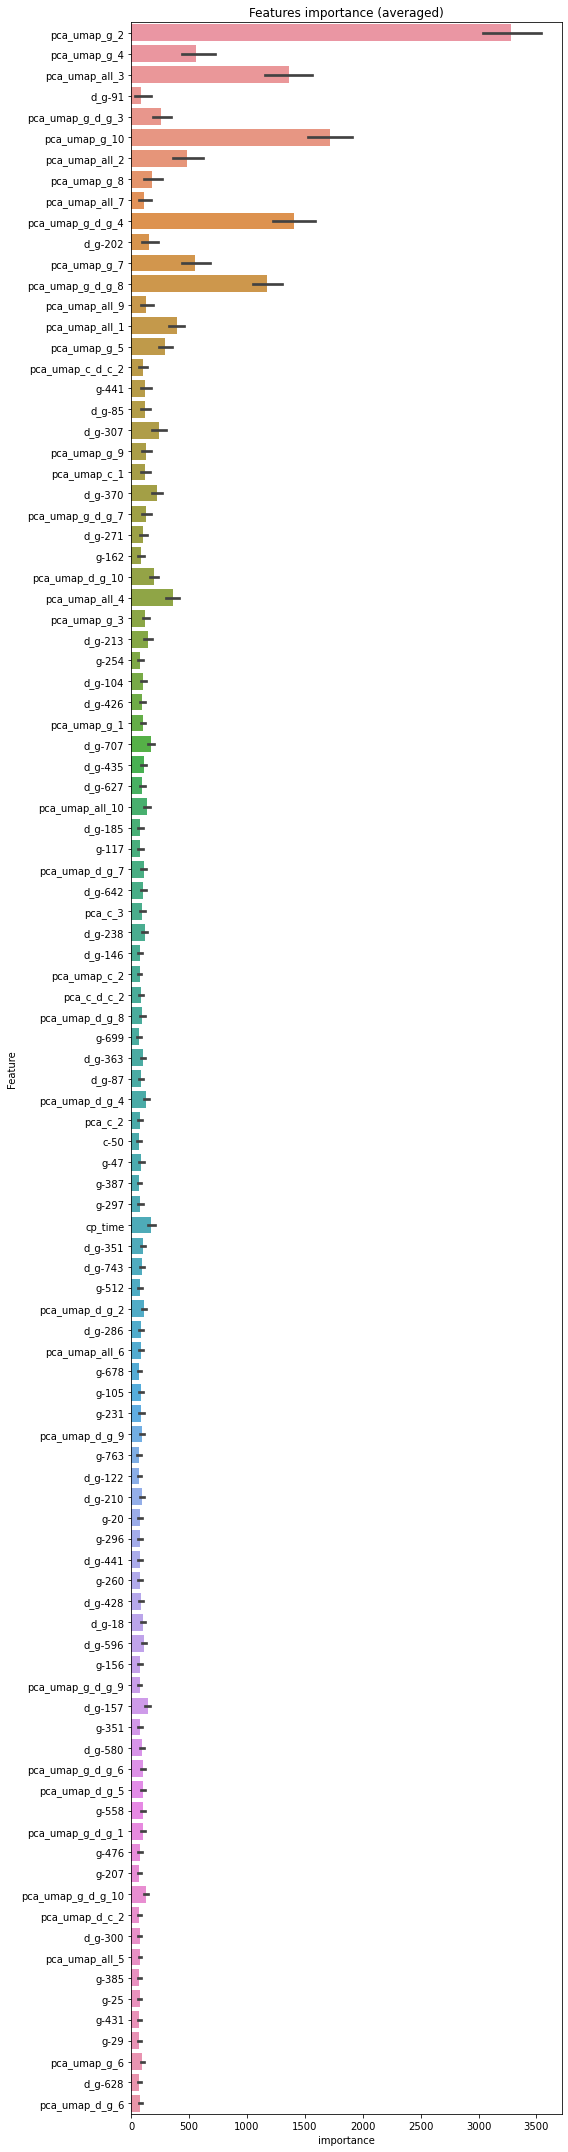

In [52]:
show_feature_importance(feature_importance_df)